In [1]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 10000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[0.6517]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.8774]], requires_grad=True)
alpha:  tensor([0.2101])
gt ols coef:  [[0.6534512]]
gt ols intercept:  [-0.8748568]
trunc ols coef:  [[0.08947102]]
trunc ols intercept:  [0.67517924]


Text(0, 0.5, 'y')

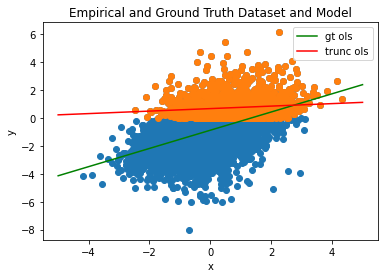

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
# m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + laplace.sample(ch.Size([X.size(0)]))
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [19]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.0143)
beta:  tensor(4.0143)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([0.6316])
trunc reg noise var:  tensor([2.0522])


Text(0, 0.5, 'y')

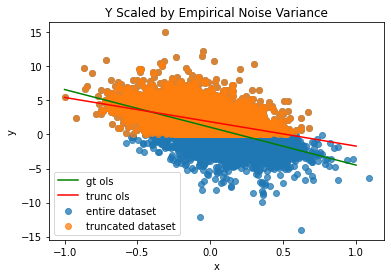

In [52]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)
emp_noise_scale = ch.sqrt(emp_noise_var/2) 

emp_stand_y_trunc = y_trunc / emp_noise_scale
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / emp_noise_scale

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([1.2631])
reg noise var:  tensor([2.0303])


Text(0, 0.5, 'y')

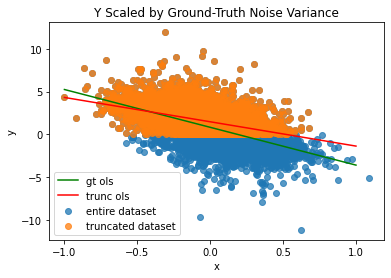

In [53]:
stand_noised, stand_y_trunc = noised / noise_scale, y_trunc / noise_scale

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [54]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_res.weight * emp_noise_scale) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_res.bias * emp_noise_scale)

0 steps | score: [0.08722872287034988]
100 steps | score: [-0.15371833741664886]
200 steps | score: [0.11577165126800537]
300 steps | score: [0.15002448856830597]
400 steps | score: [-0.040850937366485596]
500 steps | score: [0.04271867498755455]
600 steps | score: [0.01830844022333622]
700 steps | score: [0.04730379208922386]
800 steps | score: [-0.052826348692178726]
900 steps | score: [0.10823661088943481]
1000 steps | score: [0.08567563444375992]
1100 steps | score: [-0.0640784278512001]
1200 steps | score: [0.008505544625222683]


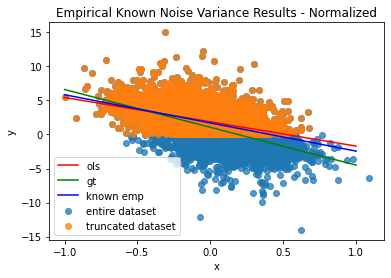

Text(0, 0.5, 'y')

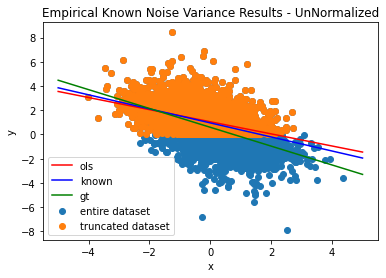

In [55]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_res(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [58]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=False, val=100, bs=1, n=100, tol=1e-2, steps=2000)
known_res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_res.weight * noise_scale) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_res.bias * noise_scale

0 steps | score: [0.1404706835746765]
100 steps | score: [-0.20729883015155792]
200 steps | score: [-0.019203443080186844]
300 steps | score: [0.15922656655311584]
400 steps | score: [0.26590561866760254]
500 steps | score: [-0.19839715957641602]
600 steps | score: [-0.07279006391763687]
700 steps | score: [0.047994550317525864]
800 steps | score: [0.07560958713293076]
900 steps | score: [0.0676669031381607]
1000 steps | score: [-0.28352153301239014]
1100 steps | score: [0.052644044160842896]
1200 steps | score: [-0.017157278954982758]
1300 steps | score: [-0.22028736770153046]
1400 steps | score: [-0.1377340853214264]
1500 steps | score: [0.0061187297105789185]


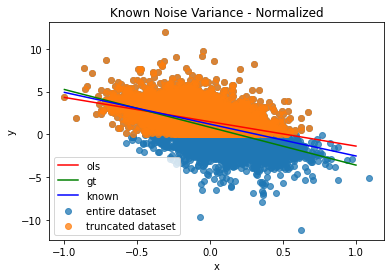

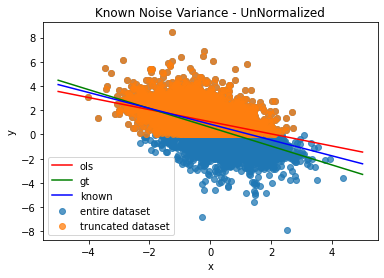

In [59]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_res(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [60]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=True, bs=1, n=100, tol=5e-2, val=100, steps=2000)
unknown_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_res.lambda_.inverse()
unknown_weight_unnorm, unknown_bias_unnorm = (((unknown_res.weight * unknown_var) * emp_noise_scale) / beta).detach().numpy(), ((unknown_res.bias * unknown_var) * emp_noise_scale).detach().numpy()

0 steps | score: [0.2905574440956116, -0.20666351914405823]
100 steps | score: [-0.27120140194892883, -3.2981948852539062]
200 steps | score: [-1.2057424783706665, 2.8927805423736572]
300 steps | score: [-0.8965381383895874, 2.547687530517578]
400 steps | score: [-1.3437919616699219, 3.0747432708740234]
500 steps | score: [-0.338600754737854, 1.6003186702728271]
600 steps | score: [-0.18581794202327728, 1.1041582822799683]
700 steps | score: [-2.0519609451293945, 3.499739170074463]
800 steps | score: [-0.5100373029708862, 1.8548325300216675]
900 steps | score: [-0.8865644335746765, 2.509981870651245]
1000 steps | score: [-0.5900213122367859, 2.0247135162353516]
1100 steps | score: [0.15984177589416504, 0.3845093250274658]
1200 steps | score: [0.22827421128749847, 0.23511837422847748]
1300 steps | score: [-0.3410768210887909, 1.496913194656372]
1400 steps | score: [-0.5526643395423889, 1.8662344217300415]
1500 steps | score: [0.03078850731253624, 0.7469772100448608]
1600 steps | score: 

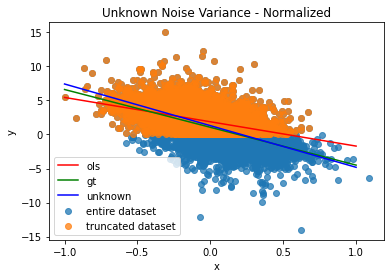

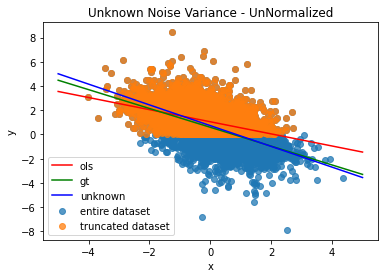

In [61]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_res(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [108]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 100)
args.__setattr__('samples', 1500)
args.__setattr__('n', 100)

EXP = '10Laplace100Trials'

In [109]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

In [110]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 10, 1

# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
noise_var = 5*ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)

C = [-2.5, -2, -1.75, -1.5, -1.25, -1.0, -.75, -.5, -.25, 0.0, .25, .5, .75, 1.0]

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'c': float,
        'num_samples': int,
        'noise_var': float, 
    })
    
    
    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
        noised = gt(X) + laplace.sample(ch.Size([X.size(0)]))
        
    for c in C: 
        phi = oracle.Left(c)
        # add noise to ground-truth pedictions
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        val = int(.1*x_trunc.size(0))
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })

        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by the empirical noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by the empirical noise variance
        known_kwargs = { 
            'phi': oracle.Left(c/ch.sqrt(noise_var)), 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc)
        with ch.no_grad():
            w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var)
            known_params = ch.cat([w, w0]).flatten()
            
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(noised.flatten(), X@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params),
                'known_time': total_time, 
            })
        
        
        # truncated regression with unknown variance
        unknown_kwargs = { 
            'phi': oracle.Left(c/ch.sqrt(emp_noise_var)), 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_noise_scale = ch.sqrt(emp_noise_var/2) 
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
        
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
    
        with ch.no_grad():
            w, w0 = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta), ((unknown_trunc_reg.intercept * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)))
            unknown_params = ch.cat([w, w0]).flatten()

            # unknown results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params),
                'unknown_var_l1': float(ch.abs(unknown_trunc_reg.variance * emp_noise_var - noise_var)),
                'unknown_time': total_time, 
            })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': float(noise_var), 
            'c': c,
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/6415864f-0551-4a77-b0d5-0115c7187821
Iteration: 0.0 | Score: [0.08428341150283813]
Iteration: 1.0 | Score: [-0.16184282302856445]
Iteration: 2.0 | Score: [-0.07428799569606781]
Iteration: 3.0 | Score: [-0.13749419152736664]
Iteration: 4.0 | Score: [-0.03184777870774269]
Iteration: 5.0 | Score: [-0.09893453121185303]
Iteration: 6.0 | Score: [-0.07997775077819824]
Iteration: 7.0 | Score: [0.01884341612458229]
Iteration: 8.0 | Score: [0.012161927297711372]
Iteration: 9.0 | Score: [-0.0071327658370137215]
Iteration: 0.0 | Score: [0.06915212422609329, 0.6977091431617737]
Iteration: 1.0 | Score: [-0.13855305314064026, 1.0430009365081787]
Iteration: 2.0 | Score: [0.29499533772468567, -0.5240163803100586]
Iteration: 3.0 | Score: [0.01129416935145855, 0.5064685344696045]
Iteration: 4.0 | Score: [0.06319861859083176, 0.36145997047424316]
Iteration: 5.0 | Score: [-0.1059604212641716, 0.9711568355560303]
Iteration: 6.0 | Score: [-0.1

Iteration: 17.0 | Score: [0.15655910968780518, -0.3180322051048279]
Iteration: 18.0 | Score: [0.20409375429153442, -0.4900830388069153]
Iteration: 19.0 | Score: [0.10648705810308456, -0.12514205276966095]
Iteration: 20.0 | Score: [-0.0021947799250483513, 0.21949735283851624]
Iteration: 21.0 | Score: [0.059053998440504074, 0.007387153804302216]
Iteration: 22.0 | Score: [0.108295738697052, -0.12511073052883148]
Iteration: 23.0 | Score: [0.17511433362960815, -0.3956279456615448]
Iteration: 24.0 | Score: [0.15903475880622864, -0.32405319809913635]
Iteration: 25.0 | Score: [0.12660661339759827, -0.2450956404209137]
Iteration: 0.0 | Score: [0.12739130854606628]
Iteration: 1.0 | Score: [0.05817567929625511]
Iteration: 2.0 | Score: [0.05129304900765419]
Iteration: 3.0 | Score: [-0.024651918560266495]
Iteration: 4.0 | Score: [-0.0667710155248642]
Iteration: 5.0 | Score: [-0.0003796461969614029]
Iteration: 0.0 | Score: [0.2693537175655365, -0.29206913709640503]
Iteration: 1.0 | Score: [1.4865838

Iteration: 8.0 | Score: [0.04272884875535965, -0.049195826053619385]
Iteration: 9.0 | Score: [-0.08251040428876877, 0.3080618977546692]
Iteration: 10.0 | Score: [0.09726791083812714, -0.2955082058906555]
Iteration: 11.0 | Score: [0.043730221688747406, -0.05057861655950546]
Iteration: 12.0 | Score: [-0.005698762834072113, 0.044307589530944824]
Iteration: 13.0 | Score: [0.03986828029155731, -0.09047256410121918]
Iteration: 14.0 | Score: [0.16935762763023376, -0.5051383972167969]
Iteration: 15.0 | Score: [0.1184779703617096, -0.32118064165115356]
Iteration: 16.0 | Score: [0.08583633601665497, -0.20047909021377563]
Iteration: 17.0 | Score: [-0.07553599029779434, 0.32077234983444214]
Iteration: 18.0 | Score: [0.22411680221557617, -0.6831836104393005]
Iteration: 19.0 | Score: [0.021864039823412895, -0.028233330696821213]
Iteration: 20.0 | Score: [0.10884112119674683, -0.34247538447380066]
Iteration: 21.0 | Score: [0.09233364462852478, -0.3007720708847046]
Iteration: 22.0 | Score: [0.03675235

Iteration: 4.0 | Score: [-0.308007150888443, 0.8037918210029602]
Iteration: 5.0 | Score: [-0.138328418135643, 0.1994198113679886]
Iteration: 6.0 | Score: [-0.006237122695893049, -0.2419113963842392]
Iteration: 7.0 | Score: [-0.27719083428382874, 0.5461674332618713]
Iteration: 8.0 | Score: [0.244469553232193, -1.1855671405792236]
Iteration: 9.0 | Score: [0.04447345435619354, -0.44613969326019287]
Iteration: 10.0 | Score: [-0.23427468538284302, 0.4212318956851959]
Iteration: 11.0 | Score: [-0.007425840012729168, -0.2589840888977051]
Iteration: 12.0 | Score: [-0.1743382215499878, 0.22433951497077942]
Iteration: 13.0 | Score: [-0.13476106524467468, 0.11425170302391052]
Iteration: 14.0 | Score: [-0.22843831777572632, 0.3853938579559326]
Iteration: 15.0 | Score: [-0.2208566814661026, 0.39429599046707153]
Iteration: 16.0 | Score: [-0.0858384296298027, -0.046592239290475845]
Iteration: 17.0 | Score: [-0.34388285875320435, 0.7331292033195496]
Iteration: 18.0 | Score: [-0.05567630007863045, -0.1

Iteration: 23.0 | Score: [-0.19081443548202515, 0.8202398419380188]
Iteration: 24.0 | Score: [-0.12297175079584122, 0.5920372605323792]
Iteration: 25.0 | Score: [-0.17394913733005524, 0.7530996799468994]
Iteration: 0.0 | Score: [0.09394665062427521, 0.26145583391189575]
Iteration: 1.0 | Score: [-0.17094144225120544, 0.9600825905799866]
Iteration: 2.0 | Score: [0.5165308713912964, -1.6117643117904663]
Iteration: 3.0 | Score: [0.07790850847959518, 0.03699490427970886]
Iteration: 4.0 | Score: [-0.24058285355567932, 1.0816713571548462]
Iteration: 5.0 | Score: [-0.09042908251285553, 0.5916997194290161]
Iteration: 6.0 | Score: [-0.13390004634857178, 0.7274006605148315]
Iteration: 7.0 | Score: [0.5398513674736023, -1.7929558753967285]
Iteration: 8.0 | Score: [-0.062120355665683746, 0.5374113917350769]
Iteration: 9.0 | Score: [-0.17033319175243378, 0.8342747092247009]
Iteration: 10.0 | Score: [-0.0034874826669692993, 0.32236248254776]
Iteration: 11.0 | Score: [-0.16929319500923157, 0.840435624

Iteration: 5.0 | Score: [-1.8756715059280396, 4.451876640319824]
Iteration: 6.0 | Score: [-0.5413467288017273, 1.8851662874221802]
Iteration: 7.0 | Score: [-2.701616048812866, 4.890183448791504]
Iteration: 8.0 | Score: [-0.10823751240968704, 0.7095680236816406]
Iteration: 9.0 | Score: [0.2580071985721588, -0.7629280686378479]
Iteration: 10.0 | Score: [-0.2137155532836914, 0.8098480105400085]
Iteration: 11.0 | Score: [0.15668244659900665, -0.6422568559646606]
Iteration: 12.0 | Score: [0.09581514447927475, -0.49459731578826904]
Iteration: 13.0 | Score: [-0.17179718613624573, 0.5055187940597534]
Iteration: 14.0 | Score: [0.41407597064971924, -1.8659064769744873]
Iteration: 15.0 | Score: [-0.13331319391727448, 0.28050366044044495]
Iteration: 16.0 | Score: [0.4171789884567261, -1.9508616924285889]
Iteration: 17.0 | Score: [-0.024992836639285088, -0.09870322048664093]
Iteration: 18.0 | Score: [0.25020068883895874, -1.1998071670532227]
Iteration: 19.0 | Score: [0.007961605675518513, -0.283201

Iteration: 16.0 | Score: [0.06486088782548904]
Iteration: 17.0 | Score: [0.06273952126502991]
Iteration: 18.0 | Score: [0.07545565068721771]
Iteration: 19.0 | Score: [0.09962854534387589]
Iteration: 20.0 | Score: [0.07623489201068878]
Iteration: 21.0 | Score: [0.06924700736999512]
Iteration: 22.0 | Score: [0.05245615541934967]
Iteration: 23.0 | Score: [0.08191056549549103]
Iteration: 24.0 | Score: [0.03813696652650833]
Iteration: 25.0 | Score: [0.04593747854232788]
Iteration: 0.0 | Score: [0.12131068110466003, 0.19933536648750305]
Iteration: 1.0 | Score: [0.5942965149879456, -1.214238166809082]
Iteration: 2.0 | Score: [-0.10728850215673447, 1.5375553369522095]
Iteration: 3.0 | Score: [-3.030564546585083, 6.736581325531006]
Iteration: 4.0 | Score: [-0.13956399261951447, 1.6268119812011719]
Iteration: 5.0 | Score: [-0.04538580775260925, 1.2853749990463257]
Iteration: 6.0 | Score: [-0.13659964501857758, 1.4192450046539307]
Iteration: 7.0 | Score: [-0.10606209933757782, 1.118167757987976]


Iteration: 7.0 | Score: [-0.13271522521972656, 0.7450190782546997]
Iteration: 8.0 | Score: [0.013810337521135807, 0.16282032430171967]
Iteration: 9.0 | Score: [0.003864156547933817, 0.16076409816741943]
Iteration: 10.0 | Score: [-0.1604314148426056, 0.7627397179603577]
Iteration: 11.0 | Score: [-0.20672179758548737, 0.9107400178909302]
Iteration: 12.0 | Score: [0.05634482577443123, -0.016820378601551056]
Iteration: 13.0 | Score: [-0.0863148421049118, 0.49272939562797546]
Iteration: 14.0 | Score: [-0.07018569856882095, 0.43709707260131836]
Iteration: 15.0 | Score: [-0.13297060132026672, 0.6745187044143677]
Iteration: 16.0 | Score: [0.04670000076293945, 0.006172701716423035]
Iteration: 17.0 | Score: [-0.11899889260530472, 0.5786879658699036]
Iteration: 18.0 | Score: [-0.15110933780670166, 0.6982189416885376]
Iteration: 19.0 | Score: [-0.06872957944869995, 0.3875998556613922]
Iteration: 20.0 | Score: [-0.05083858221769333, 0.37048637866973877]
Iteration: 21.0 | Score: [-0.0668339803814888

Iteration: 20.0 | Score: [-0.07467295229434967, 0.09439243376255035]
Iteration: 21.0 | Score: [-0.18349553644657135, 0.47417622804641724]
Iteration: 22.0 | Score: [-0.15228106081485748, 0.2766878604888916]
Iteration: 23.0 | Score: [-0.15789857506752014, 0.4077068865299225]
Iteration: 24.0 | Score: [-0.2104690670967102, 0.5547401905059814]
Iteration: 25.0 | Score: [-0.1466192752122879, 0.32799163460731506]
Iteration: 0.0 | Score: [0.20883552730083466, -0.18181894719600677]
Iteration: 1.0 | Score: [0.3152085840702057, -0.9427670240402222]
Iteration: 2.0 | Score: [0.47745126485824585, -1.8032163381576538]
Iteration: 3.0 | Score: [0.1534149944782257, -0.5775299668312073]
Iteration: 4.0 | Score: [0.07308169454336166, -0.19466754794120789]
Iteration: 5.0 | Score: [0.2602761387825012, -0.7745183706283569]
Iteration: 6.0 | Score: [0.19563663005828857, -0.5622837543487549]
Iteration: 7.0 | Score: [0.010940052568912506, -0.020713701844215393]
Iteration: 8.0 | Score: [0.02568002976477146, -0.0259

Iteration: 2.0 | Score: [0.11076601594686508, -0.19870615005493164]
Iteration: 3.0 | Score: [-0.11332126706838608, 0.5183476209640503]
Iteration: 4.0 | Score: [0.4004705548286438, -1.2418804168701172]
Iteration: 5.0 | Score: [0.03831176832318306, 0.04151911288499832]
Iteration: 6.0 | Score: [-0.054449137300252914, 0.31603240966796875]
Iteration: 7.0 | Score: [0.2168777734041214, -0.5805302858352661]
Iteration: 8.0 | Score: [0.12435412406921387, -0.274507611989975]
Iteration: 9.0 | Score: [0.1275692582130432, -0.2568392753601074]
Iteration: 10.0 | Score: [-0.16314557194709778, 0.6242970824241638]
Iteration: 11.0 | Score: [0.020696889609098434, 0.053776711225509644]
Iteration: 12.0 | Score: [0.29056084156036377, -0.8600449562072754]
Iteration: 13.0 | Score: [0.11133234202861786, -0.2180643081665039]
Iteration: 14.0 | Score: [0.11115225404500961, -0.22011594474315643]
Iteration: 15.0 | Score: [0.06406490504741669, -0.03124132752418518]
Iteration: 16.0 | Score: [0.020651131868362427, 0.122

Iteration: 6.0 | Score: [0.9758899211883545, -2.7217764854431152]
Iteration: 7.0 | Score: [0.17962026596069336, -0.049671053886413574]
Iteration: 8.0 | Score: [0.8082594275474548, -2.440629720687866]
Iteration: 9.0 | Score: [0.12892374396324158, -0.11722280085086823]
Iteration: 10.0 | Score: [0.17921502888202667, -0.37518686056137085]
Iteration: 11.0 | Score: [0.2793724238872528, -0.7713080048561096]
Iteration: 12.0 | Score: [0.04308108985424042, -0.05821686610579491]
Iteration: 13.0 | Score: [0.020261727273464203, 0.04748666286468506]
Iteration: 14.0 | Score: [-0.04840809479355812, 0.2631663382053375]
Iteration: 15.0 | Score: [-0.09342832118272781, 0.4231659173965454]
Iteration: 16.0 | Score: [-0.15177488327026367, 0.5752314925193787]
Iteration: 17.0 | Score: [0.05707571282982826, -0.1336384117603302]
Iteration: 18.0 | Score: [0.2005561739206314, -0.49893301725387573]
Iteration: 19.0 | Score: [0.21772930026054382, -0.6716405153274536]
Iteration: 20.0 | Score: [0.07243743538856506, -0.

Iteration: 14.0 | Score: [0.05794714391231537, -0.3676735460758209]
Iteration: 15.0 | Score: [0.22676536440849304, -1.1047903299331665]
Iteration: 16.0 | Score: [0.13498878479003906, -0.6408169269561768]
Iteration: 17.0 | Score: [0.033632706850767136, -0.28056129813194275]
Iteration: 18.0 | Score: [0.22542932629585266, -1.0933290719985962]
Iteration: 19.0 | Score: [-0.0583440437912941, 0.024096671491861343]
Iteration: 20.0 | Score: [0.22485549747943878, -1.016424536705017]
Iteration: 21.0 | Score: [0.15255026519298553, -0.7939409017562866]
Iteration: 22.0 | Score: [0.038220323622226715, -0.32907596230506897]
Iteration: 23.0 | Score: [0.16668610274791718, -0.7777564525604248]
Iteration: 24.0 | Score: [0.027916505932807922, -0.31442421674728394]
Iteration: 25.0 | Score: [0.06128571555018425, -0.4404740035533905]
Iteration: 0.0 | Score: [0.29151999950408936, -0.49675050377845764]
Iteration: 1.0 | Score: [0.6620921492576599, -2.5676815509796143]
Iteration: 2.0 | Score: [0.03305399045348167

Iteration: 19.0 | Score: [0.0467400960624218]
Iteration: 20.0 | Score: [0.08877208828926086]
Iteration: 21.0 | Score: [0.059427060186862946]
Iteration: 22.0 | Score: [0.08601312339305878]
Iteration: 23.0 | Score: [0.08867816627025604]
Iteration: 24.0 | Score: [0.08425744622945786]
Iteration: 25.0 | Score: [0.04979104921221733]
Iteration: 0.0 | Score: [0.030542729422450066, 0.388979971408844]
Iteration: 1.0 | Score: [-0.5003531575202942, 2.1722841262817383]
Iteration: 2.0 | Score: [0.5772846341133118, -2.4611897468566895]
Iteration: 3.0 | Score: [0.3164839446544647, -1.3130958080291748]
Iteration: 4.0 | Score: [0.1809798926115036, -0.7167447805404663]
Iteration: 5.0 | Score: [-0.10322455316781998, 0.5836358070373535]
Iteration: 6.0 | Score: [-0.11607382446527481, 0.5966952443122864]
Iteration: 7.0 | Score: [0.4424152076244354, -1.9126490354537964]
Iteration: 8.0 | Score: [-0.3038076162338257, 1.3249784708023071]
Iteration: 9.0 | Score: [-0.059000369161367416, 0.344096302986145]
Iteratio

Iteration: 2.0 | Score: [-0.056121230125427246, 0.6791004538536072]
Iteration: 3.0 | Score: [-0.11910965293645859, 0.885949969291687]
Iteration: 4.0 | Score: [-0.45907434821128845, 2.033794403076172]
Iteration: 5.0 | Score: [-0.17081473767757416, 0.9092568159103394]
Iteration: 6.0 | Score: [-0.5549710988998413, 2.263481378555298]
Iteration: 7.0 | Score: [0.1742306649684906, -0.5611724257469177]
Iteration: 8.0 | Score: [-0.2629471719264984, 1.1879159212112427]
Iteration: 9.0 | Score: [-0.212306410074234, 0.9936192035675049]
Iteration: 10.0 | Score: [-0.20014312863349915, 0.9607093930244446]
Iteration: 11.0 | Score: [-0.23363305628299713, 1.0450724363327026]
Iteration: 12.0 | Score: [0.039110954850912094, -0.026543214917182922]
Iteration: 13.0 | Score: [-0.12660735845565796, 0.6258516311645508]
Iteration: 14.0 | Score: [-0.02280975691974163, 0.2023508995771408]
Iteration: 15.0 | Score: [0.00885927677154541, 0.09255719184875488]
Iteration: 16.0 | Score: [0.14038872718811035, -0.5004589557

Iteration: 0.0 | Score: [0.4587268829345703]
Iteration: 1.0 | Score: [0.2789410352706909]
Iteration: 2.0 | Score: [0.24683143198490143]
Iteration: 3.0 | Score: [0.2743901312351227]
Iteration: 4.0 | Score: [0.3102002441883087]
Iteration: 5.0 | Score: [0.370028018951416]
Iteration: 6.0 | Score: [0.4243079721927643]
Iteration: 7.0 | Score: [0.43285197019577026]
Iteration: 8.0 | Score: [0.3446912169456482]
Iteration: 9.0 | Score: [0.3215106129646301]
Iteration: 10.0 | Score: [0.27093786001205444]
Iteration: 11.0 | Score: [0.30042195320129395]
Iteration: 12.0 | Score: [0.31185734272003174]
Iteration: 13.0 | Score: [0.32110291719436646]
Iteration: 14.0 | Score: [0.34932053089141846]
Iteration: 15.0 | Score: [0.365749716758728]
Iteration: 16.0 | Score: [0.3420317769050598]
Iteration: 17.0 | Score: [0.3437841534614563]
Iteration: 18.0 | Score: [0.3155454993247986]
Iteration: 19.0 | Score: [0.3153843581676483]
Iteration: 20.0 | Score: [0.3122095465660095]
Iteration: 21.0 | Score: [0.33383810520

Iteration: 13.0 | Score: [-0.041895732283592224, 0.1893397569656372]
Iteration: 14.0 | Score: [-0.13456206023693085, 0.4238148629665375]
Iteration: 15.0 | Score: [-0.19677884876728058, 0.6267688870429993]
Iteration: 16.0 | Score: [-0.03858659788966179, 0.1608017385005951]
Iteration: 17.0 | Score: [0.025079526007175446, -0.08822792023420334]
Iteration: 18.0 | Score: [-0.10639822483062744, 0.3719206750392914]
Iteration: 19.0 | Score: [0.09924545884132385, -0.3875887989997864]
Iteration: 20.0 | Score: [-0.06391891092061996, 0.16914507746696472]
Iteration: 21.0 | Score: [-0.013493475504219532, 0.032665036618709564]
Iteration: 22.0 | Score: [-0.07961371541023254, 0.26057353615760803]
Iteration: 23.0 | Score: [-0.048048801720142365, 0.1490260660648346]
Iteration: 24.0 | Score: [-0.08820893615484238, 0.29032230377197266]
Iteration: 25.0 | Score: [-0.04883682355284691, 0.1407935470342636]
Iteration: 0.0 | Score: [0.11203144490718842]
Iteration: 1.0 | Score: [0.014300037175416946]
Iteration: 2.

Iteration: 12.0 | Score: [0.11289619654417038, -0.15692749619483948]
Iteration: 13.0 | Score: [0.11280496418476105, -0.134648859500885]
Iteration: 14.0 | Score: [0.1290147453546524, -0.19174084067344666]
Iteration: 15.0 | Score: [0.17223165929317474, -0.35254839062690735]
Iteration: 16.0 | Score: [0.1261133849620819, -0.2237500697374344]
Iteration: 17.0 | Score: [0.03470754995942116, 0.08722569048404694]
Iteration: 18.0 | Score: [-0.030286449939012527, 0.32347792387008667]
Iteration: 19.0 | Score: [0.19654317200183868, -0.4040336608886719]
Iteration: 20.0 | Score: [0.08406168222427368, -0.08100625872612]
Iteration: 21.0 | Score: [0.18943139910697937, -0.4282298684120178]
Iteration: 22.0 | Score: [0.07302093505859375, -0.02124069631099701]
Iteration: 23.0 | Score: [0.18971103429794312, -0.36626124382019043]
Iteration: 24.0 | Score: [0.08571019023656845, -0.0679938942193985]
Iteration: 25.0 | Score: [0.14056730270385742, -0.26053208112716675]
Iteration: 0.0 | Score: [0.15709944069385529]

Iteration: 16.0 | Score: [0.19163380563259125]
Iteration: 17.0 | Score: [0.16387568414211273]
Iteration: 18.0 | Score: [0.19895817339420319]
Iteration: 19.0 | Score: [0.18123845756053925]
Iteration: 20.0 | Score: [0.1532760113477707]
Iteration: 21.0 | Score: [0.18229086697101593]
Iteration: 22.0 | Score: [0.1880025565624237]
Iteration: 23.0 | Score: [0.18050014972686768]
Iteration: 24.0 | Score: [0.18754078447818756]
Iteration: 25.0 | Score: [0.17259271442890167]
Iteration: 0.0 | Score: [0.1164906919002533, -0.28720712661743164]
Iteration: 1.0 | Score: [-0.13825108110904694, 0.6866714954376221]
Iteration: 2.0 | Score: [0.15476936101913452, 0.08292009681463242]
Iteration: 3.0 | Score: [10.758094787597656, -95.61297607421875]
Iteration: 4.0 | Score: [-0.1641526073217392, 0.9616042375564575]
Iteration: 5.0 | Score: [0.06949792802333832, 0.15407314896583557]
Iteration: 6.0 | Score: [1.3753522634506226, -5.791004657745361]
Iteration: 7.0 | Score: [-0.07797340303659439, 0.14853310585021973]


Iteration: 20.0 | Score: [0.023795422166585922, -0.0656670331954956]
Iteration: 21.0 | Score: [0.06082873046398163, -0.16683150827884674]
Iteration: 22.0 | Score: [0.06349010020494461, -0.21150198578834534]
Iteration: 23.0 | Score: [0.07342736423015594, -0.23469802737236023]
Iteration: 24.0 | Score: [0.01896894909441471, -0.053879715502262115]
Iteration: 25.0 | Score: [0.03945498168468475, -0.1545548141002655]
Iteration: 0.0 | Score: [0.22544121742248535, -0.42819344997406006]
Iteration: 1.0 | Score: [0.1796008199453354, -0.6213523149490356]
Iteration: 2.0 | Score: [0.046404510736465454, -0.20473673939704895]
Iteration: 3.0 | Score: [0.30149155855178833, -1.1759862899780273]
Iteration: 4.0 | Score: [0.20338109135627747, -0.838123083114624]
Iteration: 5.0 | Score: [-0.042058996856212616, 0.07104852795600891]
Iteration: 6.0 | Score: [0.1592290848493576, -0.7206393480300903]
Iteration: 7.0 | Score: [0.09953820705413818, -0.46515530347824097]
Iteration: 8.0 | Score: [-0.22269415855407715, 

Iteration: 23.0 | Score: [0.18588218092918396]
Iteration: 24.0 | Score: [0.17247462272644043]
Iteration: 25.0 | Score: [0.19059088826179504]
Iteration: 0.0 | Score: [-0.02073403261601925, 1.020512342453003]
Iteration: 1.0 | Score: [0.513695240020752, -1.583986520767212]
Iteration: 2.0 | Score: [0.3439319431781769, -0.8349237442016602]
Iteration: 3.0 | Score: [0.23331591486930847, -0.4226410686969757]
Iteration: 4.0 | Score: [-0.06955263763666153, 0.7810131311416626]
Iteration: 5.0 | Score: [-0.019079944118857384, 0.5862318277359009]
Iteration: 6.0 | Score: [-0.2861969470977783, 1.5638800859451294]
Iteration: 7.0 | Score: [-0.27818310260772705, 1.5216281414031982]
Iteration: 8.0 | Score: [-0.014567381702363491, 0.4924980401992798]
Iteration: 9.0 | Score: [-0.014371795579791069, 0.5093463063240051]
Iteration: 10.0 | Score: [-0.12048410624265671, 0.9506775140762329]
Iteration: 11.0 | Score: [-0.425077348947525, 2.058852195739746]
Iteration: 12.0 | Score: [-0.08481638133525848, 0.777791500

Iteration: 24.0 | Score: [-0.06321372091770172, 0.22422857582569122]
Iteration: 25.0 | Score: [0.0006899297004565597, -0.02488168329000473]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/b39cccb8-4078-431f-8899-05fb2e7724b7
Iteration: 0.0 | Score: [0.07432317733764648]
Iteration: 1.0 | Score: [-0.10180041193962097]
Iteration: 2.0 | Score: [-0.06432747840881348]
Iteration: 3.0 | Score: [-0.019801294431090355]
Iteration: 4.0 | Score: [-0.018359920009970665]
Iteration: 5.0 | Score: [0.024026360362768173]
Iteration: 6.0 | Score: [-0.013760624453425407]
Iteration: 7.0 | Score: [-0.03660110384225845]
Iteration: 8.0 | Score: [-0.04232889413833618]
Iteration: 9.0 | Score: [-0.030679777264595032]
Iteration: 10.0 | Score: [-0.06078080087900162]
Iteration: 11.0 | Score: [-0.08829318732023239]
Iteration: 12.0 | Score: [-0.1074274331331253]
Iteration: 13.0 | Score: [-0.08246434479951859]
Iteration: 14.0 | Score: [-0.03336631506681442]
Iteration: 15.0 | Score: [-0.04228009283542633

Iteration: 12.0 | Score: [0.08344968408346176, -0.34744688868522644]
Iteration: 13.0 | Score: [0.12714333832263947, -0.48159259557724]
Iteration: 14.0 | Score: [0.15027470886707306, -0.5653745532035828]
Iteration: 15.0 | Score: [0.015236548148095608, -0.10400982201099396]
Iteration: 16.0 | Score: [0.23747500777244568, -0.8459371328353882]
Iteration: 17.0 | Score: [0.07537538558244705, -0.3697999119758606]
Iteration: 18.0 | Score: [0.013310384936630726, -0.10541368275880814]
Iteration: 19.0 | Score: [0.06920108944177628, -0.31937074661254883]
Iteration: 20.0 | Score: [0.020995160564780235, -0.15840893983840942]
Iteration: 21.0 | Score: [0.1490439921617508, -0.5364497900009155]
Iteration: 22.0 | Score: [0.15900477766990662, -0.6354354023933411]
Iteration: 23.0 | Score: [0.02136152982711792, -0.17540103197097778]
Iteration: 24.0 | Score: [0.05672690272331238, -0.2701669931411743]
Iteration: 25.0 | Score: [0.07587197422981262, -0.3288763761520386]
Iteration: 0.0 | Score: [0.141525983810424

Iteration: 2.0 | Score: [-0.33326220512390137, 0.9950137138366699]
Iteration: 3.0 | Score: [-0.29365670680999756, 0.8806508779525757]
Iteration: 4.0 | Score: [-0.14603155851364136, 0.444405198097229]
Iteration: 5.0 | Score: [0.24431109428405762, -1.0446181297302246]
Iteration: 6.0 | Score: [-0.21146884560585022, 0.5201806426048279]
Iteration: 7.0 | Score: [-0.20318233966827393, 0.5683386325836182]
Iteration: 8.0 | Score: [-0.14446362853050232, 0.3762784004211426]
Iteration: 9.0 | Score: [-0.1136597990989685, 0.2810572385787964]
Iteration: 10.0 | Score: [-0.09486497938632965, 0.2052672803401947]
Iteration: 11.0 | Score: [-0.1514168679714203, 0.3555663228034973]
Iteration: 12.0 | Score: [-0.10941523313522339, 0.22733698785305023]
Iteration: 13.0 | Score: [-0.0443619005382061, 0.018967360258102417]
Iteration: 14.0 | Score: [0.011568238958716393, -0.11568999290466309]
Iteration: 15.0 | Score: [0.03775177150964737, -0.2648170590400696]
Iteration: 16.0 | Score: [-0.15202327072620392, 0.40015

Iteration: 16.0 | Score: [0.1072569191455841]
Iteration: 17.0 | Score: [0.10328516364097595]
Iteration: 18.0 | Score: [0.09663201123476028]
Iteration: 19.0 | Score: [0.08920925855636597]
Iteration: 20.0 | Score: [0.125801682472229]
Iteration: 21.0 | Score: [0.10076844692230225]
Iteration: 22.0 | Score: [0.10474717617034912]
Iteration: 23.0 | Score: [0.11416216939687729]
Iteration: 24.0 | Score: [0.10774795711040497]
Iteration: 25.0 | Score: [0.11795415729284286]
Iteration: 0.0 | Score: [0.2630840837955475, -0.23638704419136047]
Iteration: 1.0 | Score: [-0.1278344839811325, 0.8605623841285706]
Iteration: 2.0 | Score: [0.030003469437360764, 0.18740829825401306]
Iteration: 3.0 | Score: [0.4192735254764557, -1.2496774196624756]
Iteration: 4.0 | Score: [-0.22361309826374054, 0.9971630573272705]
Iteration: 5.0 | Score: [0.15848083794116974, -0.23563048243522644]
Iteration: 6.0 | Score: [0.07563389092683792, 0.021871298551559448]
Iteration: 7.0 | Score: [0.022623784840106964, 0.22040244936943

Iteration: 3.0 | Score: [0.03306835889816284]
Iteration: 4.0 | Score: [0.07017062604427338]
Iteration: 5.0 | Score: [0.08402668684720993]
Iteration: 6.0 | Score: [0.06797704100608826]
Iteration: 7.0 | Score: [0.09754838794469833]
Iteration: 8.0 | Score: [0.04218502342700958]
Iteration: 9.0 | Score: [0.0795760378241539]
Iteration: 10.0 | Score: [0.05322319269180298]
Iteration: 11.0 | Score: [0.08326081186532974]
Iteration: 12.0 | Score: [0.08248389512300491]
Iteration: 13.0 | Score: [0.06293030083179474]
Iteration: 14.0 | Score: [0.07232905924320221]
Iteration: 15.0 | Score: [0.045234400779008865]
Iteration: 16.0 | Score: [0.07152746617794037]
Iteration: 17.0 | Score: [0.07162269204854965]
Iteration: 18.0 | Score: [0.05331965535879135]
Iteration: 19.0 | Score: [0.06108589097857475]
Iteration: 20.0 | Score: [0.05586645007133484]
Iteration: 21.0 | Score: [0.06158778816461563]
Iteration: 22.0 | Score: [0.0680667906999588]
Iteration: 23.0 | Score: [0.08598387241363525]
Iteration: 24.0 | Sco

Iteration: 11.0 | Score: [0.14937326312065125, -0.119503453373909]
Iteration: 12.0 | Score: [0.03494063392281532, 0.2964119017124176]
Iteration: 13.0 | Score: [0.19092313945293427, -0.2878871560096741]
Iteration: 14.0 | Score: [0.0626787319779396, 0.22609639167785645]
Iteration: 15.0 | Score: [0.21283888816833496, -0.3703772723674774]
Iteration: 16.0 | Score: [0.011044167913496494, 0.3868940472602844]
Iteration: 17.0 | Score: [0.16195043921470642, -0.17642225325107574]
Iteration: 18.0 | Score: [0.002112984424456954, 0.4260680675506592]
Iteration: 19.0 | Score: [0.14308279752731323, -0.14580108225345612]
Iteration: 20.0 | Score: [0.11159111559391022, 0.028778327628970146]
Iteration: 21.0 | Score: [-0.034265562891960144, 0.5824232697486877]
Iteration: 22.0 | Score: [0.2017127424478531, -0.3557080924510956]
Iteration: 23.0 | Score: [0.007750362623482943, 0.41797423362731934]
Iteration: 24.0 | Score: [0.16956599056720734, -0.18169862031936646]
Iteration: 25.0 | Score: [0.06241695210337639,

Iteration: 7.0 | Score: [0.03016611933708191, 0.6131932735443115]
Iteration: 8.0 | Score: [0.22485150396823883, -0.16593676805496216]
Iteration: 9.0 | Score: [-0.018212905153632164, 0.5947583317756653]
Iteration: 10.0 | Score: [0.3014463186264038, -0.5852010250091553]
Iteration: 11.0 | Score: [0.5472995042800903, -1.6993212699890137]
Iteration: 12.0 | Score: [0.6115502715110779, -1.9979385137557983]
Iteration: 13.0 | Score: [0.3675842583179474, -0.9362649321556091]
Iteration: 14.0 | Score: [0.26125168800354004, -0.5736896991729736]
Iteration: 15.0 | Score: [0.1401199847459793, -0.10606862604618073]
Iteration: 16.0 | Score: [0.4527186453342438, -1.3596789836883545]
Iteration: 17.0 | Score: [0.3169098496437073, -0.8208940029144287]
Iteration: 18.0 | Score: [0.32976260781288147, -0.8704479932785034]
Iteration: 19.0 | Score: [0.4366462826728821, -1.3436418771743774]
Iteration: 20.0 | Score: [0.33908766508102417, -0.8740347623825073]
Iteration: 21.0 | Score: [0.2786962389945984, -0.63010478

Iteration: 4.0 | Score: [0.07164539396762848, -0.12431538105010986]
Iteration: 5.0 | Score: [-0.02374347113072872, 0.20254994928836823]
Iteration: 6.0 | Score: [-0.04500265046954155, 0.23156985640525818]
Iteration: 7.0 | Score: [0.11756636947393417, -0.3027288317680359]
Iteration: 8.0 | Score: [-0.11544235050678253, 0.47262606024742126]
Iteration: 9.0 | Score: [-0.05740648880600929, 0.29747578501701355]
Iteration: 10.0 | Score: [0.0387767031788826, -0.049146950244903564]
Iteration: 11.0 | Score: [-0.07537596672773361, 0.3277459740638733]
Iteration: 12.0 | Score: [-0.04343390837311745, 0.22757966816425323]
Iteration: 13.0 | Score: [0.09460565447807312, -0.2294762134552002]
Iteration: 14.0 | Score: [0.15590697526931763, -0.43865588307380676]
Iteration: 15.0 | Score: [-0.017474155873060226, 0.2205190807580948]
Iteration: 16.0 | Score: [-0.007939130999147892, 0.15031030774116516]
Iteration: 17.0 | Score: [0.02481667697429657, 0.022800058126449585]
Iteration: 18.0 | Score: [0.05867502093315

Iteration: 2.0 | Score: [0.005728265270590782, 0.01759156584739685]
Iteration: 3.0 | Score: [-0.35119906067848206, 1.2755182981491089]
Iteration: 4.0 | Score: [-0.20998340845108032, 0.7186182141304016]
Iteration: 5.0 | Score: [-0.06398285180330276, 0.27375051379203796]
Iteration: 6.0 | Score: [-0.22597233951091766, 0.7715839147567749]
Iteration: 7.0 | Score: [-0.483309805393219, 1.5929280519485474]
Iteration: 8.0 | Score: [-0.3489202558994293, 1.1845645904541016]
Iteration: 9.0 | Score: [-0.14144185185432434, 0.5179219245910645]
Iteration: 10.0 | Score: [-0.28774094581604004, 0.9983910322189331]
Iteration: 11.0 | Score: [-0.1715938299894333, 0.5734969973564148]
Iteration: 12.0 | Score: [-0.36469849944114685, 1.2099897861480713]
Iteration: 13.0 | Score: [-0.13620369136333466, 0.3845628499984741]
Iteration: 14.0 | Score: [0.020333360880613327, -0.19026759266853333]
Iteration: 15.0 | Score: [-0.22400902211666107, 0.7318553924560547]
Iteration: 16.0 | Score: [-0.12468569725751877, 0.391798

Iteration: 2.0 | Score: [-0.15832890570163727]
Iteration: 3.0 | Score: [-0.03513283655047417]
Iteration: 4.0 | Score: [-0.12404703348875046]
Iteration: 5.0 | Score: [-0.1386992335319519]
Iteration: 6.0 | Score: [-0.136333629488945]
Iteration: 7.0 | Score: [-0.1528957188129425]
Iteration: 8.0 | Score: [-0.07304532825946808]
Iteration: 9.0 | Score: [-0.12267684936523438]
Iteration: 10.0 | Score: [-0.12771491706371307]
Iteration: 11.0 | Score: [-0.1247127577662468]
Iteration: 12.0 | Score: [-0.10085461288690567]
Iteration: 13.0 | Score: [-0.0695798248052597]
Iteration: 14.0 | Score: [-0.11844272911548615]
Iteration: 15.0 | Score: [-0.12602123618125916]
Iteration: 16.0 | Score: [-0.13136069476604462]
Iteration: 17.0 | Score: [-0.13848496973514557]
Iteration: 18.0 | Score: [-0.09734416007995605]
Iteration: 19.0 | Score: [-0.10916262865066528]
Iteration: 20.0 | Score: [-0.1107063740491867]
Iteration: 21.0 | Score: [-0.13534606993198395]
Iteration: 22.0 | Score: [-0.1315663456916809]
Iteratio

Iteration: 9.0 | Score: [0.09199371933937073, -0.6337199807167053]
Iteration: 10.0 | Score: [-0.18955837190151215, 0.3593769669532776]
Iteration: 11.0 | Score: [0.12808997929096222, -0.799370288848877]
Iteration: 12.0 | Score: [0.04502220079302788, -0.4707227945327759]
Iteration: 13.0 | Score: [0.004401851445436478, -0.32341381907463074]
Iteration: 14.0 | Score: [-0.18414168059825897, 0.3384976387023926]
Iteration: 15.0 | Score: [0.09570346772670746, -0.6953707933425903]
Iteration: 16.0 | Score: [0.17710208892822266, -0.9892425537109375]
Iteration: 17.0 | Score: [0.12812887132167816, -0.8459473848342896]
Iteration: 18.0 | Score: [-0.005438965279608965, -0.3233661353588104]
Iteration: 19.0 | Score: [-0.13675208389759064, 0.13559244573116302]
Iteration: 20.0 | Score: [-0.028816085308790207, -0.21628402173519135]
Iteration: 21.0 | Score: [0.042480986565351486, -0.4909808039665222]
Iteration: 22.0 | Score: [0.07983528822660446, -0.6535505056381226]
Iteration: 23.0 | Score: [-0.073681183159

Iteration: 14.0 | Score: [0.07676750421524048]
Iteration: 15.0 | Score: [0.08729727566242218]
Iteration: 16.0 | Score: [0.0887221097946167]
Iteration: 17.0 | Score: [0.07212519645690918]
Iteration: 18.0 | Score: [0.07237172871828079]
Iteration: 19.0 | Score: [0.08661575615406036]
Iteration: 20.0 | Score: [0.079953134059906]
Iteration: 21.0 | Score: [0.08334929496049881]
Iteration: 22.0 | Score: [0.08089527487754822]
Iteration: 23.0 | Score: [0.11194591969251633]
Iteration: 24.0 | Score: [0.09196104109287262]
Iteration: 25.0 | Score: [0.11578168720006943]
Iteration: 0.0 | Score: [0.16551899909973145, -0.29722028970718384]
Iteration: 1.0 | Score: [0.6033864617347717, -2.192538022994995]
Iteration: 2.0 | Score: [0.6823146343231201, -2.722243070602417]
Iteration: 3.0 | Score: [-0.20232653617858887, 0.5099374055862427]
Iteration: 4.0 | Score: [-0.2248562127351761, 0.5823611617088318]
Iteration: 5.0 | Score: [-0.17905935645103455, 0.42455920577049255]
Iteration: 6.0 | Score: [-0.213391467928

Iteration: 2.0 | Score: [-0.039145369082689285]
Iteration: 3.0 | Score: [-0.15379875898361206]
Iteration: 4.0 | Score: [-0.05709938332438469]
Iteration: 5.0 | Score: [-0.056813694536685944]
Iteration: 6.0 | Score: [-0.1277507245540619]
Iteration: 7.0 | Score: [-0.09295347332954407]
Iteration: 8.0 | Score: [-0.06439094245433807]
Iteration: 9.0 | Score: [-0.11425639688968658]
Iteration: 10.0 | Score: [-0.07323174923658371]
Iteration: 11.0 | Score: [-0.11720865219831467]
Iteration: 12.0 | Score: [-0.11544224619865417]
Iteration: 13.0 | Score: [-0.05296842008829117]
Iteration: 14.0 | Score: [-0.10608594119548798]
Iteration: 15.0 | Score: [-0.06431355327367783]
Iteration: 16.0 | Score: [-0.07227897644042969]
Iteration: 17.0 | Score: [-0.10424316674470901]
Iteration: 18.0 | Score: [-0.09171845018863678]
Iteration: 19.0 | Score: [-0.07444843649864197]
Iteration: 20.0 | Score: [-0.08676047623157501]
Iteration: 21.0 | Score: [-0.07468181848526001]
Iteration: 22.0 | Score: [-0.07381889224052429]

Iteration: 11.0 | Score: [0.45823949575424194, -1.6767064332962036]
Iteration: 12.0 | Score: [0.042722318321466446, -0.1294005811214447]
Iteration: 13.0 | Score: [0.027336079627275467, -0.034441567957401276]
Iteration: 14.0 | Score: [0.0065364595502614975, 0.0050422921776771545]
Iteration: 0.0 | Score: [0.03515840694308281]
Iteration: 1.0 | Score: [-0.14300274848937988]
Iteration: 2.0 | Score: [-0.10748577862977982]
Iteration: 3.0 | Score: [-0.13448430597782135]
Iteration: 4.0 | Score: [-0.07666267454624176]
Iteration: 5.0 | Score: [-0.15748177468776703]
Iteration: 6.0 | Score: [-0.06807989627122879]
Iteration: 7.0 | Score: [-0.13960421085357666]
Iteration: 8.0 | Score: [-0.10159227252006531]
Iteration: 9.0 | Score: [-0.13908731937408447]
Iteration: 10.0 | Score: [-0.14857947826385498]
Iteration: 11.0 | Score: [-0.13380374014377594]
Iteration: 12.0 | Score: [-0.1432890146970749]
Iteration: 13.0 | Score: [-0.13225583732128143]
Iteration: 14.0 | Score: [-0.15351559221744537]
Iteration: 1

Iteration: 9.0 | Score: [0.0938052386045456]
Iteration: 10.0 | Score: [0.09779415279626846]
Iteration: 11.0 | Score: [0.11093148589134216]
Iteration: 12.0 | Score: [0.11107851564884186]
Iteration: 13.0 | Score: [0.10822028666734695]
Iteration: 14.0 | Score: [0.11147009581327438]
Iteration: 15.0 | Score: [0.1227274239063263]
Iteration: 16.0 | Score: [0.09603455662727356]
Iteration: 17.0 | Score: [0.08952584117650986]
Iteration: 18.0 | Score: [0.12026159465312958]
Iteration: 19.0 | Score: [0.08290807157754898]
Iteration: 20.0 | Score: [0.13036495447158813]
Iteration: 21.0 | Score: [0.12489095330238342]
Iteration: 22.0 | Score: [0.1291765570640564]
Iteration: 23.0 | Score: [0.10406319797039032]
Iteration: 24.0 | Score: [0.1053292453289032]
Iteration: 25.0 | Score: [0.10111300647258759]
Iteration: 0.0 | Score: [-0.009356144815683365, 0.333624005317688]
Iteration: 1.0 | Score: [-2.8081717491149902, 5.37229585647583]
Iteration: 2.0 | Score: [-0.12133662402629852, 1.1286946535110474]
Iteratio

Iteration: 14.0 | Score: [-0.2073657214641571, 0.45646458864212036]
Iteration: 15.0 | Score: [-0.2529005706310272, 0.6752160787582397]
Iteration: 16.0 | Score: [-0.25951167941093445, 0.7282638549804688]
Iteration: 17.0 | Score: [-0.21911004185676575, 0.5540335178375244]
Iteration: 18.0 | Score: [-0.26195576786994934, 0.7172278165817261]
Iteration: 19.0 | Score: [-0.29545095562934875, 0.8090975284576416]
Iteration: 20.0 | Score: [-0.26169025897979736, 0.6882358193397522]
Iteration: 21.0 | Score: [-0.2847040891647339, 0.8099489808082581]
Iteration: 22.0 | Score: [-0.27061137557029724, 0.7768465280532837]
Iteration: 23.0 | Score: [-0.19159969687461853, 0.4120297133922577]
Iteration: 24.0 | Score: [-0.1932191699743271, 0.4109767973423004]
Iteration: 25.0 | Score: [-0.20655396580696106, 0.5041214823722839]
Iteration: 0.0 | Score: [0.24752794206142426, -0.372764527797699]
Iteration: 1.0 | Score: [-0.03270101174712181, 0.03257710486650467]
Iteration: 2.0 | Score: [0.5914004445075989, -2.11063

Iteration: 3.0 | Score: [0.07647724449634552]
Iteration: 4.0 | Score: [0.06189389526844025]
Iteration: 5.0 | Score: [0.004943367093801498]
Iteration: 0.0 | Score: [0.0008062005508691072, 0.1606915295124054]
Iteration: 1.0 | Score: [0.5908111333847046, -2.256683588027954]
Iteration: 2.0 | Score: [-0.1090942770242691, 0.1915748566389084]
Iteration: 3.0 | Score: [-0.2942845821380615, 0.7133814096450806]
Iteration: 4.0 | Score: [-0.244900181889534, 0.5423462390899658]
Iteration: 5.0 | Score: [0.21747371554374695, -1.102188229560852]
Iteration: 6.0 | Score: [-0.15669143199920654, 0.16848541796207428]
Iteration: 7.0 | Score: [-0.15036709606647491, 0.24644984304904938]
Iteration: 8.0 | Score: [-0.21036995947360992, 0.42024534940719604]
Iteration: 9.0 | Score: [-0.05477556586265564, -0.0374465174973011]
Iteration: 10.0 | Score: [-0.30197831988334656, 0.7031247615814209]
Iteration: 11.0 | Score: [-0.1487523317337036, 0.2075655162334442]
Iteration: 12.0 | Score: [-0.08002586662769318, -0.0657784

Iteration: 13.0 | Score: [0.08193964511156082, 0.133457213640213]
Iteration: 14.0 | Score: [-0.03214893117547035, 0.5596569776535034]
Iteration: 15.0 | Score: [-0.0780268982052803, 0.727433979511261]
Iteration: 16.0 | Score: [-0.10131240636110306, 0.7906091213226318]
Iteration: 17.0 | Score: [-0.1382301300764084, 0.9651246666908264]
Iteration: 18.0 | Score: [0.010217455215752125, 0.41831472516059875]
Iteration: 19.0 | Score: [-0.07299048453569412, 0.684478759765625]
Iteration: 20.0 | Score: [-0.04929516091942787, 0.6238070726394653]
Iteration: 21.0 | Score: [-0.021917574107646942, 0.5326715707778931]
Iteration: 22.0 | Score: [0.028313033282756805, 0.3298846483230591]
Iteration: 23.0 | Score: [0.03220326453447342, 0.3203173875808716]
Iteration: 24.0 | Score: [-0.04616758972406387, 0.63593989610672]
Iteration: 25.0 | Score: [-0.0708940327167511, 0.7079370021820068]
Iteration: 0.0 | Score: [0.11200802773237228, 0.027670778334140778]
Iteration: 1.0 | Score: [0.11980371922254562, -0.5511116

Iteration: 21.0 | Score: [-0.09225348383188248, 0.6363258957862854]
Iteration: 22.0 | Score: [0.0027481287252157927, 0.2949226498603821]
Iteration: 23.0 | Score: [-0.049716707319021225, 0.5300886034965515]
Iteration: 24.0 | Score: [-0.13101927936077118, 0.7391116619110107]
Iteration: 25.0 | Score: [0.029181912541389465, 0.24186855554580688]
Iteration: 0.0 | Score: [0.09246578812599182, -0.1736610233783722]
Iteration: 1.0 | Score: [-0.2050686478614807, 0.4631376564502716]
Iteration: 2.0 | Score: [0.3241899907588959, -1.2889386415481567]
Iteration: 3.0 | Score: [-0.09372156858444214, 0.05424702912569046]
Iteration: 4.0 | Score: [0.15423347055912018, -0.7964296340942383]
Iteration: 5.0 | Score: [-0.27428102493286133, 0.6145850419998169]
Iteration: 6.0 | Score: [0.10429395735263824, -0.619879961013794]
Iteration: 7.0 | Score: [-0.24257469177246094, 0.5019101500511169]
Iteration: 8.0 | Score: [0.18974819779396057, -0.8934788107872009]
Iteration: 9.0 | Score: [-0.17335264384746552, 0.2674205

Iteration: 10.0 | Score: [-0.022730877622961998, 0.21531839668750763]
Iteration: 11.0 | Score: [-0.07724624872207642, 0.44081684947013855]
Iteration: 12.0 | Score: [0.05125751346349716, -0.06682633608579636]
Iteration: 13.0 | Score: [-0.06208505481481552, 0.35516980290412903]
Iteration: 14.0 | Score: [-0.11204281449317932, 0.5270652770996094]
Iteration: 15.0 | Score: [0.15450149774551392, -0.432937890291214]
Iteration: 16.0 | Score: [-0.16049222648143768, 0.6615117788314819]
Iteration: 17.0 | Score: [0.08041199296712875, -0.17550235986709595]
Iteration: 18.0 | Score: [-0.06432919204235077, 0.35926538705825806]
Iteration: 19.0 | Score: [-0.10885484516620636, 0.5244970321655273]
Iteration: 20.0 | Score: [0.06147114187479019, -0.1361856311559677]
Iteration: 21.0 | Score: [-0.11264539510011673, 0.48818618059158325]
Iteration: 22.0 | Score: [0.03262860327959061, 0.021549753844738007]
Iteration: 23.0 | Score: [0.04561063274741173, -0.03001759946346283]
Iteration: 24.0 | Score: [-0.0857654735

Iteration: 8.0 | Score: [0.35815006494522095, -1.204206109046936]
Iteration: 9.0 | Score: [0.2711082696914673, -0.9080687165260315]
Iteration: 10.0 | Score: [0.19182929396629333, -0.6516878008842468]
Iteration: 11.0 | Score: [0.307883083820343, -1.0266361236572266]
Iteration: 12.0 | Score: [0.23363631963729858, -0.7803508043289185]
Iteration: 13.0 | Score: [0.08475952595472336, -0.3180190622806549]
Iteration: 14.0 | Score: [0.5273236632347107, -1.872515320777893]
Iteration: 15.0 | Score: [0.06902775168418884, -0.28261828422546387]
Iteration: 16.0 | Score: [0.47267645597457886, -1.6531611680984497]
Iteration: 17.0 | Score: [0.020420106127858162, -0.0925888866186142]
Iteration: 18.0 | Score: [0.2828454375267029, -0.9210244417190552]
Iteration: 19.0 | Score: [0.19025947153568268, -0.6727566123008728]
Iteration: 20.0 | Score: [0.3300110101699829, -1.1200554370880127]
Iteration: 21.0 | Score: [0.24004404246807098, -0.8156750202178955]
Iteration: 22.0 | Score: [0.15200704336166382, -0.538240

Iteration: 22.0 | Score: [0.033772651106119156, -0.28595826029777527]
Iteration: 23.0 | Score: [0.06181531399488449, -0.4070984721183777]
Iteration: 24.0 | Score: [0.05787333846092224, -0.4042070209980011]
Iteration: 25.0 | Score: [0.05654861778020859, -0.36974626779556274]
Iteration: 0.0 | Score: [0.19646373391151428]
Iteration: 1.0 | Score: [0.04255139082670212]
Iteration: 2.0 | Score: [0.03747450187802315]
Iteration: 3.0 | Score: [0.0467350073158741]
Iteration: 4.0 | Score: [0.09242574870586395]
Iteration: 5.0 | Score: [0.05111612379550934]
Iteration: 6.0 | Score: [0.018672987818717957]
Iteration: 7.0 | Score: [0.03479105606675148]
Iteration: 8.0 | Score: [0.052031293511390686]
Iteration: 9.0 | Score: [0.06856485456228256]
Iteration: 10.0 | Score: [0.027429964393377304]
Iteration: 11.0 | Score: [0.063497394323349]
Iteration: 12.0 | Score: [0.03689614683389664]
Iteration: 13.0 | Score: [0.049953579902648926]
Iteration: 14.0 | Score: [0.06692463904619217]
Iteration: 15.0 | Score: [0.0

Iteration: 17.0 | Score: [-0.14953337609767914]
Iteration: 18.0 | Score: [-0.1177523285150528]
Iteration: 19.0 | Score: [-0.11716640740633011]
Iteration: 20.0 | Score: [-0.11891788244247437]
Iteration: 21.0 | Score: [-0.13724932074546814]
Iteration: 22.0 | Score: [-0.13528135418891907]
Iteration: 23.0 | Score: [-0.12753331661224365]
Iteration: 24.0 | Score: [-0.1316348761320114]
Iteration: 25.0 | Score: [-0.1500508338212967]
Iteration: 0.0 | Score: [0.09586162865161896, 0.16738905012607574]
Iteration: 1.0 | Score: [0.23302988708019257, -0.3103806674480438]
Iteration: 2.0 | Score: [0.10344891995191574, 0.0021426379680633545]
Iteration: 3.0 | Score: [-0.0009688233840279281, 0.1695633977651596]
Iteration: 4.0 | Score: [-0.16105397045612335, 0.5886735916137695]
Iteration: 5.0 | Score: [-0.04952726885676384, 0.2223733514547348]
Iteration: 6.0 | Score: [-0.027730870991945267, 0.2212744504213333]
Iteration: 7.0 | Score: [-0.037599116563797, 0.13959607481956482]
Iteration: 8.0 | Score: [-0.278

Iteration: 2.0 | Score: [-0.0075402166694402695, 0.3942689001560211]
Iteration: 3.0 | Score: [0.05778658390045166, 0.13252460956573486]
Iteration: 4.0 | Score: [-0.11600320041179657, 0.6248019933700562]
Iteration: 5.0 | Score: [-0.045103754848241806, 0.3752446472644806]
Iteration: 6.0 | Score: [-0.010132729075849056, 0.3341869115829468]
Iteration: 7.0 | Score: [0.10430188477039337, -0.07290250062942505]
Iteration: 8.0 | Score: [-0.09516645222902298, 0.5530321598052979]
Iteration: 9.0 | Score: [-0.24958592653274536, 0.953792154788971]
Iteration: 10.0 | Score: [-0.05115732550621033, 0.3316839337348938]
Iteration: 11.0 | Score: [-0.022294705733656883, 0.3306439220905304]
Iteration: 12.0 | Score: [-0.10365395247936249, 0.5849975347518921]
Iteration: 13.0 | Score: [-0.20467911660671234, 0.8193992376327515]
Iteration: 14.0 | Score: [-0.07909182459115982, 0.45764631032943726]
Iteration: 15.0 | Score: [-0.08786563575267792, 0.5019970536231995]
Iteration: 16.0 | Score: [-0.10968124866485596, 0.

Iteration: 3.0 | Score: [0.1185176745057106]
Iteration: 4.0 | Score: [0.04976090043783188]
Iteration: 5.0 | Score: [0.021806342527270317]
Iteration: 6.0 | Score: [0.08476681262254715]
Iteration: 7.0 | Score: [0.09408800303936005]
Iteration: 8.0 | Score: [0.07464494556188583]
Iteration: 9.0 | Score: [0.05338745936751366]
Iteration: 10.0 | Score: [0.07082659751176834]
Iteration: 11.0 | Score: [0.05156178027391434]
Iteration: 12.0 | Score: [0.057934023439884186]
Iteration: 13.0 | Score: [0.07536322623491287]
Iteration: 14.0 | Score: [0.07793088257312775]
Iteration: 15.0 | Score: [0.06924090534448624]
Iteration: 16.0 | Score: [0.06527435779571533]
Iteration: 17.0 | Score: [0.09257860481739044]
Iteration: 18.0 | Score: [0.07751275599002838]
Iteration: 19.0 | Score: [0.057876378297805786]
Iteration: 20.0 | Score: [0.07297608256340027]
Iteration: 21.0 | Score: [0.0713563859462738]
Iteration: 22.0 | Score: [0.08242545276880264]
Iteration: 23.0 | Score: [0.05288993939757347]
Iteration: 24.0 | S

Iteration: 11.0 | Score: [0.19189956784248352, -0.7704447507858276]
Iteration: 12.0 | Score: [0.10507269203662872, -0.4420703053474426]
Iteration: 13.0 | Score: [-0.009541803039610386, -0.008246708661317825]
Iteration: 0.0 | Score: [0.18557226657867432]
Iteration: 1.0 | Score: [0.025429384782910347]
Iteration: 2.0 | Score: [0.022819578647613525]
Iteration: 3.0 | Score: [-0.015598435886204243]
Iteration: 4.0 | Score: [0.06143445149064064]
Iteration: 5.0 | Score: [0.07702966034412384]
Iteration: 6.0 | Score: [-0.012702137231826782]
Iteration: 7.0 | Score: [0.11383341252803802]
Iteration: 8.0 | Score: [0.06530283391475677]
Iteration: 9.0 | Score: [0.002072826959192753]
Iteration: 0.0 | Score: [0.14214184880256653, -0.13550159335136414]
Iteration: 1.0 | Score: [-0.475536972284317, 1.560990810394287]
Iteration: 2.0 | Score: [0.17036765813827515, -0.5396941304206848]
Iteration: 3.0 | Score: [-0.10747099667787552, 0.33302462100982666]
Iteration: 4.0 | Score: [0.21092848479747772, -0.781690597

Iteration: 11.0 | Score: [0.094272181391716]
Iteration: 12.0 | Score: [0.05297670513391495]
Iteration: 13.0 | Score: [0.08720806241035461]
Iteration: 14.0 | Score: [0.0684218555688858]
Iteration: 15.0 | Score: [0.06733989715576172]
Iteration: 16.0 | Score: [0.0725540965795517]
Iteration: 17.0 | Score: [0.0741899386048317]
Iteration: 18.0 | Score: [0.04957478493452072]
Iteration: 19.0 | Score: [0.08148708939552307]
Iteration: 20.0 | Score: [0.0859227329492569]
Iteration: 21.0 | Score: [0.06923624128103256]
Iteration: 22.0 | Score: [0.08014984428882599]
Iteration: 23.0 | Score: [0.055018164217472076]
Iteration: 24.0 | Score: [0.06704048812389374]
Iteration: 25.0 | Score: [0.05617869645357132]
Iteration: 0.0 | Score: [0.050294626504182816, 0.270259290933609]
Iteration: 1.0 | Score: [-0.12376916408538818, 0.542987048625946]
Iteration: 2.0 | Score: [0.042346324771642685, -0.031149286776781082]
Iteration: 3.0 | Score: [-0.2957499325275421, 1.0087136030197144]
Iteration: 4.0 | Score: [-0.1631

Iteration: 23.0 | Score: [9.477101411903277e-05, 0.00024202466011047363]
Iteration: 0.0 | Score: [0.24018031358718872]
Iteration: 1.0 | Score: [0.07708778977394104]
Iteration: 2.0 | Score: [0.0939435362815857]
Iteration: 3.0 | Score: [0.10333667695522308]
Iteration: 4.0 | Score: [0.03860945627093315]
Iteration: 5.0 | Score: [0.06159292161464691]
Iteration: 6.0 | Score: [0.07756778597831726]
Iteration: 7.0 | Score: [0.0812121108174324]
Iteration: 8.0 | Score: [0.11530619859695435]
Iteration: 9.0 | Score: [0.06761129200458527]
Iteration: 10.0 | Score: [0.08242741227149963]
Iteration: 11.0 | Score: [0.0734897330403328]
Iteration: 12.0 | Score: [0.09328097105026245]
Iteration: 13.0 | Score: [0.08881735801696777]
Iteration: 14.0 | Score: [0.087706059217453]
Iteration: 15.0 | Score: [0.0663747563958168]
Iteration: 16.0 | Score: [0.0686405599117279]
Iteration: 17.0 | Score: [0.07075179368257523]
Iteration: 18.0 | Score: [0.08558740466833115]
Iteration: 19.0 | Score: [0.07464982569217682]
Iter

Iteration: 7.0 | Score: [-0.006018804386258125]
Iteration: 0.0 | Score: [0.050978463143110275, -0.09535804390907288]
Iteration: 1.0 | Score: [0.4743194878101349, -2.1846821308135986]
Iteration: 2.0 | Score: [-0.2664635479450226, 0.46243610978126526]
Iteration: 3.0 | Score: [-0.12387516349554062, 0.07380875945091248]
Iteration: 4.0 | Score: [-0.153156578540802, 0.08749298006296158]
Iteration: 5.0 | Score: [-0.035641420632600784, -0.2428833246231079]
Iteration: 6.0 | Score: [-0.0624220073223114, -0.1776152104139328]
Iteration: 7.0 | Score: [0.007950490340590477, -0.3705127537250519]
Iteration: 8.0 | Score: [-0.14305570721626282, 0.07420466095209122]
Iteration: 9.0 | Score: [-0.028379933908581734, -0.3269001245498657]
Iteration: 10.0 | Score: [0.007146128453314304, -0.45943963527679443]
Iteration: 11.0 | Score: [-0.11008312553167343, -0.04721938818693161]
Iteration: 12.0 | Score: [-0.1078571304678917, -0.08007654547691345]
Iteration: 13.0 | Score: [-0.01845811866223812, -0.380902349948883

Iteration: 19.0 | Score: [0.1218794584274292, -0.35604748129844666]
Iteration: 20.0 | Score: [0.08734089136123657, -0.22322258353233337]
Iteration: 21.0 | Score: [0.1352136731147766, -0.3914381265640259]
Iteration: 22.0 | Score: [-0.0016334067331627011, 0.044972676783800125]
Iteration: 23.0 | Score: [0.040613144636154175, -0.05065334960818291]
Iteration: 24.0 | Score: [0.08935936540365219, -0.21796245872974396]
Iteration: 25.0 | Score: [0.05385319143533707, -0.13031932711601257]
Iteration: 0.0 | Score: [0.14120158553123474]
Iteration: 1.0 | Score: [0.049838777631521225]
Iteration: 2.0 | Score: [0.02364106848835945]
Iteration: 3.0 | Score: [0.06357735395431519]
Iteration: 4.0 | Score: [-0.014701979234814644]
Iteration: 5.0 | Score: [0.015463237650692463]
Iteration: 6.0 | Score: [0.0002788454294204712]
Iteration: 0.0 | Score: [0.16532129049301147, -0.016830123960971832]
Iteration: 1.0 | Score: [-0.2970339059829712, 1.0580354928970337]
Iteration: 2.0 | Score: [-0.019914358854293823, 0.191

Iteration: 12.0 | Score: [-0.0602736622095108, 0.3677593767642975]
Iteration: 13.0 | Score: [0.13032583892345428, -0.25462788343429565]
Iteration: 14.0 | Score: [0.05264434218406677, 0.013653784990310669]
Iteration: 15.0 | Score: [0.06142581254243851, 0.010247156023979187]
Iteration: 16.0 | Score: [0.08428356051445007, -0.11837126314640045]
Iteration: 17.0 | Score: [0.07344444841146469, -0.036630384624004364]
Iteration: 18.0 | Score: [0.03302294388413429, 0.05730196833610535]
Iteration: 19.0 | Score: [-0.12726472318172455, 0.521052896976471]
Iteration: 20.0 | Score: [0.09392080456018448, -0.1374831348657608]
Iteration: 21.0 | Score: [0.056500256061553955, -0.0478343665599823]
Iteration: 22.0 | Score: [0.11151562631130219, -0.1562006026506424]
Iteration: 23.0 | Score: [-0.017994366586208344, 0.22735239565372467]
Iteration: 24.0 | Score: [0.18102774024009705, -0.43635430932044983]
Iteration: 25.0 | Score: [0.06710432469844818, -0.08601834625005722]
Iteration: 0.0 | Score: [0.255951851606

Iteration: 5.0 | Score: [0.08397802710533142]
Iteration: 6.0 | Score: [0.13081242144107819]
Iteration: 7.0 | Score: [0.05599594861268997]
Iteration: 8.0 | Score: [0.06290098279714584]
Iteration: 9.0 | Score: [0.054478298872709274]
Iteration: 10.0 | Score: [0.06220164895057678]
Iteration: 11.0 | Score: [0.0538053885102272]
Iteration: 12.0 | Score: [0.08263180404901505]
Iteration: 13.0 | Score: [0.06833897531032562]
Iteration: 14.0 | Score: [0.05724037438631058]
Iteration: 15.0 | Score: [0.0670805349946022]
Iteration: 16.0 | Score: [0.05993104726076126]
Iteration: 17.0 | Score: [0.08302074670791626]
Iteration: 18.0 | Score: [0.0653444454073906]
Iteration: 19.0 | Score: [0.048597633838653564]
Iteration: 20.0 | Score: [0.057606473565101624]
Iteration: 21.0 | Score: [0.0697237104177475]
Iteration: 22.0 | Score: [0.04268897697329521]
Iteration: 23.0 | Score: [0.06923078000545502]
Iteration: 24.0 | Score: [0.061302635818719864]
Iteration: 25.0 | Score: [0.06104075163602829]
Iteration: 0.0 | S

Iteration: 11.0 | Score: [0.10788407176733017, -0.2987034022808075]
Iteration: 12.0 | Score: [-0.016288040205836296, 0.02492988482117653]
Iteration: 13.0 | Score: [0.0379331149160862, -0.14370642602443695]
Iteration: 14.0 | Score: [0.11730816960334778, -0.3497251570224762]
Iteration: 15.0 | Score: [0.13660971820354462, -0.4086414575576782]
Iteration: 16.0 | Score: [0.22620664536952972, -0.707228422164917]
Iteration: 17.0 | Score: [0.02454933151602745, -0.10901525616645813]
Iteration: 18.0 | Score: [0.11923059076070786, -0.3688060939311981]
Iteration: 19.0 | Score: [0.16570304334163666, -0.49386510252952576]
Iteration: 20.0 | Score: [0.07308834046125412, -0.24330945312976837]
Iteration: 21.0 | Score: [0.10178037732839584, -0.29361894726753235]
Iteration: 22.0 | Score: [0.08592785894870758, -0.26889264583587646]
Iteration: 23.0 | Score: [0.08825134485960007, -0.30581384897232056]
Iteration: 24.0 | Score: [0.1188192218542099, -0.3947301208972931]
Iteration: 25.0 | Score: [0.09101071953773

Iteration: 5.0 | Score: [-0.020333442836999893, -0.25471165776252747]
Iteration: 6.0 | Score: [-0.39635875821113586, 1.0258585214614868]
Iteration: 7.0 | Score: [-0.17920100688934326, 0.30581000447273254]
Iteration: 8.0 | Score: [-0.20608408749103546, 0.4377887547016144]
Iteration: 9.0 | Score: [-0.25273701548576355, 0.5569822788238525]
Iteration: 10.0 | Score: [-0.2149185985326767, 0.44561493396759033]
Iteration: 11.0 | Score: [-0.09870264679193497, 0.025807194411754608]
Iteration: 12.0 | Score: [-0.18491452932357788, 0.3052366077899933]
Iteration: 13.0 | Score: [-0.09172533452510834, -0.02566114254295826]
Iteration: 14.0 | Score: [-0.07002183794975281, -0.10785451531410217]
Iteration: 15.0 | Score: [-0.2495923489332199, 0.5223686695098877]
Iteration: 16.0 | Score: [-0.1284974068403244, 0.13897939026355743]
Iteration: 17.0 | Score: [-0.12257035076618195, 0.11168783158063889]
Iteration: 18.0 | Score: [-0.16498076915740967, 0.24933619797229767]
Iteration: 19.0 | Score: [-0.0939990803599

Iteration: 19.0 | Score: [-0.11564186215400696]
Iteration: 20.0 | Score: [-0.08316950500011444]
Iteration: 21.0 | Score: [-0.10809691995382309]
Iteration: 22.0 | Score: [-0.09353488683700562]
Iteration: 23.0 | Score: [-0.09521762281656265]
Iteration: 24.0 | Score: [-0.1095622256398201]
Iteration: 25.0 | Score: [-0.09442906826734543]
Iteration: 0.0 | Score: [0.09625697135925293, 0.541222333908081]
Iteration: 1.0 | Score: [-0.12837983667850494, 0.8654216527938843]
Iteration: 2.0 | Score: [0.15825700759887695, -0.11498644948005676]
Iteration: 3.0 | Score: [0.3431868851184845, -1.0337719917297363]
Iteration: 4.0 | Score: [0.05432746931910515, 0.28103095293045044]
Iteration: 5.0 | Score: [0.046278148889541626, 0.32749658823013306]
Iteration: 6.0 | Score: [-0.19585134088993073, 1.0847786664962769]
Iteration: 7.0 | Score: [0.0048899222165346146, 0.38274866342544556]
Iteration: 8.0 | Score: [-0.08837776631116867, 0.7391411066055298]
Iteration: 9.0 | Score: [0.3391590118408203, -0.9979889988899

Iteration: 10.0 | Score: [-0.04457532614469528, -0.043788135051727295]
Iteration: 11.0 | Score: [-0.08091484755277634, 0.10353278368711472]
Iteration: 12.0 | Score: [-0.013548347167670727, -0.13345418870449066]
Iteration: 13.0 | Score: [-0.09649289399385452, 0.14150173962116241]
Iteration: 14.0 | Score: [-0.1313469409942627, 0.26344069838523865]
Iteration: 15.0 | Score: [0.13608552515506744, -0.6170542240142822]
Iteration: 16.0 | Score: [-0.11005573719739914, 0.17438438534736633]
Iteration: 17.0 | Score: [-0.05513777211308479, -0.029159734025597572]
Iteration: 18.0 | Score: [-0.009978520683944225, -0.15178629755973816]
Iteration: 19.0 | Score: [0.04253336414694786, -0.3016854524612427]
Iteration: 20.0 | Score: [-0.044811200350522995, -0.06217986345291138]
Iteration: 21.0 | Score: [0.039601948112249374, -0.3489021360874176]
Iteration: 22.0 | Score: [0.03806367143988609, -0.32628992199897766]
Iteration: 23.0 | Score: [-0.048310548067092896, -0.04267255961894989]
Iteration: 24.0 | Score: 

Iteration: 19.0 | Score: [0.08341505378484726, -0.0641833245754242]
Iteration: 20.0 | Score: [0.058537572622299194, 0.037245795130729675]
Iteration: 21.0 | Score: [-0.004527751822024584, 0.2857974171638489]
Iteration: 22.0 | Score: [-0.11914302408695221, 0.6649864315986633]
Iteration: 23.0 | Score: [0.016470596194267273, 0.1874375343322754]
Iteration: 24.0 | Score: [-0.022861691191792488, 0.29087746143341064]
Iteration: 25.0 | Score: [0.051638297736644745, 0.056556910276412964]
Iteration: 0.0 | Score: [-0.03308475762605667, 0.2708662152290344]
Iteration: 1.0 | Score: [0.47414734959602356, -1.889601469039917]
Iteration: 2.0 | Score: [-0.12102174758911133, 0.358717679977417]
Iteration: 3.0 | Score: [-0.14345578849315643, 0.33425575494766235]
Iteration: 4.0 | Score: [0.5391554236412048, -2.370387315750122]
Iteration: 5.0 | Score: [-0.2098383605480194, 0.43899422883987427]
Iteration: 6.0 | Score: [-0.25260603427886963, 0.6165151596069336]
Iteration: 7.0 | Score: [-0.390681654214859, 0.9918

Iteration: 19.0 | Score: [0.20397979021072388, -0.7177243232727051]
Iteration: 20.0 | Score: [0.25470033288002014, -0.892785370349884]
Iteration: 21.0 | Score: [0.17268724739551544, -0.5767938494682312]
Iteration: 22.0 | Score: [0.15535205602645874, -0.5716837048530579]
Iteration: 23.0 | Score: [0.21154160797595978, -0.7303640246391296]
Iteration: 24.0 | Score: [0.26558101177215576, -0.9455683827400208]
Iteration: 25.0 | Score: [0.15321508049964905, -0.5440034866333008]
Iteration: 0.0 | Score: [0.1526738703250885]
Iteration: 1.0 | Score: [-0.06646048277616501]
Iteration: 2.0 | Score: [0.009464014321565628]
Iteration: 0.0 | Score: [0.10685086995363235, 0.2855784595012665]
Iteration: 1.0 | Score: [-0.01641794480383396, 0.5017271041870117]
Iteration: 2.0 | Score: [-0.2032860815525055, 1.1436299085617065]
Iteration: 3.0 | Score: [-0.14574362337589264, 1.1054784059524536]
Iteration: 4.0 | Score: [-0.10546860098838806, 0.7741612195968628]
Iteration: 5.0 | Score: [-0.023899387568235397, 0.442

Iteration: 16.0 | Score: [-0.01924598403275013, -0.11854059994220734]
Iteration: 17.0 | Score: [0.09890066087245941, -0.5031933784484863]
Iteration: 18.0 | Score: [-0.07343906909227371, 0.022666333243250847]
Iteration: 19.0 | Score: [0.10422079265117645, -0.5378934741020203]
Iteration: 20.0 | Score: [0.026281079277396202, -0.2606777846813202]
Iteration: 21.0 | Score: [0.040294062346220016, -0.33136847615242004]
Iteration: 22.0 | Score: [0.13055044412612915, -0.6064296960830688]
Iteration: 23.0 | Score: [-0.013274150900542736, -0.118877112865448]
Iteration: 24.0 | Score: [-0.027173947542905807, -0.08478918671607971]
Iteration: 25.0 | Score: [0.10227206349372864, -0.5602965354919434]
Iteration: 0.0 | Score: [0.15313145518302917, -0.2302451878786087]
Iteration: 1.0 | Score: [-1.061037540435791, 3.2049593925476074]
Iteration: 2.0 | Score: [0.04165977984666824, 0.33459168672561646]
Iteration: 3.0 | Score: [-1.7363595962524414, 4.171013355255127]
Iteration: 4.0 | Score: [-0.7952514886856079,

Iteration: 17.0 | Score: [0.2519272267818451, -1.0796860456466675]
Iteration: 18.0 | Score: [0.09179011732339859, -0.48190993070602417]
Iteration: 19.0 | Score: [-0.039573341608047485, 0.028555117547512054]
Iteration: 20.0 | Score: [-0.04941001534461975, 0.030134543776512146]
Iteration: 21.0 | Score: [-0.06106296181678772, 0.08500785380601883]
Iteration: 22.0 | Score: [0.07201692461967468, -0.3841422200202942]
Iteration: 23.0 | Score: [0.07685963064432144, -0.4182502329349518]
Iteration: 24.0 | Score: [-0.03303246945142746, -0.025321781635284424]
Iteration: 25.0 | Score: [-0.10561979562044144, 0.23817281424999237]
Iteration: 0.0 | Score: [0.2318897396326065]
Iteration: 1.0 | Score: [0.0044553279876708984]
Iteration: 0.0 | Score: [0.3004207909107208, -0.5293386578559875]
Iteration: 1.0 | Score: [0.7626131176948547, -1.6894406080245972]
Iteration: 2.0 | Score: [0.08294012397527695, 0.545760452747345]
Iteration: 3.0 | Score: [0.13251814246177673, 0.35741135478019714]
Iteration: 4.0 | Scor

Iteration: 16.0 | Score: [-0.029223741963505745, 0.0965496078133583]
Iteration: 17.0 | Score: [0.10605711489915848, -0.4210022985935211]
Iteration: 18.0 | Score: [0.3134445548057556, -1.239124059677124]
Iteration: 19.0 | Score: [-0.05872345343232155, 0.1903662085533142]
Iteration: 20.0 | Score: [0.08042880892753601, -0.3220348060131073]
Iteration: 21.0 | Score: [0.10028943419456482, -0.39289432764053345]
Iteration: 22.0 | Score: [0.014152069576084614, -0.062432318925857544]
Iteration: 23.0 | Score: [-0.08507834374904633, 0.3005152642726898]
Iteration: 24.0 | Score: [-0.009638369083404541, 0.021275795996189117]
Iteration: 25.0 | Score: [0.039729226380586624, -0.16253113746643066]
Iteration: 0.0 | Score: [0.1591760814189911, -0.1319010853767395]
Iteration: 1.0 | Score: [0.1592976152896881, -0.3723175525665283]
Iteration: 2.0 | Score: [-0.333678662776947, 1.3912074565887451]
Iteration: 3.0 | Score: [-0.13854680955410004, 0.6040669679641724]
Iteration: 4.0 | Score: [-0.1008320078253746, 0.

Iteration: 17.0 | Score: [-0.1901073157787323, 0.9045051336288452]
Iteration: 18.0 | Score: [-0.24176955223083496, 1.137636661529541]
Iteration: 19.0 | Score: [-0.025242967531085014, 0.27653536200523376]
Iteration: 20.0 | Score: [-0.1812170296907425, 0.9219467043876648]
Iteration: 21.0 | Score: [-0.1583012342453003, 0.817209780216217]
Iteration: 22.0 | Score: [-0.0698186531662941, 0.45268043875694275]
Iteration: 23.0 | Score: [-0.2234341949224472, 1.058609962463379]
Iteration: 24.0 | Score: [-0.02110559307038784, 0.2768433094024658]
Iteration: 25.0 | Score: [-0.18990488350391388, 0.976108968257904]
Iteration: 0.0 | Score: [0.024404050782322884, 0.37527137994766235]
Iteration: 1.0 | Score: [-1.835142970085144, 5.398486614227295]
Iteration: 2.0 | Score: [2.792396068572998, -13.22667121887207]
Iteration: 3.0 | Score: [-1.95756196975708, 5.573134422302246]
Iteration: 4.0 | Score: [-0.6274663209915161, 2.7188310623168945]
Iteration: 5.0 | Score: [-0.039365846663713455, 0.831231415271759]
It

Iteration: 14.0 | Score: [-0.06220187991857529, 0.08613716065883636]
Iteration: 15.0 | Score: [-0.06403616070747375, 0.12774957716464996]
Iteration: 16.0 | Score: [-0.010430395603179932, -0.06755295395851135]
Iteration: 17.0 | Score: [-0.13874544203281403, 0.4127299189567566]
Iteration: 18.0 | Score: [-0.037919867783784866, 0.13382793962955475]
Iteration: 19.0 | Score: [0.05376383662223816, -0.28253862261772156]
Iteration: 20.0 | Score: [0.06266792118549347, -0.27315467596054077]
Iteration: 21.0 | Score: [0.01473009679466486, -0.10379186272621155]
Iteration: 22.0 | Score: [-0.020097555592656136, 0.0004305914044380188]
Iteration: 23.0 | Score: [0.0243889931589365, -0.17420673370361328]
Iteration: 24.0 | Score: [-0.1085752472281456, 0.30921071767807007]
Iteration: 25.0 | Score: [-0.045158129185438156, 0.13169683516025543]
Iteration: 0.0 | Score: [0.03386969864368439]
Iteration: 1.0 | Score: [-0.0920012965798378]
Iteration: 2.0 | Score: [-0.15718041360378265]
Iteration: 3.0 | Score: [-0.0

Iteration: 12.0 | Score: [-0.15227632224559784, 0.3368673622608185]
Iteration: 13.0 | Score: [0.12701234221458435, -0.5029539465904236]
Iteration: 14.0 | Score: [-0.09255104511976242, 0.18295425176620483]
Iteration: 15.0 | Score: [0.028904926031827927, -0.2110707014799118]
Iteration: 16.0 | Score: [0.03192505985498428, -0.19483143091201782]
Iteration: 17.0 | Score: [0.20783646404743195, -0.7742592692375183]
Iteration: 18.0 | Score: [0.0879819467663765, -0.38985180854797363]
Iteration: 19.0 | Score: [-0.02070535160601139, -0.03268682211637497]
Iteration: 20.0 | Score: [0.07808582484722137, -0.31671711802482605]
Iteration: 21.0 | Score: [0.04814400523900986, -0.22576585412025452]
Iteration: 22.0 | Score: [0.10106047987937927, -0.42283865809440613]
Iteration: 23.0 | Score: [0.10218421369791031, -0.36607158184051514]
Iteration: 24.0 | Score: [0.006210793741047382, -0.1174488216638565]
Iteration: 25.0 | Score: [0.038985300809144974, -0.23057956993579865]
Iteration: 0.0 | Score: [0.077023036

Iteration: 10.0 | Score: [-0.18927596509456635, 0.935034990310669]
Iteration: 11.0 | Score: [-0.06557665765285492, 0.5401818752288818]
Iteration: 12.0 | Score: [-0.15608948469161987, 0.8511950969696045]
Iteration: 13.0 | Score: [-0.26092660427093506, 1.1563798189163208]
Iteration: 14.0 | Score: [-0.16792748868465424, 0.9021998643875122]
Iteration: 15.0 | Score: [-0.11064290255308151, 0.7091783881187439]
Iteration: 16.0 | Score: [-0.057224102318286896, 0.5205853581428528]
Iteration: 17.0 | Score: [-0.10782913118600845, 0.682715117931366]
Iteration: 18.0 | Score: [-0.17673401534557343, 0.876166582107544]
Iteration: 19.0 | Score: [-0.17129667103290558, 0.84771728515625]
Iteration: 20.0 | Score: [-0.16277728974819183, 0.856857180595398]
Iteration: 21.0 | Score: [-0.14614830911159515, 0.779481053352356]
Iteration: 22.0 | Score: [-0.20799942314624786, 0.9854838252067566]
Iteration: 23.0 | Score: [-0.13671520352363586, 0.8075020909309387]
Iteration: 24.0 | Score: [-0.1452699899673462, 0.80434

Iteration: 6.0 | Score: [0.030436066910624504, -0.0872805044054985]
Iteration: 7.0 | Score: [-0.08742785453796387, 0.3249208331108093]
Iteration: 8.0 | Score: [-0.09942112863063812, 0.3999267518520355]
Iteration: 9.0 | Score: [0.15080714225769043, -0.5699158310890198]
Iteration: 10.0 | Score: [0.021355610340833664, -0.05588889494538307]
Iteration: 11.0 | Score: [0.04874557629227638, -0.1654060333967209]
Iteration: 12.0 | Score: [-0.11749068647623062, 0.41704797744750977]
Iteration: 13.0 | Score: [0.10712475329637527, -0.3570316433906555]
Iteration: 14.0 | Score: [0.09713546931743622, -0.36303290724754333]
Iteration: 15.0 | Score: [0.0887741670012474, -0.29873383045196533]
Iteration: 16.0 | Score: [0.04238729178905487, -0.12957090139389038]
Iteration: 17.0 | Score: [-0.060229986906051636, 0.2444968819618225]
Iteration: 18.0 | Score: [-0.006471550557762384, 0.0592769980430603]
Iteration: 19.0 | Score: [-0.04878890514373779, 0.19072945415973663]
Iteration: 20.0 | Score: [-0.01945307105779

Iteration: 1.0 | Score: [0.16684965789318085, -0.5535217523574829]
Iteration: 2.0 | Score: [-0.5669731497764587, 2.0890941619873047]
Iteration: 3.0 | Score: [1.7214651107788086, -7.041374206542969]
Iteration: 4.0 | Score: [-0.01477693673223257, 0.4481755495071411]
Iteration: 5.0 | Score: [0.3127637207508087, -0.9517854452133179]
Iteration: 6.0 | Score: [-0.27627676725387573, 0.989203691482544]
Iteration: 7.0 | Score: [-0.08579137176275253, 0.27361613512039185]
Iteration: 8.0 | Score: [-0.2706659734249115, 0.9063431024551392]
Iteration: 9.0 | Score: [0.30880752205848694, -1.4271873235702515]
Iteration: 10.0 | Score: [1.4315412044525146, -7.354800701141357]
Iteration: 11.0 | Score: [-0.3860000669956207, 1.1997833251953125]
Iteration: 12.0 | Score: [-0.12428443133831024, 0.2421756535768509]
Iteration: 13.0 | Score: [0.05735078826546669, -0.4194175601005554]
Iteration: 14.0 | Score: [0.36203521490097046, -1.7962650060653687]
Iteration: 15.0 | Score: [0.3299707770347595, -1.6407941579818726

Iteration: 21.0 | Score: [0.11442486941814423]
Iteration: 22.0 | Score: [0.11096552759408951]
Iteration: 23.0 | Score: [0.11377125978469849]
Iteration: 24.0 | Score: [0.09774375706911087]
Iteration: 25.0 | Score: [0.13530750572681427]
Iteration: 0.0 | Score: [0.10542604327201843, -0.03807961940765381]
Iteration: 1.0 | Score: [-0.367320716381073, 1.316521167755127]
Iteration: 2.0 | Score: [-0.22974859178066254, 0.79961097240448]
Iteration: 3.0 | Score: [-0.11781609803438187, 0.4121120572090149]
Iteration: 4.0 | Score: [-0.09943684190511703, 0.28533458709716797]
Iteration: 5.0 | Score: [0.06001105532050133, -0.2982499301433563]
Iteration: 6.0 | Score: [-0.3727045953273773, 1.2036159038543701]
Iteration: 7.0 | Score: [0.16616679728031158, -0.8097531795501709]
Iteration: 8.0 | Score: [0.17872866988182068, -0.8550931215286255]
Iteration: 9.0 | Score: [-0.1085144430398941, 0.31049007177352905]
Iteration: 10.0 | Score: [-0.08851655572652817, 0.20989957451820374]
Iteration: 11.0 | Score: [-0.1

Iteration: 13.0 | Score: [0.041227787733078, -0.20960423350334167]
Iteration: 14.0 | Score: [-0.07627074420452118, 0.2353750765323639]
Iteration: 15.0 | Score: [0.40246254205703735, -1.6555192470550537]
Iteration: 16.0 | Score: [-0.133107528090477, 0.38121169805526733]
Iteration: 17.0 | Score: [0.06417325884103775, -0.35441964864730835]
Iteration: 18.0 | Score: [0.04987948387861252, -0.310560017824173]
Iteration: 19.0 | Score: [0.2626085579395294, -1.1379152536392212]
Iteration: 20.0 | Score: [-0.08661127835512161, 0.1412547379732132]
Iteration: 21.0 | Score: [-0.05293384566903114, 0.10256535559892654]
Iteration: 22.0 | Score: [0.04031040519475937, -0.2802355885505676]
Iteration: 23.0 | Score: [0.10729748010635376, -0.558203935623169]
Iteration: 24.0 | Score: [0.018870120868086815, -0.1797357052564621]
Iteration: 25.0 | Score: [-0.03350042179226875, -0.004329457879066467]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/48657a68-7c57-4810-9ab1-7f8c854fa184
Iteration: 0.

Iteration: 22.0 | Score: [-0.01654026471078396, 0.12548303604125977]
Iteration: 23.0 | Score: [0.048193905502557755, -0.06491359323263168]
Iteration: 24.0 | Score: [0.004602209664881229, 0.033864907920360565]
Iteration: 25.0 | Score: [0.10852460563182831, -0.20365729928016663]
Iteration: 0.0 | Score: [0.16315875947475433]
Iteration: 1.0 | Score: [-0.002855655737221241]
Iteration: 0.0 | Score: [0.21444106101989746, -0.10303166508674622]
Iteration: 1.0 | Score: [0.04157289117574692, 0.0019150059670209885]
Iteration: 2.0 | Score: [0.0011568134650588036, 0.12344521284103394]
Iteration: 3.0 | Score: [-0.19007869064807892, 0.5929697751998901]
Iteration: 4.0 | Score: [0.407537043094635, -1.1901894807815552]
Iteration: 5.0 | Score: [0.14449262619018555, -0.30477142333984375]
Iteration: 6.0 | Score: [0.22337181866168976, -0.5370379686355591]
Iteration: 7.0 | Score: [0.1444794088602066, -0.2642844617366791]
Iteration: 8.0 | Score: [0.041414376348257065, -0.036936573684215546]
Iteration: 9.0 | Sc

Iteration: 18.0 | Score: [-0.08986196666955948, 0.41923287510871887]
Iteration: 19.0 | Score: [-0.04344357177615166, 0.30217012763023376]
Iteration: 20.0 | Score: [0.11236748099327087, -0.18908269703388214]
Iteration: 21.0 | Score: [0.10326846688985825, -0.16108404099941254]
Iteration: 22.0 | Score: [-0.0005933625507168472, 0.17274314165115356]
Iteration: 23.0 | Score: [-0.02499610185623169, 0.2414560616016388]
Iteration: 24.0 | Score: [-0.038188494741916656, 0.2933536767959595]
Iteration: 25.0 | Score: [0.08337491750717163, -0.06476376950740814]
Iteration: 0.0 | Score: [0.09712069481611252]
Iteration: 1.0 | Score: [-0.028303757309913635]
Iteration: 2.0 | Score: [-0.06905131042003632]
Iteration: 3.0 | Score: [-0.07108206301927567]
Iteration: 4.0 | Score: [-0.03665724769234657]
Iteration: 5.0 | Score: [-0.003090493381023407]
Iteration: 0.0 | Score: [0.1348925232887268, -0.06170494854450226]
Iteration: 1.0 | Score: [0.07008635997772217, -0.22473549842834473]
Iteration: 2.0 | Score: [0.90

Iteration: 12.0 | Score: [0.21445448696613312, -0.581113338470459]
Iteration: 13.0 | Score: [0.25745558738708496, -0.7001761198043823]
Iteration: 14.0 | Score: [0.32562217116355896, -0.9609161615371704]
Iteration: 15.0 | Score: [0.12281481921672821, -0.2741132974624634]
Iteration: 16.0 | Score: [0.23114602267742157, -0.6193848252296448]
Iteration: 17.0 | Score: [0.0304295402020216, -0.02123311161994934]
Iteration: 18.0 | Score: [0.12548202276229858, -0.29207807779312134]
Iteration: 19.0 | Score: [0.31810468435287476, -0.9465159177780151]
Iteration: 20.0 | Score: [0.18933506309986115, -0.4993036687374115]
Iteration: 21.0 | Score: [0.2281547486782074, -0.6259106993675232]
Iteration: 22.0 | Score: [0.21260343492031097, -0.5328629016876221]
Iteration: 23.0 | Score: [0.23954913020133972, -0.6691482067108154]
Iteration: 24.0 | Score: [0.23808079957962036, -0.6610057353973389]
Iteration: 25.0 | Score: [0.16214501857757568, -0.4070190191268921]
Iteration: 0.0 | Score: [-0.12879037857055664, 0.

Iteration: 21.0 | Score: [-0.1921234279870987, 0.774398684501648]
Iteration: 22.0 | Score: [-0.050603389739990234, 0.3040667772293091]
Iteration: 23.0 | Score: [-0.2805069088935852, 0.956411600112915]
Iteration: 24.0 | Score: [-0.24966619908809662, 0.9051780700683594]
Iteration: 25.0 | Score: [-0.11095302551984787, 0.4351096749305725]
Iteration: 0.0 | Score: [0.355310320854187, -0.48374438285827637]
Iteration: 1.0 | Score: [1.1998885869979858, -3.786468029022217]
Iteration: 2.0 | Score: [0.15779703855514526, -0.1938653290271759]
Iteration: 3.0 | Score: [0.17448675632476807, -0.29469582438468933]
Iteration: 4.0 | Score: [0.07963886857032776, -0.028680309653282166]
Iteration: 5.0 | Score: [0.0008048557210713625, 0.16799290478229523]
Iteration: 6.0 | Score: [-0.0827113464474678, 0.374919593334198]
Iteration: 7.0 | Score: [0.10554064810276031, -0.13398197293281555]
Iteration: 8.0 | Score: [0.2711612582206726, -0.6380823254585266]
Iteration: 9.0 | Score: [0.05776630714535713, 0.005447871983

Iteration: 9.0 | Score: [0.19505436718463898, -0.7140662670135498]
Iteration: 10.0 | Score: [-0.000743661483284086, -0.10690352320671082]
Iteration: 11.0 | Score: [0.3669619858264923, -1.2742902040481567]
Iteration: 12.0 | Score: [-0.05326904356479645, 0.09933895617723465]
Iteration: 13.0 | Score: [0.1268141120672226, -0.4674970507621765]
Iteration: 14.0 | Score: [0.11669541895389557, -0.46239709854125977]
Iteration: 15.0 | Score: [0.485803484916687, -1.8060795068740845]
Iteration: 16.0 | Score: [-0.04119641333818436, 0.02175232023000717]
Iteration: 17.0 | Score: [0.18322893977165222, -0.6628965139389038]
Iteration: 18.0 | Score: [0.27806025743484497, -1.0216518640518188]
Iteration: 19.0 | Score: [0.18602192401885986, -0.6566680073738098]
Iteration: 20.0 | Score: [0.12126200646162033, -0.4965086579322815]
Iteration: 21.0 | Score: [0.04950577765703201, -0.22261331975460052]
Iteration: 22.0 | Score: [0.17008787393569946, -0.5944674015045166]
Iteration: 23.0 | Score: [0.08311127871274948,

Iteration: 19.0 | Score: [0.16099277138710022]
Iteration: 20.0 | Score: [0.18768416345119476]
Iteration: 21.0 | Score: [0.18212933838367462]
Iteration: 22.0 | Score: [0.17588616907596588]
Iteration: 23.0 | Score: [0.18131163716316223]
Iteration: 24.0 | Score: [0.16242311894893646]
Iteration: 25.0 | Score: [0.1714000701904297]
Iteration: 0.0 | Score: [0.039586059749126434, 0.0042561739683151245]
Iteration: 1.0 | Score: [-0.23162120580673218, 0.5800950527191162]
Iteration: 2.0 | Score: [-0.2228815257549286, 0.459837943315506]
Iteration: 3.0 | Score: [-0.10202167928218842, 0.10804713517427444]
Iteration: 4.0 | Score: [-0.061411209404468536, -0.05623096972703934]
Iteration: 5.0 | Score: [-0.3412032425403595, 0.7187113761901855]
Iteration: 6.0 | Score: [-0.3079690635204315, 0.5981261134147644]
Iteration: 7.0 | Score: [-0.16854505240917206, 0.2261127382516861]
Iteration: 8.0 | Score: [-0.1824275404214859, 0.32440680265426636]
Iteration: 9.0 | Score: [-0.10746341198682785, 0.02497784048318863

Iteration: 20.0 | Score: [0.03109152242541313, -0.22451433539390564]
Iteration: 21.0 | Score: [-0.018353020772337914, -0.026770036667585373]
Iteration: 22.0 | Score: [0.1259046047925949, -0.6156670451164246]
Iteration: 23.0 | Score: [-0.06917188316583633, 0.1408158540725708]
Iteration: 24.0 | Score: [-0.008675648830831051, -0.06418506801128387]
Iteration: 25.0 | Score: [0.014022727496922016, -0.14919370412826538]
Iteration: 0.0 | Score: [0.24800726771354675]
Iteration: 1.0 | Score: [0.21768143773078918]
Iteration: 2.0 | Score: [0.12077737599611282]
Iteration: 3.0 | Score: [0.13570842146873474]
Iteration: 4.0 | Score: [0.07709196954965591]
Iteration: 5.0 | Score: [0.15826475620269775]
Iteration: 6.0 | Score: [0.17681856453418732]
Iteration: 7.0 | Score: [0.09223893284797668]
Iteration: 8.0 | Score: [0.11553454399108887]
Iteration: 9.0 | Score: [0.13727252185344696]
Iteration: 10.0 | Score: [0.12417809665203094]
Iteration: 11.0 | Score: [0.14958029985427856]
Iteration: 12.0 | Score: [0.1

Iteration: 25.0 | Score: [0.1532515436410904, -0.4361768662929535]
Iteration: 0.0 | Score: [0.15725716948509216]
Iteration: 1.0 | Score: [-0.021869048476219177]
Iteration: 2.0 | Score: [-0.048122577369213104]
Iteration: 3.0 | Score: [0.03925193101167679]
Iteration: 4.0 | Score: [-0.0059887561947107315]
Iteration: 0.0 | Score: [0.1341998279094696, 0.04743301868438721]
Iteration: 1.0 | Score: [0.03757346048951149, 0.03287944197654724]
Iteration: 2.0 | Score: [-0.03160904720425606, 0.29807958006858826]
Iteration: 3.0 | Score: [-0.21860045194625854, 0.9198222160339355]
Iteration: 4.0 | Score: [0.323349267244339, -1.1725887060165405]
Iteration: 5.0 | Score: [0.32775333523750305, -1.1860313415527344]
Iteration: 6.0 | Score: [0.02456500753760338, 0.011689841747283936]
Iteration: 7.0 | Score: [-0.2573038637638092, 1.0279513597488403]
Iteration: 8.0 | Score: [0.0679229274392128, -0.15987913310527802]
Iteration: 9.0 | Score: [0.03204844519495964, 0.018638581037521362]
Iteration: 10.0 | Score: [-

Iteration: 18.0 | Score: [-0.0534086748957634]
Iteration: 19.0 | Score: [-0.05862622708082199]
Iteration: 20.0 | Score: [-0.0706915557384491]
Iteration: 21.0 | Score: [-0.053962189704179764]
Iteration: 22.0 | Score: [-0.053866125643253326]
Iteration: 23.0 | Score: [-0.06735309958457947]
Iteration: 24.0 | Score: [-0.07405763119459152]
Iteration: 25.0 | Score: [-0.08510042726993561]
Iteration: 0.0 | Score: [0.09962567687034607, -0.05482524633407593]
Iteration: 1.0 | Score: [0.12600895762443542, -0.43076011538505554]
Iteration: 2.0 | Score: [-0.09617502242326736, 0.2220926433801651]
Iteration: 3.0 | Score: [-0.14596517384052277, 0.4396117627620697]
Iteration: 4.0 | Score: [-0.14102019369602203, 0.4064989686012268]
Iteration: 5.0 | Score: [-0.20664425194263458, 0.6233972311019897]
Iteration: 6.0 | Score: [-0.0805906429886818, 0.165586918592453]
Iteration: 7.0 | Score: [0.00253814528696239, -0.19381897151470184]
Iteration: 8.0 | Score: [-0.2855571508407593, 0.9128479957580566]
Iteration: 9.

Iteration: 16.0 | Score: [0.26026082038879395, -1.0612984895706177]
Iteration: 17.0 | Score: [0.2963283360004425, -1.1755094528198242]
Iteration: 18.0 | Score: [0.10847444087266922, -0.4192304015159607]
Iteration: 19.0 | Score: [-0.0017850075382739305, 0.020631052553653717]
Iteration: 20.0 | Score: [0.09278698265552521, -0.37257441878318787]
Iteration: 21.0 | Score: [0.014526337385177612, -0.07165917754173279]
Iteration: 22.0 | Score: [0.20036272704601288, -0.8220444917678833]
Iteration: 23.0 | Score: [0.09657618403434753, -0.42549484968185425]
Iteration: 24.0 | Score: [0.12632189691066742, -0.47054004669189453]
Iteration: 25.0 | Score: [0.29605022072792053, -1.0875767469406128]
Iteration: 0.0 | Score: [0.18725110590457916, -0.231880784034729]
Iteration: 1.0 | Score: [-0.1639939248561859, 0.7551727890968323]
Iteration: 2.0 | Score: [0.011061702854931355, 0.07817713916301727]
Iteration: 3.0 | Score: [0.06468833237886429, -0.11566295474767685]
Iteration: 4.0 | Score: [-0.1867716014385223

Iteration: 22.0 | Score: [0.0073882718570530415, -0.3719167709350586]
Iteration: 23.0 | Score: [0.14359840750694275, -0.8115745782852173]
Iteration: 24.0 | Score: [0.06849124282598495, -0.6047296524047852]
Iteration: 25.0 | Score: [0.061657533049583435, -0.5637890696525574]
Iteration: 0.0 | Score: [0.27425262331962585, -0.6840671896934509]
Iteration: 1.0 | Score: [0.1535656601190567, -0.3369818329811096]
Iteration: 2.0 | Score: [-0.3384784460067749, 1.2265831232070923]
Iteration: 3.0 | Score: [0.007685991935431957, 0.07391302287578583]
Iteration: 4.0 | Score: [0.2731693685054779, -0.9531629085540771]
Iteration: 5.0 | Score: [0.0685737133026123, -0.198577880859375]
Iteration: 6.0 | Score: [0.5121221542358398, -2.0167579650878906]
Iteration: 7.0 | Score: [-0.10516127943992615, 0.4007238745689392]
Iteration: 8.0 | Score: [0.06737644225358963, -0.23269280791282654]
Iteration: 9.0 | Score: [0.08201637864112854, -0.2837129831314087]
Iteration: 10.0 | Score: [0.2130337655544281, -0.8068237900

Iteration: 16.0 | Score: [0.0038333344273269176, 0.19499370455741882]
Iteration: 17.0 | Score: [0.11031482368707657, -0.25994813442230225]
Iteration: 18.0 | Score: [0.15389196574687958, -0.421735942363739]
Iteration: 19.0 | Score: [0.1596391499042511, -0.4188052713871002]
Iteration: 20.0 | Score: [0.11344912648200989, -0.2422020435333252]
Iteration: 21.0 | Score: [0.003747238079085946, 0.1783427894115448]
Iteration: 22.0 | Score: [-0.0010658769169822335, 0.17051085829734802]
Iteration: 23.0 | Score: [0.033457498997449875, 0.016371408477425575]
Iteration: 24.0 | Score: [0.07563592493534088, -0.12825417518615723]
Iteration: 25.0 | Score: [0.12734730541706085, -0.296958327293396]
Iteration: 0.0 | Score: [0.13826310634613037]
Iteration: 1.0 | Score: [0.05808572471141815]
Iteration: 2.0 | Score: [-0.02027575485408306]
Iteration: 3.0 | Score: [-0.03863567113876343]
Iteration: 4.0 | Score: [-0.03127744048833847]
Iteration: 5.0 | Score: [-0.0424782857298851]
Iteration: 6.0 | Score: [0.03248343

Iteration: 10.0 | Score: [0.00204956135712564, -0.12164090573787689]
Iteration: 11.0 | Score: [-0.10974261164665222, 0.3161708116531372]
Iteration: 12.0 | Score: [0.09490826725959778, -0.5057092308998108]
Iteration: 13.0 | Score: [-0.008863153867423534, -0.01630581170320511]
Iteration: 14.0 | Score: [0.022603565827012062, -0.1649334579706192]
Iteration: 15.0 | Score: [-0.058882467448711395, 0.14017274975776672]
Iteration: 16.0 | Score: [0.022718224674463272, -0.23273378610610962]
Iteration: 17.0 | Score: [-0.09494660049676895, 0.2745423913002014]
Iteration: 18.0 | Score: [0.03569357097148895, -0.24032938480377197]
Iteration: 19.0 | Score: [-0.04872026666998863, 0.09545369446277618]
Iteration: 20.0 | Score: [0.005156793165951967, -0.1501547396183014]
Iteration: 21.0 | Score: [-0.09519758820533752, 0.2559545636177063]
Iteration: 22.0 | Score: [0.009417319670319557, -0.13226397335529327]
Iteration: 23.0 | Score: [-0.002670388203114271, -0.054592132568359375]
Iteration: 24.0 | Score: [-0.0

Iteration: 16.0 | Score: [0.1063183918595314, -0.3911234438419342]
Iteration: 17.0 | Score: [-0.00494395662099123, 0.020015165209770203]
Iteration: 18.0 | Score: [0.11142764985561371, -0.4425519108772278]
Iteration: 19.0 | Score: [0.1768711507320404, -0.7634069323539734]
Iteration: 20.0 | Score: [-0.11557172983884811, 0.5496681928634644]
Iteration: 21.0 | Score: [0.061227984726428986, -0.21304017305374146]
Iteration: 22.0 | Score: [-0.02796773426234722, 0.16686087846755981]
Iteration: 23.0 | Score: [-0.1422092169523239, 0.6375939249992371]
Iteration: 24.0 | Score: [0.08834303915500641, -0.3377593159675598]
Iteration: 25.0 | Score: [-0.07326018065214157, 0.3731362223625183]
Iteration: 0.0 | Score: [0.11895276606082916, 0.30575066804885864]
Iteration: 1.0 | Score: [-0.2144305557012558, 1.1623655557632446]
Iteration: 2.0 | Score: [0.7800314426422119, -3.0068492889404297]
Iteration: 3.0 | Score: [0.08746329694986343, -0.02583049237728119]
Iteration: 4.0 | Score: [0.06596921384334564, 0.056

Iteration: 13.0 | Score: [0.33632713556289673, -1.0583746433258057]
Iteration: 14.0 | Score: [0.23209357261657715, -0.7131452560424805]
Iteration: 15.0 | Score: [0.015988735482096672, -0.015425048768520355]
Iteration: 16.0 | Score: [0.2631162106990814, -0.9196763038635254]
Iteration: 17.0 | Score: [0.23356343805789948, -0.7958929538726807]
Iteration: 18.0 | Score: [0.16306333243846893, -0.5567403435707092]
Iteration: 19.0 | Score: [0.16721771657466888, -0.5416169166564941]
Iteration: 20.0 | Score: [0.00033217170857824385, 0.0002763718366622925]
Iteration: 0.0 | Score: [0.35249951481819153]
Iteration: 1.0 | Score: [0.24576006829738617]
Iteration: 2.0 | Score: [0.1352577805519104]
Iteration: 3.0 | Score: [0.26509955525398254]
Iteration: 4.0 | Score: [0.17094597220420837]
Iteration: 5.0 | Score: [0.21545277535915375]
Iteration: 6.0 | Score: [0.17435725033283234]
Iteration: 7.0 | Score: [0.2005164921283722]
Iteration: 8.0 | Score: [0.15905915200710297]
Iteration: 9.0 | Score: [0.1712812334

Iteration: 12.0 | Score: [-0.29279831051826477, 1.061535120010376]
Iteration: 13.0 | Score: [-0.14947354793548584, 0.5562945604324341]
Iteration: 14.0 | Score: [-0.2579818367958069, 0.9817785620689392]
Iteration: 15.0 | Score: [-0.3014785349369049, 1.1243596076965332]
Iteration: 16.0 | Score: [-0.1645200252532959, 0.6578881144523621]
Iteration: 17.0 | Score: [-0.25859177112579346, 0.9916964769363403]
Iteration: 18.0 | Score: [-0.27779072523117065, 1.0888137817382812]
Iteration: 19.0 | Score: [-0.2554696500301361, 1.0026116371154785]
Iteration: 20.0 | Score: [-0.142543762922287, 0.552185595035553]
Iteration: 21.0 | Score: [-0.21523530781269073, 0.8820350766181946]
Iteration: 22.0 | Score: [-0.10939921438694, 0.4141387939453125]
Iteration: 23.0 | Score: [-0.14508302509784698, 0.5800156593322754]
Iteration: 24.0 | Score: [-0.1959773600101471, 0.7567203044891357]
Iteration: 25.0 | Score: [-0.1979808807373047, 0.7313041687011719]
Iteration: 0.0 | Score: [0.17778915166854858, -0.344286024570

Iteration: 3.0 | Score: [0.01888955384492874]
Iteration: 4.0 | Score: [0.009826704859733582]
Iteration: 0.0 | Score: [0.12487033754587173, -0.25066009163856506]
Iteration: 1.0 | Score: [0.5075450539588928, -1.8076951503753662]
Iteration: 2.0 | Score: [0.08983197063207626, -0.4127463102340698]
Iteration: 3.0 | Score: [0.0805891677737236, -0.4412746727466583]
Iteration: 4.0 | Score: [0.12372562289237976, -0.5697887539863586]
Iteration: 5.0 | Score: [0.028606601059436798, -0.2592114508152008]
Iteration: 6.0 | Score: [0.0685468316078186, -0.42997556924819946]
Iteration: 7.0 | Score: [0.19864757359027863, -0.9706771373748779]
Iteration: 8.0 | Score: [-0.07567507028579712, -0.048678308725357056]
Iteration: 9.0 | Score: [0.192535400390625, -0.9078488349914551]
Iteration: 10.0 | Score: [0.29933223128318787, -1.2783539295196533]
Iteration: 11.0 | Score: [-0.05444877967238426, -0.0504804402589798]
Iteration: 12.0 | Score: [0.06553386896848679, -0.41027235984802246]
Iteration: 13.0 | Score: [0.03

Iteration: 0.0 | Score: [0.2627573013305664]
Iteration: 1.0 | Score: [0.016897954046726227]
Iteration: 2.0 | Score: [0.19078633189201355]
Iteration: 3.0 | Score: [0.11280989646911621]
Iteration: 4.0 | Score: [0.10165177285671234]
Iteration: 5.0 | Score: [0.14206060767173767]
Iteration: 6.0 | Score: [0.14363139867782593]
Iteration: 7.0 | Score: [0.08126424998044968]
Iteration: 8.0 | Score: [0.0531582236289978]
Iteration: 9.0 | Score: [0.12306362390518188]
Iteration: 10.0 | Score: [0.1100374162197113]
Iteration: 11.0 | Score: [0.09397852420806885]
Iteration: 12.0 | Score: [0.12354306876659393]
Iteration: 13.0 | Score: [0.11056891828775406]
Iteration: 14.0 | Score: [0.1114359200000763]
Iteration: 15.0 | Score: [0.12248337268829346]
Iteration: 16.0 | Score: [0.10101509094238281]
Iteration: 17.0 | Score: [0.10140611231327057]
Iteration: 18.0 | Score: [0.09435605257749557]
Iteration: 19.0 | Score: [0.11363683640956879]
Iteration: 20.0 | Score: [0.1013370156288147]
Iteration: 21.0 | Score: [0

Iteration: 22.0 | Score: [-0.03747165948152542, 0.026871852576732635]
Iteration: 23.0 | Score: [-0.06305502355098724, 0.10767271369695663]
Iteration: 24.0 | Score: [-0.06540602445602417, 0.16229216754436493]
Iteration: 25.0 | Score: [-0.1488371044397354, 0.39744511246681213]
Iteration: 0.0 | Score: [0.17184725403785706]
Iteration: 1.0 | Score: [0.0055830031633377075]
Iteration: 0.0 | Score: [0.1659681349992752, 0.0719398707151413]
Iteration: 1.0 | Score: [-0.22982262074947357, 1.0626862049102783]
Iteration: 2.0 | Score: [1.5606626272201538, -7.282297611236572]
Iteration: 3.0 | Score: [0.058193400502204895, 0.09030338376760483]
Iteration: 4.0 | Score: [0.39757856726646423, -1.313212513923645]
Iteration: 5.0 | Score: [-0.12782374024391174, 0.6722939014434814]
Iteration: 6.0 | Score: [-0.019585924223065376, 0.24306675791740417]
Iteration: 7.0 | Score: [-0.04800129309296608, 0.37406033277511597]
Iteration: 8.0 | Score: [0.032666031271219254, 0.04014065861701965]
Iteration: 9.0 | Score: [0.

Iteration: 7.0 | Score: [0.23989009857177734, -0.7600598931312561]
Iteration: 8.0 | Score: [0.11514175683259964, -0.30604180693626404]
Iteration: 9.0 | Score: [0.1598782241344452, -0.47973573207855225]
Iteration: 10.0 | Score: [0.22060276567935944, -0.6444418430328369]
Iteration: 11.0 | Score: [0.31559547781944275, -0.9568210244178772]
Iteration: 12.0 | Score: [0.05719197914004326, -0.13839170336723328]
Iteration: 13.0 | Score: [0.21666450798511505, -0.6377930045127869]
Iteration: 14.0 | Score: [0.15538807213306427, -0.4736654758453369]
Iteration: 15.0 | Score: [0.20552699267864227, -0.5846984386444092]
Iteration: 16.0 | Score: [0.17410145699977875, -0.5176128149032593]
Iteration: 17.0 | Score: [0.28003865480422974, -0.8532989025115967]
Iteration: 18.0 | Score: [0.3252972364425659, -1.0275018215179443]
Iteration: 19.0 | Score: [0.07141061872243881, -0.1878780722618103]
Iteration: 20.0 | Score: [0.2649878263473511, -0.7949211597442627]
Iteration: 21.0 | Score: [0.20845410227775574, -0.6

Iteration: 12.0 | Score: [-0.07267482578754425, 0.35328853130340576]
Iteration: 13.0 | Score: [0.1635974496603012, -0.6517413854598999]
Iteration: 14.0 | Score: [-0.12244802713394165, 0.5317946672439575]
Iteration: 15.0 | Score: [-0.11889375746250153, 0.5425909161567688]
Iteration: 16.0 | Score: [-0.15942658483982086, 0.6985761523246765]
Iteration: 17.0 | Score: [-0.08828097581863403, 0.3952906131744385]
Iteration: 18.0 | Score: [0.09022107720375061, -0.3092767596244812]
Iteration: 19.0 | Score: [-0.001578483497723937, 0.07925949990749359]
Iteration: 20.0 | Score: [-0.15422603487968445, 0.6786631345748901]
Iteration: 21.0 | Score: [-0.04934237152338028, 0.2670069932937622]
Iteration: 22.0 | Score: [-0.09061815589666367, 0.39709949493408203]
Iteration: 23.0 | Score: [-0.07378510385751724, 0.3245134949684143]
Iteration: 24.0 | Score: [-0.053949661552906036, 0.26982828974723816]
Iteration: 25.0 | Score: [-0.017081579193472862, 0.12082403898239136]
Iteration: 0.0 | Score: [0.15940085053443

Iteration: 4.0 | Score: [0.3295918107032776, -1.3905646800994873]
Iteration: 5.0 | Score: [-0.2564634680747986, 0.9644016027450562]
Iteration: 6.0 | Score: [-0.24981030821800232, 0.9090600609779358]
Iteration: 7.0 | Score: [-0.23675282299518585, 0.8245904445648193]
Iteration: 8.0 | Score: [0.19969262182712555, -0.8970312476158142]
Iteration: 9.0 | Score: [0.20091696083545685, -0.905566930770874]
Iteration: 10.0 | Score: [0.22219811379909515, -1.0459465980529785]
Iteration: 11.0 | Score: [0.09999006241559982, -0.4797477722167969]
Iteration: 12.0 | Score: [-0.05393148958683014, 0.10221163928508759]
Iteration: 13.0 | Score: [-0.4251238703727722, 1.5213156938552856]
Iteration: 14.0 | Score: [0.018177803605794907, -0.16499552130699158]
Iteration: 15.0 | Score: [0.10314259678125381, -0.4988365173339844]
Iteration: 16.0 | Score: [-0.09560426324605942, 0.30132219195365906]
Iteration: 17.0 | Score: [0.09002679586410522, -0.46137362718582153]
Iteration: 18.0 | Score: [-0.055243778973817825, 0.14

Iteration: 23.0 | Score: [-0.09351075440645218, 0.6147997975349426]
Iteration: 24.0 | Score: [-0.06412375718355179, 0.49787235260009766]
Iteration: 25.0 | Score: [0.02051854506134987, 0.26111605763435364]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/2b2c67bd-ed12-4c89-a1be-b041ec5f2de9
Iteration: 0.0 | Score: [0.2557031512260437]
Iteration: 1.0 | Score: [0.17278753221035004]
Iteration: 2.0 | Score: [0.1403205543756485]
Iteration: 3.0 | Score: [0.13157758116722107]
Iteration: 4.0 | Score: [0.09289241582155228]
Iteration: 5.0 | Score: [0.13812561333179474]
Iteration: 6.0 | Score: [0.1664675623178482]
Iteration: 7.0 | Score: [0.19273531436920166]
Iteration: 8.0 | Score: [0.20975784957408905]
Iteration: 9.0 | Score: [0.19274847209453583]
Iteration: 10.0 | Score: [0.16355860233306885]
Iteration: 11.0 | Score: [0.1407230645418167]
Iteration: 12.0 | Score: [0.1792193353176117]
Iteration: 13.0 | Score: [0.1462867558002472]
Iteration: 14.0 | Score: [0.15667496621608734]
Iter

Iteration: 10.0 | Score: [0.1872899830341339, -0.527409017086029]
Iteration: 11.0 | Score: [0.01547184120863676, 0.037291742861270905]
Iteration: 12.0 | Score: [-0.0003075548156630248, 0.05432698503136635]
Iteration: 13.0 | Score: [0.03878985717892647, -0.057305410504341125]
Iteration: 14.0 | Score: [-0.01796373911201954, 0.18663746118545532]
Iteration: 15.0 | Score: [0.257159024477005, -0.7761498093605042]
Iteration: 16.0 | Score: [0.005135257728397846, 0.07944314181804657]
Iteration: 17.0 | Score: [-0.00931673962622881, 0.10301047563552856]
Iteration: 18.0 | Score: [0.052124399691820145, -0.10543687641620636]
Iteration: 19.0 | Score: [0.0770985558629036, -0.17545150220394135]
Iteration: 20.0 | Score: [0.02855607308447361, 4.3701380491256714e-05]
Iteration: 21.0 | Score: [0.1805896759033203, -0.46892887353897095]
Iteration: 22.0 | Score: [0.0077976202592253685, 0.07213901728391647]
Iteration: 23.0 | Score: [0.08350162208080292, -0.1546565443277359]
Iteration: 24.0 | Score: [0.06428024

Iteration: 21.0 | Score: [0.16506151854991913, -0.3262856900691986]
Iteration: 22.0 | Score: [0.0993899554014206, -0.08125406503677368]
Iteration: 23.0 | Score: [0.08857843279838562, -0.13659276068210602]
Iteration: 24.0 | Score: [0.10394468158483505, -0.1134207621216774]
Iteration: 25.0 | Score: [0.08605065196752548, -0.06993474066257477]
Iteration: 0.0 | Score: [0.09552983194589615]
Iteration: 1.0 | Score: [-0.05918831005692482]
Iteration: 2.0 | Score: [-0.02449297159910202]
Iteration: 3.0 | Score: [-0.014093566685914993]
Iteration: 4.0 | Score: [-0.12000523507595062]
Iteration: 5.0 | Score: [-0.028807444497942924]
Iteration: 6.0 | Score: [0.006346430629491806]
Iteration: 0.0 | Score: [0.081924207508564, 0.04616733640432358]
Iteration: 1.0 | Score: [-0.24513046443462372, 0.7576565146446228]
Iteration: 2.0 | Score: [-0.43999794125556946, 1.320724368095398]
Iteration: 3.0 | Score: [0.16816824674606323, -0.6498280167579651]
Iteration: 4.0 | Score: [-0.3100663125514984, 0.906033396720886

Iteration: 11.0 | Score: [-0.055352289229631424]
Iteration: 12.0 | Score: [-0.059487175196409225]
Iteration: 13.0 | Score: [-0.05778404697775841]
Iteration: 14.0 | Score: [-0.0737612172961235]
Iteration: 15.0 | Score: [-0.07616235315799713]
Iteration: 16.0 | Score: [-0.04699501767754555]
Iteration: 17.0 | Score: [-0.04984120652079582]
Iteration: 18.0 | Score: [-0.04528114199638367]
Iteration: 19.0 | Score: [-0.06911823153495789]
Iteration: 20.0 | Score: [-0.05594804137945175]
Iteration: 21.0 | Score: [-0.05250668153166771]
Iteration: 22.0 | Score: [-0.06275917589664459]
Iteration: 23.0 | Score: [-0.07253316789865494]
Iteration: 24.0 | Score: [-0.06751183420419693]
Iteration: 25.0 | Score: [-0.056930381804704666]
Iteration: 0.0 | Score: [0.026410389691591263, 0.6142054200172424]
Iteration: 1.0 | Score: [-0.15382623672485352, 1.0113109350204468]
Iteration: 2.0 | Score: [-0.27597859501838684, 1.355830430984497]
Iteration: 3.0 | Score: [-0.0832640677690506, 0.6552823781967163]
Iteration: 4

Iteration: 18.0 | Score: [-0.18508988618850708, 0.6041383147239685]
Iteration: 19.0 | Score: [-0.030736880376935005, 0.06193423271179199]
Iteration: 20.0 | Score: [-0.08474339544773102, 0.2649616599082947]
Iteration: 21.0 | Score: [-0.10239755362272263, 0.2582648992538452]
Iteration: 22.0 | Score: [0.013370228931307793, -0.09724673628807068]
Iteration: 23.0 | Score: [-0.07785449177026749, 0.2238512933254242]
Iteration: 24.0 | Score: [-0.20351120829582214, 0.7005916833877563]
Iteration: 25.0 | Score: [-0.07239043712615967, 0.2274191677570343]
Iteration: 0.0 | Score: [0.12710292637348175]
Iteration: 1.0 | Score: [-0.08217620104551315]
Iteration: 2.0 | Score: [-0.0008089272305369377]
Iteration: 0.0 | Score: [0.07910249382257462, 0.50586998462677]
Iteration: 1.0 | Score: [-0.05128902941942215, 0.7440294027328491]
Iteration: 2.0 | Score: [-0.11315525323152542, 0.8732722401618958]
Iteration: 3.0 | Score: [-0.25739288330078125, 1.4174829721450806]
Iteration: 4.0 | Score: [-0.40870505571365356

Iteration: 16.0 | Score: [-0.04811597615480423, 0.577832818031311]
Iteration: 17.0 | Score: [0.21412669122219086, -0.59922856092453]
Iteration: 18.0 | Score: [0.17657460272312164, -0.4624454975128174]
Iteration: 19.0 | Score: [0.10721510648727417, -0.09962432086467743]
Iteration: 20.0 | Score: [0.04006924107670784, 0.20976456999778748]
Iteration: 21.0 | Score: [0.016592254862189293, 0.26086756587028503]
Iteration: 22.0 | Score: [0.09491156041622162, -0.033217571675777435]
Iteration: 23.0 | Score: [0.05467287451028824, 0.11799588799476624]
Iteration: 24.0 | Score: [0.09750121831893921, -0.09206292778253555]
Iteration: 25.0 | Score: [0.04410363733768463, 0.1543709933757782]
Iteration: 0.0 | Score: [0.33406752347946167]
Iteration: 1.0 | Score: [0.09773504734039307]
Iteration: 2.0 | Score: [0.11526648700237274]
Iteration: 3.0 | Score: [0.14223158359527588]
Iteration: 4.0 | Score: [0.15116755664348602]
Iteration: 5.0 | Score: [0.11445560306310654]
Iteration: 6.0 | Score: [0.0872866213321685

Iteration: 13.0 | Score: [-0.0655345693230629, 0.0865340530872345]
Iteration: 14.0 | Score: [-0.0551164336502552, 0.08086299896240234]
Iteration: 15.0 | Score: [0.105940081179142, -0.46992936730384827]
Iteration: 16.0 | Score: [-0.07148715108633041, 0.13626828789710999]
Iteration: 17.0 | Score: [-0.08641213923692703, 0.14649611711502075]
Iteration: 18.0 | Score: [-0.08459283411502838, 0.15224941074848175]
Iteration: 19.0 | Score: [-0.0739336758852005, 0.14281491935253143]
Iteration: 20.0 | Score: [-0.12689109146595, 0.2985345423221588]
Iteration: 21.0 | Score: [-0.057281624525785446, 0.05198090523481369]
Iteration: 22.0 | Score: [-0.029259422793984413, -0.004504255950450897]
Iteration: 23.0 | Score: [-0.015083860605955124, -0.05895626172423363]
Iteration: 24.0 | Score: [0.02633802406489849, -0.23844540119171143]
Iteration: 25.0 | Score: [0.06958673894405365, -0.3648848533630371]
Iteration: 0.0 | Score: [0.22016343474388123]
Iteration: 1.0 | Score: [0.16027073562145233]
Iteration: 2.0 |

Iteration: 17.0 | Score: [-0.056923434138298035, 0.20555073022842407]
Iteration: 18.0 | Score: [0.15378348529338837, -0.6308091878890991]
Iteration: 19.0 | Score: [0.05299627035856247, -0.19302667677402496]
Iteration: 20.0 | Score: [0.006324376445263624, -0.040836602449417114]
Iteration: 21.0 | Score: [0.07176932692527771, -0.3419295847415924]
Iteration: 22.0 | Score: [-0.025721725076436996, 0.04245041310787201]
Iteration: 23.0 | Score: [-0.011845325119793415, -0.026781145483255386]
Iteration: 24.0 | Score: [0.0408700667321682, -0.21922488510608673]
Iteration: 25.0 | Score: [0.028946420177817345, -0.20032808184623718]
Iteration: 0.0 | Score: [-0.013910112902522087]
Iteration: 1.0 | Score: [-0.16077068448066711]
Iteration: 2.0 | Score: [-0.06096959114074707]
Iteration: 3.0 | Score: [-0.08667025715112686]
Iteration: 4.0 | Score: [-0.2420084923505783]
Iteration: 5.0 | Score: [-0.20522013306617737]
Iteration: 6.0 | Score: [-0.1581248641014099]
Iteration: 7.0 | Score: [-0.11679603904485703]

Iteration: 23.0 | Score: [0.10928598791360855]
Iteration: 24.0 | Score: [0.11817044764757156]
Iteration: 25.0 | Score: [0.09224972128868103]
Iteration: 0.0 | Score: [0.21657752990722656, 0.28974130749702454]
Iteration: 1.0 | Score: [0.210520938038826, -0.14406909048557281]
Iteration: 2.0 | Score: [0.13785065710544586, 0.009393282234668732]
Iteration: 3.0 | Score: [0.031347982585430145, 0.4667951464653015]
Iteration: 4.0 | Score: [0.2901307940483093, -0.5241820216178894]
Iteration: 5.0 | Score: [-0.028056958690285683, 0.6225811839103699]
Iteration: 6.0 | Score: [0.10493005067110062, 0.1115151047706604]
Iteration: 7.0 | Score: [-0.03955722972750664, 0.6615475416183472]
Iteration: 8.0 | Score: [0.010313346050679684, 0.5160707235336304]
Iteration: 9.0 | Score: [0.017971519380807877, 0.4090302884578705]
Iteration: 10.0 | Score: [-0.09202416241168976, 0.81113201379776]
Iteration: 11.0 | Score: [0.08650866895914078, 0.20754402875900269]
Iteration: 12.0 | Score: [0.2720801830291748, -0.4742897

Iteration: 3.0 | Score: [-0.0782201737165451, 0.23473243415355682]
Iteration: 4.0 | Score: [-0.40821534395217896, 1.5086743831634521]
Iteration: 5.0 | Score: [-0.38923126459121704, 1.416003942489624]
Iteration: 6.0 | Score: [-0.1455250233411789, 0.4901385009288788]
Iteration: 7.0 | Score: [-0.15072424709796906, 0.4840633273124695]
Iteration: 8.0 | Score: [0.07140115648508072, -0.42584049701690674]
Iteration: 9.0 | Score: [-0.035966385155916214, -0.0009227171540260315]
Iteration: 10.0 | Score: [0.03173774853348732, -0.29120826721191406]
Iteration: 11.0 | Score: [0.05471118912100792, -0.34906893968582153]
Iteration: 12.0 | Score: [0.014657845720648766, -0.19147711992263794]
Iteration: 13.0 | Score: [-0.09224187582731247, 0.2559308409690857]
Iteration: 14.0 | Score: [-0.14543817937374115, 0.4785112142562866]
Iteration: 15.0 | Score: [-0.08585897833108902, 0.19869235157966614]
Iteration: 16.0 | Score: [0.02202296257019043, -0.2639717161655426]
Iteration: 17.0 | Score: [-0.06929783523082733

Iteration: 9.0 | Score: [-0.3427867293357849, 1.233597755432129]
Iteration: 10.0 | Score: [-0.11099473387002945, 0.22657915949821472]
Iteration: 11.0 | Score: [0.03786082938313484, -0.433708518743515]
Iteration: 12.0 | Score: [-0.16341592371463776, 0.41509953141212463]
Iteration: 13.0 | Score: [-0.09680555015802383, 0.09653900563716888]
Iteration: 14.0 | Score: [0.07078970223665237, -0.6716893911361694]
Iteration: 15.0 | Score: [-0.04035487398505211, -0.11933404207229614]
Iteration: 16.0 | Score: [0.11489780247211456, -0.8038816452026367]
Iteration: 17.0 | Score: [-0.050547003746032715, -0.058241039514541626]
Iteration: 18.0 | Score: [0.16102717816829681, -1.1039518117904663]
Iteration: 19.0 | Score: [0.00034646980930119753, -0.31944164633750916]
Iteration: 20.0 | Score: [0.10530814528465271, -0.8586430549621582]
Iteration: 21.0 | Score: [0.03253093361854553, -0.4769250452518463]
Iteration: 22.0 | Score: [0.06759945303201675, -0.6742061376571655]
Iteration: 23.0 | Score: [0.02160495519

Iteration: 4.0 | Score: [0.08736348897218704, -0.0711699053645134]
Iteration: 5.0 | Score: [0.339729368686676, -1.2203361988067627]
Iteration: 6.0 | Score: [0.09372226893901825, -0.11210931837558746]
Iteration: 7.0 | Score: [-0.09526786208152771, 0.6220906972885132]
Iteration: 8.0 | Score: [0.7254959940910339, -3.0483171939849854]
Iteration: 9.0 | Score: [0.5572479963302612, -2.2198002338409424]
Iteration: 10.0 | Score: [0.23234395682811737, -0.7387521862983704]
Iteration: 11.0 | Score: [0.16348926723003387, -0.459089070558548]
Iteration: 12.0 | Score: [0.12308867275714874, -0.25568467378616333]
Iteration: 13.0 | Score: [0.300162672996521, -1.0561028718948364]
Iteration: 14.0 | Score: [0.3324669897556305, -1.178934097290039]
Iteration: 15.0 | Score: [0.009823041036725044, 0.21400068700313568]
Iteration: 16.0 | Score: [0.1794971376657486, -0.5123226642608643]
Iteration: 17.0 | Score: [0.345274955034256, -1.2850432395935059]
Iteration: 18.0 | Score: [0.29015353322029114, -1.0026276111602

Iteration: 23.0 | Score: [0.05014054477214813, -0.23007486760616302]
Iteration: 24.0 | Score: [0.05401322990655899, -0.32544684410095215]
Iteration: 25.0 | Score: [0.06995212286710739, -0.3225105404853821]
Iteration: 0.0 | Score: [0.2520398497581482, -0.3237115144729614]
Iteration: 1.0 | Score: [0.11992508172988892, -0.26248377561569214]
Iteration: 2.0 | Score: [0.08515817672014236, -0.1528306007385254]
Iteration: 3.0 | Score: [-0.07788217067718506, 0.33725544810295105]
Iteration: 4.0 | Score: [0.4076426029205322, -1.3229176998138428]
Iteration: 5.0 | Score: [-0.09100717306137085, 0.3317112326622009]
Iteration: 6.0 | Score: [0.06176850199699402, -0.140168234705925]
Iteration: 7.0 | Score: [0.0939277857542038, -0.22516532242298126]
Iteration: 8.0 | Score: [0.09243688732385635, -0.22974805533885956]
Iteration: 9.0 | Score: [0.011504216119647026, 0.0219024159014225]
Iteration: 10.0 | Score: [0.10989037901163101, -0.31004905700683594]
Iteration: 11.0 | Score: [-0.10220932215452194, 0.31458

Iteration: 24.0 | Score: [-0.09648488461971283, 0.07482108473777771]
Iteration: 25.0 | Score: [-0.20878861844539642, 0.4566603899002075]
Iteration: 0.0 | Score: [0.20966899394989014, -0.22118256986141205]
Iteration: 1.0 | Score: [-0.12600407004356384, 0.5143057107925415]
Iteration: 2.0 | Score: [-0.038801997900009155, 0.11441870778799057]
Iteration: 3.0 | Score: [0.1583619862794876, -0.5295425653457642]
Iteration: 4.0 | Score: [-0.06116702780127525, 0.23973976075649261]
Iteration: 5.0 | Score: [0.17249135673046112, -0.5399985909461975]
Iteration: 6.0 | Score: [-0.05197357013821602, 0.09552368521690369]
Iteration: 7.0 | Score: [-0.08550197631120682, 0.2345370650291443]
Iteration: 8.0 | Score: [-0.133688285946846, 0.38795340061187744]
Iteration: 9.0 | Score: [-0.07675988227128983, 0.19593429565429688]
Iteration: 10.0 | Score: [0.040863920003175735, -0.14029066264629364]
Iteration: 11.0 | Score: [0.013736347667872906, -0.03687872737646103]
Iteration: 12.0 | Score: [0.12711946666240692, -0

Iteration: 13.0 | Score: [-0.09892112016677856]
Iteration: 14.0 | Score: [-0.087812140583992]
Iteration: 15.0 | Score: [-0.06954896450042725]
Iteration: 16.0 | Score: [-0.06135198473930359]
Iteration: 17.0 | Score: [-0.07491643726825714]
Iteration: 18.0 | Score: [-0.10813513398170471]
Iteration: 19.0 | Score: [-0.07870309054851532]
Iteration: 20.0 | Score: [-0.08312736451625824]
Iteration: 21.0 | Score: [-0.08660563081502914]
Iteration: 22.0 | Score: [-0.09348548948764801]
Iteration: 23.0 | Score: [-0.10075320303440094]
Iteration: 24.0 | Score: [-0.08300337195396423]
Iteration: 25.0 | Score: [-0.0671541690826416]
Iteration: 0.0 | Score: [0.052097126841545105, 0.13301095366477966]
Iteration: 1.0 | Score: [0.20075993239879608, -0.7309991121292114]
Iteration: 2.0 | Score: [-0.37535446882247925, 1.1124176979064941]
Iteration: 3.0 | Score: [0.10195690393447876, -0.3950154781341553]
Iteration: 4.0 | Score: [-0.12909992039203644, 0.3093768358230591]
Iteration: 5.0 | Score: [0.1082236617803573

Iteration: 0.0 | Score: [0.10282311588525772, 0.1416485756635666]
Iteration: 1.0 | Score: [0.5846362113952637, -1.9083739519119263]
Iteration: 2.0 | Score: [-0.05412309244275093, 0.6129438877105713]
Iteration: 3.0 | Score: [0.32880905270576477, -0.8288748264312744]
Iteration: 4.0 | Score: [0.41496461629867554, -1.3535542488098145]
Iteration: 5.0 | Score: [-0.0946144312620163, 0.538794755935669]
Iteration: 6.0 | Score: [0.1628488302230835, -0.43592581152915955]
Iteration: 7.0 | Score: [0.24477896094322205, -0.7266898155212402]
Iteration: 8.0 | Score: [-0.16790321469306946, 0.6737687587738037]
Iteration: 9.0 | Score: [-0.1983707845211029, 0.8180099725723267]
Iteration: 10.0 | Score: [-0.12791338562965393, 0.5924042463302612]
Iteration: 11.0 | Score: [-0.12252214550971985, 0.555938720703125]
Iteration: 12.0 | Score: [-0.1390351951122284, 0.5714973211288452]
Iteration: 13.0 | Score: [0.02377009391784668, 0.019759349524974823]
Iteration: 14.0 | Score: [0.09225206822156906, -0.18926885724067

Iteration: 10.0 | Score: [0.12516304850578308, -0.13836118578910828]
Iteration: 11.0 | Score: [-0.24045896530151367, 1.1929610967636108]
Iteration: 12.0 | Score: [-0.06308265030384064, 0.5526415109634399]
Iteration: 13.0 | Score: [-0.0861956924200058, 0.6472117900848389]
Iteration: 14.0 | Score: [0.054044801741838455, 0.06832975149154663]
Iteration: 15.0 | Score: [0.07000721246004105, -0.007087260484695435]
Iteration: 16.0 | Score: [-0.1985146701335907, 1.0367090702056885]
Iteration: 17.0 | Score: [-0.05240124464035034, 0.5147639513015747]
Iteration: 18.0 | Score: [-0.014074424281716347, 0.31319674849510193]
Iteration: 19.0 | Score: [-0.027485333383083344, 0.3900087773799896]
Iteration: 20.0 | Score: [-0.03877997770905495, 0.4324027895927429]
Iteration: 21.0 | Score: [0.013672797940671444, 0.22984075546264648]
Iteration: 22.0 | Score: [-0.08120767027139664, 0.6163970232009888]
Iteration: 23.0 | Score: [0.08009783923625946, -0.017605841159820557]
Iteration: 24.0 | Score: [0.025881310924

Iteration: 3.0 | Score: [0.07948412746191025, 0.17727601528167725]
Iteration: 4.0 | Score: [-1.7837773561477661, 4.527914047241211]
Iteration: 5.0 | Score: [-0.5297744870185852, 1.968766689300537]
Iteration: 6.0 | Score: [1.2610059976577759, -4.736330986022949]
Iteration: 7.0 | Score: [-0.06341901421546936, 0.4736686944961548]
Iteration: 8.0 | Score: [-0.018272848799824715, 0.2917107939720154]
Iteration: 9.0 | Score: [-0.10680852085351944, 0.4449356496334076]
Iteration: 10.0 | Score: [-0.06565170735120773, 0.2173728346824646]
Iteration: 11.0 | Score: [0.11345571279525757, -0.5310255289077759]
Iteration: 12.0 | Score: [-0.2885105013847351, 0.8850666284561157]
Iteration: 13.0 | Score: [0.4374990463256836, -2.020606517791748]
Iteration: 14.0 | Score: [-0.04306481406092644, 0.0043574124574661255]
Iteration: 15.0 | Score: [0.26516276597976685, -1.2579103708267212]
Iteration: 16.0 | Score: [0.14671656489372253, -0.787080705165863]
Iteration: 17.0 | Score: [0.054318804293870926, -0.4279870390

Iteration: 14.0 | Score: [-0.000450892053777352, -0.019180580973625183]
Iteration: 15.0 | Score: [0.12309350818395615, -0.41504648327827454]
Iteration: 16.0 | Score: [0.1466953605413437, -0.520698606967926]
Iteration: 17.0 | Score: [-0.1028413251042366, 0.3767581582069397]
Iteration: 18.0 | Score: [-0.011138852685689926, 0.07909627258777618]
Iteration: 19.0 | Score: [0.02256929501891136, -0.05612623691558838]
Iteration: 20.0 | Score: [-0.025999628007411957, 0.09098415076732635]
Iteration: 21.0 | Score: [-0.07089726626873016, 0.20936736464500427]
Iteration: 22.0 | Score: [-0.03990064561367035, 0.14784926176071167]
Iteration: 23.0 | Score: [-0.07064860314130783, 0.24128511548042297]
Iteration: 24.0 | Score: [-0.005192969925701618, 0.025578320026397705]
Iteration: 25.0 | Score: [-0.00426797429099679, -0.012212827801704407]
Iteration: 0.0 | Score: [0.252838671207428]
Iteration: 1.0 | Score: [0.12632131576538086]
Iteration: 2.0 | Score: [0.12653115391731262]
Iteration: 3.0 | Score: [0.12602

Iteration: 23.0 | Score: [-0.10913985222578049, 0.2702189087867737]
Iteration: 24.0 | Score: [-0.1332484632730484, 0.3946335017681122]
Iteration: 25.0 | Score: [-0.12985819578170776, 0.35995084047317505]
Iteration: 0.0 | Score: [0.050057414919137955, -0.22357721626758575]
Iteration: 1.0 | Score: [-0.2438722401857376, 0.4839804172515869]
Iteration: 2.0 | Score: [0.15287993848323822, -0.9855954647064209]
Iteration: 3.0 | Score: [-0.19919322431087494, 0.3036639392375946]
Iteration: 4.0 | Score: [-0.1534932553768158, 0.11008002609014511]
Iteration: 5.0 | Score: [-0.08482172340154648, -0.21102657914161682]
Iteration: 6.0 | Score: [0.06697174906730652, -0.6832690238952637]
Iteration: 7.0 | Score: [-0.19771738350391388, 0.25586265325546265]
Iteration: 8.0 | Score: [-0.07590852677822113, -0.182859867811203]
Iteration: 9.0 | Score: [-0.057552315294742584, -0.2477627992630005]
Iteration: 10.0 | Score: [-0.16939055919647217, 0.12030958384275436]
Iteration: 11.0 | Score: [-0.21412639319896698, 0.2

Iteration: 4.0 | Score: [-0.246981680393219, 0.4901733100414276]
Iteration: 5.0 | Score: [0.041675616055727005, -0.5090507864952087]
Iteration: 6.0 | Score: [-0.2373114824295044, 0.43585169315338135]
Iteration: 7.0 | Score: [-0.06909876316785812, -0.12881140410900116]
Iteration: 8.0 | Score: [-0.03972778469324112, -0.2482379674911499]
Iteration: 9.0 | Score: [-0.13799503445625305, 0.1335422545671463]
Iteration: 10.0 | Score: [0.06480958312749863, -0.543662965297699]
Iteration: 11.0 | Score: [-0.0637783631682396, -0.13589279353618622]
Iteration: 12.0 | Score: [0.06435293704271317, -0.5769616961479187]
Iteration: 13.0 | Score: [-0.2634716331958771, 0.49783074855804443]
Iteration: 14.0 | Score: [-0.050887126475572586, -0.19120287895202637]
Iteration: 15.0 | Score: [-0.01173414010554552, -0.33640170097351074]
Iteration: 16.0 | Score: [-0.16700132191181183, 0.20750822126865387]
Iteration: 17.0 | Score: [0.043292444199323654, -0.5267325639724731]
Iteration: 18.0 | Score: [-0.1246142685413360

Iteration: 25.0 | Score: [-0.10756577551364899, 0.47271764278411865]
Iteration: 0.0 | Score: [0.16563929617404938, -0.08610473573207855]
Iteration: 1.0 | Score: [0.06591885536909103, 0.09586125612258911]
Iteration: 2.0 | Score: [0.11330660432577133, -0.2697080075740814]
Iteration: 3.0 | Score: [0.012894565239548683, -0.01557181403040886]
Iteration: 4.0 | Score: [-0.05698101967573166, 0.21022182703018188]
Iteration: 5.0 | Score: [-0.04353190213441849, 0.2438351809978485]
Iteration: 6.0 | Score: [0.04807565361261368, -0.1884049028158188]
Iteration: 7.0 | Score: [0.022330094128847122, -0.13062426447868347]
Iteration: 8.0 | Score: [-0.04921308904886246, 0.12099157273769379]
Iteration: 9.0 | Score: [-0.047177188098430634, 0.13236185908317566]
Iteration: 10.0 | Score: [-0.010287950746715069, -0.03208616375923157]
Iteration: 11.0 | Score: [-0.04839368909597397, 0.07545618712902069]
Iteration: 12.0 | Score: [-0.025732504203915596, -0.002746082842350006]
Iteration: 13.0 | Score: [-0.00377364619

Iteration: 3.0 | Score: [0.17598497867584229, -0.18877147138118744]
Iteration: 4.0 | Score: [0.9464752078056335, -3.9147515296936035]
Iteration: 5.0 | Score: [0.38982880115509033, -1.1424044370651245]
Iteration: 6.0 | Score: [0.32531893253326416, -0.8965281844139099]
Iteration: 7.0 | Score: [0.2862716019153595, -0.6788378357887268]
Iteration: 8.0 | Score: [-0.054111309349536896, 0.7027425765991211]
Iteration: 9.0 | Score: [-0.14903604984283447, 1.0407265424728394]
Iteration: 10.0 | Score: [-0.0991954430937767, 0.891343355178833]
Iteration: 11.0 | Score: [0.061868470162153244, 0.24305939674377441]
Iteration: 12.0 | Score: [0.00932246632874012, 0.42330220341682434]
Iteration: 13.0 | Score: [0.06074609234929085, 0.2221030294895172]
Iteration: 14.0 | Score: [-0.003918216563761234, 0.49107497930526733]
Iteration: 15.0 | Score: [0.18655692040920258, -0.3303992450237274]
Iteration: 16.0 | Score: [0.07639334350824356, 0.16615651547908783]
Iteration: 17.0 | Score: [0.21476706862449646, -0.43546

Iteration: 2.0 | Score: [0.8644540309906006, -2.1611063480377197]
Iteration: 3.0 | Score: [-1.2139440774917603, 3.5117712020874023]
Iteration: 4.0 | Score: [0.0603226013481617, 0.5653265118598938]
Iteration: 5.0 | Score: [0.8351678848266602, -2.667292833328247]
Iteration: 6.0 | Score: [0.13905668258666992, 0.010931827127933502]
Iteration: 7.0 | Score: [-0.015242557972669601, 0.4524456560611725]
Iteration: 8.0 | Score: [-0.46895071864128113, 1.8324682712554932]
Iteration: 9.0 | Score: [0.02103915810585022, 0.2905285358428955]
Iteration: 10.0 | Score: [-0.01442187000066042, 0.37509679794311523]
Iteration: 11.0 | Score: [-0.15693946182727814, 0.8270959854125977]
Iteration: 12.0 | Score: [-0.0680033341050148, 0.5395601391792297]
Iteration: 13.0 | Score: [0.004223559983074665, 0.2745716869831085]
Iteration: 14.0 | Score: [0.01373989600688219, 0.23208379745483398]
Iteration: 15.0 | Score: [0.0924062505364418, -0.039415545761585236]
Iteration: 16.0 | Score: [-0.13342416286468506, 0.7210748791

Iteration: 3.0 | Score: [0.09349338710308075, -0.1789046972990036]
Iteration: 4.0 | Score: [-0.06669408828020096, 0.3559624254703522]
Iteration: 5.0 | Score: [-0.3387480676174164, 1.1617828607559204]
Iteration: 6.0 | Score: [-0.022802360355854034, 0.1302967667579651]
Iteration: 7.0 | Score: [-0.3719692826271057, 1.3138467073440552]
Iteration: 8.0 | Score: [-0.2356548309326172, 0.8732337355613708]
Iteration: 9.0 | Score: [-0.12818972766399384, 0.4806264340877533]
Iteration: 10.0 | Score: [0.13185513019561768, -0.4198777675628662]
Iteration: 11.0 | Score: [-0.0767146572470665, 0.3915942311286926]
Iteration: 12.0 | Score: [-0.07135724276304245, 0.3466218113899231]
Iteration: 13.0 | Score: [0.07756960391998291, -0.22542881965637207]
Iteration: 14.0 | Score: [-0.14763833582401276, 0.6028961539268494]
Iteration: 15.0 | Score: [-0.1229836493730545, 0.4739418625831604]
Iteration: 16.0 | Score: [-0.13944239914417267, 0.556560754776001]
Iteration: 17.0 | Score: [-0.028021257370710373, 0.11992681

Iteration: 2.0 | Score: [-0.41240131855010986, 2.109105110168457]
Iteration: 3.0 | Score: [-0.03333021700382233, 0.5804013013839722]
Iteration: 4.0 | Score: [0.017153481021523476, 0.30733421444892883]
Iteration: 5.0 | Score: [0.19094356894493103, -0.4712821841239929]
Iteration: 6.0 | Score: [-0.050807561725378036, 0.5993431806564331]
Iteration: 7.0 | Score: [-0.14338992536067963, 0.9312244057655334]
Iteration: 8.0 | Score: [-0.24195630848407745, 1.3581433296203613]
Iteration: 9.0 | Score: [-0.12549711763858795, 0.9109972715377808]
Iteration: 10.0 | Score: [-0.06278640776872635, 0.6199267506599426]
Iteration: 11.0 | Score: [-0.006288222968578339, 0.4586336016654968]
Iteration: 12.0 | Score: [0.1295931190252304, -0.22455427050590515]
Iteration: 13.0 | Score: [-0.30165088176727295, 1.5559782981872559]
Iteration: 14.0 | Score: [-0.1171141266822815, 0.8248250484466553]
Iteration: 15.0 | Score: [0.1531846672296524, -0.38590729236602783]
Iteration: 16.0 | Score: [0.022260457277297974, 0.20317

Iteration: 23.0 | Score: [-0.180805042386055]
Iteration: 24.0 | Score: [-0.18844570219516754]
Iteration: 25.0 | Score: [-0.18147650361061096]
Iteration: 0.0 | Score: [0.08019746840000153, 0.14720173180103302]
Iteration: 1.0 | Score: [0.06320232152938843, -0.18715843558311462]
Iteration: 2.0 | Score: [-0.3135027587413788, 1.0639903545379639]
Iteration: 3.0 | Score: [-0.25513553619384766, 0.8294636011123657]
Iteration: 4.0 | Score: [0.061188798397779465, -0.21690645813941956]
Iteration: 5.0 | Score: [-0.2545384466648102, 0.8842436671257019]
Iteration: 6.0 | Score: [-0.269140362739563, 0.922330379486084]
Iteration: 7.0 | Score: [-0.011856473982334137, 0.051093146204948425]
Iteration: 8.0 | Score: [-0.0646018236875534, 0.24777108430862427]
Iteration: 9.0 | Score: [0.306893527507782, -1.1761287450790405]
Iteration: 10.0 | Score: [-0.042013656347990036, 0.09371423721313477]
Iteration: 11.0 | Score: [0.018367817625403404, -0.0686999261379242]
Iteration: 12.0 | Score: [-0.07417288422584534, 0.

Iteration: 19.0 | Score: [0.15389087796211243, -0.429157555103302]
Iteration: 20.0 | Score: [-0.06360455602407455, 0.3581949472427368]
Iteration: 21.0 | Score: [0.10087006539106369, -0.19248995184898376]
Iteration: 22.0 | Score: [0.1182621568441391, -0.26271212100982666]
Iteration: 23.0 | Score: [0.10562516003847122, -0.22905771434307098]
Iteration: 24.0 | Score: [-0.011667809449136257, 0.14181269705295563]
Iteration: 25.0 | Score: [-0.04037615656852722, 0.23381498456001282]
Iteration: 0.0 | Score: [0.1078314259648323]
Iteration: 1.0 | Score: [-0.0805964395403862]
Iteration: 2.0 | Score: [-0.04973651468753815]
Iteration: 3.0 | Score: [-0.03769534081220627]
Iteration: 4.0 | Score: [0.01360046211630106]
Iteration: 5.0 | Score: [-0.08347844332456589]
Iteration: 6.0 | Score: [-0.050935860723257065]
Iteration: 7.0 | Score: [-0.03445503115653992]
Iteration: 8.0 | Score: [-0.01809138059616089]
Iteration: 9.0 | Score: [-0.05283964425325394]
Iteration: 10.0 | Score: [-0.04846128076314926]
Itera

Iteration: 14.0 | Score: [0.17823997139930725, -0.3442417085170746]
Iteration: 15.0 | Score: [0.12866565585136414, -0.17478731274604797]
Iteration: 16.0 | Score: [0.1655399054288864, -0.26308968663215637]
Iteration: 17.0 | Score: [0.040394376963377, 0.13370037078857422]
Iteration: 18.0 | Score: [0.09300141036510468, -0.061383266001939774]
Iteration: 19.0 | Score: [0.2753351926803589, -0.7550303936004639]
Iteration: 20.0 | Score: [0.30842873454093933, -0.887021541595459]
Iteration: 21.0 | Score: [0.12761910259723663, -0.12416255474090576]
Iteration: 22.0 | Score: [0.10613106936216354, -0.09730294346809387]
Iteration: 23.0 | Score: [0.19578224420547485, -0.4550553560256958]
Iteration: 24.0 | Score: [0.16732430458068848, -0.3112328052520752]
Iteration: 25.0 | Score: [0.11165209859609604, -0.13818898797035217]
Iteration: 0.0 | Score: [0.1969251036643982, -0.669126570224762]
Iteration: 1.0 | Score: [0.568298876285553, -2.4127330780029297]
Iteration: 2.0 | Score: [0.29396820068359375, -1.316

Iteration: 12.0 | Score: [-0.030058978125452995, 0.04325847327709198]
Iteration: 13.0 | Score: [-0.06453868746757507, 0.16809001564979553]
Iteration: 14.0 | Score: [-0.09958548098802567, 0.27350693941116333]
Iteration: 15.0 | Score: [-0.20671801269054413, 0.6207311153411865]
Iteration: 16.0 | Score: [-0.03728407248854637, 0.08798485994338989]
Iteration: 17.0 | Score: [0.009018631651997566, -0.044237032532691956]
Iteration: 18.0 | Score: [-0.14712491631507874, 0.4460989236831665]
Iteration: 19.0 | Score: [-0.11681972444057465, 0.34624728560447693]
Iteration: 20.0 | Score: [-0.10776747763156891, 0.2784772217273712]
Iteration: 21.0 | Score: [-0.06167248636484146, 0.16269758343696594]
Iteration: 22.0 | Score: [-0.056169915944337845, 0.19025614857673645]
Iteration: 23.0 | Score: [-0.061960864812135696, 0.14991845190525055]
Iteration: 24.0 | Score: [-0.07446066290140152, 0.18353311717510223]
Iteration: 25.0 | Score: [-0.10740047693252563, 0.3285191059112549]
Iteration: 0.0 | Score: [0.076570

Iteration: 4.0 | Score: [-0.4791407883167267, 1.8609117269515991]
Iteration: 5.0 | Score: [-0.5163256525993347, 1.9261406660079956]
Iteration: 6.0 | Score: [0.46092236042022705, -1.4666026830673218]
Iteration: 7.0 | Score: [0.4798581898212433, -1.8259968757629395]
Iteration: 8.0 | Score: [0.030578257516026497, -0.11138129234313965]
Iteration: 9.0 | Score: [-0.444920152425766, 1.4785842895507812]
Iteration: 10.0 | Score: [-0.20235639810562134, 0.6898887753486633]
Iteration: 11.0 | Score: [-0.321367084980011, 1.0699266195297241]
Iteration: 12.0 | Score: [-0.09012855589389801, 0.22855372726917267]
Iteration: 13.0 | Score: [-0.370067298412323, 1.1969105005264282]
Iteration: 14.0 | Score: [-0.2665424346923828, 0.8704037070274353]
Iteration: 15.0 | Score: [-0.32670772075653076, 1.081658959388733]
Iteration: 16.0 | Score: [-0.16304738819599152, 0.5180888175964355]
Iteration: 17.0 | Score: [-0.354024738073349, 1.1692898273468018]
Iteration: 18.0 | Score: [-0.20554499328136444, 0.58892792463302

Iteration: 12.0 | Score: [0.1170947253704071, -0.09766817092895508]
Iteration: 13.0 | Score: [-0.07238152623176575, 0.5513575077056885]
Iteration: 14.0 | Score: [0.11442257463932037, -0.10619938373565674]
Iteration: 15.0 | Score: [0.2558535635471344, -0.6548828482627869]
Iteration: 16.0 | Score: [0.04231875017285347, 0.15564791858196259]
Iteration: 17.0 | Score: [0.09221047163009644, -0.037464872002601624]
Iteration: 18.0 | Score: [0.3049808740615845, -0.8727717399597168]
Iteration: 19.0 | Score: [0.2781468629837036, -0.7545806169509888]
Iteration: 20.0 | Score: [0.024005455896258354, 0.2393498718738556]
Iteration: 21.0 | Score: [0.14783117175102234, -0.2681958079338074]
Iteration: 22.0 | Score: [0.1094067320227623, -0.11643880605697632]
Iteration: 23.0 | Score: [0.23506252467632294, -0.5796173810958862]
Iteration: 24.0 | Score: [0.2081814408302307, -0.45546483993530273]
Iteration: 25.0 | Score: [0.0888727605342865, -0.023102253675460815]
Iteration: 0.0 | Score: [0.1646823287010193]
It

Iteration: 0.0 | Score: [0.13627111911773682, -0.08017119765281677]
Iteration: 1.0 | Score: [-0.06741676479578018, 0.12538732588291168]
Iteration: 2.0 | Score: [0.07121823728084564, -0.3250875473022461]
Iteration: 3.0 | Score: [0.06694374978542328, -0.29875239729881287]
Iteration: 4.0 | Score: [0.0075158835388720036, -0.07521745562553406]
Iteration: 5.0 | Score: [-0.010702764615416527, -0.06868711113929749]
Iteration: 6.0 | Score: [0.29317328333854675, -1.1863563060760498]
Iteration: 7.0 | Score: [-0.09993206709623337, 0.2659991979598999]
Iteration: 8.0 | Score: [-0.13260102272033691, 0.3910449147224426]
Iteration: 9.0 | Score: [0.22752083837985992, -0.9133991599082947]
Iteration: 10.0 | Score: [0.08142109215259552, -0.35090574622154236]
Iteration: 11.0 | Score: [0.08591334521770477, -0.39626380801200867]
Iteration: 12.0 | Score: [0.028355952352285385, -0.16176865994930267]
Iteration: 13.0 | Score: [0.09963162243366241, -0.4029753804206848]
Iteration: 14.0 | Score: [0.08671223372220993

Iteration: 1.0 | Score: [0.014310108497738838, 0.0704730898141861]
Iteration: 2.0 | Score: [0.0038644312880933285, 0.08461132645606995]
Iteration: 3.0 | Score: [-0.01361736748367548, 0.09401329606771469]
Iteration: 4.0 | Score: [-0.06281124800443649, 0.26285606622695923]
Iteration: 5.0 | Score: [0.056514184921979904, -0.13149729371070862]
Iteration: 6.0 | Score: [0.02744447998702526, -0.07384777814149857]
Iteration: 7.0 | Score: [-0.03182971850037575, 0.1389288753271103]
Iteration: 8.0 | Score: [-0.12104926258325577, 0.41673925518989563]
Iteration: 9.0 | Score: [-0.023193679749965668, 0.08521478623151779]
Iteration: 10.0 | Score: [-0.02295631729066372, 0.09451063722372055]
Iteration: 11.0 | Score: [0.09534882009029388, -0.3484230637550354]
Iteration: 12.0 | Score: [0.16543371975421906, -0.5272526144981384]
Iteration: 13.0 | Score: [0.12981130182743073, -0.41448038816452026]
Iteration: 14.0 | Score: [0.09983725845813751, -0.2954522967338562]
Iteration: 15.0 | Score: [0.02141742408275604

Iteration: 8.0 | Score: [0.022863078862428665, 0.19633042812347412]
Iteration: 9.0 | Score: [0.2496502697467804, -0.5817900896072388]
Iteration: 10.0 | Score: [0.06320863962173462, 0.0723705068230629]
Iteration: 11.0 | Score: [0.333843469619751, -0.8496491312980652]
Iteration: 12.0 | Score: [0.10181736946105957, -0.06870242953300476]
Iteration: 13.0 | Score: [0.1472044587135315, -0.2175268828868866]
Iteration: 14.0 | Score: [0.12544046342372894, -0.12637406587600708]
Iteration: 15.0 | Score: [0.061969105154275894, 0.06917347759008408]
Iteration: 16.0 | Score: [0.2755695879459381, -0.6883447766304016]
Iteration: 17.0 | Score: [0.22197487950325012, -0.47941774129867554]
Iteration: 18.0 | Score: [0.1297581046819687, -0.1765715479850769]
Iteration: 19.0 | Score: [0.18842700123786926, -0.3392111659049988]
Iteration: 20.0 | Score: [0.26325011253356934, -0.6175310015678406]
Iteration: 21.0 | Score: [0.09884621948003769, -0.05411815643310547]
Iteration: 22.0 | Score: [0.2396858036518097, -0.54

Iteration: 7.0 | Score: [-0.0034465184435248375, 0.1866777539253235]
Iteration: 8.0 | Score: [-0.039653681218624115, 0.2563334107398987]
Iteration: 9.0 | Score: [0.3759327530860901, -1.1202963590621948]
Iteration: 10.0 | Score: [0.2570081353187561, -0.7199509143829346]
Iteration: 11.0 | Score: [0.057541366666555405, -0.047524698078632355]
Iteration: 12.0 | Score: [-0.11661652475595474, 0.487641304731369]
Iteration: 13.0 | Score: [0.07160614430904388, -0.03959861770272255]
Iteration: 14.0 | Score: [0.19135451316833496, -0.43240317702293396]
Iteration: 15.0 | Score: [0.07058463990688324, -0.11112791299819946]
Iteration: 16.0 | Score: [0.0598301962018013, -0.04455937445163727]
Iteration: 17.0 | Score: [-0.01878669299185276, 0.17384277284145355]
Iteration: 18.0 | Score: [0.16878804564476013, -0.42013898491859436]
Iteration: 19.0 | Score: [0.051480114459991455, -0.04259907081723213]
Iteration: 20.0 | Score: [0.07318861037492752, -0.13519418239593506]
Iteration: 21.0 | Score: [0.013857523910

Iteration: 25.0 | Score: [-0.14086595177650452, 0.18820229172706604]
Iteration: 0.0 | Score: [0.06701498478651047]
Iteration: 1.0 | Score: [-0.06252404302358627]
Iteration: 2.0 | Score: [-0.07490057498216629]
Iteration: 3.0 | Score: [-0.09169070422649384]
Iteration: 4.0 | Score: [-0.04321814328432083]
Iteration: 5.0 | Score: [-0.07113976776599884]
Iteration: 6.0 | Score: [-0.10273700207471848]
Iteration: 7.0 | Score: [-0.06438221037387848]
Iteration: 8.0 | Score: [-0.09612737596035004]
Iteration: 9.0 | Score: [-0.10357242077589035]
Iteration: 10.0 | Score: [-0.057111047208309174]
Iteration: 11.0 | Score: [-0.07602274417877197]
Iteration: 12.0 | Score: [-0.0812285989522934]
Iteration: 13.0 | Score: [-0.08264335989952087]
Iteration: 14.0 | Score: [-0.09383058547973633]
Iteration: 15.0 | Score: [-0.09455722570419312]
Iteration: 16.0 | Score: [-0.06598897278308868]
Iteration: 17.0 | Score: [-0.06319281458854675]
Iteration: 18.0 | Score: [-0.09672506898641586]
Iteration: 19.0 | Score: [-0.0

Iteration: 2.0 | Score: [0.13577055931091309, -0.4241129159927368]
Iteration: 3.0 | Score: [-0.041574858129024506, 0.21383827924728394]
Iteration: 4.0 | Score: [-0.04822024703025818, 0.25578591227531433]
Iteration: 5.0 | Score: [-0.1398428976535797, 0.5348578691482544]
Iteration: 6.0 | Score: [0.2433387190103531, -0.876433789730072]
Iteration: 7.0 | Score: [-0.14414942264556885, 0.5466688871383667]
Iteration: 8.0 | Score: [0.01399566326290369, -0.0019366955384612083]
Iteration: 9.0 | Score: [0.055707093328237534, -0.17858776450157166]
Iteration: 10.0 | Score: [-0.020101455971598625, 0.10748428106307983]
Iteration: 11.0 | Score: [0.12401741743087769, -0.42902493476867676]
Iteration: 12.0 | Score: [-0.042120665311813354, 0.18847376108169556]
Iteration: 13.0 | Score: [-0.08601938188076019, 0.32115036249160767]
Iteration: 14.0 | Score: [-0.08158309757709503, 0.2948632836341858]
Iteration: 15.0 | Score: [-0.062154244631528854, 0.22777360677719116]
Iteration: 16.0 | Score: [-0.08633344620466

Iteration: 4.0 | Score: [0.04934170842170715]
Iteration: 5.0 | Score: [0.04737202823162079]
Iteration: 6.0 | Score: [0.052865803241729736]
Iteration: 7.0 | Score: [0.027406230568885803]
Iteration: 8.0 | Score: [0.04783444106578827]
Iteration: 9.0 | Score: [0.004729512147605419]
Iteration: 0.0 | Score: [0.12827950716018677, 0.1530030071735382]
Iteration: 1.0 | Score: [0.12300455570220947, -0.02840464562177658]
Iteration: 2.0 | Score: [-0.0867784395813942, 0.612784206867218]
Iteration: 3.0 | Score: [-0.22897613048553467, 1.1027953624725342]
Iteration: 4.0 | Score: [-0.19355015456676483, 1.0077422857284546]
Iteration: 5.0 | Score: [-0.256305068731308, 1.2518494129180908]
Iteration: 6.0 | Score: [0.5989422798156738, -2.365729331970215]
Iteration: 7.0 | Score: [-0.24656283855438232, 1.1256420612335205]
Iteration: 8.0 | Score: [-0.07989276200532913, 0.4979479908943176]
Iteration: 9.0 | Score: [-0.23609565198421478, 1.0846832990646362]
Iteration: 10.0 | Score: [0.2217968851327896, -0.71228587

Iteration: 2.0 | Score: [0.14478646218776703, -0.30498677492141724]
Iteration: 3.0 | Score: [0.08806893229484558, -0.08995701372623444]
Iteration: 4.0 | Score: [0.013185277581214905, 0.09145793318748474]
Iteration: 5.0 | Score: [-0.1345018744468689, 0.4458335041999817]
Iteration: 6.0 | Score: [0.3544429540634155, -1.0391905307769775]
Iteration: 7.0 | Score: [-0.06954555958509445, 0.26047229766845703]
Iteration: 8.0 | Score: [-0.10281457006931305, 0.3753376603126526]
Iteration: 9.0 | Score: [-0.11543474346399307, 0.41292595863342285]
Iteration: 10.0 | Score: [-0.030547382310032845, 0.18659549951553345]
Iteration: 11.0 | Score: [0.036509785801172256, -0.024845324456691742]
Iteration: 12.0 | Score: [0.08602261543273926, -0.13846351206302643]
Iteration: 13.0 | Score: [-0.027438882738351822, 0.14110565185546875]
Iteration: 14.0 | Score: [-0.06691990792751312, 0.26630139350891113]
Iteration: 15.0 | Score: [0.0915084034204483, -0.193510040640831]
Iteration: 16.0 | Score: [-0.03324431553483009

Iteration: 9.0 | Score: [-0.18132613599300385, 0.2113417237997055]
Iteration: 10.0 | Score: [-0.03483417257666588, -0.24707433581352234]
Iteration: 11.0 | Score: [-0.15635095536708832, 0.16953282058238983]
Iteration: 12.0 | Score: [-0.08350149542093277, -0.07802029699087143]
Iteration: 13.0 | Score: [0.26504191756248474, -1.3641377687454224]
Iteration: 14.0 | Score: [-0.1638117879629135, 0.1736641377210617]
Iteration: 15.0 | Score: [-0.049415964633226395, -0.21533170342445374]
Iteration: 16.0 | Score: [-0.14853273332118988, 0.09515222907066345]
Iteration: 17.0 | Score: [-0.11176753789186478, -0.010335609316825867]
Iteration: 18.0 | Score: [0.12488384544849396, -0.8426547050476074]
Iteration: 19.0 | Score: [0.006620821077376604, -0.37862151861190796]
Iteration: 20.0 | Score: [-0.01007119007408619, -0.34833288192749023]
Iteration: 21.0 | Score: [-0.07323627918958664, -0.13984069228172302]
Iteration: 22.0 | Score: [-0.10994933545589447, -0.01692510023713112]
Iteration: 23.0 | Score: [0.07

Iteration: 18.0 | Score: [0.06171346828341484, 0.046608299016952515]
Iteration: 19.0 | Score: [0.06249980255961418, 0.1003292128443718]
Iteration: 20.0 | Score: [0.14420761168003082, -0.25336068868637085]
Iteration: 21.0 | Score: [0.15230168402194977, -0.24197879433631897]
Iteration: 22.0 | Score: [0.19485671818256378, -0.460243284702301]
Iteration: 23.0 | Score: [0.12212900072336197, -0.14382869005203247]
Iteration: 24.0 | Score: [0.134444460272789, -0.1746179163455963]
Iteration: 25.0 | Score: [0.18635810911655426, -0.3496529459953308]
Iteration: 0.0 | Score: [0.169731006026268]
Iteration: 1.0 | Score: [0.027995239943265915]
Iteration: 2.0 | Score: [0.0294356532394886]
Iteration: 3.0 | Score: [0.04072104021906853]
Iteration: 4.0 | Score: [0.06436172872781754]
Iteration: 5.0 | Score: [0.019497547298669815]
Iteration: 6.0 | Score: [0.02351875603199005]
Iteration: 7.0 | Score: [0.06919778883457184]
Iteration: 8.0 | Score: [-0.0025654789060354233]
Iteration: 0.0 | Score: [0.1820851713418

Iteration: 13.0 | Score: [-0.21584179997444153, 0.4856449365615845]
Iteration: 14.0 | Score: [-0.18083555996418, 0.3677423894405365]
Iteration: 15.0 | Score: [-0.2624101936817169, 0.6283307671546936]
Iteration: 16.0 | Score: [-0.157051682472229, 0.2972082793712616]
Iteration: 17.0 | Score: [-0.37310922145843506, 1.0587592124938965]
Iteration: 18.0 | Score: [-0.36679378151893616, 1.0616170167922974]
Iteration: 19.0 | Score: [-0.1370084583759308, 0.25728294253349304]
Iteration: 20.0 | Score: [-0.19626474380493164, 0.4389355778694153]
Iteration: 21.0 | Score: [-0.3887685239315033, 1.087327480316162]
Iteration: 22.0 | Score: [-0.22973868250846863, 0.5339672565460205]
Iteration: 23.0 | Score: [-0.12521697580814362, 0.11913654208183289]
Iteration: 24.0 | Score: [-0.30744123458862305, 0.8132030963897705]
Iteration: 25.0 | Score: [-0.20889808237552643, 0.4477696120738983]
Iteration: 0.0 | Score: [0.436345636844635, -0.7409257888793945]
Iteration: 1.0 | Score: [0.20845700800418854, -0.223146319

Iteration: 15.0 | Score: [0.04092284291982651, -0.23216181993484497]
Iteration: 16.0 | Score: [0.018242966383695602, -0.16182497143745422]
Iteration: 17.0 | Score: [0.052026644349098206, -0.31372392177581787]
Iteration: 18.0 | Score: [0.10444258153438568, -0.49062028527259827]
Iteration: 19.0 | Score: [0.04606032371520996, -0.24717333912849426]
Iteration: 20.0 | Score: [0.002090901369228959, -0.0495351105928421]
Iteration: 21.0 | Score: [0.14174744486808777, -0.6795681715011597]
Iteration: 22.0 | Score: [0.038627274334430695, -0.26696062088012695]
Iteration: 23.0 | Score: [0.0961466059088707, -0.5113499760627747]
Iteration: 24.0 | Score: [0.00546737527474761, -0.12508168816566467]
Iteration: 25.0 | Score: [0.08569242805242538, -0.39249172806739807]
Iteration: 0.0 | Score: [0.16535592079162598, -0.14992216229438782]
Iteration: 1.0 | Score: [0.7449264526367188, -1.5547270774841309]
Iteration: 2.0 | Score: [-0.14921054244041443, 1.2213408946990967]
Iteration: 3.0 | Score: [0.5678540468215

Iteration: 21.0 | Score: [0.19638276100158691]
Iteration: 22.0 | Score: [0.1802680790424347]
Iteration: 23.0 | Score: [0.17754024267196655]
Iteration: 24.0 | Score: [0.17029277980327606]
Iteration: 25.0 | Score: [0.14955540001392365]
Iteration: 0.0 | Score: [0.2757149934768677, -0.47336259484291077]
Iteration: 1.0 | Score: [-0.10796210914850235, 0.689767062664032]
Iteration: 2.0 | Score: [0.6887513399124146, -2.454193115234375]
Iteration: 3.0 | Score: [-0.01995474472641945, 0.31369665265083313]
Iteration: 4.0 | Score: [-0.2280668467283249, 0.9237869381904602]
Iteration: 5.0 | Score: [0.6314306855201721, -2.3008265495300293]
Iteration: 6.0 | Score: [0.0735393688082695, -0.11850056052207947]
Iteration: 7.0 | Score: [0.027465689927339554, 0.06794029474258423]
Iteration: 8.0 | Score: [0.1058444082736969, -0.2213750183582306]
Iteration: 9.0 | Score: [0.29303574562072754, -0.9399018287658691]
Iteration: 10.0 | Score: [-0.07953549176454544, 0.42002052068710327]
Iteration: 11.0 | Score: [0.135

Iteration: 22.0 | Score: [0.22738586366176605, -0.6067391633987427]
Iteration: 23.0 | Score: [0.06438831239938736, 0.07119043171405792]
Iteration: 24.0 | Score: [0.1330609768629074, -0.24408480525016785]
Iteration: 25.0 | Score: [0.027639513835310936, 0.1431305706501007]
Iteration: 0.0 | Score: [0.40306469798088074]
Iteration: 1.0 | Score: [0.25626781582832336]
Iteration: 2.0 | Score: [0.27923205494880676]
Iteration: 3.0 | Score: [0.2635616660118103]
Iteration: 4.0 | Score: [0.18773411214351654]
Iteration: 5.0 | Score: [0.23206573724746704]
Iteration: 6.0 | Score: [0.20986270904541016]
Iteration: 7.0 | Score: [0.24295499920845032]
Iteration: 8.0 | Score: [0.21108311414718628]
Iteration: 9.0 | Score: [0.2550604045391083]
Iteration: 10.0 | Score: [0.20829826593399048]
Iteration: 11.0 | Score: [0.24598217010498047]
Iteration: 12.0 | Score: [0.2419148087501526]
Iteration: 13.0 | Score: [0.20094412565231323]
Iteration: 14.0 | Score: [0.23913714289665222]
Iteration: 15.0 | Score: [0.22446945

Iteration: 3.0 | Score: [0.14679071307182312]
Iteration: 4.0 | Score: [0.06141728535294533]
Iteration: 5.0 | Score: [0.07140597701072693]
Iteration: 6.0 | Score: [0.11179953813552856]
Iteration: 7.0 | Score: [0.16798529028892517]
Iteration: 8.0 | Score: [0.14162269234657288]
Iteration: 9.0 | Score: [0.12896734476089478]
Iteration: 10.0 | Score: [0.1365474909543991]
Iteration: 11.0 | Score: [0.10415341705083847]
Iteration: 12.0 | Score: [0.08518074452877045]
Iteration: 13.0 | Score: [0.11969076097011566]
Iteration: 14.0 | Score: [0.09678569436073303]
Iteration: 15.0 | Score: [0.10348242521286011]
Iteration: 16.0 | Score: [0.1149197369813919]
Iteration: 17.0 | Score: [0.12193509936332703]
Iteration: 18.0 | Score: [0.10621315985918045]
Iteration: 19.0 | Score: [0.11206962168216705]
Iteration: 20.0 | Score: [0.12294702976942062]
Iteration: 21.0 | Score: [0.13657356798648834]
Iteration: 22.0 | Score: [0.13452939689159393]
Iteration: 23.0 | Score: [0.11046336591243744]
Iteration: 24.0 | Scor

Iteration: 0.0 | Score: [0.2018604427576065]
Iteration: 1.0 | Score: [0.0797024816274643]
Iteration: 2.0 | Score: [0.05639662966132164]
Iteration: 3.0 | Score: [-0.01659877970814705]
Iteration: 4.0 | Score: [-0.05456079542636871]
Iteration: 5.0 | Score: [0.14966487884521484]
Iteration: 6.0 | Score: [0.07390214502811432]
Iteration: 7.0 | Score: [0.05045900493860245]
Iteration: 8.0 | Score: [-0.022115197032690048]
Iteration: 9.0 | Score: [-0.018070049583911896]
Iteration: 10.0 | Score: [0.10052460432052612]
Iteration: 11.0 | Score: [0.05988101661205292]
Iteration: 12.0 | Score: [0.047418076545000076]
Iteration: 13.0 | Score: [0.03437028080224991]
Iteration: 14.0 | Score: [0.024535272270441055]
Iteration: 15.0 | Score: [0.0842638611793518]
Iteration: 16.0 | Score: [0.04181670770049095]
Iteration: 17.0 | Score: [0.04466751962900162]
Iteration: 18.0 | Score: [0.031535279005765915]
Iteration: 19.0 | Score: [0.024587232619524002]
Iteration: 20.0 | Score: [0.05849988013505936]
Iteration: 21.0 

Iteration: 5.0 | Score: [-0.2878822684288025, 0.8696579337120056]
Iteration: 6.0 | Score: [-0.1307963728904724, 0.3538914918899536]
Iteration: 7.0 | Score: [-0.1797906756401062, 0.5560476779937744]
Iteration: 8.0 | Score: [-0.04439108073711395, 0.11218783259391785]
Iteration: 9.0 | Score: [0.0462699718773365, -0.262376070022583]
Iteration: 10.0 | Score: [0.10701889544725418, -0.4494154453277588]
Iteration: 11.0 | Score: [0.084593266248703, -0.34447816014289856]
Iteration: 12.0 | Score: [-0.061148375272750854, 0.12251387536525726]
Iteration: 13.0 | Score: [-0.005631775129586458, -0.03124888241291046]
Iteration: 14.0 | Score: [-0.11280252784490585, 0.28691089153289795]
Iteration: 15.0 | Score: [-0.09237377345561981, 0.20647472143173218]
Iteration: 16.0 | Score: [0.11206112802028656, -0.43639880418777466]
Iteration: 17.0 | Score: [-0.13541840016841888, 0.3830236494541168]
Iteration: 18.0 | Score: [-0.03604860603809357, 0.03881077468395233]
Iteration: 19.0 | Score: [0.07125096023082733, -0

Iteration: 15.0 | Score: [0.06385510414838791, 0.0021371692419052124]
Iteration: 16.0 | Score: [0.01834702119231224, 0.2170008420944214]
Iteration: 17.0 | Score: [0.0865263044834137, -0.025060251355171204]
Iteration: 18.0 | Score: [0.06447898596525192, 0.047989003360271454]
Iteration: 19.0 | Score: [-0.023453354835510254, 0.3538746237754822]
Iteration: 20.0 | Score: [0.32289668917655945, -1.1444226503372192]
Iteration: 21.0 | Score: [-0.025561897084116936, 0.3797992467880249]
Iteration: 22.0 | Score: [-0.07073140144348145, 0.5120660662651062]
Iteration: 23.0 | Score: [0.08689171820878983, -0.10141310840845108]
Iteration: 24.0 | Score: [-0.05059880018234253, 0.4122675955295563]
Iteration: 25.0 | Score: [0.026123853400349617, 0.14396877586841583]
Iteration: 0.0 | Score: [0.031071044504642487]
Iteration: 1.0 | Score: [0.04820984974503517]
Iteration: 2.0 | Score: [-0.22328966856002808]
Iteration: 3.0 | Score: [-0.06750693917274475]
Iteration: 4.0 | Score: [-0.17849378287792206]
Iteration: 

Iteration: 22.0 | Score: [0.1712864190340042, -0.48465877771377563]
Iteration: 23.0 | Score: [-0.017002571374177933, 0.19262225925922394]
Iteration: 24.0 | Score: [0.14333637058734894, -0.37609735131263733]
Iteration: 25.0 | Score: [0.015457643195986748, 0.09048131108283997]
Iteration: 0.0 | Score: [-0.19196555018424988, 1.6272133588790894]
Iteration: 1.0 | Score: [-0.2747005224227905, 1.5656388998031616]
Iteration: 2.0 | Score: [-0.16254431009292603, 0.981696367263794]
Iteration: 3.0 | Score: [-0.1467222273349762, 0.9083020687103271]
Iteration: 4.0 | Score: [0.10165191441774368, -0.33094272017478943]
Iteration: 5.0 | Score: [-0.308881014585495, 1.5636346340179443]
Iteration: 6.0 | Score: [-0.39569082856178284, 1.9212485551834106]
Iteration: 7.0 | Score: [0.2351892590522766, -0.9807629585266113]
Iteration: 8.0 | Score: [-0.12816262245178223, 0.7554341554641724]
Iteration: 9.0 | Score: [-0.35315126180648804, 1.6890673637390137]
Iteration: 10.0 | Score: [-0.1835486739873886, 0.9864813089

Iteration: 6.0 | Score: [-0.21950601041316986, 0.957937479019165]
Iteration: 7.0 | Score: [0.44353950023651123, -1.6757371425628662]
Iteration: 8.0 | Score: [0.21265049278736115, -0.749684751033783]
Iteration: 9.0 | Score: [0.1297222226858139, -0.35336834192276]
Iteration: 10.0 | Score: [0.2965165376663208, -1.0328269004821777]
Iteration: 11.0 | Score: [0.2666243314743042, -0.931110143661499]
Iteration: 12.0 | Score: [0.07198775559663773, -0.14620164036750793]
Iteration: 13.0 | Score: [-0.012266037054359913, 0.17873942852020264]
Iteration: 14.0 | Score: [0.41679319739341736, -1.5296581983566284]
Iteration: 15.0 | Score: [-0.05823371559381485, 0.3328797221183777]
Iteration: 16.0 | Score: [0.0583256296813488, -0.0983741506934166]
Iteration: 17.0 | Score: [0.16876569390296936, -0.5265733003616333]
Iteration: 18.0 | Score: [0.11342012882232666, -0.27811381220817566]
Iteration: 19.0 | Score: [0.37110093235969543, -1.3816044330596924]
Iteration: 20.0 | Score: [0.08087649941444397, -0.1851652

Iteration: 17.0 | Score: [0.11317767202854156]
Iteration: 18.0 | Score: [0.12591950595378876]
Iteration: 19.0 | Score: [0.11985519528388977]
Iteration: 20.0 | Score: [0.12495070695877075]
Iteration: 21.0 | Score: [0.11312347650527954]
Iteration: 22.0 | Score: [0.10326835513114929]
Iteration: 23.0 | Score: [0.12053597718477249]
Iteration: 24.0 | Score: [0.13081379234790802]
Iteration: 25.0 | Score: [0.11713699996471405]
Iteration: 0.0 | Score: [0.07147366553544998, 0.025959685444831848]
Iteration: 1.0 | Score: [-0.13389189541339874, 0.366615355014801]
Iteration: 2.0 | Score: [0.10732745379209518, -0.3626260459423065]
Iteration: 3.0 | Score: [0.5669527649879456, -2.0630507469177246]
Iteration: 4.0 | Score: [-0.011589919216930866, -0.06013350933790207]
Iteration: 5.0 | Score: [0.07049855589866638, -0.35096555948257446]
Iteration: 6.0 | Score: [0.12556587159633636, -0.5089775323867798]
Iteration: 7.0 | Score: [0.14257802069187164, -0.5664616823196411]
Iteration: 8.0 | Score: [-0.1743534654

Iteration: 8.0 | Score: [-0.17662091553211212, 0.33873143792152405]
Iteration: 9.0 | Score: [-0.10620380192995071, 0.1080213338136673]
Iteration: 10.0 | Score: [-0.04201529175043106, -0.10759034752845764]
Iteration: 11.0 | Score: [-0.22712306678295135, 0.4578564167022705]
Iteration: 12.0 | Score: [-0.1298864334821701, 0.1260320097208023]
Iteration: 13.0 | Score: [-0.1781829595565796, 0.3157654106616974]
Iteration: 14.0 | Score: [0.027602123096585274, -0.3157773017883301]
Iteration: 15.0 | Score: [-0.07211291790008545, 0.020619839429855347]
Iteration: 16.0 | Score: [-0.18071529269218445, 0.28925955295562744]
Iteration: 17.0 | Score: [-0.08308757841587067, 0.012251468375325203]
Iteration: 18.0 | Score: [-0.11353688687086105, 0.09957507252693176]
Iteration: 19.0 | Score: [-0.05661177635192871, -0.1062292754650116]
Iteration: 20.0 | Score: [-0.04959172382950783, -0.05182281509041786]
Iteration: 21.0 | Score: [-0.03561664745211601, -0.06084739416837692]
Iteration: 22.0 | Score: [-0.06479409

Iteration: 13.0 | Score: [0.16943882405757904, -0.5300462245941162]
Iteration: 14.0 | Score: [0.3405799865722656, -1.080647587776184]
Iteration: 15.0 | Score: [0.0816555842757225, -0.2613650858402252]
Iteration: 16.0 | Score: [0.14170308411121368, -0.42933329939842224]
Iteration: 17.0 | Score: [0.1731962263584137, -0.5640498995780945]
Iteration: 18.0 | Score: [0.004999939352273941, -0.04209596663713455]
Iteration: 19.0 | Score: [0.14030244946479797, -0.41437822580337524]
Iteration: 20.0 | Score: [0.19934740662574768, -0.6036760210990906]
Iteration: 21.0 | Score: [0.19858109951019287, -0.6675321459770203]
Iteration: 22.0 | Score: [0.06950879842042923, -0.21434511244297028]
Iteration: 23.0 | Score: [0.1732272207736969, -0.5675042271614075]
Iteration: 24.0 | Score: [0.17048896849155426, -0.5596230030059814]
Iteration: 25.0 | Score: [0.1479966789484024, -0.4796769917011261]
Iteration: 0.0 | Score: [0.14969079196453094, 0.266798198223114]
Iteration: 1.0 | Score: [0.0859432965517044, 0.19522

Iteration: 7.0 | Score: [-0.06226029619574547, 0.09564551711082458]
Iteration: 8.0 | Score: [-0.04693898931145668, 0.03929829224944115]
Iteration: 9.0 | Score: [-0.07947532087564468, 0.15046101808547974]
Iteration: 10.0 | Score: [-0.0013060274068266153, -0.13493824005126953]
Iteration: 11.0 | Score: [0.10390171408653259, -0.47292235493659973]
Iteration: 12.0 | Score: [-0.16437731683254242, 0.4711189270019531]
Iteration: 13.0 | Score: [-0.18556706607341766, 0.450447678565979]
Iteration: 14.0 | Score: [0.1135072186589241, -0.5453071594238281]
Iteration: 15.0 | Score: [-0.05126206576824188, 0.06487992405891418]
Iteration: 16.0 | Score: [-0.13089029490947723, 0.3353056013584137]
Iteration: 17.0 | Score: [0.052734311670064926, -0.35305994749069214]
Iteration: 18.0 | Score: [-0.07541263103485107, 0.14450563490390778]
Iteration: 19.0 | Score: [-0.07083423435688019, 0.10178349912166595]
Iteration: 20.0 | Score: [-0.008362656459212303, -0.07137017697095871]
Iteration: 21.0 | Score: [-0.07004742

Iteration: 7.0 | Score: [-0.3271060585975647, 1.2762056589126587]
Iteration: 8.0 | Score: [0.04931075498461723, -0.01643422245979309]
Iteration: 9.0 | Score: [0.2861610949039459, -0.9578882455825806]
Iteration: 10.0 | Score: [0.0753532126545906, -0.13647018373012543]
Iteration: 11.0 | Score: [0.07709788531064987, -0.1598900854587555]
Iteration: 12.0 | Score: [0.02277178317308426, 0.03876260295510292]
Iteration: 13.0 | Score: [-0.17608360946178436, 0.723873496055603]
Iteration: 14.0 | Score: [-0.15930381417274475, 0.6876154541969299]
Iteration: 15.0 | Score: [0.030482780188322067, -0.001503288745880127]
Iteration: 16.0 | Score: [0.1911325454711914, -0.6243940591812134]
Iteration: 17.0 | Score: [0.12389109283685684, -0.36644574999809265]
Iteration: 18.0 | Score: [0.08358027040958405, -0.1694270521402359]
Iteration: 19.0 | Score: [0.0005850257584825158, 0.0997336357831955]
Iteration: 20.0 | Score: [-0.11165941506624222, 0.5038735866546631]
Iteration: 21.0 | Score: [-0.07677702605724335, 0

Iteration: 3.0 | Score: [0.46023544669151306, -1.8255445957183838]
Iteration: 4.0 | Score: [-0.31192201375961304, 1.1368858814239502]
Iteration: 5.0 | Score: [-0.06941739469766617, 0.25289228558540344]
Iteration: 6.0 | Score: [-0.11278282850980759, 0.34693005681037903]
Iteration: 7.0 | Score: [-0.10984823852777481, 0.343921422958374]
Iteration: 8.0 | Score: [-0.5819594264030457, 2.043795585632324]
Iteration: 9.0 | Score: [-0.3387945294380188, 1.201628565788269]
Iteration: 10.0 | Score: [-0.23645618557929993, 0.8599384427070618]
Iteration: 11.0 | Score: [-0.1968134194612503, 0.6495608687400818]
Iteration: 12.0 | Score: [-0.35113880038261414, 1.2574549913406372]
Iteration: 13.0 | Score: [-0.36859411001205444, 1.2933692932128906]
Iteration: 14.0 | Score: [-0.3212350606918335, 1.1486088037490845]
Iteration: 15.0 | Score: [-0.3184422552585602, 1.0894399881362915]
Iteration: 16.0 | Score: [-0.3163340389728546, 1.118886947631836]
Iteration: 17.0 | Score: [-0.4424588084220886, 1.56548333168029

Iteration: 2.0 | Score: [0.0817471519112587, -0.1745198667049408]
Iteration: 3.0 | Score: [0.11362146586179733, -0.3124639093875885]
Iteration: 4.0 | Score: [-0.23040920495986938, 0.7820169925689697]
Iteration: 5.0 | Score: [-0.006482306867837906, 0.07805190235376358]
Iteration: 6.0 | Score: [-0.14816339313983917, 0.540104329586029]
Iteration: 7.0 | Score: [-0.12000016868114471, 0.4928905963897705]
Iteration: 8.0 | Score: [-0.0050729732029139996, 0.05125192925333977]
Iteration: 9.0 | Score: [0.044256094843149185, -0.03005211427807808]
Iteration: 10.0 | Score: [-0.022104553878307343, 0.15735594928264618]
Iteration: 11.0 | Score: [0.057683996856212616, -0.07896289229393005]
Iteration: 12.0 | Score: [-0.06958524137735367, 0.3167888820171356]
Iteration: 13.0 | Score: [0.031019778922200203, -0.061659522354602814]
Iteration: 14.0 | Score: [0.09726300835609436, -0.18866467475891113]
Iteration: 15.0 | Score: [0.0602983757853508, -0.10079631209373474]
Iteration: 16.0 | Score: [-0.02252767235040

Iteration: 2.0 | Score: [-0.09792454540729523]
Iteration: 3.0 | Score: [-0.02730417251586914]
Iteration: 4.0 | Score: [-0.06152760237455368]
Iteration: 5.0 | Score: [-0.01803889125585556]
Iteration: 6.0 | Score: [-0.08884629607200623]
Iteration: 7.0 | Score: [-0.08766531199216843]
Iteration: 8.0 | Score: [-0.07567712664604187]
Iteration: 9.0 | Score: [-0.023853890597820282]
Iteration: 10.0 | Score: [-0.06497232615947723]
Iteration: 11.0 | Score: [-0.037379730492830276]
Iteration: 12.0 | Score: [-0.03995586186647415]
Iteration: 13.0 | Score: [-0.07533293962478638]
Iteration: 14.0 | Score: [-0.06919369846582413]
Iteration: 15.0 | Score: [-0.03164643421769142]
Iteration: 16.0 | Score: [-0.038204126060009]
Iteration: 17.0 | Score: [-0.04276905208826065]
Iteration: 18.0 | Score: [-0.0502655953168869]
Iteration: 19.0 | Score: [-0.06509663909673691]
Iteration: 20.0 | Score: [-0.06567332148551941]
Iteration: 21.0 | Score: [-0.06296143680810928]
Iteration: 22.0 | Score: [-0.06912895292043686]
I

Iteration: 17.0 | Score: [-0.06024761125445366, -0.012998238205909729]
Iteration: 18.0 | Score: [-0.10547884553670883, 0.128577321767807]
Iteration: 19.0 | Score: [0.31603455543518066, -1.4732898473739624]
Iteration: 20.0 | Score: [-0.04076752811670303, -0.0855783224105835]
Iteration: 21.0 | Score: [-0.029052600264549255, -0.1315234899520874]
Iteration: 22.0 | Score: [-0.089104562997818, 0.04086671769618988]
Iteration: 23.0 | Score: [0.2403397262096405, -1.079360842704773]
Iteration: 24.0 | Score: [-0.01921018958091736, -0.21298614144325256]
Iteration: 25.0 | Score: [-0.0154260890558362, -0.16450101137161255]
Iteration: 0.0 | Score: [0.1591223180294037]
Iteration: 1.0 | Score: [-0.038709983229637146]
Iteration: 2.0 | Score: [0.017400620505213737]
Iteration: 3.0 | Score: [0.10913829505443573]
Iteration: 4.0 | Score: [-0.03880222886800766]
Iteration: 5.0 | Score: [-0.024122241884469986]
Iteration: 6.0 | Score: [-0.0022582001984119415]
Iteration: 0.0 | Score: [0.012182789854705334, 0.2054

Iteration: 11.0 | Score: [0.050558362156152725, -0.20396575331687927]
Iteration: 12.0 | Score: [0.08527236431837082, -0.31506019830703735]
Iteration: 13.0 | Score: [-0.010626118630170822, 0.023464839905500412]
Iteration: 14.0 | Score: [0.34167858958244324, -1.3567485809326172]
Iteration: 15.0 | Score: [0.09362243860960007, -0.35301077365875244]
Iteration: 16.0 | Score: [0.20276020467281342, -0.7642518281936646]
Iteration: 17.0 | Score: [0.07040131837129593, -0.27673396468162537]
Iteration: 18.0 | Score: [0.22956456243991852, -0.919538140296936]
Iteration: 19.0 | Score: [0.34807926416397095, -1.3995665311813354]
Iteration: 20.0 | Score: [0.14200016856193542, -0.582813024520874]
Iteration: 21.0 | Score: [0.10220617800951004, -0.3934291899204254]
Iteration: 22.0 | Score: [0.1554052233695984, -0.5775046348571777]
Iteration: 23.0 | Score: [0.19147427380084991, -0.7052212953567505]
Iteration: 24.0 | Score: [0.10933659970760345, -0.4224641025066376]
Iteration: 25.0 | Score: [0.191893324255943

Iteration: 12.0 | Score: [-0.13154558837413788, 0.5072944164276123]
Iteration: 13.0 | Score: [0.16083075106143951, -0.48938852548599243]
Iteration: 14.0 | Score: [0.1598731428384781, -0.5000324845314026]
Iteration: 15.0 | Score: [0.034975241869688034, -0.08183708041906357]
Iteration: 16.0 | Score: [0.33746254444122314, -1.1746729612350464]
Iteration: 17.0 | Score: [0.09636961668729782, -0.2792082130908966]
Iteration: 18.0 | Score: [0.2205769121646881, -0.7230454683303833]
Iteration: 19.0 | Score: [0.1886894553899765, -0.6055923104286194]
Iteration: 20.0 | Score: [0.12671057879924774, -0.37751924991607666]
Iteration: 21.0 | Score: [0.2027961015701294, -0.6994320154190063]
Iteration: 22.0 | Score: [0.16119270026683807, -0.504109263420105]
Iteration: 23.0 | Score: [0.21304945647716522, -0.7169791460037231]
Iteration: 24.0 | Score: [0.1407802850008011, -0.4530407190322876]
Iteration: 25.0 | Score: [0.1263146996498108, -0.4047257900238037]
Iteration: 0.0 | Score: [0.06389743089675903, 0.051

Iteration: 11.0 | Score: [-0.14613139629364014]
Iteration: 12.0 | Score: [-0.12650975584983826]
Iteration: 13.0 | Score: [-0.14421063661575317]
Iteration: 14.0 | Score: [-0.16347762942314148]
Iteration: 15.0 | Score: [-0.14933308959007263]
Iteration: 16.0 | Score: [-0.15474940836429596]
Iteration: 17.0 | Score: [-0.14383544027805328]
Iteration: 18.0 | Score: [-0.15907524526119232]
Iteration: 19.0 | Score: [-0.1489604115486145]
Iteration: 20.0 | Score: [-0.15877051651477814]
Iteration: 21.0 | Score: [-0.1362033486366272]
Iteration: 22.0 | Score: [-0.1615922451019287]
Iteration: 23.0 | Score: [-0.15236714482307434]
Iteration: 24.0 | Score: [-0.1537792980670929]
Iteration: 25.0 | Score: [-0.15586374700069427]
Iteration: 0.0 | Score: [0.24753981828689575, -0.34521371126174927]
Iteration: 1.0 | Score: [-0.3318379819393158, 1.5607235431671143]
Iteration: 2.0 | Score: [-0.5055515766143799, 2.198765754699707]
Iteration: 3.0 | Score: [-0.08087748289108276, 1.2497406005859375]
Iteration: 4.0 | S

Iteration: 3.0 | Score: [-0.42760133743286133, 1.6482024192810059]
Iteration: 4.0 | Score: [0.22276338934898376, -0.9364062547683716]
Iteration: 5.0 | Score: [0.020228400826454163, -0.08394083380699158]
Iteration: 6.0 | Score: [-0.27241963148117065, 1.0519683361053467]
Iteration: 7.0 | Score: [-0.3974621891975403, 1.512970209121704]
Iteration: 8.0 | Score: [-0.49070796370506287, 1.863191843032837]
Iteration: 9.0 | Score: [-0.196994349360466, 0.7378660440444946]
Iteration: 10.0 | Score: [0.07902348786592484, -0.38146913051605225]
Iteration: 11.0 | Score: [-0.3509497046470642, 1.3484838008880615]
Iteration: 12.0 | Score: [0.0581853911280632, -0.24878907203674316]
Iteration: 13.0 | Score: [-0.20537418127059937, 0.7493339776992798]
Iteration: 14.0 | Score: [-0.16951434314250946, 0.6340858936309814]
Iteration: 15.0 | Score: [-0.10691741853952408, 0.3799234628677368]
Iteration: 16.0 | Score: [-0.09351203590631485, 0.30176305770874023]
Iteration: 17.0 | Score: [-0.12110784649848938, 0.4325943

Iteration: 1.0 | Score: [-0.0052083940245211124, 0.2838023602962494]
Iteration: 2.0 | Score: [-0.2838285565376282, 1.0637885332107544]
Iteration: 3.0 | Score: [-0.1016157865524292, 0.5293447375297546]
Iteration: 4.0 | Score: [0.11192002892494202, -0.23276415467262268]
Iteration: 5.0 | Score: [0.10473884642124176, -0.13880905508995056]
Iteration: 6.0 | Score: [0.1640576273202896, -0.3489973545074463]
Iteration: 7.0 | Score: [-0.04630746319890022, 0.3569656312465668]
Iteration: 8.0 | Score: [-0.05490999296307564, 0.38016393780708313]
Iteration: 9.0 | Score: [0.08841793984174728, -0.17917631566524506]
Iteration: 10.0 | Score: [-0.06387032568454742, 0.4015759825706482]
Iteration: 11.0 | Score: [0.02545437403023243, 0.032367054373025894]
Iteration: 12.0 | Score: [0.4063212275505066, -1.3737196922302246]
Iteration: 13.0 | Score: [0.3818216025829315, -1.2535498142242432]
Iteration: 14.0 | Score: [0.074891597032547, -0.07947182655334473]
Iteration: 15.0 | Score: [0.013372402638196945, 0.097593

Iteration: 8.0 | Score: [0.14507590234279633, -0.8016988039016724]
Iteration: 9.0 | Score: [-0.2640940845012665, 0.8403330445289612]
Iteration: 10.0 | Score: [-0.19851823151111603, 0.5795886516571045]
Iteration: 11.0 | Score: [-0.13170954585075378, 0.3425874710083008]
Iteration: 12.0 | Score: [-0.193608820438385, 0.5503048896789551]
Iteration: 13.0 | Score: [-0.1896676868200302, 0.5294517278671265]
Iteration: 14.0 | Score: [-0.16724659502506256, 0.4433647394180298]
Iteration: 15.0 | Score: [-0.19770333170890808, 0.5477423667907715]
Iteration: 16.0 | Score: [-0.12341373413801193, 0.21907320618629456]
Iteration: 17.0 | Score: [-0.17058391869068146, 0.48057353496551514]
Iteration: 18.0 | Score: [-0.21198095381259918, 0.6205399036407471]
Iteration: 19.0 | Score: [-0.2246692180633545, 0.6153997778892517]
Iteration: 20.0 | Score: [-0.12888577580451965, 0.2386547178030014]
Iteration: 21.0 | Score: [-0.20579715073108673, 0.5331581234931946]
Iteration: 22.0 | Score: [-0.18362128734588623, 0.516

Iteration: 22.0 | Score: [-0.009676143527030945, 0.16112658381462097]
Iteration: 23.0 | Score: [-0.0038817960303276777, 0.14016740024089813]
Iteration: 24.0 | Score: [0.04014894366264343, 0.014777079224586487]
Iteration: 25.0 | Score: [0.08795483410358429, -0.16742132604122162]
Iteration: 0.0 | Score: [0.1138828918337822]
Iteration: 1.0 | Score: [0.0006446540355682373]
Iteration: 0.0 | Score: [0.23268775641918182, -0.20745505392551422]
Iteration: 1.0 | Score: [0.13564713299274445, -0.4050127863883972]
Iteration: 2.0 | Score: [-0.21272611618041992, 0.7370898723602295]
Iteration: 3.0 | Score: [-0.0601232647895813, 0.29309025406837463]
Iteration: 4.0 | Score: [0.14894431829452515, -0.541621208190918]
Iteration: 5.0 | Score: [-0.0942344143986702, 0.3085504174232483]
Iteration: 6.0 | Score: [0.05118207633495331, -0.11930405348539352]
Iteration: 7.0 | Score: [-0.056079838424921036, 0.21439027786254883]
Iteration: 8.0 | Score: [-0.15363483130931854, 0.4607012867927551]
Iteration: 9.0 | Score:

Iteration: 20.0 | Score: [-0.13933897018432617, 0.5008907318115234]
Iteration: 21.0 | Score: [-0.05403219908475876, 0.22267712652683258]
Iteration: 22.0 | Score: [0.1675657480955124, -0.5862309336662292]
Iteration: 23.0 | Score: [-0.07407335191965103, 0.35788464546203613]
Iteration: 24.0 | Score: [-0.0327804796397686, 0.15659162402153015]
Iteration: 25.0 | Score: [0.1270085573196411, -0.49491554498672485]
Iteration: 0.0 | Score: [0.007963910698890686]
Iteration: 1.0 | Score: [-0.12255105376243591]
Iteration: 2.0 | Score: [-0.11466789990663528]
Iteration: 3.0 | Score: [-0.1353655755519867]
Iteration: 4.0 | Score: [-0.08824830502271652]
Iteration: 5.0 | Score: [-0.13434958457946777]
Iteration: 6.0 | Score: [-0.15135830640792847]
Iteration: 7.0 | Score: [-0.10471207648515701]
Iteration: 8.0 | Score: [-0.2011166512966156]
Iteration: 9.0 | Score: [-0.16075222194194794]
Iteration: 10.0 | Score: [-0.13996286690235138]
Iteration: 11.0 | Score: [-0.1961105316877365]
Iteration: 12.0 | Score: [-0

Iteration: 10.0 | Score: [0.02078082412481308, -0.26904061436653137]
Iteration: 11.0 | Score: [-0.28374558687210083, 0.875903308391571]
Iteration: 12.0 | Score: [-0.2207282930612564, 0.6457865834236145]
Iteration: 13.0 | Score: [0.08113262802362442, -0.47801393270492554]
Iteration: 14.0 | Score: [-0.24930717051029205, 0.717423141002655]
Iteration: 15.0 | Score: [0.002116607967764139, -0.2153254747390747]
Iteration: 16.0 | Score: [-0.28903159499168396, 0.8919118046760559]
Iteration: 17.0 | Score: [-0.07935153692960739, 0.10077711939811707]
Iteration: 18.0 | Score: [-0.18968772888183594, 0.5088841915130615]
Iteration: 19.0 | Score: [-0.17525039613246918, 0.4404168725013733]
Iteration: 20.0 | Score: [0.22005440294742584, -1.0834146738052368]
Iteration: 21.0 | Score: [0.0038382355123758316, -0.2585488557815552]
Iteration: 22.0 | Score: [0.04401751980185509, -0.39795035123825073]
Iteration: 23.0 | Score: [-0.15243126451969147, 0.3704351782798767]
Iteration: 24.0 | Score: [-0.255146592855453

Iteration: 15.0 | Score: [-0.20304933190345764]
Iteration: 16.0 | Score: [-0.19820845127105713]
Iteration: 17.0 | Score: [-0.23794743418693542]
Iteration: 18.0 | Score: [-0.20218347012996674]
Iteration: 19.0 | Score: [-0.21384546160697937]
Iteration: 20.0 | Score: [-0.2074311226606369]
Iteration: 21.0 | Score: [-0.22569896280765533]
Iteration: 22.0 | Score: [-0.20832261443138123]
Iteration: 23.0 | Score: [-0.19542938470840454]
Iteration: 24.0 | Score: [-0.21527573466300964]
Iteration: 25.0 | Score: [-0.22212691605091095]
Iteration: 0.0 | Score: [0.04689398407936096, 0.12488766014575958]
Iteration: 1.0 | Score: [-0.451687216758728, 1.6493549346923828]
Iteration: 2.0 | Score: [-0.2127603143453598, 0.6649864912033081]
Iteration: 3.0 | Score: [-0.17263713479042053, 0.5689177513122559]
Iteration: 4.0 | Score: [-0.3179624676704407, 1.0884945392608643]
Iteration: 5.0 | Score: [-0.2029460370540619, 0.6752141118049622]
Iteration: 6.0 | Score: [-0.396382212638855, 1.331379771232605]
Iteration: 7

Iteration: 7.0 | Score: [0.1810993254184723, -0.6168990135192871]
Iteration: 8.0 | Score: [0.025488462299108505, -0.05438356101512909]
Iteration: 9.0 | Score: [0.04255494847893715, -0.09308932721614838]
Iteration: 10.0 | Score: [-0.13171957433223724, 0.4865090548992157]
Iteration: 11.0 | Score: [0.05085580050945282, -0.10572458058595657]
Iteration: 12.0 | Score: [0.03625113517045975, -0.08711095154285431]
Iteration: 13.0 | Score: [-0.0834425836801529, 0.36695611476898193]
Iteration: 14.0 | Score: [-0.033345866948366165, 0.15375974774360657]
Iteration: 15.0 | Score: [-0.04085630178451538, 0.2047848254442215]
Iteration: 16.0 | Score: [-0.007125175558030605, 0.03599986433982849]
Iteration: 17.0 | Score: [-0.09842706471681595, 0.4020301103591919]
Iteration: 18.0 | Score: [-0.10835642367601395, 0.42254704236984253]
Iteration: 19.0 | Score: [-0.08775594830513, 0.37197786569595337]
Iteration: 20.0 | Score: [-0.04329937696456909, 0.2527412474155426]
Iteration: 21.0 | Score: [-0.097384028136730

Iteration: 4.0 | Score: [-0.009687998332083225, 0.13001087307929993]
Iteration: 5.0 | Score: [0.003802404273301363, 0.08299858123064041]
Iteration: 6.0 | Score: [-0.023150082677602768, 0.21088965237140656]
Iteration: 7.0 | Score: [0.07640073448419571, -0.07318075001239777]
Iteration: 8.0 | Score: [-0.015363330952823162, 0.22623048722743988]
Iteration: 9.0 | Score: [0.1373072862625122, -0.4063122570514679]
Iteration: 10.0 | Score: [-0.009410913102328777, 0.22714723646640778]
Iteration: 11.0 | Score: [0.21598108112812042, -0.6110633015632629]
Iteration: 12.0 | Score: [-0.03590567037463188, 0.23882591724395752]
Iteration: 13.0 | Score: [0.007307051680982113, 0.04421771690249443]
Iteration: 14.0 | Score: [0.01335584744811058, 0.06002099812030792]
Iteration: 15.0 | Score: [0.16237418353557587, -0.4458756744861603]
Iteration: 16.0 | Score: [0.14055632054805756, -0.4005986452102661]
Iteration: 17.0 | Score: [0.024455953389406204, 0.0311187244951725]
Iteration: 18.0 | Score: [-0.01474562380462

Iteration: 2.0 | Score: [0.04938357695937157, 0.05511907488107681]
Iteration: 3.0 | Score: [-0.003857623552903533, 0.19379305839538574]
Iteration: 4.0 | Score: [0.10338149219751358, -0.2034229338169098]
Iteration: 5.0 | Score: [0.035917531698942184, 0.11369268596172333]
Iteration: 6.0 | Score: [0.14533689618110657, -0.29514196515083313]
Iteration: 7.0 | Score: [0.16787558794021606, -0.3911675214767456]
Iteration: 8.0 | Score: [0.1504795253276825, -0.3395113945007324]
Iteration: 9.0 | Score: [0.039144422858953476, 0.05513782054185867]
Iteration: 10.0 | Score: [0.0007481290376745164, 0.2234766036272049]
Iteration: 11.0 | Score: [0.30150938034057617, -0.9368007183074951]
Iteration: 12.0 | Score: [0.2641124427318573, -0.7583850026130676]
Iteration: 13.0 | Score: [0.2407105565071106, -0.6949754357337952]
Iteration: 14.0 | Score: [-0.09359586983919144, 0.5234918594360352]
Iteration: 15.0 | Score: [0.023052144795656204, 0.13321182131767273]
Iteration: 16.0 | Score: [0.17523564398288727, -0.42

Iteration: 11.0 | Score: [0.021474609151482582, -0.005494561046361923]
Iteration: 12.0 | Score: [-0.01657497137784958, 0.11967664211988449]
Iteration: 13.0 | Score: [0.209701806306839, -0.741922914981842]
Iteration: 14.0 | Score: [-0.06707604229450226, 0.3025349974632263]
Iteration: 15.0 | Score: [0.04453358054161072, -0.06807854771614075]
Iteration: 16.0 | Score: [0.08097311854362488, -0.25555574893951416]
Iteration: 17.0 | Score: [-0.048225048929452896, 0.24439537525177002]
Iteration: 18.0 | Score: [0.19509367644786835, -0.6549261808395386]
Iteration: 19.0 | Score: [0.017558995634317398, 0.005101371556520462]
Iteration: 20.0 | Score: [-0.03671405836939812, 0.1951998770236969]
Iteration: 21.0 | Score: [-0.06680765002965927, 0.293802946805954]
Iteration: 22.0 | Score: [-0.012613175436854362, 0.1588834673166275]
Iteration: 23.0 | Score: [0.0105370432138443, 0.028399676084518433]
Iteration: 24.0 | Score: [0.08776729553937912, -0.2677046060562134]
Iteration: 25.0 | Score: [0.0075500733219

Iteration: 8.0 | Score: [0.08896411210298538, -0.6091073751449585]
Iteration: 9.0 | Score: [0.43462124466896057, -2.0866873264312744]
Iteration: 10.0 | Score: [-0.1894642412662506, 0.44279366731643677]
Iteration: 11.0 | Score: [-0.10610242187976837, 0.15334400534629822]
Iteration: 12.0 | Score: [-0.3473847806453705, 0.9517840147018433]
Iteration: 13.0 | Score: [-0.266413152217865, 0.6688400506973267]
Iteration: 14.0 | Score: [-0.3000631034374237, 0.8445378541946411]
Iteration: 15.0 | Score: [-0.32213616371154785, 0.8948410749435425]
Iteration: 16.0 | Score: [-0.38225772976875305, 1.078142523765564]
Iteration: 17.0 | Score: [-0.26327991485595703, 0.6862081289291382]
Iteration: 18.0 | Score: [-0.25608932971954346, 0.6807330250740051]
Iteration: 19.0 | Score: [-0.32544785737991333, 0.9110528230667114]
Iteration: 20.0 | Score: [-0.31949830055236816, 0.8898698687553406]
Iteration: 21.0 | Score: [-0.2737289071083069, 0.6797394752502441]
Iteration: 22.0 | Score: [-0.28458136320114136, 0.75453

Iteration: 9.0 | Score: [-0.10054326802492142, 0.973996639251709]
Iteration: 10.0 | Score: [0.18807044625282288, -0.23422661423683167]
Iteration: 11.0 | Score: [0.10257299989461899, -0.07502816617488861]
Iteration: 12.0 | Score: [0.19303666055202484, -0.4363337457180023]
Iteration: 13.0 | Score: [0.5412586331367493, -1.9822324514389038]
Iteration: 14.0 | Score: [-0.07630103081464767, 0.531141459941864]
Iteration: 15.0 | Score: [-0.17038559913635254, 0.8212863206863403]
Iteration: 16.0 | Score: [-0.17468702793121338, 0.8268921375274658]
Iteration: 17.0 | Score: [0.0974048525094986, -0.18298648297786713]
Iteration: 18.0 | Score: [0.04914851859211922, 0.011095680296421051]
Iteration: 19.0 | Score: [-0.13040640950202942, 0.6571454405784607]
Iteration: 20.0 | Score: [0.2626217007637024, -0.8157085180282593]
Iteration: 21.0 | Score: [0.011583851650357246, 0.14880314469337463]
Iteration: 22.0 | Score: [-0.0689859539270401, 0.46339869499206543]
Iteration: 23.0 | Score: [0.10528910160064697, -0

Iteration: 24.0 | Score: [-0.2826356291770935, 0.9013943672180176]
Iteration: 25.0 | Score: [-0.184158593416214, 0.4747130274772644]
Iteration: 0.0 | Score: [0.15066707134246826, 0.006366431713104248]
Iteration: 1.0 | Score: [-0.08108346909284592, 0.5681873559951782]
Iteration: 2.0 | Score: [-0.6702367663383484, 2.3467562198638916]
Iteration: 3.0 | Score: [0.5320016741752625, -1.892891526222229]
Iteration: 4.0 | Score: [-0.23452997207641602, 1.0073010921478271]
Iteration: 5.0 | Score: [-0.1802307516336441, 0.8253677487373352]
Iteration: 6.0 | Score: [-0.16234274208545685, 0.762366533279419]
Iteration: 7.0 | Score: [0.10455027967691422, -0.1730107069015503]
Iteration: 8.0 | Score: [-0.09139222651720047, 0.5138835906982422]
Iteration: 9.0 | Score: [-0.18108464777469635, 0.794097900390625]
Iteration: 10.0 | Score: [0.12533187866210938, -0.27071213722229004]
Iteration: 11.0 | Score: [-0.16251415014266968, 0.748740017414093]
Iteration: 12.0 | Score: [-0.09673287719488144, 0.5267162919044495

Iteration: 24.0 | Score: [0.14710791409015656, -0.4823903441429138]
Iteration: 25.0 | Score: [0.06963121145963669, -0.23774266242980957]
Iteration: 0.0 | Score: [0.1127360612154007, -0.4162479341030121]
Iteration: 1.0 | Score: [0.8464229106903076, -4.083715915679932]
Iteration: 2.0 | Score: [1.0560922622680664, -5.50063419342041]
Iteration: 3.0 | Score: [-0.1457303762435913, 0.17044949531555176]
Iteration: 4.0 | Score: [0.11571891605854034, -0.8977208137512207]
Iteration: 5.0 | Score: [-0.01702248491346836, -0.3137018382549286]
Iteration: 6.0 | Score: [-0.11230470985174179, -0.008514251559972763]
Iteration: 7.0 | Score: [0.057029180228710175, -0.7266242504119873]
Iteration: 8.0 | Score: [-0.09380248934030533, -0.10659933090209961]
Iteration: 9.0 | Score: [-0.1469568908214569, 0.09497152268886566]
Iteration: 10.0 | Score: [-0.03709277883172035, -0.3390008211135864]
Iteration: 11.0 | Score: [0.5003929734230042, -2.791566848754883]
Iteration: 12.0 | Score: [-0.14566004276275635, 0.0713706

Iteration: 5.0 | Score: [0.033607594668865204]
Iteration: 6.0 | Score: [-0.08478066325187683]
Iteration: 7.0 | Score: [-0.09329229593276978]
Iteration: 8.0 | Score: [-0.05441807582974434]
Iteration: 9.0 | Score: [-0.10017428547143936]
Iteration: 10.0 | Score: [-0.08489099144935608]
Iteration: 11.0 | Score: [-0.08148193359375]
Iteration: 12.0 | Score: [-0.003682859241962433]
Iteration: 0.0 | Score: [0.11170168966054916, 0.32117903232574463]
Iteration: 1.0 | Score: [0.015223733149468899, 0.5842298269271851]
Iteration: 2.0 | Score: [0.06066317483782768, 0.34283727407455444]
Iteration: 3.0 | Score: [-0.048331718891859055, 0.4789263606071472]
Iteration: 4.0 | Score: [-0.09511038661003113, 0.4848606586456299]
Iteration: 5.0 | Score: [0.20841631293296814, -0.4350963532924652]
Iteration: 6.0 | Score: [-0.21328666806221008, 0.8247805237770081]
Iteration: 7.0 | Score: [-0.185062974691391, 0.7756910920143127]
Iteration: 8.0 | Score: [0.10825083404779434, -0.10727567225694656]
Iteration: 9.0 | Sco

Iteration: 20.0 | Score: [0.030097216367721558, -0.2727546989917755]
Iteration: 21.0 | Score: [-0.05298497900366783, -0.028677023947238922]
Iteration: 22.0 | Score: [-0.04333922639489174, -0.03701519966125488]
Iteration: 23.0 | Score: [0.010811982676386833, -0.19685447216033936]
Iteration: 24.0 | Score: [0.09070055186748505, -0.4616185426712036]
Iteration: 25.0 | Score: [0.09505771845579147, -0.47058430314064026]
Iteration: 0.0 | Score: [0.19632351398468018, 0.006093474105000496]
Iteration: 1.0 | Score: [-0.5983139872550964, 2.437488079071045]
Iteration: 2.0 | Score: [0.21021801233291626, 0.7361761927604675]
Iteration: 3.0 | Score: [-0.027673758566379547, 1.1776764392852783]
Iteration: 4.0 | Score: [0.5490013360977173, -0.53121018409729]
Iteration: 5.0 | Score: [0.21134349703788757, 0.6374194025993347]
Iteration: 6.0 | Score: [0.2860758602619171, -0.3096906542778015]
Iteration: 7.0 | Score: [-1.715019941329956, 3.400423526763916]
Iteration: 8.0 | Score: [0.3240595757961273, 0.497814983

Iteration: 23.0 | Score: [-0.14618293941020966, 0.17628318071365356]
Iteration: 24.0 | Score: [-0.24572166800498962, 0.5049251914024353]
Iteration: 25.0 | Score: [-0.25265389680862427, 0.5240245461463928]
Iteration: 0.0 | Score: [0.10320289433002472]
Iteration: 1.0 | Score: [-0.04610704258084297]
Iteration: 2.0 | Score: [-0.10128741711378098]
Iteration: 3.0 | Score: [-0.07637125253677368]
Iteration: 4.0 | Score: [0.04654206335544586]
Iteration: 5.0 | Score: [-0.003496859222650528]
Iteration: 0.0 | Score: [0.13361532986164093, -0.03176732733845711]
Iteration: 1.0 | Score: [-0.2777557075023651, 0.8663173913955688]
Iteration: 2.0 | Score: [1.3636077642440796, -5.401153564453125]
Iteration: 3.0 | Score: [0.20952296257019043, -0.6560094356536865]
Iteration: 4.0 | Score: [-0.2721630036830902, 0.7571740746498108]
Iteration: 5.0 | Score: [0.013665908947587013, 0.008585736155509949]
Iteration: 6.0 | Score: [-0.005074142478406429, 0.060513123869895935]
Iteration: 7.0 | Score: [-0.166652932763099

Iteration: 24.0 | Score: [-0.03622674569487572, -0.10073912143707275]
Iteration: 25.0 | Score: [-0.12414161115884781, 0.16583707928657532]
Iteration: 0.0 | Score: [0.30168843269348145]
Iteration: 1.0 | Score: [0.08140760660171509]
Iteration: 2.0 | Score: [0.15845394134521484]
Iteration: 3.0 | Score: [0.1467389464378357]
Iteration: 4.0 | Score: [0.0898786187171936]
Iteration: 5.0 | Score: [0.11050953716039658]
Iteration: 6.0 | Score: [0.2425926923751831]
Iteration: 7.0 | Score: [0.09608310461044312]
Iteration: 8.0 | Score: [0.13148541748523712]
Iteration: 9.0 | Score: [0.15132345259189606]
Iteration: 10.0 | Score: [0.10836698859930038]
Iteration: 11.0 | Score: [0.11285363882780075]
Iteration: 12.0 | Score: [0.14767400920391083]
Iteration: 13.0 | Score: [0.14242668449878693]
Iteration: 14.0 | Score: [0.139686718583107]
Iteration: 15.0 | Score: [0.11893677711486816]
Iteration: 16.0 | Score: [0.1634206920862198]
Iteration: 17.0 | Score: [0.12628573179244995]
Iteration: 18.0 | Score: [0.145

Iteration: 6.0 | Score: [0.013501347042620182, 0.6134588122367859]
Iteration: 7.0 | Score: [-0.11855442821979523, 1.0416088104248047]
Iteration: 8.0 | Score: [-0.08439278602600098, 0.9237048625946045]
Iteration: 9.0 | Score: [-0.06007874757051468, 0.8250512480735779]
Iteration: 10.0 | Score: [-0.05724441632628441, 0.8217191100120544]
Iteration: 11.0 | Score: [0.04101599007844925, 0.5297495722770691]
Iteration: 12.0 | Score: [-0.030816182494163513, 0.7413882613182068]
Iteration: 13.0 | Score: [-0.04582832381129265, 0.7595309615135193]
Iteration: 14.0 | Score: [-0.06604225933551788, 0.8242154121398926]
Iteration: 15.0 | Score: [0.055051885545253754, 0.44315698742866516]
Iteration: 16.0 | Score: [-0.06413110345602036, 0.840534508228302]
Iteration: 17.0 | Score: [0.016670990735292435, 0.5719329714775085]
Iteration: 18.0 | Score: [0.0035524710547178984, 0.627626359462738]
Iteration: 19.0 | Score: [-0.017295312136411667, 0.7223447561264038]
Iteration: 20.0 | Score: [0.027915744110941887, 0.5

Iteration: 12.0 | Score: [-0.08544760942459106, 0.9629771709442139]
Iteration: 13.0 | Score: [-0.061718281358480453, 0.8646639585494995]
Iteration: 14.0 | Score: [-0.01753843016922474, 0.7227541208267212]
Iteration: 15.0 | Score: [-0.01138658169656992, 0.736130952835083]
Iteration: 16.0 | Score: [0.10527940094470978, 0.3006952404975891]
Iteration: 17.0 | Score: [0.10287149250507355, 0.28631794452667236]
Iteration: 18.0 | Score: [0.044461097568273544, 0.5189223289489746]
Iteration: 19.0 | Score: [0.14757034182548523, 0.15699292719364166]
Iteration: 20.0 | Score: [0.11957315355539322, 0.28420290350914]
Iteration: 21.0 | Score: [0.0262626763433218, 0.5646446347236633]
Iteration: 22.0 | Score: [0.05544455349445343, 0.4427199363708496]
Iteration: 23.0 | Score: [0.1442551165819168, 0.1274823546409607]
Iteration: 24.0 | Score: [0.012281863018870354, 0.5717262625694275]
Iteration: 25.0 | Score: [0.026287643238902092, 0.6023857593536377]
Iteration: 0.0 | Score: [0.15099072456359863, 0.244108974

Iteration: 3.0 | Score: [-0.4703044891357422, 1.9448938369750977]
Iteration: 4.0 | Score: [-0.0013836020370945334, 0.666438639163971]
Iteration: 5.0 | Score: [-0.8874717354774475, 2.82926869392395]
Iteration: 6.0 | Score: [-0.024107754230499268, 0.8232191205024719]
Iteration: 7.0 | Score: [-0.19746525585651398, 1.1554396152496338]
Iteration: 8.0 | Score: [-0.13138599693775177, 0.8852284550666809]
Iteration: 9.0 | Score: [-0.17641398310661316, 0.9497821927070618]
Iteration: 10.0 | Score: [-0.4506097435951233, 1.7107917070388794]
Iteration: 11.0 | Score: [-0.006815656088292599, 0.32390689849853516]
Iteration: 12.0 | Score: [-0.1444130688905716, 0.7313400506973267]
Iteration: 13.0 | Score: [-0.06785405427217484, 0.47046205401420593]
Iteration: 14.0 | Score: [0.19164219498634338, -0.48712998628616333]
Iteration: 15.0 | Score: [-0.10165750235319138, 0.5470237135887146]
Iteration: 16.0 | Score: [0.1446554958820343, -0.34819361567497253]
Iteration: 17.0 | Score: [0.05372197553515434, -0.03984

Iteration: 23.0 | Score: [-0.17620740830898285, 0.4760844111442566]
Iteration: 24.0 | Score: [-0.015705371275544167, -0.05347157269716263]
Iteration: 25.0 | Score: [-0.09624332189559937, 0.27258533239364624]
Iteration: 0.0 | Score: [0.15648488700389862, -0.03622579574584961]
Iteration: 1.0 | Score: [0.7160213589668274, -3.0636351108551025]
Iteration: 2.0 | Score: [0.27905404567718506, -1.0663955211639404]
Iteration: 3.0 | Score: [-0.13598528504371643, 0.5313932299613953]
Iteration: 4.0 | Score: [0.055756740272045135, -0.22881922125816345]
Iteration: 5.0 | Score: [0.5093938112258911, -2.302825927734375]
Iteration: 6.0 | Score: [-0.11523126065731049, 0.4150161147117615]
Iteration: 7.0 | Score: [0.040761493146419525, -0.22981584072113037]
Iteration: 8.0 | Score: [0.1633061170578003, -0.5782977938652039]
Iteration: 9.0 | Score: [0.041316960006952286, -0.18417400121688843]
Iteration: 10.0 | Score: [0.11930463463068008, -0.489234983921051]
Iteration: 11.0 | Score: [0.008540971204638481, -0.0

Iteration: 5.0 | Score: [0.15534834563732147, -0.8773931264877319]
Iteration: 6.0 | Score: [0.042105142027139664, -0.43475884199142456]
Iteration: 7.0 | Score: [-0.11528926342725754, 0.10950469970703125]
Iteration: 8.0 | Score: [0.21159642934799194, -1.107038974761963]
Iteration: 9.0 | Score: [0.21663083136081696, -1.1165271997451782]
Iteration: 10.0 | Score: [-0.19343377649784088, 0.46568214893341064]
Iteration: 11.0 | Score: [-0.10469022393226624, 0.13607488572597504]
Iteration: 12.0 | Score: [0.05330507457256317, -0.5141546726226807]
Iteration: 13.0 | Score: [0.09140598773956299, -0.6690813302993774]
Iteration: 14.0 | Score: [0.11159435659646988, -0.763930082321167]
Iteration: 15.0 | Score: [0.09525662660598755, -0.6221715807914734]
Iteration: 16.0 | Score: [0.05455363914370537, -0.4525544047355652]
Iteration: 17.0 | Score: [0.05970631167292595, -0.5388897061347961]
Iteration: 18.0 | Score: [0.05920618399977684, -0.5275397896766663]
Iteration: 19.0 | Score: [0.0933963879942894, -0.6

Iteration: 13.0 | Score: [0.2638651728630066, -1.027825117111206]
Iteration: 14.0 | Score: [0.03080129064619541, 0.016491353511810303]
Iteration: 15.0 | Score: [0.18511071801185608, -0.6918163299560547]
Iteration: 16.0 | Score: [0.07788686454296112, -0.2314600795507431]
Iteration: 17.0 | Score: [0.03398548811674118, -0.050228022038936615]
Iteration: 18.0 | Score: [0.03740106150507927, -0.11014823615550995]
Iteration: 19.0 | Score: [0.1969582587480545, -0.7562317252159119]
Iteration: 20.0 | Score: [0.05443984642624855, -0.12213639914989471]
Iteration: 21.0 | Score: [0.06877276301383972, -0.18022865056991577]
Iteration: 22.0 | Score: [0.1924254149198532, -0.7129846811294556]
Iteration: 23.0 | Score: [0.0993293896317482, -0.2994372844696045]
Iteration: 24.0 | Score: [0.175368532538414, -0.6406282782554626]
Iteration: 25.0 | Score: [0.11876054853200912, -0.3857327699661255]
Iteration: 0.0 | Score: [-0.04455564171075821]
Iteration: 1.0 | Score: [-0.2784309685230255]
Iteration: 2.0 | Score: 

Iteration: 21.0 | Score: [0.2328462153673172]
Iteration: 22.0 | Score: [0.19716432690620422]
Iteration: 23.0 | Score: [0.21413856744766235]
Iteration: 24.0 | Score: [0.21162183582782745]
Iteration: 25.0 | Score: [0.21012507379055023]
Iteration: 0.0 | Score: [0.29773589968681335, -0.28302979469299316]
Iteration: 1.0 | Score: [0.17765302956104279, -0.10183978825807571]
Iteration: 2.0 | Score: [-0.6778014898300171, 2.575904130935669]
Iteration: 3.0 | Score: [0.23718544840812683, -0.36530575156211853]
Iteration: 4.0 | Score: [0.06319716572761536, 0.2380288690328598]
Iteration: 5.0 | Score: [0.40260303020477295, -1.0928869247436523]
Iteration: 6.0 | Score: [-0.10416702181100845, 0.8272902965545654]
Iteration: 7.0 | Score: [0.11449898779392242, 0.06118887662887573]
Iteration: 8.0 | Score: [0.17847707867622375, -0.20641975104808807]
Iteration: 9.0 | Score: [0.7415457367897034, -2.673784017562866]
Iteration: 10.0 | Score: [-0.06465034186840057, 0.6677319407463074]
Iteration: 11.0 | Score: [0.0

Iteration: 13.0 | Score: [0.11720351129770279]
Iteration: 14.0 | Score: [0.0936274603009224]
Iteration: 15.0 | Score: [0.12590429186820984]
Iteration: 16.0 | Score: [0.10154009610414505]
Iteration: 17.0 | Score: [0.0950360894203186]
Iteration: 18.0 | Score: [0.10350868105888367]
Iteration: 19.0 | Score: [0.11171247065067291]
Iteration: 20.0 | Score: [0.10956506431102753]
Iteration: 21.0 | Score: [0.11815206706523895]
Iteration: 22.0 | Score: [0.10235103219747543]
Iteration: 23.0 | Score: [0.10646738111972809]
Iteration: 24.0 | Score: [0.11223608255386353]
Iteration: 25.0 | Score: [0.09714297205209732]
Iteration: 0.0 | Score: [0.08974418044090271, -0.05560992285609245]
Iteration: 1.0 | Score: [-0.19171857833862305, 0.7773264646530151]
Iteration: 2.0 | Score: [0.16661801934242249, -0.5949633717536926]
Iteration: 3.0 | Score: [-0.42341288924217224, 1.4028950929641724]
Iteration: 4.0 | Score: [0.2469632476568222, -0.9819756746292114]
Iteration: 5.0 | Score: [-0.1433134526014328, 0.42759633

Iteration: 15.0 | Score: [0.017098290845751762, 0.03549720346927643]
Iteration: 16.0 | Score: [0.10112806409597397, -0.31142741441726685]
Iteration: 17.0 | Score: [0.0021343210246413946, 0.07775881886482239]
Iteration: 18.0 | Score: [0.12037218362092972, -0.4002176523208618]
Iteration: 19.0 | Score: [0.3297359347343445, -1.374146580696106]
Iteration: 20.0 | Score: [0.0263703353703022, 0.013053923845291138]
Iteration: 21.0 | Score: [-0.007200651336461306, 0.16447150707244873]
Iteration: 22.0 | Score: [0.017751682549715042, 0.02268223464488983]
Iteration: 23.0 | Score: [-0.006735860835760832, 0.1576385796070099]
Iteration: 24.0 | Score: [0.08615890890359879, -0.32212886214256287]
Iteration: 25.0 | Score: [0.08740673959255219, -0.259102463722229]
Iteration: 0.0 | Score: [0.10382342338562012]
Iteration: 1.0 | Score: [-0.11000329256057739]
Iteration: 2.0 | Score: [-0.009670240804553032]
Iteration: 0.0 | Score: [0.017147226259112358, 0.5734599232673645]
Iteration: 1.0 | Score: [-2.1256828308

Iteration: 14.0 | Score: [0.1420384645462036, -0.5945156812667847]
Iteration: 15.0 | Score: [0.23485809564590454, -1.0324605703353882]
Iteration: 16.0 | Score: [0.07956304401159286, -0.3295601010322571]
Iteration: 17.0 | Score: [-0.10633386671543121, 0.4109920263290405]
Iteration: 18.0 | Score: [0.2396106868982315, -1.1309611797332764]
Iteration: 19.0 | Score: [-0.07712326943874359, 0.2946605682373047]
Iteration: 20.0 | Score: [0.049646466970443726, -0.27050620317459106]
Iteration: 21.0 | Score: [0.02911372110247612, -0.15473033487796783]
Iteration: 22.0 | Score: [0.098808154463768, -0.4431362450122833]
Iteration: 23.0 | Score: [-0.07076199352741241, 0.264210969209671]
Iteration: 24.0 | Score: [-0.15907777845859528, 0.5684731602668762]
Iteration: 25.0 | Score: [0.014058923348784447, -0.0793440118432045]
Iteration: 0.0 | Score: [0.3026052713394165]
Iteration: 1.0 | Score: [0.14586910605430603]
Iteration: 2.0 | Score: [0.029430918395519257]
Iteration: 3.0 | Score: [0.2617241144180298]
It

Iteration: 10.0 | Score: [-0.06887006759643555, 0.18720847368240356]
Iteration: 11.0 | Score: [-0.04331905022263527, 0.08697652071714401]
Iteration: 12.0 | Score: [-0.13337020576000214, 0.3148331940174103]
Iteration: 13.0 | Score: [0.07905607670545578, -0.3646337687969208]
Iteration: 14.0 | Score: [0.028836296871304512, -0.13886485993862152]
Iteration: 15.0 | Score: [-0.04452301561832428, 0.06060156226158142]
Iteration: 16.0 | Score: [0.06254097074270248, -0.2756246328353882]
Iteration: 17.0 | Score: [0.035654667764902115, -0.20010368525981903]
Iteration: 18.0 | Score: [-0.0772555023431778, 0.20434263348579407]
Iteration: 19.0 | Score: [0.05615965276956558, -0.2931182086467743]
Iteration: 20.0 | Score: [0.029946962371468544, -0.1876373589038849]
Iteration: 21.0 | Score: [-0.009536976926028728, -0.042811814695596695]
Iteration: 22.0 | Score: [-0.05496980994939804, 0.11200742423534393]
Iteration: 23.0 | Score: [0.039926137775182724, -0.22184060513973236]
Iteration: 24.0 | Score: [0.02755

Iteration: 11.0 | Score: [0.15656639635562897, -0.7959253787994385]
Iteration: 12.0 | Score: [0.21221311390399933, -1.0596067905426025]
Iteration: 13.0 | Score: [0.01159629411995411, -0.3289458751678467]
Iteration: 14.0 | Score: [-0.02603323385119438, -0.23598793148994446]
Iteration: 15.0 | Score: [0.13514810800552368, -0.8073287010192871]
Iteration: 16.0 | Score: [0.01466900110244751, -0.36091935634613037]
Iteration: 17.0 | Score: [0.06191748380661011, -0.5032238960266113]
Iteration: 18.0 | Score: [0.1487226039171219, -0.7682290077209473]
Iteration: 19.0 | Score: [0.06735185533761978, -0.5163273215293884]
Iteration: 20.0 | Score: [0.022672295570373535, -0.3863573372364044]
Iteration: 21.0 | Score: [0.03252652287483215, -0.45506414771080017]
Iteration: 22.0 | Score: [0.10633987188339233, -0.6477379202842712]
Iteration: 23.0 | Score: [0.06300491094589233, -0.5151140093803406]
Iteration: 24.0 | Score: [0.05856333300471306, -0.47028589248657227]
Iteration: 25.0 | Score: [0.058721333742141

Iteration: 25.0 | Score: [0.17689648270606995, -0.5737020373344421]
Iteration: 0.0 | Score: [0.09460281580686569, 0.22310496866703033]
Iteration: 1.0 | Score: [-0.10052243620157242, 0.6599611639976501]
Iteration: 2.0 | Score: [-0.14122861623764038, 0.676386833190918]
Iteration: 3.0 | Score: [0.42147743701934814, -1.6263002157211304]
Iteration: 4.0 | Score: [0.3772774040699005, -1.3857896327972412]
Iteration: 5.0 | Score: [-0.05089506506919861, 0.2628214359283447]
Iteration: 6.0 | Score: [-0.04169740527868271, 0.26739561557769775]
Iteration: 7.0 | Score: [0.1530161201953888, -0.5850362181663513]
Iteration: 8.0 | Score: [0.24783775210380554, -0.9816645383834839]
Iteration: 9.0 | Score: [0.013697727583348751, -0.028848201036453247]
Iteration: 10.0 | Score: [-0.06348597258329391, 0.3109980821609497]
Iteration: 11.0 | Score: [0.038480136543512344, -0.10763829946517944]
Iteration: 12.0 | Score: [0.19377154111862183, -0.7941766977310181]
Iteration: 13.0 | Score: [0.0061835674569010735, -0.004

Iteration: 17.0 | Score: [-0.08288143575191498, 0.08600911498069763]
Iteration: 18.0 | Score: [-0.19461487233638763, 0.46519356966018677]
Iteration: 19.0 | Score: [-0.2559072971343994, 0.7285970449447632]
Iteration: 20.0 | Score: [-0.2573462128639221, 0.7194823622703552]
Iteration: 21.0 | Score: [-0.18266083300113678, 0.4890753924846649]
Iteration: 22.0 | Score: [-0.14538179337978363, 0.33074426651000977]
Iteration: 23.0 | Score: [-0.13854524493217468, 0.2841119170188904]
Iteration: 24.0 | Score: [-0.14324861764907837, 0.34788769483566284]
Iteration: 25.0 | Score: [-0.14402537047863007, 0.3339998722076416]
Iteration: 0.0 | Score: [0.05176210030913353, 0.23098255693912506]
Iteration: 1.0 | Score: [0.5175313353538513, -1.4334242343902588]
Iteration: 2.0 | Score: [0.5349093079566956, -1.313603401184082]
Iteration: 3.0 | Score: [-0.03568974882364273, 1.0873603820800781]
Iteration: 4.0 | Score: [-0.20992718636989594, 1.4567443132400513]
Iteration: 5.0 | Score: [-0.2341766506433487, 1.536382

Iteration: 10.0 | Score: [0.09369289129972458, -0.43536219000816345]
Iteration: 11.0 | Score: [-0.038934532552957535, 0.19556257128715515]
Iteration: 12.0 | Score: [-0.023700527846813202, -0.0011268705129623413]
Iteration: 13.0 | Score: [-0.01187446340918541, -0.00950508564710617]
Iteration: 14.0 | Score: [0.14561016857624054, -0.7781184315681458]
Iteration: 15.0 | Score: [-0.08460141718387604, 0.2556806802749634]
Iteration: 16.0 | Score: [0.0792231410741806, -0.42154285311698914]
Iteration: 17.0 | Score: [-0.08405987173318863, 0.20570702850818634]
Iteration: 18.0 | Score: [0.055083952844142914, -0.2368307113647461]
Iteration: 19.0 | Score: [-0.05753336846828461, 0.17289888858795166]
Iteration: 20.0 | Score: [-0.15207764506340027, 0.49849647283554077]
Iteration: 21.0 | Score: [-0.012450011447072029, -0.05896967649459839]
Iteration: 22.0 | Score: [-0.15944287180900574, 0.5714888572692871]
Iteration: 23.0 | Score: [0.029494406655430794, -0.188768208026886]
Iteration: 24.0 | Score: [-0.12

Iteration: 3.0 | Score: [-0.20365694165229797]
Iteration: 4.0 | Score: [-0.14060300588607788]
Iteration: 5.0 | Score: [-0.10866135358810425]
Iteration: 6.0 | Score: [-0.11383182555437088]
Iteration: 7.0 | Score: [-0.10999485850334167]
Iteration: 8.0 | Score: [-0.12020900845527649]
Iteration: 9.0 | Score: [-0.1588357388973236]
Iteration: 10.0 | Score: [-0.14643794298171997]
Iteration: 11.0 | Score: [-0.13136404752731323]
Iteration: 12.0 | Score: [-0.09161186218261719]
Iteration: 13.0 | Score: [-0.09718929976224899]
Iteration: 14.0 | Score: [-0.11427444219589233]
Iteration: 15.0 | Score: [-0.13441121578216553]
Iteration: 16.0 | Score: [-0.12435382604598999]
Iteration: 17.0 | Score: [-0.12658119201660156]
Iteration: 18.0 | Score: [-0.12581008672714233]
Iteration: 19.0 | Score: [-0.10951514542102814]
Iteration: 20.0 | Score: [-0.1270332634449005]
Iteration: 21.0 | Score: [-0.14872917532920837]
Iteration: 22.0 | Score: [-0.1309306025505066]
Iteration: 23.0 | Score: [-0.12234436720609665]
It

Iteration: 13.0 | Score: [0.1269761472940445]
Iteration: 14.0 | Score: [0.08692876249551773]
Iteration: 15.0 | Score: [0.11042505502700806]
Iteration: 16.0 | Score: [0.08970807492733002]
Iteration: 17.0 | Score: [0.11804185807704926]
Iteration: 18.0 | Score: [0.13108289241790771]
Iteration: 19.0 | Score: [0.12044528126716614]
Iteration: 20.0 | Score: [0.105074942111969]
Iteration: 21.0 | Score: [0.08476027101278305]
Iteration: 22.0 | Score: [0.11829022318124771]
Iteration: 23.0 | Score: [0.1381118893623352]
Iteration: 24.0 | Score: [0.1301010698080063]
Iteration: 25.0 | Score: [0.11111539602279663]
Iteration: 0.0 | Score: [0.11889468878507614, -0.1849597990512848]
Iteration: 1.0 | Score: [0.12536287307739258, -0.49328339099884033]
Iteration: 2.0 | Score: [0.03055756166577339, -0.18899333477020264]
Iteration: 3.0 | Score: [-0.10584636777639389, 0.11816141754388809]
Iteration: 4.0 | Score: [0.1471957117319107, -0.672292172908783]
Iteration: 5.0 | Score: [-0.06730694323778152, 0.040137656

Iteration: 13.0 | Score: [-0.0038550985045731068, 0.152033269405365]
Iteration: 14.0 | Score: [0.28016847372055054, -0.7016107439994812]
Iteration: 15.0 | Score: [0.06039169803261757, -0.031058426946401596]
Iteration: 16.0 | Score: [0.20375198125839233, -0.4955025017261505]
Iteration: 17.0 | Score: [0.06833277642726898, -0.052848733961582184]
Iteration: 18.0 | Score: [0.1915784329175949, -0.45601677894592285]
Iteration: 19.0 | Score: [0.19671675562858582, -0.4504418671131134]
Iteration: 20.0 | Score: [0.24835874140262604, -0.6355379819869995]
Iteration: 21.0 | Score: [0.18467548489570618, -0.4348810911178589]
Iteration: 22.0 | Score: [0.2250305861234665, -0.5235802531242371]
Iteration: 23.0 | Score: [0.18737828731536865, -0.418722927570343]
Iteration: 24.0 | Score: [0.2159825712442398, -0.550314724445343]
Iteration: 25.0 | Score: [0.15279622375965118, -0.3060639500617981]
Iteration: 0.0 | Score: [0.089678093791008]
Iteration: 1.0 | Score: [-0.12099841982126236]
Iteration: 2.0 | Score: 

Iteration: 4.0 | Score: [0.1599801480770111, -0.6449295878410339]
Iteration: 5.0 | Score: [-0.024988075718283653, 0.06035889685153961]
Iteration: 6.0 | Score: [-0.08100925385951996, 0.281856894493103]
Iteration: 7.0 | Score: [-0.15885037183761597, 0.45578229427337646]
Iteration: 8.0 | Score: [0.10177390277385712, -0.42196178436279297]
Iteration: 9.0 | Score: [-0.030028320848941803, 0.050886496901512146]
Iteration: 10.0 | Score: [-0.1388377994298935, 0.43228185176849365]
Iteration: 11.0 | Score: [0.027041496708989143, -0.17753368616104126]
Iteration: 12.0 | Score: [-0.11491669714450836, 0.381761372089386]
Iteration: 13.0 | Score: [-0.1884029507637024, 0.6084709763526917]
Iteration: 14.0 | Score: [0.03759906813502312, -0.24165160953998566]
Iteration: 15.0 | Score: [-0.13928839564323425, 0.39301231503486633]
Iteration: 16.0 | Score: [-0.21523615717887878, 0.67899090051651]
Iteration: 17.0 | Score: [-0.050539467483758926, 0.052361100912094116]
Iteration: 18.0 | Score: [-0.1705838292837143,

Iteration: 21.0 | Score: [0.3974124789237976, -0.9469729065895081]
Iteration: 22.0 | Score: [0.161902517080307, -0.194597065448761]
Iteration: 23.0 | Score: [0.310161292552948, -0.6774212121963501]
Iteration: 24.0 | Score: [0.16305717825889587, -0.1748005747795105]
Iteration: 25.0 | Score: [0.3144908845424652, -0.7110233306884766]
Iteration: 0.0 | Score: [-0.09451968222856522, 0.8663468360900879]
Iteration: 1.0 | Score: [0.03566380590200424, 0.023040741682052612]
Iteration: 2.0 | Score: [-0.24585799872875214, 1.0090631246566772]
Iteration: 3.0 | Score: [-0.5820665955543518, 2.097121477127075]
Iteration: 4.0 | Score: [-0.31605398654937744, 1.198319435119629]
Iteration: 5.0 | Score: [-0.2353283017873764, 0.8929008841514587]
Iteration: 6.0 | Score: [0.17882399260997772, -0.7699661254882812]
Iteration: 7.0 | Score: [-0.36284127831459045, 1.3478217124938965]
Iteration: 8.0 | Score: [-0.26993656158447266, 1.0363630056381226]
Iteration: 9.0 | Score: [-0.3290163278579712, 1.2031896114349365]
I

Iteration: 12.0 | Score: [-0.10226543992757797]
Iteration: 13.0 | Score: [-0.09203600883483887]
Iteration: 14.0 | Score: [-0.10167590528726578]
Iteration: 15.0 | Score: [-0.08231160044670105]
Iteration: 16.0 | Score: [-0.10424886643886566]
Iteration: 17.0 | Score: [-0.10161682963371277]
Iteration: 18.0 | Score: [-0.10651309043169022]
Iteration: 19.0 | Score: [-0.08594885468482971]
Iteration: 20.0 | Score: [-0.109774649143219]
Iteration: 21.0 | Score: [-0.10510983318090439]
Iteration: 22.0 | Score: [-0.11623428016901016]
Iteration: 23.0 | Score: [-0.08577577024698257]
Iteration: 24.0 | Score: [-0.08194180577993393]
Iteration: 25.0 | Score: [-0.09827063232660294]
Iteration: 0.0 | Score: [0.12063566595315933, -0.00209011510014534]
Iteration: 1.0 | Score: [-0.1929006576538086, 0.6270584464073181]
Iteration: 2.0 | Score: [0.15634968876838684, -0.46356016397476196]
Iteration: 3.0 | Score: [-0.15410156548023224, 0.5798597931861877]
Iteration: 4.0 | Score: [0.06794361025094986, -0.133157849311

Iteration: 23.0 | Score: [0.0003967155935242772, 0.20027951896190643]
Iteration: 24.0 | Score: [-0.020351456478238106, 0.28694525361061096]
Iteration: 25.0 | Score: [-0.07363387197256088, 0.4761931002140045]
Iteration: 0.0 | Score: [0.05477339029312134]
Iteration: 1.0 | Score: [-0.06028858944773674]
Iteration: 2.0 | Score: [-0.04735582694411278]
Iteration: 3.0 | Score: [-0.04243266582489014]
Iteration: 4.0 | Score: [-0.09864164888858795]
Iteration: 5.0 | Score: [-0.027724824845790863]
Iteration: 6.0 | Score: [-0.023998595774173737]
Iteration: 7.0 | Score: [-0.04279223829507828]
Iteration: 8.0 | Score: [-0.12433278560638428]
Iteration: 9.0 | Score: [-0.057575467973947525]
Iteration: 10.0 | Score: [-0.05227593332529068]
Iteration: 11.0 | Score: [-0.06607945263385773]
Iteration: 12.0 | Score: [-0.10730849206447601]
Iteration: 13.0 | Score: [-0.06779709458351135]
Iteration: 14.0 | Score: [-0.06752467900514603]
Iteration: 15.0 | Score: [-0.062038108706474304]
Iteration: 16.0 | Score: [-0.09

Iteration: 3.0 | Score: [0.04852002486586571, -0.41877102851867676]
Iteration: 4.0 | Score: [-0.06260134279727936, 0.03231969475746155]
Iteration: 5.0 | Score: [-0.08967127650976181, 0.10946701467037201]
Iteration: 6.0 | Score: [0.34263935685157776, -1.5483064651489258]
Iteration: 7.0 | Score: [-0.012102976441383362, -0.21324846148490906]
Iteration: 8.0 | Score: [-0.10006248950958252, 0.16657984256744385]
Iteration: 9.0 | Score: [-0.011844211257994175, -0.1387118697166443]
Iteration: 10.0 | Score: [-0.0031529234256595373, -0.19972391426563263]
Iteration: 11.0 | Score: [0.1304200291633606, -0.7153943777084351]
Iteration: 12.0 | Score: [-0.31049928069114685, 0.8243805170059204]
Iteration: 13.0 | Score: [-0.05200991779565811, -0.01671139895915985]
Iteration: 14.0 | Score: [-0.1057535856962204, 0.14932218194007874]
Iteration: 15.0 | Score: [0.04511914402246475, -0.3597593903541565]
Iteration: 16.0 | Score: [-0.04852569103240967, -0.049533993005752563]
Iteration: 17.0 | Score: [0.0302002076

Iteration: 18.0 | Score: [-0.044818244874477386, -0.12637650966644287]
Iteration: 19.0 | Score: [-0.09953833371400833, 0.0816076248884201]
Iteration: 20.0 | Score: [-0.05765447020530701, -0.0729065090417862]
Iteration: 21.0 | Score: [-0.10345157980918884, 0.08890850841999054]
Iteration: 22.0 | Score: [-0.0841323509812355, 0.03366073966026306]
Iteration: 23.0 | Score: [0.009603358805179596, -0.29793262481689453]
Iteration: 24.0 | Score: [0.0026203449815511703, -0.3086254596710205]
Iteration: 25.0 | Score: [-0.11176057904958725, 0.12219958007335663]
Iteration: 0.0 | Score: [0.07917416095733643]
Iteration: 1.0 | Score: [-0.10330960154533386]
Iteration: 2.0 | Score: [-0.09452571719884872]
Iteration: 3.0 | Score: [-0.08657695353031158]
Iteration: 4.0 | Score: [-0.12080606073141098]
Iteration: 5.0 | Score: [-0.09819544851779938]
Iteration: 6.0 | Score: [-0.048706308007240295]
Iteration: 7.0 | Score: [-0.12342160195112228]
Iteration: 8.0 | Score: [-0.0423564687371254]
Iteration: 9.0 | Score: 

Iteration: 0.0 | Score: [-0.08274222910404205, 0.9050798416137695]
Iteration: 1.0 | Score: [-0.5469954609870911, 2.238839626312256]
Iteration: 2.0 | Score: [-0.5569754242897034, 2.2051784992218018]
Iteration: 3.0 | Score: [-0.3335767090320587, 1.464339256286621]
Iteration: 4.0 | Score: [0.7049685716629028, -3.1003119945526123]
Iteration: 5.0 | Score: [-0.10862579941749573, 0.6222499012947083]
Iteration: 6.0 | Score: [-0.2175200879573822, 0.9754623174667358]
Iteration: 7.0 | Score: [-0.19537188112735748, 0.9003615379333496]
Iteration: 8.0 | Score: [-0.21586711704730988, 0.9830795526504517]
Iteration: 9.0 | Score: [-0.22315776348114014, 1.04447603225708]
Iteration: 10.0 | Score: [-0.2831578850746155, 1.2123268842697144]
Iteration: 11.0 | Score: [-0.18949079513549805, 0.8855576515197754]
Iteration: 12.0 | Score: [-0.31843170523643494, 1.3768659830093384]
Iteration: 13.0 | Score: [-0.23783527314662933, 1.0540907382965088]
Iteration: 14.0 | Score: [-0.11205904185771942, 0.6034336090087891]


Iteration: 18.0 | Score: [-0.22956342995166779, 0.9265945553779602]
Iteration: 19.0 | Score: [0.002602955559268594, 0.07223416864871979]
Iteration: 20.0 | Score: [-0.089800626039505, 0.43265703320503235]
Iteration: 21.0 | Score: [0.05978463590145111, -0.1250755786895752]
Iteration: 22.0 | Score: [-0.16640986502170563, 0.6815844774246216]
Iteration: 23.0 | Score: [-0.00740815419703722, 0.10812817513942719]
Iteration: 24.0 | Score: [-0.08705508708953857, 0.40346670150756836]
Iteration: 25.0 | Score: [-0.14142926037311554, 0.6016678810119629]
Iteration: 0.0 | Score: [0.1991666704416275, 0.010587245225906372]
Iteration: 1.0 | Score: [0.029221970587968826, 0.40455004572868347]
Iteration: 2.0 | Score: [0.3296050727367401, -0.8865376710891724]
Iteration: 3.0 | Score: [-0.1688462346792221, 0.9760993719100952]
Iteration: 4.0 | Score: [0.270717054605484, -0.6595702767372131]
Iteration: 5.0 | Score: [-0.17317573726177216, 0.9411077499389648]
Iteration: 6.0 | Score: [-0.06199396401643753, 0.593066

Iteration: 24.0 | Score: [-0.14322225749492645, 0.18157805502414703]
Iteration: 25.0 | Score: [-0.15900269150733948, 0.23651446402072906]
Iteration: 0.0 | Score: [0.05196080356836319]
Iteration: 1.0 | Score: [-0.1251145303249359]
Iteration: 2.0 | Score: [-0.033220961689949036]
Iteration: 3.0 | Score: [-0.030907314270734787]
Iteration: 4.0 | Score: [-0.0058099571615457535]
Iteration: 0.0 | Score: [0.2748221755027771, -0.28940242528915405]
Iteration: 1.0 | Score: [0.023094624280929565, 0.023311369121074677]
Iteration: 2.0 | Score: [-0.03281119093298912, 0.29050391912460327]
Iteration: 3.0 | Score: [0.2025834023952484, -0.5057482123374939]
Iteration: 4.0 | Score: [0.06253658980131149, -0.07149295508861542]
Iteration: 5.0 | Score: [0.09233666956424713, -0.17023637890815735]
Iteration: 6.0 | Score: [0.40712156891822815, -1.327307105064392]
Iteration: 7.0 | Score: [0.11186236888170242, -0.28503525257110596]
Iteration: 8.0 | Score: [0.02103514038026333, -0.028528958559036255]
Iteration: 9.0 |

Iteration: 2.0 | Score: [0.2657228708267212, -0.5573342442512512]
Iteration: 3.0 | Score: [0.3410629332065582, -0.7348844408988953]
Iteration: 4.0 | Score: [0.003384003648534417, 0.3071337938308716]
Iteration: 5.0 | Score: [-0.03282257169485092, 0.33442506194114685]
Iteration: 6.0 | Score: [-0.004820468835532665, 0.22943131625652313]
Iteration: 7.0 | Score: [0.11728718876838684, -0.1274803876876831]
Iteration: 8.0 | Score: [0.06966547667980194, 0.05382300913333893]
Iteration: 9.0 | Score: [0.2530427575111389, -0.557172954082489]
Iteration: 10.0 | Score: [0.4714277684688568, -1.318853497505188]
Iteration: 11.0 | Score: [0.040275830775499344, 0.11328665912151337]
Iteration: 12.0 | Score: [0.13204723596572876, -0.18111644685268402]
Iteration: 13.0 | Score: [-0.041865263134241104, 0.3599071502685547]
Iteration: 14.0 | Score: [0.09425972402095795, -0.025872690603137016]
Iteration: 15.0 | Score: [0.0774068832397461, -0.0134211964905262]
Iteration: 16.0 | Score: [0.06474179774522781, 0.054055

Iteration: 13.0 | Score: [0.2087218016386032, -0.5930403470993042]
Iteration: 14.0 | Score: [-0.12877699732780457, 0.8118932247161865]
Iteration: 15.0 | Score: [0.08749143034219742, -0.048377104103565216]
Iteration: 16.0 | Score: [-0.05501663312315941, 0.5092817544937134]
Iteration: 17.0 | Score: [0.1499989926815033, -0.31907933950424194]
Iteration: 18.0 | Score: [-0.08767087757587433, 0.6206297874450684]
Iteration: 19.0 | Score: [0.07730725407600403, -0.04150700569152832]
Iteration: 20.0 | Score: [-0.03967005014419556, 0.4738791584968567]
Iteration: 21.0 | Score: [0.08765268325805664, -0.12730816006660461]
Iteration: 22.0 | Score: [-0.056650154292583466, 0.5510047078132629]
Iteration: 23.0 | Score: [0.0778513252735138, -0.041702061891555786]
Iteration: 24.0 | Score: [-0.0019108704291284084, 0.3262688219547272]
Iteration: 25.0 | Score: [0.06554479151964188, 0.04665934294462204]
Iteration: 0.0 | Score: [0.21251949667930603, -0.2395179718732834]
Iteration: 1.0 | Score: [-0.11120102554559

Iteration: 12.0 | Score: [-0.141464501619339, 0.3355644941329956]
Iteration: 13.0 | Score: [0.0926290825009346, -0.4809116721153259]
Iteration: 14.0 | Score: [0.07338865846395493, -0.4885690212249756]
Iteration: 15.0 | Score: [-0.07703196257352829, 0.13136190176010132]
Iteration: 16.0 | Score: [0.11576719582080841, -0.5553528666496277]
Iteration: 17.0 | Score: [0.023619726300239563, -0.2269180715084076]
Iteration: 18.0 | Score: [-0.036856044083833694, -0.045385926961898804]
Iteration: 19.0 | Score: [0.11392474919557571, -0.6029961705207825]
Iteration: 20.0 | Score: [0.044566560536623, -0.29186564683914185]
Iteration: 21.0 | Score: [-0.04245830327272415, 0.021082691848278046]
Iteration: 22.0 | Score: [0.12069961428642273, -0.5876427888870239]
Iteration: 23.0 | Score: [0.07368746399879456, -0.4230566918849945]
Iteration: 24.0 | Score: [0.016896747052669525, -0.190451517701149]
Iteration: 25.0 | Score: [0.11336930096149445, -0.5801576972007751]
Iteration: 0.0 | Score: [0.285915344953537, 

Iteration: 16.0 | Score: [0.15418648719787598, -0.6009247303009033]
Iteration: 17.0 | Score: [-0.049358613789081573, 0.12289081513881683]
Iteration: 18.0 | Score: [0.000519320135936141, -0.04192589223384857]
Iteration: 19.0 | Score: [-0.024005070328712463, 0.04893612116575241]
Iteration: 20.0 | Score: [-0.10656607896089554, 0.31201034784317017]
Iteration: 21.0 | Score: [-0.11536050587892532, 0.32835352420806885]
Iteration: 22.0 | Score: [-0.03366192802786827, 0.08872900158166885]
Iteration: 23.0 | Score: [-0.051793355494737625, 0.13251876831054688]
Iteration: 24.0 | Score: [0.06946194171905518, -0.31401190161705017]
Iteration: 25.0 | Score: [-0.1405232697725296, 0.4234846830368042]
Iteration: 0.0 | Score: [0.02120206132531166]
Iteration: 1.0 | Score: [-0.1287686675786972]
Iteration: 2.0 | Score: [-0.1311236023902893]
Iteration: 3.0 | Score: [-0.1269179880619049]
Iteration: 4.0 | Score: [-0.09606125950813293]
Iteration: 5.0 | Score: [-0.07630687952041626]
Iteration: 6.0 | Score: [-0.124

Iteration: 24.0 | Score: [0.19893388450145721, -0.8493614196777344]
Iteration: 25.0 | Score: [0.07459961622953415, -0.38723599910736084]
Iteration: 0.0 | Score: [0.16721601784229279, -0.3681899607181549]
Iteration: 1.0 | Score: [-0.634140133857727, 2.3111579418182373]
Iteration: 2.0 | Score: [-0.7740906476974487, 2.766120195388794]
Iteration: 3.0 | Score: [-0.7192090153694153, 2.6775169372558594]
Iteration: 4.0 | Score: [-0.2323826253414154, 1.1694800853729248]
Iteration: 5.0 | Score: [-0.20744889974594116, 1.0209426879882812]
Iteration: 6.0 | Score: [0.01250428706407547, 0.07512874156236649]
Iteration: 7.0 | Score: [0.19515864551067352, -0.8642508387565613]
Iteration: 8.0 | Score: [0.0834590420126915, -0.4659574031829834]
Iteration: 9.0 | Score: [-0.1125708594918251, 0.29460152983665466]
Iteration: 10.0 | Score: [-0.011359141208231449, -0.1142461970448494]
Iteration: 11.0 | Score: [0.09903475642204285, -0.568447470664978]
Iteration: 12.0 | Score: [-0.18475483357906342, 0.5287128090858

Iteration: 7.0 | Score: [-0.08017761260271072]
Iteration: 8.0 | Score: [-0.1143864169716835]
Iteration: 9.0 | Score: [-0.10208497941493988]
Iteration: 10.0 | Score: [-0.12172596156597137]
Iteration: 11.0 | Score: [-0.10860902070999146]
Iteration: 12.0 | Score: [-0.10750477015972137]
Iteration: 13.0 | Score: [-0.06678444147109985]
Iteration: 14.0 | Score: [-0.10615488886833191]
Iteration: 15.0 | Score: [-0.1131751760840416]
Iteration: 16.0 | Score: [-0.0957304835319519]
Iteration: 17.0 | Score: [-0.09890614449977875]
Iteration: 18.0 | Score: [-0.09609409421682358]
Iteration: 19.0 | Score: [-0.10360661149024963]
Iteration: 20.0 | Score: [-0.10660732537508011]
Iteration: 21.0 | Score: [-0.10797382146120071]
Iteration: 22.0 | Score: [-0.09427526593208313]
Iteration: 23.0 | Score: [-0.09003055095672607]
Iteration: 24.0 | Score: [-0.09064527601003647]
Iteration: 25.0 | Score: [-0.09996175020933151]
Iteration: 0.0 | Score: [0.07988803088665009, 0.36151376366615295]
Iteration: 1.0 | Score: [-0

Iteration: 22.0 | Score: [-0.02307066135108471, 0.39675667881965637]
Iteration: 23.0 | Score: [0.05356600135564804, 0.1764451116323471]
Iteration: 24.0 | Score: [0.031378570944070816, 0.2322157621383667]
Iteration: 25.0 | Score: [0.02290835604071617, 0.19931502640247345]
Iteration: 0.0 | Score: [0.14759379625320435]
Iteration: 1.0 | Score: [-0.04970163851976395]
Iteration: 2.0 | Score: [-0.008081954903900623]
Iteration: 0.0 | Score: [0.07400451600551605, 0.3263307213783264]
Iteration: 1.0 | Score: [0.05153462663292885, 0.04384487122297287]
Iteration: 2.0 | Score: [-0.22824227809906006, 0.8825640678405762]
Iteration: 3.0 | Score: [0.03399929031729698, 0.11319850385189056]
Iteration: 4.0 | Score: [-0.17317160964012146, 0.7108334898948669]
Iteration: 5.0 | Score: [-0.12430442124605179, 0.5244496464729309]
Iteration: 6.0 | Score: [0.07411681860685349, -0.10333101451396942]
Iteration: 7.0 | Score: [-0.3063744306564331, 1.0997259616851807]
Iteration: 8.0 | Score: [0.009898229502141476, 0.113

Iteration: 14.0 | Score: [0.046242084354162216]
Iteration: 15.0 | Score: [0.06915657967329025]
Iteration: 16.0 | Score: [0.055776458233594894]
Iteration: 17.0 | Score: [0.04593789577484131]
Iteration: 18.0 | Score: [0.06337675452232361]
Iteration: 19.0 | Score: [0.06000932306051254]
Iteration: 20.0 | Score: [0.0744340568780899]
Iteration: 21.0 | Score: [0.04342135041952133]
Iteration: 22.0 | Score: [0.048238515853881836]
Iteration: 23.0 | Score: [0.05330171808600426]
Iteration: 24.0 | Score: [0.07692289352416992]
Iteration: 25.0 | Score: [0.05831035599112511]
Iteration: 0.0 | Score: [0.12642455101013184, -0.040805552154779434]
Iteration: 1.0 | Score: [0.13585825264453888, -0.3454152047634125]
Iteration: 2.0 | Score: [-0.24922668933868408, 0.7331376075744629]
Iteration: 3.0 | Score: [0.3614497780799866, -1.2368215322494507]
Iteration: 4.0 | Score: [-0.29416897892951965, 0.827799916267395]
Iteration: 5.0 | Score: [-0.21150268614292145, 0.5838668346405029]
Iteration: 6.0 | Score: [0.19314

Iteration: 15.0 | Score: [0.022289423272013664, -0.0054758042097091675]
Iteration: 16.0 | Score: [-0.09748445451259613, 0.32803285121917725]
Iteration: 17.0 | Score: [0.03825864568352699, -0.10417897999286652]
Iteration: 18.0 | Score: [0.049850497394800186, -0.11807408928871155]
Iteration: 19.0 | Score: [0.07947823405265808, -0.21267515420913696]
Iteration: 20.0 | Score: [0.05516358092427254, -0.15030668675899506]
Iteration: 21.0 | Score: [-0.014818522147834301, 0.068201944231987]
Iteration: 22.0 | Score: [0.09472750872373581, -0.26127761602401733]
Iteration: 23.0 | Score: [0.06578422337770462, -0.18223416805267334]
Iteration: 24.0 | Score: [0.05594274029135704, -0.12333782762289047]
Iteration: 25.0 | Score: [0.012682516127824783, -0.05546998977661133]
Iteration: 0.0 | Score: [0.2897743880748749]
Iteration: 1.0 | Score: [0.13497020304203033]
Iteration: 2.0 | Score: [0.08828733116388321]
Iteration: 3.0 | Score: [0.14762243628501892]
Iteration: 4.0 | Score: [0.09153208881616592]
Iteratio

Iteration: 12.0 | Score: [-0.14988575875759125, 0.5488121509552002]
Iteration: 13.0 | Score: [-0.08638659864664078, 0.2957848012447357]
Iteration: 14.0 | Score: [-0.07483240962028503, 0.3024309277534485]
Iteration: 15.0 | Score: [-0.15404681861400604, 0.5161747336387634]
Iteration: 16.0 | Score: [-0.08641840517520905, 0.3077254295349121]
Iteration: 17.0 | Score: [-0.12171080708503723, 0.43680182099342346]
Iteration: 18.0 | Score: [-0.09272218495607376, 0.33737868070602417]
Iteration: 19.0 | Score: [-0.06775681674480438, 0.262290358543396]
Iteration: 20.0 | Score: [-0.040138378739356995, 0.1552712768316269]
Iteration: 21.0 | Score: [-0.10277391225099564, 0.36057257652282715]
Iteration: 22.0 | Score: [-0.08967360109090805, 0.32300370931625366]
Iteration: 23.0 | Score: [-0.11914195120334625, 0.429859459400177]
Iteration: 24.0 | Score: [-0.0667743980884552, 0.24195492267608643]
Iteration: 25.0 | Score: [-0.14188601076602936, 0.47648847103118896]
Iteration: 0.0 | Score: [0.23655582964420319

Iteration: 7.0 | Score: [0.2739992141723633, -0.6745534539222717]
Iteration: 8.0 | Score: [0.12110795825719833, -0.17203928530216217]
Iteration: 9.0 | Score: [0.15830305218696594, -0.2793356478214264]
Iteration: 10.0 | Score: [-0.012502350844442844, 0.2552580237388611]
Iteration: 11.0 | Score: [0.1562715619802475, -0.31368476152420044]
Iteration: 12.0 | Score: [0.06220065429806709, 0.021184980869293213]
Iteration: 13.0 | Score: [0.05658906325697899, 0.051410406827926636]
Iteration: 14.0 | Score: [0.04217630997300148, 0.10952824354171753]
Iteration: 15.0 | Score: [0.22896115481853485, -0.5581682324409485]
Iteration: 16.0 | Score: [0.12827624380588531, -0.20319338142871857]
Iteration: 17.0 | Score: [0.1564054787158966, -0.3055938184261322]
Iteration: 18.0 | Score: [0.058168016374111176, 0.007881179451942444]
Iteration: 19.0 | Score: [0.18103018403053284, -0.32199594378471375]
Iteration: 20.0 | Score: [0.1430640071630478, -0.2905934453010559]
Iteration: 21.0 | Score: [0.13072068989276886,

Iteration: 25.0 | Score: [-0.024487141519784927, 0.29854124784469604]
Iteration: 0.0 | Score: [0.16818881034851074, -0.061476707458496094]
Iteration: 1.0 | Score: [0.008534795604646206, -0.009193062782287598]
Iteration: 0.0 | Score: [0.06053122878074646]
Iteration: 1.0 | Score: [-0.0675162747502327]
Iteration: 2.0 | Score: [-0.05658053606748581]
Iteration: 3.0 | Score: [-0.07585413753986359]
Iteration: 4.0 | Score: [-0.08786717057228088]
Iteration: 5.0 | Score: [-0.015937915071845055]
Iteration: 6.0 | Score: [-0.07481559365987778]
Iteration: 7.0 | Score: [-0.10495398193597794]
Iteration: 8.0 | Score: [-0.09941146522760391]
Iteration: 9.0 | Score: [-0.0808948203921318]
Iteration: 10.0 | Score: [-0.06375899910926819]
Iteration: 11.0 | Score: [-0.06480950862169266]
Iteration: 12.0 | Score: [-0.08713461458683014]
Iteration: 13.0 | Score: [-0.053753562271595]
Iteration: 14.0 | Score: [-0.08838072419166565]
Iteration: 15.0 | Score: [-0.07212696969509125]
Iteration: 16.0 | Score: [-0.09070230

Iteration: 2.0 | Score: [-0.11840778589248657, 0.2610225975513458]
Iteration: 3.0 | Score: [-0.024708209559321404, 0.055447548627853394]
Iteration: 4.0 | Score: [0.28854215145111084, -0.8912501931190491]
Iteration: 5.0 | Score: [0.08149106055498123, -0.27181100845336914]
Iteration: 6.0 | Score: [0.0466916449368, -0.18744787573814392]
Iteration: 7.0 | Score: [-0.030626263469457626, 0.042133331298828125]
Iteration: 8.0 | Score: [-0.13954856991767883, 0.3872252404689789]
Iteration: 9.0 | Score: [0.01547301933169365, -0.09810482710599899]
Iteration: 10.0 | Score: [-0.013023370876908302, 0.0051694996654987335]
Iteration: 11.0 | Score: [0.030493957921862602, -0.16087478399276733]
Iteration: 12.0 | Score: [0.20670218765735626, -0.7001224160194397]
Iteration: 13.0 | Score: [-0.08466194570064545, 0.187195286154747]
Iteration: 14.0 | Score: [-0.013653112575411797, -0.028263144195079803]
Iteration: 15.0 | Score: [0.13636140525341034, -0.4494093358516693]
Iteration: 16.0 | Score: [0.00469915987923

Iteration: 11.0 | Score: [0.04383275285363197, -0.4080957770347595]
Iteration: 12.0 | Score: [0.13601042330265045, -0.7011597156524658]
Iteration: 13.0 | Score: [0.1103110983967781, -0.6465340256690979]
Iteration: 14.0 | Score: [0.22898462414741516, -1.0807666778564453]
Iteration: 15.0 | Score: [0.09468134492635727, -0.5431987047195435]
Iteration: 16.0 | Score: [0.140299454331398, -0.7590165138244629]
Iteration: 17.0 | Score: [0.1442856788635254, -0.7807598114013672]
Iteration: 18.0 | Score: [0.21259798109531403, -1.0203039646148682]
Iteration: 19.0 | Score: [0.08444236218929291, -0.5358319878578186]
Iteration: 20.0 | Score: [0.24061371386051178, -1.101763367652893]
Iteration: 21.0 | Score: [0.16116338968276978, -0.8260293006896973]
Iteration: 22.0 | Score: [0.2056075781583786, -0.9561794996261597]
Iteration: 23.0 | Score: [0.10886827111244202, -0.6307805776596069]
Iteration: 24.0 | Score: [0.18506090342998505, -0.8896855115890503]
Iteration: 25.0 | Score: [0.18700465559959412, -0.8832

Iteration: 8.0 | Score: [-0.18120579421520233, 0.731121301651001]
Iteration: 9.0 | Score: [-0.08100128918886185, 0.325283944606781]
Iteration: 10.0 | Score: [-0.0008742811041884124, 0.0020622387528419495]
Iteration: 0.0 | Score: [-0.1367872655391693]
Iteration: 1.0 | Score: [-0.25903186202049255]
Iteration: 2.0 | Score: [-0.322767436504364]
Iteration: 3.0 | Score: [-0.25621461868286133]
Iteration: 4.0 | Score: [-0.29989391565322876]
Iteration: 5.0 | Score: [-0.27460798621177673]
Iteration: 6.0 | Score: [-0.30299580097198486]
Iteration: 7.0 | Score: [-0.3119310140609741]
Iteration: 8.0 | Score: [-0.2724422216415405]
Iteration: 9.0 | Score: [-0.32365235686302185]
Iteration: 10.0 | Score: [-0.2937571406364441]
Iteration: 11.0 | Score: [-0.2668040096759796]
Iteration: 12.0 | Score: [-0.3107777237892151]
Iteration: 13.0 | Score: [-0.30231234431266785]
Iteration: 14.0 | Score: [-0.3073877990245819]
Iteration: 15.0 | Score: [-0.30854955315589905]
Iteration: 16.0 | Score: [-0.299721360206604]


Iteration: 1.0 | Score: [0.6844481825828552, -2.5309853553771973]
Iteration: 2.0 | Score: [-0.29464587569236755, 0.8579334020614624]
Iteration: 3.0 | Score: [-0.1750461906194687, 0.448174387216568]
Iteration: 4.0 | Score: [-0.15976303815841675, 0.4069291651248932]
Iteration: 5.0 | Score: [-0.0757686123251915, 0.11638449132442474]
Iteration: 6.0 | Score: [-0.009069827385246754, -0.17552421987056732]
Iteration: 7.0 | Score: [0.29395627975463867, -1.2262240648269653]
Iteration: 8.0 | Score: [-0.17236965894699097, 0.41915690898895264]
Iteration: 9.0 | Score: [0.17588970065116882, -0.7911227345466614]
Iteration: 10.0 | Score: [-0.09409362077713013, 0.16338562965393066]
Iteration: 11.0 | Score: [-0.0029107392765581608, -0.16870993375778198]
Iteration: 12.0 | Score: [0.026791753247380257, -0.25505468249320984]
Iteration: 13.0 | Score: [-0.03754394128918648, -0.038321614265441895]
Iteration: 14.0 | Score: [-0.15945538878440857, 0.35609501600265503]
Iteration: 15.0 | Score: [-0.0509231649339199

Iteration: 16.0 | Score: [-0.08951885253190994, 0.24596640467643738]
Iteration: 17.0 | Score: [-0.09249228984117508, 0.2541266083717346]
Iteration: 18.0 | Score: [-0.043314654380083084, 0.1245686262845993]
Iteration: 19.0 | Score: [-0.07781907916069031, 0.22446322441101074]
Iteration: 20.0 | Score: [-0.037809353321790695, 0.10701185464859009]
Iteration: 21.0 | Score: [-0.05703214183449745, 0.1128154993057251]
Iteration: 22.0 | Score: [-0.054770734161138535, 0.12043176591396332]
Iteration: 23.0 | Score: [-0.015963584184646606, 0.011055797338485718]
Iteration: 24.0 | Score: [-0.04074588418006897, 0.09561492502689362]
Iteration: 25.0 | Score: [-0.006899349391460419, -0.0075242966413497925]
Iteration: 0.0 | Score: [0.2506307065486908]
Iteration: 1.0 | Score: [0.24873831868171692]
Iteration: 2.0 | Score: [0.1769714057445526]
Iteration: 3.0 | Score: [0.08619639277458191]
Iteration: 4.0 | Score: [0.1179693192243576]
Iteration: 5.0 | Score: [0.10731063783168793]
Iteration: 6.0 | Score: [0.0142

Iteration: 16.0 | Score: [-0.16082878410816193, 0.35219138860702515]
Iteration: 17.0 | Score: [-0.06712326407432556, 0.07145245373249054]
Iteration: 18.0 | Score: [-0.2286335825920105, 0.5289363861083984]
Iteration: 19.0 | Score: [-0.043356481939554214, -0.08923611044883728]
Iteration: 20.0 | Score: [-0.072589211165905, 0.004002012312412262]
Iteration: 21.0 | Score: [-0.10727152973413467, 0.09411691129207611]
Iteration: 22.0 | Score: [-0.06149141117930412, -0.019817642867565155]
Iteration: 23.0 | Score: [-0.1535487174987793, 0.33268871903419495]
Iteration: 24.0 | Score: [-0.09615052491426468, 0.12942299246788025]
Iteration: 25.0 | Score: [-0.18104003369808197, 0.3608649969100952]
Iteration: 0.0 | Score: [-0.04907699674367905]
Iteration: 1.0 | Score: [-0.1223750039935112]
Iteration: 2.0 | Score: [-0.23686176538467407]
Iteration: 3.0 | Score: [-0.21679070591926575]
Iteration: 4.0 | Score: [-0.23793381452560425]
Iteration: 5.0 | Score: [-0.21882905066013336]
Iteration: 6.0 | Score: [-0.19

Iteration: 5.0 | Score: [0.5206170082092285, -2.132134437561035]
Iteration: 6.0 | Score: [0.3489217460155487, -1.36431086063385]
Iteration: 7.0 | Score: [0.05686390772461891, -0.1551341414451599]
Iteration: 8.0 | Score: [0.08080696314573288, -0.24190258979797363]
Iteration: 9.0 | Score: [0.2558042109012604, -0.9699981212615967]
Iteration: 10.0 | Score: [0.17811985313892365, -0.6444810628890991]
Iteration: 11.0 | Score: [0.024242784827947617, -0.056299708783626556]
Iteration: 12.0 | Score: [0.022489169612526894, -0.08513721078634262]
Iteration: 13.0 | Score: [0.13947917520999908, -0.5048044323921204]
Iteration: 14.0 | Score: [0.13541068136692047, -0.5224941968917847]
Iteration: 15.0 | Score: [0.05731331184506416, -0.1682092845439911]
Iteration: 16.0 | Score: [-0.016250770539045334, 0.08417122066020966]
Iteration: 17.0 | Score: [0.07036548107862473, -0.22755813598632812]
Iteration: 18.0 | Score: [0.10203193873167038, -0.40132880210876465]
Iteration: 19.0 | Score: [0.06326940655708313, -0

Iteration: 6.0 | Score: [-0.0072753578424453735]
Iteration: 0.0 | Score: [0.3736693263053894, -0.6788512468338013]
Iteration: 1.0 | Score: [0.567621648311615, -1.6495165824890137]
Iteration: 2.0 | Score: [0.13341102004051208, -0.20136408507823944]
Iteration: 3.0 | Score: [0.633045494556427, -2.037107467651367]
Iteration: 4.0 | Score: [0.32865676283836365, -0.8965182900428772]
Iteration: 5.0 | Score: [0.18049751222133636, -0.3889826834201813]
Iteration: 6.0 | Score: [0.2929140627384186, -0.7651737928390503]
Iteration: 7.0 | Score: [0.35776999592781067, -0.964666485786438]
Iteration: 8.0 | Score: [0.41208675503730774, -1.1807279586791992]
Iteration: 9.0 | Score: [0.3927728235721588, -1.170015573501587]
Iteration: 10.0 | Score: [0.33467918634414673, -0.9346946477890015]
Iteration: 11.0 | Score: [0.5224515795707703, -1.6864805221557617]
Iteration: 12.0 | Score: [0.0777311772108078, -0.08679831027984619]
Iteration: 13.0 | Score: [0.10502632707357407, -0.11344913393259048]
Iteration: 14.0 | 

Iteration: 20.0 | Score: [-0.08054151386022568]
Iteration: 21.0 | Score: [-0.05804898589849472]
Iteration: 22.0 | Score: [-0.07909055799245834]
Iteration: 23.0 | Score: [-0.08535128831863403]
Iteration: 24.0 | Score: [-0.0422845259308815]
Iteration: 25.0 | Score: [-0.05873851478099823]
Iteration: 0.0 | Score: [0.12585945427417755, 0.08524773269891739]
Iteration: 1.0 | Score: [-0.009862923994660378, 0.2356472611427307]
Iteration: 2.0 | Score: [-0.08901137858629227, 0.45612117648124695]
Iteration: 3.0 | Score: [-0.14784900844097137, 0.5869182348251343]
Iteration: 4.0 | Score: [0.2804287374019623, -0.9157978892326355]
Iteration: 5.0 | Score: [0.19304946064949036, -0.6245077252388]
Iteration: 6.0 | Score: [-0.37036293745040894, 1.3086613416671753]
Iteration: 7.0 | Score: [-0.0812140479683876, 0.3948880434036255]
Iteration: 8.0 | Score: [-0.03191065415740013, 0.16864946484565735]
Iteration: 9.0 | Score: [-0.07376427948474884, 0.35884544253349304]
Iteration: 10.0 | Score: [0.0166812725365161

Iteration: 11.0 | Score: [-0.004531905520707369, 0.07562187314033508]
Iteration: 12.0 | Score: [0.018696507439017296, -0.06073540449142456]
Iteration: 13.0 | Score: [0.012666240334510803, -0.010801434516906738]
Iteration: 14.0 | Score: [0.2466152161359787, -0.9070401191711426]
Iteration: 15.0 | Score: [-0.12055276334285736, 0.4814022481441498]
Iteration: 16.0 | Score: [-0.03968889266252518, 0.18651874363422394]
Iteration: 17.0 | Score: [0.12285672128200531, -0.3828832507133484]
Iteration: 18.0 | Score: [0.2591121792793274, -0.9603947401046753]
Iteration: 19.0 | Score: [-0.06515000760555267, 0.2342408299446106]
Iteration: 20.0 | Score: [0.0547339953482151, -0.14367911219596863]
Iteration: 21.0 | Score: [0.11125414818525314, -0.40938428044319153]
Iteration: 22.0 | Score: [-0.037896543741226196, 0.22324129939079285]
Iteration: 23.0 | Score: [0.06327128410339355, -0.21053597331047058]
Iteration: 24.0 | Score: [-0.012218191288411617, 0.09792819619178772]
Iteration: 25.0 | Score: [0.05971877

Iteration: 5.0 | Score: [-0.11348241567611694, 0.47274601459503174]
Iteration: 6.0 | Score: [0.055546753108501434, -0.10444971919059753]
Iteration: 7.0 | Score: [-0.046635936945676804, 0.28231728076934814]
Iteration: 8.0 | Score: [0.02324456349015236, 0.060824841260910034]
Iteration: 9.0 | Score: [-0.010183506645262241, 0.18476927280426025]
Iteration: 10.0 | Score: [0.10708055645227432, -0.18751490116119385]
Iteration: 11.0 | Score: [0.10224223136901855, -0.11140067130327225]
Iteration: 12.0 | Score: [0.08342482894659042, -0.09343590587377548]
Iteration: 13.0 | Score: [-0.005646980367600918, 0.17708292603492737]
Iteration: 14.0 | Score: [-0.0865560993552208, 0.444500595331192]
Iteration: 15.0 | Score: [0.02740977518260479, 0.06413932144641876]
Iteration: 16.0 | Score: [-0.032836828380823135, 0.2545565962791443]
Iteration: 17.0 | Score: [0.019250968471169472, 0.07067832350730896]
Iteration: 18.0 | Score: [0.051341574639081955, 0.017110560089349747]
Iteration: 19.0 | Score: [0.0918597802

Iteration: 4.0 | Score: [0.14539672434329987, -0.49580734968185425]
Iteration: 5.0 | Score: [0.028133386746048927, -0.07107578963041306]
Iteration: 6.0 | Score: [-0.1735837757587433, 0.5030443668365479]
Iteration: 7.0 | Score: [0.012823048047721386, 0.00749620795249939]
Iteration: 8.0 | Score: [0.7869707345962524, -2.995621681213379]
Iteration: 9.0 | Score: [0.014016630128026009, -0.02631637454032898]
Iteration: 10.0 | Score: [0.07001685351133347, -0.2616231441497803]
Iteration: 11.0 | Score: [-0.08346182107925415, 0.2146027684211731]
Iteration: 12.0 | Score: [-0.19817501306533813, 0.585102915763855]
Iteration: 13.0 | Score: [0.0736435055732727, -0.26097869873046875]
Iteration: 14.0 | Score: [-0.030978357419371605, 0.10396254062652588]
Iteration: 15.0 | Score: [-0.05746176466345787, 0.14593029022216797]
Iteration: 16.0 | Score: [0.0019395871786400676, -0.017172157764434814]
Iteration: 17.0 | Score: [-0.06182185932993889, 0.12821978330612183]
Iteration: 18.0 | Score: [-0.076276965439319

Iteration: 23.0 | Score: [0.26234370470046997]
Iteration: 24.0 | Score: [0.27460527420043945]
Iteration: 25.0 | Score: [0.2506829500198364]
Iteration: 0.0 | Score: [0.17315317690372467, 0.1056176945567131]
Iteration: 1.0 | Score: [0.5035147666931152, -1.4102427959442139]
Iteration: 2.0 | Score: [-0.42488253116607666, 1.5254348516464233]
Iteration: 3.0 | Score: [-0.11042215675115585, 0.6618409156799316]
Iteration: 4.0 | Score: [-0.21476291120052338, 0.9374305009841919]
Iteration: 5.0 | Score: [0.04158128425478935, 0.13224457204341888]
Iteration: 6.0 | Score: [0.2247011661529541, -0.5366411209106445]
Iteration: 7.0 | Score: [-0.0530182383954525, 0.45057913661003113]
Iteration: 8.0 | Score: [-0.10569383203983307, 0.5984973907470703]
Iteration: 9.0 | Score: [-0.083675317466259, 0.5021058917045593]
Iteration: 10.0 | Score: [0.06553475558757782, -0.010894928127527237]
Iteration: 11.0 | Score: [-0.06339317560195923, 0.40767303109169006]
Iteration: 12.0 | Score: [0.30529358983039856, -0.788368

Iteration: 25.0 | Score: [-0.07413314282894135, 0.08132526278495789]
Iteration: 0.0 | Score: [0.22597016394138336]
Iteration: 1.0 | Score: [0.07962881028652191]
Iteration: 2.0 | Score: [0.07526925206184387]
Iteration: 3.0 | Score: [0.11915449798107147]
Iteration: 4.0 | Score: [0.14332571625709534]
Iteration: 5.0 | Score: [0.11870822310447693]
Iteration: 6.0 | Score: [0.0822521224617958]
Iteration: 7.0 | Score: [0.16799597442150116]
Iteration: 8.0 | Score: [0.09281790256500244]
Iteration: 9.0 | Score: [0.08847121894359589]
Iteration: 10.0 | Score: [0.08528754115104675]
Iteration: 11.0 | Score: [0.16449807584285736]
Iteration: 12.0 | Score: [0.1259300857782364]
Iteration: 13.0 | Score: [0.08661055564880371]
Iteration: 14.0 | Score: [0.12493184953927994]
Iteration: 15.0 | Score: [0.10967806726694107]
Iteration: 16.0 | Score: [0.1148698478937149]
Iteration: 17.0 | Score: [0.11197754740715027]
Iteration: 18.0 | Score: [0.15009455382823944]
Iteration: 19.0 | Score: [0.12161073833703995]
Iter

Iteration: 19.0 | Score: [0.17710423469543457, -0.45406708121299744]
Iteration: 20.0 | Score: [0.19186438620090485, -0.5209345817565918]
Iteration: 21.0 | Score: [0.23045247793197632, -0.6801081895828247]
Iteration: 22.0 | Score: [0.18894757330417633, -0.5594528913497925]
Iteration: 23.0 | Score: [0.1582125872373581, -0.42231208086013794]
Iteration: 24.0 | Score: [0.1786694973707199, -0.5310651063919067]
Iteration: 25.0 | Score: [0.18347935378551483, -0.47503072023391724]
Iteration: 0.0 | Score: [0.20101283490657806, -0.03183319419622421]
Iteration: 1.0 | Score: [0.2718781530857086, -0.48049628734588623]
Iteration: 2.0 | Score: [-0.017062438651919365, 0.38289451599121094]
Iteration: 3.0 | Score: [-0.0016183214029297233, 0.4320429861545563]
Iteration: 4.0 | Score: [0.042984336614608765, 0.21998238563537598]
Iteration: 5.0 | Score: [-0.02367471158504486, 0.3877222537994385]
Iteration: 6.0 | Score: [-0.06032070145010948, 0.5011231899261475]
Iteration: 7.0 | Score: [-0.11713269352912903, 0

Iteration: 19.0 | Score: [-0.22960296273231506, 0.4315066933631897]
Iteration: 20.0 | Score: [-0.22751909494400024, 0.4886336326599121]
Iteration: 21.0 | Score: [-0.18077050149440765, 0.291201114654541]
Iteration: 22.0 | Score: [-0.2367173135280609, 0.49056631326675415]
Iteration: 23.0 | Score: [-0.17088323831558228, 0.27719706296920776]
Iteration: 24.0 | Score: [-0.09309072047472, 0.009064629673957825]
Iteration: 25.0 | Score: [-0.20106880366802216, 0.36348479986190796]
Iteration: 0.0 | Score: [0.17612722516059875]
Iteration: 1.0 | Score: [0.050959158688783646]
Iteration: 2.0 | Score: [-0.014742471277713776]
Iteration: 3.0 | Score: [0.001018999144434929]
Iteration: 0.0 | Score: [0.25577059388160706, -0.34754636883735657]
Iteration: 1.0 | Score: [-0.035338394343853, 0.3491123914718628]
Iteration: 2.0 | Score: [0.5748417973518372, -1.8079657554626465]
Iteration: 3.0 | Score: [-0.07770510762929916, 0.46164047718048096]
Iteration: 4.0 | Score: [0.09369926899671555, -0.1379261314868927]
It

Iteration: 0.0 | Score: [0.07925638556480408]
Iteration: 1.0 | Score: [-0.04928724840283394]
Iteration: 2.0 | Score: [-0.10143062472343445]
Iteration: 3.0 | Score: [-0.05199969559907913]
Iteration: 4.0 | Score: [-0.03716573491692543]
Iteration: 5.0 | Score: [-0.05009327828884125]
Iteration: 6.0 | Score: [-0.033667758107185364]
Iteration: 7.0 | Score: [-0.048659950494766235]
Iteration: 8.0 | Score: [-0.07433043420314789]
Iteration: 9.0 | Score: [-0.01630372554063797]
Iteration: 10.0 | Score: [-0.059937797486782074]
Iteration: 11.0 | Score: [-0.037631575018167496]
Iteration: 12.0 | Score: [-0.05566800385713577]
Iteration: 13.0 | Score: [-0.04089111089706421]
Iteration: 14.0 | Score: [-0.0766991525888443]
Iteration: 15.0 | Score: [-0.02873891033232212]
Iteration: 16.0 | Score: [-0.07360097765922546]
Iteration: 17.0 | Score: [-0.05602925643324852]
Iteration: 18.0 | Score: [-0.052717648446559906]
Iteration: 19.0 | Score: [-0.04414290934801102]
Iteration: 20.0 | Score: [-0.06666459143161774]

Iteration: 16.0 | Score: [-0.09733398258686066, 0.40443170070648193]
Iteration: 17.0 | Score: [-0.08211477100849152, 0.3499285578727722]
Iteration: 18.0 | Score: [-0.06336992979049683, 0.317013144493103]
Iteration: 19.0 | Score: [-0.11381284892559052, 0.47288331389427185]
Iteration: 20.0 | Score: [-0.05311611294746399, 0.3051193356513977]
Iteration: 21.0 | Score: [-0.012214766815304756, 0.06912010163068771]
Iteration: 22.0 | Score: [-0.07920718193054199, 0.3424510359764099]
Iteration: 23.0 | Score: [-0.07832348346710205, 0.3560984134674072]
Iteration: 24.0 | Score: [-0.08238185942173004, 0.36188316345214844]
Iteration: 25.0 | Score: [-0.047260574996471405, 0.2442273199558258]
Iteration: 0.0 | Score: [0.22978593409061432, -0.3201752007007599]
Iteration: 1.0 | Score: [0.18106305599212646, -0.6728414297103882]
Iteration: 2.0 | Score: [-0.04099413752555847, -0.022430196404457092]
Iteration: 3.0 | Score: [0.2173229157924652, -0.7167512774467468]
Iteration: 4.0 | Score: [-0.18396450579166412

Iteration: 7.0 | Score: [0.13925743103027344]
Iteration: 8.0 | Score: [0.16649095714092255]
Iteration: 9.0 | Score: [0.18314498662948608]
Iteration: 10.0 | Score: [0.15150722861289978]
Iteration: 11.0 | Score: [0.14828413724899292]
Iteration: 12.0 | Score: [0.1220734566450119]
Iteration: 13.0 | Score: [0.13690879940986633]
Iteration: 14.0 | Score: [0.14886707067489624]
Iteration: 15.0 | Score: [0.1856452375650406]
Iteration: 16.0 | Score: [0.16397176682949066]
Iteration: 17.0 | Score: [0.14279940724372864]
Iteration: 18.0 | Score: [0.13315364718437195]
Iteration: 19.0 | Score: [0.13223111629486084]
Iteration: 20.0 | Score: [0.13679246604442596]
Iteration: 21.0 | Score: [0.14810097217559814]
Iteration: 22.0 | Score: [0.14837215840816498]
Iteration: 23.0 | Score: [0.1538892537355423]
Iteration: 24.0 | Score: [0.14239805936813354]
Iteration: 25.0 | Score: [0.1443055272102356]
Iteration: 0.0 | Score: [0.023519042879343033, 0.08177752792835236]
Iteration: 1.0 | Score: [-0.16235363483428955,

Iteration: 18.0 | Score: [0.06785286962985992, -0.14382389187812805]
Iteration: 19.0 | Score: [-0.040063414722681046, 0.2463224083185196]
Iteration: 20.0 | Score: [0.07552185654640198, -0.16710716485977173]
Iteration: 21.0 | Score: [0.07562896609306335, -0.1381824016571045]
Iteration: 22.0 | Score: [0.04387909919023514, -0.05182725191116333]
Iteration: 23.0 | Score: [0.03324176371097565, 0.0004960484802722931]
Iteration: 24.0 | Score: [0.049074381589889526, -0.0519607849419117]
Iteration: 25.0 | Score: [0.014860228635370731, 0.02852598950266838]
Iteration: 0.0 | Score: [0.12836681306362152]
Iteration: 1.0 | Score: [0.004366547800600529]
Iteration: 0.0 | Score: [0.0512317530810833, 0.2550041675567627]
Iteration: 1.0 | Score: [-0.38437989354133606, 1.3719557523727417]
Iteration: 2.0 | Score: [-0.059531163424253464, 0.3050692677497864]
Iteration: 3.0 | Score: [0.4296625852584839, -1.5253355503082275]
Iteration: 4.0 | Score: [-0.21122565865516663, 0.7213055491447449]
Iteration: 5.0 | Score

Iteration: 25.0 | Score: [-0.12729938328266144]
Iteration: 0.0 | Score: [0.1577088087797165, -0.35407549142837524]
Iteration: 1.0 | Score: [0.03409239649772644, -0.1621684432029724]
Iteration: 2.0 | Score: [0.0014192627277225256, -0.13155168294906616]
Iteration: 3.0 | Score: [-0.29903650283813477, 0.7947475910186768]
Iteration: 4.0 | Score: [-0.06807906180620193, 0.06486168503761292]
Iteration: 5.0 | Score: [-0.05976729094982147, -0.00121307373046875]
Iteration: 6.0 | Score: [-0.2497505098581314, 0.5861137509346008]
Iteration: 7.0 | Score: [-0.09880684316158295, 0.16776864230632782]
Iteration: 8.0 | Score: [0.03418616205453873, -0.2913547456264496]
Iteration: 9.0 | Score: [-0.16028882563114166, 0.34710338711738586]
Iteration: 10.0 | Score: [-0.11027318239212036, 0.14168047904968262]
Iteration: 11.0 | Score: [0.028283460065722466, -0.28502970933914185]
Iteration: 12.0 | Score: [-0.12172823399305344, 0.2101609706878662]
Iteration: 13.0 | Score: [-0.04516361653804779, 0.007912617176771164

Iteration: 25.0 | Score: [-0.2018231451511383, 0.5642877221107483]
Iteration: 0.0 | Score: [0.02449006959795952]
Iteration: 1.0 | Score: [-0.1389930546283722]
Iteration: 2.0 | Score: [-0.11853835731744766]
Iteration: 3.0 | Score: [-0.08789409697055817]
Iteration: 4.0 | Score: [-0.2115481197834015]
Iteration: 5.0 | Score: [-0.13193337619304657]
Iteration: 6.0 | Score: [-0.16998188197612762]
Iteration: 7.0 | Score: [-0.11420139670372009]
Iteration: 8.0 | Score: [-0.13520333170890808]
Iteration: 9.0 | Score: [-0.12635797262191772]
Iteration: 10.0 | Score: [-0.12749433517456055]
Iteration: 11.0 | Score: [-0.16698965430259705]
Iteration: 12.0 | Score: [-0.11972631514072418]
Iteration: 13.0 | Score: [-0.1579500436782837]
Iteration: 14.0 | Score: [-0.1301380842924118]
Iteration: 15.0 | Score: [-0.13428981602191925]
Iteration: 16.0 | Score: [-0.13886523246765137]
Iteration: 17.0 | Score: [-0.1263418048620224]
Iteration: 18.0 | Score: [-0.1701962947845459]
Iteration: 19.0 | Score: [-0.135117441

Iteration: 23.0 | Score: [0.047229841351509094]
Iteration: 24.0 | Score: [0.06370750814676285]
Iteration: 25.0 | Score: [0.06442292034626007]
Iteration: 0.0 | Score: [0.26182079315185547, -0.29039111733436584]
Iteration: 1.0 | Score: [-0.012182335369288921, 0.4634389877319336]
Iteration: 2.0 | Score: [0.3883740305900574, -1.1258914470672607]
Iteration: 3.0 | Score: [0.5712258219718933, -1.878563404083252]
Iteration: 4.0 | Score: [0.01313028484582901, 0.27347099781036377]
Iteration: 5.0 | Score: [-0.10989592224359512, 0.6643767356872559]
Iteration: 6.0 | Score: [0.26013660430908203, -0.594776451587677]
Iteration: 7.0 | Score: [0.22674192488193512, -0.4963626265525818]
Iteration: 8.0 | Score: [-0.09526574611663818, 0.626391589641571]
Iteration: 9.0 | Score: [0.3918885588645935, -1.1719515323638916]
Iteration: 10.0 | Score: [0.19960997998714447, -0.41724762320518494]
Iteration: 11.0 | Score: [0.002875330625101924, 0.2747216522693634]
Iteration: 12.0 | Score: [0.23668166995048523, -0.59724

Iteration: 25.0 | Score: [-0.0787309855222702, 0.21627797186374664]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/51185488-60f9-4db9-964d-bf49233c9032
Iteration: 0.0 | Score: [-0.16819867491722107]
Iteration: 1.0 | Score: [-0.25130417943000793]
Iteration: 2.0 | Score: [-0.22842369973659515]
Iteration: 3.0 | Score: [-0.24231407046318054]
Iteration: 4.0 | Score: [-0.30378732085227966]
Iteration: 5.0 | Score: [-0.31488996744155884]
Iteration: 6.0 | Score: [-0.31064164638519287]
Iteration: 7.0 | Score: [-0.27667850255966187]
Iteration: 8.0 | Score: [-0.2670137882232666]
Iteration: 9.0 | Score: [-0.2753787040710449]
Iteration: 10.0 | Score: [-0.30449867248535156]
Iteration: 11.0 | Score: [-0.2989742159843445]
Iteration: 12.0 | Score: [-0.3183872401714325]
Iteration: 13.0 | Score: [-0.2756713032722473]
Iteration: 14.0 | Score: [-0.2605046033859253]
Iteration: 15.0 | Score: [-0.3012932240962982]
Iteration: 16.0 | Score: [-0.29998326301574707]
Iteration: 17.0 | Score: [-0.28

Iteration: 7.0 | Score: [-0.2970309555530548, 1.0106830596923828]
Iteration: 8.0 | Score: [-0.1212226003408432, 0.4085012972354889]
Iteration: 9.0 | Score: [-0.14600971341133118, 0.5241360068321228]
Iteration: 10.0 | Score: [-0.12358391284942627, 0.4128374457359314]
Iteration: 11.0 | Score: [-0.0702126994729042, 0.16905571520328522]
Iteration: 12.0 | Score: [-0.07890021800994873, 0.20903830230236053]
Iteration: 13.0 | Score: [-0.04351784661412239, 0.09595447033643723]
Iteration: 14.0 | Score: [-0.007517420686781406, -0.00535181537270546]
Iteration: 0.0 | Score: [0.11262965202331543]
Iteration: 1.0 | Score: [0.001571889966726303]
Iteration: 0.0 | Score: [0.21719302237033844, -0.06851645559072495]
Iteration: 1.0 | Score: [0.38204529881477356, -0.9683172106742859]
Iteration: 2.0 | Score: [0.06167656183242798, 0.11219359934329987]
Iteration: 3.0 | Score: [-0.004415604751557112, 0.21407556533813477]
Iteration: 4.0 | Score: [-0.014582770876586437, 0.32463473081588745]
Iteration: 5.0 | Score:

Iteration: 13.0 | Score: [0.19768646359443665, -0.9884880185127258]
Iteration: 14.0 | Score: [-0.034840721637010574, -0.21206240355968475]
Iteration: 15.0 | Score: [-0.02290252223610878, -0.24808956682682037]
Iteration: 16.0 | Score: [-0.17334170639514923, 0.2597391605377197]
Iteration: 17.0 | Score: [0.0809115394949913, -0.6103207468986511]
Iteration: 18.0 | Score: [-0.008027404546737671, -0.2769727110862732]
Iteration: 19.0 | Score: [-0.05212825909256935, -0.10992312431335449]
Iteration: 20.0 | Score: [-0.11801721900701523, 0.0784277617931366]
Iteration: 21.0 | Score: [-0.22472673654556274, 0.40394389629364014]
Iteration: 22.0 | Score: [-0.0556953065097332, -0.1446971297264099]
Iteration: 23.0 | Score: [-0.10871528834104538, 0.04385310411453247]
Iteration: 24.0 | Score: [-0.12173646688461304, 0.06482039391994476]
Iteration: 25.0 | Score: [-0.15112090110778809, 0.1398385465145111]
Iteration: 0.0 | Score: [0.08557049185037613]
Iteration: 1.0 | Score: [-0.18431822955608368]
Iteration: 2

Iteration: 22.0 | Score: [-0.09638410061597824, 0.3922456204891205]
Iteration: 23.0 | Score: [-0.05480305477976799, 0.22728000581264496]
Iteration: 24.0 | Score: [-0.02322698011994362, 0.11485610902309418]
Iteration: 25.0 | Score: [-0.13333740830421448, 0.49238455295562744]
Iteration: 0.0 | Score: [0.022049756720662117, 0.7104876637458801]
Iteration: 1.0 | Score: [-0.11173803359270096, 0.8237859010696411]
Iteration: 2.0 | Score: [-0.14868725836277008, 0.9327164888381958]
Iteration: 3.0 | Score: [0.08395633846521378, 0.05762818455696106]
Iteration: 4.0 | Score: [-0.2251797914505005, 1.2132036685943604]
Iteration: 5.0 | Score: [-0.3984487056732178, 1.7795591354370117]
Iteration: 6.0 | Score: [0.07195587456226349, 0.06886264681816101]
Iteration: 7.0 | Score: [0.20222415030002594, -0.46199148893356323]
Iteration: 8.0 | Score: [-0.3199866712093353, 1.5027308464050293]
Iteration: 9.0 | Score: [0.19589734077453613, -0.45961642265319824]
Iteration: 10.0 | Score: [0.15643583238124847, -0.271861

Iteration: 18.0 | Score: [-0.02434202842414379, -0.06300421059131622]
Iteration: 19.0 | Score: [-0.05515841394662857, 0.060095854103565216]
Iteration: 20.0 | Score: [0.051728520542383194, -0.3284023106098175]
Iteration: 21.0 | Score: [-0.12495622038841248, 0.3033023476600647]
Iteration: 22.0 | Score: [-0.17695511877536774, 0.5173751711845398]
Iteration: 23.0 | Score: [-0.07556573301553726, 0.16552260518074036]
Iteration: 24.0 | Score: [-0.07620231062173843, 0.123666912317276]
Iteration: 25.0 | Score: [-0.023935634642839432, -0.05028088390827179]
Iteration: 0.0 | Score: [0.2706446647644043]
Iteration: 1.0 | Score: [-0.0010751411318778992]
Iteration: 0.0 | Score: [-0.020944412797689438, 0.3009816110134125]
Iteration: 1.0 | Score: [-0.27368324995040894, 0.9271939992904663]
Iteration: 2.0 | Score: [-0.4601235091686249, 1.6952582597732544]
Iteration: 3.0 | Score: [0.36011525988578796, -0.9059100151062012]
Iteration: 4.0 | Score: [-0.16258230805397034, 0.7547239065170288]
Iteration: 5.0 | Sc

Iteration: 15.0 | Score: [0.1709216833114624, -0.5283525586128235]
Iteration: 16.0 | Score: [0.2944405674934387, -0.9541825652122498]
Iteration: 17.0 | Score: [0.09821781516075134, -0.28685569763183594]
Iteration: 18.0 | Score: [0.20443803071975708, -0.6109873056411743]
Iteration: 19.0 | Score: [0.12571993470191956, -0.4036654531955719]
Iteration: 20.0 | Score: [0.13976691663265228, -0.41002291440963745]
Iteration: 21.0 | Score: [0.166108638048172, -0.5298581123352051]
Iteration: 22.0 | Score: [0.15700316429138184, -0.4662458896636963]
Iteration: 23.0 | Score: [0.1615273356437683, -0.5090713500976562]
Iteration: 24.0 | Score: [0.18312998116016388, -0.6058763861656189]
Iteration: 25.0 | Score: [0.1283307522535324, -0.3935781717300415]
Iteration: 0.0 | Score: [-0.09212546795606613, 0.6557955741882324]
Iteration: 1.0 | Score: [-0.3612574636936188, 1.4247146844863892]
Iteration: 2.0 | Score: [-0.7365203499794006, 2.5638911724090576]
Iteration: 3.0 | Score: [0.07315415143966675, -0.34639713

Iteration: 17.0 | Score: [0.03381913900375366, -0.4710100591182709]
Iteration: 18.0 | Score: [0.07739915698766708, -0.675726592540741]
Iteration: 19.0 | Score: [0.19588638842105865, -1.0813231468200684]
Iteration: 20.0 | Score: [0.11231064796447754, -0.7368243932723999]
Iteration: 21.0 | Score: [0.15035247802734375, -0.9365203976631165]
Iteration: 22.0 | Score: [0.10204295814037323, -0.7091407775878906]
Iteration: 23.0 | Score: [0.24688640236854553, -1.257197380065918]
Iteration: 24.0 | Score: [0.07154099643230438, -0.5753289461135864]
Iteration: 25.0 | Score: [0.03606865182518959, -0.49318182468414307]
Iteration: 0.0 | Score: [0.06467058509588242, -0.05241471529006958]
Iteration: 1.0 | Score: [-0.4548215866088867, 1.517127513885498]
Iteration: 2.0 | Score: [-0.2773089110851288, 0.8840025663375854]
Iteration: 3.0 | Score: [-0.5233234167098999, 1.683538794517517]
Iteration: 4.0 | Score: [0.0578782744705677, -0.48134756088256836]
Iteration: 5.0 | Score: [0.06615828722715378, -0.620030522

Iteration: 17.0 | Score: [0.16174092888832092, -0.4561515152454376]
Iteration: 18.0 | Score: [0.05306568369269371, 0.025289170444011688]
Iteration: 19.0 | Score: [0.2323170304298401, -0.714525043964386]
Iteration: 20.0 | Score: [0.05354885384440422, -0.07740922272205353]
Iteration: 21.0 | Score: [0.050779420882463455, -0.019272353500127792]
Iteration: 22.0 | Score: [0.06426281481981277, -0.0770406424999237]
Iteration: 23.0 | Score: [0.13236524164676666, -0.3165737986564636]
Iteration: 24.0 | Score: [0.00934702530503273, 0.0878063514828682]
Iteration: 25.0 | Score: [0.09475812315940857, -0.16099467873573303]
Iteration: 0.0 | Score: [0.20873816311359406]
Iteration: 1.0 | Score: [0.23229464888572693]
Iteration: 2.0 | Score: [0.06573542207479477]
Iteration: 3.0 | Score: [0.06167975440621376]
Iteration: 4.0 | Score: [0.07413911819458008]
Iteration: 5.0 | Score: [0.09404301643371582]
Iteration: 6.0 | Score: [0.030248135328292847]
Iteration: 7.0 | Score: [0.12657934427261353]
Iteration: 8.0 |

Iteration: 22.0 | Score: [-0.007083201315253973, -0.15445110201835632]
Iteration: 23.0 | Score: [0.05822262912988663, -0.3982371985912323]
Iteration: 24.0 | Score: [0.10561148822307587, -0.533128559589386]
Iteration: 25.0 | Score: [0.023461734876036644, -0.2680434584617615]
Iteration: 0.0 | Score: [-0.15550772845745087, 0.6967469453811646]
Iteration: 1.0 | Score: [-0.3506356179714203, 1.0359256267547607]
Iteration: 2.0 | Score: [-0.3922920823097229, 1.1687926054000854]
Iteration: 3.0 | Score: [-0.2722437083721161, 0.7946248650550842]
Iteration: 4.0 | Score: [0.20522786676883698, -0.994844913482666]
Iteration: 5.0 | Score: [-0.14496493339538574, 0.2909293472766876]
Iteration: 6.0 | Score: [-0.2714993953704834, 0.7390039563179016]
Iteration: 7.0 | Score: [-0.49240466952323914, 1.4278805255889893]
Iteration: 8.0 | Score: [-0.3930026590824127, 1.0751956701278687]
Iteration: 9.0 | Score: [-0.40576493740081787, 1.1396404504776]
Iteration: 10.0 | Score: [-0.3271805942058563, 0.854442954063415

Iteration: 5.0 | Score: [-0.23735767602920532, 0.9467180967330933]
Iteration: 6.0 | Score: [-0.07033181190490723, 0.4540271461009979]
Iteration: 7.0 | Score: [-0.12195342034101486, 0.6106767654418945]
Iteration: 8.0 | Score: [-0.08074803650379181, 0.4582377076148987]
Iteration: 9.0 | Score: [0.21157312393188477, -0.632470428943634]
Iteration: 10.0 | Score: [0.15869958698749542, -0.41451311111450195]
Iteration: 11.0 | Score: [-0.02487010881304741, 0.27220097184181213]
Iteration: 12.0 | Score: [0.22073617577552795, -0.6204760670661926]
Iteration: 13.0 | Score: [-0.10413249582052231, 0.5180873870849609]
Iteration: 14.0 | Score: [-0.07609092444181442, 0.45525887608528137]
Iteration: 15.0 | Score: [0.06512563675642014, -0.06923835724592209]
Iteration: 16.0 | Score: [0.11693380028009415, -0.2624298334121704]
Iteration: 17.0 | Score: [0.002016122918576002, 0.18029263615608215]
Iteration: 18.0 | Score: [-0.03228849917650223, 0.26023590564727783]
Iteration: 19.0 | Score: [-0.011732490733265877,

Iteration: 10.0 | Score: [0.24836689233779907, -0.6479017734527588]
Iteration: 11.0 | Score: [0.01834271475672722, 0.14373527467250824]
Iteration: 12.0 | Score: [0.1459898054599762, -0.3119795024394989]
Iteration: 13.0 | Score: [0.19520820677280426, -0.46765071153640747]
Iteration: 14.0 | Score: [0.16501270234584808, -0.41998982429504395]
Iteration: 15.0 | Score: [0.41557830572128296, -1.2974287271499634]
Iteration: 16.0 | Score: [0.1636856645345688, -0.347973108291626]
Iteration: 17.0 | Score: [0.39860793948173523, -1.2526836395263672]
Iteration: 18.0 | Score: [0.2091180682182312, -0.5275373458862305]
Iteration: 19.0 | Score: [0.15084195137023926, -0.30950307846069336]
Iteration: 20.0 | Score: [0.2701374590396881, -0.724765419960022]
Iteration: 21.0 | Score: [0.26826053857803345, -0.7164654731750488]
Iteration: 22.0 | Score: [0.16878178715705872, -0.39107054471969604]
Iteration: 23.0 | Score: [0.24636149406433105, -0.6648856401443481]
Iteration: 24.0 | Score: [0.2255639135837555, -0.6

Iteration: 13.0 | Score: [0.18684343993663788, -0.5977369546890259]
Iteration: 14.0 | Score: [-0.09861837327480316, 0.710776150226593]
Iteration: 15.0 | Score: [0.1482536792755127, -0.35510846972465515]
Iteration: 16.0 | Score: [0.04809226468205452, 0.1354411542415619]
Iteration: 17.0 | Score: [0.3104126453399658, -1.0749402046203613]
Iteration: 18.0 | Score: [-0.0025695611257106066, 0.3028123378753662]
Iteration: 19.0 | Score: [0.0660046860575676, -0.0599704384803772]
Iteration: 20.0 | Score: [0.04190443456172943, 0.06286108493804932]
Iteration: 21.0 | Score: [0.03740378096699715, 0.10546337068080902]
Iteration: 22.0 | Score: [0.005296376533806324, 0.21283340454101562]
Iteration: 23.0 | Score: [0.01335386373102665, 0.19559627771377563]
Iteration: 24.0 | Score: [0.0021493888925760984, 0.3190765976905823]
Iteration: 25.0 | Score: [0.009653453715145588, 0.2110539823770523]
Iteration: 0.0 | Score: [0.2142484337091446, -0.1771167665719986]
Iteration: 1.0 | Score: [0.091101735830307, -0.024

Iteration: 21.0 | Score: [-0.06816373765468597, 0.4664081633090973]
Iteration: 22.0 | Score: [-0.14394359290599823, 0.7703790664672852]
Iteration: 23.0 | Score: [-0.2050631046295166, 1.0027514696121216]
Iteration: 24.0 | Score: [-0.09539236128330231, 0.6127156019210815]
Iteration: 25.0 | Score: [-0.18364860117435455, 0.9159971475601196]
Iteration: 0.0 | Score: [-0.11445868015289307, 0.5791466236114502]
Iteration: 1.0 | Score: [-0.45101332664489746, 1.6663849353790283]
Iteration: 2.0 | Score: [-0.11491797864437103, 0.2195558100938797]
Iteration: 3.0 | Score: [-0.34824338555336, 1.1145981550216675]
Iteration: 4.0 | Score: [-0.43712031841278076, 1.481305480003357]
Iteration: 5.0 | Score: [-0.1847977489233017, 0.46797940135002136]
Iteration: 6.0 | Score: [-0.5964573621749878, 2.048224449157715]
Iteration: 7.0 | Score: [-0.25715792179107666, 0.7546024322509766]
Iteration: 8.0 | Score: [-0.4712834060192108, 1.6280804872512817]
Iteration: 9.0 | Score: [-0.2511785924434662, 0.7256588935852051]

Iteration: 23.0 | Score: [-0.08676731586456299, 0.21160021424293518]
Iteration: 24.0 | Score: [-0.11938955634832382, 0.3184586763381958]
Iteration: 25.0 | Score: [-0.0940115749835968, 0.20979201793670654]
Iteration: 0.0 | Score: [-0.051956724375486374, 0.6890546679496765]
Iteration: 1.0 | Score: [0.3040202856063843, -0.0014665722846984863]
Iteration: 2.0 | Score: [-0.8626197576522827, 3.9943342208862305]
Iteration: 3.0 | Score: [0.2558910846710205, -0.13279804587364197]
Iteration: 4.0 | Score: [-0.1364445835351944, 1.1599903106689453]
Iteration: 5.0 | Score: [-0.7618235349655151, 3.3750627040863037]
Iteration: 6.0 | Score: [0.036113191395998, 0.06164082884788513]
Iteration: 7.0 | Score: [0.05535018444061279, -0.19909624755382538]
Iteration: 8.0 | Score: [-0.40388980507850647, 1.8344109058380127]
Iteration: 9.0 | Score: [-0.3498193621635437, 1.5556635856628418]
Iteration: 10.0 | Score: [-0.2240997850894928, 0.9102704524993896]
Iteration: 11.0 | Score: [-0.32325392961502075, 1.3549464941

Iteration: 19.0 | Score: [-0.2743673324584961, 0.8455625176429749]
Iteration: 20.0 | Score: [-0.1717069298028946, 0.5739331245422363]
Iteration: 21.0 | Score: [-0.149892196059227, 0.4516679048538208]
Iteration: 22.0 | Score: [-0.1887725591659546, 0.5945339798927307]
Iteration: 23.0 | Score: [-0.06157819181680679, 0.20563557744026184]
Iteration: 24.0 | Score: [-0.10786455124616623, 0.342122882604599]
Iteration: 25.0 | Score: [-0.17508722841739655, 0.5833253264427185]
Iteration: 0.0 | Score: [0.1452677696943283, 0.02355751022696495]
Iteration: 1.0 | Score: [0.47209635376930237, -1.7655097246170044]
Iteration: 2.0 | Score: [0.15533040463924408, -0.4844183027744293]
Iteration: 3.0 | Score: [-0.07101225852966309, 0.34595513343811035]
Iteration: 4.0 | Score: [-0.11912292242050171, 0.4393382668495178]
Iteration: 5.0 | Score: [-0.12122326344251633, 0.4210539162158966]
Iteration: 6.0 | Score: [-0.04773973301053047, 0.14449237287044525]
Iteration: 7.0 | Score: [0.08537917584180832, -0.2646287679

Iteration: 6.0 | Score: [0.030028730630874634]
Iteration: 7.0 | Score: [-0.006012987345457077]
Iteration: 0.0 | Score: [0.16285419464111328, -0.2077566534280777]
Iteration: 1.0 | Score: [0.3096463680267334, -1.1630445718765259]
Iteration: 2.0 | Score: [0.3577854335308075, -1.3565810918807983]
Iteration: 3.0 | Score: [0.3582333028316498, -1.3303346633911133]
Iteration: 4.0 | Score: [0.03650079667568207, -0.20292377471923828]
Iteration: 5.0 | Score: [0.0784364566206932, -0.33899563550949097]
Iteration: 6.0 | Score: [0.06473621726036072, -0.3472268581390381]
Iteration: 7.0 | Score: [-0.15590748190879822, 0.39778000116348267]
Iteration: 8.0 | Score: [-0.04161687567830086, 0.029419558122754097]
Iteration: 9.0 | Score: [0.062192365527153015, -0.295305073261261]
Iteration: 10.0 | Score: [0.08435787260532379, -0.3719448447227478]
Iteration: 11.0 | Score: [0.3088725209236145, -1.2160165309906006]
Iteration: 12.0 | Score: [0.02445286512374878, -0.2089557945728302]
Iteration: 13.0 | Score: [0.035

Iteration: 25.0 | Score: [0.1121651902794838, -0.38169896602630615]
Iteration: 0.0 | Score: [0.2052287757396698]
Iteration: 1.0 | Score: [0.037566378712654114]
Iteration: 2.0 | Score: [0.055639564990997314]
Iteration: 3.0 | Score: [0.032571494579315186]
Iteration: 4.0 | Score: [-0.050911180675029755]
Iteration: 5.0 | Score: [0.025113850831985474]
Iteration: 6.0 | Score: [0.06934583187103271]
Iteration: 7.0 | Score: [0.07465153187513351]
Iteration: 8.0 | Score: [0.009660061448812485]
Iteration: 0.0 | Score: [0.17418566346168518, -0.23444464802742004]
Iteration: 1.0 | Score: [-0.07956518977880478, 0.30782920122146606]
Iteration: 2.0 | Score: [-0.03660930320620537, 0.03635817766189575]
Iteration: 3.0 | Score: [-0.3580443859100342, 1.0923538208007812]
Iteration: 4.0 | Score: [-0.023362651467323303, -0.05634020268917084]
Iteration: 5.0 | Score: [-0.10305345058441162, 0.26150983572006226]
Iteration: 6.0 | Score: [0.08834686875343323, -0.4326171875]
Iteration: 7.0 | Score: [0.3309325277805328

Iteration: 13.0 | Score: [-0.22509132325649261, 0.5288344025611877]
Iteration: 14.0 | Score: [0.03443074971437454, -0.2660909593105316]
Iteration: 15.0 | Score: [-0.14464746415615082, 0.31823718547821045]
Iteration: 16.0 | Score: [-0.18573464453220367, 0.41299402713775635]
Iteration: 17.0 | Score: [0.028447791934013367, -0.2769032120704651]
Iteration: 18.0 | Score: [-0.12650977075099945, 0.2602153718471527]
Iteration: 19.0 | Score: [-0.1586761325597763, 0.33011919260025024]
Iteration: 20.0 | Score: [0.029998891055583954, -0.23810401558876038]
Iteration: 21.0 | Score: [-0.09389080107212067, 0.16901281476020813]
Iteration: 22.0 | Score: [-0.11637549102306366, 0.25924909114837646]
Iteration: 23.0 | Score: [0.0070197610184550285, -0.15605664253234863]
Iteration: 24.0 | Score: [-0.09363602101802826, 0.14328499138355255]
Iteration: 25.0 | Score: [-0.13189399242401123, 0.2269856482744217]
Iteration: 0.0 | Score: [0.25825977325439453]
Iteration: 1.0 | Score: [0.05131421238183975]
Iteration: 2.

Iteration: 19.0 | Score: [-0.2152620404958725]
Iteration: 20.0 | Score: [-0.19691164791584015]
Iteration: 21.0 | Score: [-0.19179612398147583]
Iteration: 22.0 | Score: [-0.21100971102714539]
Iteration: 23.0 | Score: [-0.20973551273345947]
Iteration: 24.0 | Score: [-0.1743444800376892]
Iteration: 25.0 | Score: [-0.17279866337776184]
Iteration: 0.0 | Score: [0.2264002412557602, -0.37205585837364197]
Iteration: 1.0 | Score: [0.07311344891786575, -0.1301732212305069]
Iteration: 2.0 | Score: [0.41080278158187866, -1.5858138799667358]
Iteration: 3.0 | Score: [-0.2820684611797333, 0.9994336366653442]
Iteration: 4.0 | Score: [0.15674053132534027, -0.5890709757804871]
Iteration: 5.0 | Score: [-0.12230001389980316, 0.4752517342567444]
Iteration: 6.0 | Score: [0.5008595585823059, -2.025473117828369]
Iteration: 7.0 | Score: [-0.09691885113716125, 0.38343897461891174]
Iteration: 8.0 | Score: [0.012359741143882275, -0.0981525182723999]
Iteration: 9.0 | Score: [0.32635703682899475, -1.260198831558227

Iteration: 20.0 | Score: [-0.00258010346442461, -0.08052115887403488]
Iteration: 21.0 | Score: [-0.07000474631786346, 0.18571946024894714]
Iteration: 22.0 | Score: [0.05089087039232254, -0.2824218273162842]
Iteration: 23.0 | Score: [-0.03325936570763588, 0.013359904289245605]
Iteration: 24.0 | Score: [-0.057542141526937485, 0.1392914205789566]
Iteration: 25.0 | Score: [-0.06330019980669022, 0.16782990097999573]
Iteration: 0.0 | Score: [0.28735795617103577, -0.45104432106018066]
Iteration: 1.0 | Score: [1.5360163450241089, -6.303049087524414]
Iteration: 2.0 | Score: [-0.08064062893390656, 0.4393130838871002]
Iteration: 3.0 | Score: [0.03757409378886223, 0.05763888359069824]
Iteration: 4.0 | Score: [0.5814305543899536, -2.043313503265381]
Iteration: 5.0 | Score: [0.16600631177425385, -0.4313189387321472]
Iteration: 6.0 | Score: [0.07817254960536957, -0.12566730380058289]
Iteration: 7.0 | Score: [0.09806308150291443, -0.170282244682312]
Iteration: 8.0 | Score: [0.3570340871810913, -1.1124

Iteration: 17.0 | Score: [-0.11348003894090652, 0.42988383769989014]
Iteration: 18.0 | Score: [-0.16412918269634247, 0.5771140456199646]
Iteration: 19.0 | Score: [-0.131025493144989, 0.4904196262359619]
Iteration: 20.0 | Score: [0.04259508475661278, -0.19332534074783325]
Iteration: 21.0 | Score: [-0.10939831286668777, 0.36731940507888794]
Iteration: 22.0 | Score: [-0.10939909517765045, 0.41702085733413696]
Iteration: 23.0 | Score: [-0.11930151283740997, 0.42150819301605225]
Iteration: 24.0 | Score: [-0.11495871841907501, 0.4225819706916809]
Iteration: 25.0 | Score: [-0.14033527672290802, 0.48809221386909485]
Iteration: 0.0 | Score: [0.24369172751903534, -0.15258567035198212]
Iteration: 1.0 | Score: [0.1702692210674286, -0.2562808692455292]
Iteration: 2.0 | Score: [-0.021934231743216515, 0.30286967754364014]
Iteration: 3.0 | Score: [0.12265646457672119, -0.1498602330684662]
Iteration: 4.0 | Score: [0.14789336919784546, -0.20607252418994904]
Iteration: 5.0 | Score: [0.017031846567988396,

Iteration: 15.0 | Score: [0.1408023238182068, -0.4694373905658722]
Iteration: 16.0 | Score: [-0.06780412048101425, 0.24561478197574615]
Iteration: 17.0 | Score: [-0.11488024145364761, 0.3631349802017212]
Iteration: 18.0 | Score: [0.1584961712360382, -0.6135935187339783]
Iteration: 19.0 | Score: [0.005258390214294195, -0.014016587287187576]
Iteration: 20.0 | Score: [0.0966126099228859, -0.35758644342422485]
Iteration: 21.0 | Score: [0.04308485984802246, -0.16345778107643127]
Iteration: 22.0 | Score: [-0.019115956500172615, 0.05110442638397217]
Iteration: 23.0 | Score: [0.06072991341352463, -0.26635563373565674]
Iteration: 24.0 | Score: [0.11694710701704025, -0.47920888662338257]
Iteration: 25.0 | Score: [0.06135258823633194, -0.2348158210515976]
Iteration: 0.0 | Score: [0.21247711777687073]
Iteration: 1.0 | Score: [0.012122269719839096]
Iteration: 2.0 | Score: [0.16808342933654785]
Iteration: 3.0 | Score: [0.036280665546655655]
Iteration: 4.0 | Score: [0.04985056445002556]
Iteration: 5.

Iteration: 10.0 | Score: [-0.1680724322795868, 0.39829540252685547]
Iteration: 11.0 | Score: [0.24785739183425903, -1.13912832736969]
Iteration: 12.0 | Score: [0.0009500938467681408, -0.20790891349315643]
Iteration: 13.0 | Score: [-0.1447308212518692, 0.3024997413158417]
Iteration: 14.0 | Score: [0.2886373698711395, -1.2197171449661255]
Iteration: 15.0 | Score: [-0.15401098132133484, 0.35942530632019043]
Iteration: 16.0 | Score: [0.13221538066864014, -0.6750794053077698]
Iteration: 17.0 | Score: [0.04640994593501091, -0.2901814579963684]
Iteration: 18.0 | Score: [-0.048295021057128906, 0.03050503320991993]
Iteration: 19.0 | Score: [0.1046806275844574, -0.5089539885520935]
Iteration: 20.0 | Score: [-0.010471410118043423, -0.10857869684696198]
Iteration: 21.0 | Score: [0.04985819384455681, -0.3393954634666443]
Iteration: 22.0 | Score: [-0.01577138341963291, -0.11628726869821548]
Iteration: 23.0 | Score: [-0.01011221669614315, -0.09911070019006729]
Iteration: 24.0 | Score: [0.076613344252

Iteration: 11.0 | Score: [0.11188694834709167]
Iteration: 12.0 | Score: [0.2005123347043991]
Iteration: 13.0 | Score: [0.1405326873064041]
Iteration: 14.0 | Score: [0.1445939540863037]
Iteration: 15.0 | Score: [0.16025596857070923]
Iteration: 16.0 | Score: [0.1621740460395813]
Iteration: 17.0 | Score: [0.1381906121969223]
Iteration: 18.0 | Score: [0.14322680234909058]
Iteration: 19.0 | Score: [0.15646526217460632]
Iteration: 20.0 | Score: [0.16483467817306519]
Iteration: 21.0 | Score: [0.1517845243215561]
Iteration: 22.0 | Score: [0.16681990027427673]
Iteration: 23.0 | Score: [0.15113025903701782]
Iteration: 24.0 | Score: [0.14225715398788452]
Iteration: 25.0 | Score: [0.13108651340007782]
Iteration: 0.0 | Score: [0.1860594004392624, 0.13887089490890503]
Iteration: 1.0 | Score: [1.502387523651123, -6.109139919281006]
Iteration: 2.0 | Score: [0.19573679566383362, -0.04681652784347534]
Iteration: 3.0 | Score: [0.13042140007019043, 0.06347733736038208]
Iteration: 4.0 | Score: [0.080678910

Iteration: 7.0 | Score: [-0.11225935816764832]
Iteration: 8.0 | Score: [-0.09985533356666565]
Iteration: 9.0 | Score: [-0.1634710282087326]
Iteration: 10.0 | Score: [-0.07422139495611191]
Iteration: 11.0 | Score: [-0.10006112605333328]
Iteration: 12.0 | Score: [-0.10150555521249771]
Iteration: 13.0 | Score: [-0.10593760758638382]
Iteration: 14.0 | Score: [-0.1250499039888382]
Iteration: 15.0 | Score: [-0.08236730843782425]
Iteration: 16.0 | Score: [-0.11193063110113144]
Iteration: 17.0 | Score: [-0.11430972814559937]
Iteration: 18.0 | Score: [-0.10913412272930145]
Iteration: 19.0 | Score: [-0.08944286406040192]
Iteration: 20.0 | Score: [-0.09916562587022781]
Iteration: 21.0 | Score: [-0.10373532772064209]
Iteration: 22.0 | Score: [-0.13100625574588776]
Iteration: 23.0 | Score: [-0.08858419209718704]
Iteration: 24.0 | Score: [-0.09398059546947479]
Iteration: 25.0 | Score: [-0.0969853550195694]
Iteration: 0.0 | Score: [0.3386213779449463, -0.6359134912490845]
Iteration: 1.0 | Score: [-1.

Iteration: 2.0 | Score: [-0.46198055148124695, 1.9793769121170044]
Iteration: 3.0 | Score: [-0.3533336818218231, 1.629217505455017]
Iteration: 4.0 | Score: [-0.2280719131231308, 1.2483896017074585]
Iteration: 5.0 | Score: [-0.07967822998762131, 0.7690069675445557]
Iteration: 6.0 | Score: [-0.20467276871204376, 1.1553184986114502]
Iteration: 7.0 | Score: [-0.21702046692371368, 1.1929508447647095]
Iteration: 8.0 | Score: [0.2289755493402481, -0.41091668605804443]
Iteration: 9.0 | Score: [-0.2914978861808777, 1.461395502090454]
Iteration: 10.0 | Score: [-0.3922002613544464, 1.7666025161743164]
Iteration: 11.0 | Score: [-0.2681926488876343, 1.3944698572158813]
Iteration: 12.0 | Score: [-0.11904995888471603, 0.893976092338562]
Iteration: 13.0 | Score: [-0.19410520792007446, 1.1382875442504883]
Iteration: 14.0 | Score: [-0.16981790959835052, 1.067854881286621]
Iteration: 15.0 | Score: [-0.04028388485312462, 0.5941892266273499]
Iteration: 16.0 | Score: [-0.25140541791915894, 1.323321342468261

Iteration: 2.0 | Score: [-0.16922222077846527]
Iteration: 3.0 | Score: [-0.19216686487197876]
Iteration: 4.0 | Score: [-0.17360079288482666]
Iteration: 5.0 | Score: [-0.12228895723819733]
Iteration: 6.0 | Score: [-0.16022472083568573]
Iteration: 7.0 | Score: [-0.20276260375976562]
Iteration: 8.0 | Score: [-0.1903543472290039]
Iteration: 9.0 | Score: [-0.1611129641532898]
Iteration: 10.0 | Score: [-0.13900655508041382]
Iteration: 11.0 | Score: [-0.13168643414974213]
Iteration: 12.0 | Score: [-0.1828935146331787]
Iteration: 13.0 | Score: [-0.16867364943027496]
Iteration: 14.0 | Score: [-0.14056015014648438]
Iteration: 15.0 | Score: [-0.16389980912208557]
Iteration: 16.0 | Score: [-0.18180254101753235]
Iteration: 17.0 | Score: [-0.1781284362077713]
Iteration: 18.0 | Score: [-0.15114369988441467]
Iteration: 19.0 | Score: [-0.16886907815933228]
Iteration: 20.0 | Score: [-0.14745768904685974]
Iteration: 21.0 | Score: [-0.19575485587120056]
Iteration: 22.0 | Score: [-0.1561698466539383]
Itera

Iteration: 10.0 | Score: [-0.2631292939186096]
Iteration: 11.0 | Score: [-0.2082233428955078]
Iteration: 12.0 | Score: [-0.19948725402355194]
Iteration: 13.0 | Score: [-0.24905961751937866]
Iteration: 14.0 | Score: [-0.27753493189811707]
Iteration: 15.0 | Score: [-0.23431657254695892]
Iteration: 16.0 | Score: [-0.22143109142780304]
Iteration: 17.0 | Score: [-0.2401597499847412]
Iteration: 18.0 | Score: [-0.22128602862358093]
Iteration: 19.0 | Score: [-0.2288353145122528]
Iteration: 20.0 | Score: [-0.24519063532352448]
Iteration: 21.0 | Score: [-0.27235695719718933]
Iteration: 22.0 | Score: [-0.24523089826107025]
Iteration: 23.0 | Score: [-0.22340421378612518]
Iteration: 24.0 | Score: [-0.23160548508167267]
Iteration: 25.0 | Score: [-0.2014208734035492]
Iteration: 0.0 | Score: [0.11077705025672913, 0.2164795994758606]
Iteration: 1.0 | Score: [0.6064374446868896, -2.223726511001587]
Iteration: 2.0 | Score: [-0.14853976666927338, 0.7359822988510132]
Iteration: 3.0 | Score: [0.266727000474

Iteration: 11.0 | Score: [-0.15412494540214539, 0.7292618751525879]
Iteration: 12.0 | Score: [0.043004754930734634, 0.0002900063991546631]
Iteration: 13.0 | Score: [0.08036113530397415, -0.12939396500587463]
Iteration: 14.0 | Score: [0.1841111034154892, -0.5823202729225159]
Iteration: 15.0 | Score: [-0.03360515460371971, 0.27370160818099976]
Iteration: 16.0 | Score: [-0.124174103140831, 0.6058666706085205]
Iteration: 17.0 | Score: [0.074080690741539, -0.11461766064167023]
Iteration: 18.0 | Score: [0.04375964403152466, -0.048175591975450516]
Iteration: 19.0 | Score: [0.022211754694581032, 0.05105917528271675]
Iteration: 20.0 | Score: [-0.03394968807697296, 0.2757818400859833]
Iteration: 21.0 | Score: [-0.06638049334287643, 0.38550084829330444]
Iteration: 22.0 | Score: [-0.034932564944028854, 0.27267277240753174]
Iteration: 23.0 | Score: [0.041907649487257004, -0.06491268426179886]
Iteration: 24.0 | Score: [0.01705770567059517, 0.09102414548397064]
Iteration: 25.0 | Score: [0.04861740022

Iteration: 18.0 | Score: [0.09445982426404953, -0.43865102529525757]
Iteration: 19.0 | Score: [0.0131379971280694, -0.19518694281578064]
Iteration: 20.0 | Score: [0.08077943325042725, -0.4064597487449646]
Iteration: 21.0 | Score: [0.02596207521855831, -0.16314128041267395]
Iteration: 22.0 | Score: [0.01166886929422617, -0.17364861071109772]
Iteration: 23.0 | Score: [0.014582201838493347, -0.15760217607021332]
Iteration: 24.0 | Score: [0.005164789967238903, -0.0959073156118393]
Iteration: 25.0 | Score: [-0.007333437446504831, -0.10413698107004166]
Iteration: 0.0 | Score: [0.28222930431365967, -0.6476033926010132]
Iteration: 1.0 | Score: [0.02229439653456211, -0.09486501663923264]
Iteration: 2.0 | Score: [1.0394219160079956, -4.473705291748047]
Iteration: 3.0 | Score: [-0.13193801045417786, 0.3133174777030945]
Iteration: 4.0 | Score: [0.4601418375968933, -1.782069444656372]
Iteration: 5.0 | Score: [0.05735960975289345, -0.30747032165527344]
Iteration: 6.0 | Score: [0.06999250501394272, -

Iteration: 9.0 | Score: [0.08222861588001251]
Iteration: 10.0 | Score: [0.14060205221176147]
Iteration: 11.0 | Score: [0.12688004970550537]
Iteration: 12.0 | Score: [0.11922626197338104]
Iteration: 13.0 | Score: [0.10380382835865021]
Iteration: 14.0 | Score: [0.09811429679393768]
Iteration: 15.0 | Score: [0.11047565191984177]
Iteration: 16.0 | Score: [0.10598926991224289]
Iteration: 17.0 | Score: [0.1244271993637085]
Iteration: 18.0 | Score: [0.10694314539432526]
Iteration: 19.0 | Score: [0.11113671958446503]
Iteration: 20.0 | Score: [0.12190210819244385]
Iteration: 21.0 | Score: [0.11533616483211517]
Iteration: 22.0 | Score: [0.10212069749832153]
Iteration: 23.0 | Score: [0.0947970598936081]
Iteration: 24.0 | Score: [0.10936662554740906]
Iteration: 25.0 | Score: [0.09674377739429474]
Iteration: 0.0 | Score: [0.11693761497735977, 0.10148976743221283]
Iteration: 1.0 | Score: [-0.014023066498339176, 0.20950022339820862]
Iteration: 2.0 | Score: [0.8959566950798035, -3.82232928276062]
Iter

Iteration: 4.0 | Score: [-0.34835368394851685, 1.329183578491211]
Iteration: 5.0 | Score: [-0.07679862529039383, 0.3820340633392334]
Iteration: 6.0 | Score: [0.10050908476114273, -0.31960010528564453]
Iteration: 7.0 | Score: [-0.38077878952026367, 1.448972225189209]
Iteration: 8.0 | Score: [-0.09997934848070145, 0.44487684965133667]
Iteration: 9.0 | Score: [-0.21479432284832, 0.9025548100471497]
Iteration: 10.0 | Score: [-0.18854624032974243, 0.760666012763977]
Iteration: 11.0 | Score: [-0.29258784651756287, 1.1016124486923218]
Iteration: 12.0 | Score: [-0.14238600432872772, 0.6012880802154541]
Iteration: 13.0 | Score: [0.014640570618212223, 0.05383399501442909]
Iteration: 14.0 | Score: [-0.10370071232318878, 0.44938337802886963]
Iteration: 15.0 | Score: [-0.08880507946014404, 0.3965427279472351]
Iteration: 16.0 | Score: [-0.1748112291097641, 0.726556658744812]
Iteration: 17.0 | Score: [-0.19779269397258759, 0.790139377117157]
Iteration: 18.0 | Score: [-0.20369629561901093, 0.827753603

Iteration: 12.0 | Score: [-0.29499104619026184, 1.057295322418213]
Iteration: 13.0 | Score: [-0.013967307284474373, -0.028324726969003677]
Iteration: 14.0 | Score: [-0.3617670238018036, 1.2561180591583252]
Iteration: 15.0 | Score: [-0.20827245712280273, 0.7462248802185059]
Iteration: 16.0 | Score: [-0.07561361789703369, 0.1990937888622284]
Iteration: 17.0 | Score: [0.08189329504966736, -0.4671555459499359]
Iteration: 18.0 | Score: [-0.2658604085445404, 0.9312618374824524]
Iteration: 19.0 | Score: [-0.2720188796520233, 0.9365524053573608]
Iteration: 20.0 | Score: [-0.08920411020517349, 0.2752315104007721]
Iteration: 21.0 | Score: [-0.12961772084236145, 0.41825243830680847]
Iteration: 22.0 | Score: [-0.1604655236005783, 0.5259081721305847]
Iteration: 23.0 | Score: [-0.2110346406698227, 0.7482874393463135]
Iteration: 24.0 | Score: [-0.16198208928108215, 0.525536298751831]
Iteration: 25.0 | Score: [-0.11290378123521805, 0.36254096031188965]
Iteration: 0.0 | Score: [0.12387643754482269]
Ite

Iteration: 10.0 | Score: [0.035946670919656754, 0.22969897091388702]
Iteration: 11.0 | Score: [-0.03301145136356354, 0.4727720022201538]
Iteration: 12.0 | Score: [0.12124645709991455, -0.08324339985847473]
Iteration: 13.0 | Score: [-0.11253868788480759, 0.6931734085083008]
Iteration: 14.0 | Score: [-0.09760212898254395, 0.6155110597610474]
Iteration: 15.0 | Score: [-0.18900397419929504, 0.9256487488746643]
Iteration: 16.0 | Score: [-0.17669709026813507, 0.8797469139099121]
Iteration: 17.0 | Score: [-0.1048581451177597, 0.6806451678276062]
Iteration: 18.0 | Score: [-0.0876680538058281, 0.5925688147544861]
Iteration: 19.0 | Score: [-0.03685625270009041, 0.42740944027900696]
Iteration: 20.0 | Score: [0.05553070455789566, 0.14159783720970154]
Iteration: 21.0 | Score: [-0.09772908687591553, 0.6420019268989563]
Iteration: 22.0 | Score: [-0.022775374352931976, 0.3883557617664337]
Iteration: 23.0 | Score: [-0.04608612880110741, 0.4729863405227661]
Iteration: 24.0 | Score: [-0.04122199863195419

Iteration: 11.0 | Score: [0.022384975105524063, 0.08112220466136932]
Iteration: 12.0 | Score: [-0.10307406634092331, 0.49679335951805115]
Iteration: 13.0 | Score: [0.08036193251609802, -0.05237618461251259]
Iteration: 14.0 | Score: [0.15420150756835938, -0.3399249017238617]
Iteration: 15.0 | Score: [-0.13100050389766693, 0.6460174918174744]
Iteration: 16.0 | Score: [0.30774766206741333, -0.9570333957672119]
Iteration: 17.0 | Score: [0.09168336540460587, -0.1325545608997345]
Iteration: 18.0 | Score: [-0.07005524635314941, 0.41818082332611084]
Iteration: 19.0 | Score: [-0.04920809715986252, 0.3648284673690796]
Iteration: 20.0 | Score: [0.0883646309375763, -0.12043493241071701]
Iteration: 21.0 | Score: [0.042858388274908066, 0.08927422761917114]
Iteration: 22.0 | Score: [-0.03608768433332443, 0.30838820338249207]
Iteration: 23.0 | Score: [0.05848010629415512, -0.040507715195417404]
Iteration: 24.0 | Score: [0.16256558895111084, -0.391814261674881]
Iteration: 25.0 | Score: [0.0530978962779

Iteration: 9.0 | Score: [-0.13530652225017548, 0.15423482656478882]
Iteration: 10.0 | Score: [-0.14596085250377655, 0.15321943163871765]
Iteration: 11.0 | Score: [-0.24851290881633759, 0.46416059136390686]
Iteration: 12.0 | Score: [0.019614920020103455, -0.3635950982570648]
Iteration: 13.0 | Score: [-0.17247693240642548, 0.2313065528869629]
Iteration: 14.0 | Score: [-0.06576213985681534, -0.03910578787326813]
Iteration: 15.0 | Score: [-0.17008353769779205, 0.2177434265613556]
Iteration: 16.0 | Score: [-0.263572633266449, 0.5128844976425171]
Iteration: 17.0 | Score: [0.06351342797279358, -0.44690579175949097]
Iteration: 18.0 | Score: [-0.1126941591501236, 0.0649493858218193]
Iteration: 19.0 | Score: [-0.08743982762098312, 0.01880583167076111]
Iteration: 20.0 | Score: [-0.07750353217124939, -0.025678232312202454]
Iteration: 21.0 | Score: [-0.1860908716917038, 0.2828691601753235]
Iteration: 22.0 | Score: [-0.08003724366426468, -0.04979550838470459]
Iteration: 23.0 | Score: [-0.05359184741

Iteration: 5.0 | Score: [0.20666667819023132]
Iteration: 6.0 | Score: [0.22956395149230957]
Iteration: 7.0 | Score: [0.16875959932804108]
Iteration: 8.0 | Score: [0.18898653984069824]
Iteration: 9.0 | Score: [0.17790497839450836]
Iteration: 10.0 | Score: [0.17608699202537537]
Iteration: 11.0 | Score: [0.20852269232273102]
Iteration: 12.0 | Score: [0.17202399671077728]
Iteration: 13.0 | Score: [0.16908736526966095]
Iteration: 14.0 | Score: [0.19103404879570007]
Iteration: 15.0 | Score: [0.18259628117084503]
Iteration: 16.0 | Score: [0.18173609673976898]
Iteration: 17.0 | Score: [0.2002628594636917]
Iteration: 18.0 | Score: [0.20772060751914978]
Iteration: 19.0 | Score: [0.17658433318138123]
Iteration: 20.0 | Score: [0.19566883146762848]
Iteration: 21.0 | Score: [0.17742370069026947]
Iteration: 22.0 | Score: [0.19147811830043793]
Iteration: 23.0 | Score: [0.1793394684791565]
Iteration: 24.0 | Score: [0.170756533741951]
Iteration: 25.0 | Score: [0.17971980571746826]
Iteration: 0.0 | Score

Iteration: 9.0 | Score: [-0.05323322117328644, 0.1948660910129547]
Iteration: 10.0 | Score: [-0.1491875946521759, 0.5874862670898438]
Iteration: 11.0 | Score: [-0.05770035460591316, 0.2340553104877472]
Iteration: 12.0 | Score: [-0.019956417381763458, 0.11043170839548111]
Iteration: 13.0 | Score: [-0.3113495409488678, 1.1057511568069458]
Iteration: 14.0 | Score: [-0.22440408170223236, 0.8048996925354004]
Iteration: 15.0 | Score: [-0.07151571661233902, 0.2888985276222229]
Iteration: 16.0 | Score: [-0.2283722311258316, 0.8298392295837402]
Iteration: 17.0 | Score: [0.0048945690505206585, -0.007596030831336975]
Iteration: 0.0 | Score: [0.003528210334479809]
Iteration: 1.0 | Score: [-0.15696479380130768]
Iteration: 2.0 | Score: [-0.23153729736804962]
Iteration: 3.0 | Score: [-0.19379796087741852]
Iteration: 4.0 | Score: [-0.19042398035526276]
Iteration: 5.0 | Score: [-0.18729327619075775]
Iteration: 6.0 | Score: [-0.19398173689842224]
Iteration: 7.0 | Score: [-0.17307785153388977]
Iteration:

Iteration: 7.0 | Score: [0.4326496422290802, -1.7010836601257324]
Iteration: 8.0 | Score: [-0.08472279459238052, 0.3051581084728241]
Iteration: 9.0 | Score: [0.0001371068792650476, -0.009407028555870056]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/2fbdd457-6fa6-4206-9c16-2e8c94a679e1
Iteration: 0.0 | Score: [0.10171384364366531]
Iteration: 1.0 | Score: [0.01397099532186985]
Iteration: 2.0 | Score: [0.004353366792201996]
Iteration: 0.0 | Score: [0.18149109184741974, 0.1986497938632965]
Iteration: 1.0 | Score: [-0.09243567287921906, 0.6878358721733093]
Iteration: 2.0 | Score: [0.030484989285469055, 0.23294809460639954]
Iteration: 3.0 | Score: [0.40601223707199097, -0.9608657956123352]
Iteration: 4.0 | Score: [0.03599138185381889, 0.2257152497768402]
Iteration: 5.0 | Score: [-0.08560547232627869, 0.6565235257148743]
Iteration: 6.0 | Score: [-0.14873893558979034, 0.8356481194496155]
Iteration: 7.0 | Score: [0.35630741715431213, -0.7552784085273743]
Iteration: 8.0 | Sco

Iteration: 4.0 | Score: [0.013315606862306595, 0.14289948344230652]
Iteration: 5.0 | Score: [0.010686468333005905, 0.14262861013412476]
Iteration: 6.0 | Score: [-0.12686070799827576, 0.5698407888412476]
Iteration: 7.0 | Score: [0.07105410099029541, -0.03603242337703705]
Iteration: 8.0 | Score: [0.0334029346704483, 0.0524199903011322]
Iteration: 9.0 | Score: [0.16674818098545074, -0.40997570753097534]
Iteration: 10.0 | Score: [0.05907958000898361, -0.03413818031549454]
Iteration: 11.0 | Score: [0.08569739013910294, -0.12042755633592606]
Iteration: 12.0 | Score: [-0.04671390354633331, 0.3422434329986572]
Iteration: 13.0 | Score: [0.13686560094356537, -0.2867347300052643]
Iteration: 14.0 | Score: [0.1923220455646515, -0.5034387707710266]
Iteration: 15.0 | Score: [-0.0181901715695858, 0.21238625049591064]
Iteration: 16.0 | Score: [0.06421441584825516, -0.04412044584751129]
Iteration: 17.0 | Score: [0.025308314710855484, 0.09110823273658752]
Iteration: 18.0 | Score: [-0.053663160651922226, 

Iteration: 21.0 | Score: [0.16167181730270386, -0.9098975658416748]
Iteration: 22.0 | Score: [0.14452071487903595, -0.8192612528800964]
Iteration: 23.0 | Score: [0.06371962279081345, -0.5447922945022583]
Iteration: 24.0 | Score: [0.058075033128261566, -0.5370376110076904]
Iteration: 25.0 | Score: [0.15653498470783234, -0.831784725189209]
Iteration: 0.0 | Score: [0.20172026753425598, -0.09917847067117691]
Iteration: 1.0 | Score: [-0.05244189873337746, 0.4570441246032715]
Iteration: 2.0 | Score: [0.4078146517276764, -1.258435845375061]
Iteration: 3.0 | Score: [-0.1174912229180336, 0.6104207634925842]
Iteration: 4.0 | Score: [0.10172950476408005, -0.19378231465816498]
Iteration: 5.0 | Score: [0.5400153994560242, -1.9409663677215576]
Iteration: 6.0 | Score: [0.19730085134506226, -0.5128809213638306]
Iteration: 7.0 | Score: [0.14193451404571533, -0.3379451632499695]
Iteration: 8.0 | Score: [0.0848427414894104, -0.07798464596271515]
Iteration: 9.0 | Score: [0.10269811749458313, -0.1517201066

Iteration: 20.0 | Score: [-0.05358169972896576, 0.09946493804454803]
Iteration: 21.0 | Score: [-0.08838577568531036, 0.21685375273227692]
Iteration: 22.0 | Score: [-0.06680228561162949, 0.11638380587100983]
Iteration: 23.0 | Score: [-0.054629772901535034, 0.0769677460193634]
Iteration: 24.0 | Score: [-0.06919007748365402, 0.15507660806179047]
Iteration: 25.0 | Score: [-0.04905392602086067, 0.11116953194141388]
Iteration: 0.0 | Score: [0.1864061951637268]
Iteration: 1.0 | Score: [0.047819703817367554]
Iteration: 2.0 | Score: [9.915046393871307e-05]
Iteration: 0.0 | Score: [0.2619185447692871, -0.29181763529777527]
Iteration: 1.0 | Score: [0.29970744252204895, -0.7313252091407776]
Iteration: 2.0 | Score: [0.9711244702339172, -3.7965810298919678]
Iteration: 3.0 | Score: [0.06337162107229233, -0.07701201736927032]
Iteration: 4.0 | Score: [-0.10418983548879623, 0.4820058345794678]
Iteration: 5.0 | Score: [-0.013711696490645409, 0.18147508800029755]
Iteration: 6.0 | Score: [-0.11603796482086

Iteration: 17.0 | Score: [0.01677381619811058, 0.10529663413763046]
Iteration: 18.0 | Score: [0.09902255982160568, -0.17877662181854248]
Iteration: 19.0 | Score: [0.09623085707426071, -0.18889597058296204]
Iteration: 20.0 | Score: [0.1353747695684433, -0.31798186898231506]
Iteration: 21.0 | Score: [0.07645658403635025, -0.10934050381183624]
Iteration: 22.0 | Score: [0.1110512837767601, -0.2338455319404602]
Iteration: 23.0 | Score: [0.1522698700428009, -0.42691510915756226]
Iteration: 24.0 | Score: [0.04940274730324745, 0.027504250407218933]
Iteration: 25.0 | Score: [0.11151453107595444, -0.19576206803321838]
Iteration: 0.0 | Score: [0.21398195624351501]
Iteration: 1.0 | Score: [0.04991139844059944]
Iteration: 2.0 | Score: [0.040773749351501465]
Iteration: 3.0 | Score: [0.04435975104570389]
Iteration: 4.0 | Score: [0.04052335396409035]
Iteration: 5.0 | Score: [0.024863138794898987]
Iteration: 6.0 | Score: [-0.007118111476302147]
Iteration: 0.0 | Score: [0.2175384759902954, -0.2278097569

Iteration: 16.0 | Score: [-0.18548542261123657, 0.9893026947975159]
Iteration: 17.0 | Score: [-0.10198701918125153, 0.6227827072143555]
Iteration: 18.0 | Score: [-0.04371125251054764, 0.3736817538738251]
Iteration: 19.0 | Score: [-0.13395299017429352, 0.8166604042053223]
Iteration: 20.0 | Score: [0.016514187678694725, 0.1830412745475769]
Iteration: 21.0 | Score: [-0.04590991884469986, 0.4313822388648987]
Iteration: 22.0 | Score: [-0.0050063906237483025, 0.24778848886489868]
Iteration: 23.0 | Score: [-0.15690328180789948, 0.8295066356658936]
Iteration: 24.0 | Score: [-0.13159625232219696, 0.7769742608070374]
Iteration: 25.0 | Score: [-0.162818044424057, 0.8534491062164307]
Iteration: 0.0 | Score: [0.16592742502689362, -0.18001540005207062]
Iteration: 1.0 | Score: [0.04293553903698921, -0.04335576668381691]
Iteration: 2.0 | Score: [0.719126284122467, -3.4187188148498535]
Iteration: 3.0 | Score: [-0.28342390060424805, 0.9799860119819641]
Iteration: 4.0 | Score: [-0.01563655398786068, -0.0

Iteration: 17.0 | Score: [0.1544485241174698, -0.4541749060153961]
Iteration: 18.0 | Score: [0.1015830710530281, -0.3051832318305969]
Iteration: 19.0 | Score: [0.12103844434022903, -0.3565918803215027]
Iteration: 20.0 | Score: [0.28189149498939514, -1.1171247959136963]
Iteration: 21.0 | Score: [0.10578213632106781, -0.3118272125720978]
Iteration: 22.0 | Score: [0.020826265215873718, 0.05966608226299286]
Iteration: 23.0 | Score: [0.10739977657794952, -0.2658940255641937]
Iteration: 24.0 | Score: [0.11727477610111237, -0.38058972358703613]
Iteration: 25.0 | Score: [0.20980435609817505, -0.8067455291748047]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/9060c2f0-7d49-4d3e-97c8-971020b3bff1
Iteration: 0.0 | Score: [0.27502351999282837]
Iteration: 1.0 | Score: [0.1681365668773651]
Iteration: 2.0 | Score: [0.15218816697597504]
Iteration: 3.0 | Score: [0.1113879382610321]
Iteration: 4.0 | Score: [0.11249947547912598]
Iteration: 5.0 | Score: [0.11956623196601868]
Iteration: 6

Iteration: 13.0 | Score: [0.3647404611110687, -1.2677500247955322]
Iteration: 14.0 | Score: [0.13396582007408142, -0.37079381942749023]
Iteration: 15.0 | Score: [0.03846932575106621, -0.01968306303024292]
Iteration: 16.0 | Score: [0.13074162602424622, -0.38626307249069214]
Iteration: 17.0 | Score: [0.15793442726135254, -0.4814591407775879]
Iteration: 18.0 | Score: [0.14702768623828888, -0.4419535994529724]
Iteration: 19.0 | Score: [0.01906876266002655, -0.008602581918239594]
Iteration: 20.0 | Score: [0.14146636426448822, -0.4108678698539734]
Iteration: 21.0 | Score: [0.008671604096889496, 0.04867667704820633]
Iteration: 22.0 | Score: [0.05567406862974167, -0.1400689333677292]
Iteration: 23.0 | Score: [0.14465385675430298, -0.4121197462081909]
Iteration: 24.0 | Score: [0.06719611585140228, -0.15163247287273407]
Iteration: 25.0 | Score: [0.1031525731086731, -0.27369022369384766]
Iteration: 0.0 | Score: [0.14035339653491974]
Iteration: 1.0 | Score: [-0.0022033676505088806]
Iteration: 0.0 

Iteration: 1.0 | Score: [-0.32429060339927673, 1.6900724172592163]
Iteration: 2.0 | Score: [-0.17376072704792023, 1.2153599262237549]
Iteration: 3.0 | Score: [0.05500200390815735, 0.3355107307434082]
Iteration: 4.0 | Score: [-0.040347956120967865, 0.6480264663696289]
Iteration: 5.0 | Score: [0.08506812900304794, 0.2461722493171692]
Iteration: 6.0 | Score: [-0.05487782508134842, 0.7334497570991516]
Iteration: 7.0 | Score: [0.03043525665998459, 0.4288907051086426]
Iteration: 8.0 | Score: [-0.1799984723329544, 1.1602957248687744]
Iteration: 9.0 | Score: [0.08162770420312881, 0.17196589708328247]
Iteration: 10.0 | Score: [-0.20007768273353577, 1.1896878480911255]
Iteration: 11.0 | Score: [-0.10327950865030289, 0.9091864824295044]
Iteration: 12.0 | Score: [-0.013610255904495716, 0.575593888759613]
Iteration: 13.0 | Score: [-0.06383715569972992, 0.7524375915527344]
Iteration: 14.0 | Score: [-0.028654707595705986, 0.561273455619812]
Iteration: 15.0 | Score: [0.020635992288589478, 0.4446310997

Iteration: 3.0 | Score: [-0.063605397939682]
Iteration: 4.0 | Score: [-0.06883430480957031]
Iteration: 5.0 | Score: [-0.11535012722015381]
Iteration: 6.0 | Score: [-0.06505817919969559]
Iteration: 7.0 | Score: [-0.07139301300048828]
Iteration: 8.0 | Score: [-0.07765613496303558]
Iteration: 9.0 | Score: [-0.07493150234222412]
Iteration: 10.0 | Score: [-0.07447531819343567]
Iteration: 11.0 | Score: [-0.07201483845710754]
Iteration: 12.0 | Score: [-0.08028917759656906]
Iteration: 13.0 | Score: [-0.0661861002445221]
Iteration: 14.0 | Score: [-0.050066955387592316]
Iteration: 15.0 | Score: [-0.07151731103658676]
Iteration: 16.0 | Score: [-0.07547975331544876]
Iteration: 17.0 | Score: [-0.07328503578901291]
Iteration: 18.0 | Score: [-0.0687616840004921]
Iteration: 19.0 | Score: [-0.07972733676433563]
Iteration: 20.0 | Score: [-0.08395344763994217]
Iteration: 21.0 | Score: [-0.04904839023947716]
Iteration: 22.0 | Score: [-0.07944124937057495]
Iteration: 23.0 | Score: [-0.06449009478092194]
It

Iteration: 8.0 | Score: [-0.11238696426153183, 0.514116108417511]
Iteration: 9.0 | Score: [0.1887509971857071, -0.7201645374298096]
Iteration: 10.0 | Score: [-0.13633564114570618, 0.5568020343780518]
Iteration: 11.0 | Score: [0.02276577800512314, -0.0638904869556427]
Iteration: 12.0 | Score: [-0.09981738030910492, 0.39661338925361633]
Iteration: 13.0 | Score: [-0.05869912728667259, 0.2592960000038147]
Iteration: 14.0 | Score: [-0.007239301223307848, 0.02692389488220215]
Iteration: 15.0 | Score: [0.02213387005031109, -0.04889979958534241]
Iteration: 16.0 | Score: [-0.14768892526626587, 0.5874764919281006]
Iteration: 17.0 | Score: [-0.013117730617523193, 0.10390645265579224]
Iteration: 18.0 | Score: [-0.04394485801458359, 0.193034827709198]
Iteration: 19.0 | Score: [-0.09893469512462616, 0.4146538972854614]
Iteration: 20.0 | Score: [-0.03600582107901573, 0.1456308662891388]
Iteration: 21.0 | Score: [-0.032114580273628235, 0.1490914523601532]
Iteration: 22.0 | Score: [0.046574655920267105

Iteration: 9.0 | Score: [0.1777537316083908, -0.10924023389816284]
Iteration: 10.0 | Score: [0.6267365217208862, -2.130551815032959]
Iteration: 11.0 | Score: [-0.05250002443790436, 0.7935751676559448]
Iteration: 12.0 | Score: [0.2971092462539673, -0.6446396112442017]
Iteration: 13.0 | Score: [0.16319338977336884, -0.05399344861507416]
Iteration: 14.0 | Score: [0.03526932746171951, 0.4006161093711853]
Iteration: 15.0 | Score: [0.14048542082309723, -0.01996205747127533]
Iteration: 16.0 | Score: [-0.025621453300118446, 0.6837068796157837]
Iteration: 17.0 | Score: [0.19588197767734528, -0.22160476446151733]
Iteration: 18.0 | Score: [0.23603875935077667, -0.4079071283340454]
Iteration: 19.0 | Score: [0.14770998060703278, -0.02631343901157379]
Iteration: 20.0 | Score: [0.10767854750156403, 0.15059004724025726]
Iteration: 21.0 | Score: [0.08501767367124557, 0.22445745766162872]
Iteration: 22.0 | Score: [0.10915228724479675, 0.11212050169706345]
Iteration: 23.0 | Score: [0.23374834656715393, -

Iteration: 0.0 | Score: [0.10765004903078079, 0.0036639198660850525]
Iteration: 1.0 | Score: [-0.3487941324710846, 1.2832574844360352]
Iteration: 2.0 | Score: [-0.227498397231102, 0.882178783416748]
Iteration: 3.0 | Score: [-0.11092617362737656, 0.436286985874176]
Iteration: 4.0 | Score: [0.03000565804541111, -0.05127747356891632]
Iteration: 5.0 | Score: [0.01597975194454193, -0.07988688349723816]
Iteration: 6.0 | Score: [0.04066983982920647, -0.1697215735912323]
Iteration: 7.0 | Score: [-0.21436722576618195, 0.718646764755249]
Iteration: 8.0 | Score: [-0.20510520040988922, 0.6938364505767822]
Iteration: 9.0 | Score: [0.11390994489192963, -0.47551220655441284]
Iteration: 10.0 | Score: [0.0206525269895792, -0.1383582055568695]
Iteration: 11.0 | Score: [-0.16442830860614777, 0.5447709560394287]
Iteration: 12.0 | Score: [-0.13005293905735016, 0.4436958134174347]
Iteration: 13.0 | Score: [0.045333150774240494, -0.20714762806892395]
Iteration: 14.0 | Score: [-0.02901146188378334, 0.04184754

Iteration: 18.0 | Score: [-0.0776592418551445, 0.24746198952198029]
Iteration: 19.0 | Score: [0.0030259767081588507, -0.037893712520599365]
Iteration: 20.0 | Score: [-0.11090268939733505, 0.3577514886856079]
Iteration: 21.0 | Score: [-0.17445144057273865, 0.5782598257064819]
Iteration: 22.0 | Score: [-0.0703483298420906, 0.20288047194480896]
Iteration: 23.0 | Score: [-0.08849381655454636, 0.23224210739135742]
Iteration: 24.0 | Score: [-0.10878953337669373, 0.31200504302978516]
Iteration: 25.0 | Score: [-0.11592170596122742, 0.3416212797164917]
Iteration: 0.0 | Score: [0.3137741982936859]
Iteration: 1.0 | Score: [0.1385556310415268]
Iteration: 2.0 | Score: [0.1386898308992386]
Iteration: 3.0 | Score: [0.20300188660621643]
Iteration: 4.0 | Score: [0.1508564054965973]
Iteration: 5.0 | Score: [0.19027219712734222]
Iteration: 6.0 | Score: [0.15971842408180237]
Iteration: 7.0 | Score: [0.20159928500652313]
Iteration: 8.0 | Score: [0.20834720134735107]
Iteration: 9.0 | Score: [0.1334650814533

Iteration: 24.0 | Score: [0.01439137477427721, -0.1597481071949005]
Iteration: 25.0 | Score: [0.060721173882484436, -0.32288676500320435]
Iteration: 0.0 | Score: [0.30806201696395874]
Iteration: 1.0 | Score: [0.1421121060848236]
Iteration: 2.0 | Score: [0.19157956540584564]
Iteration: 3.0 | Score: [0.11526794731616974]
Iteration: 4.0 | Score: [0.21469441056251526]
Iteration: 5.0 | Score: [0.19341708719730377]
Iteration: 6.0 | Score: [0.15074516832828522]
Iteration: 7.0 | Score: [0.16584327816963196]
Iteration: 8.0 | Score: [0.14287175238132477]
Iteration: 9.0 | Score: [0.1796136200428009]
Iteration: 10.0 | Score: [0.15427075326442719]
Iteration: 11.0 | Score: [0.14520752429962158]
Iteration: 12.0 | Score: [0.17932628095149994]
Iteration: 13.0 | Score: [0.15141303837299347]
Iteration: 14.0 | Score: [0.1395127773284912]
Iteration: 15.0 | Score: [0.1717805415391922]
Iteration: 16.0 | Score: [0.15634627640247345]
Iteration: 17.0 | Score: [0.15890692174434662]
Iteration: 18.0 | Score: [0.15

Iteration: 7.0 | Score: [0.02565084770321846]
Iteration: 8.0 | Score: [0.0004614745266735554]
Iteration: 0.0 | Score: [0.02583390474319458, 0.16795063018798828]
Iteration: 1.0 | Score: [-0.21515527367591858, 0.6807557344436646]
Iteration: 2.0 | Score: [-0.504451334476471, 1.4066169261932373]
Iteration: 3.0 | Score: [-0.3792661726474762, 1.0992348194122314]
Iteration: 4.0 | Score: [-0.04626145586371422, 0.03467683494091034]
Iteration: 5.0 | Score: [-0.23574772477149963, 0.6824082136154175]
Iteration: 6.0 | Score: [-0.26362329721450806, 0.6734788417816162]
Iteration: 7.0 | Score: [0.07921396195888519, -0.46075212955474854]
Iteration: 8.0 | Score: [0.10727296024560928, -0.516350507736206]
Iteration: 9.0 | Score: [-0.2234203815460205, 0.5510433912277222]
Iteration: 10.0 | Score: [-0.4175496995449066, 1.219752550125122]
Iteration: 11.0 | Score: [-0.2629585266113281, 0.7049769163131714]
Iteration: 12.0 | Score: [0.32512691617012024, -1.453934907913208]
Iteration: 13.0 | Score: [-0.1974659711

Iteration: 15.0 | Score: [0.16587871313095093, -0.7512596249580383]
Iteration: 16.0 | Score: [-0.14991649985313416, 0.5651137232780457]
Iteration: 17.0 | Score: [-0.04080424830317497, 0.13518674671649933]
Iteration: 18.0 | Score: [-0.2095661461353302, 0.7670816779136658]
Iteration: 19.0 | Score: [-0.18303878605365753, 0.7206544876098633]
Iteration: 20.0 | Score: [-0.18362118303775787, 0.6879422664642334]
Iteration: 21.0 | Score: [-0.10673580318689346, 0.36751648783683777]
Iteration: 22.0 | Score: [-0.09175843000411987, 0.37147265672683716]
Iteration: 23.0 | Score: [-0.13860751688480377, 0.5368346571922302]
Iteration: 24.0 | Score: [-0.0782899409532547, 0.27979856729507446]
Iteration: 25.0 | Score: [-0.022840609773993492, 0.09559881687164307]
Iteration: 0.0 | Score: [0.16961123049259186, 0.13413375616073608]
Iteration: 1.0 | Score: [1.2952544689178467, -5.732923984527588]
Iteration: 2.0 | Score: [-0.13779132068157196, 0.8333643078804016]
Iteration: 3.0 | Score: [-0.06289463490247726, 0.

Iteration: 20.0 | Score: [-0.1476268768310547]
Iteration: 21.0 | Score: [-0.1611274778842926]
Iteration: 22.0 | Score: [-0.137414813041687]
Iteration: 23.0 | Score: [-0.1438995897769928]
Iteration: 24.0 | Score: [-0.152578204870224]
Iteration: 25.0 | Score: [-0.14877164363861084]
Iteration: 0.0 | Score: [0.06629172712564468, 0.4347570538520813]
Iteration: 1.0 | Score: [-0.6424802541732788, 2.763361692428589]
Iteration: 2.0 | Score: [-0.10210477560758591, 1.2843466997146606]
Iteration: 3.0 | Score: [0.07673729956150055, 0.8512568473815918]
Iteration: 4.0 | Score: [-0.04107080027461052, 1.1647647619247437]
Iteration: 5.0 | Score: [0.5368131399154663, -0.9363022446632385]
Iteration: 6.0 | Score: [0.10266108810901642, 0.4515012204647064]
Iteration: 7.0 | Score: [0.0722651258111, 0.34601029753685]
Iteration: 8.0 | Score: [-0.285307377576828, 1.4225914478302002]
Iteration: 9.0 | Score: [-0.10555890202522278, 0.7029659152030945]
Iteration: 10.0 | Score: [-0.3281659781932831, 1.472625374794006

Iteration: 23.0 | Score: [-0.2584927976131439, 1.2161712646484375]
Iteration: 24.0 | Score: [-0.09536131471395493, 0.5538699626922607]
Iteration: 25.0 | Score: [-0.27075886726379395, 1.2143983840942383]
Iteration: 0.0 | Score: [0.4116351902484894, -0.8631664514541626]
Iteration: 1.0 | Score: [0.5266098976135254, -1.558850884437561]
Iteration: 2.0 | Score: [0.32666248083114624, -0.8559550642967224]
Iteration: 3.0 | Score: [0.0697493925690651, 0.07192453742027283]
Iteration: 4.0 | Score: [-0.025633977726101875, 0.3792220652103424]
Iteration: 5.0 | Score: [0.4802045226097107, -1.544238805770874]
Iteration: 6.0 | Score: [0.5895532369613647, -1.9748715162277222]
Iteration: 7.0 | Score: [0.40997010469436646, -1.2335305213928223]
Iteration: 8.0 | Score: [0.25769057869911194, -0.6523312330245972]
Iteration: 9.0 | Score: [0.010159456171095371, 0.23663043975830078]
Iteration: 10.0 | Score: [0.508882999420166, -1.635512351989746]
Iteration: 11.0 | Score: [0.39585554599761963, -1.2099354267120361]

Iteration: 12.0 | Score: [0.08271170407533646, -0.10409246385097504]
Iteration: 13.0 | Score: [0.1056734174489975, -0.1738087683916092]
Iteration: 14.0 | Score: [0.1954399198293686, -0.5414434671401978]
Iteration: 15.0 | Score: [0.0879327803850174, -0.1085146963596344]
Iteration: 16.0 | Score: [-0.059272728860378265, 0.44017162919044495]
Iteration: 17.0 | Score: [0.1317228525876999, -0.25949278473854065]
Iteration: 18.0 | Score: [0.11436840146780014, -0.20003405213356018]
Iteration: 19.0 | Score: [0.24696947634220123, -0.771455705165863]
Iteration: 20.0 | Score: [0.3613724708557129, -1.2304126024246216]
Iteration: 21.0 | Score: [0.08995771408081055, -0.10766017436981201]
Iteration: 22.0 | Score: [0.12722913920879364, -0.23931171000003815]
Iteration: 23.0 | Score: [0.06350678205490112, -0.0029748529195785522]
Iteration: 24.0 | Score: [0.20269671082496643, -0.5203273296356201]
Iteration: 25.0 | Score: [0.08620093762874603, -0.1456919014453888]
Logging in: /home/gridsan/stefanou/Regressio

Iteration: 13.0 | Score: [0.32371172308921814, -1.00440514087677]
Iteration: 14.0 | Score: [0.1253654509782791, -0.3307380676269531]
Iteration: 15.0 | Score: [0.21995538473129272, -0.648837685585022]
Iteration: 16.0 | Score: [0.19181931018829346, -0.5534576177597046]
Iteration: 17.0 | Score: [0.06081215664744377, -0.1326296180486679]
Iteration: 18.0 | Score: [0.17939847707748413, -0.490043044090271]
Iteration: 19.0 | Score: [0.29572129249572754, -0.9207549691200256]
Iteration: 20.0 | Score: [0.1189660057425499, -0.31562361121177673]
Iteration: 21.0 | Score: [0.15888477861881256, -0.4048461318016052]
Iteration: 22.0 | Score: [0.16179907321929932, -0.453568696975708]
Iteration: 23.0 | Score: [0.11971653252840042, -0.3156186044216156]
Iteration: 24.0 | Score: [0.14004747569561005, -0.3946417570114136]
Iteration: 25.0 | Score: [0.1935938149690628, -0.5477418899536133]
Iteration: 0.0 | Score: [0.26206445693969727, -0.35849523544311523]
Iteration: 1.0 | Score: [-0.1112179309129715, 0.5511643

Iteration: 19.0 | Score: [-0.04047118499875069, -0.031015677377581596]
Iteration: 20.0 | Score: [-0.07267637550830841, 0.08211536705493927]
Iteration: 21.0 | Score: [-0.059605907648801804, 0.08770999312400818]
Iteration: 22.0 | Score: [-0.08086247742176056, 0.12415989488363266]
Iteration: 23.0 | Score: [-0.07715807110071182, 0.06717503815889359]
Iteration: 24.0 | Score: [0.023979004472494125, -0.2375592291355133]
Iteration: 25.0 | Score: [-0.06289795786142349, 0.06326041370630264]
Iteration: 0.0 | Score: [0.04335582256317139]
Iteration: 1.0 | Score: [-0.08414500951766968]
Iteration: 2.0 | Score: [-0.0446237176656723]
Iteration: 3.0 | Score: [-0.13271886110305786]
Iteration: 4.0 | Score: [-0.0490429624915123]
Iteration: 5.0 | Score: [-0.14091527462005615]
Iteration: 6.0 | Score: [-0.06989561766386032]
Iteration: 7.0 | Score: [-0.09662484377622604]
Iteration: 8.0 | Score: [-0.062405094504356384]
Iteration: 9.0 | Score: [-0.10310856252908707]
Iteration: 10.0 | Score: [-0.05619365349411964

Iteration: 17.0 | Score: [-0.014732197858393192, -0.09379531443119049]
Iteration: 18.0 | Score: [-0.1634027361869812, 0.4785939157009125]
Iteration: 19.0 | Score: [-0.0666508749127388, 0.13053560256958008]
Iteration: 20.0 | Score: [-0.06092255562543869, 0.08502260595560074]
Iteration: 21.0 | Score: [-0.15249003469944, 0.4284661114215851]
Iteration: 22.0 | Score: [-0.09629904478788376, 0.2476978600025177]
Iteration: 23.0 | Score: [-0.050279807299375534, 0.05473892390727997]
Iteration: 24.0 | Score: [-0.15653514862060547, 0.4529404044151306]
Iteration: 25.0 | Score: [-0.12837794423103333, 0.3599098324775696]
Iteration: 0.0 | Score: [0.16473522782325745, -0.15681707859039307]
Iteration: 1.0 | Score: [0.06759152561426163, -0.26288679242134094]
Iteration: 2.0 | Score: [-0.003977470565587282, 0.008386991918087006]
Iteration: 0.0 | Score: [0.0993715301156044]
Iteration: 1.0 | Score: [-0.04244041442871094]
Iteration: 2.0 | Score: [-0.009190096519887447]
Iteration: 0.0 | Score: [0.0948225036263

Iteration: 9.0 | Score: [0.7586125135421753, -2.905386447906494]
Iteration: 10.0 | Score: [0.10600009560585022, -0.24748791754245758]
Iteration: 11.0 | Score: [0.025211462751030922, 0.08694346994161606]
Iteration: 12.0 | Score: [-0.00925684254616499, 0.2535257041454315]
Iteration: 13.0 | Score: [0.031619418412446976, 0.05245307832956314]
Iteration: 14.0 | Score: [0.203045055270195, -0.5644453167915344]
Iteration: 15.0 | Score: [-0.14462251961231232, 0.64990234375]
Iteration: 16.0 | Score: [0.39140594005584717, -1.2561240196228027]
Iteration: 17.0 | Score: [0.009191715158522129, 0.13308079540729523]
Iteration: 18.0 | Score: [0.01511047501116991, 0.12727871537208557]
Iteration: 19.0 | Score: [-0.0011903243139386177, 0.18815401196479797]
Iteration: 20.0 | Score: [0.01246755849570036, 0.11183127760887146]
Iteration: 21.0 | Score: [0.15769514441490173, -0.4000049829483032]
Iteration: 22.0 | Score: [-0.08557949215173721, 0.4361342489719391]
Iteration: 23.0 | Score: [0.13053521513938904, -0.3

Iteration: 7.0 | Score: [0.19251936674118042, -0.7194250226020813]
Iteration: 8.0 | Score: [-0.08430878072977066, 0.33820703625679016]
Iteration: 9.0 | Score: [0.027331305667757988, -0.09118060767650604]
Iteration: 10.0 | Score: [0.3322299122810364, -1.2410391569137573]
Iteration: 11.0 | Score: [0.0052918363362550735, 0.034511178731918335]
Iteration: 12.0 | Score: [0.07230649143457413, -0.2650235891342163]
Iteration: 13.0 | Score: [-0.08834321796894073, 0.36227524280548096]
Iteration: 14.0 | Score: [-0.12175952643156052, 0.46149715781211853]
Iteration: 15.0 | Score: [-0.028797509148716927, 0.1443377584218979]
Iteration: 16.0 | Score: [-0.07175152748823166, 0.2631213068962097]
Iteration: 17.0 | Score: [0.035640377551317215, -0.1393936276435852]
Iteration: 18.0 | Score: [0.1504116654396057, -0.5460421442985535]
Iteration: 19.0 | Score: [-0.056132759898900986, 0.18722794950008392]
Iteration: 20.0 | Score: [0.07041259855031967, -0.2580319344997406]
Iteration: 21.0 | Score: [-0.053538054227

Iteration: 10.0 | Score: [-0.08921732008457184]
Iteration: 11.0 | Score: [-0.06403663754463196]
Iteration: 12.0 | Score: [-0.07168158888816833]
Iteration: 13.0 | Score: [-0.07999828457832336]
Iteration: 14.0 | Score: [-0.07443632930517197]
Iteration: 15.0 | Score: [-0.09154731780290604]
Iteration: 16.0 | Score: [-0.06543703377246857]
Iteration: 17.0 | Score: [-0.08632929623126984]
Iteration: 18.0 | Score: [-0.07672975212335587]
Iteration: 19.0 | Score: [-0.05861181393265724]
Iteration: 20.0 | Score: [-0.08636243641376495]
Iteration: 21.0 | Score: [-0.0936921238899231]
Iteration: 22.0 | Score: [-0.06156982481479645]
Iteration: 23.0 | Score: [-0.06880170106887817]
Iteration: 24.0 | Score: [-0.10310102999210358]
Iteration: 25.0 | Score: [-0.08398882299661636]
Iteration: 0.0 | Score: [0.06933068484067917, 0.4573017954826355]
Iteration: 1.0 | Score: [-0.011155840009450912, 0.40709030628204346]
Iteration: 2.0 | Score: [-0.41458573937416077, 1.8674538135528564]
Iteration: 3.0 | Score: [-0.391

Iteration: 25.0 | Score: [-0.06463567912578583, 0.15115389227867126]
Iteration: 0.0 | Score: [0.19775664806365967]
Iteration: 1.0 | Score: [0.011728504672646523]
Iteration: 2.0 | Score: [0.01828487403690815]
Iteration: 3.0 | Score: [0.09806022047996521]
Iteration: 4.0 | Score: [0.07657440751791]
Iteration: 5.0 | Score: [0.01833251118659973]
Iteration: 6.0 | Score: [0.05035693943500519]
Iteration: 7.0 | Score: [0.07726433873176575]
Iteration: 8.0 | Score: [0.029901564121246338]
Iteration: 9.0 | Score: [0.014783170074224472]
Iteration: 10.0 | Score: [0.021551473066210747]
Iteration: 11.0 | Score: [0.054197341203689575]
Iteration: 12.0 | Score: [0.04505106806755066]
Iteration: 13.0 | Score: [0.035177960991859436]
Iteration: 14.0 | Score: [0.0762106254696846]
Iteration: 15.0 | Score: [0.05382825806736946]
Iteration: 16.0 | Score: [0.030093174427747726]
Iteration: 17.0 | Score: [0.03127412497997284]
Iteration: 18.0 | Score: [0.06643152236938477]
Iteration: 19.0 | Score: [0.05156303942203522

Iteration: 19.0 | Score: [0.30420851707458496, -0.6807107329368591]
Iteration: 20.0 | Score: [0.17862428724765778, -0.2747805416584015]
Iteration: 21.0 | Score: [0.16863404214382172, -0.2311404049396515]
Iteration: 22.0 | Score: [0.2489413619041443, -0.5148935317993164]
Iteration: 23.0 | Score: [0.31359535455703735, -0.755179762840271]
Iteration: 24.0 | Score: [0.2179594337940216, -0.4360673427581787]
Iteration: 25.0 | Score: [0.2912067472934723, -0.6428845524787903]
Iteration: 0.0 | Score: [0.07548926025629044]
Iteration: 1.0 | Score: [-0.0647311732172966]
Iteration: 2.0 | Score: [-0.11074665188789368]
Iteration: 3.0 | Score: [-0.010593216866254807]
Iteration: 4.0 | Score: [-0.14483697712421417]
Iteration: 5.0 | Score: [-0.14154338836669922]
Iteration: 6.0 | Score: [-0.07847912609577179]
Iteration: 7.0 | Score: [-0.08161186426877975]
Iteration: 8.0 | Score: [-0.05230903625488281]
Iteration: 9.0 | Score: [-0.1250171810388565]
Iteration: 10.0 | Score: [-0.11271490156650543]
Iteration: 1

Iteration: 17.0 | Score: [0.037145715206861496, -0.5425116419792175]
Iteration: 18.0 | Score: [0.00019336210971232504, -0.39883819222450256]
Iteration: 19.0 | Score: [-0.05134400352835655, -0.19801808893680573]
Iteration: 20.0 | Score: [0.007179657928645611, -0.4214303493499756]
Iteration: 21.0 | Score: [0.01410469226539135, -0.4433519244194031]
Iteration: 22.0 | Score: [-0.07745475322008133, -0.14312222599983215]
Iteration: 23.0 | Score: [-0.011869555339217186, -0.37302616238594055]
Iteration: 24.0 | Score: [0.08950992673635483, -0.7310722470283508]
Iteration: 25.0 | Score: [0.05703531950712204, -0.5974991917610168]
Iteration: 0.0 | Score: [0.23096878826618195, -0.43361377716064453]
Iteration: 1.0 | Score: [-0.26754701137542725, 0.6443710923194885]
Iteration: 2.0 | Score: [-0.26677119731903076, 0.6558669805526733]
Iteration: 3.0 | Score: [-0.03945891186594963, -0.03642603009939194]
Iteration: 4.0 | Score: [-0.09120533615350723, 0.14949660003185272]
Iteration: 5.0 | Score: [0.030715232

Iteration: 3.0 | Score: [0.11877284944057465, -0.29389140009880066]
Iteration: 4.0 | Score: [-0.0050210002809762955, 0.05447131395339966]
Iteration: 5.0 | Score: [0.21125255525112152, -0.7334219217300415]
Iteration: 6.0 | Score: [-0.1562337875366211, 0.5664505362510681]
Iteration: 7.0 | Score: [0.10713168233633041, -0.3281031847000122]
Iteration: 8.0 | Score: [0.2575259804725647, -0.8850554823875427]
Iteration: 9.0 | Score: [0.030585281550884247, -0.04529523476958275]
Iteration: 10.0 | Score: [0.001355601940304041, 0.0431215763092041]
Iteration: 11.0 | Score: [-0.05981818214058876, 0.23223891854286194]
Iteration: 12.0 | Score: [0.13269329071044922, -0.4385150969028473]
Iteration: 13.0 | Score: [-0.022565772756934166, 0.1638588309288025]
Iteration: 14.0 | Score: [0.057654768228530884, -0.10529257357120514]
Iteration: 15.0 | Score: [0.09681060165166855, -0.30002450942993164]
Iteration: 16.0 | Score: [0.050695277750492096, -0.11963354796171188]
Iteration: 17.0 | Score: [0.1180321052670478

Iteration: 11.0 | Score: [0.2040623128414154, -0.6876581907272339]
Iteration: 12.0 | Score: [0.07500042021274567, -0.17586374282836914]
Iteration: 13.0 | Score: [0.10365002602338791, -0.24234479665756226]
Iteration: 14.0 | Score: [0.10316509008407593, -0.2784993052482605]
Iteration: 15.0 | Score: [0.12201295793056488, -0.35882696509361267]
Iteration: 16.0 | Score: [0.1117226853966713, -0.33266669511795044]
Iteration: 17.0 | Score: [0.2876003682613373, -0.974574089050293]
Iteration: 18.0 | Score: [0.19818036258220673, -0.6312216520309448]
Iteration: 19.0 | Score: [0.06608513742685318, -0.09012368321418762]
Iteration: 20.0 | Score: [0.13142549991607666, -0.3581630289554596]
Iteration: 21.0 | Score: [0.16183319687843323, -0.4822321832180023]
Iteration: 22.0 | Score: [0.14671441912651062, -0.4266906678676605]
Iteration: 23.0 | Score: [0.16709046065807343, -0.519048810005188]
Iteration: 24.0 | Score: [0.05135374516248703, -0.055682361125946045]
Iteration: 25.0 | Score: [0.08514692634344101,

Iteration: 11.0 | Score: [-0.3609504997730255, 1.1166855096817017]
Iteration: 12.0 | Score: [-0.2705576717853546, 0.7520331740379333]
Iteration: 13.0 | Score: [-0.37540897727012634, 1.187733769416809]
Iteration: 14.0 | Score: [-0.2279614359140396, 0.5858883261680603]
Iteration: 15.0 | Score: [-0.32266122102737427, 1.0000379085540771]
Iteration: 16.0 | Score: [-0.26185789704322815, 0.7351809740066528]
Iteration: 17.0 | Score: [-0.226267471909523, 0.6586254835128784]
Iteration: 18.0 | Score: [-0.2057366520166397, 0.538374662399292]
Iteration: 19.0 | Score: [-0.20054872334003448, 0.48014071583747864]
Iteration: 20.0 | Score: [-0.3504641354084015, 1.0675369501113892]
Iteration: 21.0 | Score: [-0.2382660210132599, 0.640856921672821]
Iteration: 22.0 | Score: [-0.33486202359199524, 1.0335056781768799]
Iteration: 23.0 | Score: [-0.2307180017232895, 0.5823537111282349]
Iteration: 24.0 | Score: [-0.27773168683052063, 0.8179131746292114]
Iteration: 25.0 | Score: [-0.17906631529331207, 0.464789479

Iteration: 13.0 | Score: [0.07460630685091019, -0.2721019387245178]
Iteration: 14.0 | Score: [0.04965796694159508, -0.11395443975925446]
Iteration: 15.0 | Score: [0.12387996912002563, -0.43285804986953735]
Iteration: 16.0 | Score: [0.012842231430113316, -0.047917477786540985]
Iteration: 17.0 | Score: [0.0620080828666687, -0.1931723654270172]
Iteration: 18.0 | Score: [0.018290048465132713, -0.021242812275886536]
Iteration: 19.0 | Score: [0.05848775804042816, -0.18034866452217102]
Iteration: 20.0 | Score: [0.04312574863433838, -0.12329497933387756]
Iteration: 21.0 | Score: [-0.002536022337153554, 0.04839470982551575]
Iteration: 22.0 | Score: [0.06449658423662186, -0.20077036321163177]
Iteration: 23.0 | Score: [0.015267778187990189, -0.04009820520877838]
Iteration: 24.0 | Score: [0.10769406706094742, -0.3549250662326813]
Iteration: 25.0 | Score: [0.1040097326040268, -0.3477136492729187]
Iteration: 0.0 | Score: [0.21741332113742828]
Iteration: 1.0 | Score: [0.05570191890001297]
Iteration: 

Iteration: 20.0 | Score: [-0.1653078943490982]
Iteration: 21.0 | Score: [-0.17966614663600922]
Iteration: 22.0 | Score: [-0.17493540048599243]
Iteration: 23.0 | Score: [-0.17009833455085754]
Iteration: 24.0 | Score: [-0.1800166666507721]
Iteration: 25.0 | Score: [-0.17735391855239868]
Iteration: 0.0 | Score: [0.04453033581376076, 0.35832923650741577]
Iteration: 1.0 | Score: [-0.2708786427974701, 1.3005704879760742]
Iteration: 2.0 | Score: [-0.3383671045303345, 1.5014772415161133]
Iteration: 3.0 | Score: [-0.12906624376773834, 0.7407682538032532]
Iteration: 4.0 | Score: [-0.27752676606178284, 1.233839511871338]
Iteration: 5.0 | Score: [-0.3032771646976471, 1.3138898611068726]
Iteration: 6.0 | Score: [-0.07220066338777542, 0.4917215406894684]
Iteration: 7.0 | Score: [-0.17027068138122559, 0.844996988773346]
Iteration: 8.0 | Score: [-0.24389201402664185, 1.0831528902053833]
Iteration: 9.0 | Score: [-0.08651505410671234, 0.5799703598022461]
Iteration: 10.0 | Score: [-0.15639005601406097, 0

Iteration: 18.0 | Score: [0.15402504801750183, -0.49491122364997864]
Iteration: 19.0 | Score: [0.19531495869159698, -0.6167874932289124]
Iteration: 20.0 | Score: [0.18464410305023193, -0.643067479133606]
Iteration: 21.0 | Score: [0.19908811151981354, -0.588264524936676]
Iteration: 22.0 | Score: [0.14935560524463654, -0.45778006315231323]
Iteration: 23.0 | Score: [0.13825903832912445, -0.3684327006340027]
Iteration: 24.0 | Score: [0.16278806328773499, -0.4622170031070709]
Iteration: 25.0 | Score: [0.15013201534748077, -0.44400453567504883]
Iteration: 0.0 | Score: [0.21923895180225372, -0.30122268199920654]
Iteration: 1.0 | Score: [0.5456129908561707, -2.0091757774353027]
Iteration: 2.0 | Score: [0.009176325052976608, -0.05156484991312027]
Iteration: 3.0 | Score: [0.4151771366596222, -1.4717183113098145]
Iteration: 4.0 | Score: [0.04864582419395447, -0.2243436872959137]
Iteration: 5.0 | Score: [-0.07604029029607773, 0.15572750568389893]
Iteration: 6.0 | Score: [-0.07262515276670456, 0.17

Iteration: 2.0 | Score: [-0.06984437257051468, 0.26107093691825867]
Iteration: 3.0 | Score: [-0.046467654407024384, 0.1847182810306549]
Iteration: 4.0 | Score: [0.1960688978433609, -0.7496246695518494]
Iteration: 5.0 | Score: [-0.25480273365974426, 0.829637885093689]
Iteration: 6.0 | Score: [-0.10060258954763412, 0.3145909309387207]
Iteration: 7.0 | Score: [0.25705406069755554, -1.0147548913955688]
Iteration: 8.0 | Score: [-0.12235774844884872, 0.38628852367401123]
Iteration: 9.0 | Score: [0.11630401760339737, -0.4039640724658966]
Iteration: 10.0 | Score: [-0.022031327709555626, 0.06859740614891052]
Iteration: 11.0 | Score: [0.11243227869272232, -0.42399486899375916]
Iteration: 12.0 | Score: [0.4029051959514618, -1.6338032484054565]
Iteration: 13.0 | Score: [0.20965449512004852, -0.8160287737846375]
Iteration: 14.0 | Score: [0.008752462454140186, -0.05108663812279701]
Iteration: 15.0 | Score: [0.07735919952392578, -0.3081434369087219]
Iteration: 16.0 | Score: [-0.06854062527418137, 0.2

Iteration: 3.0 | Score: [-0.05665392428636551]
Iteration: 4.0 | Score: [-0.05290864780545235]
Iteration: 5.0 | Score: [-0.09158480167388916]
Iteration: 6.0 | Score: [-0.09094181656837463]
Iteration: 7.0 | Score: [-0.0328519269824028]
Iteration: 8.0 | Score: [-0.06754015386104584]
Iteration: 9.0 | Score: [-0.05708129703998566]
Iteration: 10.0 | Score: [-0.08333553373813629]
Iteration: 11.0 | Score: [-0.04092075303196907]
Iteration: 12.0 | Score: [-0.0780128687620163]
Iteration: 13.0 | Score: [-0.06205141171813011]
Iteration: 14.0 | Score: [-0.07399483770132065]
Iteration: 15.0 | Score: [-0.08294660598039627]
Iteration: 16.0 | Score: [-0.05786340683698654]
Iteration: 17.0 | Score: [-0.07321339845657349]
Iteration: 18.0 | Score: [-0.08148487657308578]
Iteration: 19.0 | Score: [-0.0618734210729599]
Iteration: 20.0 | Score: [-0.08556526899337769]
Iteration: 21.0 | Score: [-0.06036631762981415]
Iteration: 22.0 | Score: [-0.06785450875759125]
Iteration: 23.0 | Score: [-0.08111952990293503]
It

Iteration: 5.0 | Score: [-0.04934392496943474, 0.13730967044830322]
Iteration: 6.0 | Score: [0.22756853699684143, -0.7973777055740356]
Iteration: 7.0 | Score: [0.03719819709658623, -0.14883871376514435]
Iteration: 8.0 | Score: [0.26508885622024536, -0.8607678413391113]
Iteration: 9.0 | Score: [-0.1407843381166458, 0.3751339316368103]
Iteration: 10.0 | Score: [0.05110333114862442, -0.21916896104812622]
Iteration: 11.0 | Score: [0.04198968783020973, -0.1455216407775879]
Iteration: 12.0 | Score: [0.23803958296775818, -0.816257655620575]
Iteration: 13.0 | Score: [0.1376684010028839, -0.4472499489784241]
Iteration: 14.0 | Score: [0.1365875005722046, -0.44178062677383423]
Iteration: 15.0 | Score: [0.27943089604377747, -0.9914056658744812]
Iteration: 16.0 | Score: [0.19584910571575165, -0.6664596199989319]
Iteration: 17.0 | Score: [0.05348183214664459, -0.19306443631649017]
Iteration: 18.0 | Score: [0.2377900630235672, -0.8367708325386047]
Iteration: 19.0 | Score: [0.1836281418800354, -0.6349

Iteration: 25.0 | Score: [-0.03901972621679306, 0.3165467381477356]
Iteration: 0.0 | Score: [0.17633432149887085]
Iteration: 1.0 | Score: [0.07286561280488968]
Iteration: 2.0 | Score: [0.04596075788140297]
Iteration: 3.0 | Score: [-0.03751400485634804]
Iteration: 4.0 | Score: [0.055880121886730194]
Iteration: 5.0 | Score: [-0.016294339671730995]
Iteration: 6.0 | Score: [0.06805866211652756]
Iteration: 7.0 | Score: [-0.054342057555913925]
Iteration: 8.0 | Score: [0.005863327533006668]
Iteration: 0.0 | Score: [0.10212147235870361, 0.2241947054862976]
Iteration: 1.0 | Score: [-0.07150375097990036, 0.6177123785018921]
Iteration: 2.0 | Score: [1.5662070512771606, -8.498686790466309]
Iteration: 3.0 | Score: [-0.2698398530483246, 1.2312418222427368]
Iteration: 4.0 | Score: [-0.15514011681079865, 0.7927675843238831]
Iteration: 5.0 | Score: [-0.258574903011322, 1.1564772129058838]
Iteration: 6.0 | Score: [0.09570378065109253, -0.3214258551597595]
Iteration: 7.0 | Score: [0.12481150031089783, -0

Iteration: 25.0 | Score: [-0.07982242107391357]
Iteration: 0.0 | Score: [0.04862744361162186, 0.2619941532611847]
Iteration: 1.0 | Score: [-0.40423065423965454, 1.658088207244873]
Iteration: 2.0 | Score: [-0.1451200693845749, 0.6726352572441101]
Iteration: 3.0 | Score: [-0.3857983648777008, 1.5319403409957886]
Iteration: 4.0 | Score: [-0.3715292513370514, 1.4678614139556885]
Iteration: 5.0 | Score: [-0.23239879310131073, 0.9634823799133301]
Iteration: 6.0 | Score: [-0.3235560655593872, 1.3009223937988281]
Iteration: 7.0 | Score: [-0.38029539585113525, 1.4847118854522705]
Iteration: 8.0 | Score: [0.42784133553504944, -1.7907078266143799]
Iteration: 9.0 | Score: [-0.1471928507089615, 0.6461060643196106]
Iteration: 10.0 | Score: [-0.19482706487178802, 0.85695880651474]
Iteration: 11.0 | Score: [-0.15902367234230042, 0.6732500791549683]
Iteration: 12.0 | Score: [-0.3800511062145233, 1.46412992477417]
Iteration: 13.0 | Score: [-0.12427148967981339, 0.5427914261817932]
Iteration: 14.0 | Scor

Iteration: 4.0 | Score: [0.025326956063508987, -0.20604516565799713]
Iteration: 5.0 | Score: [-0.15556983649730682, 0.318599671125412]
Iteration: 6.0 | Score: [0.27344658970832825, -1.1232596635818481]
Iteration: 7.0 | Score: [0.10385853052139282, -0.5254472494125366]
Iteration: 8.0 | Score: [-0.16190879046916962, 0.3323335349559784]
Iteration: 9.0 | Score: [0.10309869796037674, -0.5697703957557678]
Iteration: 10.0 | Score: [-0.06593272089958191, 0.054570604115724564]
Iteration: 11.0 | Score: [-0.041835930198431015, 0.05415593087673187]
Iteration: 12.0 | Score: [-0.07750918716192245, 0.07925781607627869]
Iteration: 13.0 | Score: [-0.1718757301568985, 0.3827913999557495]
Iteration: 14.0 | Score: [-0.06906238943338394, 0.05766522139310837]
Iteration: 15.0 | Score: [0.012737670913338661, -0.2245989441871643]
Iteration: 16.0 | Score: [-0.03722093999385834, -0.06680559366941452]
Iteration: 17.0 | Score: [-0.022335458546876907, -0.10175912827253342]
Iteration: 18.0 | Score: [0.02888776920735

Iteration: 21.0 | Score: [-0.06060981750488281]
Iteration: 22.0 | Score: [-0.06646029651165009]
Iteration: 23.0 | Score: [-0.05876518785953522]
Iteration: 24.0 | Score: [-0.05125657096505165]
Iteration: 25.0 | Score: [-0.047363974153995514]
Iteration: 0.0 | Score: [0.07064533978700638, 0.11343125998973846]
Iteration: 1.0 | Score: [-0.3929354250431061, 1.1956303119659424]
Iteration: 2.0 | Score: [0.20469187200069427, -0.7108572125434875]
Iteration: 3.0 | Score: [-0.13530991971492767, 0.4728472828865051]
Iteration: 4.0 | Score: [0.05392161011695862, -0.2588041424751282]
Iteration: 5.0 | Score: [-0.14427430927753448, 0.4628247618675232]
Iteration: 6.0 | Score: [0.013616926968097687, -0.15217359364032745]
Iteration: 7.0 | Score: [-0.05754360929131508, 0.0036410316824913025]
Iteration: 8.0 | Score: [-0.0719083920121193, 0.11182132363319397]
Iteration: 9.0 | Score: [-0.26675209403038025, 0.7513055801391602]
Iteration: 10.0 | Score: [0.030622610822319984, -0.2025529146194458]
Iteration: 11.0 

Iteration: 5.0 | Score: [-0.3470968008041382, 0.9064145088195801]
Iteration: 6.0 | Score: [-0.28174111247062683, 0.7012643218040466]
Iteration: 7.0 | Score: [-0.27160853147506714, 0.7060651779174805]
Iteration: 8.0 | Score: [-0.20185981690883636, 0.4101041257381439]
Iteration: 9.0 | Score: [-0.24195796251296997, 0.5368759632110596]
Iteration: 10.0 | Score: [-0.2039189636707306, 0.38112175464630127]
Iteration: 11.0 | Score: [-0.3063507676124573, 0.7531881332397461]
Iteration: 12.0 | Score: [-0.29249778389930725, 0.7057367563247681]
Iteration: 13.0 | Score: [-0.04153759032487869, -0.20738138258457184]
Iteration: 14.0 | Score: [-0.1362324357032776, 0.1427830457687378]
Iteration: 15.0 | Score: [-0.2905691862106323, 0.657233715057373]
Iteration: 16.0 | Score: [-0.21661360561847687, 0.47248080372810364]
Iteration: 17.0 | Score: [-0.3554856479167938, 0.9151186347007751]
Iteration: 18.0 | Score: [0.0001428847317583859, -0.3167913258075714]
Iteration: 19.0 | Score: [-0.20818814635276794, 0.4003

Iteration: 5.0 | Score: [-0.08209849894046783, 0.470278799533844]
Iteration: 6.0 | Score: [-0.16348949074745178, 0.635871410369873]
Iteration: 7.0 | Score: [-0.03594968840479851, 0.2321920245885849]
Iteration: 8.0 | Score: [0.062073174864053726, -0.048362985253334045]
Iteration: 9.0 | Score: [-0.08085525035858154, 0.4187130033969879]
Iteration: 10.0 | Score: [-0.14274875819683075, 0.5760818719863892]
Iteration: 11.0 | Score: [-0.0068754153326153755, 0.13721580803394318]
Iteration: 12.0 | Score: [0.09607134014368057, -0.14773012697696686]
Iteration: 13.0 | Score: [-0.023504866287112236, 0.24714571237564087]
Iteration: 14.0 | Score: [-0.11302091181278229, 0.4885771870613098]
Iteration: 15.0 | Score: [0.03317390754818916, 0.042741596698760986]
Iteration: 16.0 | Score: [0.1006925106048584, -0.18987612426280975]
Iteration: 17.0 | Score: [-0.021570459008216858, 0.1770647168159485]
Iteration: 18.0 | Score: [-0.08927394449710846, 0.40655702352523804]
Iteration: 19.0 | Score: [0.013925004750490

Iteration: 13.0 | Score: [-0.11035124957561493, 0.17240214347839355]
Iteration: 14.0 | Score: [0.22176222503185272, -1.0357810258865356]
Iteration: 15.0 | Score: [0.041665222495794296, -0.3962515890598297]
Iteration: 16.0 | Score: [-0.11872605979442596, 0.22857670485973358]
Iteration: 17.0 | Score: [-0.07889340072870255, 0.04827963933348656]
Iteration: 18.0 | Score: [0.10099152475595474, -0.5283365249633789]
Iteration: 19.0 | Score: [-0.10529189556837082, 0.15699461102485657]
Iteration: 20.0 | Score: [-0.11902371793985367, 0.20359167456626892]
Iteration: 21.0 | Score: [0.0481174997985363, -0.3874262869358063]
Iteration: 22.0 | Score: [0.027629805728793144, -0.2940758764743805]
Iteration: 23.0 | Score: [-0.06855186074972153, 0.015271421521902084]
Iteration: 24.0 | Score: [-0.09245382994413376, 0.08385258913040161]
Iteration: 25.0 | Score: [0.019740724936127663, -0.31681734323501587]
Iteration: 0.0 | Score: [0.11754268407821655]
Iteration: 1.0 | Score: [-0.025884179398417473]
Iteration: 

Iteration: 9.0 | Score: [0.0658116564154625, 0.008315831422805786]
Iteration: 10.0 | Score: [0.623409628868103, -2.2954626083374023]
Iteration: 11.0 | Score: [-0.2770628333091736, 1.1465656757354736]
Iteration: 12.0 | Score: [-0.06183512881398201, 0.4341370165348053]
Iteration: 13.0 | Score: [0.14071139693260193, -0.319507896900177]
Iteration: 14.0 | Score: [-0.04841762036085129, 0.3999372124671936]
Iteration: 15.0 | Score: [-0.09893197566270828, 0.5453945398330688]
Iteration: 16.0 | Score: [-0.14010953903198242, 0.6877555847167969]
Iteration: 17.0 | Score: [-0.12485764175653458, 0.6380613446235657]
Iteration: 18.0 | Score: [-0.022862454876303673, 0.30338194966316223]
Iteration: 19.0 | Score: [-0.07424517720937729, 0.46825677156448364]
Iteration: 20.0 | Score: [0.0007462719222530723, 0.20423348248004913]
Iteration: 21.0 | Score: [-0.028422469273209572, 0.2841641306877136]
Iteration: 22.0 | Score: [-0.007838165387511253, 0.22438783943653107]
Iteration: 23.0 | Score: [0.10369224101305008

Iteration: 15.0 | Score: [-0.06060313805937767]
Iteration: 16.0 | Score: [-0.047908417880535126]
Iteration: 17.0 | Score: [-0.07416778802871704]
Iteration: 18.0 | Score: [-0.07642112672328949]
Iteration: 19.0 | Score: [-0.05121798813343048]
Iteration: 20.0 | Score: [-0.06805247813463211]
Iteration: 21.0 | Score: [-0.07965030521154404]
Iteration: 22.0 | Score: [-0.06120884045958519]
Iteration: 23.0 | Score: [-0.04883871600031853]
Iteration: 24.0 | Score: [-0.057787470519542694]
Iteration: 25.0 | Score: [-0.07024617493152618]
Iteration: 0.0 | Score: [0.28685176372528076, -0.31151917576789856]
Iteration: 1.0 | Score: [0.701751708984375, -2.2415359020233154]
Iteration: 2.0 | Score: [-0.07945311814546585, 0.7168206572532654]
Iteration: 3.0 | Score: [-0.13468842208385468, 0.8344664573669434]
Iteration: 4.0 | Score: [-0.01484962459653616, 0.38513079285621643]
Iteration: 5.0 | Score: [0.08174341171979904, 0.0314466655254364]
Iteration: 6.0 | Score: [-0.06896455585956573, 0.593598484992981]
Ite

Iteration: 6.0 | Score: [0.14155083894729614]
Iteration: 7.0 | Score: [0.08662107586860657]
Iteration: 8.0 | Score: [0.07434365898370743]
Iteration: 9.0 | Score: [0.05381900072097778]
Iteration: 10.0 | Score: [0.08803335577249527]
Iteration: 11.0 | Score: [0.07933559268712997]
Iteration: 12.0 | Score: [0.1095581203699112]
Iteration: 13.0 | Score: [0.11477988213300705]
Iteration: 14.0 | Score: [0.10802853107452393]
Iteration: 15.0 | Score: [0.10774537920951843]
Iteration: 16.0 | Score: [0.13409075140953064]
Iteration: 17.0 | Score: [0.0993996262550354]
Iteration: 18.0 | Score: [0.09623923152685165]
Iteration: 19.0 | Score: [0.10490491986274719]
Iteration: 20.0 | Score: [0.10757344961166382]
Iteration: 21.0 | Score: [0.08914728462696075]
Iteration: 22.0 | Score: [0.09139298647642136]
Iteration: 23.0 | Score: [0.08828409016132355]
Iteration: 24.0 | Score: [0.08884645253419876]
Iteration: 25.0 | Score: [0.1102660745382309]
Iteration: 0.0 | Score: [0.1767808198928833, -0.013958357274532318]

Iteration: 11.0 | Score: [0.08192988485097885, -0.24322053790092468]
Iteration: 12.0 | Score: [0.04182778671383858, -0.10694187879562378]
Iteration: 13.0 | Score: [0.11900784820318222, -0.38627615571022034]
Iteration: 14.0 | Score: [0.004925097338855267, 0.018397927284240723]
Iteration: 15.0 | Score: [-0.029212137684226036, 0.13023462891578674]
Iteration: 16.0 | Score: [0.022107645869255066, -0.1118851900100708]
Iteration: 17.0 | Score: [0.10552876442670822, -0.32331645488739014]
Iteration: 18.0 | Score: [-0.06344971060752869, 0.274577796459198]
Iteration: 19.0 | Score: [0.07240893691778183, -0.20508944988250732]
Iteration: 20.0 | Score: [-0.01947876252233982, 0.12044987082481384]
Iteration: 21.0 | Score: [0.013293508440256119, -0.03264307975769043]
Iteration: 22.0 | Score: [0.05318698659539223, -0.20000353455543518]
Iteration: 23.0 | Score: [-0.01713499054312706, 0.0379108190536499]
Iteration: 24.0 | Score: [0.007276721764355898, -0.005515873432159424]
Iteration: 0.0 | Score: [-0.0218

Iteration: 9.0 | Score: [0.06652439385652542, -0.2972067892551422]
Iteration: 10.0 | Score: [0.09905970841646194, -0.4152468740940094]
Iteration: 11.0 | Score: [0.04611196368932724, -0.22817617654800415]
Iteration: 12.0 | Score: [-0.08488521724939346, 0.17771978676319122]
Iteration: 13.0 | Score: [0.06783623993396759, -0.2895125150680542]
Iteration: 14.0 | Score: [-0.015153675340116024, 0.004874050617218018]
Iteration: 15.0 | Score: [0.1228836178779602, -0.5089068412780762]
Iteration: 16.0 | Score: [0.031099703162908554, -0.16376379132270813]
Iteration: 17.0 | Score: [-0.005649896804243326, -0.04796662926673889]
Iteration: 18.0 | Score: [-0.05306393653154373, 0.10922646522521973]
Iteration: 19.0 | Score: [0.014576338231563568, -0.12167450040578842]
Iteration: 20.0 | Score: [-0.11439180374145508, 0.3361741006374359]
Iteration: 21.0 | Score: [0.08634525537490845, -0.3624681234359741]
Iteration: 22.0 | Score: [0.022492533549666405, -0.1562614142894745]
Iteration: 23.0 | Score: [-0.0165109

Iteration: 13.0 | Score: [-0.09767880290746689]
Iteration: 14.0 | Score: [-0.10173475742340088]
Iteration: 15.0 | Score: [-0.10833610594272614]
Iteration: 16.0 | Score: [-0.09720990061759949]
Iteration: 17.0 | Score: [-0.08664002269506454]
Iteration: 18.0 | Score: [-0.10049880295991898]
Iteration: 19.0 | Score: [-0.11492739617824554]
Iteration: 20.0 | Score: [-0.10107063502073288]
Iteration: 21.0 | Score: [-0.09711889922618866]
Iteration: 22.0 | Score: [-0.10578956454992294]
Iteration: 23.0 | Score: [-0.10966095328330994]
Iteration: 24.0 | Score: [-0.11111567914485931]
Iteration: 25.0 | Score: [-0.10066086053848267]
Iteration: 0.0 | Score: [0.09974882751703262, 0.37249717116355896]
Iteration: 1.0 | Score: [-0.21989043056964874, 1.1698836088180542]
Iteration: 2.0 | Score: [-0.18767568469047546, 0.9433724284172058]
Iteration: 3.0 | Score: [-0.014482483267784119, 0.3705320358276367]
Iteration: 4.0 | Score: [-0.2619079649448395, 1.2099682092666626]
Iteration: 5.0 | Score: [-0.2330630272626

Iteration: 6.0 | Score: [-0.03201359510421753]
Iteration: 7.0 | Score: [-0.07315436005592346]
Iteration: 8.0 | Score: [-0.058048270642757416]
Iteration: 9.0 | Score: [-0.08013413846492767]
Iteration: 10.0 | Score: [-0.05144071951508522]
Iteration: 11.0 | Score: [-0.06126796081662178]
Iteration: 12.0 | Score: [-0.06829583644866943]
Iteration: 13.0 | Score: [-0.05915680527687073]
Iteration: 14.0 | Score: [-0.061914607882499695]
Iteration: 15.0 | Score: [-0.05247661471366882]
Iteration: 16.0 | Score: [-0.0629151463508606]
Iteration: 17.0 | Score: [-0.0704912394285202]
Iteration: 18.0 | Score: [-0.027005493640899658]
Iteration: 19.0 | Score: [-0.04940590262413025]
Iteration: 20.0 | Score: [-0.06319069862365723]
Iteration: 21.0 | Score: [-0.0833674818277359]
Iteration: 22.0 | Score: [-0.05917469039559364]
Iteration: 23.0 | Score: [-0.05911943316459656]
Iteration: 24.0 | Score: [-0.04164646938443184]
Iteration: 25.0 | Score: [-0.06223565712571144]
Iteration: 0.0 | Score: [0.2901048958301544,

Iteration: 11.0 | Score: [0.03457385674118996, -0.14110901951789856]
Iteration: 12.0 | Score: [0.10974735021591187, -0.5531140565872192]
Iteration: 13.0 | Score: [-0.008113031275570393, -0.02559901773929596]
Iteration: 14.0 | Score: [-0.07662735879421234, 0.31860843300819397]
Iteration: 15.0 | Score: [0.2906467318534851, -1.3966633081436157]
Iteration: 16.0 | Score: [0.3770776093006134, -1.7653827667236328]
Iteration: 17.0 | Score: [-0.025525586679577827, 0.07996352016925812]
Iteration: 18.0 | Score: [0.1483033001422882, -0.6401129961013794]
Iteration: 19.0 | Score: [0.1551748812198639, -0.8033171892166138]
Iteration: 20.0 | Score: [-0.02567312866449356, 0.04403793811798096]
Iteration: 21.0 | Score: [0.08913926035165787, -0.45954298973083496]
Iteration: 22.0 | Score: [0.2287081480026245, -1.0654401779174805]
Iteration: 23.0 | Score: [0.12693649530410767, -0.6067545413970947]
Iteration: 24.0 | Score: [0.0787598118185997, -0.43466195464134216]
Iteration: 25.0 | Score: [0.1776581108570099

Iteration: 17.0 | Score: [-0.21346747875213623]
Iteration: 18.0 | Score: [-0.2333841472864151]
Iteration: 19.0 | Score: [-0.24305671453475952]
Iteration: 20.0 | Score: [-0.2169879674911499]
Iteration: 21.0 | Score: [-0.23350808024406433]
Iteration: 22.0 | Score: [-0.22918292880058289]
Iteration: 23.0 | Score: [-0.23339247703552246]
Iteration: 24.0 | Score: [-0.21109235286712646]
Iteration: 25.0 | Score: [-0.2320997714996338]
Iteration: 0.0 | Score: [0.25138747692108154, -0.4535025358200073]
Iteration: 1.0 | Score: [-0.08673595637083054, 0.48284319043159485]
Iteration: 2.0 | Score: [-0.5559571981430054, 1.9031082391738892]
Iteration: 3.0 | Score: [-0.3205314874649048, 1.181828260421753]
Iteration: 4.0 | Score: [-0.009332381188869476, 0.105422742664814]
Iteration: 5.0 | Score: [0.1523209512233734, -0.5107434988021851]
Iteration: 6.0 | Score: [0.04026692360639572, -0.0811728835105896]
Iteration: 7.0 | Score: [0.09718429297208786, -0.3372076451778412]
Iteration: 8.0 | Score: [0.29088407754

Iteration: 20.0 | Score: [-0.19567973911762238, 0.9289618134498596]
Iteration: 21.0 | Score: [-0.2722513973712921, 1.2526295185089111]
Iteration: 22.0 | Score: [-0.18895067274570465, 0.8670103549957275]
Iteration: 23.0 | Score: [-0.29457977414131165, 1.3084003925323486]
Iteration: 24.0 | Score: [-0.22168779373168945, 1.0358036756515503]
Iteration: 25.0 | Score: [-0.20727108418941498, 0.9696991443634033]
Iteration: 0.0 | Score: [0.05381612852215767]
Iteration: 1.0 | Score: [0.0004868246614933014]
Iteration: 0.0 | Score: [0.3100350499153137, -0.46675199270248413]
Iteration: 1.0 | Score: [-0.2188289761543274, 1.2261706590652466]
Iteration: 2.0 | Score: [-0.03931634500622749, 0.5422676801681519]
Iteration: 3.0 | Score: [0.2506892681121826, -0.5853760838508606]
Iteration: 4.0 | Score: [-0.28274044394493103, 1.343671202659607]
Iteration: 5.0 | Score: [0.036460764706134796, 0.2007828801870346]
Iteration: 6.0 | Score: [0.07776673883199692, 0.06577696651220322]
Iteration: 7.0 | Score: [-0.12611

Iteration: 25.0 | Score: [0.04562637209892273, -0.1634715497493744]
Iteration: 0.0 | Score: [0.12356226146221161]
Iteration: 1.0 | Score: [0.014967480674386024]
Iteration: 2.0 | Score: [-0.042449161410331726]
Iteration: 3.0 | Score: [-0.03645630180835724]
Iteration: 4.0 | Score: [0.009308520704507828]
Iteration: 0.0 | Score: [0.03716747835278511, 0.2810075283050537]
Iteration: 1.0 | Score: [-0.4443948268890381, 1.471173882484436]
Iteration: 2.0 | Score: [0.23274147510528564, -0.6666799187660217]
Iteration: 3.0 | Score: [0.027802271768450737, -0.03449038416147232]
Iteration: 4.0 | Score: [0.14670494198799133, -0.464657723903656]
Iteration: 5.0 | Score: [0.04446094483137131, -0.17176960408687592]
Iteration: 6.0 | Score: [0.38189414143562317, -1.448143720626831]
Iteration: 7.0 | Score: [-0.17980198562145233, 0.5987336039543152]
Iteration: 8.0 | Score: [-0.009469130076467991, 0.059740372002124786]
Iteration: 9.0 | Score: [-0.06657995283603668, 0.25407835841178894]
Iteration: 10.0 | Score: 

Iteration: 5.0 | Score: [-0.33931148052215576, 1.0713502168655396]
Iteration: 6.0 | Score: [-0.5370602607727051, 1.7011139392852783]
Iteration: 7.0 | Score: [-0.43758803606033325, 1.3580093383789062]
Iteration: 8.0 | Score: [-0.36715391278266907, 1.049370527267456]
Iteration: 9.0 | Score: [-0.3024766743183136, 0.8453913927078247]
Iteration: 10.0 | Score: [-0.23107567429542542, 0.5998581647872925]
Iteration: 11.0 | Score: [-0.24286627769470215, 0.6460593938827515]
Iteration: 12.0 | Score: [-0.4718805253505707, 1.5042555332183838]
Iteration: 13.0 | Score: [-0.32759061455726624, 0.9546810388565063]
Iteration: 14.0 | Score: [-0.4605044424533844, 1.4662575721740723]
Iteration: 15.0 | Score: [-0.1600094586610794, 0.3212258219718933]
Iteration: 16.0 | Score: [-0.3973250687122345, 1.2247648239135742]
Iteration: 17.0 | Score: [-0.258259117603302, 0.7378765344619751]
Iteration: 18.0 | Score: [-0.40112221240997314, 1.2200425863265991]
Iteration: 19.0 | Score: [-0.2177223414182663, 0.5016728639602

Iteration: 14.0 | Score: [-0.07980874180793762, 0.09778010845184326]
Iteration: 15.0 | Score: [-0.08005424588918686, 0.03616290166974068]
Iteration: 16.0 | Score: [-0.23021800816059113, 0.5315892100334167]
Iteration: 17.0 | Score: [0.08957677334547043, -0.5425724387168884]
Iteration: 18.0 | Score: [0.00845504179596901, -0.23967692255973816]
Iteration: 19.0 | Score: [-0.0546879768371582, -0.05313681811094284]
Iteration: 20.0 | Score: [-0.12367259711027145, 0.2119634449481964]
Iteration: 21.0 | Score: [-0.05763743445277214, -0.06753197312355042]
Iteration: 22.0 | Score: [-0.045980680733919144, -0.054286323487758636]
Iteration: 23.0 | Score: [-0.017021536827087402, -0.19636426866054535]
Iteration: 24.0 | Score: [-0.06203800439834595, -0.02782244235277176]
Iteration: 25.0 | Score: [-0.15062198042869568, 0.28619492053985596]
Iteration: 0.0 | Score: [0.028553832322359085]
Iteration: 1.0 | Score: [-0.0697183758020401]
Iteration: 2.0 | Score: [-0.1337970495223999]
Iteration: 3.0 | Score: [-0.1

Iteration: 5.0 | Score: [0.19466400146484375, -0.7788658142089844]
Iteration: 6.0 | Score: [-0.10962998121976852, 0.37286409735679626]
Iteration: 7.0 | Score: [0.32108473777770996, -1.2668039798736572]
Iteration: 8.0 | Score: [1.057166576385498, -5.055617332458496]
Iteration: 9.0 | Score: [0.05585860833525658, -0.2758824825286865]
Iteration: 10.0 | Score: [0.16358153522014618, -0.6777776479721069]
Iteration: 11.0 | Score: [0.09790996462106705, -0.44110164046287537]
Iteration: 12.0 | Score: [0.010755137540400028, -0.07398828864097595]
Iteration: 13.0 | Score: [-0.028750799596309662, 0.08146166801452637]
Iteration: 14.0 | Score: [-0.046816449612379074, 0.06325189769268036]
Iteration: 15.0 | Score: [0.10293225944042206, -0.5079898238182068]
Iteration: 16.0 | Score: [-0.10248925536870956, 0.3134274482727051]
Iteration: 17.0 | Score: [0.11664261668920517, -0.5935363173484802]
Iteration: 18.0 | Score: [0.015719426795840263, -0.10051854699850082]
Iteration: 19.0 | Score: [0.06058589741587639,

Iteration: 9.0 | Score: [-0.08486688137054443]
Iteration: 10.0 | Score: [-0.09146670997142792]
Iteration: 11.0 | Score: [-0.05610357224941254]
Iteration: 12.0 | Score: [-0.10552231222391129]
Iteration: 13.0 | Score: [-0.05944285914301872]
Iteration: 14.0 | Score: [-0.09398329257965088]
Iteration: 15.0 | Score: [-0.10458104312419891]
Iteration: 16.0 | Score: [-0.07116484642028809]
Iteration: 17.0 | Score: [-0.10697958618402481]
Iteration: 18.0 | Score: [-0.07314591854810715]
Iteration: 19.0 | Score: [-0.11393632739782333]
Iteration: 20.0 | Score: [-0.08619630336761475]
Iteration: 21.0 | Score: [-0.07467788457870483]
Iteration: 22.0 | Score: [-0.1093265488743782]
Iteration: 23.0 | Score: [-0.08221109211444855]
Iteration: 24.0 | Score: [-0.08141076564788818]
Iteration: 25.0 | Score: [-0.07445861399173737]
Iteration: 0.0 | Score: [-0.162016823887825, 1.0203757286071777]
Iteration: 1.0 | Score: [-0.3831462562084198, 1.5171862840652466]
Iteration: 2.0 | Score: [0.7713828682899475, -3.4596157

Iteration: 5.0 | Score: [0.11561436206102371, -0.6751559972763062]
Iteration: 6.0 | Score: [0.2980210781097412, -1.4387139081954956]
Iteration: 7.0 | Score: [0.0530158206820488, -0.46200525760650635]
Iteration: 8.0 | Score: [0.21681614220142365, -1.1705031394958496]
Iteration: 9.0 | Score: [-0.10114681720733643, 0.06071998178958893]
Iteration: 10.0 | Score: [0.246877059340477, -1.302701473236084]
Iteration: 11.0 | Score: [0.1494985967874527, -0.8889375925064087]
Iteration: 12.0 | Score: [0.09475961327552795, -0.6538377404212952]
Iteration: 13.0 | Score: [0.16417428851127625, -1.029876708984375]
Iteration: 14.0 | Score: [0.04275781288743019, -0.5329251289367676]
Iteration: 15.0 | Score: [0.3351884186267853, -1.7943288087844849]
Iteration: 16.0 | Score: [0.00592908076941967, -0.4058185815811157]
Iteration: 17.0 | Score: [0.03623319789767265, -0.4476398527622223]
Iteration: 18.0 | Score: [-0.031025219708681107, -0.23475590348243713]
Iteration: 19.0 | Score: [0.2524650990962982, -1.3836125

Iteration: 1.0 | Score: [0.24715685844421387, -0.6555425524711609]
Iteration: 2.0 | Score: [-0.14538975059986115, 0.6426308751106262]
Iteration: 3.0 | Score: [-0.042798805981874466, 0.3333280086517334]
Iteration: 4.0 | Score: [-0.16697277128696442, 0.6339032649993896]
Iteration: 5.0 | Score: [-0.1685268133878708, 0.6710522174835205]
Iteration: 6.0 | Score: [-0.02935333363711834, 0.20421849191188812]
Iteration: 7.0 | Score: [-0.0323755256831646, 0.2533855438232422]
Iteration: 8.0 | Score: [-0.02067742310464382, 0.22354675829410553]
Iteration: 9.0 | Score: [-0.06752437353134155, 0.3330148458480835]
Iteration: 10.0 | Score: [-0.09051969647407532, 0.37071236968040466]
Iteration: 11.0 | Score: [-0.06443971395492554, 0.2620890736579895]
Iteration: 12.0 | Score: [-0.09941533207893372, 0.3954038918018341]
Iteration: 13.0 | Score: [-0.10914245992898941, 0.43822598457336426]
Iteration: 14.0 | Score: [-0.06318622082471848, 0.30476176738739014]
Iteration: 15.0 | Score: [-0.0444980226457119, 0.2210

Iteration: 8.0 | Score: [-0.016744062304496765, -0.07545481622219086]
Iteration: 9.0 | Score: [0.01776120252907276, -0.17709283530712128]
Iteration: 10.0 | Score: [-0.14039166271686554, 0.3206198811531067]
Iteration: 11.0 | Score: [-0.09033826738595963, 0.12016935646533966]
Iteration: 12.0 | Score: [-0.141525000333786, 0.3095840513706207]
Iteration: 13.0 | Score: [0.0943431630730629, -0.46398863196372986]
Iteration: 14.0 | Score: [-0.11573976278305054, 0.26406484842300415]
Iteration: 15.0 | Score: [-0.06675772368907928, 0.06292179226875305]
Iteration: 16.0 | Score: [0.0529838427901268, -0.30199143290519714]
Iteration: 17.0 | Score: [-0.05187941715121269, 0.05086890980601311]
Iteration: 18.0 | Score: [-0.03441977873444557, 0.004764840006828308]
Iteration: 19.0 | Score: [-0.053607527166604996, 0.058108121156692505]
Iteration: 20.0 | Score: [0.026735790073871613, -0.1788107454776764]
Iteration: 21.0 | Score: [-0.08933125436306, 0.1714586615562439]
Iteration: 22.0 | Score: [-0.018408467993

Iteration: 23.0 | Score: [0.08328622579574585]
Iteration: 24.0 | Score: [0.06284534186124802]
Iteration: 25.0 | Score: [0.06886875629425049]
Iteration: 0.0 | Score: [0.23721279203891754, -0.24535523355007172]
Iteration: 1.0 | Score: [-0.2110106647014618, 0.8798031806945801]
Iteration: 2.0 | Score: [0.8209273815155029, -2.969118356704712]
Iteration: 3.0 | Score: [-0.21059398353099823, 0.8282994627952576]
Iteration: 4.0 | Score: [0.32411667704582214, -0.8783430457115173]
Iteration: 5.0 | Score: [-0.13877518475055695, 0.6572475433349609]
Iteration: 6.0 | Score: [0.4494485855102539, -1.4325623512268066]
Iteration: 7.0 | Score: [-0.15156349539756775, 0.6487028002738953]
Iteration: 8.0 | Score: [0.30483928322792053, -0.8606511354446411]
Iteration: 9.0 | Score: [-0.11457725614309311, 0.523833155632019]
Iteration: 10.0 | Score: [0.28371691703796387, -0.8198776841163635]
Iteration: 11.0 | Score: [-0.12146171182394028, 0.5310829281806946]
Iteration: 12.0 | Score: [0.2204042673110962, -0.61018258

Iteration: 11.0 | Score: [-0.08240827172994614]
Iteration: 12.0 | Score: [-0.11358549445867538]
Iteration: 13.0 | Score: [-0.10143513977527618]
Iteration: 14.0 | Score: [-0.09075815230607986]
Iteration: 15.0 | Score: [-0.12497091293334961]
Iteration: 16.0 | Score: [-0.11751464009284973]
Iteration: 17.0 | Score: [-0.1256418377161026]
Iteration: 18.0 | Score: [-0.12652386724948883]
Iteration: 19.0 | Score: [-0.08879683911800385]
Iteration: 20.0 | Score: [-0.12542876601219177]
Iteration: 21.0 | Score: [-0.09722457081079483]
Iteration: 22.0 | Score: [-0.11663023382425308]
Iteration: 23.0 | Score: [-0.1047145277261734]
Iteration: 24.0 | Score: [-0.0975915715098381]
Iteration: 25.0 | Score: [-0.1025327816605568]
Iteration: 0.0 | Score: [0.16789981722831726, -0.2691676616668701]
Iteration: 1.0 | Score: [-0.14022430777549744, 0.5547994375228882]
Iteration: 2.0 | Score: [0.017502956092357635, -0.12656253576278687]
Iteration: 3.0 | Score: [-0.4009791612625122, 1.403106927871704]
Iteration: 4.0 |

Iteration: 13.0 | Score: [0.32278913259506226, -0.9486487507820129]
Iteration: 14.0 | Score: [0.2993992567062378, -0.8600137233734131]
Iteration: 15.0 | Score: [0.46110793948173523, -1.5046414136886597]
Iteration: 16.0 | Score: [0.23139332234859467, -0.6504637002944946]
Iteration: 17.0 | Score: [0.4229903817176819, -1.3617216348648071]
Iteration: 18.0 | Score: [0.29482001066207886, -0.8202885389328003]
Iteration: 19.0 | Score: [0.35266637802124023, -1.117213249206543]
Iteration: 20.0 | Score: [0.2643010914325714, -0.6555011868476868]
Iteration: 21.0 | Score: [0.29899972677230835, -0.9039719700813293]
Iteration: 22.0 | Score: [0.21643437445163727, -0.5361833572387695]
Iteration: 23.0 | Score: [0.233306422829628, -0.6155723333358765]
Iteration: 24.0 | Score: [0.22279317677021027, -0.620611310005188]
Iteration: 25.0 | Score: [0.2699902355670929, -0.7620546817779541]
Iteration: 0.0 | Score: [0.25791966915130615, -0.58931565284729]
Iteration: 1.0 | Score: [0.2993631064891815, -1.05661559104

Iteration: 14.0 | Score: [0.19879093766212463, -0.34311816096305847]
Iteration: 15.0 | Score: [0.18678128719329834, -0.26673829555511475]
Iteration: 16.0 | Score: [0.11761530488729477, -0.0001939535140991211]
Iteration: 17.0 | Score: [0.45482903718948364, -1.4548392295837402]
Iteration: 18.0 | Score: [0.015704737976193428, 0.38277468085289]
Iteration: 19.0 | Score: [0.21056914329528809, -0.43300747871398926]
Iteration: 20.0 | Score: [0.20708583295345306, -0.3896825909614563]
Iteration: 21.0 | Score: [0.2140122950077057, -0.407615065574646]
Iteration: 22.0 | Score: [0.22991226613521576, -0.4891107678413391]
Iteration: 23.0 | Score: [0.14291273057460785, -0.10086950659751892]
Iteration: 24.0 | Score: [0.20798450708389282, -0.3723514676094055]
Iteration: 25.0 | Score: [0.11697503924369812, -0.03355678915977478]
Iteration: 0.0 | Score: [0.04571693390607834, 0.1038261353969574]
Iteration: 1.0 | Score: [-0.1263546496629715, 0.5807965397834778]
Iteration: 2.0 | Score: [-0.037638019770383835, 

Iteration: 0.0 | Score: [0.4393780529499054]
Iteration: 1.0 | Score: [0.2434110939502716]
Iteration: 2.0 | Score: [0.35233768820762634]
Iteration: 3.0 | Score: [0.36662396788597107]
Iteration: 4.0 | Score: [0.3135402798652649]
Iteration: 5.0 | Score: [0.274779736995697]
Iteration: 6.0 | Score: [0.274356484413147]
Iteration: 7.0 | Score: [0.2956428825855255]
Iteration: 8.0 | Score: [0.30361348390579224]
Iteration: 9.0 | Score: [0.35332977771759033]
Iteration: 10.0 | Score: [0.30271777510643005]
Iteration: 11.0 | Score: [0.278667688369751]
Iteration: 12.0 | Score: [0.2944665551185608]
Iteration: 13.0 | Score: [0.29668307304382324]
Iteration: 14.0 | Score: [0.30024099349975586]
Iteration: 15.0 | Score: [0.29381367564201355]
Iteration: 16.0 | Score: [0.2948967516422272]
Iteration: 17.0 | Score: [0.29869911074638367]
Iteration: 18.0 | Score: [0.30524152517318726]
Iteration: 19.0 | Score: [0.29334747791290283]
Iteration: 20.0 | Score: [0.32011842727661133]
Iteration: 21.0 | Score: [0.3011620

Iteration: 6.0 | Score: [0.055243007838726044, 0.08783060312271118]
Iteration: 7.0 | Score: [-0.10239699482917786, 0.664969801902771]
Iteration: 8.0 | Score: [-0.1493033468723297, 0.6877943277359009]
Iteration: 9.0 | Score: [-0.22977285087108612, 0.9424038529396057]
Iteration: 10.0 | Score: [-0.17573606967926025, 0.8148753046989441]
Iteration: 11.0 | Score: [-0.14526157081127167, 0.735118567943573]
Iteration: 12.0 | Score: [-0.13555537164211273, 0.7147095203399658]
Iteration: 13.0 | Score: [-0.12768930196762085, 0.6542308330535889]
Iteration: 14.0 | Score: [-0.14896473288536072, 0.6774553656578064]
Iteration: 15.0 | Score: [-0.12459852546453476, 0.6767268180847168]
Iteration: 16.0 | Score: [-0.03217679262161255, 0.40466952323913574]
Iteration: 17.0 | Score: [-0.19131645560264587, 0.895207405090332]
Iteration: 18.0 | Score: [-0.03751341626048088, 0.34059280157089233]
Iteration: 19.0 | Score: [-0.005580594763159752, 0.29834288358688354]
Iteration: 20.0 | Score: [-0.0946662425994873, 0.54

Iteration: 3.0 | Score: [0.21419022977352142, -0.46884244680404663]
Iteration: 4.0 | Score: [0.21431289613246918, -0.5121870636940002]
Iteration: 5.0 | Score: [-0.11560279875993729, 0.617892861366272]
Iteration: 6.0 | Score: [0.10243181139230728, -0.07475396990776062]
Iteration: 7.0 | Score: [0.20687347650527954, -0.4256401062011719]
Iteration: 8.0 | Score: [0.441683292388916, -1.4653421640396118]
Iteration: 9.0 | Score: [0.2444956749677658, -0.6243376135826111]
Iteration: 10.0 | Score: [0.35088586807250977, -1.029444694519043]
Iteration: 11.0 | Score: [0.16172611713409424, -0.28469493985176086]
Iteration: 12.0 | Score: [0.3179487884044647, -0.8657383322715759]
Iteration: 13.0 | Score: [0.2244414985179901, -0.559049129486084]
Iteration: 14.0 | Score: [0.21182170510292053, -0.49698492884635925]
Iteration: 15.0 | Score: [0.25313514471054077, -0.6890061497688293]
Iteration: 16.0 | Score: [0.1699409931898117, -0.33644551038742065]
Iteration: 17.0 | Score: [0.19084616005420685, -0.383853733

Iteration: 1.0 | Score: [-0.5005474090576172, 1.9345449209213257]
Iteration: 2.0 | Score: [-0.2801695466041565, 1.0085623264312744]
Iteration: 3.0 | Score: [-0.5935786366462708, 2.136328935623169]
Iteration: 4.0 | Score: [-0.28899794816970825, 1.0936800241470337]
Iteration: 5.0 | Score: [0.14233724772930145, -0.8055197596549988]
Iteration: 6.0 | Score: [-0.19697411358356476, 0.7108880877494812]
Iteration: 7.0 | Score: [-0.40069594979286194, 1.4306983947753906]
Iteration: 8.0 | Score: [-0.36934736371040344, 1.3125944137573242]
Iteration: 9.0 | Score: [-0.21532155573368073, 0.7618070244789124]
Iteration: 10.0 | Score: [-0.1093478724360466, 0.30926960706710815]
Iteration: 11.0 | Score: [-0.1550069898366928, 0.4664701819419861]
Iteration: 12.0 | Score: [0.13149617612361908, -0.7109203338623047]
Iteration: 13.0 | Score: [0.010872001759707928, -0.21792571246623993]
Iteration: 14.0 | Score: [-0.0669318363070488, 0.11628670990467072]
Iteration: 15.0 | Score: [-0.27523601055145264, 0.9404359459

Iteration: 5.0 | Score: [-0.1070801243185997]
Iteration: 6.0 | Score: [-0.11445225775241852]
Iteration: 7.0 | Score: [-0.14077097177505493]
Iteration: 8.0 | Score: [-0.10212074965238571]
Iteration: 9.0 | Score: [-0.12795193493366241]
Iteration: 10.0 | Score: [-0.10320092737674713]
Iteration: 11.0 | Score: [-0.14127300679683685]
Iteration: 12.0 | Score: [-0.0908636599779129]
Iteration: 13.0 | Score: [-0.12800069153308868]
Iteration: 14.0 | Score: [-0.1148882657289505]
Iteration: 15.0 | Score: [-0.09091110527515411]
Iteration: 16.0 | Score: [-0.09523221850395203]
Iteration: 17.0 | Score: [-0.10306515544652939]
Iteration: 18.0 | Score: [-0.10567844659090042]
Iteration: 19.0 | Score: [-0.11981372535228729]
Iteration: 20.0 | Score: [-0.10165011137723923]
Iteration: 21.0 | Score: [-0.08565093576908112]
Iteration: 22.0 | Score: [-0.11311858147382736]
Iteration: 23.0 | Score: [-0.1212693527340889]
Iteration: 24.0 | Score: [-0.11793680489063263]
Iteration: 25.0 | Score: [-0.11209724098443985]
I

Iteration: 17.0 | Score: [0.15337815880775452]
Iteration: 18.0 | Score: [0.16217726469039917]
Iteration: 19.0 | Score: [0.14259915053844452]
Iteration: 20.0 | Score: [0.16403959691524506]
Iteration: 21.0 | Score: [0.1698836237192154]
Iteration: 22.0 | Score: [0.14770042896270752]
Iteration: 23.0 | Score: [0.14522260427474976]
Iteration: 24.0 | Score: [0.14345614612102509]
Iteration: 25.0 | Score: [0.1605021357536316]
Iteration: 0.0 | Score: [0.013054237700998783, 0.19743064045906067]
Iteration: 1.0 | Score: [-0.9837627410888672, 3.4154491424560547]
Iteration: 2.0 | Score: [1.030657410621643, -3.560396909713745]
Iteration: 3.0 | Score: [0.44401949644088745, -1.3288625478744507]
Iteration: 4.0 | Score: [-0.07818320393562317, 0.5323247909545898]
Iteration: 5.0 | Score: [0.1100306436419487, -0.3001978099346161]
Iteration: 6.0 | Score: [0.37030571699142456, -1.4965991973876953]
Iteration: 7.0 | Score: [-0.5032253861427307, 1.9287399053573608]
Iteration: 8.0 | Score: [-0.14866240322589874, 0

Iteration: 4.0 | Score: [0.18146979808807373, -0.29970449209213257]
Iteration: 5.0 | Score: [-0.07318146526813507, 0.6368308067321777]
Iteration: 6.0 | Score: [0.1679675579071045, -0.2606472074985504]
Iteration: 7.0 | Score: [0.06769972294569016, 0.09124292433261871]
Iteration: 8.0 | Score: [-0.02957840822637081, 0.4852433204650879]
Iteration: 9.0 | Score: [0.09543421119451523, 0.05346929281949997]
Iteration: 10.0 | Score: [0.014996598474681377, 0.2618699073791504]
Iteration: 11.0 | Score: [0.0015524688642472029, 0.3211192488670349]
Iteration: 12.0 | Score: [0.014824916608631611, 0.2902175784111023]
Iteration: 13.0 | Score: [-0.013330715708434582, 0.43323105573654175]
Iteration: 14.0 | Score: [-0.021881652995944023, 0.4060956537723541]
Iteration: 15.0 | Score: [0.0006253370665945113, 0.34551548957824707]
Iteration: 16.0 | Score: [-0.03403789922595024, 0.4912586212158203]
Iteration: 17.0 | Score: [-0.029017038643360138, 0.4415084719657898]
Iteration: 18.0 | Score: [-0.03304358944296837,

Iteration: 0.0 | Score: [0.07051511108875275]
Iteration: 1.0 | Score: [-0.09686081111431122]
Iteration: 2.0 | Score: [-0.0598832368850708]
Iteration: 3.0 | Score: [-0.0669727474451065]
Iteration: 4.0 | Score: [-0.039552703499794006]
Iteration: 5.0 | Score: [-0.03388827294111252]
Iteration: 6.0 | Score: [-0.07501795887947083]
Iteration: 7.0 | Score: [-0.04535697400569916]
Iteration: 8.0 | Score: [-0.07880299538373947]
Iteration: 9.0 | Score: [-0.049861930310726166]
Iteration: 10.0 | Score: [-0.09431055188179016]
Iteration: 11.0 | Score: [-0.06923268735408783]
Iteration: 12.0 | Score: [-0.07725439965724945]
Iteration: 13.0 | Score: [-0.047981828451156616]
Iteration: 14.0 | Score: [-0.07219947129487991]
Iteration: 15.0 | Score: [-0.06767666339874268]
Iteration: 16.0 | Score: [-0.07135055959224701]
Iteration: 17.0 | Score: [-0.07194750010967255]
Iteration: 18.0 | Score: [-0.06810669600963593]
Iteration: 19.0 | Score: [-0.08859549462795258]
Iteration: 20.0 | Score: [-0.08999248594045639]
It

Iteration: 1.0 | Score: [-0.42062950134277344, 1.4115400314331055]
Iteration: 2.0 | Score: [0.06630858778953552, -0.20886045694351196]
Iteration: 3.0 | Score: [-0.1816529631614685, 0.6120789647102356]
Iteration: 4.0 | Score: [0.07936051487922668, -0.2412857860326767]
Iteration: 5.0 | Score: [0.03402359038591385, -0.11518494039773941]
Iteration: 6.0 | Score: [0.2607261538505554, -1.043884038925171]
Iteration: 7.0 | Score: [-0.04960395768284798, 0.1493752896785736]
Iteration: 8.0 | Score: [-0.2214525192975998, 0.7094099521636963]
Iteration: 9.0 | Score: [0.15870697796344757, -0.612348198890686]
Iteration: 10.0 | Score: [-0.037543680518865585, 0.135912224650383]
Iteration: 11.0 | Score: [-0.045370444655418396, 0.11617517471313477]
Iteration: 12.0 | Score: [-0.04691951721906662, 0.1501477062702179]
Iteration: 13.0 | Score: [0.1150738000869751, -0.5251870155334473]
Iteration: 14.0 | Score: [-0.047755490988492966, 0.12880313396453857]
Iteration: 15.0 | Score: [0.05773494392633438, -0.2722811

Iteration: 9.0 | Score: [0.13725045323371887, -0.6194726228713989]
Iteration: 10.0 | Score: [0.08688012510538101, -0.3831273317337036]
Iteration: 11.0 | Score: [0.8762046098709106, -4.0569305419921875]
Iteration: 12.0 | Score: [-0.008738000877201557, -0.036229152232408524]
Iteration: 13.0 | Score: [-0.029800059273838997, -0.013360362499952316]
Iteration: 14.0 | Score: [-0.0501931868493557, 0.0940878689289093]
Iteration: 15.0 | Score: [0.059784967452287674, -0.3151663541793823]
Iteration: 16.0 | Score: [-0.028827032074332237, 0.00783885270357132]
Iteration: 17.0 | Score: [0.09259449690580368, -0.4505111575126648]
Iteration: 18.0 | Score: [0.06778914481401443, -0.39395204186439514]
Iteration: 19.0 | Score: [-0.07202739268541336, 0.13397157192230225]
Iteration: 20.0 | Score: [-0.028105687350034714, 0.004741489887237549]
Iteration: 21.0 | Score: [-0.03515548259019852, -0.006404988467693329]
Iteration: 22.0 | Score: [-0.02635735459625721, -0.05758517235517502]
Iteration: 23.0 | Score: [0.09

Iteration: 17.0 | Score: [0.14947931468486786, -0.6946209669113159]
Iteration: 18.0 | Score: [-0.17461469769477844, 0.4450046718120575]
Iteration: 19.0 | Score: [-0.06745912879705429, 0.05887625738978386]
Iteration: 20.0 | Score: [-0.09746403247117996, 0.19024907052516937]
Iteration: 21.0 | Score: [-0.07675034552812576, 0.09599677473306656]
Iteration: 22.0 | Score: [-0.11880373954772949, 0.23536701500415802]
Iteration: 23.0 | Score: [-0.14476679265499115, 0.3400014638900757]
Iteration: 24.0 | Score: [-0.10091381520032883, 0.18462792038917542]
Iteration: 25.0 | Score: [-0.0990021601319313, 0.15904712677001953]
Iteration: 0.0 | Score: [0.19725680351257324]
Iteration: 1.0 | Score: [0.06530773639678955]
Iteration: 2.0 | Score: [0.020750952884554863]
Iteration: 3.0 | Score: [0.04463014006614685]
Iteration: 4.0 | Score: [0.08748533576726913]
Iteration: 5.0 | Score: [0.08175290375947952]
Iteration: 6.0 | Score: [0.06752148270606995]
Iteration: 7.0 | Score: [0.019877463579177856]
Iteration: 8.

Iteration: 7.0 | Score: [-0.18494684994220734, 0.6007906198501587]
Iteration: 8.0 | Score: [-0.25901007652282715, 0.9215681552886963]
Iteration: 9.0 | Score: [0.17639870941638947, -0.8399292230606079]
Iteration: 10.0 | Score: [-0.38292980194091797, 1.35293447971344]
Iteration: 11.0 | Score: [0.3980364203453064, -1.9374034404754639]
Iteration: 12.0 | Score: [-0.20903339982032776, 0.6786931753158569]
Iteration: 13.0 | Score: [-0.11498578637838364, 0.2947496473789215]
Iteration: 14.0 | Score: [-0.1982295960187912, 0.6804553866386414]
Iteration: 15.0 | Score: [-0.17035984992980957, 0.5313551425933838]
Iteration: 16.0 | Score: [-0.07383553683757782, 0.16893815994262695]
Iteration: 17.0 | Score: [-0.2463546097278595, 0.7989763617515564]
Iteration: 18.0 | Score: [-0.1678452044725418, 0.5000636577606201]
Iteration: 19.0 | Score: [-0.20735962688922882, 0.682433009147644]
Iteration: 20.0 | Score: [-0.09022030234336853, 0.21400614082813263]
Iteration: 21.0 | Score: [-0.15941132605075836, 0.492410

Iteration: 1.0 | Score: [-0.2715277373790741, 0.7265869975090027]
Iteration: 2.0 | Score: [-0.4148484766483307, 1.1211220026016235]
Iteration: 3.0 | Score: [-0.23464186489582062, 0.6264261603355408]
Iteration: 4.0 | Score: [0.006011621560901403, -0.17781133949756622]
Iteration: 5.0 | Score: [-0.04924982413649559, -0.04108408838510513]
Iteration: 6.0 | Score: [-0.29249483346939087, 0.7304536700248718]
Iteration: 7.0 | Score: [-0.12289709597826004, 0.24967607855796814]
Iteration: 8.0 | Score: [-0.006039126310497522, -0.22949254512786865]
Iteration: 9.0 | Score: [0.02541700378060341, -0.2997834086418152]
Iteration: 10.0 | Score: [-0.15087157487869263, 0.29469090700149536]
Iteration: 11.0 | Score: [-0.28406932950019836, 0.7320169806480408]
Iteration: 12.0 | Score: [-0.22366243600845337, 0.5573831796646118]
Iteration: 13.0 | Score: [-0.14188876748085022, 0.2381366789340973]
Iteration: 14.0 | Score: [0.02789224125444889, -0.3542889952659607]
Iteration: 15.0 | Score: [-0.18584679067134857, 0.

Iteration: 22.0 | Score: [-0.0415436252951622, -0.04074016958475113]
Iteration: 23.0 | Score: [-0.029550515115261078, -0.05473945289850235]
Iteration: 24.0 | Score: [0.02660420350730419, -0.251672625541687]
Iteration: 25.0 | Score: [-0.029020236805081367, -0.10003159940242767]
Iteration: 0.0 | Score: [0.2932438254356384]
Iteration: 1.0 | Score: [0.16612982749938965]
Iteration: 2.0 | Score: [0.18033617734909058]
Iteration: 3.0 | Score: [0.13961933553218842]
Iteration: 4.0 | Score: [0.11912842839956284]
Iteration: 5.0 | Score: [0.09363967925310135]
Iteration: 6.0 | Score: [0.1754847764968872]
Iteration: 7.0 | Score: [0.17250820994377136]
Iteration: 8.0 | Score: [0.16425594687461853]
Iteration: 9.0 | Score: [0.17476266622543335]
Iteration: 10.0 | Score: [0.17249420285224915]
Iteration: 11.0 | Score: [0.15065689384937286]
Iteration: 12.0 | Score: [0.18839222192764282]
Iteration: 13.0 | Score: [0.19928359985351562]
Iteration: 14.0 | Score: [0.16579914093017578]
Iteration: 15.0 | Score: [0.1

Iteration: 21.0 | Score: [0.03913411498069763, -0.17610658705234528]
Iteration: 22.0 | Score: [0.17648181319236755, -0.6944941878318787]
Iteration: 23.0 | Score: [0.024358414113521576, -0.18268102407455444]
Iteration: 24.0 | Score: [0.020852267742156982, -0.163320392370224]
Iteration: 25.0 | Score: [0.0668700635433197, -0.3031717538833618]
Iteration: 0.0 | Score: [0.0027773194015026093]
Iteration: 1.0 | Score: [-0.12676391005516052]
Iteration: 2.0 | Score: [-0.11667068302631378]
Iteration: 3.0 | Score: [-0.13551275432109833]
Iteration: 4.0 | Score: [-0.15217673778533936]
Iteration: 5.0 | Score: [-0.14018449187278748]
Iteration: 6.0 | Score: [-0.1029728502035141]
Iteration: 7.0 | Score: [-0.13865502178668976]
Iteration: 8.0 | Score: [-0.1496095359325409]
Iteration: 9.0 | Score: [-0.14010867476463318]
Iteration: 10.0 | Score: [-0.11869824677705765]
Iteration: 11.0 | Score: [-0.12813425064086914]
Iteration: 12.0 | Score: [-0.13239580392837524]
Iteration: 13.0 | Score: [-0.1332783252000808

Iteration: 6.0 | Score: [-0.11308622360229492]
Iteration: 7.0 | Score: [-0.08078177273273468]
Iteration: 8.0 | Score: [-0.099033884704113]
Iteration: 9.0 | Score: [-0.11547014117240906]
Iteration: 10.0 | Score: [-0.11248825490474701]
Iteration: 11.0 | Score: [-0.10408246517181396]
Iteration: 12.0 | Score: [-0.12972161173820496]
Iteration: 13.0 | Score: [-0.11182734370231628]
Iteration: 14.0 | Score: [-0.11542177200317383]
Iteration: 15.0 | Score: [-0.11999565362930298]
Iteration: 16.0 | Score: [-0.12962743639945984]
Iteration: 17.0 | Score: [-0.1198381632566452]
Iteration: 18.0 | Score: [-0.11888621747493744]
Iteration: 19.0 | Score: [-0.11584251374006271]
Iteration: 20.0 | Score: [-0.13353490829467773]
Iteration: 21.0 | Score: [-0.11461853981018066]
Iteration: 22.0 | Score: [-0.11235490441322327]
Iteration: 23.0 | Score: [-0.12541916966438293]
Iteration: 24.0 | Score: [-0.11884018778800964]
Iteration: 25.0 | Score: [-0.12368936091661453]
Iteration: 0.0 | Score: [0.15010285377502441, -

Iteration: 10.0 | Score: [0.09185092151165009, -0.46533048152923584]
Iteration: 11.0 | Score: [-0.2230229377746582, 0.6060501337051392]
Iteration: 12.0 | Score: [0.047096580266952515, -0.3410050570964813]
Iteration: 13.0 | Score: [-0.08172209560871124, 0.12181787937879562]
Iteration: 14.0 | Score: [0.003116161096841097, -0.22346700727939606]
Iteration: 15.0 | Score: [0.03706475719809532, -0.2633779048919678]
Iteration: 16.0 | Score: [0.20171906054019928, -0.8901540637016296]
Iteration: 17.0 | Score: [-0.009464014321565628, -0.14575305581092834]
Iteration: 18.0 | Score: [-0.05605236813426018, 0.013371355831623077]
Iteration: 19.0 | Score: [0.08883621543645859, -0.4720999002456665]
Iteration: 20.0 | Score: [-0.015523281879723072, -0.12339472025632858]
Iteration: 21.0 | Score: [0.06789463758468628, -0.4129268229007721]
Iteration: 22.0 | Score: [0.16312064230442047, -0.7426837086677551]
Iteration: 23.0 | Score: [0.11571287363767624, -0.6203106641769409]
Iteration: 24.0 | Score: [-0.0506758

Iteration: 22.0 | Score: [0.11869142204523087, -0.6022761464118958]
Iteration: 23.0 | Score: [0.11750038713216782, -0.5587688088417053]
Iteration: 24.0 | Score: [0.0026707907672971487, -0.2034589946269989]
Iteration: 25.0 | Score: [0.04367993026971817, -0.3036079406738281]
Iteration: 0.0 | Score: [-0.1464073210954666, 0.8590975999832153]
Iteration: 1.0 | Score: [-0.8631607890129089, 3.063876152038574]
Iteration: 2.0 | Score: [0.12298659980297089, -0.7732306122779846]
Iteration: 3.0 | Score: [-0.8054981827735901, 2.7711498737335205]
Iteration: 4.0 | Score: [-0.3105647563934326, 1.0096675157546997]
Iteration: 5.0 | Score: [-0.20057670772075653, 0.4775209128856659]
Iteration: 6.0 | Score: [-0.25827088952064514, 0.688818633556366]
Iteration: 7.0 | Score: [-0.4362491965293884, 1.4246742725372314]
Iteration: 8.0 | Score: [-0.11530207097530365, 0.11210744082927704]
Iteration: 9.0 | Score: [-0.2102355808019638, 0.5720230937004089]
Iteration: 10.0 | Score: [-0.5034643411636353, 1.74822843074798

Iteration: 4.0 | Score: [1.083138108253479, -4.896920204162598]
Iteration: 5.0 | Score: [-0.4177311062812805, 1.7412002086639404]
Iteration: 6.0 | Score: [-0.002233408624306321, 0.17028947174549103]
Iteration: 7.0 | Score: [0.5427734851837158, -2.1151678562164307]
Iteration: 8.0 | Score: [-0.3539900779724121, 1.4586317539215088]
Iteration: 9.0 | Score: [-0.007499978877604008, 0.24034029245376587]
Iteration: 10.0 | Score: [0.2619751989841461, -0.8890215754508972]
Iteration: 11.0 | Score: [-0.33441162109375, 1.4242342710494995]
Iteration: 12.0 | Score: [-0.0524263009428978, 0.3839833736419678]
Iteration: 13.0 | Score: [0.13604874908924103, -0.40663307905197144]
Iteration: 14.0 | Score: [-0.2892783284187317, 1.277743935585022]
Iteration: 15.0 | Score: [-0.11279729008674622, 0.6632203459739685]
Iteration: 16.0 | Score: [0.0423833504319191, 0.056301310658454895]
Iteration: 17.0 | Score: [-0.30576756596565247, 1.3000893592834473]
Iteration: 18.0 | Score: [-0.12052883952856064, 0.611271679401

Iteration: 17.0 | Score: [0.032814089208841324, -0.1195346862077713]
Iteration: 18.0 | Score: [0.009050660766661167, -0.02350512333214283]
Iteration: 19.0 | Score: [-0.09584186226129532, 0.3463340699672699]
Iteration: 20.0 | Score: [-0.12720637023448944, 0.4818977117538452]
Iteration: 21.0 | Score: [-0.08771253377199173, 0.3235383629798889]
Iteration: 22.0 | Score: [0.014968330040574074, -0.08196847885847092]
Iteration: 23.0 | Score: [-0.06698209047317505, 0.23400157690048218]
Iteration: 24.0 | Score: [-0.11328615993261337, 0.4209984540939331]
Iteration: 25.0 | Score: [-0.03774227201938629, 0.12213655561208725]
Iteration: 0.0 | Score: [0.12268717586994171]
Iteration: 1.0 | Score: [0.0021773260086774826]
Iteration: 0.0 | Score: [0.1719435453414917, -0.23438966274261475]
Iteration: 1.0 | Score: [-0.5508959293365479, 1.589731216430664]
Iteration: 2.0 | Score: [-0.2367018312215805, 0.5988959670066833]
Iteration: 3.0 | Score: [0.035973940044641495, -0.2976796627044678]
Iteration: 4.0 | Scor

Iteration: 0.0 | Score: [0.26617082953453064, -0.32306480407714844]
Iteration: 1.0 | Score: [-0.08088043332099915, 0.5198830962181091]
Iteration: 2.0 | Score: [-0.05648987367749214, 0.37772220373153687]
Iteration: 3.0 | Score: [0.037113405764102936, 0.0723038837313652]
Iteration: 4.0 | Score: [0.3159008026123047, -1.0897413492202759]
Iteration: 5.0 | Score: [0.16292159259319305, -0.40862613916397095]
Iteration: 6.0 | Score: [0.5660219192504883, -2.011030435562134]
Iteration: 7.0 | Score: [0.6531785726547241, -2.5702195167541504]
Iteration: 8.0 | Score: [0.17522117495536804, -0.46190398931503296]
Iteration: 9.0 | Score: [0.30886921286582947, -1.0167772769927979]
Iteration: 10.0 | Score: [0.18114125728607178, -0.4932679533958435]
Iteration: 11.0 | Score: [0.14174914360046387, -0.36830514669418335]
Iteration: 12.0 | Score: [0.10581843554973602, -0.16016042232513428]
Iteration: 13.0 | Score: [0.07347974926233292, -0.058873508125543594]
Iteration: 14.0 | Score: [0.193479523062706, -0.519100

Iteration: 23.0 | Score: [-0.2108643501996994, 0.611444890499115]
Iteration: 24.0 | Score: [-0.14954793453216553, 0.46087026596069336]
Iteration: 25.0 | Score: [-0.18283791840076447, 0.5121253132820129]
Iteration: 0.0 | Score: [0.11328401416540146, -0.07387137413024902]
Iteration: 1.0 | Score: [-0.4053504168987274, 1.2850323915481567]
Iteration: 2.0 | Score: [-0.18317386507987976, 0.728002667427063]
Iteration: 3.0 | Score: [0.19055013358592987, -0.5963735580444336]
Iteration: 4.0 | Score: [-0.16124512255191803, 0.4391034245491028]
Iteration: 5.0 | Score: [0.1001119315624237, -0.43149909377098083]
Iteration: 6.0 | Score: [-0.04741974547505379, 0.049139611423015594]
Iteration: 7.0 | Score: [-0.03437070921063423, 0.023229237645864487]
Iteration: 8.0 | Score: [-0.15096402168273926, 0.3751324713230133]
Iteration: 9.0 | Score: [-0.20179927349090576, 0.5104310512542725]
Iteration: 10.0 | Score: [-0.12049935758113861, 0.2814461886882782]
Iteration: 11.0 | Score: [0.01736541837453842, -0.159893

Iteration: 19.0 | Score: [-0.21468813717365265, 0.41816624999046326]
Iteration: 20.0 | Score: [0.032275084406137466, -0.5434524416923523]
Iteration: 21.0 | Score: [-0.0912943109869957, -0.04991902410984039]
Iteration: 22.0 | Score: [-0.1806178241968155, 0.2854430079460144]
Iteration: 23.0 | Score: [-0.1491231620311737, 0.18239644169807434]
Iteration: 24.0 | Score: [-0.08174087107181549, -0.0770886093378067]
Iteration: 25.0 | Score: [-0.0576290562748909, -0.13447833061218262]
Iteration: 0.0 | Score: [-0.018646065145730972]
Iteration: 1.0 | Score: [-0.0884157046675682]
Iteration: 2.0 | Score: [-0.1663263589143753]
Iteration: 3.0 | Score: [-0.22339275479316711]
Iteration: 4.0 | Score: [-0.12779590487480164]
Iteration: 5.0 | Score: [-0.1611560434103012]
Iteration: 6.0 | Score: [-0.22422736883163452]
Iteration: 7.0 | Score: [-0.13229665160179138]
Iteration: 8.0 | Score: [-0.16261082887649536]
Iteration: 9.0 | Score: [-0.17752796411514282]
Iteration: 10.0 | Score: [-0.13481827080249786]
Iter

Iteration: 21.0 | Score: [0.10537243634462357]
Iteration: 22.0 | Score: [0.10785820335149765]
Iteration: 23.0 | Score: [0.1272791177034378]
Iteration: 24.0 | Score: [0.08448178321123123]
Iteration: 25.0 | Score: [0.1106892079114914]
Iteration: 0.0 | Score: [-0.03184691071510315, 0.801342248916626]
Iteration: 1.0 | Score: [-0.0469433031976223, 0.5228971838951111]
Iteration: 2.0 | Score: [-0.362019419670105, 1.70114266872406]
Iteration: 3.0 | Score: [-0.016358468681573868, 0.27042993903160095]
Iteration: 4.0 | Score: [-0.17708556354045868, 0.977559506893158]
Iteration: 5.0 | Score: [-0.11252546310424805, 0.6256381869316101]
Iteration: 6.0 | Score: [-0.40926191210746765, 1.884902834892273]
Iteration: 7.0 | Score: [0.24260768294334412, -1.0366147756576538]
Iteration: 8.0 | Score: [-0.3100443482398987, 1.416649580001831]
Iteration: 9.0 | Score: [-0.2713010311126709, 1.3128066062927246]
Iteration: 10.0 | Score: [-0.29055723547935486, 1.3606077432632446]
Iteration: 11.0 | Score: [0.3559406399

Iteration: 23.0 | Score: [-0.13870473206043243, 0.5673535466194153]
Iteration: 24.0 | Score: [-0.09939292818307877, 0.3954658806324005]
Iteration: 25.0 | Score: [-0.15135422348976135, 0.6246060132980347]
Iteration: 0.0 | Score: [0.028772160410881042, 0.48780936002731323]
Iteration: 1.0 | Score: [-0.2514159679412842, 1.2361948490142822]
Iteration: 2.0 | Score: [-0.23803332448005676, 1.150043249130249]
Iteration: 3.0 | Score: [-0.14299628138542175, 0.739031195640564]
Iteration: 4.0 | Score: [-0.37888863682746887, 1.6385051012039185]
Iteration: 5.0 | Score: [-0.3233913779258728, 1.410778284072876]
Iteration: 6.0 | Score: [-0.15230870246887207, 0.7455467581748962]
Iteration: 7.0 | Score: [0.17338475584983826, -0.637769341468811]
Iteration: 8.0 | Score: [-0.2053128033876419, 0.9673930406570435]
Iteration: 9.0 | Score: [0.17643879354000092, -0.7089951634407043]
Iteration: 10.0 | Score: [-0.05158967524766922, 0.26009440422058105]
Iteration: 11.0 | Score: [-0.12234081327915192, 0.5719659328460

Iteration: 23.0 | Score: [-0.18907210230827332, 0.898734986782074]
Iteration: 24.0 | Score: [-0.13704471290111542, 0.628820538520813]
Iteration: 25.0 | Score: [-0.19951848685741425, 0.8507807850837708]
Iteration: 0.0 | Score: [0.18917876482009888, -0.11998491734266281]
Iteration: 1.0 | Score: [2.177367687225342, -8.612658500671387]
Iteration: 2.0 | Score: [0.06509587168693542, 0.6736717820167542]
Iteration: 3.0 | Score: [0.3969779312610626, -0.39621782302856445]
Iteration: 4.0 | Score: [-1.4250597953796387, 4.3431243896484375]
Iteration: 5.0 | Score: [0.21696428954601288, 0.05303435027599335]
Iteration: 6.0 | Score: [0.12905476987361908, 0.4816707968711853]
Iteration: 7.0 | Score: [-0.12459368258714676, 1.175285816192627]
Iteration: 8.0 | Score: [0.30877208709716797, -0.5415563583374023]
Iteration: 9.0 | Score: [0.577766478061676, -1.6732498407363892]
Iteration: 10.0 | Score: [-0.19288109242916107, 1.1242001056671143]
Iteration: 11.0 | Score: [0.10965779423713684, -0.014899842441082]
I

Iteration: 4.0 | Score: [-0.16277579963207245, 0.47976404428482056]
Iteration: 5.0 | Score: [-0.015324613079428673, -0.018178194761276245]
Iteration: 6.0 | Score: [0.17776967585086823, -0.8426010012626648]
Iteration: 7.0 | Score: [-0.10995209217071533, 0.21687301993370056]
Iteration: 8.0 | Score: [-0.11075661331415176, 0.19104109704494476]
Iteration: 9.0 | Score: [-0.0888703241944313, 0.15703070163726807]
Iteration: 10.0 | Score: [-0.07162731140851974, 0.11318647861480713]
Iteration: 11.0 | Score: [-0.01665547490119934, -0.13664641976356506]
Iteration: 12.0 | Score: [-0.05294157192111015, 0.053574398159980774]
Iteration: 13.0 | Score: [0.27689963579177856, -1.1171629428863525]
Iteration: 14.0 | Score: [-0.028723036870360374, 0.008829325437545776]
Iteration: 15.0 | Score: [0.01524051371961832, -0.22508037090301514]
Iteration: 16.0 | Score: [-0.07687947899103165, 0.10726749897003174]
Iteration: 17.0 | Score: [-0.06788761168718338, 0.06114484369754791]
Iteration: 18.0 | Score: [-0.0075034

Iteration: 24.0 | Score: [0.21552440524101257, -0.5596088767051697]
Iteration: 25.0 | Score: [0.2827222943305969, -0.7986949682235718]
Iteration: 0.0 | Score: [0.21700794994831085, -0.008930765092372894]
Iteration: 1.0 | Score: [0.10765842348337173, 0.08705109357833862]
Iteration: 2.0 | Score: [-0.11763028055429459, 0.630288302898407]
Iteration: 3.0 | Score: [0.5847424864768982, -1.7060281038284302]
Iteration: 4.0 | Score: [-0.30481377243995667, 1.2903921604156494]
Iteration: 5.0 | Score: [-0.15642881393432617, 0.8114266395568848]
Iteration: 6.0 | Score: [0.1159922257065773, -0.09586725383996964]
Iteration: 7.0 | Score: [0.1503170132637024, -0.22241300344467163]
Iteration: 8.0 | Score: [-0.048707637935876846, 0.40759146213531494]
Iteration: 9.0 | Score: [0.22104758024215698, -0.6205936670303345]
Iteration: 10.0 | Score: [0.03748388960957527, 0.248752161860466]
Iteration: 11.0 | Score: [0.039287395775318146, 0.1433177888393402]
Iteration: 12.0 | Score: [0.029379652813076973, 0.181734174

Iteration: 25.0 | Score: [0.04149097204208374, -0.19791263341903687]
Iteration: 0.0 | Score: [0.2506449222564697]
Iteration: 1.0 | Score: [0.11308269947767258]
Iteration: 2.0 | Score: [0.09965895116329193]
Iteration: 3.0 | Score: [0.13466450572013855]
Iteration: 4.0 | Score: [0.13809864223003387]
Iteration: 5.0 | Score: [0.1322963982820511]
Iteration: 6.0 | Score: [0.09950137138366699]
Iteration: 7.0 | Score: [0.14440122246742249]
Iteration: 8.0 | Score: [0.10501228272914886]
Iteration: 9.0 | Score: [0.10839061439037323]
Iteration: 10.0 | Score: [0.13627421855926514]
Iteration: 11.0 | Score: [0.13699835538864136]
Iteration: 12.0 | Score: [0.1099545881152153]
Iteration: 13.0 | Score: [0.14922362565994263]
Iteration: 14.0 | Score: [0.10302239656448364]
Iteration: 15.0 | Score: [0.10855142772197723]
Iteration: 16.0 | Score: [0.12323824316263199]
Iteration: 17.0 | Score: [0.13412261009216309]
Iteration: 18.0 | Score: [0.11646528542041779]
Iteration: 19.0 | Score: [0.10456659644842148]
Iter

Iteration: 23.0 | Score: [-0.041334398090839386, -0.29074984788894653]
Iteration: 24.0 | Score: [-0.19530878961086273, 0.2884474992752075]
Iteration: 25.0 | Score: [-0.13767294585704803, 0.12518078088760376]
Iteration: 0.0 | Score: [0.1587468981742859]
Iteration: 1.0 | Score: [0.023040786385536194]
Iteration: 2.0 | Score: [-0.05800098553299904]
Iteration: 3.0 | Score: [-0.009117703884840012]
Iteration: 0.0 | Score: [0.23409487307071686, -0.047603853046894073]
Iteration: 1.0 | Score: [-0.14149095118045807, 0.8849844932556152]
Iteration: 2.0 | Score: [0.5656697750091553, -1.8464672565460205]
Iteration: 3.0 | Score: [0.2701953649520874, -0.6705999970436096]
Iteration: 4.0 | Score: [0.14573122560977936, -0.2572532296180725]
Iteration: 5.0 | Score: [0.580811619758606, -2.041043996810913]
Iteration: 6.0 | Score: [-0.0246785469353199, 0.3536532521247864]
Iteration: 7.0 | Score: [0.24122311174869537, -0.6065508723258972]
Iteration: 8.0 | Score: [0.03181732818484306, 0.156741201877594]
Iteratio

Iteration: 17.0 | Score: [-0.17185814678668976, 0.6782286167144775]
Iteration: 18.0 | Score: [-0.022993115708231926, 0.1691206991672516]
Iteration: 19.0 | Score: [-0.02770707756280899, 0.19745659828186035]
Iteration: 20.0 | Score: [-0.05914000794291496, 0.2963932156562805]
Iteration: 21.0 | Score: [-0.09429005533456802, 0.4227050244808197]
Iteration: 22.0 | Score: [-0.09434106200933456, 0.3871232867240906]
Iteration: 23.0 | Score: [-0.07308397442102432, 0.36144840717315674]
Iteration: 24.0 | Score: [-0.09176723659038544, 0.41693514585494995]
Iteration: 25.0 | Score: [-0.08704161643981934, 0.4044409990310669]
Iteration: 0.0 | Score: [0.16696834564208984]
Iteration: 1.0 | Score: [0.028776582330465317]
Iteration: 2.0 | Score: [-0.007605790160596371]
Iteration: 0.0 | Score: [0.11756831407546997, 0.2660062909126282]
Iteration: 1.0 | Score: [-0.3075251579284668, 1.427171230316162]
Iteration: 2.0 | Score: [-0.7139663100242615, 2.5877339839935303]
Iteration: 3.0 | Score: [-0.4718222916126251, 

Iteration: 17.0 | Score: [-0.16798104345798492, 0.6527130007743835]
Iteration: 18.0 | Score: [-0.10675300657749176, 0.37161195278167725]
Iteration: 19.0 | Score: [-0.061963025480508804, 0.22100374102592468]
Iteration: 20.0 | Score: [-0.1846066266298294, 0.7012391090393066]
Iteration: 21.0 | Score: [-0.1332058608531952, 0.48547929525375366]
Iteration: 22.0 | Score: [-0.14737369120121002, 0.5162439942359924]
Iteration: 23.0 | Score: [-0.11565344780683517, 0.42071348428726196]
Iteration: 24.0 | Score: [-0.07327874004840851, 0.24343590438365936]
Iteration: 25.0 | Score: [-0.14369693398475647, 0.5709551572799683]
Iteration: 0.0 | Score: [0.10565576702356339, -0.12926249206066132]
Iteration: 1.0 | Score: [-0.11934319138526917, 0.4207017421722412]
Iteration: 2.0 | Score: [-0.31148427724838257, 1.0738630294799805]
Iteration: 3.0 | Score: [0.37027525901794434, -1.9639172554016113]
Iteration: 4.0 | Score: [0.3768582344055176, -1.9820605516433716]
Iteration: 5.0 | Score: [-0.07549551874399185, 0.

Iteration: 6.0 | Score: [0.026904890313744545]
Iteration: 7.0 | Score: [0.004516765475273132]
Iteration: 0.0 | Score: [0.17866721749305725, -0.24294589459896088]
Iteration: 1.0 | Score: [0.052432168275117874, -0.24534296989440918]
Iteration: 2.0 | Score: [-0.15932846069335938, 0.405831903219223]
Iteration: 3.0 | Score: [-0.11510423570871353, 0.2890094518661499]
Iteration: 4.0 | Score: [0.2850796580314636, -1.0178648233413696]
Iteration: 5.0 | Score: [0.02900967188179493, -0.1852254569530487]
Iteration: 6.0 | Score: [-0.0953611359000206, 0.2567107379436493]
Iteration: 7.0 | Score: [-0.013033413328230381, -0.02106216736137867]
Iteration: 8.0 | Score: [0.11793971806764603, -0.41339051723480225]
Iteration: 9.0 | Score: [0.03618229180574417, -0.15640704333782196]
Iteration: 10.0 | Score: [0.07240080088376999, -0.28103429079055786]
Iteration: 11.0 | Score: [0.24964207410812378, -0.8768290877342224]
Iteration: 12.0 | Score: [0.024242030456662178, -0.12453892827033997]
Iteration: 13.0 | Score:

Iteration: 19.0 | Score: [-0.055179987102746964, -0.1040228009223938]
Iteration: 20.0 | Score: [0.0027688166592270136, -0.2858595550060272]
Iteration: 21.0 | Score: [-0.09322861582040787, -0.04721292853355408]
Iteration: 22.0 | Score: [-0.047325488179922104, -0.14288905262947083]
Iteration: 23.0 | Score: [-0.002787147182971239, -0.30001121759414673]
Iteration: 24.0 | Score: [-0.06435620784759521, -0.11174238473176956]
Iteration: 25.0 | Score: [-0.0481109581887722, -0.1593894511461258]
Iteration: 0.0 | Score: [0.24689383804798126]
Iteration: 1.0 | Score: [0.1108628436923027]
Iteration: 2.0 | Score: [0.17277884483337402]
Iteration: 3.0 | Score: [0.1907668113708496]
Iteration: 4.0 | Score: [0.09604385495185852]
Iteration: 5.0 | Score: [0.09625750035047531]
Iteration: 6.0 | Score: [0.13719542324543]
Iteration: 7.0 | Score: [0.1742175817489624]
Iteration: 8.0 | Score: [0.10953189432621002]
Iteration: 9.0 | Score: [0.16063611209392548]
Iteration: 10.0 | Score: [0.12843525409698486]
Iteration

Iteration: 2.0 | Score: [-0.04813537001609802, 0.31245777010917664]
Iteration: 3.0 | Score: [-0.1358603686094284, 0.4704001247882843]
Iteration: 4.0 | Score: [-0.15471971035003662, 0.5671929121017456]
Iteration: 5.0 | Score: [-0.03205469995737076, 0.18262125551700592]
Iteration: 6.0 | Score: [0.16737225651741028, -0.5028523206710815]
Iteration: 7.0 | Score: [-0.2449558675289154, 0.7938520908355713]
Iteration: 8.0 | Score: [0.03351961821317673, -0.04399807006120682]
Iteration: 9.0 | Score: [0.03828767314553261, -0.05384539067745209]
Iteration: 10.0 | Score: [0.21874739229679108, -0.6535180807113647]
Iteration: 11.0 | Score: [0.2925964295864105, -0.9291790127754211]
Iteration: 12.0 | Score: [-0.08757641166448593, 0.3079296350479126]
Iteration: 13.0 | Score: [-0.04374673590064049, 0.12761694192886353]
Iteration: 14.0 | Score: [0.038268208503723145, -0.07061143219470978]
Iteration: 15.0 | Score: [0.01227921899408102, -0.008279353380203247]
Iteration: 16.0 | Score: [0.1112767681479454, -0.3

Iteration: 6.0 | Score: [-0.03892550989985466, 0.257246732711792]
Iteration: 7.0 | Score: [0.017396092414855957, 0.05859629064798355]
Iteration: 8.0 | Score: [0.15497562289237976, -0.4494154751300812]
Iteration: 9.0 | Score: [0.07933712005615234, -0.2044658660888672]
Iteration: 10.0 | Score: [0.19670861959457397, -0.5600709319114685]
Iteration: 11.0 | Score: [-0.0028074136935174465, 0.08663691580295563]
Iteration: 12.0 | Score: [-0.08368353545665741, 0.3458867371082306]
Iteration: 13.0 | Score: [0.12797343730926514, -0.35678306221961975]
Iteration: 14.0 | Score: [0.12795482575893402, -0.37988513708114624]
Iteration: 15.0 | Score: [0.06820988655090332, -0.12375670671463013]
Iteration: 16.0 | Score: [0.07436288893222809, -0.16219083964824677]
Iteration: 17.0 | Score: [0.19226835668087006, -0.6211742162704468]
Iteration: 18.0 | Score: [0.05804635211825371, -0.1309737116098404]
Iteration: 19.0 | Score: [0.02337387576699257, 0.002858489751815796]
Iteration: 20.0 | Score: [0.0506122782826423

Iteration: 0.0 | Score: [0.2272026389837265, -0.3810447156429291]
Iteration: 1.0 | Score: [0.02762182429432869, 0.08969134092330933]
Iteration: 2.0 | Score: [0.000897163525223732, 0.11258554458618164]
Iteration: 3.0 | Score: [-0.09914906322956085, 0.3875003159046173]
Iteration: 4.0 | Score: [0.050545841455459595, -0.0759551078081131]
Iteration: 5.0 | Score: [0.3417868912220001, -1.1462984085083008]
Iteration: 6.0 | Score: [-0.16740551590919495, 0.5516068935394287]
Iteration: 7.0 | Score: [0.057213809341192245, -0.1670137196779251]
Iteration: 8.0 | Score: [-0.13911086320877075, 0.46648871898651123]
Iteration: 9.0 | Score: [0.0037752168718725443, 0.033895622938871384]
Iteration: 10.0 | Score: [-0.16698378324508667, 0.5535032749176025]
Iteration: 11.0 | Score: [0.07255160808563232, -0.27437588572502136]
Iteration: 12.0 | Score: [0.11138404905796051, -0.3848453164100647]
Iteration: 13.0 | Score: [0.27966219186782837, -0.9897828698158264]
Iteration: 14.0 | Score: [0.6178417801856995, -2.365

Iteration: 23.0 | Score: [-0.1026248186826706]
Iteration: 24.0 | Score: [-0.13754940032958984]
Iteration: 25.0 | Score: [-0.13417133688926697]
Iteration: 0.0 | Score: [0.09107796102762222, 0.10354173928499222]
Iteration: 1.0 | Score: [-0.04214489832520485, 0.6554340720176697]
Iteration: 2.0 | Score: [-0.2678304612636566, 1.4351608753204346]
Iteration: 3.0 | Score: [-0.2728751003742218, 1.3893424272537231]
Iteration: 4.0 | Score: [0.13908632099628448, 0.17883247137069702]
Iteration: 5.0 | Score: [-0.348852276802063, 1.5770773887634277]
Iteration: 6.0 | Score: [-0.3129458725452423, 1.4349445104599]
Iteration: 7.0 | Score: [-0.8786100149154663, 2.827101707458496]
Iteration: 8.0 | Score: [0.10854791104793549, -0.052074603736400604]
Iteration: 9.0 | Score: [0.08178144693374634, -0.01945900171995163]
Iteration: 10.0 | Score: [-0.21358446776866913, 0.9306589365005493]
Iteration: 11.0 | Score: [0.2050238400697708, -0.6079854369163513]
Iteration: 12.0 | Score: [0.9075816869735718, -3.6813097000

Iteration: 24.0 | Score: [-0.0339924693107605, 0.29939964413642883]
Iteration: 25.0 | Score: [-0.03351891040802002, 0.28924745321273804]
Iteration: 0.0 | Score: [0.056131016463041306, 0.08470960706472397]
Iteration: 1.0 | Score: [-0.3320888876914978, 1.1934163570404053]
Iteration: 2.0 | Score: [0.29217198491096497, -1.098376750946045]
Iteration: 3.0 | Score: [-0.1309814304113388, 0.41349977254867554]
Iteration: 4.0 | Score: [0.14669519662857056, -0.6462785005569458]
Iteration: 5.0 | Score: [-0.2935068607330322, 0.9435983896255493]
Iteration: 6.0 | Score: [-0.2544434070587158, 0.8023492097854614]
Iteration: 7.0 | Score: [-0.4064953029155731, 1.3070642948150635]
Iteration: 8.0 | Score: [0.030784370377659798, -0.22264686226844788]
Iteration: 9.0 | Score: [-0.25938716530799866, 0.7966843843460083]
Iteration: 10.0 | Score: [-0.14417457580566406, 0.4296968877315521]
Iteration: 11.0 | Score: [0.06834656000137329, -0.3264826238155365]
Iteration: 12.0 | Score: [-0.1802690327167511, 0.5573545694

Iteration: 5.0 | Score: [0.030841384083032608, -0.12341322004795074]
Iteration: 6.0 | Score: [-0.3549776077270508, 0.9818292260169983]
Iteration: 7.0 | Score: [-0.24231067299842834, 0.6993406414985657]
Iteration: 8.0 | Score: [-0.11117617040872574, 0.30637773871421814]
Iteration: 9.0 | Score: [-0.20316089689731598, 0.5984213948249817]
Iteration: 10.0 | Score: [-0.14498035609722137, 0.39576348662376404]
Iteration: 11.0 | Score: [-0.09972638636827469, 0.28022700548171997]
Iteration: 12.0 | Score: [-0.039924733340740204, 0.06532622128725052]
Iteration: 13.0 | Score: [0.06748184561729431, -0.30301663279533386]
Iteration: 14.0 | Score: [-0.10990507900714874, 0.3003443479537964]
Iteration: 15.0 | Score: [-0.051055971533060074, 0.13527746498584747]
Iteration: 16.0 | Score: [-0.020972812548279762, 1.751631498336792e-05]
Iteration: 17.0 | Score: [0.027411548420786858, -0.16511380672454834]
Iteration: 18.0 | Score: [-0.07814280688762665, 0.23118174076080322]
Iteration: 19.0 | Score: [-0.06197753

Iteration: 2.0 | Score: [0.10215196013450623, 0.04745805263519287]
Iteration: 3.0 | Score: [0.4683486521244049, -1.2081413269042969]
Iteration: 4.0 | Score: [0.2620643973350525, -0.4721708297729492]
Iteration: 5.0 | Score: [0.3055533170700073, -0.5879631638526917]
Iteration: 6.0 | Score: [-0.040473826229572296, 0.4381217360496521]
Iteration: 7.0 | Score: [0.10159947723150253, 0.04146304726600647]
Iteration: 8.0 | Score: [0.15043440461158752, -0.11339825391769409]
Iteration: 9.0 | Score: [0.09455481916666031, 0.0020034611225128174]
Iteration: 10.0 | Score: [0.2185588777065277, -0.35236361622810364]
Iteration: 11.0 | Score: [0.21509361267089844, -0.35774874687194824]
Iteration: 12.0 | Score: [0.21300506591796875, -0.370872437953949]
Iteration: 13.0 | Score: [0.25684136152267456, -0.5024882555007935]
Iteration: 14.0 | Score: [0.1085704118013382, -0.022094503045082092]
Iteration: 15.0 | Score: [0.16956987977027893, -0.22072704136371613]
Iteration: 16.0 | Score: [0.16257044672966003, -0.179

Iteration: 2.0 | Score: [-0.11788041144609451]
Iteration: 3.0 | Score: [-0.16165801882743835]
Iteration: 4.0 | Score: [-0.05686429888010025]
Iteration: 5.0 | Score: [-0.11964021623134613]
Iteration: 6.0 | Score: [-0.16015644371509552]
Iteration: 7.0 | Score: [-0.07692321389913559]
Iteration: 8.0 | Score: [-0.15065836906433105]
Iteration: 9.0 | Score: [-0.18169280886650085]
Iteration: 10.0 | Score: [-0.08450418710708618]
Iteration: 11.0 | Score: [-0.07226262986660004]
Iteration: 12.0 | Score: [-0.13939300179481506]
Iteration: 13.0 | Score: [-0.12173231691122055]
Iteration: 14.0 | Score: [-0.12047683447599411]
Iteration: 15.0 | Score: [-0.11664023995399475]
Iteration: 16.0 | Score: [-0.1121385246515274]
Iteration: 17.0 | Score: [-0.09318315982818604]
Iteration: 18.0 | Score: [-0.12481939792633057]
Iteration: 19.0 | Score: [-0.13432636857032776]
Iteration: 20.0 | Score: [-0.12255141884088516]
Iteration: 21.0 | Score: [-0.10026338696479797]
Iteration: 22.0 | Score: [-0.13207048177719116]
I

Iteration: 22.0 | Score: [0.04627513140439987, 0.05739637091755867]
Iteration: 23.0 | Score: [0.00830884650349617, 0.20089639723300934]
Iteration: 24.0 | Score: [0.02669147588312626, 0.1387351006269455]
Iteration: 25.0 | Score: [0.012654655613005161, 0.16068604588508606]
Iteration: 0.0 | Score: [0.0720573291182518]
Iteration: 1.0 | Score: [-0.19697612524032593]
Iteration: 2.0 | Score: [-0.08298065513372421]
Iteration: 3.0 | Score: [-0.002201296389102936]
Iteration: 0.0 | Score: [0.21682043373584747, -0.09988150000572205]
Iteration: 1.0 | Score: [-0.09757567197084427, 0.5091607570648193]
Iteration: 2.0 | Score: [0.09547783434391022, -0.14187853038311005]
Iteration: 3.0 | Score: [0.31466519832611084, -0.9439118504524231]
Iteration: 4.0 | Score: [0.024449285119771957, 0.05465792864561081]
Iteration: 5.0 | Score: [0.20119063556194305, -0.5388402342796326]
Iteration: 6.0 | Score: [-0.0854133665561676, 0.43667399883270264]
Iteration: 7.0 | Score: [0.012020012363791466, 0.12754563987255096]
I

Iteration: 1.0 | Score: [0.29989591240882874, -0.7967329025268555]
Iteration: 2.0 | Score: [0.30260536074638367, -0.8422787189483643]
Iteration: 3.0 | Score: [0.688221275806427, -2.601958751678467]
Iteration: 4.0 | Score: [0.07705163955688477, 0.00336640328168869]
Iteration: 5.0 | Score: [-0.022756565362215042, 0.3674291670322418]
Iteration: 6.0 | Score: [0.35121214389801025, -1.1025768518447876]
Iteration: 7.0 | Score: [0.07300035655498505, 0.0026493072509765625]
Iteration: 8.0 | Score: [0.04874381795525551, 0.11735174059867859]
Iteration: 9.0 | Score: [-0.07719989866018295, 0.5354584455490112]
Iteration: 10.0 | Score: [0.12009109556674957, -0.1619737297296524]
Iteration: 11.0 | Score: [0.24812626838684082, -0.7022895216941833]
Iteration: 12.0 | Score: [0.03764091059565544, 0.15123885869979858]
Iteration: 13.0 | Score: [0.05020541325211525, 0.09284135699272156]
Iteration: 14.0 | Score: [0.02608346939086914, 0.12284676730632782]
Iteration: 15.0 | Score: [0.20953969657421112, -0.5340712

Iteration: 14.0 | Score: [-0.05404721200466156, 0.3445073962211609]
Iteration: 15.0 | Score: [0.01956072822213173, 0.09387581050395966]
Iteration: 16.0 | Score: [0.12382465600967407, -0.22714471817016602]
Iteration: 17.0 | Score: [0.06483012437820435, -0.09715121239423752]
Iteration: 18.0 | Score: [0.08785545080900192, -0.18365870416164398]
Iteration: 19.0 | Score: [0.15757101774215698, -0.40863531827926636]
Iteration: 20.0 | Score: [0.04752983897924423, -0.04334881156682968]
Iteration: 21.0 | Score: [0.005802806466817856, 0.11546441912651062]
Iteration: 22.0 | Score: [0.05566151812672615, -0.06422920525074005]
Iteration: 23.0 | Score: [0.15055105090141296, -0.3760802745819092]
Iteration: 24.0 | Score: [0.02376314252614975, 0.047830212861299515]
Iteration: 25.0 | Score: [0.09633440524339676, -0.20608511567115784]
Iteration: 0.0 | Score: [0.05384096875786781, 0.12191802263259888]
Iteration: 1.0 | Score: [-0.31974098086357117, 1.0916674137115479]
Iteration: 2.0 | Score: [0.45801058411598

Iteration: 8.0 | Score: [-0.27870580554008484, 0.6789112091064453]
Iteration: 9.0 | Score: [-0.14744333922863007, 0.22914867103099823]
Iteration: 10.0 | Score: [-0.1754901111125946, 0.32758060097694397]
Iteration: 11.0 | Score: [-0.10448282212018967, 0.10464988648891449]
Iteration: 12.0 | Score: [-0.25353842973709106, 0.6295952796936035]
Iteration: 13.0 | Score: [-0.14356361329555511, 0.19747233390808105]
Iteration: 14.0 | Score: [0.10903970897197723, -0.6845684051513672]
Iteration: 15.0 | Score: [0.03389301151037216, -0.4327888488769531]
Iteration: 16.0 | Score: [-0.12605799734592438, 0.16376064717769623]
Iteration: 17.0 | Score: [-0.006028465460985899, -0.27354896068573]
Iteration: 18.0 | Score: [0.012921048328280449, -0.3112349212169647]
Iteration: 19.0 | Score: [-0.11416491121053696, 0.12137274444103241]
Iteration: 20.0 | Score: [-0.08553959429264069, 0.02926921471953392]
Iteration: 21.0 | Score: [-0.17787553369998932, 0.3716423511505127]
Iteration: 22.0 | Score: [-0.05267617106437

Iteration: 7.0 | Score: [0.033269885927438736, -0.27664363384246826]
Iteration: 8.0 | Score: [0.2883520722389221, -1.2213298082351685]
Iteration: 9.0 | Score: [0.11976705491542816, -0.587823748588562]
Iteration: 10.0 | Score: [0.03935151919722557, -0.21754863858222961]
Iteration: 11.0 | Score: [0.14899767935276031, -0.7196725010871887]
Iteration: 12.0 | Score: [-0.030517958104610443, 0.0236528217792511]
Iteration: 13.0 | Score: [0.13836348056793213, -0.5655935406684875]
Iteration: 14.0 | Score: [0.1256166398525238, -0.5894827842712402]
Iteration: 15.0 | Score: [0.05304383486509323, -0.3310801386833191]
Iteration: 16.0 | Score: [0.004085832741111517, -0.16523349285125732]
Iteration: 17.0 | Score: [0.02334791235625744, -0.2184145748615265]
Iteration: 18.0 | Score: [0.14123199880123138, -0.6177853345870972]
Iteration: 19.0 | Score: [0.04790114238858223, -0.2839163839817047]
Iteration: 20.0 | Score: [0.05919104069471359, -0.30728185176849365]
Iteration: 21.0 | Score: [0.09376558661460876, 

Iteration: 7.0 | Score: [-0.13077585399150848, 0.7265604138374329]
Iteration: 8.0 | Score: [0.03128358721733093, 0.08683508634567261]
Iteration: 9.0 | Score: [0.06622333079576492, 0.04614280164241791]
Iteration: 10.0 | Score: [-0.11392147839069366, 0.6363080739974976]
Iteration: 11.0 | Score: [-0.10351387411355972, 0.6538083553314209]
Iteration: 12.0 | Score: [-0.08478444069623947, 0.5679418444633484]
Iteration: 13.0 | Score: [-0.11032455414533615, 0.6439266204833984]
Iteration: 14.0 | Score: [-0.11052025854587555, 0.6745589971542358]
Iteration: 15.0 | Score: [-0.0753338560461998, 0.5221666097640991]
Iteration: 16.0 | Score: [-0.06160013750195503, 0.4851185083389282]
Iteration: 17.0 | Score: [-0.1076299324631691, 0.6320937275886536]
Iteration: 18.0 | Score: [-0.045507609844207764, 0.4489310085773468]
Iteration: 19.0 | Score: [-0.19449444115161896, 0.9144734740257263]
Iteration: 20.0 | Score: [-0.013976297341287136, 0.3237243890762329]
Iteration: 21.0 | Score: [-0.10302509367465973, 0.6

Iteration: 24.0 | Score: [0.03867342323064804, -0.8816255927085876]
Iteration: 25.0 | Score: [-0.05204686149954796, -0.4888818562030792]
Iteration: 0.0 | Score: [0.23538312315940857, -0.20497280359268188]
Iteration: 1.0 | Score: [0.02596978098154068, 0.19075699150562286]
Iteration: 2.0 | Score: [-0.40114539861679077, 1.5776207447052002]
Iteration: 3.0 | Score: [-0.09131283313035965, 0.7167375087738037]
Iteration: 4.0 | Score: [0.05846356600522995, -0.010948516428470612]
Iteration: 5.0 | Score: [0.4227738678455353, -1.514737606048584]
Iteration: 6.0 | Score: [-0.05294850096106529, 0.2895992398262024]
Iteration: 7.0 | Score: [0.12241393327713013, -0.2939993739128113]
Iteration: 8.0 | Score: [-0.0025344209279865026, 0.14781348407268524]
Iteration: 9.0 | Score: [0.1373768001794815, -0.4037746787071228]
Iteration: 10.0 | Score: [0.14533884823322296, -0.44381463527679443]
Iteration: 11.0 | Score: [-0.04229426756501198, 0.23244453966617584]
Iteration: 12.0 | Score: [0.23623818159103394, -0.82

Iteration: 3.0 | Score: [1.7851207256317139, -6.21050500869751]
Iteration: 4.0 | Score: [-0.8093268275260925, 2.454562187194824]
Iteration: 5.0 | Score: [0.7201051712036133, -1.7902681827545166]
Iteration: 6.0 | Score: [0.15551576018333435, 0.15415501594543457]
Iteration: 7.0 | Score: [0.4122163951396942, -0.4565477967262268]
Iteration: 8.0 | Score: [0.2725280821323395, -0.29941606521606445]
Iteration: 9.0 | Score: [0.31368958950042725, -0.5648196339607239]
Iteration: 10.0 | Score: [0.00688472855836153, 0.20849566161632538]
Iteration: 11.0 | Score: [-0.04563364386558533, 0.2781609892845154]
Iteration: 12.0 | Score: [-0.1342543214559555, 0.5196114778518677]
Iteration: 13.0 | Score: [-0.027763815596699715, 0.17127150297164917]
Iteration: 14.0 | Score: [-0.20738299190998077, 0.7476997375488281]
Iteration: 15.0 | Score: [-0.08617710322141647, 0.29656946659088135]
Iteration: 16.0 | Score: [-0.06730972975492477, 0.25886330008506775]
Iteration: 17.0 | Score: [0.18199066817760468, -0.632659018

Iteration: 12.0 | Score: [0.26651787757873535, -1.1193760633468628]
Iteration: 13.0 | Score: [0.12305302917957306, -0.432081401348114]
Iteration: 14.0 | Score: [0.3788436949253082, -1.645195722579956]
Iteration: 15.0 | Score: [0.08302581310272217, -0.3832562565803528]
Iteration: 16.0 | Score: [0.01976790465414524, -0.06293828040361404]
Iteration: 17.0 | Score: [0.07973972707986832, -0.28554707765579224]
Iteration: 18.0 | Score: [0.12306804955005646, -0.4432092010974884]
Iteration: 19.0 | Score: [0.12517309188842773, -0.5325485467910767]
Iteration: 20.0 | Score: [0.012265678495168686, -0.053744904696941376]
Iteration: 21.0 | Score: [0.08215321600437164, -0.4256450831890106]
Iteration: 22.0 | Score: [0.05010174959897995, -0.2232670783996582]
Iteration: 23.0 | Score: [0.08274424821138382, -0.38054072856903076]
Iteration: 24.0 | Score: [0.057764872908592224, -0.2619035243988037]
Iteration: 25.0 | Score: [0.2138948142528534, -0.8913193941116333]
Iteration: 0.0 | Score: [0.31351447105407715]

Iteration: 21.0 | Score: [0.10361651331186295, -0.5158164501190186]
Iteration: 22.0 | Score: [-0.0022576090414077044, -0.08138997107744217]
Iteration: 23.0 | Score: [-0.031337443739175797, 0.03671582043170929]
Iteration: 24.0 | Score: [0.1779138147830963, -0.9069976806640625]
Iteration: 25.0 | Score: [0.0497768260538578, -0.35004788637161255]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/fa1e8b03-f982-4810-ae62-8b782c6d8e0f
Iteration: 0.0 | Score: [0.30450278520584106]
Iteration: 1.0 | Score: [0.10713237524032593]
Iteration: 2.0 | Score: [0.1790798306465149]
Iteration: 3.0 | Score: [0.22770580649375916]
Iteration: 4.0 | Score: [0.21755649149417877]
Iteration: 5.0 | Score: [0.23597823083400726]
Iteration: 6.0 | Score: [0.19474869966506958]
Iteration: 7.0 | Score: [0.17858068645000458]
Iteration: 8.0 | Score: [0.1700286865234375]
Iteration: 9.0 | Score: [0.17127351462841034]
Iteration: 10.0 | Score: [0.16500990092754364]
Iteration: 11.0 | Score: [0.15582165122032166]
I

Iteration: 1.0 | Score: [0.08665890246629715]
Iteration: 2.0 | Score: [0.16259734332561493]
Iteration: 3.0 | Score: [0.1847972273826599]
Iteration: 4.0 | Score: [0.12042893469333649]
Iteration: 5.0 | Score: [0.02225271239876747]
Iteration: 6.0 | Score: [0.022560840472579002]
Iteration: 7.0 | Score: [0.06035783886909485]
Iteration: 8.0 | Score: [0.09934267401695251]
Iteration: 9.0 | Score: [0.11732905358076096]
Iteration: 10.0 | Score: [0.13925805687904358]
Iteration: 11.0 | Score: [0.10792474448680878]
Iteration: 12.0 | Score: [0.04633777588605881]
Iteration: 13.0 | Score: [0.060173239558935165]
Iteration: 14.0 | Score: [0.08822042495012283]
Iteration: 15.0 | Score: [0.09269256889820099]
Iteration: 16.0 | Score: [0.09772489219903946]
Iteration: 17.0 | Score: [0.12329339236021042]
Iteration: 18.0 | Score: [0.11391175538301468]
Iteration: 19.0 | Score: [0.08200270682573318]
Iteration: 20.0 | Score: [0.07107517123222351]
Iteration: 21.0 | Score: [0.07047918438911438]
Iteration: 22.0 | Sco

Iteration: 10.0 | Score: [-0.06785444915294647]
Iteration: 11.0 | Score: [-0.04774080961942673]
Iteration: 12.0 | Score: [-0.12184616923332214]
Iteration: 13.0 | Score: [-0.08491833508014679]
Iteration: 14.0 | Score: [-0.06664664298295975]
Iteration: 15.0 | Score: [-0.09093411266803741]
Iteration: 16.0 | Score: [-0.10072881728410721]
Iteration: 17.0 | Score: [-0.10537374019622803]
Iteration: 18.0 | Score: [-0.093126580119133]
Iteration: 19.0 | Score: [-0.06478384137153625]
Iteration: 20.0 | Score: [-0.06827738881111145]
Iteration: 21.0 | Score: [-0.11557471007108688]
Iteration: 22.0 | Score: [-0.08856534957885742]
Iteration: 23.0 | Score: [-0.08961953222751617]
Iteration: 24.0 | Score: [-0.07218102365732193]
Iteration: 25.0 | Score: [-0.07336152344942093]
Iteration: 0.0 | Score: [0.11911559104919434, 0.38705751299858093]
Iteration: 1.0 | Score: [-0.24258849024772644, 1.1675150394439697]
Iteration: 2.0 | Score: [-0.051224056631326675, 0.533900797367096]
Iteration: 3.0 | Score: [1.064833

Iteration: 13.0 | Score: [0.12783364951610565, -0.22376227378845215]
Iteration: 14.0 | Score: [-0.03763848915696144, 0.36105605959892273]
Iteration: 15.0 | Score: [-0.1046757623553276, 0.5820534229278564]
Iteration: 16.0 | Score: [-0.11778724938631058, 0.6195369958877563]
Iteration: 17.0 | Score: [-0.0428733304142952, 0.3459588587284088]
Iteration: 18.0 | Score: [-0.0935053899884224, 0.5231053233146667]
Iteration: 19.0 | Score: [-0.015307771041989326, 0.29483020305633545]
Iteration: 20.0 | Score: [-0.16357384622097015, 0.7281051278114319]
Iteration: 21.0 | Score: [-0.08566461503505707, 0.518199622631073]
Iteration: 22.0 | Score: [-0.03346831351518631, 0.3624108135700226]
Iteration: 23.0 | Score: [-0.07048076391220093, 0.46165114641189575]
Iteration: 24.0 | Score: [-0.1231638714671135, 0.6003026962280273]
Iteration: 25.0 | Score: [-0.10216488689184189, 0.5549507141113281]
Iteration: 0.0 | Score: [0.19112764298915863, -0.31599611043930054]
Iteration: 1.0 | Score: [0.2280862182378769, -0.

Iteration: 19.0 | Score: [0.013068544678390026, -0.03184233978390694]
Iteration: 20.0 | Score: [0.13362222909927368, -0.4957979917526245]
Iteration: 21.0 | Score: [0.05736537277698517, -0.19576206803321838]
Iteration: 22.0 | Score: [0.1063988208770752, -0.40220266580581665]
Iteration: 23.0 | Score: [0.08157600462436676, -0.2640603482723236]
Iteration: 24.0 | Score: [0.01845203898847103, -0.053426750004291534]
Iteration: 25.0 | Score: [0.1590680330991745, -0.6060739159584045]
Iteration: 0.0 | Score: [0.3301359713077545]
Iteration: 1.0 | Score: [0.1597699224948883]
Iteration: 2.0 | Score: [0.22552314400672913]
Iteration: 3.0 | Score: [0.15321727097034454]
Iteration: 4.0 | Score: [0.23178508877754211]
Iteration: 5.0 | Score: [0.1735912710428238]
Iteration: 6.0 | Score: [0.16610011458396912]
Iteration: 7.0 | Score: [0.160033717751503]
Iteration: 8.0 | Score: [0.1663869023323059]
Iteration: 9.0 | Score: [0.2086694836616516]
Iteration: 10.0 | Score: [0.18708382546901703]
Iteration: 11.0 | Sc

Iteration: 1.0 | Score: [0.06015705689787865]
Iteration: 2.0 | Score: [-0.03317997604608536]
Iteration: 3.0 | Score: [0.05871577933430672]
Iteration: 4.0 | Score: [-0.015125874429941177]
Iteration: 5.0 | Score: [0.02616856060922146]
Iteration: 6.0 | Score: [0.011186257004737854]
Iteration: 7.0 | Score: [0.05830051377415657]
Iteration: 8.0 | Score: [0.0037860609591007233]
Iteration: 0.0 | Score: [0.12140355259180069, -0.05282717943191528]
Iteration: 1.0 | Score: [0.063439279794693, 0.00696679949760437]
Iteration: 2.0 | Score: [-0.10570865124464035, 0.8854066133499146]
Iteration: 3.0 | Score: [1.6742793321609497, -5.796648979187012]
Iteration: 4.0 | Score: [-0.02936689183115959, 0.5984871983528137]
Iteration: 5.0 | Score: [0.3767460584640503, -0.8433436751365662]
Iteration: 6.0 | Score: [0.05064963921904564, 0.14019033312797546]
Iteration: 7.0 | Score: [0.0343446284532547, 0.11293318122625351]
Iteration: 8.0 | Score: [0.19286349415779114, -0.4854534864425659]
Iteration: 9.0 | Score: [0.1

Iteration: 19.0 | Score: [-0.213059201836586, 0.648607075214386]
Iteration: 20.0 | Score: [-0.08252937346696854, 0.18527202308177948]
Iteration: 21.0 | Score: [-0.038801275193691254, -0.038066014647483826]
Iteration: 22.0 | Score: [-0.15167921781539917, 0.42884254455566406]
Iteration: 23.0 | Score: [0.07501627504825592, -0.4416998624801636]
Iteration: 24.0 | Score: [-0.14680565893650055, 0.37857794761657715]
Iteration: 25.0 | Score: [-0.049938980489969254, 0.04943111538887024]
Iteration: 0.0 | Score: [-0.03534374386072159, 0.4647211730480194]
Iteration: 1.0 | Score: [-0.07394354045391083, 0.43255308270454407]
Iteration: 2.0 | Score: [-0.1620221883058548, 0.6811302304267883]
Iteration: 3.0 | Score: [0.14058926701545715, -0.55894935131073]
Iteration: 4.0 | Score: [-0.46938106417655945, 1.563989281654358]
Iteration: 5.0 | Score: [-0.17760933935642242, 0.6236958503723145]
Iteration: 6.0 | Score: [-0.46676725149154663, 1.580550193786621]
Iteration: 7.0 | Score: [-0.24321573972702026, 0.8331

Iteration: 19.0 | Score: [0.17380087077617645, -0.44826340675354004]
Iteration: 20.0 | Score: [0.13486254215240479, -0.3913196325302124]
Iteration: 21.0 | Score: [0.15041637420654297, -0.430126816034317]
Iteration: 22.0 | Score: [0.038025740534067154, -0.08019722998142242]
Iteration: 23.0 | Score: [0.08933132141828537, -0.22987258434295654]
Iteration: 24.0 | Score: [0.22405648231506348, -0.7241259813308716]
Iteration: 25.0 | Score: [0.1679825633764267, -0.5125927925109863]
Iteration: 0.0 | Score: [0.05468933284282684]
Iteration: 1.0 | Score: [-0.139547660946846]
Iteration: 2.0 | Score: [-0.05924021080136299]
Iteration: 3.0 | Score: [-0.11071712523698807]
Iteration: 4.0 | Score: [-0.047963760793209076]
Iteration: 5.0 | Score: [-0.04724878817796707]
Iteration: 6.0 | Score: [-0.03978661075234413]
Iteration: 7.0 | Score: [-0.07528714090585709]
Iteration: 8.0 | Score: [-0.10513349622488022]
Iteration: 9.0 | Score: [-0.09394892305135727]
Iteration: 10.0 | Score: [-0.07373323291540146]
Iterat

Iteration: 0.0 | Score: [0.08180294930934906, -0.04215388745069504]
Iteration: 1.0 | Score: [0.3054151237010956, -1.159765362739563]
Iteration: 2.0 | Score: [-0.13976401090621948, 0.35866421461105347]
Iteration: 3.0 | Score: [-0.11594171822071075, 0.30462920665740967]
Iteration: 4.0 | Score: [-0.07577597349882126, 0.13112248480319977]
Iteration: 5.0 | Score: [-0.07048045098781586, 0.10180051624774933]
Iteration: 6.0 | Score: [0.8812655210494995, -3.6985743045806885]
Iteration: 7.0 | Score: [-0.07278836518526077, 0.04915555566549301]
Iteration: 8.0 | Score: [-0.047072988003492355, -0.025133177638053894]
Iteration: 9.0 | Score: [-0.03883275017142296, -0.03594198077917099]
Iteration: 10.0 | Score: [-0.1699439436197281, 0.3491445481777191]
Iteration: 11.0 | Score: [0.018807020038366318, -0.23429153859615326]
Iteration: 12.0 | Score: [0.02787931077182293, -0.25278541445732117]
Iteration: 13.0 | Score: [-0.010162045247852802, -0.15468086302280426]
Iteration: 14.0 | Score: [0.0011550142662599

Iteration: 15.0 | Score: [-0.05044938996434212, 0.2708591818809509]
Iteration: 16.0 | Score: [-0.11277566850185394, 0.4020498991012573]
Iteration: 17.0 | Score: [0.0962594524025917, -0.19842131435871124]
Iteration: 18.0 | Score: [-0.056597474962472916, 0.27199289202690125]
Iteration: 19.0 | Score: [0.038481563329696655, 0.001591905951499939]
Iteration: 20.0 | Score: [0.013016876764595509, 0.02099781483411789]
Iteration: 21.0 | Score: [-0.07234456390142441, 0.29207032918930054]
Iteration: 22.0 | Score: [-0.12260419130325317, 0.4622713327407837]
Iteration: 23.0 | Score: [-0.016154097393155098, 0.17074045538902283]
Iteration: 24.0 | Score: [0.050259485840797424, -0.0859474241733551]
Iteration: 25.0 | Score: [-0.07307788729667664, 0.3149372339248657]
Iteration: 0.0 | Score: [0.08703599870204926]
Iteration: 1.0 | Score: [-0.023629851639270782]
Iteration: 2.0 | Score: [0.014459815807640553]
Iteration: 3.0 | Score: [-0.03634937107563019]
Iteration: 4.0 | Score: [-0.011046319268643856]
Iterati

Iteration: 13.0 | Score: [-0.10599849373102188, 1.1554160118103027]
Iteration: 14.0 | Score: [-0.006844549905508757, 0.8250246047973633]
Iteration: 15.0 | Score: [-0.09149442613124847, 1.1115102767944336]
Iteration: 16.0 | Score: [-0.033096227794885635, 0.9000179767608643]
Iteration: 17.0 | Score: [-0.08821169286966324, 1.102905035018921]
Iteration: 18.0 | Score: [-0.02040671743452549, 0.8698539733886719]
Iteration: 19.0 | Score: [-0.0403689369559288, 0.9743417501449585]
Iteration: 20.0 | Score: [0.016016323119401932, 0.7782197594642639]
Iteration: 21.0 | Score: [-0.027138736099004745, 0.914533257484436]
Iteration: 22.0 | Score: [0.025275519117712975, 0.7330605983734131]
Iteration: 23.0 | Score: [-0.031650714576244354, 0.9073349237442017]
Iteration: 24.0 | Score: [-0.09354832768440247, 1.1210588216781616]
Iteration: 25.0 | Score: [0.031499993056058884, 0.7084237933158875]
Iteration: 0.0 | Score: [0.088972307741642, 0.09647712111473083]
Iteration: 1.0 | Score: [-0.1588897407054901, 0.65

Iteration: 3.0 | Score: [-0.03524182364344597, 0.49889877438545227]
Iteration: 4.0 | Score: [-1.2483137845993042, 2.774965286254883]
Iteration: 5.0 | Score: [0.018411681056022644, 0.29897716641426086]
Iteration: 6.0 | Score: [0.32106658816337585, -0.7146889567375183]
Iteration: 7.0 | Score: [0.35288333892822266, -0.8305766582489014]
Iteration: 8.0 | Score: [0.034595709294080734, -0.0009928643703460693]
Iteration: 9.0 | Score: [-0.06074909493327141, 0.24291925132274628]
Iteration: 10.0 | Score: [0.09546327590942383, -0.3168971836566925]
Iteration: 11.0 | Score: [0.11979702860116959, -0.4112275242805481]
Iteration: 12.0 | Score: [0.1074824184179306, -0.320952445268631]
Iteration: 13.0 | Score: [0.025145098567008972, -0.09005892276763916]
Iteration: 14.0 | Score: [0.16094042360782623, -0.5722190141677856]
Iteration: 15.0 | Score: [0.11761492490768433, -0.45792675018310547]
Iteration: 16.0 | Score: [-0.11013416945934296, 0.3128562569618225]
Iteration: 17.0 | Score: [0.025431925430893898, -

Iteration: 14.0 | Score: [-0.3542313873767853, 1.059882402420044]
Iteration: 15.0 | Score: [-0.3101462721824646, 0.9176526069641113]
Iteration: 16.0 | Score: [-0.3224392831325531, 0.9731682538986206]
Iteration: 17.0 | Score: [-0.274714857339859, 0.782533586025238]
Iteration: 18.0 | Score: [-0.28153085708618164, 0.8175384998321533]
Iteration: 19.0 | Score: [-0.26896145939826965, 0.7406880855560303]
Iteration: 20.0 | Score: [-0.2634046971797943, 0.7895640134811401]
Iteration: 21.0 | Score: [-0.3298741281032562, 0.9753752946853638]
Iteration: 22.0 | Score: [-0.26245981454849243, 0.7369912266731262]
Iteration: 23.0 | Score: [-0.3116377592086792, 0.9153743386268616]
Iteration: 24.0 | Score: [-0.1717490404844284, 0.379634290933609]
Iteration: 25.0 | Score: [-0.24218052625656128, 0.7028026580810547]
Iteration: 0.0 | Score: [0.2984689772129059]
Iteration: 1.0 | Score: [0.11372114717960358]
Iteration: 2.0 | Score: [0.168827086687088]
Iteration: 3.0 | Score: [0.22334980964660645]
Iteration: 4.0 

Iteration: 11.0 | Score: [0.12946318089962006]
Iteration: 12.0 | Score: [0.1236124336719513]
Iteration: 13.0 | Score: [0.11379656195640564]
Iteration: 14.0 | Score: [0.12083107233047485]
Iteration: 15.0 | Score: [0.10537875443696976]
Iteration: 16.0 | Score: [0.11822712421417236]
Iteration: 17.0 | Score: [0.09936666488647461]
Iteration: 18.0 | Score: [0.1353827714920044]
Iteration: 19.0 | Score: [0.1338464766740799]
Iteration: 20.0 | Score: [0.13244348764419556]
Iteration: 21.0 | Score: [0.11485520750284195]
Iteration: 22.0 | Score: [0.13964654505252838]
Iteration: 23.0 | Score: [0.11844836175441742]
Iteration: 24.0 | Score: [0.11999668926000595]
Iteration: 25.0 | Score: [0.12695682048797607]
Iteration: 0.0 | Score: [0.04965021088719368, -0.015862438827753067]
Iteration: 1.0 | Score: [-0.17234835028648376, 0.4487411081790924]
Iteration: 2.0 | Score: [-0.22741441428661346, 0.5047233700752258]
Iteration: 3.0 | Score: [0.15293766558170319, -0.826377272605896]
Iteration: 4.0 | Score: [0.00

Iteration: 20.0 | Score: [0.04600711911916733]
Iteration: 21.0 | Score: [0.05099746212363243]
Iteration: 22.0 | Score: [0.02427014335989952]
Iteration: 23.0 | Score: [0.04836302250623703]
Iteration: 24.0 | Score: [0.033626239746809006]
Iteration: 25.0 | Score: [0.031209249049425125]
Iteration: 0.0 | Score: [-0.305764377117157, 1.2264130115509033]
Iteration: 1.0 | Score: [-0.22657769918441772, 0.5476211309432983]
Iteration: 2.0 | Score: [-0.673698902130127, 2.018892526626587]
Iteration: 3.0 | Score: [-0.6660750508308411, 2.0024988651275635]
Iteration: 4.0 | Score: [-0.38183072209358215, 1.2181203365325928]
Iteration: 5.0 | Score: [-0.39856967329978943, 1.1675939559936523]
Iteration: 6.0 | Score: [-0.6795752644538879, 2.098729372024536]
Iteration: 7.0 | Score: [-0.4832250773906708, 1.5443226099014282]
Iteration: 8.0 | Score: [-0.48452332615852356, 1.4971144199371338]
Iteration: 9.0 | Score: [-0.3956480622291565, 1.1609008312225342]
Iteration: 10.0 | Score: [-0.5796282291412354, 1.7590461

Iteration: 24.0 | Score: [-0.25393515825271606, 0.926996111869812]
Iteration: 25.0 | Score: [-0.34695807099342346, 1.1816965341567993]
Iteration: 0.0 | Score: [0.026309505105018616, 0.2331840842962265]
Iteration: 1.0 | Score: [-0.2053534984588623, 0.8599410057067871]
Iteration: 2.0 | Score: [0.6860412359237671, -3.159116506576538]
Iteration: 3.0 | Score: [-0.13842828571796417, 0.2745174765586853]
Iteration: 4.0 | Score: [-0.33616378903388977, 1.0780119895935059]
Iteration: 5.0 | Score: [-0.12811057269573212, 0.31212931871414185]
Iteration: 6.0 | Score: [0.07323885709047318, -0.44162482023239136]
Iteration: 7.0 | Score: [-0.1089969277381897, 0.19515764713287354]
Iteration: 8.0 | Score: [-0.03647087886929512, -0.18208104372024536]
Iteration: 9.0 | Score: [-0.2621173858642578, 0.786361038684845]
Iteration: 10.0 | Score: [-0.1858222782611847, 0.5234981775283813]
Iteration: 11.0 | Score: [-0.3132840394973755, 0.955481767654419]
Iteration: 12.0 | Score: [-0.12679696083068848, 0.2706342041492

Iteration: 20.0 | Score: [0.3678354322910309, -0.9725401401519775]
Iteration: 21.0 | Score: [0.20609234273433685, -0.35415977239608765]
Iteration: 22.0 | Score: [0.17881470918655396, -0.2947577238082886]
Iteration: 23.0 | Score: [0.2118961066007614, -0.3874547779560089]
Iteration: 24.0 | Score: [0.11893435567617416, -0.10985048115253448]
Iteration: 25.0 | Score: [0.24458499252796173, -0.5471646189689636]
Iteration: 0.0 | Score: [0.15842026472091675]
Iteration: 1.0 | Score: [0.053325898945331573]
Iteration: 2.0 | Score: [-0.019354190677404404]
Iteration: 3.0 | Score: [-0.0022575370967388153]
Iteration: 0.0 | Score: [0.24209481477737427, 0.02460264414548874]
Iteration: 1.0 | Score: [0.0014780309284105897, 0.49469971656799316]
Iteration: 2.0 | Score: [0.08694170415401459, 0.1295979917049408]
Iteration: 3.0 | Score: [0.18061362206935883, -0.17362940311431885]
Iteration: 4.0 | Score: [-0.10235293209552765, 0.7606648206710815]
Iteration: 5.0 | Score: [0.27752211689949036, -0.5005692839622498

Iteration: 10.0 | Score: [-0.0420110747218132]
Iteration: 11.0 | Score: [-0.12725667655467987]
Iteration: 12.0 | Score: [-0.1307840645313263]
Iteration: 13.0 | Score: [-0.067997507750988]
Iteration: 14.0 | Score: [-0.10899829864501953]
Iteration: 15.0 | Score: [-0.10175443440675735]
Iteration: 16.0 | Score: [-0.08545005321502686]
Iteration: 17.0 | Score: [-0.10058214515447617]
Iteration: 18.0 | Score: [-0.1246107667684555]
Iteration: 19.0 | Score: [-0.09520184993743896]
Iteration: 20.0 | Score: [-0.10627473890781403]
Iteration: 21.0 | Score: [-0.10477211326360703]
Iteration: 22.0 | Score: [-0.08131998777389526]
Iteration: 23.0 | Score: [-0.09490734338760376]
Iteration: 24.0 | Score: [-0.08669247478246689]
Iteration: 25.0 | Score: [-0.10130788385868073]
Iteration: 0.0 | Score: [0.15451505780220032, -0.2297121286392212]
Iteration: 1.0 | Score: [-0.03511529043316841, 0.1872897446155548]
Iteration: 2.0 | Score: [0.040315110236406326, -0.144443541765213]
Iteration: 3.0 | Score: [1.464735031

Iteration: 25.0 | Score: [0.037656139582395554, 0.18338529765605927]
Iteration: 0.0 | Score: [0.28695225715637207]
Iteration: 1.0 | Score: [0.08174802362918854]
Iteration: 2.0 | Score: [0.07991822063922882]
Iteration: 3.0 | Score: [0.07469634711742401]
Iteration: 4.0 | Score: [0.0726521760225296]
Iteration: 5.0 | Score: [0.13539446890354156]
Iteration: 6.0 | Score: [0.09137889742851257]
Iteration: 7.0 | Score: [0.15470711886882782]
Iteration: 8.0 | Score: [0.09734804183244705]
Iteration: 9.0 | Score: [0.17314374446868896]
Iteration: 10.0 | Score: [0.09853355586528778]
Iteration: 11.0 | Score: [0.13194531202316284]
Iteration: 12.0 | Score: [0.08989126235246658]
Iteration: 13.0 | Score: [0.15561340749263763]
Iteration: 14.0 | Score: [0.08219489455223083]
Iteration: 15.0 | Score: [0.15906226634979248]
Iteration: 16.0 | Score: [0.11201837658882141]
Iteration: 17.0 | Score: [0.12195764482021332]
Iteration: 18.0 | Score: [0.08689986914396286]
Iteration: 19.0 | Score: [0.11789748072624207]
It

Iteration: 24.0 | Score: [-0.33598172664642334, 1.18800950050354]
Iteration: 25.0 | Score: [-0.16558007895946503, 0.45438113808631897]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/15bb365e-6b44-4d2f-b319-468ec4fca24e
Iteration: 0.0 | Score: [0.03702478110790253]
Iteration: 1.0 | Score: [-0.02650071680545807]
Iteration: 2.0 | Score: [-0.09023751318454742]
Iteration: 3.0 | Score: [-0.07889217138290405]
Iteration: 4.0 | Score: [-0.07265503704547882]
Iteration: 5.0 | Score: [-0.07644475251436234]
Iteration: 6.0 | Score: [-0.05966462567448616]
Iteration: 7.0 | Score: [-0.11921493709087372]
Iteration: 8.0 | Score: [-0.11807198077440262]
Iteration: 9.0 | Score: [-0.09285701811313629]
Iteration: 10.0 | Score: [-0.07636186480522156]
Iteration: 11.0 | Score: [-0.09152431041002274]
Iteration: 12.0 | Score: [-0.09391652792692184]
Iteration: 13.0 | Score: [-0.07802674174308777]
Iteration: 14.0 | Score: [-0.10601487010717392]
Iteration: 15.0 | Score: [-0.08262908458709717]
Iterat

Iteration: 23.0 | Score: [-0.014226230792701244, -0.05956457927823067]
Iteration: 24.0 | Score: [-0.07413854449987411, 0.1788061410188675]
Iteration: 25.0 | Score: [-0.037889353930950165, 0.024727296084165573]
Iteration: 0.0 | Score: [-0.23113813996315002]
Iteration: 1.0 | Score: [-0.4153890609741211]
Iteration: 2.0 | Score: [-0.4042927026748657]
Iteration: 3.0 | Score: [-0.3747088611125946]
Iteration: 4.0 | Score: [-0.40527617931365967]
Iteration: 5.0 | Score: [-0.34510642290115356]
Iteration: 6.0 | Score: [-0.4121897518634796]
Iteration: 7.0 | Score: [-0.379450261592865]
Iteration: 8.0 | Score: [-0.35359227657318115]
Iteration: 9.0 | Score: [-0.36699560284614563]
Iteration: 10.0 | Score: [-0.3659140169620514]
Iteration: 11.0 | Score: [-0.3487648665904999]
Iteration: 12.0 | Score: [-0.35574740171432495]
Iteration: 13.0 | Score: [-0.36106428503990173]
Iteration: 14.0 | Score: [-0.3614087700843811]
Iteration: 15.0 | Score: [-0.37219563126564026]
Iteration: 16.0 | Score: [-0.373486965894

Iteration: 12.0 | Score: [-0.10877937823534012]
Iteration: 13.0 | Score: [-0.11686316132545471]
Iteration: 14.0 | Score: [-0.08923491090536118]
Iteration: 15.0 | Score: [-0.09537196159362793]
Iteration: 16.0 | Score: [-0.0864056646823883]
Iteration: 17.0 | Score: [-0.11868304014205933]
Iteration: 18.0 | Score: [-0.09368033707141876]
Iteration: 19.0 | Score: [-0.10615181177854538]
Iteration: 20.0 | Score: [-0.0870514065027237]
Iteration: 21.0 | Score: [-0.12159125506877899]
Iteration: 22.0 | Score: [-0.10692481696605682]
Iteration: 23.0 | Score: [-0.10001126676797867]
Iteration: 24.0 | Score: [-0.09590646624565125]
Iteration: 25.0 | Score: [-0.12697958946228027]
Iteration: 0.0 | Score: [0.016996683552861214, 0.34440740942955017]
Iteration: 1.0 | Score: [-0.12846091389656067, 0.478161096572876]
Iteration: 2.0 | Score: [0.2740509808063507, -1.213263988494873]
Iteration: 3.0 | Score: [-0.07377854734659195, 0.2967391610145569]
Iteration: 4.0 | Score: [-0.24410118162631989, 0.817445755004882

Iteration: 9.0 | Score: [-0.22338588535785675, 0.8588249087333679]
Iteration: 10.0 | Score: [-0.04125751182436943, 0.20669111609458923]
Iteration: 11.0 | Score: [-0.11124325543642044, 0.48142415285110474]
Iteration: 12.0 | Score: [-0.09338906407356262, 0.4242444336414337]
Iteration: 13.0 | Score: [-0.2866019904613495, 1.066901445388794]
Iteration: 14.0 | Score: [-0.1876991242170334, 0.7265636324882507]
Iteration: 15.0 | Score: [0.01435659546405077, 0.007232792675495148]
Iteration: 16.0 | Score: [-0.08348202705383301, 0.3348233997821808]
Iteration: 17.0 | Score: [0.004069307819008827, 0.05368959903717041]
Iteration: 18.0 | Score: [-0.12981918454170227, 0.5100365877151489]
Iteration: 19.0 | Score: [-0.020401809364557266, 0.12795153260231018]
Iteration: 20.0 | Score: [0.007385520730167627, 0.038731545209884644]
Iteration: 21.0 | Score: [-0.1772979348897934, 0.6977238655090332]
Iteration: 22.0 | Score: [-0.13602089881896973, 0.5199792385101318]
Iteration: 23.0 | Score: [-0.1700995117425918

Iteration: 6.0 | Score: [0.2614932954311371, -0.823228120803833]
Iteration: 7.0 | Score: [-0.010821406729519367, 0.12485232949256897]
Iteration: 8.0 | Score: [0.0789257362484932, -0.21842356026172638]
Iteration: 9.0 | Score: [0.3932644724845886, -1.3327429294586182]
Iteration: 10.0 | Score: [-0.09269092231988907, 0.34155264496803284]
Iteration: 11.0 | Score: [0.01609516330063343, -0.02143813669681549]
Iteration: 12.0 | Score: [0.22497132420539856, -0.6911571621894836]
Iteration: 13.0 | Score: [-0.01830711029469967, 0.10096406191587448]
Iteration: 14.0 | Score: [0.09389369189739227, -0.22476965188980103]
Iteration: 15.0 | Score: [-0.05783757194876671, 0.2163400650024414]
Iteration: 16.0 | Score: [0.0522218681871891, -0.13643628358840942]
Iteration: 17.0 | Score: [0.0066823153756558895, 0.007374390959739685]
Iteration: 0.0 | Score: [-0.0604887455701828]
Iteration: 1.0 | Score: [-0.21342311799526215]
Iteration: 2.0 | Score: [-0.2815411686897278]
Iteration: 3.0 | Score: [-0.133456125855445

Iteration: 21.0 | Score: [-0.10964151471853256, 0.7289203405380249]
Iteration: 22.0 | Score: [0.07392024248838425, 0.040106430649757385]
Iteration: 23.0 | Score: [-0.046560898423194885, 0.45076054334640503]
Iteration: 24.0 | Score: [0.08273333311080933, -0.00429641455411911]
Iteration: 25.0 | Score: [-0.05078061670064926, 0.5172203779220581]
Iteration: 0.0 | Score: [-0.050631333142519, 0.43526217341423035]
Iteration: 1.0 | Score: [0.1991804838180542, -0.8642349243164062]
Iteration: 2.0 | Score: [0.2567306458950043, -1.2359331846237183]
Iteration: 3.0 | Score: [0.07567159831523895, -0.45381027460098267]
Iteration: 4.0 | Score: [-0.5923213958740234, 2.080331563949585]
Iteration: 5.0 | Score: [-0.4378764033317566, 1.533937692642212]
Iteration: 6.0 | Score: [-0.26116859912872314, 0.8232439160346985]
Iteration: 7.0 | Score: [-0.16411231458187103, 0.45094990730285645]
Iteration: 8.0 | Score: [-0.25348153710365295, 0.8157815337181091]
Iteration: 9.0 | Score: [-0.24776482582092285, 0.773625969

Iteration: 4.0 | Score: [-0.018344275653362274]
Iteration: 5.0 | Score: [-0.05437552183866501]
Iteration: 6.0 | Score: [-0.05266363173723221]
Iteration: 7.0 | Score: [-0.07247309386730194]
Iteration: 8.0 | Score: [-0.003476920537650585]
Iteration: 0.0 | Score: [0.14918285608291626, 0.15481781959533691]
Iteration: 1.0 | Score: [-0.03537413105368614, 0.3062969148159027]
Iteration: 2.0 | Score: [-0.06607804447412491, 0.447440505027771]
Iteration: 3.0 | Score: [0.6511475443840027, -2.5965137481689453]
Iteration: 4.0 | Score: [-0.1506219208240509, 0.592237114906311]
Iteration: 5.0 | Score: [-0.1007051020860672, 0.4361531138420105]
Iteration: 6.0 | Score: [-0.11633429676294327, 0.49753084778785706]
Iteration: 7.0 | Score: [0.13909770548343658, -0.4763185381889343]
Iteration: 8.0 | Score: [-0.041047267615795135, 0.19643402099609375]
Iteration: 9.0 | Score: [-0.19934841990470886, 0.7044185400009155]
Iteration: 10.0 | Score: [0.05710648000240326, -0.1543583869934082]
Iteration: 11.0 | Score: [-

Iteration: 16.0 | Score: [-0.10947376489639282]
Iteration: 17.0 | Score: [-0.10854660719633102]
Iteration: 18.0 | Score: [-0.09943947941064835]
Iteration: 19.0 | Score: [-0.1211763322353363]
Iteration: 20.0 | Score: [-0.11349481344223022]
Iteration: 21.0 | Score: [-0.11472907662391663]
Iteration: 22.0 | Score: [-0.11745237559080124]
Iteration: 23.0 | Score: [-0.10821615904569626]
Iteration: 24.0 | Score: [-0.10201843082904816]
Iteration: 25.0 | Score: [-0.06020602956414223]
Iteration: 0.0 | Score: [0.04055875539779663, 0.5335825085639954]
Iteration: 1.0 | Score: [-1.479092001914978, 3.8136210441589355]
Iteration: 2.0 | Score: [0.22678719460964203, 0.5952214002609253]
Iteration: 3.0 | Score: [8.842138290405273, -75.60525512695312]
Iteration: 4.0 | Score: [0.20153462886810303, 0.6634246706962585]
Iteration: 5.0 | Score: [-1.0775874853134155, 3.278475522994995]
Iteration: 6.0 | Score: [-0.08922680467367172, 0.7931340932846069]
Iteration: 7.0 | Score: [0.13348665833473206, -0.0340863615274

Iteration: 21.0 | Score: [0.13826876878738403, -0.6143413186073303]
Iteration: 22.0 | Score: [0.0821375697851181, -0.42498281598091125]
Iteration: 23.0 | Score: [-0.03165611997246742, -0.03094891831278801]
Iteration: 24.0 | Score: [0.10167194157838821, -0.4744512438774109]
Iteration: 25.0 | Score: [0.19118064641952515, -0.7796686887741089]
Iteration: 0.0 | Score: [0.29264944791793823, -0.45585769414901733]
Iteration: 1.0 | Score: [0.19117377698421478, -0.5308408141136169]
Iteration: 2.0 | Score: [0.2712825536727905, -0.8239647150039673]
Iteration: 3.0 | Score: [0.01291415560990572, 0.03916091471910477]
Iteration: 4.0 | Score: [0.16051770746707916, -0.4200601279735565]
Iteration: 5.0 | Score: [0.29654088616371155, -0.9399107098579407]
Iteration: 6.0 | Score: [0.034208279103040695, -0.0870717465877533]
Iteration: 7.0 | Score: [-0.032286886125802994, 0.09018813073635101]
Iteration: 8.0 | Score: [0.2902837097644806, -0.9453871250152588]
Iteration: 9.0 | Score: [0.020353347063064575, -0.042

Iteration: 20.0 | Score: [-0.2351725846529007, 0.9189996123313904]
Iteration: 21.0 | Score: [-0.23947930335998535, 0.9108297228813171]
Iteration: 22.0 | Score: [-0.09189090877771378, 0.4331677258014679]
Iteration: 23.0 | Score: [-0.22367145121097565, 0.8495320677757263]
Iteration: 24.0 | Score: [-0.23229363560676575, 0.8968670964241028]
Iteration: 25.0 | Score: [-0.23204964399337769, 0.892929196357727]
Iteration: 0.0 | Score: [0.21466337144374847]
Iteration: 1.0 | Score: [0.06208006292581558]
Iteration: 2.0 | Score: [0.1654866337776184]
Iteration: 3.0 | Score: [0.044007331132888794]
Iteration: 4.0 | Score: [0.042323194444179535]
Iteration: 5.0 | Score: [0.1298951506614685]
Iteration: 6.0 | Score: [0.04890132695436478]
Iteration: 7.0 | Score: [0.044638603925704956]
Iteration: 8.0 | Score: [0.11974699795246124]
Iteration: 9.0 | Score: [0.08096387982368469]
Iteration: 10.0 | Score: [0.05289474502205849]
Iteration: 11.0 | Score: [0.09686701744794846]
Iteration: 12.0 | Score: [0.06884323060

Iteration: 0.0 | Score: [0.1100844293832779, 0.728394091129303]
Iteration: 1.0 | Score: [0.3932669758796692, -0.7179093360900879]
Iteration: 2.0 | Score: [0.2456018179655075, -0.23364776372909546]
Iteration: 3.0 | Score: [0.1450425237417221, 0.14225466549396515]
Iteration: 4.0 | Score: [0.08914975076913834, 0.3674737215042114]
Iteration: 5.0 | Score: [0.31311312317848206, -0.5909587144851685]
Iteration: 6.0 | Score: [-0.15038540959358215, 1.2421810626983643]
Iteration: 7.0 | Score: [0.3097299337387085, -0.538322925567627]
Iteration: 8.0 | Score: [0.01464457344263792, 0.5989603996276855]
Iteration: 9.0 | Score: [-0.1332303285598755, 1.1206728219985962]
Iteration: 10.0 | Score: [-0.003904879093170166, 0.6759699583053589]
Iteration: 11.0 | Score: [-0.04557614028453827, 0.8606541156768799]
Iteration: 12.0 | Score: [0.026236191391944885, 0.6108434796333313]
Iteration: 13.0 | Score: [-0.02065165899693966, 0.7804123759269714]
Iteration: 14.0 | Score: [-0.056134529411792755, 0.8591501712799072

Iteration: 25.0 | Score: [-0.12580406665802002, -0.0066911811009049416]
Iteration: 0.0 | Score: [0.09549428522586823]
Iteration: 1.0 | Score: [-0.027751408517360687]
Iteration: 2.0 | Score: [-0.06461814045906067]
Iteration: 3.0 | Score: [-0.05386901646852493]
Iteration: 4.0 | Score: [-0.06481972336769104]
Iteration: 5.0 | Score: [-0.0821535512804985]
Iteration: 6.0 | Score: [-0.07553798705339432]
Iteration: 7.0 | Score: [-0.1085071861743927]
Iteration: 8.0 | Score: [-0.04913368448615074]
Iteration: 9.0 | Score: [-0.053076718002557755]
Iteration: 10.0 | Score: [-0.05705861747264862]
Iteration: 11.0 | Score: [-0.08970343321561813]
Iteration: 12.0 | Score: [-0.09199698269367218]
Iteration: 13.0 | Score: [-0.043819647282361984]
Iteration: 14.0 | Score: [-0.053009942173957825]
Iteration: 15.0 | Score: [-0.05817960202693939]
Iteration: 16.0 | Score: [-0.05827175825834274]
Iteration: 17.0 | Score: [-0.08286481350660324]
Iteration: 18.0 | Score: [-0.06640415638685226]
Iteration: 19.0 | Score: 

Iteration: 8.0 | Score: [-0.2216949462890625, 1.323075771331787]
Iteration: 9.0 | Score: [-0.09737733751535416, 0.887128472328186]
Iteration: 10.0 | Score: [-0.13825643062591553, 0.9885668754577637]
Iteration: 11.0 | Score: [-0.23519998788833618, 1.3541512489318848]
Iteration: 12.0 | Score: [-0.28940773010253906, 1.5293282270431519]
Iteration: 13.0 | Score: [-0.18641290068626404, 1.188828706741333]
Iteration: 14.0 | Score: [-0.028474651277065277, 0.5974149107933044]
Iteration: 15.0 | Score: [-0.009306563064455986, 0.5680704116821289]
Iteration: 16.0 | Score: [-0.10878590494394302, 0.9091403484344482]
Iteration: 17.0 | Score: [-0.11761778593063354, 0.9296070337295532]
Iteration: 18.0 | Score: [-0.15461914241313934, 1.0470991134643555]
Iteration: 19.0 | Score: [-0.2045169472694397, 1.2613550424575806]
Iteration: 20.0 | Score: [-0.11492758989334106, 0.9374504089355469]
Iteration: 21.0 | Score: [-0.12320028990507126, 0.96373450756073]
Iteration: 22.0 | Score: [-0.14423030614852905, 1.01924

Iteration: 17.0 | Score: [-0.03294304013252258, -0.01990605890750885]
Iteration: 18.0 | Score: [-0.07974641770124435, 0.14335177838802338]
Iteration: 19.0 | Score: [-0.06784278154373169, 0.06708112359046936]
Iteration: 20.0 | Score: [-0.09056594222784042, 0.17156141996383667]
Iteration: 21.0 | Score: [0.03352399542927742, -0.24743956327438354]
Iteration: 22.0 | Score: [-0.006132930517196655, -0.1606064736843109]
Iteration: 23.0 | Score: [-0.06327694654464722, 0.02455180138349533]
Iteration: 24.0 | Score: [0.04251362755894661, -0.27369198203086853]
Iteration: 25.0 | Score: [0.02406403422355652, -0.19264523684978485]
Iteration: 0.0 | Score: [0.025166261941194534]
Iteration: 1.0 | Score: [-0.04724198579788208]
Iteration: 2.0 | Score: [-0.1025877371430397]
Iteration: 3.0 | Score: [-0.06779012084007263]
Iteration: 4.0 | Score: [-0.10469113290309906]
Iteration: 5.0 | Score: [-0.19918201863765717]
Iteration: 6.0 | Score: [-0.16706281900405884]
Iteration: 7.0 | Score: [-0.10887161642313004]
It

Iteration: 25.0 | Score: [0.26600801944732666, -0.2830318510532379]
Iteration: 0.0 | Score: [0.17653661966323853]
Iteration: 1.0 | Score: [-0.008966032415628433]
Iteration: 0.0 | Score: [0.07419785112142563, 0.5401360392570496]
Iteration: 1.0 | Score: [-0.2322239726781845, 1.2013959884643555]
Iteration: 2.0 | Score: [-0.2508363723754883, 1.2476565837860107]
Iteration: 3.0 | Score: [0.5542123317718506, -1.9981927871704102]
Iteration: 4.0 | Score: [0.18546733260154724, -0.3900589346885681]
Iteration: 5.0 | Score: [0.33415770530700684, -1.017427921295166]
Iteration: 6.0 | Score: [0.3056623637676239, -0.9395178556442261]
Iteration: 7.0 | Score: [0.14027585089206696, -0.21820947527885437]
Iteration: 8.0 | Score: [-0.2305811196565628, 1.1491626501083374]
Iteration: 9.0 | Score: [-0.07315999269485474, 0.5875264406204224]
Iteration: 10.0 | Score: [0.1089266687631607, -0.0845329612493515]
Iteration: 11.0 | Score: [-0.0845646783709526, 0.6015825271606445]
Iteration: 12.0 | Score: [-0.06496686488

Iteration: 21.0 | Score: [0.03406437486410141, -0.12019093334674835]
Iteration: 22.0 | Score: [0.07215819507837296, -0.34116238355636597]
Iteration: 23.0 | Score: [0.04227976128458977, -0.2048656940460205]
Iteration: 24.0 | Score: [-0.02882477268576622, 0.07921527326107025]
Iteration: 25.0 | Score: [-0.09222065657377243, 0.312124103307724]
Iteration: 0.0 | Score: [0.07890920341014862]
Iteration: 1.0 | Score: [-0.12506696581840515]
Iteration: 2.0 | Score: [-0.0058866236358881]
Iteration: 0.0 | Score: [0.06764870136976242, 0.13759776949882507]
Iteration: 1.0 | Score: [-0.39922061562538147, 1.4241881370544434]
Iteration: 2.0 | Score: [-0.1291230320930481, 0.438627153635025]
Iteration: 3.0 | Score: [-0.21739627420902252, 0.7544599771499634]
Iteration: 4.0 | Score: [-0.10455547273159027, 0.24291428923606873]
Iteration: 5.0 | Score: [-0.03443465754389763, 0.028364039957523346]
Iteration: 6.0 | Score: [-0.16436150670051575, 0.5023058652877808]
Iteration: 7.0 | Score: [-0.0022703874856233597, 

Iteration: 17.0 | Score: [-0.09387678653001785, 0.24683985114097595]
Iteration: 18.0 | Score: [0.1327904760837555, -0.7763100862503052]
Iteration: 19.0 | Score: [-0.1639607846736908, 0.5202780365943909]
Iteration: 20.0 | Score: [-0.16382265090942383, 0.5324545502662659]
Iteration: 21.0 | Score: [-0.14488904178142548, 0.43604984879493713]
Iteration: 22.0 | Score: [-0.028148137032985687, 0.013506993651390076]
Iteration: 23.0 | Score: [-0.07169690728187561, 0.13883370161056519]
Iteration: 24.0 | Score: [-0.1466439962387085, 0.419970840215683]
Iteration: 25.0 | Score: [-0.12526051700115204, 0.3501066565513611]
Iteration: 0.0 | Score: [0.0878574475646019]
Iteration: 1.0 | Score: [-0.09440422058105469]
Iteration: 2.0 | Score: [-0.13896134495735168]
Iteration: 3.0 | Score: [-0.03289245069026947]
Iteration: 4.0 | Score: [-0.08825720101594925]
Iteration: 5.0 | Score: [-0.027790352702140808]
Iteration: 6.0 | Score: [-0.08041608333587646]
Iteration: 7.0 | Score: [-0.10679378360509872]
Iteration: 

Iteration: 25.0 | Score: [0.051770810037851334]
Iteration: 0.0 | Score: [0.12691466510295868, -0.03609664738178253]
Iteration: 1.0 | Score: [0.6622056365013123, -2.5172886848449707]
Iteration: 2.0 | Score: [-0.118281289935112, 0.5985769033432007]
Iteration: 3.0 | Score: [-0.189186692237854, 0.8480762839317322]
Iteration: 4.0 | Score: [-0.33619654178619385, 1.342714548110962]
Iteration: 5.0 | Score: [0.018658405169844627, 0.042968735098838806]
Iteration: 6.0 | Score: [-0.10654434561729431, 0.46399131417274475]
Iteration: 7.0 | Score: [0.055200934410095215, -0.1850384771823883]
Iteration: 8.0 | Score: [-0.2759339213371277, 1.094346284866333]
Iteration: 9.0 | Score: [-0.09261398017406464, 0.3713262677192688]
Iteration: 10.0 | Score: [0.11738039553165436, -0.4800497889518738]
Iteration: 11.0 | Score: [-0.0796159878373146, 0.3031308352947235]
Iteration: 12.0 | Score: [-0.09375017136335373, 0.36823251843452454]
Iteration: 13.0 | Score: [0.1087506040930748, -0.458802729845047]
Iteration: 14.0

Iteration: 7.0 | Score: [-0.2313762754201889, 0.7295240163803101]
Iteration: 8.0 | Score: [-0.25038841366767883, 0.8328745365142822]
Iteration: 9.0 | Score: [-0.3229512870311737, 1.110339879989624]
Iteration: 10.0 | Score: [-0.04546957090497017, -0.12306025624275208]
Iteration: 11.0 | Score: [-0.27995091676712036, 0.8880370259284973]
Iteration: 12.0 | Score: [-0.10979080200195312, 0.16190262138843536]
Iteration: 13.0 | Score: [-0.2657470107078552, 0.8544490933418274]
Iteration: 14.0 | Score: [-0.39036452770233154, 1.3454766273498535]
Iteration: 15.0 | Score: [-0.30813437700271606, 0.9939775466918945]
Iteration: 16.0 | Score: [-0.29658427834510803, 0.9640688300132751]
Iteration: 17.0 | Score: [-0.24071799218654633, 0.7835207581520081]
Iteration: 18.0 | Score: [-0.10045960545539856, 0.08103746175765991]
Iteration: 19.0 | Score: [-0.39623844623565674, 1.3826205730438232]
Iteration: 20.0 | Score: [-0.27288103103637695, 0.8485281467437744]
Iteration: 21.0 | Score: [-0.385407418012619, 1.321

Iteration: 1.0 | Score: [-0.11862441897392273, 0.354736864566803]
Iteration: 2.0 | Score: [0.46412426233291626, -1.825061321258545]
Iteration: 3.0 | Score: [0.2515491843223572, -1.0341343879699707]
Iteration: 4.0 | Score: [-0.3187094032764435, 0.8640066385269165]
Iteration: 5.0 | Score: [-0.18102030456066132, 0.465838223695755]
Iteration: 6.0 | Score: [0.0425364226102829, -0.2474045306444168]
Iteration: 7.0 | Score: [0.17252354323863983, -0.7621874213218689]
Iteration: 8.0 | Score: [0.14326265454292297, -0.6046823859214783]
Iteration: 9.0 | Score: [0.07016797363758087, -0.4024569094181061]
Iteration: 10.0 | Score: [0.20451389253139496, -0.8359827399253845]
Iteration: 11.0 | Score: [-0.11577131599187851, 0.27689313888549805]
Iteration: 12.0 | Score: [-0.021274209022521973, 0.0232875794172287]
Iteration: 13.0 | Score: [-0.01779915764927864, -0.07779593765735626]
Iteration: 14.0 | Score: [0.10785172879695892, -0.4780454635620117]
Iteration: 15.0 | Score: [0.11022305488586426, -0.453333765

Iteration: 8.0 | Score: [0.020117659121751785, -0.17997504770755768]
Iteration: 9.0 | Score: [-0.06723883748054504, 0.06734323501586914]
Iteration: 10.0 | Score: [0.10435646027326584, -0.4480552673339844]
Iteration: 11.0 | Score: [0.22574587166309357, -0.8464843034744263]
Iteration: 12.0 | Score: [-0.03603396192193031, 0.041743189096450806]
Iteration: 13.0 | Score: [0.16698746383190155, -0.623720109462738]
Iteration: 14.0 | Score: [-0.18606798350811005, 0.44152623414993286]
Iteration: 15.0 | Score: [0.08526249974966049, -0.36079543828964233]
Iteration: 16.0 | Score: [-0.07244919240474701, 0.1355873942375183]
Iteration: 17.0 | Score: [0.15481483936309814, -0.5974944233894348]
Iteration: 18.0 | Score: [0.1319105178117752, -0.5370527505874634]
Iteration: 19.0 | Score: [-0.0318753644824028, 0.016590885818004608]
Iteration: 20.0 | Score: [0.017366642132401466, -0.13369370996952057]
Iteration: 21.0 | Score: [0.029793499037623405, -0.18818002939224243]
Iteration: 22.0 | Score: [0.059912957251

Iteration: 7.0 | Score: [0.06444888561964035]
Iteration: 8.0 | Score: [0.060377173125743866]
Iteration: 9.0 | Score: [0.0843910202383995]
Iteration: 10.0 | Score: [0.03772479295730591]
Iteration: 11.0 | Score: [0.07271121442317963]
Iteration: 12.0 | Score: [0.04178684204816818]
Iteration: 13.0 | Score: [0.07452192902565002]
Iteration: 14.0 | Score: [0.05124063417315483]
Iteration: 15.0 | Score: [0.05149364098906517]
Iteration: 16.0 | Score: [0.034288667142391205]
Iteration: 17.0 | Score: [0.06739897280931473]
Iteration: 18.0 | Score: [0.04774852097034454]
Iteration: 19.0 | Score: [0.05510673299431801]
Iteration: 20.0 | Score: [0.039330169558525085]
Iteration: 21.0 | Score: [0.060989610850811005]
Iteration: 22.0 | Score: [0.05766724795103073]
Iteration: 23.0 | Score: [0.05460526794195175]
Iteration: 24.0 | Score: [0.07091307640075684]
Iteration: 25.0 | Score: [0.06700160354375839]
Iteration: 0.0 | Score: [0.25065308809280396, -0.46424269676208496]
Iteration: 1.0 | Score: [0.196284011006

Iteration: 25.0 | Score: [0.25472697615623474, -1.086356520652771]
Iteration: 0.0 | Score: [0.10027065873146057]
Iteration: 1.0 | Score: [-0.08273661881685257]
Iteration: 2.0 | Score: [0.001147229690104723]
Iteration: 0.0 | Score: [0.1346151977777481, -0.022178761661052704]
Iteration: 1.0 | Score: [1.1542953252792358, -4.964959144592285]
Iteration: 2.0 | Score: [-0.11332777142524719, 0.5540153384208679]
Iteration: 3.0 | Score: [0.2784084677696228, -1.0608720779418945]
Iteration: 4.0 | Score: [0.9181507229804993, -4.005977630615234]
Iteration: 5.0 | Score: [-0.07499946653842926, 0.37182557582855225]
Iteration: 6.0 | Score: [0.2677510678768158, -1.0232911109924316]
Iteration: 7.0 | Score: [0.6570196747779846, -2.7667508125305176]
Iteration: 8.0 | Score: [-0.07039599865674973, 0.32281172275543213]
Iteration: 9.0 | Score: [0.21296772360801697, -0.7927916646003723]
Iteration: 10.0 | Score: [0.490172415971756, -2.0110597610473633]
Iteration: 11.0 | Score: [-0.06989788264036179, 0.30225014686

Iteration: 9.0 | Score: [0.09683199971914291]
Iteration: 10.0 | Score: [0.18495061993598938]
Iteration: 11.0 | Score: [0.09913292527198792]
Iteration: 12.0 | Score: [0.14758101105690002]
Iteration: 13.0 | Score: [0.12679067254066467]
Iteration: 14.0 | Score: [0.1033216193318367]
Iteration: 15.0 | Score: [0.1532926708459854]
Iteration: 16.0 | Score: [0.10679233074188232]
Iteration: 17.0 | Score: [0.14432838559150696]
Iteration: 18.0 | Score: [0.10508602857589722]
Iteration: 19.0 | Score: [0.1266167163848877]
Iteration: 20.0 | Score: [0.14139942824840546]
Iteration: 21.0 | Score: [0.14238029718399048]
Iteration: 22.0 | Score: [0.1781759411096573]
Iteration: 23.0 | Score: [0.10881499946117401]
Iteration: 24.0 | Score: [0.14581771194934845]
Iteration: 25.0 | Score: [0.1419944167137146]
Iteration: 0.0 | Score: [0.205654576420784, 0.25530779361724854]
Iteration: 1.0 | Score: [0.7359961271286011, -2.3157896995544434]
Iteration: 2.0 | Score: [0.010366997681558132, 0.6255205869674683]
Iteration

Iteration: 14.0 | Score: [-0.11273612082004547, 0.5899020433425903]
Iteration: 15.0 | Score: [-0.10226202756166458, 0.4956898093223572]
Iteration: 16.0 | Score: [-0.18655437231063843, 0.8167346715927124]
Iteration: 17.0 | Score: [-0.004366721026599407, 0.10221266746520996]
Iteration: 18.0 | Score: [0.0018209571717306972, 0.09751175343990326]
Iteration: 19.0 | Score: [-0.08177433162927628, 0.3917589485645294]
Iteration: 20.0 | Score: [-0.1136523187160492, 0.5670496225357056]
Iteration: 21.0 | Score: [-0.16610287129878998, 0.724265456199646]
Iteration: 22.0 | Score: [-0.12792786955833435, 0.6367118954658508]
Iteration: 23.0 | Score: [-0.13139410316944122, 0.6201254725456238]
Iteration: 24.0 | Score: [-0.05186868831515312, 0.34593021869659424]
Iteration: 25.0 | Score: [-0.05673087760806084, 0.3468676209449768]
Iteration: 0.0 | Score: [0.08381596207618713, -0.0017582476139068604]
Iteration: 1.0 | Score: [0.02920464612543583, -0.0695735514163971]
Iteration: 2.0 | Score: [0.04714097455143928

Iteration: 9.0 | Score: [-0.042393725365400314, 0.3019340932369232]
Iteration: 10.0 | Score: [-0.1111932173371315, 0.5455127954483032]
Iteration: 11.0 | Score: [-0.3361591100692749, 1.4640588760375977]
Iteration: 12.0 | Score: [-0.1468927562236786, 0.7016534805297852]
Iteration: 13.0 | Score: [0.18992465734481812, -0.779161810874939]
Iteration: 14.0 | Score: [-0.2358780950307846, 0.9955913424491882]
Iteration: 15.0 | Score: [-0.1316787153482437, 0.6333030462265015]
Iteration: 16.0 | Score: [-0.04437658190727234, 0.25491538643836975]
Iteration: 17.0 | Score: [-0.39241647720336914, 1.6728546619415283]
Iteration: 18.0 | Score: [-0.1972750574350357, 0.8958808779716492]
Iteration: 19.0 | Score: [-0.19217602908611298, 0.8372450470924377]
Iteration: 20.0 | Score: [-0.17451044917106628, 0.7677797675132751]
Iteration: 21.0 | Score: [-0.13724130392074585, 0.6711511611938477]
Iteration: 22.0 | Score: [0.01827295310795307, -0.033901214599609375]
Iteration: 23.0 | Score: [-0.13684500753879547, 0.60

Iteration: 7.0 | Score: [-0.18695764243602753, 0.43445923924446106]
Iteration: 8.0 | Score: [0.3100258708000183, -1.6473660469055176]
Iteration: 9.0 | Score: [-0.10735742747783661, 0.11939308047294617]
Iteration: 10.0 | Score: [-0.30856022238731384, 0.7774861454963684]
Iteration: 11.0 | Score: [-0.3015906512737274, 0.7441210150718689]
Iteration: 12.0 | Score: [-0.15985651314258575, 0.1946202665567398]
Iteration: 13.0 | Score: [0.0626564770936966, -0.636759877204895]
Iteration: 14.0 | Score: [-0.10699384659528732, 0.04639950767159462]
Iteration: 15.0 | Score: [-0.20138128101825714, 0.3366323709487915]
Iteration: 16.0 | Score: [-0.2216266542673111, 0.4697662591934204]
Iteration: 17.0 | Score: [-0.16101261973381042, 0.28116682171821594]
Iteration: 18.0 | Score: [-0.16693197190761566, 0.29161185026168823]
Iteration: 19.0 | Score: [-0.2659943103790283, 0.6260294914245605]
Iteration: 20.0 | Score: [-0.1983054131269455, 0.3729739785194397]
Iteration: 21.0 | Score: [-0.04631940275430679, -0.17

Iteration: 11.0 | Score: [0.09885446727275848, -0.4079844057559967]
Iteration: 12.0 | Score: [0.18153855204582214, -0.7147696018218994]
Iteration: 13.0 | Score: [0.18181529641151428, -0.7005523443222046]
Iteration: 14.0 | Score: [0.020523088052868843, -0.16183987259864807]
Iteration: 15.0 | Score: [0.05598104000091553, -0.2310158908367157]
Iteration: 16.0 | Score: [-0.0423598475754261, 0.0671490952372551]
Iteration: 17.0 | Score: [0.1181865856051445, -0.5299858450889587]
Iteration: 18.0 | Score: [0.07899312674999237, -0.3455948531627655]
Iteration: 19.0 | Score: [0.05288233235478401, -0.264833927154541]
Iteration: 20.0 | Score: [0.06417156755924225, -0.28837695717811584]
Iteration: 21.0 | Score: [0.05026472732424736, -0.2514059245586395]
Iteration: 22.0 | Score: [0.11661824584007263, -0.4840255379676819]
Iteration: 23.0 | Score: [0.05417603626847267, -0.2836458086967468]
Iteration: 24.0 | Score: [0.10601980239152908, -0.44234997034072876]
Iteration: 25.0 | Score: [0.06480911374092102, 

Iteration: 19.0 | Score: [-0.09813522547483444, 0.4371033310890198]
Iteration: 20.0 | Score: [0.015221876092255116, 0.008407071232795715]
Iteration: 21.0 | Score: [-0.20287492871284485, 0.8685876727104187]
Iteration: 22.0 | Score: [-0.11929643154144287, 0.5059128999710083]
Iteration: 23.0 | Score: [-0.043384235352277756, 0.1754489243030548]
Iteration: 24.0 | Score: [-0.09355752170085907, 0.42145073413848877]
Iteration: 25.0 | Score: [-0.12758313119411469, 0.5485361814498901]
Iteration: 0.0 | Score: [0.16581706702709198, 0.06484595686197281]
Iteration: 1.0 | Score: [0.02237088419497013, 0.26369160413742065]
Iteration: 2.0 | Score: [0.2945607006549835, -0.8028280735015869]
Iteration: 3.0 | Score: [0.3971913158893585, -1.307045578956604]
Iteration: 4.0 | Score: [-0.02097082883119583, 0.24826838076114655]
Iteration: 5.0 | Score: [0.6945787072181702, -2.4807441234588623]
Iteration: 6.0 | Score: [0.006322599947452545, 0.20940326154232025]
Iteration: 7.0 | Score: [-0.06949298828840256, 0.3894

Iteration: 0.0 | Score: [0.24639658629894257, -0.2282642126083374]
Iteration: 1.0 | Score: [0.3267700672149658, -0.7339619994163513]
Iteration: 2.0 | Score: [-0.0820963904261589, 0.6114647388458252]
Iteration: 3.0 | Score: [-0.026383042335510254, 0.4237492084503174]
Iteration: 4.0 | Score: [-0.06988230347633362, 0.5647270679473877]
Iteration: 5.0 | Score: [0.10104157775640488, -0.0850716084241867]
Iteration: 6.0 | Score: [0.3436330556869507, -0.9583141207695007]
Iteration: 7.0 | Score: [0.3739890158176422, -1.119371771812439]
Iteration: 8.0 | Score: [0.3762515187263489, -1.1402101516723633]
Iteration: 9.0 | Score: [0.0075660753063857555, 0.21499285101890564]
Iteration: 10.0 | Score: [-0.00809264276176691, 0.3238552510738373]
Iteration: 11.0 | Score: [-0.10279989242553711, 0.5772554278373718]
Iteration: 12.0 | Score: [0.07117617130279541, -0.015916185453534126]
Iteration: 13.0 | Score: [0.043128952383995056, 0.08774062991142273]
Iteration: 14.0 | Score: [0.1201065257191658, -0.152339994

Iteration: 8.0 | Score: [0.10400516539812088, -0.21924160420894623]
Iteration: 9.0 | Score: [0.041188083589076996, -0.007805719971656799]
Iteration: 10.0 | Score: [-0.3066839277744293, 1.129033088684082]
Iteration: 11.0 | Score: [-0.148197203874588, 0.608754575252533]
Iteration: 12.0 | Score: [-0.17947103083133698, 0.724136471748352]
Iteration: 13.0 | Score: [0.11241357028484344, -0.24652346968650818]
Iteration: 14.0 | Score: [0.030022600665688515, 0.033723920583724976]
Iteration: 15.0 | Score: [0.0038369465619325638, 0.1000053659081459]
Iteration: 16.0 | Score: [0.014493689872324467, 0.06759417802095413]
Iteration: 17.0 | Score: [0.05734347179532051, -0.06526567786931992]
Iteration: 18.0 | Score: [-0.037077032029628754, 0.24130234122276306]
Iteration: 19.0 | Score: [-0.010853500105440617, 0.1299983263015747]
Iteration: 20.0 | Score: [0.06524866819381714, -0.16757923364639282]
Iteration: 21.0 | Score: [-0.03804847598075867, 0.26761794090270996]
Iteration: 22.0 | Score: [0.0768334567546

Iteration: 6.0 | Score: [-0.10530988872051239, 0.31811511516571045]
Iteration: 7.0 | Score: [0.013864283449947834, -0.22781957685947418]
Iteration: 8.0 | Score: [-0.4050416052341461, 1.4750678539276123]
Iteration: 9.0 | Score: [-0.22246037423610687, 0.7561547160148621]
Iteration: 10.0 | Score: [-0.1202278584241867, 0.3447243571281433]
Iteration: 11.0 | Score: [0.15674935281276703, -0.851471483707428]
Iteration: 12.0 | Score: [0.35225245356559753, -1.7851637601852417]
Iteration: 13.0 | Score: [0.08259199559688568, -0.5816234350204468]
Iteration: 14.0 | Score: [0.3187561631202698, -1.6273384094238281]
Iteration: 15.0 | Score: [0.14367586374282837, -0.8536730408668518]
Iteration: 16.0 | Score: [-0.07794445008039474, 0.1362583190202713]
Iteration: 17.0 | Score: [-0.12312214821577072, 0.32154616713523865]
Iteration: 18.0 | Score: [-0.077830471098423, 0.16392362117767334]
Iteration: 19.0 | Score: [-0.03789648786187172, -0.038619861006736755]
Iteration: 20.0 | Score: [0.008186965249478817, -0

Iteration: 8.0 | Score: [-0.1679428666830063]
Iteration: 9.0 | Score: [-0.17757648229599]
Iteration: 10.0 | Score: [-0.1870686411857605]
Iteration: 11.0 | Score: [-0.21066363155841827]
Iteration: 12.0 | Score: [-0.20116794109344482]
Iteration: 13.0 | Score: [-0.23936623334884644]
Iteration: 14.0 | Score: [-0.19123461842536926]
Iteration: 15.0 | Score: [-0.18673355877399445]
Iteration: 16.0 | Score: [-0.1959362030029297]
Iteration: 17.0 | Score: [-0.21385429799556732]
Iteration: 18.0 | Score: [-0.18967778980731964]
Iteration: 19.0 | Score: [-0.2129484862089157]
Iteration: 20.0 | Score: [-0.2094036191701889]
Iteration: 21.0 | Score: [-0.20033514499664307]
Iteration: 22.0 | Score: [-0.17601458728313446]
Iteration: 23.0 | Score: [-0.197147935628891]
Iteration: 24.0 | Score: [-0.19271773099899292]
Iteration: 25.0 | Score: [-0.19395074248313904]
Iteration: 0.0 | Score: [0.095378577709198, -0.1952219307422638]
Iteration: 1.0 | Score: [0.1503753811120987, -0.8262309432029724]
Iteration: 2.0 | 

Iteration: 22.0 | Score: [0.2567780613899231, -0.4014209806919098]
Iteration: 23.0 | Score: [0.2598815858364105, -0.48155081272125244]
Iteration: 24.0 | Score: [0.21254539489746094, -0.269370973110199]
Iteration: 25.0 | Score: [0.21432645618915558, -0.26909011602401733]
Iteration: 0.0 | Score: [0.13478554785251617, 0.24654710292816162]
Iteration: 1.0 | Score: [0.22964781522750854, -0.25876784324645996]
Iteration: 2.0 | Score: [-0.2558998763561249, 1.1187183856964111]
Iteration: 3.0 | Score: [0.18477366864681244, -0.2786497175693512]
Iteration: 4.0 | Score: [0.025890376418828964, 0.20998144149780273]
Iteration: 5.0 | Score: [0.05495012551546097, 0.06284758448600769]
Iteration: 6.0 | Score: [-0.237847238779068, 0.9913159012794495]
Iteration: 7.0 | Score: [-0.1640259176492691, 0.7901602983474731]
Iteration: 8.0 | Score: [0.12472796440124512, -0.01548585295677185]
Iteration: 9.0 | Score: [0.2092333883047104, -0.36707884073257446]
Iteration: 10.0 | Score: [0.12570083141326904, -0.0976663231

Iteration: 19.0 | Score: [-0.0761568695306778, -0.0457974374294281]
Iteration: 20.0 | Score: [0.03395874425768852, -0.4025094509124756]
Iteration: 21.0 | Score: [-0.15574395656585693, 0.19787029922008514]
Iteration: 22.0 | Score: [-0.09262882173061371, 0.04768558591604233]
Iteration: 23.0 | Score: [-0.14296315610408783, 0.21219563484191895]
Iteration: 24.0 | Score: [-0.0415678396821022, -0.16188383102416992]
Iteration: 25.0 | Score: [0.10966171324253082, -0.687480092048645]
Iteration: 0.0 | Score: [0.18386177718639374]
Iteration: 1.0 | Score: [0.027797754853963852]
Iteration: 2.0 | Score: [0.10125336796045303]
Iteration: 3.0 | Score: [-0.01982659101486206]
Iteration: 4.0 | Score: [0.013401947915554047]
Iteration: 5.0 | Score: [0.058904655277729034]
Iteration: 6.0 | Score: [0.03752429783344269]
Iteration: 7.0 | Score: [-0.0016459282487630844]
Iteration: 0.0 | Score: [0.18240725994110107, -0.12269297242164612]
Iteration: 1.0 | Score: [0.09267286956310272, -0.13552427291870117]
Iteration:

Iteration: 19.0 | Score: [-0.24985983967781067, 0.5446420907974243]
Iteration: 20.0 | Score: [-0.222117081284523, 0.4814150333404541]
Iteration: 21.0 | Score: [-0.20062649250030518, 0.3964163362979889]
Iteration: 22.0 | Score: [-0.33083853125572205, 0.8294392824172974]
Iteration: 23.0 | Score: [-0.08624929934740067, -0.06363488733768463]
Iteration: 24.0 | Score: [-0.32014450430870056, 0.7848391532897949]
Iteration: 25.0 | Score: [-0.22843025624752045, 0.5161581635475159]
Iteration: 0.0 | Score: [0.16549624502658844, -0.06484933942556381]
Iteration: 1.0 | Score: [0.47731494903564453, -1.352179765701294]
Iteration: 2.0 | Score: [-0.25428369641304016, 1.4838253259658813]
Iteration: 3.0 | Score: [-0.24589693546295166, 1.363955020904541]
Iteration: 4.0 | Score: [-0.027527060359716415, 0.5788275599479675]
Iteration: 5.0 | Score: [-0.11807317286729813, 0.8423957824707031]
Iteration: 6.0 | Score: [0.26574623584747314, -0.7486217617988586]
Iteration: 7.0 | Score: [-0.14418908953666687, 0.643730

Iteration: 17.0 | Score: [0.054894398897886276, -0.2927672266960144]
Iteration: 18.0 | Score: [-0.045034416019916534, 0.07733228802680969]
Iteration: 19.0 | Score: [-0.05760490521788597, 0.12943434715270996]
Iteration: 20.0 | Score: [-0.06481260061264038, 0.14341361820697784]
Iteration: 21.0 | Score: [-0.06502529978752136, 0.17634758353233337]
Iteration: 22.0 | Score: [0.06265435367822647, -0.3157285451889038]
Iteration: 23.0 | Score: [-0.09270186722278595, 0.22597865760326385]
Iteration: 24.0 | Score: [-0.06905239820480347, 0.15049803256988525]
Iteration: 25.0 | Score: [-0.053830962628126144, 0.0973019152879715]
Iteration: 0.0 | Score: [0.3675938844680786]
Iteration: 1.0 | Score: [0.2979392111301422]
Iteration: 2.0 | Score: [0.1735665500164032]
Iteration: 3.0 | Score: [0.1745200902223587]
Iteration: 4.0 | Score: [0.18305757641792297]
Iteration: 5.0 | Score: [0.200778990983963]
Iteration: 6.0 | Score: [0.21809473633766174]
Iteration: 7.0 | Score: [0.229091078042984]
Iteration: 8.0 | Sc

Iteration: 16.0 | Score: [-0.11003665626049042, 0.3554406464099884]
Iteration: 17.0 | Score: [0.18739530444145203, -0.8163847923278809]
Iteration: 18.0 | Score: [0.14793705940246582, -0.6672294735908508]
Iteration: 19.0 | Score: [0.3401012122631073, -1.4748256206512451]
Iteration: 20.0 | Score: [0.6109035611152649, -2.6695449352264404]
Iteration: 21.0 | Score: [0.13949424028396606, -0.6175515055656433]
Iteration: 22.0 | Score: [0.05195939913392067, -0.28902894258499146]
Iteration: 23.0 | Score: [0.10812503844499588, -0.5268782377243042]
Iteration: 24.0 | Score: [-0.06721854954957962, 0.13093936443328857]
Iteration: 25.0 | Score: [0.03261573985219002, -0.2860518991947174]
Iteration: 0.0 | Score: [0.15345054864883423]
Iteration: 1.0 | Score: [-0.03134671226143837]
Iteration: 2.0 | Score: [0.017324434593319893]
Iteration: 3.0 | Score: [-0.020471572875976562]
Iteration: 4.0 | Score: [0.04905674606561661]
Iteration: 5.0 | Score: [0.01049647107720375]
Iteration: 6.0 | Score: [0.0115040354430

Iteration: 9.0 | Score: [0.5416775941848755, -2.3775885105133057]
Iteration: 10.0 | Score: [-0.12489193677902222, 0.3704689145088196]
Iteration: 11.0 | Score: [0.14246484637260437, -0.6351671814918518]
Iteration: 12.0 | Score: [0.002434765687212348, -0.1102260947227478]
Iteration: 13.0 | Score: [-0.19557997584342957, 0.5887755155563354]
Iteration: 14.0 | Score: [-0.23784364759922028, 0.7681875228881836]
Iteration: 15.0 | Score: [-0.17624478042125702, 0.5634325742721558]
Iteration: 16.0 | Score: [0.4021052122116089, -1.8239458799362183]
Iteration: 17.0 | Score: [-0.08718359470367432, 0.1953582465648651]
Iteration: 18.0 | Score: [-0.01611836440861225, -0.09776941686868668]
Iteration: 19.0 | Score: [-0.17497682571411133, 0.5148519277572632]
Iteration: 20.0 | Score: [-0.08431744575500488, 0.17763149738311768]
Iteration: 21.0 | Score: [-0.10147920250892639, 0.27580052614212036]
Iteration: 22.0 | Score: [-0.13563035428524017, 0.38164448738098145]
Iteration: 23.0 | Score: [-0.1427816599607467

Iteration: 16.0 | Score: [-0.04199499264359474, 0.05986151844263077]
Iteration: 17.0 | Score: [0.062441881746053696, -0.2826972007751465]
Iteration: 18.0 | Score: [0.14322732388973236, -0.6088964939117432]
Iteration: 19.0 | Score: [0.014704241417348385, -0.17338097095489502]
Iteration: 20.0 | Score: [0.06643486022949219, -0.31713417172431946]
Iteration: 21.0 | Score: [0.16978640854358673, -0.6745743751525879]
Iteration: 22.0 | Score: [0.07219527661800385, -0.3296642005443573]
Iteration: 23.0 | Score: [0.04686656594276428, -0.22635313868522644]
Iteration: 24.0 | Score: [0.021506642922759056, -0.15295995771884918]
Iteration: 25.0 | Score: [0.06948991864919662, -0.3375534415245056]
Iteration: 0.0 | Score: [0.017014330253005028, 0.7763373851776123]
Iteration: 1.0 | Score: [-0.3055245280265808, 1.4628596305847168]
Iteration: 2.0 | Score: [-0.15273192524909973, 0.811775803565979]
Iteration: 3.0 | Score: [0.3010522723197937, -0.9112918376922607]
Iteration: 4.0 | Score: [-0.14391881227493286, 

Iteration: 5.0 | Score: [-0.3988494873046875, 1.0161303281784058]
Iteration: 6.0 | Score: [-0.4112285375595093, 1.02000892162323]
Iteration: 7.0 | Score: [-0.20929090678691864, 0.40931233763694763]
Iteration: 8.0 | Score: [-0.2877397835254669, 0.6543727517127991]
Iteration: 9.0 | Score: [-0.04299876093864441, -0.11150678992271423]
Iteration: 10.0 | Score: [0.3867022693157196, -1.6693334579467773]
Iteration: 11.0 | Score: [-0.1238785833120346, 0.16319596767425537]
Iteration: 12.0 | Score: [-0.1915598213672638, 0.3716583549976349]
Iteration: 13.0 | Score: [-0.15054064989089966, 0.25455981492996216]
Iteration: 14.0 | Score: [0.056346140801906586, -0.4510788917541504]
Iteration: 15.0 | Score: [-0.08994594216346741, 0.06465081870555878]
Iteration: 16.0 | Score: [-0.1451146900653839, 0.195585235953331]
Iteration: 17.0 | Score: [-0.2234652191400528, 0.4840819239616394]
Iteration: 18.0 | Score: [-0.18365570902824402, 0.3406146466732025]
Iteration: 19.0 | Score: [-0.22206537425518036, 0.4329095

Iteration: 9.0 | Score: [-0.07972212135791779]
Iteration: 10.0 | Score: [-0.08970934897661209]
Iteration: 11.0 | Score: [-0.0862131342291832]
Iteration: 12.0 | Score: [-0.0967584103345871]
Iteration: 13.0 | Score: [-0.09405015408992767]
Iteration: 14.0 | Score: [-0.08441293239593506]
Iteration: 15.0 | Score: [-0.10836338996887207]
Iteration: 16.0 | Score: [-0.09220412373542786]
Iteration: 17.0 | Score: [-0.09536019712686539]
Iteration: 18.0 | Score: [-0.07651952654123306]
Iteration: 19.0 | Score: [-0.09572569280862808]
Iteration: 20.0 | Score: [-0.09126903116703033]
Iteration: 21.0 | Score: [-0.09058593213558197]
Iteration: 22.0 | Score: [-0.07333888113498688]
Iteration: 23.0 | Score: [-0.0821889191865921]
Iteration: 24.0 | Score: [-0.08564291149377823]
Iteration: 25.0 | Score: [-0.07791207730770111]
Iteration: 0.0 | Score: [-0.04629983380436897, 0.6795466542243958]
Iteration: 1.0 | Score: [-0.31326407194137573, 1.176072597503662]
Iteration: 2.0 | Score: [0.025804830715060234, -0.04974

Iteration: 1.0 | Score: [0.5867076516151428, -1.9290518760681152]
Iteration: 2.0 | Score: [0.14611810445785522, -0.24171628057956696]
Iteration: 3.0 | Score: [0.16769930720329285, -0.43989938497543335]
Iteration: 4.0 | Score: [0.04307485371828079, 0.07329845428466797]
Iteration: 5.0 | Score: [0.45637384057044983, -1.3655176162719727]
Iteration: 6.0 | Score: [0.07367213070392609, -0.015373654663562775]
Iteration: 7.0 | Score: [-0.005824502091854811, 0.20505687594413757]
Iteration: 8.0 | Score: [0.1943199187517166, -0.45428991317749023]
Iteration: 9.0 | Score: [0.25900816917419434, -0.7222818732261658]
Iteration: 10.0 | Score: [0.17598630487918854, -0.38697105646133423]
Iteration: 11.0 | Score: [0.24152569472789764, -0.645734965801239]
Iteration: 12.0 | Score: [0.09382840991020203, -0.1320442259311676]
Iteration: 13.0 | Score: [0.3457877039909363, -1.0448342561721802]
Iteration: 14.0 | Score: [0.43534111976623535, -1.3981187343597412]
Iteration: 15.0 | Score: [0.23965175449848175, -0.664

Iteration: 1.0 | Score: [-0.021539226174354553]
Iteration: 2.0 | Score: [0.11744502186775208]
Iteration: 3.0 | Score: [0.06561680138111115]
Iteration: 4.0 | Score: [0.03283851593732834]
Iteration: 5.0 | Score: [0.18697160482406616]
Iteration: 6.0 | Score: [0.05530962347984314]
Iteration: 7.0 | Score: [0.04263118654489517]
Iteration: 8.0 | Score: [0.1450837105512619]
Iteration: 9.0 | Score: [0.07096458971500397]
Iteration: 10.0 | Score: [0.039983052760362625]
Iteration: 11.0 | Score: [0.12437117099761963]
Iteration: 12.0 | Score: [0.05541795492172241]
Iteration: 13.0 | Score: [0.05484512448310852]
Iteration: 14.0 | Score: [0.11834485083818436]
Iteration: 15.0 | Score: [0.06835427135229111]
Iteration: 16.0 | Score: [0.08131580054759979]
Iteration: 17.0 | Score: [0.08861435204744339]
Iteration: 18.0 | Score: [0.060404568910598755]
Iteration: 19.0 | Score: [0.06002148985862732]
Iteration: 20.0 | Score: [0.08717413991689682]
Iteration: 21.0 | Score: [0.04207194223999977]
Iteration: 22.0 | S

Iteration: 7.0 | Score: [-0.06498157978057861]
Iteration: 8.0 | Score: [-0.11884661763906479]
Iteration: 9.0 | Score: [-0.13265451788902283]
Iteration: 10.0 | Score: [-0.10133408010005951]
Iteration: 11.0 | Score: [-0.13439616560935974]
Iteration: 12.0 | Score: [-0.09275852143764496]
Iteration: 13.0 | Score: [-0.14961543679237366]
Iteration: 14.0 | Score: [-0.09978349506855011]
Iteration: 15.0 | Score: [-0.1243235319852829]
Iteration: 16.0 | Score: [-0.11005152016878128]
Iteration: 17.0 | Score: [-0.09684450924396515]
Iteration: 18.0 | Score: [-0.1159440279006958]
Iteration: 19.0 | Score: [-0.08786700665950775]
Iteration: 20.0 | Score: [-0.12157253921031952]
Iteration: 21.0 | Score: [-0.12249870598316193]
Iteration: 22.0 | Score: [-0.1281040459871292]
Iteration: 23.0 | Score: [-0.1155809536576271]
Iteration: 24.0 | Score: [-0.10908176004886627]
Iteration: 25.0 | Score: [-0.10507937520742416]
Iteration: 0.0 | Score: [0.21790580451488495, -0.4342879056930542]
Iteration: 1.0 | Score: [-0.

Iteration: 14.0 | Score: [0.22683404386043549, -0.8926230669021606]
Iteration: 15.0 | Score: [0.0754440501332283, -0.32145386934280396]
Iteration: 16.0 | Score: [0.2735612988471985, -1.0552412271499634]
Iteration: 17.0 | Score: [0.07433078438043594, -0.3205854296684265]
Iteration: 18.0 | Score: [0.23452039062976837, -0.9318495392799377]
Iteration: 19.0 | Score: [0.12957751750946045, -0.535953164100647]
Iteration: 20.0 | Score: [0.23338185250759125, -0.864679753780365]
Iteration: 21.0 | Score: [0.09791364520788193, -0.4076542258262634]
Iteration: 22.0 | Score: [0.16217151284217834, -0.6475464701652527]
Iteration: 23.0 | Score: [0.14052796363830566, -0.5928499698638916]
Iteration: 24.0 | Score: [0.16267088055610657, -0.6624480485916138]
Iteration: 25.0 | Score: [0.1644485592842102, -0.625734269618988]
Iteration: 0.0 | Score: [0.033025119453668594, 0.5478482842445374]
Iteration: 1.0 | Score: [-0.32824409008026123, 1.5748980045318604]
Iteration: 2.0 | Score: [-0.2500500977039337, 1.2575198

Iteration: 6.0 | Score: [0.23255741596221924, -0.7505366206169128]
Iteration: 7.0 | Score: [-0.13376733660697937, 0.7979903817176819]
Iteration: 8.0 | Score: [-0.1099686548113823, 0.6833627820014954]
Iteration: 9.0 | Score: [0.10099992901086807, -0.12696295976638794]
Iteration: 10.0 | Score: [-0.21656163036823273, 1.107601523399353]
Iteration: 11.0 | Score: [-0.2517262101173401, 1.302131175994873]
Iteration: 12.0 | Score: [-0.17808514833450317, 0.9834105372428894]
Iteration: 13.0 | Score: [-0.2549316883087158, 1.3021252155303955]
Iteration: 14.0 | Score: [-0.17563001811504364, 0.999413788318634]
Iteration: 15.0 | Score: [-0.057063259184360504, 0.46020177006721497]
Iteration: 16.0 | Score: [-0.08267298340797424, 0.6479809880256653]
Iteration: 17.0 | Score: [-0.1446482241153717, 0.8535608649253845]
Iteration: 18.0 | Score: [-0.17579393088817596, 0.9747754335403442]
Iteration: 19.0 | Score: [-0.10919728130102158, 0.724477231502533]
Iteration: 20.0 | Score: [-0.12012851238250732, 0.7765483

Iteration: 7.0 | Score: [-0.05256638675928116]
Iteration: 8.0 | Score: [-0.04735787212848663]
Iteration: 9.0 | Score: [-0.024403996765613556]
Iteration: 10.0 | Score: [0.009250521659851074]
Iteration: 0.0 | Score: [0.03442709520459175, 0.20103594660758972]
Iteration: 1.0 | Score: [-0.05843510851264, 0.18734578788280487]
Iteration: 2.0 | Score: [-0.13123869895935059, 0.41795969009399414]
Iteration: 3.0 | Score: [0.11476602405309677, -0.44866129755973816]
Iteration: 4.0 | Score: [0.3545224666595459, -1.4317022562026978]
Iteration: 5.0 | Score: [0.02176482044160366, -0.07336555421352386]
Iteration: 6.0 | Score: [-0.19083544611930847, 0.5861466526985168]
Iteration: 7.0 | Score: [-0.3663247227668762, 1.0738989114761353]
Iteration: 8.0 | Score: [-0.002384598832577467, -0.037603266537189484]
Iteration: 9.0 | Score: [-0.11066734790802002, 0.2966797649860382]
Iteration: 10.0 | Score: [-0.2239091545343399, 0.6500337719917297]
Iteration: 11.0 | Score: [-0.1373860090970993, 0.4438092112541199]
Ite

Iteration: 19.0 | Score: [0.1045575961470604, -0.37819135189056396]
Iteration: 20.0 | Score: [0.1607772260904312, -0.6143878102302551]
Iteration: 21.0 | Score: [0.07850728183984756, -0.3439106345176697]
Iteration: 22.0 | Score: [0.05604614317417145, -0.27378422021865845]
Iteration: 23.0 | Score: [0.12417195737361908, -0.5123777985572815]
Iteration: 24.0 | Score: [0.17357251048088074, -0.6529462933540344]
Iteration: 25.0 | Score: [0.16311129927635193, -0.6409921646118164]
Iteration: 0.0 | Score: [0.1423591673374176, 0.17517347633838654]
Iteration: 1.0 | Score: [-0.15225668251514435, 0.8482531309127808]
Iteration: 2.0 | Score: [-0.4343458414077759, 1.6852582693099976]
Iteration: 3.0 | Score: [0.20776331424713135, -0.48027700185775757]
Iteration: 4.0 | Score: [-0.006630093790590763, 0.33323949575424194]
Iteration: 5.0 | Score: [0.2503434419631958, -0.6138852834701538]
Iteration: 6.0 | Score: [-0.01971263252198696, 0.3127990961074829]
Iteration: 7.0 | Score: [0.22154366970062256, -0.515221

Iteration: 3.0 | Score: [0.03224861994385719, -0.16685675084590912]
Iteration: 4.0 | Score: [0.4916810989379883, -1.9425729513168335]
Iteration: 5.0 | Score: [-0.0817435085773468, 0.24412107467651367]
Iteration: 6.0 | Score: [0.08975466340780258, -0.36507079005241394]
Iteration: 7.0 | Score: [-0.10548906773328781, 0.27852100133895874]
Iteration: 8.0 | Score: [0.05498790740966797, -0.22763481736183167]
Iteration: 9.0 | Score: [0.009443538263440132, -0.12532123923301697]
Iteration: 10.0 | Score: [-0.02165987156331539, 0.011966705322265625]
Iteration: 11.0 | Score: [0.09217974543571472, -0.36527496576309204]
Iteration: 12.0 | Score: [0.09128409624099731, -0.36387452483177185]
Iteration: 13.0 | Score: [0.07916527986526489, -0.34517401456832886]
Iteration: 14.0 | Score: [-0.09520458430051804, 0.2489011585712433]
Iteration: 15.0 | Score: [0.2112913876771927, -0.8705412149429321]
Iteration: 16.0 | Score: [0.13114985823631287, -0.5747373700141907]
Iteration: 17.0 | Score: [0.12108787149190903,

Iteration: 7.0 | Score: [0.16941827535629272]
Iteration: 8.0 | Score: [0.14173412322998047]
Iteration: 9.0 | Score: [0.12895947694778442]
Iteration: 10.0 | Score: [0.15514934062957764]
Iteration: 11.0 | Score: [0.11491936445236206]
Iteration: 12.0 | Score: [0.14406661689281464]
Iteration: 13.0 | Score: [0.1712396740913391]
Iteration: 14.0 | Score: [0.12628397345542908]
Iteration: 15.0 | Score: [0.16770035028457642]
Iteration: 16.0 | Score: [0.1647547483444214]
Iteration: 17.0 | Score: [0.1310993731021881]
Iteration: 18.0 | Score: [0.1305200308561325]
Iteration: 19.0 | Score: [0.1666550189256668]
Iteration: 20.0 | Score: [0.13051456212997437]
Iteration: 21.0 | Score: [0.15096460282802582]
Iteration: 22.0 | Score: [0.14254878461360931]
Iteration: 23.0 | Score: [0.14788585901260376]
Iteration: 24.0 | Score: [0.1420690268278122]
Iteration: 25.0 | Score: [0.14443975687026978]
Iteration: 0.0 | Score: [0.20167407393455505, -0.1482112854719162]
Iteration: 1.0 | Score: [0.29110127687454224, -0.

Iteration: 17.0 | Score: [-0.1647261530160904]
Iteration: 18.0 | Score: [-0.12091325223445892]
Iteration: 19.0 | Score: [-0.13370467722415924]
Iteration: 20.0 | Score: [-0.10836575925350189]
Iteration: 21.0 | Score: [-0.15562856197357178]
Iteration: 22.0 | Score: [-0.1305643767118454]
Iteration: 23.0 | Score: [-0.14140495657920837]
Iteration: 24.0 | Score: [-0.11600150167942047]
Iteration: 25.0 | Score: [-0.14267554879188538]
Iteration: 0.0 | Score: [0.12402709573507309, -0.2532961070537567]
Iteration: 1.0 | Score: [-0.44183164834976196, 1.4823158979415894]
Iteration: 2.0 | Score: [0.32845667004585266, -1.2932747602462769]
Iteration: 3.0 | Score: [-0.6597212553024292, 2.0412850379943848]
Iteration: 4.0 | Score: [0.14565089344978333, -0.6507301330566406]
Iteration: 5.0 | Score: [0.009146694093942642, -0.20293870568275452]
Iteration: 6.0 | Score: [0.02767043374478817, -0.27150723338127136]
Iteration: 7.0 | Score: [-0.13065382838249207, 0.3108208179473877]
Iteration: 8.0 | Score: [-0.1898

Iteration: 1.0 | Score: [0.6692383289337158, -2.941465377807617]
Iteration: 2.0 | Score: [0.1132405549287796, -0.40251603722572327]
Iteration: 3.0 | Score: [1.0216419696807861, -4.956484794616699]
Iteration: 4.0 | Score: [0.2159196436405182, -0.9394266605377197]
Iteration: 5.0 | Score: [-0.3529479503631592, 1.3932547569274902]
Iteration: 6.0 | Score: [0.09426042437553406, -0.4638913869857788]
Iteration: 7.0 | Score: [-0.14316335320472717, 0.5586525201797485]
Iteration: 8.0 | Score: [-0.044645678251981735, 0.10541372746229172]
Iteration: 9.0 | Score: [-0.19407619535923004, 0.7378374934196472]
Iteration: 10.0 | Score: [0.21586468815803528, -1.0337380170822144]
Iteration: 11.0 | Score: [-0.09999611973762512, 0.34639787673950195]
Iteration: 12.0 | Score: [-0.10046876966953278, 0.37708908319473267]
Iteration: 13.0 | Score: [-0.05259550362825394, 0.09651830047369003]
Iteration: 14.0 | Score: [0.25473552942276, -1.2552802562713623]
Iteration: 15.0 | Score: [-0.006785781122744083, -0.049629986

Iteration: 10.0 | Score: [-0.25930923223495483]
Iteration: 11.0 | Score: [-0.2683591842651367]
Iteration: 12.0 | Score: [-0.22238695621490479]
Iteration: 13.0 | Score: [-0.21959319710731506]
Iteration: 14.0 | Score: [-0.21175168454647064]
Iteration: 15.0 | Score: [-0.23213042318820953]
Iteration: 16.0 | Score: [-0.23168085515499115]
Iteration: 17.0 | Score: [-0.23365981876850128]
Iteration: 18.0 | Score: [-0.23021148145198822]
Iteration: 19.0 | Score: [-0.2469465434551239]
Iteration: 20.0 | Score: [-0.235666885972023]
Iteration: 21.0 | Score: [-0.2123126983642578]
Iteration: 22.0 | Score: [-0.212492898106575]
Iteration: 23.0 | Score: [-0.22881299257278442]
Iteration: 24.0 | Score: [-0.22144769132137299]
Iteration: 25.0 | Score: [-0.23192547261714935]
Iteration: 0.0 | Score: [0.0026175491511821747, 0.6732233762741089]
Iteration: 1.0 | Score: [-0.20973113179206848, 1.2075068950653076]
Iteration: 2.0 | Score: [-0.151933491230011, 0.8424237966537476]
Iteration: 3.0 | Score: [-0.17245946824

Iteration: 12.0 | Score: [0.15413792431354523, -0.5285592079162598]
Iteration: 13.0 | Score: [0.36391550302505493, -1.3532637357711792]
Iteration: 14.0 | Score: [0.2288525551557541, -0.8230758309364319]
Iteration: 15.0 | Score: [0.20608779788017273, -0.7656131386756897]
Iteration: 16.0 | Score: [0.2264716476202011, -0.8208268880844116]
Iteration: 17.0 | Score: [0.21591287851333618, -0.7642812132835388]
Iteration: 18.0 | Score: [0.17264294624328613, -0.5986369848251343]
Iteration: 19.0 | Score: [0.26458144187927246, -1.015807032585144]
Iteration: 20.0 | Score: [0.19633042812347412, -0.6957147717475891]
Iteration: 21.0 | Score: [0.28643324971199036, -1.009552240371704]
Iteration: 22.0 | Score: [0.19485269486904144, -0.6922591328620911]
Iteration: 23.0 | Score: [0.21892833709716797, -0.7608690857887268]
Iteration: 24.0 | Score: [0.2614789605140686, -0.957327127456665]
Iteration: 25.0 | Score: [0.20454885065555573, -0.6955758333206177]
Iteration: 0.0 | Score: [0.21441443264484406, -0.26115

Iteration: 11.0 | Score: [-0.06222818046808243]
Iteration: 12.0 | Score: [-0.0222668144851923]
Iteration: 13.0 | Score: [-0.05068482831120491]
Iteration: 14.0 | Score: [-0.06428002566099167]
Iteration: 15.0 | Score: [-0.03223060443997383]
Iteration: 16.0 | Score: [-0.028884295374155045]
Iteration: 17.0 | Score: [-0.07780776172876358]
Iteration: 18.0 | Score: [-0.047544751316308975]
Iteration: 19.0 | Score: [-0.05282868444919586]
Iteration: 20.0 | Score: [-0.056998834013938904]
Iteration: 21.0 | Score: [-0.057780198752880096]
Iteration: 22.0 | Score: [-0.04442764073610306]
Iteration: 23.0 | Score: [-0.04305926337838173]
Iteration: 24.0 | Score: [-0.04593026638031006]
Iteration: 25.0 | Score: [-0.06066087633371353]
Iteration: 0.0 | Score: [-0.051116302609443665, 0.2243575155735016]
Iteration: 1.0 | Score: [-0.29766324162483215, 0.6712521910667419]
Iteration: 2.0 | Score: [-0.014134984463453293, -0.19418060779571533]
Iteration: 3.0 | Score: [0.05869528278708458, -0.46646225452423096]
Iter

Iteration: 1.0 | Score: [0.09289661049842834, -0.26130062341690063]
Iteration: 2.0 | Score: [0.06812424957752228, -0.20752188563346863]
Iteration: 3.0 | Score: [-0.23634953796863556, 0.8357248902320862]
Iteration: 4.0 | Score: [-0.32925793528556824, 1.1724439859390259]
Iteration: 5.0 | Score: [0.06626586616039276, -0.2840486764907837]
Iteration: 6.0 | Score: [-0.0994579941034317, 0.33744192123413086]
Iteration: 7.0 | Score: [-0.23563086986541748, 0.8526195883750916]
Iteration: 8.0 | Score: [-0.1169462576508522, 0.3610362410545349]
Iteration: 9.0 | Score: [-0.18947111070156097, 0.6743641495704651]
Iteration: 10.0 | Score: [-0.0114638302475214, -0.019758373498916626]
Iteration: 11.0 | Score: [-0.30758172273635864, 1.0604714155197144]
Iteration: 12.0 | Score: [-0.2570248544216156, 0.9287344217300415]
Iteration: 13.0 | Score: [-0.033183835446834564, 0.12601594626903534]
Iteration: 14.0 | Score: [-0.24653874337673187, 0.8780349493026733]
Iteration: 15.0 | Score: [-0.27524787187576294, 0.979

Iteration: 1.0 | Score: [-0.1796998679637909, 0.8063845634460449]
Iteration: 2.0 | Score: [0.13481013476848602, -0.22330476343631744]
Iteration: 3.0 | Score: [0.26780545711517334, -0.6837182641029358]
Iteration: 4.0 | Score: [0.5472859740257263, -1.7870252132415771]
Iteration: 5.0 | Score: [0.12880739569664001, -0.24734114110469818]
Iteration: 6.0 | Score: [-0.0006801244453527033, 0.18588191270828247]
Iteration: 7.0 | Score: [0.3141613006591797, -0.9047523736953735]
Iteration: 8.0 | Score: [0.2082926332950592, -0.5118150115013123]
Iteration: 9.0 | Score: [0.5623063445091248, -1.977607250213623]
Iteration: 10.0 | Score: [0.3220195472240448, -0.9501827359199524]
Iteration: 11.0 | Score: [-0.01700673997402191, 0.22537805140018463]
Iteration: 12.0 | Score: [0.7224403023719788, -2.5947325229644775]
Iteration: 13.0 | Score: [0.1339854598045349, -0.30993956327438354]
Iteration: 14.0 | Score: [0.08615194261074066, -0.1545945554971695]
Iteration: 15.0 | Score: [0.3255094587802887, -0.9749093055

Iteration: 3.0 | Score: [0.024913566187024117, -0.14111030101776123]
Iteration: 4.0 | Score: [-0.020065752789378166, -0.06000320613384247]
Iteration: 5.0 | Score: [-0.31957826018333435, 1.0621296167373657]
Iteration: 6.0 | Score: [-0.029242699965834618, -0.04923082888126373]
Iteration: 7.0 | Score: [-0.09699326008558273, 0.2675308287143707]
Iteration: 8.0 | Score: [-0.26632577180862427, 0.8417937755584717]
Iteration: 9.0 | Score: [-0.1414448767900467, 0.40764355659484863]
Iteration: 10.0 | Score: [-0.05776865780353546, 0.04087359458208084]
Iteration: 11.0 | Score: [-0.2974269390106201, 0.9177091717720032]
Iteration: 12.0 | Score: [-0.11472588777542114, 0.28392407298088074]
Iteration: 13.0 | Score: [0.2958705425262451, -1.3322762250900269]
Iteration: 14.0 | Score: [-0.16550832986831665, 0.5056293606758118]
Iteration: 15.0 | Score: [-0.11516904830932617, 0.32572826743125916]
Iteration: 16.0 | Score: [0.025312716141343117, -0.16762512922286987]
Iteration: 17.0 | Score: [-0.199534624814987

Iteration: 0.0 | Score: [0.3281611204147339]
Iteration: 1.0 | Score: [0.17479759454727173]
Iteration: 2.0 | Score: [0.015148555859923363]
Iteration: 3.0 | Score: [0.11579852551221848]
Iteration: 4.0 | Score: [0.17232289910316467]
Iteration: 5.0 | Score: [0.1988096535205841]
Iteration: 6.0 | Score: [0.18988770246505737]
Iteration: 7.0 | Score: [0.11189046502113342]
Iteration: 8.0 | Score: [0.13625572621822357]
Iteration: 9.0 | Score: [0.11358173191547394]
Iteration: 10.0 | Score: [0.16287600994110107]
Iteration: 11.0 | Score: [0.1391800493001938]
Iteration: 12.0 | Score: [0.13101261854171753]
Iteration: 13.0 | Score: [0.1643335223197937]
Iteration: 14.0 | Score: [0.09905029088258743]
Iteration: 15.0 | Score: [0.130998432636261]
Iteration: 16.0 | Score: [0.13049931824207306]
Iteration: 17.0 | Score: [0.15159747004508972]
Iteration: 18.0 | Score: [0.1501922756433487]
Iteration: 19.0 | Score: [0.11968304216861725]
Iteration: 20.0 | Score: [0.12487345933914185]
Iteration: 21.0 | Score: [0.1

Iteration: 2.0 | Score: [-0.24441485106945038, 0.9446001052856445]
Iteration: 3.0 | Score: [-0.20163939893245697, 0.8169998526573181]
Iteration: 4.0 | Score: [-0.2245532125234604, 0.9008510708808899]
Iteration: 5.0 | Score: [0.040082793682813644, -0.03784320876002312]
Iteration: 6.0 | Score: [0.10690268129110336, -0.3107963502407074]
Iteration: 7.0 | Score: [-0.10025415569543839, 0.4202224910259247]
Iteration: 8.0 | Score: [0.06812438368797302, -0.17205987870693207]
Iteration: 9.0 | Score: [-0.11218475550413132, 0.49300187826156616]
Iteration: 10.0 | Score: [0.2254929393529892, -0.7753517627716064]
Iteration: 11.0 | Score: [0.10081500560045242, -0.23777413368225098]
Iteration: 12.0 | Score: [0.2759925425052643, -0.8896812796592712]
Iteration: 13.0 | Score: [0.07230877131223679, -0.17853371798992157]
Iteration: 14.0 | Score: [-0.11605843901634216, 0.5087618231773376]
Iteration: 15.0 | Score: [-0.03329205885529518, 0.2014971673488617]
Iteration: 16.0 | Score: [0.010868418030440807, 0.025

Iteration: 9.0 | Score: [0.18266430497169495, -0.5974430441856384]
Iteration: 10.0 | Score: [0.3276960253715515, -1.1513696908950806]
Iteration: 11.0 | Score: [0.04911436140537262, -0.017926910892128944]
Iteration: 12.0 | Score: [-0.001705173053778708, 0.11459134519100189]
Iteration: 13.0 | Score: [0.017519621178507805, 0.07378170639276505]
Iteration: 14.0 | Score: [0.0922720730304718, -0.2456851601600647]
Iteration: 15.0 | Score: [-0.0987931489944458, 0.44500020146369934]
Iteration: 16.0 | Score: [-0.02294156700372696, 0.1491592973470688]
Iteration: 17.0 | Score: [0.07627038657665253, -0.15749765932559967]
Iteration: 18.0 | Score: [0.11579795181751251, -0.322909951210022]
Iteration: 19.0 | Score: [0.13396716117858887, -0.4179472327232361]
Iteration: 20.0 | Score: [-0.008946672081947327, 0.12384230643510818]
Iteration: 21.0 | Score: [0.07206004858016968, -0.19308891892433167]
Iteration: 22.0 | Score: [-0.02951519563794136, 0.16853246092796326]
Iteration: 23.0 | Score: [0.09786910563707

Iteration: 25.0 | Score: [0.11109708994626999, -0.2347695380449295]
Iteration: 0.0 | Score: [0.2766217887401581, -0.46166566014289856]
Iteration: 1.0 | Score: [0.3517540693283081, -1.064871907234192]
Iteration: 2.0 | Score: [-0.031161317601799965, 0.20687222480773926]
Iteration: 3.0 | Score: [0.09302394837141037, -0.2965126633644104]
Iteration: 4.0 | Score: [0.14659559726715088, -0.494326114654541]
Iteration: 5.0 | Score: [-0.07925286144018173, 0.34774649143218994]
Iteration: 6.0 | Score: [0.4887344241142273, -1.7998805046081543]
Iteration: 7.0 | Score: [0.4809242784976959, -1.673804759979248]
Iteration: 8.0 | Score: [0.18549558520317078, -0.5572288036346436]
Iteration: 9.0 | Score: [0.043774355202913284, -0.0686420351266861]
Iteration: 10.0 | Score: [0.04932921752333641, -0.1291123628616333]
Iteration: 11.0 | Score: [0.19887806475162506, -0.597720742225647]
Iteration: 12.0 | Score: [0.08730834722518921, -0.2089502215385437]
Iteration: 13.0 | Score: [0.27942994236946106, -0.94133383035

Iteration: 12.0 | Score: [0.45479056239128113, -1.7437684535980225]
Iteration: 13.0 | Score: [0.11770988255739212, -0.4408265948295593]
Iteration: 14.0 | Score: [0.3416048586368561, -1.2629594802856445]
Iteration: 15.0 | Score: [0.03504339978098869, -0.1787354052066803]
Iteration: 16.0 | Score: [0.009806335903704166, -0.07394640147686005]
Iteration: 17.0 | Score: [0.148503378033638, -0.5504534840583801]
Iteration: 18.0 | Score: [-0.022465093061327934, 0.078092560172081]
Iteration: 19.0 | Score: [0.01894712820649147, -0.11666461080312729]
Iteration: 20.0 | Score: [0.12432771176099777, -0.4615580439567566]
Iteration: 21.0 | Score: [0.047577984631061554, -0.21122342348098755]
Iteration: 22.0 | Score: [-0.0035905500408262014, 0.01606113091111183]
Iteration: 23.0 | Score: [0.2533794939517975, -0.9308905005455017]
Iteration: 24.0 | Score: [0.04082952067255974, -0.182045117020607]
Iteration: 25.0 | Score: [0.07385298609733582, -0.2678566575050354]
Iteration: 0.0 | Score: [0.09798763692378998]

Iteration: 23.0 | Score: [-0.19915196299552917, 0.6446911096572876]
Iteration: 24.0 | Score: [0.002548075281083584, -0.025092702358961105]
Iteration: 25.0 | Score: [-0.16708369553089142, 0.5120860934257507]
Iteration: 0.0 | Score: [0.2440408319234848]
Iteration: 1.0 | Score: [0.0011517852544784546]
Iteration: 0.0 | Score: [-0.09133753180503845, 0.4650810956954956]
Iteration: 1.0 | Score: [-0.6361521482467651, 2.1910319328308105]
Iteration: 2.0 | Score: [-0.4262145459651947, 1.4138668775558472]
Iteration: 3.0 | Score: [-0.3393717110157013, 1.0129237174987793]
Iteration: 4.0 | Score: [-0.2518116235733032, 0.6958585381507874]
Iteration: 5.0 | Score: [-0.43545541167259216, 1.333016276359558]
Iteration: 6.0 | Score: [-0.2033805251121521, 0.5045775771141052]
Iteration: 7.0 | Score: [0.10431238263845444, -0.8033196330070496]
Iteration: 8.0 | Score: [-0.26676180958747864, 0.6842393279075623]
Iteration: 9.0 | Score: [-0.42732861638069153, 1.2716619968414307]
Iteration: 10.0 | Score: [-0.1584793

Iteration: 7.0 | Score: [0.15399911999702454, -0.3385552763938904]
Iteration: 8.0 | Score: [0.1813296675682068, -0.4276130795478821]
Iteration: 9.0 | Score: [0.05848105251789093, -0.08023247122764587]
Iteration: 10.0 | Score: [0.13331544399261475, -0.2902010381221771]
Iteration: 11.0 | Score: [0.036163393408060074, -0.04571102559566498]
Iteration: 12.0 | Score: [0.1216408833861351, -0.27469074726104736]
Iteration: 13.0 | Score: [0.19983740150928497, -0.5471932291984558]
Iteration: 14.0 | Score: [0.2264384776353836, -0.6110154390335083]
Iteration: 15.0 | Score: [0.07163989543914795, -0.10349861532449722]
Iteration: 16.0 | Score: [0.020555835217237473, 0.06516863405704498]
Iteration: 17.0 | Score: [0.11053751409053802, -0.23468801379203796]
Iteration: 18.0 | Score: [0.09265002608299255, -0.20320285856723785]
Iteration: 19.0 | Score: [0.09020095318555832, -0.16703861951828003]
Iteration: 20.0 | Score: [-0.006366036832332611, 0.07203756272792816]
Iteration: 21.0 | Score: [0.092464119195938

Iteration: 15.0 | Score: [-0.03961124271154404, 0.32421526312828064]
Iteration: 16.0 | Score: [-0.056927263736724854, 0.35648518800735474]
Iteration: 17.0 | Score: [0.09711432456970215, -0.11305230110883713]
Iteration: 18.0 | Score: [0.08051501959562302, -0.0809771791100502]
Iteration: 19.0 | Score: [0.05327828973531723, 0.017788445577025414]
Iteration: 20.0 | Score: [0.0682143047451973, -0.030815761536359787]
Iteration: 21.0 | Score: [0.08619100600481033, -0.07532861083745956]
Iteration: 22.0 | Score: [0.019846657291054726, 0.134938046336174]
Iteration: 23.0 | Score: [0.020737089216709137, 0.10916052758693695]
Iteration: 24.0 | Score: [0.13564886152744293, -0.2614218294620514]
Iteration: 25.0 | Score: [0.11097121238708496, -0.19139055907726288]
Iteration: 0.0 | Score: [0.1690334528684616]
Iteration: 1.0 | Score: [0.002114012837409973]
Iteration: 0.0 | Score: [0.19717037677764893, -0.09277711063623428]
Iteration: 1.0 | Score: [-0.22413617372512817, 0.737486720085144]
Iteration: 2.0 | S

Iteration: 23.0 | Score: [0.11898219585418701, -0.16593824326992035]
Iteration: 24.0 | Score: [0.10914171487092972, -0.1570650041103363]
Iteration: 25.0 | Score: [0.07954537868499756, 0.004172421991825104]
Iteration: 0.0 | Score: [0.20314110815525055]
Iteration: 1.0 | Score: [0.07272222638130188]
Iteration: 2.0 | Score: [0.020324071869254112]
Iteration: 3.0 | Score: [0.16258977353572845]
Iteration: 4.0 | Score: [0.06745216250419617]
Iteration: 5.0 | Score: [0.06004132702946663]
Iteration: 6.0 | Score: [0.08166158199310303]
Iteration: 7.0 | Score: [0.05515750125050545]
Iteration: 8.0 | Score: [0.0639539361000061]
Iteration: 9.0 | Score: [0.033943843096494675]
Iteration: 10.0 | Score: [0.09391016513109207]
Iteration: 11.0 | Score: [0.10736158490180969]
Iteration: 12.0 | Score: [0.056370124220848083]
Iteration: 13.0 | Score: [0.08808240294456482]
Iteration: 14.0 | Score: [0.06028459966182709]
Iteration: 15.0 | Score: [0.04710856080055237]
Iteration: 16.0 | Score: [0.07246850430965424]
Ite

Iteration: 19.0 | Score: [0.18852873146533966, -0.5719291567802429]
Iteration: 20.0 | Score: [0.0183027945458889, -0.028862928971648216]
Iteration: 21.0 | Score: [0.06716978549957275, -0.15973341464996338]
Iteration: 22.0 | Score: [0.07853198051452637, -0.17728200554847717]
Iteration: 23.0 | Score: [0.0027122637256979942, 0.009613759815692902]
Iteration: 0.0 | Score: [0.0750342532992363]
Iteration: 1.0 | Score: [-0.03888121247291565]
Iteration: 2.0 | Score: [-0.09074705094099045]
Iteration: 3.0 | Score: [-0.11555321514606476]
Iteration: 4.0 | Score: [-0.06012211740016937]
Iteration: 5.0 | Score: [-0.09485022723674774]
Iteration: 6.0 | Score: [-0.06527159363031387]
Iteration: 7.0 | Score: [-0.08514463901519775]
Iteration: 8.0 | Score: [-0.10683288425207138]
Iteration: 9.0 | Score: [-0.07594656199216843]
Iteration: 10.0 | Score: [-0.1261671483516693]
Iteration: 11.0 | Score: [-0.08781427145004272]
Iteration: 12.0 | Score: [-0.11456280946731567]
Iteration: 13.0 | Score: [-0.12355687469244

Iteration: 15.0 | Score: [0.09269893169403076, -0.2867407500743866]
Iteration: 16.0 | Score: [-0.06398714333772659, 0.23533421754837036]
Iteration: 17.0 | Score: [-0.06587554514408112, 0.2476959228515625]
Iteration: 18.0 | Score: [-0.06712670624256134, 0.3058496117591858]
Iteration: 19.0 | Score: [-0.017656594514846802, 0.05815301835536957]
Iteration: 20.0 | Score: [-0.13700875639915466, 0.49931278824806213]
Iteration: 21.0 | Score: [-0.04466094449162483, 0.13341668248176575]
Iteration: 22.0 | Score: [-0.1497848927974701, 0.5721068978309631]
Iteration: 23.0 | Score: [0.12601757049560547, -0.49037641286849976]
Iteration: 24.0 | Score: [-0.16255563497543335, 0.6051388382911682]
Iteration: 25.0 | Score: [0.088131383061409, -0.3515940308570862]
Iteration: 0.0 | Score: [0.15688060224056244, -0.03710165247321129]
Iteration: 1.0 | Score: [-0.25520315766334534, 1.092322826385498]
Iteration: 2.0 | Score: [-0.030133221298456192, 0.29941442608833313]
Iteration: 3.0 | Score: [0.0003877801937051117

Iteration: 4.0 | Score: [-0.011061672121286392]
Iteration: 5.0 | Score: [-0.03851557523012161]
Iteration: 6.0 | Score: [-0.05875293165445328]
Iteration: 7.0 | Score: [-0.08481086790561676]
Iteration: 8.0 | Score: [-0.09847165644168854]
Iteration: 9.0 | Score: [-0.06450589001178741]
Iteration: 10.0 | Score: [-0.11027678847312927]
Iteration: 11.0 | Score: [-0.1289694607257843]
Iteration: 12.0 | Score: [-0.13566327095031738]
Iteration: 13.0 | Score: [-0.11884717643260956]
Iteration: 14.0 | Score: [-0.09916239976882935]
Iteration: 15.0 | Score: [-0.09835366904735565]
Iteration: 16.0 | Score: [-0.07344415783882141]
Iteration: 17.0 | Score: [-0.0701574832201004]
Iteration: 18.0 | Score: [-0.07851757109165192]
Iteration: 19.0 | Score: [-0.05256577581167221]
Iteration: 20.0 | Score: [-0.056649550795555115]
Iteration: 21.0 | Score: [-0.06936118006706238]
Iteration: 22.0 | Score: [-0.05618348717689514]
Iteration: 23.0 | Score: [-0.06359131634235382]
Iteration: 24.0 | Score: [-0.08518663048744202

Iteration: 13.0 | Score: [-0.0037562870420515537, -0.03928405046463013]
Iteration: 14.0 | Score: [-0.04933303967118263, 0.11915401369333267]
Iteration: 15.0 | Score: [-0.10310360044240952, 0.30830851197242737]
Iteration: 16.0 | Score: [-0.15388689935207367, 0.42761072516441345]
Iteration: 17.0 | Score: [-0.09073659777641296, 0.17405256628990173]
Iteration: 18.0 | Score: [-0.0709109827876091, 0.20554475486278534]
Iteration: 19.0 | Score: [-0.02406664751470089, 0.020325765013694763]
Iteration: 20.0 | Score: [-0.06959126889705658, 0.14751969277858734]
Iteration: 21.0 | Score: [0.011892559006810188, -0.10166919976472855]
Iteration: 22.0 | Score: [-0.08702917397022247, 0.2258320152759552]
Iteration: 23.0 | Score: [-0.09211938828229904, 0.27652472257614136]
Iteration: 24.0 | Score: [-0.12344595789909363, 0.3579099774360657]
Iteration: 25.0 | Score: [-0.06870374083518982, 0.17949289083480835]
Iteration: 0.0 | Score: [0.13304540514945984]
Iteration: 1.0 | Score: [-0.036253537982702255]
Iterati

Iteration: 11.0 | Score: [0.13927873969078064, -0.5338934659957886]
Iteration: 12.0 | Score: [-0.12442051619291306, 0.4627549648284912]
Iteration: 13.0 | Score: [0.36435794830322266, -1.5229227542877197]
Iteration: 14.0 | Score: [0.28198808431625366, -1.1760878562927246]
Iteration: 15.0 | Score: [-0.12970533967018127, 0.41893547773361206]
Iteration: 16.0 | Score: [-0.1399785578250885, 0.40841084718704224]
Iteration: 17.0 | Score: [-0.15331009030342102, 0.5155256986618042]
Iteration: 18.0 | Score: [-0.17717477679252625, 0.575129508972168]
Iteration: 19.0 | Score: [0.10015503317117691, -0.4247397780418396]
Iteration: 20.0 | Score: [0.1357654184103012, -0.5575518012046814]
Iteration: 21.0 | Score: [-0.1078295111656189, 0.33314627408981323]
Iteration: 22.0 | Score: [-0.11352718621492386, 0.329145610332489]
Iteration: 23.0 | Score: [-0.038327790796756744, 0.12496770173311234]
Iteration: 24.0 | Score: [-0.08373112976551056, 0.26435500383377075]
Iteration: 25.0 | Score: [-0.004300497937947512

Iteration: 2.0 | Score: [0.7340326905250549, -2.286813735961914]
Iteration: 3.0 | Score: [0.030400274321436882, 0.2389955371618271]
Iteration: 4.0 | Score: [-0.01674516126513481, 0.37146246433258057]
Iteration: 5.0 | Score: [-0.17390157282352448, 0.8182363510131836]
Iteration: 6.0 | Score: [0.21220216155052185, -0.38574621081352234]
Iteration: 7.0 | Score: [0.057181209325790405, 0.09853725135326385]
Iteration: 8.0 | Score: [0.25298911333084106, -0.5224241614341736]
Iteration: 9.0 | Score: [-0.16481854021549225, 0.7962892651557922]
Iteration: 10.0 | Score: [0.1846701204776764, -0.30100899934768677]
Iteration: 11.0 | Score: [0.08181554824113846, 0.007416345179080963]
Iteration: 12.0 | Score: [0.2965797483921051, -0.6741305589675903]
Iteration: 13.0 | Score: [-0.026587853208184242, 0.33794498443603516]
Iteration: 14.0 | Score: [0.03260933607816696, 0.16749873757362366]
Iteration: 15.0 | Score: [0.148095041513443, -0.1531931757926941]
Iteration: 16.0 | Score: [-0.012532124295830727, 0.3380

Iteration: 20.0 | Score: [-0.04578171297907829, 0.28321707248687744]
Iteration: 21.0 | Score: [-0.23857995867729187, 0.9940004944801331]
Iteration: 22.0 | Score: [-0.1747152954339981, 0.75755375623703]
Iteration: 23.0 | Score: [-0.14519619941711426, 0.6536269783973694]
Iteration: 24.0 | Score: [-0.15868781507015228, 0.6750648021697998]
Iteration: 25.0 | Score: [-0.16205908358097076, 0.725932240486145]
Iteration: 0.0 | Score: [0.41463276743888855, -1.2263250350952148]
Iteration: 1.0 | Score: [0.25570616126060486, -0.8809460401535034]
Iteration: 2.0 | Score: [0.07672163099050522, -0.32946082949638367]
Iteration: 3.0 | Score: [0.06768995523452759, -0.32529520988464355]
Iteration: 4.0 | Score: [0.5958278179168701, -2.135004997253418]
Iteration: 5.0 | Score: [0.06497791409492493, -0.3637208342552185]
Iteration: 6.0 | Score: [0.4114087224006653, -1.4872275590896606]
Iteration: 7.0 | Score: [0.16877129673957825, -0.6835523843765259]
Iteration: 8.0 | Score: [0.08476240932941437, -0.39050045609

Iteration: 3.0 | Score: [-0.07930293679237366, 0.2686266303062439]
Iteration: 4.0 | Score: [-0.5409424901008606, 1.970894694328308]
Iteration: 5.0 | Score: [-0.5198199152946472, 1.8686665296554565]
Iteration: 6.0 | Score: [0.08828757703304291, -0.5111024975776672]
Iteration: 7.0 | Score: [-0.25780370831489563, 0.9169676303863525]
Iteration: 8.0 | Score: [0.21581517159938812, -1.0553290843963623]
Iteration: 9.0 | Score: [-0.15826858580112457, 0.5361173152923584]
Iteration: 10.0 | Score: [0.031522560864686966, -0.2814555764198303]
Iteration: 11.0 | Score: [0.052464503794908524, -0.3821139335632324]
Iteration: 12.0 | Score: [0.08527971059083939, -0.5167191624641418]
Iteration: 13.0 | Score: [-0.1709359884262085, 0.5144960880279541]
Iteration: 14.0 | Score: [-0.1869649589061737, 0.5790374875068665]
Iteration: 15.0 | Score: [-0.17020560801029205, 0.5132004022598267]
Iteration: 16.0 | Score: [-0.1985553652048111, 0.6694504618644714]
Iteration: 17.0 | Score: [-0.17579106986522675, 0.543982923

Iteration: 24.0 | Score: [-0.018215691670775414, 0.2860633134841919]
Iteration: 25.0 | Score: [-0.04501698538661003, 0.36634793877601624]
Iteration: 0.0 | Score: [0.09677262604236603]
Iteration: 1.0 | Score: [-0.09792406857013702]
Iteration: 2.0 | Score: [-0.03391292691230774]
Iteration: 3.0 | Score: [-0.0534619465470314]
Iteration: 4.0 | Score: [0.011169657111167908]
Iteration: 5.0 | Score: [-0.006044773384928703]
Iteration: 0.0 | Score: [0.3346013128757477, -0.4626573622226715]
Iteration: 1.0 | Score: [0.14884670078754425, -0.1087246760725975]
Iteration: 2.0 | Score: [0.1267234832048416, -0.14443612098693848]
Iteration: 3.0 | Score: [0.08548141270875931, -0.11034183949232101]
Iteration: 4.0 | Score: [0.20444294810295105, -0.44273656606674194]
Iteration: 5.0 | Score: [0.3745216727256775, -1.0842502117156982]
Iteration: 6.0 | Score: [0.14043724536895752, -0.30566856265068054]
Iteration: 7.0 | Score: [0.11147981137037277, -0.15529794991016388]
Iteration: 8.0 | Score: [0.0989065542817115

Iteration: 5.0 | Score: [-0.21513493359088898, 0.9660109281539917]
Iteration: 6.0 | Score: [-0.13776014745235443, 0.6825770139694214]
Iteration: 7.0 | Score: [0.13737380504608154, -0.3310096859931946]
Iteration: 8.0 | Score: [0.0744309201836586, -0.06208193674683571]
Iteration: 9.0 | Score: [-0.020938009023666382, 0.27959853410720825]
Iteration: 10.0 | Score: [-0.10026678442955017, 0.5457442998886108]
Iteration: 11.0 | Score: [-0.008872879669070244, 0.23067131638526917]
Iteration: 12.0 | Score: [0.14695937931537628, -0.36826092004776]
Iteration: 13.0 | Score: [-0.08318523317575455, 0.4263213276863098]
Iteration: 14.0 | Score: [-4.9753566599974874e-06, 0.16900795698165894]
Iteration: 15.0 | Score: [-0.12331094592809677, 0.5851166248321533]
Iteration: 16.0 | Score: [-0.05905383825302124, 0.39180588722229004]
Iteration: 17.0 | Score: [-0.07202652841806412, 0.4532291293144226]
Iteration: 18.0 | Score: [-0.07065671682357788, 0.42928454279899597]
Iteration: 19.0 | Score: [-0.0982770398259162

Iteration: 8.0 | Score: [0.09909242391586304]
Iteration: 9.0 | Score: [0.1545851081609726]
Iteration: 10.0 | Score: [0.1519172638654709]
Iteration: 11.0 | Score: [0.18944261968135834]
Iteration: 12.0 | Score: [0.14265380799770355]
Iteration: 13.0 | Score: [0.1500641107559204]
Iteration: 14.0 | Score: [0.13067089021205902]
Iteration: 15.0 | Score: [0.19173774123191833]
Iteration: 16.0 | Score: [0.16365507245063782]
Iteration: 17.0 | Score: [0.1731456220149994]
Iteration: 18.0 | Score: [0.1462211012840271]
Iteration: 19.0 | Score: [0.1627608984708786]
Iteration: 20.0 | Score: [0.1576719880104065]
Iteration: 21.0 | Score: [0.14557933807373047]
Iteration: 22.0 | Score: [0.15407240390777588]
Iteration: 23.0 | Score: [0.16003653407096863]
Iteration: 24.0 | Score: [0.15784162282943726]
Iteration: 25.0 | Score: [0.17523467540740967]
Iteration: 0.0 | Score: [0.20822782814502716, -0.37036919593811035]
Iteration: 1.0 | Score: [0.14334933459758759, -0.5202867388725281]
Iteration: 2.0 | Score: [-0.

Iteration: 13.0 | Score: [-0.12693043053150177, 0.3886399567127228]
Iteration: 14.0 | Score: [0.1153220683336258, -0.46106475591659546]
Iteration: 15.0 | Score: [-0.22728757560253143, 0.7733345627784729]
Iteration: 16.0 | Score: [0.09341319650411606, -0.4390639662742615]
Iteration: 17.0 | Score: [0.08926333487033844, -0.42332684993743896]
Iteration: 18.0 | Score: [0.028137288987636566, -0.17865361273288727]
Iteration: 19.0 | Score: [0.009219702333211899, -0.10012778639793396]
Iteration: 20.0 | Score: [0.08221323043107986, -0.41305944323539734]
Iteration: 21.0 | Score: [-0.029322071000933647, 0.04284951090812683]
Iteration: 22.0 | Score: [-0.04692021757364273, 0.11298704147338867]
Iteration: 23.0 | Score: [0.13957399129867554, -0.5388139486312866]
Iteration: 24.0 | Score: [0.08170773088932037, -0.3700793385505676]
Iteration: 25.0 | Score: [0.09028245508670807, -0.40829992294311523]
Iteration: 0.0 | Score: [-0.05082142353057861, 0.49602752923965454]
Iteration: 1.0 | Score: [-0.3391469717

Iteration: 9.0 | Score: [0.17712971568107605, -0.7011882662773132]
Iteration: 10.0 | Score: [0.12366746366024017, -0.47506681084632874]
Iteration: 11.0 | Score: [0.14468246698379517, -0.6218727231025696]
Iteration: 12.0 | Score: [0.18684962391853333, -0.7860909104347229]
Iteration: 13.0 | Score: [0.1643732488155365, -0.7060317993164062]
Iteration: 14.0 | Score: [0.053470466285943985, -0.26884669065475464]
Iteration: 15.0 | Score: [-0.10237196087837219, 0.34303712844848633]
Iteration: 16.0 | Score: [0.03619356080889702, -0.21200422942638397]
Iteration: 17.0 | Score: [0.027123233303427696, -0.1461412012577057]
Iteration: 18.0 | Score: [-0.022768696770071983, 0.026380304247140884]
Iteration: 19.0 | Score: [0.012599537149071693, -0.13075193762779236]
Iteration: 20.0 | Score: [-0.037514422088861465, 0.09191900491714478]
Iteration: 21.0 | Score: [-0.042929451912641525, 0.1362541913986206]
Iteration: 22.0 | Score: [0.04306968301534653, -0.2344662994146347]
Iteration: 23.0 | Score: [-0.0533910

Iteration: 0.0 | Score: [0.1733924001455307, -0.13235622644424438]
Iteration: 1.0 | Score: [-0.0652242973446846, 0.47672924399375916]
Iteration: 2.0 | Score: [-0.33546558022499084, 1.2539290189743042]
Iteration: 3.0 | Score: [-0.39879369735717773, 1.4263100624084473]
Iteration: 4.0 | Score: [-0.03858562558889389, 0.30580371618270874]
Iteration: 5.0 | Score: [-0.0007670116610825062, 0.1432015746831894]
Iteration: 6.0 | Score: [0.0345497690141201, 0.014788880944252014]
Iteration: 7.0 | Score: [-0.1336115449666977, 0.5481655597686768]
Iteration: 8.0 | Score: [0.1382562518119812, -0.3551134467124939]
Iteration: 9.0 | Score: [-0.19360432028770447, 0.730834424495697]
Iteration: 10.0 | Score: [0.051739320158958435, -0.032289907336235046]
Iteration: 11.0 | Score: [-0.06258822977542877, 0.3358982503414154]
Iteration: 12.0 | Score: [-0.004285829607397318, 0.1433739960193634]
Iteration: 13.0 | Score: [-0.027249174192547798, 0.23339176177978516]
Iteration: 14.0 | Score: [-0.12117917835712433, 0.51

Iteration: 10.0 | Score: [0.18444964289665222, -0.40802252292633057]
Iteration: 11.0 | Score: [-0.05309657007455826, 0.3777369260787964]
Iteration: 12.0 | Score: [0.021974675357341766, 0.14123065769672394]
Iteration: 13.0 | Score: [-0.11006705462932587, 0.5384764671325684]
Iteration: 14.0 | Score: [0.01714359223842621, 0.12852200865745544]
Iteration: 15.0 | Score: [-0.09547460079193115, 0.5378228425979614]
Iteration: 16.0 | Score: [-0.05971773713827133, 0.3984851837158203]
Iteration: 17.0 | Score: [0.03033876046538353, 0.07402049750089645]
Iteration: 18.0 | Score: [-0.03737048804759979, 0.30333489179611206]
Iteration: 19.0 | Score: [0.13901111483573914, -0.30766427516937256]
Iteration: 20.0 | Score: [0.013209556229412556, 0.17232546210289001]
Iteration: 21.0 | Score: [0.059732187539339066, 0.034939177334308624]
Iteration: 22.0 | Score: [-0.05638086423277855, 0.3841027617454529]
Iteration: 23.0 | Score: [0.06086620315909386, -0.037813082337379456]
Iteration: 24.0 | Score: [-0.0179961435

Iteration: 9.0 | Score: [0.0786101445555687, -0.2176593542098999]
Iteration: 10.0 | Score: [0.025176336988806725, 0.008532263338565826]
Iteration: 11.0 | Score: [0.16594263911247253, -0.5608352422714233]
Iteration: 12.0 | Score: [0.018211478367447853, 0.016512185335159302]
Iteration: 13.0 | Score: [0.12328077852725983, -0.3732542395591736]
Iteration: 14.0 | Score: [0.09888581186532974, -0.3070521354675293]
Iteration: 15.0 | Score: [0.12318441271781921, -0.4509698152542114]
Iteration: 16.0 | Score: [0.07392901182174683, -0.22701185941696167]
Iteration: 17.0 | Score: [0.03172680363059044, 0.002724684774875641]
Iteration: 18.0 | Score: [-0.04399682581424713, 0.30199041962623596]
Iteration: 19.0 | Score: [0.17861463129520416, -0.6758288145065308]
Iteration: 20.0 | Score: [0.06713050603866577, -0.1720353364944458]
Iteration: 21.0 | Score: [-0.1559387743473053, 0.7593411803245544]
Iteration: 22.0 | Score: [0.16039685904979706, -0.5657952427864075]
Iteration: 23.0 | Score: [0.0174770653247833

Iteration: 5.0 | Score: [0.21482324600219727, -0.5126107335090637]
Iteration: 6.0 | Score: [0.42320743203163147, -1.257214903831482]
Iteration: 7.0 | Score: [0.10283493250608444, -0.10993355512619019]
Iteration: 8.0 | Score: [0.05616949498653412, 0.044310878962278366]
Iteration: 9.0 | Score: [-0.07254854589700699, 0.4429711103439331]
Iteration: 10.0 | Score: [-0.04457588866353035, 0.347309410572052]
Iteration: 11.0 | Score: [0.18538333475589752, -0.4013397991657257]
Iteration: 12.0 | Score: [-0.07869699597358704, 0.44129037857055664]
Iteration: 13.0 | Score: [0.1788892149925232, -0.3931651711463928]
Iteration: 14.0 | Score: [0.1789250671863556, -0.39567920565605164]
Iteration: 15.0 | Score: [0.24822545051574707, -0.6239564418792725]
Iteration: 16.0 | Score: [0.11405850946903229, -0.17432591319084167]
Iteration: 17.0 | Score: [0.07945653796195984, -0.08019116520881653]
Iteration: 18.0 | Score: [-0.0026395139284431934, 0.19640305638313293]
Iteration: 19.0 | Score: [-0.045596182346343994,

Iteration: 23.0 | Score: [-0.09952622652053833, 0.37587934732437134]
Iteration: 24.0 | Score: [-0.10613053292036057, 0.38864606618881226]
Iteration: 25.0 | Score: [-0.11860912293195724, 0.37475264072418213]
Iteration: 0.0 | Score: [0.23576827347278595]
Iteration: 1.0 | Score: [0.04148612171411514]
Iteration: 2.0 | Score: [0.10466685891151428]
Iteration: 3.0 | Score: [0.13833007216453552]
Iteration: 4.0 | Score: [0.10842755436897278]
Iteration: 5.0 | Score: [0.09238477051258087]
Iteration: 6.0 | Score: [0.08965600281953812]
Iteration: 7.0 | Score: [0.12827160954475403]
Iteration: 8.0 | Score: [0.08499934524297714]
Iteration: 9.0 | Score: [0.0958111435174942]
Iteration: 10.0 | Score: [0.11406305432319641]
Iteration: 11.0 | Score: [0.07203850895166397]
Iteration: 12.0 | Score: [0.08521425724029541]
Iteration: 13.0 | Score: [0.10233564674854279]
Iteration: 14.0 | Score: [0.08553764969110489]
Iteration: 15.0 | Score: [0.0836976021528244]
Iteration: 16.0 | Score: [0.08752252161502838]
Iterat

Iteration: 4.0 | Score: [-0.23407071828842163, 0.6342105269432068]
Iteration: 5.0 | Score: [-0.27078306674957275, 0.7073487639427185]
Iteration: 6.0 | Score: [-0.19546784460544586, 0.5424157381057739]
Iteration: 7.0 | Score: [-0.050552789121866226, -0.01711730659008026]
Iteration: 8.0 | Score: [0.25230374932289124, -1.1854333877563477]
Iteration: 9.0 | Score: [-0.03580773249268532, -0.08166340738534927]
Iteration: 10.0 | Score: [-0.12623940408229828, 0.23386934399604797]
Iteration: 11.0 | Score: [-0.04016456380486488, -0.03859268128871918]
Iteration: 12.0 | Score: [0.03736588731408119, -0.4073219299316406]
Iteration: 13.0 | Score: [-0.2202892005443573, 0.5371729731559753]
Iteration: 14.0 | Score: [0.029470380395650864, -0.36752408742904663]
Iteration: 15.0 | Score: [-0.08558482676744461, 0.08368685841560364]
Iteration: 16.0 | Score: [0.03862746059894562, -0.35895854234695435]
Iteration: 17.0 | Score: [0.15715132653713226, -0.8253114819526672]
Iteration: 18.0 | Score: [-0.09531892091035

Iteration: 19.0 | Score: [0.08110557496547699, -0.2195158153772354]
Iteration: 20.0 | Score: [0.11337581276893616, -0.3212772309780121]
Iteration: 21.0 | Score: [0.1063038632273674, -0.26829037070274353]
Iteration: 22.0 | Score: [0.25463923811912537, -0.8759498000144958]
Iteration: 23.0 | Score: [0.07117103040218353, -0.16850002110004425]
Iteration: 24.0 | Score: [0.06960362941026688, -0.1934124082326889]
Iteration: 25.0 | Score: [0.14391638338565826, -0.4496016800403595]
Iteration: 0.0 | Score: [0.21305148303508759, -0.13879558444023132]
Iteration: 1.0 | Score: [0.03714736923575401, 0.10837675631046295]
Iteration: 2.0 | Score: [-0.06751866638660431, 0.4039939343929291]
Iteration: 3.0 | Score: [0.02196522243320942, 0.04887749254703522]
Iteration: 4.0 | Score: [0.20843586325645447, -0.5611797571182251]
Iteration: 5.0 | Score: [0.14893534779548645, -0.39174649119377136]
Iteration: 6.0 | Score: [0.11353078484535217, -0.22853374481201172]
Iteration: 7.0 | Score: [-0.03022528998553753, 0.21

Iteration: 21.0 | Score: [-0.09362678974866867, 0.5558792948722839]
Iteration: 22.0 | Score: [-0.05992899462580681, 0.3978068232536316]
Iteration: 23.0 | Score: [0.07324153929948807, -0.08832553774118423]
Iteration: 24.0 | Score: [-0.06777040660381317, 0.44486215710639954]
Iteration: 25.0 | Score: [-0.03912993520498276, 0.3615172803401947]
Iteration: 0.0 | Score: [0.1252998411655426]
Iteration: 1.0 | Score: [-0.005831892602145672]
Iteration: 0.0 | Score: [0.1938820332288742, -0.266548752784729]
Iteration: 1.0 | Score: [-1.4963442087173462, 4.076794147491455]
Iteration: 2.0 | Score: [-0.5167301297187805, 2.2113592624664307]
Iteration: 3.0 | Score: [-0.11060872673988342, 1.0338054895401]
Iteration: 4.0 | Score: [-0.16466185450553894, 1.346887469291687]
Iteration: 5.0 | Score: [-0.14269734919071198, 1.1200413703918457]
Iteration: 6.0 | Score: [-0.8626485466957092, 2.905992031097412]
Iteration: 7.0 | Score: [0.1451401710510254, 0.4777302145957947]
Iteration: 8.0 | Score: [0.053065516054630

Iteration: 19.0 | Score: [-0.02803071029484272, -0.014305276796221733]
Iteration: 20.0 | Score: [0.06607597321271896, -0.3575167655944824]
Iteration: 21.0 | Score: [-0.033507637679576874, 0.045807600021362305]
Iteration: 22.0 | Score: [0.08140715211629868, -0.49348217248916626]
Iteration: 23.0 | Score: [0.07439853996038437, -0.3760574758052826]
Iteration: 24.0 | Score: [-0.03507924824953079, 0.03034234419465065]
Iteration: 25.0 | Score: [0.05736038088798523, -0.3362486958503723]
Iteration: 0.0 | Score: [-0.0024064555764198303, 0.8128914833068848]
Iteration: 1.0 | Score: [0.07788635790348053, 0.14644867181777954]
Iteration: 2.0 | Score: [0.31092581152915955, -0.9677565097808838]
Iteration: 3.0 | Score: [-0.008833521977066994, 0.38343381881713867]
Iteration: 4.0 | Score: [-0.19503454864025116, 1.0770173072814941]
Iteration: 5.0 | Score: [-0.22900576889514923, 1.2161810398101807]
Iteration: 6.0 | Score: [-0.2880178987979889, 1.400805950164795]
Iteration: 7.0 | Score: [0.020830217748880386

Iteration: 18.0 | Score: [0.009484832175076008, -0.18815742433071136]
Iteration: 19.0 | Score: [0.13600076735019684, -0.6525670289993286]
Iteration: 20.0 | Score: [0.03785357251763344, -0.2890138030052185]
Iteration: 21.0 | Score: [0.06711053848266602, -0.39916831254959106]
Iteration: 22.0 | Score: [0.043858833611011505, -0.2640029489994049]
Iteration: 23.0 | Score: [0.09909693896770477, -0.5342809557914734]
Iteration: 24.0 | Score: [0.051272425800561905, -0.36338767409324646]
Iteration: 25.0 | Score: [0.09510471671819687, -0.5035210847854614]
Iteration: 0.0 | Score: [0.0059800222516059875]
Iteration: 1.0 | Score: [-0.11246493458747864]
Iteration: 2.0 | Score: [-0.20026655495166779]
Iteration: 3.0 | Score: [-0.0744975283741951]
Iteration: 4.0 | Score: [-0.1526670753955841]
Iteration: 5.0 | Score: [-0.12133947759866714]
Iteration: 6.0 | Score: [-0.13798333704471588]
Iteration: 7.0 | Score: [-0.20194779336452484]
Iteration: 8.0 | Score: [-0.14454635977745056]
Iteration: 9.0 | Score: [-0.

Iteration: 0.0 | Score: [0.26594746112823486, 0.04613529145717621]
Iteration: 1.0 | Score: [-0.04145723953843117, 0.6447392702102661]
Iteration: 2.0 | Score: [-0.08926823735237122, 0.876501202583313]
Iteration: 3.0 | Score: [0.20289604365825653, -0.0057411715388298035]
Iteration: 4.0 | Score: [0.16385583579540253, 0.13895945250988007]
Iteration: 5.0 | Score: [0.10671738535165787, 0.1858157217502594]
Iteration: 6.0 | Score: [0.17853763699531555, 0.02389485388994217]
Iteration: 7.0 | Score: [0.2511599361896515, -0.3275250494480133]
Iteration: 8.0 | Score: [0.3817165195941925, -0.8036686182022095]
Iteration: 9.0 | Score: [0.05956123024225235, 0.31588196754455566]
Iteration: 10.0 | Score: [0.3029482662677765, -0.6027061343193054]
Iteration: 11.0 | Score: [0.027621710672974586, 0.4198059141635895]
Iteration: 12.0 | Score: [0.1582885980606079, 0.01878582313656807]
Iteration: 13.0 | Score: [0.2316240519285202, -0.29621171951293945]
Iteration: 14.0 | Score: [0.055555958300828934, 0.35716587305

Iteration: 13.0 | Score: [0.09260425716638565, -0.29891225695610046]
Iteration: 14.0 | Score: [-0.07385316491127014, 0.2707156538963318]
Iteration: 15.0 | Score: [-0.048862822353839874, 0.16353973746299744]
Iteration: 16.0 | Score: [-0.0058616469614207745, 0.017447110265493393]
Iteration: 17.0 | Score: [0.13481073081493378, -0.46132126450538635]
Iteration: 18.0 | Score: [-0.0446784533560276, 0.14903387427330017]
Iteration: 19.0 | Score: [0.05188782885670662, -0.1658443659543991]
Iteration: 20.0 | Score: [-0.06992361694574356, 0.2084328979253769]
Iteration: 21.0 | Score: [-0.06296937167644501, 0.18086358904838562]
Iteration: 22.0 | Score: [-0.01855546049773693, 0.014119207859039307]
Iteration: 23.0 | Score: [0.055926255881786346, -0.1975397914648056]
Iteration: 24.0 | Score: [-0.0063384706154465675, -8.834525942802429e-05]
Iteration: 0.0 | Score: [0.02731441892683506]
Iteration: 1.0 | Score: [-0.024405471980571747]
Iteration: 2.0 | Score: [-0.14680153131484985]
Iteration: 3.0 | Score: [

Iteration: 19.0 | Score: [-0.0681571364402771, 0.30916133522987366]
Iteration: 20.0 | Score: [0.06270981580018997, -0.14599427580833435]
Iteration: 21.0 | Score: [0.10574202239513397, -0.33915525674819946]
Iteration: 22.0 | Score: [0.0905492752790451, -0.2948150038719177]
Iteration: 23.0 | Score: [0.03911061957478523, -0.08677332103252411]
Iteration: 24.0 | Score: [0.04277532175183296, -0.09446852654218674]
Iteration: 25.0 | Score: [0.09082726389169693, -0.290735125541687]
Iteration: 0.0 | Score: [-0.026696406304836273]
Iteration: 1.0 | Score: [-0.07947662472724915]
Iteration: 2.0 | Score: [-0.15941676497459412]
Iteration: 3.0 | Score: [-0.1445390284061432]
Iteration: 4.0 | Score: [-0.10478058457374573]
Iteration: 5.0 | Score: [-0.14423106610774994]
Iteration: 6.0 | Score: [-0.12257158756256104]
Iteration: 7.0 | Score: [-0.13616499304771423]
Iteration: 8.0 | Score: [-0.11397921293973923]
Iteration: 9.0 | Score: [-0.15005779266357422]
Iteration: 10.0 | Score: [-0.13079847395420074]
Iter

Iteration: 12.0 | Score: [-0.16120493412017822, 0.4327259957790375]
Iteration: 13.0 | Score: [0.0054468330927193165, -0.1381293535232544]
Iteration: 14.0 | Score: [-0.09140579402446747, 0.2058945894241333]
Iteration: 15.0 | Score: [-0.14846569299697876, 0.4027343988418579]
Iteration: 16.0 | Score: [-0.012198240496218204, -0.11322725564241409]
Iteration: 17.0 | Score: [-0.0810585543513298, 0.18184757232666016]
Iteration: 18.0 | Score: [-0.11757990717887878, 0.27461305260658264]
Iteration: 19.0 | Score: [-0.010263180360198021, -0.1281762421131134]
Iteration: 20.0 | Score: [-0.07884258031845093, 0.09729175269603729]
Iteration: 21.0 | Score: [-0.05705488473176956, 0.0795249417424202]
Iteration: 22.0 | Score: [-0.040746089071035385, -0.08379282057285309]
Iteration: 23.0 | Score: [-0.05720663070678711, 0.026871442794799805]
Iteration: 24.0 | Score: [-0.07415853440761566, 0.06695219874382019]
Iteration: 25.0 | Score: [-0.027464093640446663, -0.06407385319471359]
Iteration: 0.0 | Score: [-0.03

Iteration: 6.0 | Score: [-0.004175931215286255]
Iteration: 0.0 | Score: [-0.08536984026432037, 0.6679773330688477]
Iteration: 1.0 | Score: [0.24909482896327972, -0.640331506729126]
Iteration: 2.0 | Score: [-0.8586167097091675, 3.1827471256256104]
Iteration: 3.0 | Score: [-1.109315037727356, 3.8982081413269043]
Iteration: 4.0 | Score: [-0.27360838651657104, 1.358356237411499]
Iteration: 5.0 | Score: [0.05962418392300606, 0.2386036515235901]
Iteration: 6.0 | Score: [0.0030029891058802605, 0.23458927869796753]
Iteration: 7.0 | Score: [-0.359781414270401, 1.52107572555542]
Iteration: 8.0 | Score: [0.08906863629817963, -0.27696895599365234]
Iteration: 9.0 | Score: [-0.9925872683525085, 3.4271039962768555]
Iteration: 10.0 | Score: [-0.5554307699203491, 2.070570468902588]
Iteration: 11.0 | Score: [-0.1970159262418747, 0.7967358827590942]
Iteration: 12.0 | Score: [0.11592423915863037, -0.5400900840759277]
Iteration: 13.0 | Score: [-0.07819674909114838, 0.24092760682106018]
Iteration: 14.0 | Sc

Iteration: 25.0 | Score: [0.04220404848456383, 0.0687660500407219]
Iteration: 0.0 | Score: [0.09039542078971863]
Iteration: 1.0 | Score: [-0.08493272215127945]
Iteration: 2.0 | Score: [-0.06711038947105408]
Iteration: 3.0 | Score: [-0.06531770527362823]
Iteration: 4.0 | Score: [-0.08234379440546036]
Iteration: 5.0 | Score: [-0.0057386355474591255]
Iteration: 0.0 | Score: [0.18627925217151642, -0.525326132774353]
Iteration: 1.0 | Score: [-0.04833558574318886, 0.17864131927490234]
Iteration: 2.0 | Score: [-0.3467385768890381, 1.101062536239624]
Iteration: 3.0 | Score: [0.4190264344215393, -1.6722192764282227]
Iteration: 4.0 | Score: [0.29083192348480225, -1.2091561555862427]
Iteration: 5.0 | Score: [0.0027265488170087337, -0.08115728199481964]
Iteration: 6.0 | Score: [-0.10839063674211502, 0.21508194506168365]
Iteration: 7.0 | Score: [0.3005875051021576, -1.316025972366333]
Iteration: 8.0 | Score: [-0.1749180257320404, 0.512743353843689]
Iteration: 9.0 | Score: [-0.04690497741103172, 0.0

Iteration: 8.0 | Score: [-0.13614939153194427, 0.5523284673690796]
Iteration: 9.0 | Score: [0.17815721035003662, -0.6979368925094604]
Iteration: 10.0 | Score: [0.03230610489845276, -0.14483855664730072]
Iteration: 11.0 | Score: [-0.02359565533697605, 0.07126139849424362]
Iteration: 12.0 | Score: [-0.05224805325269699, 0.18858952820301056]
Iteration: 13.0 | Score: [-0.2028282880783081, 0.7717239856719971]
Iteration: 14.0 | Score: [-0.03727494925260544, 0.08801736682653427]
Iteration: 15.0 | Score: [-0.02563241310417652, 0.0457177460193634]
Iteration: 16.0 | Score: [0.01504611223936081, -0.03890816867351532]
Iteration: 17.0 | Score: [0.10360713303089142, -0.38742077350616455]
Iteration: 18.0 | Score: [0.009620948694646358, -0.055882200598716736]
Iteration: 19.0 | Score: [0.12171749770641327, -0.48443275690078735]
Iteration: 20.0 | Score: [0.09937962889671326, -0.3825884163379669]
Iteration: 21.0 | Score: [0.03602976351976395, -0.15372833609580994]
Iteration: 22.0 | Score: [0.133139982819

Iteration: 16.0 | Score: [-0.10547347366809845, 0.399774968624115]
Iteration: 17.0 | Score: [-0.04530932381749153, 0.19001589715480804]
Iteration: 18.0 | Score: [-0.09477616101503372, 0.3432636559009552]
Iteration: 19.0 | Score: [-0.09933622926473618, 0.35639676451683044]
Iteration: 20.0 | Score: [0.004647679626941681, 0.015021637082099915]
Iteration: 21.0 | Score: [-0.07128266245126724, 0.2526509165763855]
Iteration: 22.0 | Score: [-0.0555914081633091, 0.22024866938591003]
Iteration: 23.0 | Score: [-0.03703668713569641, 0.149587944149971]
Iteration: 24.0 | Score: [-0.11254660040140152, 0.381589412689209]
Iteration: 25.0 | Score: [-0.09192274510860443, 0.3010590672492981]
Iteration: 0.0 | Score: [0.10788144171237946]
Iteration: 1.0 | Score: [-0.062053531408309937]
Iteration: 2.0 | Score: [-0.05458943545818329]
Iteration: 3.0 | Score: [-0.06903848797082901]
Iteration: 4.0 | Score: [-0.05540888011455536]
Iteration: 5.0 | Score: [-0.014615621417760849]
Iteration: 6.0 | Score: [-0.04321695

Iteration: 11.0 | Score: [0.023571621626615524, -0.3416528105735779]
Iteration: 12.0 | Score: [0.012473655864596367, -0.2689535617828369]
Iteration: 13.0 | Score: [0.24053199589252472, -1.201416254043579]
Iteration: 14.0 | Score: [-0.02535982057452202, -0.12519003450870514]
Iteration: 15.0 | Score: [0.00301837595179677, -0.24369627237319946]
Iteration: 16.0 | Score: [-0.023785453289747238, -0.2084609717130661]
Iteration: 17.0 | Score: [0.1889784336090088, -0.9197415113449097]
Iteration: 18.0 | Score: [0.006569661665707827, -0.23101066052913666]
Iteration: 19.0 | Score: [-0.04807489365339279, -0.055562663823366165]
Iteration: 20.0 | Score: [0.006266769953072071, -0.2554352283477783]
Iteration: 21.0 | Score: [0.12750405073165894, -0.7232693433761597]
Iteration: 22.0 | Score: [0.00826940592378378, -0.2518935203552246]
Iteration: 23.0 | Score: [-0.009416155517101288, -0.19419045746326447]
Iteration: 24.0 | Score: [-0.029568253085017204, -0.18548838794231415]
Iteration: 25.0 | Score: [0.108

Iteration: 19.0 | Score: [0.0591425895690918, -0.3619478940963745]
Iteration: 20.0 | Score: [0.010720506310462952, -0.1813877522945404]
Iteration: 21.0 | Score: [0.006373749580234289, -0.15215355157852173]
Iteration: 22.0 | Score: [0.07696942239999771, -0.41799196600914]
Iteration: 23.0 | Score: [0.009101731702685356, -0.17263421416282654]
Iteration: 24.0 | Score: [0.02740856446325779, -0.26334115862846375]
Iteration: 25.0 | Score: [0.04567171633243561, -0.34550347924232483]
Iteration: 0.0 | Score: [0.23801061511039734]
Iteration: 1.0 | Score: [0.05402595177292824]
Iteration: 2.0 | Score: [0.18914133310317993]
Iteration: 3.0 | Score: [0.06522330641746521]
Iteration: 4.0 | Score: [0.05194396153092384]
Iteration: 5.0 | Score: [0.09840252995491028]
Iteration: 6.0 | Score: [0.049170784652233124]
Iteration: 7.0 | Score: [0.061934348195791245]
Iteration: 8.0 | Score: [0.09084698557853699]
Iteration: 9.0 | Score: [0.10211016237735748]
Iteration: 10.0 | Score: [0.10381995886564255]
Iteration: 

Iteration: 1.0 | Score: [-0.5685450434684753, 1.954512357711792]
Iteration: 2.0 | Score: [0.5407968759536743, -1.852210521697998]
Iteration: 3.0 | Score: [-0.14098234474658966, 0.6543269157409668]
Iteration: 4.0 | Score: [0.19772280752658844, -0.5381348133087158]
Iteration: 5.0 | Score: [-0.1929353028535843, 0.8431912660598755]
Iteration: 6.0 | Score: [0.14294400811195374, -0.3318215310573578]
Iteration: 7.0 | Score: [-0.031586404889822006, 0.3024648129940033]
Iteration: 8.0 | Score: [0.2516426742076874, -0.7772111892700195]
Iteration: 9.0 | Score: [-0.0658356323838234, 0.4046088755130768]
Iteration: 10.0 | Score: [-0.207655668258667, 0.8654329776763916]
Iteration: 11.0 | Score: [-0.22440990805625916, 0.9345746636390686]
Iteration: 12.0 | Score: [0.060470227152109146, -0.08972204476594925]
Iteration: 13.0 | Score: [0.04821811616420746, -0.01126466691493988]
Iteration: 14.0 | Score: [0.0038148488383740187, 0.13775688409805298]
Iteration: 15.0 | Score: [0.07315537333488464, -0.1256932020

Iteration: 21.0 | Score: [0.24412168562412262, -1.1972101926803589]
Iteration: 22.0 | Score: [0.20586691796779633, -1.0259124040603638]
Iteration: 23.0 | Score: [0.30041804909706116, -1.4144494533538818]
Iteration: 24.0 | Score: [0.22834022343158722, -1.1101675033569336]
Iteration: 25.0 | Score: [0.23709183931350708, -1.1092801094055176]
Iteration: 0.0 | Score: [0.07621206343173981, 0.14678385853767395]
Iteration: 1.0 | Score: [-0.11155755817890167, 0.5170971155166626]
Iteration: 2.0 | Score: [0.024519266560673714, -0.030463457107543945]
Iteration: 3.0 | Score: [0.01255147997289896, -0.16480939090251923]
Iteration: 4.0 | Score: [0.11340944468975067, -0.41608989238739014]
Iteration: 5.0 | Score: [-0.25407809019088745, 0.9040299654006958]
Iteration: 6.0 | Score: [-0.05886242911219597, 0.20773924887180328]
Iteration: 7.0 | Score: [-0.2037689983844757, 0.6992390155792236]
Iteration: 8.0 | Score: [-0.012394188903272152, -0.03599849343299866]
Iteration: 9.0 | Score: [-0.11323203146457672, 0.

Iteration: 11.0 | Score: [0.08960209786891937]
Iteration: 12.0 | Score: [0.10273365676403046]
Iteration: 13.0 | Score: [0.10923267900943756]
Iteration: 14.0 | Score: [0.16762623190879822]
Iteration: 15.0 | Score: [0.14518310129642487]
Iteration: 16.0 | Score: [0.1032375767827034]
Iteration: 17.0 | Score: [0.13333739340305328]
Iteration: 18.0 | Score: [0.09680720418691635]
Iteration: 19.0 | Score: [0.11346325278282166]
Iteration: 20.0 | Score: [0.10561954975128174]
Iteration: 21.0 | Score: [0.09781557321548462]
Iteration: 22.0 | Score: [0.11363957822322845]
Iteration: 23.0 | Score: [0.12596365809440613]
Iteration: 24.0 | Score: [0.08808022737503052]
Iteration: 25.0 | Score: [0.12483737617731094]
Iteration: 0.0 | Score: [0.18280701339244843, -0.3317628800868988]
Iteration: 1.0 | Score: [1.0957597494125366, -5.07912540435791]
Iteration: 2.0 | Score: [0.1725669950246811, -0.6739627718925476]
Iteration: 3.0 | Score: [-0.043899618089199066, 0.2102375030517578]
Iteration: 4.0 | Score: [0.1916

Iteration: 17.0 | Score: [0.015120895579457283, -0.13268710672855377]
Iteration: 18.0 | Score: [0.12519876658916473, -0.4852571189403534]
Iteration: 19.0 | Score: [-0.16965387761592865, 0.5434666872024536]
Iteration: 20.0 | Score: [-0.1693406105041504, 0.5970591306686401]
Iteration: 21.0 | Score: [-0.1845720112323761, 0.6122989654541016]
Iteration: 22.0 | Score: [-0.0019636417273432016, -0.007828861474990845]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/061ca54b-04d3-4839-a1ac-56802c30136c
Iteration: 0.0 | Score: [0.1104709655046463]
Iteration: 1.0 | Score: [0.0028031738474965096]
Iteration: 0.0 | Score: [0.06344761699438095, 0.38703927397727966]
Iteration: 1.0 | Score: [-0.024324914440512657, 0.36026012897491455]
Iteration: 2.0 | Score: [-0.20588824152946472, 0.9061048030853271]
Iteration: 3.0 | Score: [-0.1543845683336258, 0.6745984554290771]
Iteration: 4.0 | Score: [0.005042649805545807, 0.19795410335063934]
Iteration: 5.0 | Score: [-0.006123614963144064, 0.28686

Iteration: 15.0 | Score: [0.1555861532688141]
Iteration: 16.0 | Score: [0.17395955324172974]
Iteration: 17.0 | Score: [0.1578224003314972]
Iteration: 18.0 | Score: [0.16029824316501617]
Iteration: 19.0 | Score: [0.1619563102722168]
Iteration: 20.0 | Score: [0.16476038098335266]
Iteration: 21.0 | Score: [0.15395301580429077]
Iteration: 22.0 | Score: [0.16248628497123718]
Iteration: 23.0 | Score: [0.18318721652030945]
Iteration: 24.0 | Score: [0.1747986078262329]
Iteration: 25.0 | Score: [0.14656877517700195]
Iteration: 0.0 | Score: [0.14378172159194946, -0.11179943382740021]
Iteration: 1.0 | Score: [-0.06926100701093674, 0.3213837444782257]
Iteration: 2.0 | Score: [0.8286593556404114, -3.092864751815796]
Iteration: 3.0 | Score: [0.1933634877204895, -0.5823931097984314]
Iteration: 4.0 | Score: [-0.17283886671066284, 0.5020912289619446]
Iteration: 5.0 | Score: [0.0508124865591526, -0.24294331669807434]
Iteration: 6.0 | Score: [-0.14717446267604828, 0.37549251317977905]
Iteration: 7.0 | Sc

Iteration: 19.0 | Score: [0.0006951503455638885, 0.39828887581825256]
Iteration: 20.0 | Score: [-0.16673853993415833, 0.930371105670929]
Iteration: 21.0 | Score: [-0.2709755599498749, 1.2304435968399048]
Iteration: 22.0 | Score: [-0.08496835082769394, 0.6969693899154663]
Iteration: 23.0 | Score: [-0.09514106810092926, 0.6822223663330078]
Iteration: 24.0 | Score: [-0.24760782718658447, 1.161450743675232]
Iteration: 25.0 | Score: [-0.07175874710083008, 0.6016954779624939]
Iteration: 0.0 | Score: [0.30974385142326355]
Iteration: 1.0 | Score: [0.263006329536438]
Iteration: 2.0 | Score: [0.18566888570785522]
Iteration: 3.0 | Score: [0.12479253858327866]
Iteration: 4.0 | Score: [0.16105318069458008]
Iteration: 5.0 | Score: [0.17285378277301788]
Iteration: 6.0 | Score: [0.14325477182865143]
Iteration: 7.0 | Score: [0.16695331037044525]
Iteration: 8.0 | Score: [0.15328533947467804]
Iteration: 9.0 | Score: [0.16755571961402893]
Iteration: 10.0 | Score: [0.21431852877140045]
Iteration: 11.0 | Sc

Iteration: 23.0 | Score: [0.1682833433151245]
Iteration: 24.0 | Score: [0.17118166387081146]
Iteration: 25.0 | Score: [0.19948825240135193]
Iteration: 0.0 | Score: [0.2562541663646698, 0.2063647359609604]
Iteration: 1.0 | Score: [0.24232527613639832, -0.007616966962814331]
Iteration: 2.0 | Score: [-0.06297694891691208, 0.9363396763801575]
Iteration: 3.0 | Score: [0.12038929015398026, 0.34630030393600464]
Iteration: 4.0 | Score: [-0.07306807488203049, 0.940836489200592]
Iteration: 5.0 | Score: [0.2673526704311371, -0.18982522189617157]
Iteration: 6.0 | Score: [0.3156816065311432, -0.3917797803878784]
Iteration: 7.0 | Score: [0.11972833424806595, 0.32414668798446655]
Iteration: 8.0 | Score: [0.17225100100040436, 0.14107008278369904]
Iteration: 9.0 | Score: [-0.05352938920259476, 0.8635271191596985]
Iteration: 10.0 | Score: [0.08450812101364136, 0.4319062829017639]
Iteration: 11.0 | Score: [0.06498666852712631, 0.4507545828819275]
Iteration: 12.0 | Score: [0.1480596661567688, 0.1989198178

Iteration: 12.0 | Score: [-0.03112558089196682, 0.3900102376937866]
Iteration: 13.0 | Score: [-0.14051926136016846, 0.7540298700332642]
Iteration: 14.0 | Score: [0.07143683731555939, 0.038059014827013016]
Iteration: 15.0 | Score: [-0.17524565756320953, 0.9243971705436707]
Iteration: 16.0 | Score: [-0.17778144776821136, 0.8940037488937378]
Iteration: 17.0 | Score: [-0.1908736675977707, 0.9616488814353943]
Iteration: 18.0 | Score: [-0.10504410415887833, 0.6960994005203247]
Iteration: 19.0 | Score: [-0.01580820046365261, 0.3092617392539978]
Iteration: 20.0 | Score: [-0.07008997350931168, 0.5022411346435547]
Iteration: 21.0 | Score: [-0.045572515577077866, 0.43485963344573975]
Iteration: 22.0 | Score: [-0.04983837530016899, 0.4604167640209198]
Iteration: 23.0 | Score: [0.024453315883874893, 0.18214523792266846]
Iteration: 24.0 | Score: [-0.09016307443380356, 0.5826050639152527]
Iteration: 25.0 | Score: [-0.02460356242954731, 0.39208149909973145]
Iteration: 0.0 | Score: [-0.0392321981489658

Iteration: 10.0 | Score: [-0.0798221006989479, 0.14629217982292175]
Iteration: 11.0 | Score: [-0.10310380905866623, 0.21154731512069702]
Iteration: 12.0 | Score: [-0.1158449649810791, 0.2650517523288727]
Iteration: 13.0 | Score: [-0.17321239411830902, 0.4403725862503052]
Iteration: 14.0 | Score: [-0.2881346046924591, 0.8611423373222351]
Iteration: 15.0 | Score: [-0.002867403207346797, -0.13252943754196167]
Iteration: 16.0 | Score: [-0.2793324887752533, 0.8471170663833618]
Iteration: 17.0 | Score: [0.15704354643821716, -0.7539876699447632]
Iteration: 18.0 | Score: [-0.0517272911965847, 0.0981149971485138]
Iteration: 19.0 | Score: [-0.019377905875444412, -0.0689162015914917]
Iteration: 20.0 | Score: [-0.12620341777801514, 0.28657451272010803]
Iteration: 21.0 | Score: [-0.17406901717185974, 0.47494223713874817]
Iteration: 22.0 | Score: [-0.1639229655265808, 0.3730531632900238]
Iteration: 23.0 | Score: [-0.19098296761512756, 0.5717889666557312]
Iteration: 24.0 | Score: [-0.0421096123754978

Iteration: 16.0 | Score: [-0.10281198471784592, 0.09371480345726013]
Iteration: 17.0 | Score: [0.18426530063152313, -0.8478816151618958]
Iteration: 18.0 | Score: [0.08715949952602386, -0.5724020004272461]
Iteration: 19.0 | Score: [-0.048796385526657104, -0.08469437807798386]
Iteration: 20.0 | Score: [0.14129123091697693, -0.756666898727417]
Iteration: 21.0 | Score: [0.06305275857448578, -0.4694216847419739]
Iteration: 22.0 | Score: [-0.07246111333370209, -0.018063805997371674]
Iteration: 23.0 | Score: [0.10583358258008957, -0.5937855839729309]
Iteration: 24.0 | Score: [0.051651641726493835, -0.456650972366333]
Iteration: 25.0 | Score: [-0.04601408168673515, -0.11201851069927216]
Iteration: 0.0 | Score: [0.06821681559085846, 0.020136579871177673]
Iteration: 1.0 | Score: [-0.3498595058917999, 1.1878347396850586]
Iteration: 2.0 | Score: [0.023427920415997505, -0.03572709858417511]
Iteration: 3.0 | Score: [0.39752522110939026, -1.4843721389770508]
Iteration: 4.0 | Score: [-0.24499942362308

Iteration: 13.0 | Score: [0.41896048188209534, -1.0654476881027222]
Iteration: 14.0 | Score: [0.25324520468711853, -0.585761308670044]
Iteration: 15.0 | Score: [0.3366720974445343, -0.8648759722709656]
Iteration: 16.0 | Score: [0.31477123498916626, -0.8071989417076111]
Iteration: 17.0 | Score: [0.3066829741001129, -0.7565480470657349]
Iteration: 18.0 | Score: [0.39287620782852173, -1.0222326517105103]
Iteration: 19.0 | Score: [0.3339727818965912, -0.840881884098053]
Iteration: 20.0 | Score: [0.36662402749061584, -0.9297776818275452]
Iteration: 21.0 | Score: [0.330875962972641, -0.8196146488189697]
Iteration: 22.0 | Score: [0.36059466004371643, -0.913217306137085]
Iteration: 23.0 | Score: [0.3543115258216858, -0.8805806040763855]
Iteration: 24.0 | Score: [0.3489140570163727, -0.8635508418083191]
Iteration: 25.0 | Score: [0.29262465238571167, -0.6966169476509094]
Iteration: 0.0 | Score: [0.27911269664764404, -0.32997679710388184]
Iteration: 1.0 | Score: [0.0861872211098671, 0.05586769804

Iteration: 2.0 | Score: [-0.13219894468784332, 0.24189981818199158]
Iteration: 3.0 | Score: [-0.1331060379743576, 0.2105388641357422]
Iteration: 4.0 | Score: [-0.2963392734527588, 0.8424340486526489]
Iteration: 5.0 | Score: [-0.16865816712379456, 0.3730106055736542]
Iteration: 6.0 | Score: [0.09343129396438599, -0.6397666335105896]
Iteration: 7.0 | Score: [-0.02247375249862671, -0.1950560212135315]
Iteration: 8.0 | Score: [0.33364731073379517, -1.6015002727508545]
Iteration: 9.0 | Score: [-0.02502652443945408, -0.16853824257850647]
Iteration: 10.0 | Score: [-0.07382974028587341, -0.017842814326286316]
Iteration: 11.0 | Score: [-0.22789955139160156, 0.5424503684043884]
Iteration: 12.0 | Score: [-0.11342829465866089, 0.1712317317724228]
Iteration: 13.0 | Score: [-0.2385699301958084, 0.5680645108222961]
Iteration: 14.0 | Score: [-0.10914842039346695, 0.16731101274490356]
Iteration: 15.0 | Score: [0.007790065370500088, -0.2745972275733948]
Iteration: 16.0 | Score: [-0.15180587768554688, 0.

Iteration: 10.0 | Score: [0.14262327551841736, -0.6151950359344482]
Iteration: 11.0 | Score: [-0.2470169961452484, 0.8768179416656494]
Iteration: 12.0 | Score: [-0.025857267901301384, 0.09615474939346313]
Iteration: 13.0 | Score: [-0.05447857081890106, 0.13518871366977692]
Iteration: 14.0 | Score: [-0.10850556194782257, 0.3407249450683594]
Iteration: 15.0 | Score: [-0.006981284823268652, -0.058027684688568115]
Iteration: 16.0 | Score: [-0.07344628870487213, 0.234043687582016]
Iteration: 17.0 | Score: [0.06189316138625145, -0.24364465475082397]
Iteration: 18.0 | Score: [0.0034533252473920584, -0.12379762530326843]
Iteration: 19.0 | Score: [-0.011837702244520187, -0.008481860160827637]
Iteration: 20.0 | Score: [0.03334581479430199, -0.17348404228687286]
Iteration: 21.0 | Score: [0.08901173621416092, -0.4098389744758606]
Iteration: 22.0 | Score: [0.10095847398042679, -0.4202885627746582]
Iteration: 23.0 | Score: [0.13432063162326813, -0.6496261358261108]
Iteration: 24.0 | Score: [-0.11505

Iteration: 7.0 | Score: [0.12122612446546555]
Iteration: 8.0 | Score: [0.09933656454086304]
Iteration: 9.0 | Score: [0.06503245234489441]
Iteration: 10.0 | Score: [0.12334682792425156]
Iteration: 11.0 | Score: [0.10121646523475647]
Iteration: 12.0 | Score: [0.07640963792800903]
Iteration: 13.0 | Score: [0.11223874241113663]
Iteration: 14.0 | Score: [0.08813580125570297]
Iteration: 15.0 | Score: [0.08502033352851868]
Iteration: 16.0 | Score: [0.11954271048307419]
Iteration: 17.0 | Score: [0.07245004922151566]
Iteration: 18.0 | Score: [0.09563662856817245]
Iteration: 19.0 | Score: [0.09988735616207123]
Iteration: 20.0 | Score: [0.10473564267158508]
Iteration: 21.0 | Score: [0.09646867960691452]
Iteration: 22.0 | Score: [0.10559624433517456]
Iteration: 23.0 | Score: [0.0939071923494339]
Iteration: 24.0 | Score: [0.11309511214494705]
Iteration: 25.0 | Score: [0.11688631772994995]
Iteration: 0.0 | Score: [0.1260596662759781, -0.058912500739097595]
Iteration: 1.0 | Score: [-0.186859518289566

Iteration: 2.0 | Score: [-0.18620572984218597, 1.0218497514724731]
Iteration: 3.0 | Score: [0.17918390035629272, -0.21302171051502228]
Iteration: 4.0 | Score: [-0.21101929247379303, 1.0323776006698608]
Iteration: 5.0 | Score: [0.23072320222854614, -0.4697297215461731]
Iteration: 6.0 | Score: [0.19565026462078094, -0.36918357014656067]
Iteration: 7.0 | Score: [0.16767406463623047, -0.25581246614456177]
Iteration: 8.0 | Score: [0.1568143367767334, -0.2375575304031372]
Iteration: 9.0 | Score: [0.47530436515808105, -1.431457281112671]
Iteration: 10.0 | Score: [0.1830471307039261, -0.2907528281211853]
Iteration: 11.0 | Score: [0.46962687373161316, -1.4220795631408691]
Iteration: 12.0 | Score: [0.15126831829547882, -0.18522107601165771]
Iteration: 13.0 | Score: [0.10721155256032944, -0.036714229732751846]
Iteration: 14.0 | Score: [0.11857658624649048, -0.07352746278047562]
Iteration: 15.0 | Score: [0.06910394132137299, 0.09174065291881561]
Iteration: 16.0 | Score: [0.06423063576221466, 0.096

Iteration: 14.0 | Score: [0.08116090297698975, -0.2795366942882538]
Iteration: 15.0 | Score: [0.07406152039766312, -0.19982165098190308]
Iteration: 16.0 | Score: [0.026576513424515724, -0.05870722234249115]
Iteration: 17.0 | Score: [0.07670509070158005, -0.2925560772418976]
Iteration: 18.0 | Score: [0.0876334011554718, -0.3118325471878052]
Iteration: 19.0 | Score: [-0.015761785209178925, 0.08959753811359406]
Iteration: 20.0 | Score: [0.033147960901260376, -0.03904033452272415]
Iteration: 21.0 | Score: [0.04067122936248779, -0.08962351083755493]
Iteration: 22.0 | Score: [0.07761926203966141, -0.2944984436035156]
Iteration: 23.0 | Score: [0.21234296262264252, -0.7731695175170898]
Iteration: 24.0 | Score: [0.13277845084667206, -0.5227347612380981]
Iteration: 25.0 | Score: [0.2125706672668457, -0.7698797583580017]
Iteration: 0.0 | Score: [0.20284992456436157, -0.24131044745445251]
Iteration: 1.0 | Score: [-0.12073256075382233, 0.48870593309402466]
Iteration: 2.0 | Score: [0.275645971298217

Iteration: 13.0 | Score: [-0.09741270542144775, 0.11671081185340881]
Iteration: 14.0 | Score: [-0.1250230222940445, 0.15163518488407135]
Iteration: 15.0 | Score: [-0.09391581267118454, 0.08723203092813492]
Iteration: 16.0 | Score: [0.07531226426362991, -0.4530169665813446]
Iteration: 17.0 | Score: [-0.10394558310508728, 0.07810596376657486]
Iteration: 18.0 | Score: [-0.007494802586734295, -0.20735962688922882]
Iteration: 19.0 | Score: [-0.042091868817806244, -0.11203040182590485]
Iteration: 20.0 | Score: [-0.043689627200365067, -0.10027875006198883]
Iteration: 21.0 | Score: [-0.031968846917152405, -0.12190334498882294]
Iteration: 22.0 | Score: [-0.10378801077604294, 0.07693299651145935]
Iteration: 23.0 | Score: [-0.04651957377791405, -0.07587450742721558]
Iteration: 24.0 | Score: [-0.06185978651046753, -0.05317053571343422]
Iteration: 25.0 | Score: [-0.05240042135119438, -0.026162039488554]
Iteration: 0.0 | Score: [0.10011757910251617]
Iteration: 1.0 | Score: [-0.06404959410429001]
Ite

Iteration: 21.0 | Score: [-0.048924483358860016, 0.12251690030097961]
Iteration: 22.0 | Score: [-0.08372186124324799, 0.22066089510917664]
Iteration: 23.0 | Score: [-0.1664380133152008, 0.5033300518989563]
Iteration: 24.0 | Score: [-0.08033193647861481, 0.22850841283798218]
Iteration: 25.0 | Score: [-0.06975233554840088, 0.1996028572320938]
Iteration: 0.0 | Score: [0.21399244666099548]
Iteration: 1.0 | Score: [0.05582195520401001]
Iteration: 2.0 | Score: [0.032350458204746246]
Iteration: 3.0 | Score: [0.08428644388914108]
Iteration: 4.0 | Score: [0.12744653224945068]
Iteration: 5.0 | Score: [0.060529373586177826]
Iteration: 6.0 | Score: [0.08498260378837585]
Iteration: 7.0 | Score: [0.09630228579044342]
Iteration: 8.0 | Score: [0.1305902749300003]
Iteration: 9.0 | Score: [0.07139666378498077]
Iteration: 10.0 | Score: [0.08930664509534836]
Iteration: 11.0 | Score: [0.08513344824314117]
Iteration: 12.0 | Score: [0.08725285530090332]
Iteration: 13.0 | Score: [0.09610864520072937]
Iteratio

Iteration: 23.0 | Score: [-0.0633900836110115]
Iteration: 24.0 | Score: [-0.026400327682495117]
Iteration: 25.0 | Score: [-0.042812418192625046]
Iteration: 0.0 | Score: [0.09123121201992035, 0.017340634018182755]
Iteration: 1.0 | Score: [-0.13331037759780884, 0.4504775404930115]
Iteration: 2.0 | Score: [0.17256857454776764, -0.6578497886657715]
Iteration: 3.0 | Score: [0.1409008949995041, -0.5326204299926758]
Iteration: 4.0 | Score: [0.03833872452378273, -0.22443675994873047]
Iteration: 5.0 | Score: [-0.17757286131381989, 0.4824864864349365]
Iteration: 6.0 | Score: [-0.3283826410770416, 0.9604673385620117]
Iteration: 7.0 | Score: [0.2728288471698761, -1.0637065172195435]
Iteration: 8.0 | Score: [-0.16822786629199982, 0.45495980978012085]
Iteration: 9.0 | Score: [-0.09859473258256912, 0.25644299387931824]
Iteration: 10.0 | Score: [0.0655413269996643, -0.31234726309776306]
Iteration: 11.0 | Score: [-0.05209747701883316, 0.06847764551639557]
Iteration: 12.0 | Score: [-0.0228387750685215, 

Iteration: 21.0 | Score: [0.1747814118862152, -0.281738817691803]
Iteration: 22.0 | Score: [0.09246166795492172, -0.07068521529436111]
Iteration: 23.0 | Score: [0.1593039482831955, -0.2273370325565338]
Iteration: 24.0 | Score: [0.09248238056898117, -0.06642551720142365]
Iteration: 25.0 | Score: [0.1417454332113266, -0.21909572184085846]
Iteration: 0.0 | Score: [0.23531578481197357]
Iteration: 1.0 | Score: [0.12745758891105652]
Iteration: 2.0 | Score: [0.08093523979187012]
Iteration: 3.0 | Score: [0.06995043903589249]
Iteration: 4.0 | Score: [0.11574839055538177]
Iteration: 5.0 | Score: [0.02694026380777359]
Iteration: 6.0 | Score: [0.08262304961681366]
Iteration: 7.0 | Score: [0.08107396215200424]
Iteration: 8.0 | Score: [0.10492418706417084]
Iteration: 9.0 | Score: [0.08976404368877411]
Iteration: 10.0 | Score: [0.07464030385017395]
Iteration: 11.0 | Score: [0.05777104198932648]
Iteration: 12.0 | Score: [0.061425574123859406]
Iteration: 13.0 | Score: [0.07354772090911865]
Iteration: 1

Iteration: 2.0 | Score: [-0.12309052795171738, 0.8127662539482117]
Iteration: 3.0 | Score: [0.1019572988152504, -0.08795291930437088]
Iteration: 4.0 | Score: [-0.39446547627449036, 1.7410415410995483]
Iteration: 5.0 | Score: [-0.2394888997077942, 1.1750849485397339]
Iteration: 6.0 | Score: [-0.4827253520488739, 2.002352237701416]
Iteration: 7.0 | Score: [-0.3766009211540222, 1.6472562551498413]
Iteration: 8.0 | Score: [0.09626955538988113, -0.09422914683818817]
Iteration: 9.0 | Score: [-0.31375375390052795, 1.4407944679260254]
Iteration: 10.0 | Score: [-0.13709130883216858, 0.7693844437599182]
Iteration: 11.0 | Score: [-0.19654536247253418, 1.0272315740585327]
Iteration: 12.0 | Score: [-0.2924628257751465, 1.347808599472046]
Iteration: 13.0 | Score: [0.013228056021034718, 0.2064199447631836]
Iteration: 14.0 | Score: [-0.23213200271129608, 1.1461257934570312]
Iteration: 15.0 | Score: [-0.1931772083044052, 1.0198644399642944]
Iteration: 16.0 | Score: [-0.23761624097824097, 1.156212687492

Iteration: 22.0 | Score: [-0.04787520319223404, 0.11786360293626785]
Iteration: 23.0 | Score: [-0.07613777369260788, 0.19231346249580383]
Iteration: 24.0 | Score: [-0.12588812410831451, 0.44148457050323486]
Iteration: 25.0 | Score: [-0.1157502681016922, 0.42162322998046875]
Iteration: 0.0 | Score: [0.09716175496578217]
Iteration: 1.0 | Score: [0.03288479521870613]
Iteration: 2.0 | Score: [-0.04765143245458603]
Iteration: 3.0 | Score: [-0.04719843342900276]
Iteration: 4.0 | Score: [-0.011534021236002445]
Iteration: 5.0 | Score: [-0.023525331169366837]
Iteration: 6.0 | Score: [0.015019173733890057]
Iteration: 7.0 | Score: [-0.07636263966560364]
Iteration: 8.0 | Score: [-0.02291356399655342]
Iteration: 9.0 | Score: [-0.05969132110476494]
Iteration: 10.0 | Score: [-0.06690176576375961]
Iteration: 11.0 | Score: [-0.01903204247355461]
Iteration: 12.0 | Score: [-0.0375552698969841]
Iteration: 13.0 | Score: [-0.02613571099936962]
Iteration: 14.0 | Score: [-0.03511589765548706]
Iteration: 15.0 

Iteration: 5.0 | Score: [0.13336388766765594, -0.5441538095474243]
Iteration: 6.0 | Score: [0.012954902835190296, -0.06667167693376541]
Iteration: 7.0 | Score: [-0.09441380947828293, 0.29781588912010193]
Iteration: 8.0 | Score: [-0.1324443817138672, 0.43623772263526917]
Iteration: 9.0 | Score: [-0.04673817753791809, 0.0789424479007721]
Iteration: 10.0 | Score: [0.03911232575774193, -0.22520148754119873]
Iteration: 11.0 | Score: [-0.03428793326020241, 0.08793725073337555]
Iteration: 12.0 | Score: [0.17201097309589386, -0.6000926494598389]
Iteration: 13.0 | Score: [-0.13120578229427338, 0.3692038059234619]
Iteration: 14.0 | Score: [0.10447240620851517, -0.4783661365509033]
Iteration: 15.0 | Score: [0.0067457398399710655, -0.11051758378744125]
Iteration: 16.0 | Score: [-0.018280846998095512, -0.005011633038520813]
Iteration: 17.0 | Score: [0.03350692614912987, -0.11235778778791428]
Iteration: 18.0 | Score: [-0.009998803026974201, 0.04681560397148132]
Iteration: 19.0 | Score: [0.1218612268

Iteration: 17.0 | Score: [0.0014967742608860135, -0.2573394775390625]
Iteration: 18.0 | Score: [-0.10318443924188614, 0.08230027556419373]
Iteration: 19.0 | Score: [0.26336732506752014, -1.2492573261260986]
Iteration: 20.0 | Score: [-0.08353903889656067, 0.06991826742887497]
Iteration: 21.0 | Score: [-0.05689719691872597, -0.04591396450996399]
Iteration: 22.0 | Score: [-0.11588019877672195, 0.11846736073493958]
Iteration: 23.0 | Score: [0.19007538259029388, -0.9019632935523987]
Iteration: 24.0 | Score: [-0.061520084738731384, -0.05405283719301224]
Iteration: 25.0 | Score: [-0.006824024021625519, -0.2886291742324829]
Iteration: 0.0 | Score: [0.12799495458602905, 0.267666220664978]
Iteration: 1.0 | Score: [-0.05464210733771324, 0.5614627003669739]
Iteration: 2.0 | Score: [0.30114662647247314, -0.9573386907577515]
Iteration: 3.0 | Score: [-0.008625614456832409, 0.28331083059310913]
Iteration: 4.0 | Score: [0.028932198882102966, 0.134576678276062]
Iteration: 5.0 | Score: [-0.02476922795176

Iteration: 7.0 | Score: [-0.13844630122184753]
Iteration: 8.0 | Score: [-0.12316387891769409]
Iteration: 9.0 | Score: [-0.147173672914505]
Iteration: 10.0 | Score: [-0.08655357360839844]
Iteration: 11.0 | Score: [-0.13716277480125427]
Iteration: 12.0 | Score: [-0.13565172255039215]
Iteration: 13.0 | Score: [-0.08653037250041962]
Iteration: 14.0 | Score: [-0.13848525285720825]
Iteration: 15.0 | Score: [-0.12943419814109802]
Iteration: 16.0 | Score: [-0.1543145477771759]
Iteration: 17.0 | Score: [-0.1347431242465973]
Iteration: 18.0 | Score: [-0.1352388709783554]
Iteration: 19.0 | Score: [-0.12729084491729736]
Iteration: 20.0 | Score: [-0.13254514336585999]
Iteration: 21.0 | Score: [-0.12199997156858444]
Iteration: 22.0 | Score: [-0.10052094608545303]
Iteration: 23.0 | Score: [-0.12605735659599304]
Iteration: 24.0 | Score: [-0.14396944642066956]
Iteration: 25.0 | Score: [-0.11658336222171783]
Iteration: 0.0 | Score: [0.32915884256362915, -0.3666752576828003]
Iteration: 1.0 | Score: [0.07

Iteration: 19.0 | Score: [-0.034597523510456085]
Iteration: 20.0 | Score: [-0.014223963022232056]
Iteration: 21.0 | Score: [-0.015198815613985062]
Iteration: 22.0 | Score: [-0.053671300411224365]
Iteration: 23.0 | Score: [-0.04281534254550934]
Iteration: 24.0 | Score: [-0.04660201817750931]
Iteration: 25.0 | Score: [-0.04252443462610245]
Iteration: 0.0 | Score: [0.11867441982030869, -0.31412473320961]
Iteration: 1.0 | Score: [0.5550801753997803, -1.1662869453430176]
Iteration: 2.0 | Score: [0.06707760691642761, 0.5417540073394775]
Iteration: 3.0 | Score: [-1.4766291379928589, 3.8636066913604736]
Iteration: 4.0 | Score: [0.6119617223739624, -1.295536756515503]
Iteration: 5.0 | Score: [-1.4423987865447998, 3.81623911857605]
Iteration: 6.0 | Score: [-0.23100271821022034, 1.24984872341156]
Iteration: 7.0 | Score: [0.35477250814437866, -0.8678202629089355]
Iteration: 8.0 | Score: [-0.009961447678506374, 0.18248222768306732]
Iteration: 9.0 | Score: [0.02435544691979885, -0.19119173288345337]

Iteration: 18.0 | Score: [0.0704335868358612, -0.22391141951084137]
Iteration: 19.0 | Score: [0.0734378769993782, -0.22460761666297913]
Iteration: 20.0 | Score: [0.2289419025182724, -0.9110448360443115]
Iteration: 21.0 | Score: [0.02446884848177433, -0.11861749738454819]
Iteration: 22.0 | Score: [0.045647889375686646, -0.15891042351722717]
Iteration: 23.0 | Score: [-0.014260070398449898, 0.07601477205753326]
Iteration: 24.0 | Score: [0.16300752758979797, -0.636104166507721]
Iteration: 25.0 | Score: [-0.08049102127552032, 0.2890907824039459]
Iteration: 0.0 | Score: [0.15497183799743652]
Iteration: 1.0 | Score: [-0.051698122173547745]
Iteration: 2.0 | Score: [0.010621894150972366]
Iteration: 3.0 | Score: [0.020794901996850967]
Iteration: 4.0 | Score: [-0.012864107266068459]
Iteration: 5.0 | Score: [0.02951928973197937]
Iteration: 6.0 | Score: [0.007670292630791664]
Iteration: 0.0 | Score: [0.13250306248664856, 0.12875981628894806]
Iteration: 1.0 | Score: [-0.21845665574073792, 1.15268325

Iteration: 1.0 | Score: [0.0414644330739975]
Iteration: 2.0 | Score: [0.08959826081991196]
Iteration: 3.0 | Score: [0.09811561554670334]
Iteration: 4.0 | Score: [0.013018220663070679]
Iteration: 5.0 | Score: [-0.0048699453473091125]
Iteration: 0.0 | Score: [0.28495416045188904, -0.11117159575223923]
Iteration: 1.0 | Score: [0.1584240049123764, 0.030423404648900032]
Iteration: 2.0 | Score: [0.9474518895149231, -3.764613628387451]
Iteration: 3.0 | Score: [0.23290318250656128, -0.3872843086719513]
Iteration: 4.0 | Score: [0.12825700640678406, 0.08183376491069794]
Iteration: 5.0 | Score: [0.10973375290632248, 0.10542435944080353]
Iteration: 6.0 | Score: [0.08500248938798904, 0.18308234214782715]
Iteration: 7.0 | Score: [0.21772389113903046, -0.3231883943080902]
Iteration: 8.0 | Score: [0.33966997265815735, -0.7954615950584412]
Iteration: 9.0 | Score: [0.053701188415288925, 0.3222004473209381]
Iteration: 10.0 | Score: [0.20771050453186035, -0.3169136047363281]
Iteration: 11.0 | Score: [0.09

Iteration: 17.0 | Score: [-0.04488586634397507]
Iteration: 18.0 | Score: [-0.05626630783081055]
Iteration: 19.0 | Score: [-0.05330289155244827]
Iteration: 20.0 | Score: [-0.06172885373234749]
Iteration: 21.0 | Score: [-0.051887474954128265]
Iteration: 22.0 | Score: [-0.07355102896690369]
Iteration: 23.0 | Score: [-0.057135965675115585]
Iteration: 24.0 | Score: [-0.05998723953962326]
Iteration: 25.0 | Score: [-0.059993285685777664]
Iteration: 0.0 | Score: [0.013331052847206593, 0.45194876194000244]
Iteration: 1.0 | Score: [-0.4163743853569031, 1.7454133033752441]
Iteration: 2.0 | Score: [1.8034733533859253, -8.660249710083008]
Iteration: 3.0 | Score: [0.303608775138855, -0.9846856594085693]
Iteration: 4.0 | Score: [0.2240108847618103, -0.6713024973869324]
Iteration: 5.0 | Score: [-0.9888916015625, 3.143317222595215]
Iteration: 6.0 | Score: [0.45494288206100464, -1.7798880338668823]
Iteration: 7.0 | Score: [0.22532695531845093, -0.8794521689414978]
Iteration: 8.0 | Score: [0.226972147822

Iteration: 20.0 | Score: [0.11708113551139832, -0.35302114486694336]
Iteration: 21.0 | Score: [0.08940345048904419, -0.2845677137374878]
Iteration: 22.0 | Score: [0.1302867829799652, -0.4061296880245209]
Iteration: 23.0 | Score: [0.06198183819651604, -0.09238716959953308]
Iteration: 24.0 | Score: [0.11312061548233032, -0.35421040654182434]
Iteration: 25.0 | Score: [0.1110958680510521, -0.27558574080467224]
Iteration: 0.0 | Score: [0.20442676544189453]
Iteration: 1.0 | Score: [-0.04470256716012955]
Iteration: 2.0 | Score: [0.0007591769099235535]
Iteration: 0.0 | Score: [0.07737083733081818, 0.20601002871990204]
Iteration: 1.0 | Score: [0.01036708801984787, 0.009779281914234161]
Iteration: 2.0 | Score: [-0.08910326659679413, 0.4523923397064209]
Iteration: 3.0 | Score: [-0.4510773718357086, 1.6774744987487793]
Iteration: 4.0 | Score: [-0.29174742102622986, 1.006564974784851]
Iteration: 5.0 | Score: [0.03641952574253082, -0.20153483748435974]
Iteration: 6.0 | Score: [0.1268433928489685, -0

Iteration: 17.0 | Score: [0.10935711860656738, -0.5761380195617676]
Iteration: 18.0 | Score: [0.06863879412412643, -0.3697458505630493]
Iteration: 19.0 | Score: [-0.0119774229824543, 0.025181178003549576]
Iteration: 20.0 | Score: [0.12121471017599106, -0.5957928895950317]
Iteration: 21.0 | Score: [0.08317626267671585, -0.4151588976383209]
Iteration: 22.0 | Score: [0.11791321635246277, -0.5615058541297913]
Iteration: 23.0 | Score: [0.061930764466524124, -0.3508838713169098]
Iteration: 24.0 | Score: [0.07634779065847397, -0.40757042169570923]
Iteration: 25.0 | Score: [0.04969670996069908, -0.3068038523197174]
Iteration: 0.0 | Score: [0.16819560527801514, -0.14476506412029266]
Iteration: 1.0 | Score: [-0.8628759384155273, 3.0543994903564453]
Iteration: 2.0 | Score: [0.31714504957199097, 0.03147253394126892]
Iteration: 3.0 | Score: [1.442909598350525, -4.450610160827637]
Iteration: 4.0 | Score: [-0.6887586712837219, 2.8837103843688965]
Iteration: 5.0 | Score: [-0.27584603428840637, 1.61338

Iteration: 7.0 | Score: [-0.10179620236158371, 0.5983833074569702]
Iteration: 8.0 | Score: [-0.0421193465590477, 0.3193154036998749]
Iteration: 9.0 | Score: [-0.08140923827886581, 0.47278326749801636]
Iteration: 10.0 | Score: [0.0748836025595665, -0.13437379896640778]
Iteration: 11.0 | Score: [-0.01770993322134018, 0.19171477854251862]
Iteration: 12.0 | Score: [0.20096291601657867, -0.7680795192718506]
Iteration: 13.0 | Score: [0.07899883389472961, -0.19011329114437103]
Iteration: 14.0 | Score: [0.22252532839775085, -0.856611430644989]
Iteration: 15.0 | Score: [0.1303001195192337, -0.43707916140556335]
Iteration: 16.0 | Score: [0.14673954248428345, -0.48263072967529297]
Iteration: 17.0 | Score: [0.053642988204956055, -0.11819107085466385]
Iteration: 18.0 | Score: [-0.07151090353727341, 0.43276381492614746]
Iteration: 19.0 | Score: [0.0048463051207363605, 0.12411894649267197]
Iteration: 20.0 | Score: [-0.10315926373004913, 0.480524480342865]
Iteration: 21.0 | Score: [-0.0393189378082752

Iteration: 6.0 | Score: [-0.11490654945373535, 0.6648654937744141]
Iteration: 7.0 | Score: [0.6024580597877502, -2.5423707962036133]
Iteration: 8.0 | Score: [-0.1764717549085617, 0.8936877250671387]
Iteration: 9.0 | Score: [-0.09499028325080872, 0.5325382351875305]
Iteration: 10.0 | Score: [-0.1237853467464447, 0.6824268102645874]
Iteration: 11.0 | Score: [-0.04867944493889809, 0.40562987327575684]
Iteration: 12.0 | Score: [0.009639623574912548, 0.1233975887298584]
Iteration: 13.0 | Score: [-0.12253830581903458, 0.6800063848495483]
Iteration: 14.0 | Score: [-0.2285502851009369, 1.1178251504898071]
Iteration: 15.0 | Score: [0.3052400052547455, -1.1405417919158936]
Iteration: 16.0 | Score: [0.21495185792446136, -0.7763072848320007]
Iteration: 17.0 | Score: [0.21374930441379547, -0.7474534511566162]
Iteration: 18.0 | Score: [0.0730699673295021, -0.14380422234535217]
Iteration: 19.0 | Score: [0.11208420246839523, -0.3146957457065582]
Iteration: 20.0 | Score: [0.17009063065052032, -0.536065

Iteration: 10.0 | Score: [-0.32118239998817444, 0.918728232383728]
Iteration: 11.0 | Score: [-0.23487623035907745, 0.7207990288734436]
Iteration: 12.0 | Score: [0.056279197335243225, -0.30006301403045654]
Iteration: 13.0 | Score: [-0.0649418756365776, 0.13819676637649536]
Iteration: 14.0 | Score: [-0.1452515572309494, 0.33835935592651367]
Iteration: 15.0 | Score: [-0.03143783658742905, -0.02535475790500641]
Iteration: 16.0 | Score: [-0.19477678835391998, 0.48898380994796753]
Iteration: 17.0 | Score: [-0.2898663580417633, 0.8154581189155579]
Iteration: 18.0 | Score: [-0.20623864233493805, 0.5170326828956604]
Iteration: 19.0 | Score: [-0.19632868468761444, 0.556938886642456]
Iteration: 20.0 | Score: [-0.18997247517108917, 0.4946141541004181]
Iteration: 21.0 | Score: [-0.2653929591178894, 0.7431548833847046]
Iteration: 22.0 | Score: [-0.22551089525222778, 0.5940479040145874]
Iteration: 23.0 | Score: [-0.17930449545383453, 0.48232921957969666]
Iteration: 24.0 | Score: [-0.14291007816791534

Iteration: 10.0 | Score: [0.15717628598213196, -0.16342884302139282]
Iteration: 11.0 | Score: [0.277477502822876, -0.6021711826324463]
Iteration: 12.0 | Score: [0.1361766755580902, -0.11325649172067642]
Iteration: 13.0 | Score: [0.2688648998737335, -0.5980414152145386]
Iteration: 14.0 | Score: [0.1041986346244812, -0.09668970108032227]
Iteration: 15.0 | Score: [0.09866826236248016, 0.00935201346874237]
Iteration: 16.0 | Score: [0.10298490524291992, 0.0048168376088142395]
Iteration: 17.0 | Score: [0.017978528514504433, 0.30829641222953796]
Iteration: 18.0 | Score: [0.014666872099041939, 0.347235769033432]
Iteration: 19.0 | Score: [0.12034372985363007, -0.023293346166610718]
Iteration: 20.0 | Score: [0.1511685848236084, -0.20457060635089874]
Iteration: 21.0 | Score: [0.19204819202423096, -0.30532824993133545]
Iteration: 22.0 | Score: [0.2428540736436844, -0.5134999752044678]
Iteration: 23.0 | Score: [0.1548083871603012, -0.15171533823013306]
Iteration: 24.0 | Score: [0.1581738293170929, 

Iteration: 19.0 | Score: [-0.15239670872688293, 0.2997179329395294]
Iteration: 20.0 | Score: [0.048765115439891815, -0.3917253017425537]
Iteration: 21.0 | Score: [-0.08308764547109604, 0.03660115599632263]
Iteration: 22.0 | Score: [-0.07810873538255692, -0.0006776228547096252]
Iteration: 23.0 | Score: [-0.07664355635643005, -0.012753192335367203]
Iteration: 24.0 | Score: [-0.043576210737228394, -0.08137685060501099]
Iteration: 25.0 | Score: [-0.11843088269233704, 0.12172749638557434]
Iteration: 0.0 | Score: [0.22086679935455322]
Iteration: 1.0 | Score: [0.07558487355709076]
Iteration: 2.0 | Score: [0.05162578821182251]
Iteration: 3.0 | Score: [-0.011314451694488525]
Iteration: 4.0 | Score: [0.022441241890192032]
Iteration: 5.0 | Score: [0.14632244408130646]
Iteration: 6.0 | Score: [0.0796346515417099]
Iteration: 7.0 | Score: [0.049218304455280304]
Iteration: 8.0 | Score: [0.023944441229104996]
Iteration: 9.0 | Score: [0.028467562049627304]
Iteration: 10.0 | Score: [0.09128619730472565]

Iteration: 9.0 | Score: [-0.054875731468200684, 0.10540953278541565]
Iteration: 10.0 | Score: [-0.20690123736858368, 0.5329777598381042]
Iteration: 11.0 | Score: [0.059052933007478714, -0.33401525020599365]
Iteration: 12.0 | Score: [0.07231368124485016, -0.3659433424472809]
Iteration: 13.0 | Score: [0.03366889804601669, -0.18980300426483154]
Iteration: 14.0 | Score: [0.09569817036390305, -0.4645824134349823]
Iteration: 15.0 | Score: [-0.00372489495202899, -0.119173564016819]
Iteration: 16.0 | Score: [0.1442951261997223, -0.6299293041229248]
Iteration: 17.0 | Score: [0.017229314893484116, -0.15322603285312653]
Iteration: 18.0 | Score: [0.0568179190158844, -0.29480889439582825]
Iteration: 19.0 | Score: [-0.015425378456711769, -0.03796345740556717]
Iteration: 20.0 | Score: [0.1032339334487915, -0.4834786355495453]
Iteration: 21.0 | Score: [0.05605026334524155, -0.28716498613357544]
Iteration: 22.0 | Score: [0.07816518843173981, -0.36562395095825195]
Iteration: 23.0 | Score: [-0.0392905510

Iteration: 17.0 | Score: [0.10399910062551498, -0.12390930950641632]
Iteration: 18.0 | Score: [0.056203484535217285, 0.09400231391191483]
Iteration: 19.0 | Score: [0.06729152798652649, 0.016071699559688568]
Iteration: 20.0 | Score: [0.13101133704185486, -0.23410998284816742]
Iteration: 21.0 | Score: [0.009983561001718044, 0.20484019815921783]
Iteration: 22.0 | Score: [0.06924725323915482, 0.004642285406589508]
Iteration: 23.0 | Score: [0.11805849522352219, -0.15794335305690765]
Iteration: 24.0 | Score: [0.004046283196657896, 0.2418525367975235]
Iteration: 25.0 | Score: [0.041500989347696304, 0.11658493429422379]
Iteration: 0.0 | Score: [0.3506573736667633]
Iteration: 1.0 | Score: [0.24052056670188904]
Iteration: 2.0 | Score: [0.16415873169898987]
Iteration: 3.0 | Score: [0.20515741407871246]
Iteration: 4.0 | Score: [0.1411518007516861]
Iteration: 5.0 | Score: [0.1944332867860794]
Iteration: 6.0 | Score: [0.155467227101326]
Iteration: 7.0 | Score: [0.19324509799480438]
Iteration: 8.0 | 

Iteration: 24.0 | Score: [-0.058204833418130875, -0.11146864295005798]
Iteration: 25.0 | Score: [-0.06793475151062012, -0.05391432344913483]
Iteration: 0.0 | Score: [0.1263422966003418]
Iteration: 1.0 | Score: [-0.00015915557742118835]
Iteration: 0.0 | Score: [0.1364070028066635, -0.010059624910354614]
Iteration: 1.0 | Score: [0.47459733486175537, -1.272348165512085]
Iteration: 2.0 | Score: [1.0835357904434204, -4.163679122924805]
Iteration: 3.0 | Score: [-0.10500223934650421, 0.7205023765563965]
Iteration: 4.0 | Score: [1.1404727697372437, -4.831891059875488]
Iteration: 5.0 | Score: [-0.01936713606119156, 0.23150712251663208]
Iteration: 6.0 | Score: [0.020175902172923088, 0.08564577996730804]
Iteration: 7.0 | Score: [-0.1325560212135315, 0.6271478533744812]
Iteration: 8.0 | Score: [-0.2055073380470276, 0.8337756991386414]
Iteration: 9.0 | Score: [-0.15525981783866882, 0.5908026099205017]
Iteration: 10.0 | Score: [-0.04454037547111511, 0.24117857217788696]
Iteration: 11.0 | Score: [-0.

Iteration: 2.0 | Score: [-0.1081990972161293, 0.4395294189453125]
Iteration: 3.0 | Score: [-0.08445636183023453, 0.34381404519081116]
Iteration: 4.0 | Score: [-0.2218155860900879, 0.7274288535118103]
Iteration: 5.0 | Score: [-0.12250126898288727, 0.42269662022590637]
Iteration: 6.0 | Score: [0.053776729851961136, -0.1775006651878357]
Iteration: 7.0 | Score: [-0.028760990127921104, 0.137698233127594]
Iteration: 8.0 | Score: [-0.051096897572278976, 0.2284558117389679]
Iteration: 9.0 | Score: [-0.05122213810682297, 0.21793362498283386]
Iteration: 10.0 | Score: [-0.07814694195985794, 0.312406986951828]
Iteration: 11.0 | Score: [-0.11111389845609665, 0.39320164918899536]
Iteration: 12.0 | Score: [0.07740305364131927, -0.24963238835334778]
Iteration: 13.0 | Score: [-0.18724703788757324, 0.6498539447784424]
Iteration: 14.0 | Score: [-0.11176737397909164, 0.4288162887096405]
Iteration: 15.0 | Score: [0.06045118346810341, -0.1600629985332489]
Iteration: 16.0 | Score: [-0.16704359650611877, 0.56

Iteration: 2.0 | Score: [-0.4837345778942108, 1.3594326972961426]
Iteration: 3.0 | Score: [-0.12118035554885864, 0.3368632197380066]
Iteration: 4.0 | Score: [-0.10153253376483917, 0.2327747493982315]
Iteration: 5.0 | Score: [-0.2460452914237976, 0.7096617221832275]
Iteration: 6.0 | Score: [0.053462885320186615, -0.21348372101783752]
Iteration: 7.0 | Score: [-0.15074260532855988, 0.4137808084487915]
Iteration: 8.0 | Score: [-0.09271225333213806, 0.2190113365650177]
Iteration: 9.0 | Score: [-0.13255995512008667, 0.35186776518821716]
Iteration: 10.0 | Score: [-0.2588691711425781, 0.7540059089660645]
Iteration: 11.0 | Score: [-0.009667443111538887, -0.01640911027789116]
Iteration: 12.0 | Score: [-0.0011453123297542334, -0.04066181927919388]
Iteration: 13.0 | Score: [-0.07747413963079453, 0.1801435500383377]
Iteration: 14.0 | Score: [-0.18553033471107483, 0.5220179557800293]
Iteration: 15.0 | Score: [-0.026356466114521027, 0.04128895699977875]
Iteration: 16.0 | Score: [0.10162504762411118, 

Iteration: 14.0 | Score: [0.14533090591430664, -0.3219728171825409]
Iteration: 15.0 | Score: [0.11504150182008743, -0.2164706289768219]
Iteration: 16.0 | Score: [-0.04145306721329689, 0.37187522649765015]
Iteration: 17.0 | Score: [-0.007772968616336584, 0.2968118190765381]
Iteration: 18.0 | Score: [0.04777178168296814, 0.053431108593940735]
Iteration: 19.0 | Score: [0.12176159024238586, -0.18912801146507263]
Iteration: 20.0 | Score: [0.04904641956090927, 0.012374669313430786]
Iteration: 21.0 | Score: [-0.04996154084801674, 0.4180418848991394]
Iteration: 22.0 | Score: [-0.06736528873443604, 0.47501450777053833]
Iteration: 23.0 | Score: [0.0722636729478836, -0.04199235141277313]
Iteration: 24.0 | Score: [-0.030711393803358078, 0.3458033800125122]
Iteration: 25.0 | Score: [-0.0071961539797484875, 0.2561882734298706]
Iteration: 0.0 | Score: [0.15991580486297607]
Iteration: 1.0 | Score: [0.11978170275688171]
Iteration: 2.0 | Score: [-0.06476996839046478]
Iteration: 3.0 | Score: [-2.37654894

Iteration: 10.0 | Score: [-0.4192480146884918, 1.2438794374465942]
Iteration: 11.0 | Score: [0.08312948048114777, -0.730349063873291]
Iteration: 12.0 | Score: [-0.3637637794017792, 1.0222384929656982]
Iteration: 13.0 | Score: [-0.015354341827332973, -0.3015763759613037]
Iteration: 14.0 | Score: [-0.2998579740524292, 0.8119804859161377]
Iteration: 15.0 | Score: [-0.07085654139518738, -0.06650595366954803]
Iteration: 16.0 | Score: [-0.2761715054512024, 0.7090729475021362]
Iteration: 17.0 | Score: [-0.05927683040499687, -0.13717587292194366]
Iteration: 18.0 | Score: [-0.3129425048828125, 0.8572189807891846]
Iteration: 19.0 | Score: [-0.016019584611058235, -0.33706986904144287]
Iteration: 20.0 | Score: [-0.2852676808834076, 0.7430760860443115]
Iteration: 21.0 | Score: [-0.15818561613559723, 0.22404995560646057]
Iteration: 22.0 | Score: [-0.26827526092529297, 0.617405116558075]
Iteration: 23.0 | Score: [-0.14007192850112915, 0.19716298580169678]
Iteration: 24.0 | Score: [-0.2215593457221985

Iteration: 11.0 | Score: [0.14762641489505768]
Iteration: 12.0 | Score: [0.1043049767613411]
Iteration: 13.0 | Score: [0.09354905784130096]
Iteration: 14.0 | Score: [0.1147657111287117]
Iteration: 15.0 | Score: [0.13140402734279633]
Iteration: 16.0 | Score: [0.10118052363395691]
Iteration: 17.0 | Score: [0.15332677960395813]
Iteration: 18.0 | Score: [0.12760502099990845]
Iteration: 19.0 | Score: [0.13485532999038696]
Iteration: 20.0 | Score: [0.1310948133468628]
Iteration: 21.0 | Score: [0.10472897440195084]
Iteration: 22.0 | Score: [0.11107354611158371]
Iteration: 23.0 | Score: [0.10444018244743347]
Iteration: 24.0 | Score: [0.13086822628974915]
Iteration: 25.0 | Score: [0.11494721472263336]
Iteration: 0.0 | Score: [-0.006504700519144535, 0.6571036577224731]
Iteration: 1.0 | Score: [-0.27269861102104187, 1.0891478061676025]
Iteration: 2.0 | Score: [-0.5491271018981934, 1.9879070520401]
Iteration: 3.0 | Score: [-0.25381165742874146, 0.9241874814033508]
Iteration: 4.0 | Score: [0.054458

Iteration: 17.0 | Score: [-0.006027041934430599, -0.1829746961593628]
Iteration: 18.0 | Score: [-0.12906453013420105, 0.308888703584671]
Iteration: 19.0 | Score: [-0.014628982171416283, -0.15625900030136108]
Iteration: 20.0 | Score: [0.15190477669239044, -0.8035557866096497]
Iteration: 21.0 | Score: [-0.009260009974241257, -0.10277453064918518]
Iteration: 22.0 | Score: [0.041595134884119034, -0.40464818477630615]
Iteration: 23.0 | Score: [-0.10674414783716202, 0.22885170578956604]
Iteration: 24.0 | Score: [-0.11200804263353348, 0.1999550461769104]
Iteration: 25.0 | Score: [-0.05751267820596695, 0.03908082842826843]
Iteration: 0.0 | Score: [0.07006816565990448, 0.12099335342645645]
Iteration: 1.0 | Score: [-0.03925701975822449, 0.13057544827461243]
Iteration: 2.0 | Score: [-0.16954512894153595, 0.5366476774215698]
Iteration: 3.0 | Score: [0.12782438099384308, -0.582511842250824]
Iteration: 4.0 | Score: [-0.25976061820983887, 0.7452275156974792]
Iteration: 5.0 | Score: [0.101621098816394

Iteration: 24.0 | Score: [-0.01820148527622223]
Iteration: 25.0 | Score: [-0.041972752660512924]
Iteration: 0.0 | Score: [0.25911858677864075, -0.13915392756462097]
Iteration: 1.0 | Score: [0.20947995781898499, -0.3729003071784973]
Iteration: 2.0 | Score: [-0.028122209012508392, 0.4137815237045288]
Iteration: 3.0 | Score: [0.12209491431713104, -0.19901055097579956]
Iteration: 4.0 | Score: [0.028377404436469078, 0.18967251479625702]
Iteration: 5.0 | Score: [0.05206288769841194, 0.0931524708867073]
Iteration: 6.0 | Score: [0.5284621119499207, -1.7322511672973633]
Iteration: 7.0 | Score: [0.08416569232940674, -0.04059963300824165]
Iteration: 8.0 | Score: [-0.12833112478256226, 0.6547220945358276]
Iteration: 9.0 | Score: [0.08563514798879623, -0.025589417666196823]
Iteration: 10.0 | Score: [0.05068836361169815, 0.10764347016811371]
Iteration: 11.0 | Score: [0.06909321993589401, 0.06262053549289703]
Iteration: 12.0 | Score: [0.2026204615831375, -0.4466455578804016]
Iteration: 13.0 | Score: 

Iteration: 5.0 | Score: [-0.4714665710926056, 2.277604341506958]
Iteration: 6.0 | Score: [-0.24963362514972687, 1.7638671398162842]
Iteration: 7.0 | Score: [-0.17663292586803436, 1.2614245414733887]
Iteration: 8.0 | Score: [0.678205668926239, -2.101210117340088]
Iteration: 9.0 | Score: [-0.31385278701782227, 1.5743343830108643]
Iteration: 10.0 | Score: [-0.41427144408226013, 1.81193208694458]
Iteration: 11.0 | Score: [-0.06315061450004578, 0.560014009475708]
Iteration: 12.0 | Score: [-0.14534366130828857, 0.7645121812820435]
Iteration: 13.0 | Score: [-0.2126508355140686, 0.9248813390731812]
Iteration: 14.0 | Score: [-0.03822189196944237, 0.2901821732521057]
Iteration: 15.0 | Score: [0.7183291912078857, -3.1124556064605713]
Iteration: 16.0 | Score: [-0.1778271347284317, 0.8178070187568665]
Iteration: 17.0 | Score: [-0.1756359040737152, 0.8054502010345459]
Iteration: 18.0 | Score: [-0.2604389488697052, 1.1262961626052856]
Iteration: 19.0 | Score: [-0.025893492624163628, 0.246925160288810

Iteration: 4.0 | Score: [-0.1224578395485878, 0.5489241480827332]
Iteration: 5.0 | Score: [-0.17967656254768372, 0.7168627977371216]
Iteration: 6.0 | Score: [-0.08891419321298599, 0.39657580852508545]
Iteration: 7.0 | Score: [-0.22961708903312683, 0.896257221698761]
Iteration: 8.0 | Score: [0.30700159072875977, -1.2646582126617432]
Iteration: 9.0 | Score: [5.993821469019167e-05, -0.043073199689388275]
Iteration: 10.0 | Score: [0.1875929981470108, -0.8482798933982849]
Iteration: 11.0 | Score: [0.01589025929570198, -0.06362943351268768]
Iteration: 12.0 | Score: [0.19572515785694122, -0.8637837171554565]
Iteration: 13.0 | Score: [-0.0007345852209255099, -0.03891557455062866]
Iteration: 14.0 | Score: [0.28392720222473145, -1.1381988525390625]
Iteration: 15.0 | Score: [0.11650718748569489, -0.4807545840740204]
Iteration: 16.0 | Score: [-0.0019743419252336025, -0.07537736743688583]
Iteration: 17.0 | Score: [-0.01133482251316309, -0.028002336621284485]
Iteration: 18.0 | Score: [0.012108862400

Iteration: 9.0 | Score: [-0.1401689350605011, 0.6111880540847778]
Iteration: 10.0 | Score: [-0.026211963966488838, 0.1792393922805786]
Iteration: 11.0 | Score: [-0.020490873605012894, 0.15422943234443665]
Iteration: 12.0 | Score: [-0.1165466159582138, 0.5328115820884705]
Iteration: 13.0 | Score: [-0.047688327729701996, 0.24360214173793793]
Iteration: 14.0 | Score: [-0.009045147337019444, 0.07879724353551865]
Iteration: 15.0 | Score: [-0.11293696612119675, 0.47655436396598816]
Iteration: 16.0 | Score: [-0.03978992998600006, 0.21562404930591583]
Iteration: 17.0 | Score: [0.08379668742418289, -0.262182354927063]
Iteration: 18.0 | Score: [-0.09929437190294266, 0.43374112248420715]
Iteration: 19.0 | Score: [-0.01080406829714775, 0.11247114837169647]
Iteration: 20.0 | Score: [0.10077109932899475, -0.40643686056137085]
Iteration: 21.0 | Score: [-0.08205612748861313, 0.39906710386276245]
Iteration: 22.0 | Score: [-0.05201055482029915, 0.24600763618946075]
Iteration: 23.0 | Score: [0.1388347297

Iteration: 17.0 | Score: [0.12506477534770966, -0.45435822010040283]
Iteration: 18.0 | Score: [0.10710129141807556, -0.36101478338241577]
Iteration: 19.0 | Score: [0.08414669334888458, -0.2576513886451721]
Iteration: 20.0 | Score: [0.15223944187164307, -0.5962486863136292]
Iteration: 21.0 | Score: [0.08939636498689651, -0.3447920083999634]
Iteration: 22.0 | Score: [0.07012629508972168, -0.20697540044784546]
Iteration: 23.0 | Score: [0.078638456761837, -0.25816911458969116]
Iteration: 24.0 | Score: [0.07453960180282593, -0.22190260887145996]
Iteration: 25.0 | Score: [0.11981403082609177, -0.43643826246261597]
Iteration: 0.0 | Score: [0.07853350043296814]
Iteration: 1.0 | Score: [-0.07301467657089233]
Iteration: 2.0 | Score: [-0.02209080010652542]
Iteration: 3.0 | Score: [0.014728969894349575]
Iteration: 4.0 | Score: [0.04135245084762573]
Iteration: 5.0 | Score: [-0.016059592366218567]
Iteration: 6.0 | Score: [-0.06621944904327393]
Iteration: 7.0 | Score: [-0.06924943625926971]
Iteration

Iteration: 10.0 | Score: [-0.10707398504018784, 0.4587179124355316]
Iteration: 11.0 | Score: [-0.11092051863670349, 0.4721352756023407]
Iteration: 12.0 | Score: [-0.06070419400930405, 0.2605808973312378]
Iteration: 13.0 | Score: [0.5184847712516785, -2.300309658050537]
Iteration: 14.0 | Score: [0.12504222989082336, -0.4983503222465515]
Iteration: 15.0 | Score: [-0.06280593574047089, 0.26843518018722534]
Iteration: 16.0 | Score: [-0.17435087263584137, 0.681953489780426]
Iteration: 17.0 | Score: [-0.12018910050392151, 0.4962875545024872]
Iteration: 18.0 | Score: [-0.0016853294800966978, -0.004890084266662598]
Iteration: 0.0 | Score: [0.14834441244602203]
Iteration: 1.0 | Score: [0.03585262596607208]
Iteration: 2.0 | Score: [-0.03659089654684067]
Iteration: 3.0 | Score: [-0.016822265461087227]
Iteration: 4.0 | Score: [0.06593875586986542]
Iteration: 5.0 | Score: [-0.02930004708468914]
Iteration: 6.0 | Score: [0.015617713332176208]
Iteration: 7.0 | Score: [-0.0265051256865263]
Iteration: 8

Iteration: 14.0 | Score: [0.04308396577835083]
Iteration: 15.0 | Score: [0.10230056941509247]
Iteration: 16.0 | Score: [0.0765138566493988]
Iteration: 17.0 | Score: [0.057078853249549866]
Iteration: 18.0 | Score: [0.08398742973804474]
Iteration: 19.0 | Score: [0.06516802310943604]
Iteration: 20.0 | Score: [0.0679987296462059]
Iteration: 21.0 | Score: [0.06797638535499573]
Iteration: 22.0 | Score: [0.06672947853803635]
Iteration: 23.0 | Score: [0.05753874406218529]
Iteration: 24.0 | Score: [0.07177156209945679]
Iteration: 25.0 | Score: [0.07531921565532684]
Iteration: 0.0 | Score: [0.13302142918109894, -0.08594560623168945]
Iteration: 1.0 | Score: [0.46791544556617737, -1.725704312324524]
Iteration: 2.0 | Score: [-0.4975140392780304, 1.767657995223999]
Iteration: 3.0 | Score: [-0.012392807751893997, 0.06944026798009872]
Iteration: 4.0 | Score: [-0.06751199066638947, 0.2751169502735138]
Iteration: 5.0 | Score: [1.521824598312378, -7.427797794342041]
Iteration: 6.0 | Score: [0.01747373677

Iteration: 12.0 | Score: [-0.1596507877111435, 0.6751601099967957]
Iteration: 13.0 | Score: [-0.03715493157505989, 0.22595460712909698]
Iteration: 14.0 | Score: [-0.09628144651651382, 0.4061127305030823]
Iteration: 15.0 | Score: [0.15945753455162048, -0.5629082918167114]
Iteration: 16.0 | Score: [0.4153805673122406, -1.7273142337799072]
Iteration: 17.0 | Score: [0.1352086365222931, -0.4623076319694519]
Iteration: 18.0 | Score: [0.21025396883487701, -0.8175448775291443]
Iteration: 19.0 | Score: [0.06008795276284218, -0.14421895146369934]
Iteration: 20.0 | Score: [0.06396842747926712, -0.20955176651477814]
Iteration: 21.0 | Score: [0.06477761268615723, -0.12258435785770416]
Iteration: 22.0 | Score: [-0.006229721941053867, 0.03584986925125122]
Iteration: 23.0 | Score: [0.19606518745422363, -0.7327146530151367]
Iteration: 24.0 | Score: [0.032721519470214844, -0.10490447282791138]
Iteration: 25.0 | Score: [0.1114891916513443, -0.35737818479537964]
Iteration: 0.0 | Score: [0.1665676534175872

Iteration: 21.0 | Score: [-0.058635007590055466, 0.3449002206325531]
Iteration: 22.0 | Score: [0.2734786868095398, -1.032402753829956]
Iteration: 23.0 | Score: [0.011564414948225021, 0.07373348623514175]
Iteration: 24.0 | Score: [0.14887762069702148, -0.47055038809776306]
Iteration: 25.0 | Score: [0.03997572138905525, -0.04982944577932358]
Iteration: 0.0 | Score: [-0.047225646674633026]
Iteration: 1.0 | Score: [-0.22739830613136292]
Iteration: 2.0 | Score: [-0.18291951715946198]
Iteration: 3.0 | Score: [-0.22817853093147278]
Iteration: 4.0 | Score: [-0.1901339590549469]
Iteration: 5.0 | Score: [-0.22027809917926788]
Iteration: 6.0 | Score: [-0.1999354362487793]
Iteration: 7.0 | Score: [-0.21007601916790009]
Iteration: 8.0 | Score: [-0.15579558908939362]
Iteration: 9.0 | Score: [-0.2287464141845703]
Iteration: 10.0 | Score: [-0.17340780794620514]
Iteration: 11.0 | Score: [-0.19780412316322327]
Iteration: 12.0 | Score: [-0.2029050588607788]
Iteration: 13.0 | Score: [-0.1780136525630951]


Iteration: 5.0 | Score: [-0.18181568384170532, 0.8470361232757568]
Iteration: 6.0 | Score: [0.01701456494629383, 0.06539450585842133]
Iteration: 7.0 | Score: [-0.1398162990808487, 0.652738630771637]
Iteration: 8.0 | Score: [-0.19210490584373474, 0.8495230078697205]
Iteration: 9.0 | Score: [-0.22191856801509857, 0.9074854254722595]
Iteration: 10.0 | Score: [-0.12574943900108337, 0.5593919157981873]
Iteration: 11.0 | Score: [-0.2114889770746231, 0.9443207383155823]
Iteration: 12.0 | Score: [0.13157027959823608, -0.442640095949173]
Iteration: 13.0 | Score: [0.12564168870449066, -0.4006097912788391]
Iteration: 14.0 | Score: [-0.16609622538089752, 0.75119549036026]
Iteration: 15.0 | Score: [-0.12192897498607635, 0.5293717980384827]
Iteration: 16.0 | Score: [0.1047186553478241, -0.3036324679851532]
Iteration: 17.0 | Score: [0.0015730438753962517, 0.06797946989536285]
Iteration: 18.0 | Score: [-0.026264812797307968, 0.15163078904151917]
Iteration: 19.0 | Score: [-0.08520335704088211, 0.406421

Iteration: 0.0 | Score: [-0.014003662392497063]
Iteration: 1.0 | Score: [-0.16530746221542358]
Iteration: 2.0 | Score: [-0.18224266171455383]
Iteration: 3.0 | Score: [-0.14639411866664886]
Iteration: 4.0 | Score: [-0.11935285478830338]
Iteration: 5.0 | Score: [-0.17171794176101685]
Iteration: 6.0 | Score: [-0.10054082423448563]
Iteration: 7.0 | Score: [-0.22853074967861176]
Iteration: 8.0 | Score: [-0.19791927933692932]
Iteration: 9.0 | Score: [-0.1285858154296875]
Iteration: 10.0 | Score: [-0.19965992867946625]
Iteration: 11.0 | Score: [-0.12964680790901184]
Iteration: 12.0 | Score: [-0.20033016800880432]
Iteration: 13.0 | Score: [-0.165901780128479]
Iteration: 14.0 | Score: [-0.1648552268743515]
Iteration: 15.0 | Score: [-0.15833580493927002]
Iteration: 16.0 | Score: [-0.16868123412132263]
Iteration: 17.0 | Score: [-0.16235657036304474]
Iteration: 18.0 | Score: [-0.1745208203792572]
Iteration: 19.0 | Score: [-0.16857752203941345]
Iteration: 20.0 | Score: [-0.16477467119693756]
Iterat

Iteration: 10.0 | Score: [0.13264869153499603]
Iteration: 11.0 | Score: [0.16220539808273315]
Iteration: 12.0 | Score: [0.17433102428913116]
Iteration: 13.0 | Score: [0.14507366716861725]
Iteration: 14.0 | Score: [0.13793429732322693]
Iteration: 15.0 | Score: [0.1478806436061859]
Iteration: 16.0 | Score: [0.14495089650154114]
Iteration: 17.0 | Score: [0.14478763937950134]
Iteration: 18.0 | Score: [0.13649120926856995]
Iteration: 19.0 | Score: [0.15978264808654785]
Iteration: 20.0 | Score: [0.15491211414337158]
Iteration: 21.0 | Score: [0.14677147567272186]
Iteration: 22.0 | Score: [0.12443466484546661]
Iteration: 23.0 | Score: [0.1299353688955307]
Iteration: 24.0 | Score: [0.1478966772556305]
Iteration: 25.0 | Score: [0.15500704944133759]
Iteration: 0.0 | Score: [0.1979154646396637, -0.14769643545150757]
Iteration: 1.0 | Score: [-0.1744111329317093, 0.6933156251907349]
Iteration: 2.0 | Score: [-0.005933711770921946, 0.16484872996807098]
Iteration: 3.0 | Score: [-0.0825326144695282, 0.3

Iteration: 3.0 | Score: [-0.06900083273649216]
Iteration: 4.0 | Score: [0.13086286187171936]
Iteration: 5.0 | Score: [0.14790773391723633]
Iteration: 6.0 | Score: [0.009615307673811913]
Iteration: 0.0 | Score: [0.15784414112567902, -0.2956174910068512]
Iteration: 1.0 | Score: [-0.08951335400342941, 0.22307711839675903]
Iteration: 2.0 | Score: [0.18119023740291595, -0.7787556648254395]
Iteration: 3.0 | Score: [0.03755658492445946, -0.29474368691444397]
Iteration: 4.0 | Score: [-0.02324395626783371, -0.11575554311275482]
Iteration: 5.0 | Score: [0.056345582008361816, -0.3612734079360962]
Iteration: 6.0 | Score: [0.23355726897716522, -1.0008960962295532]
Iteration: 7.0 | Score: [0.25799497961997986, -1.1296982765197754]
Iteration: 8.0 | Score: [-0.05505547299981117, -0.024776987731456757]
Iteration: 9.0 | Score: [0.11672309041023254, -0.5818935632705688]
Iteration: 10.0 | Score: [-0.018003953620791435, -0.13262096047401428]
Iteration: 11.0 | Score: [0.04236101731657982, -0.362630546092987

Iteration: 24.0 | Score: [0.17428776621818542, -0.6848847270011902]
Iteration: 25.0 | Score: [0.292087584733963, -1.1045812368392944]
Iteration: 0.0 | Score: [0.2485777586698532, -0.06304354220628738]
Iteration: 1.0 | Score: [0.012972347438335419, 0.4011598229408264]
Iteration: 2.0 | Score: [1.4738868474960327, -5.650223731994629]
Iteration: 3.0 | Score: [-0.10597507655620575, 0.701033353805542]
Iteration: 4.0 | Score: [0.00705284159630537, 0.33542612195014954]
Iteration: 5.0 | Score: [0.1524154096841812, -0.1468735635280609]
Iteration: 6.0 | Score: [0.18199864029884338, -0.2327691912651062]
Iteration: 7.0 | Score: [-0.06685993820428848, 0.5578281283378601]
Iteration: 8.0 | Score: [0.15269769728183746, -0.13039375841617584]
Iteration: 9.0 | Score: [-0.05642489343881607, 0.45607563853263855]
Iteration: 10.0 | Score: [0.08890014886856079, 0.02044649049639702]
Iteration: 11.0 | Score: [0.08186724036931992, 0.07248697429895401]
Iteration: 12.0 | Score: [-0.07592753320932388, 0.563538193702

Iteration: 3.0 | Score: [0.10206704586744308, -0.3323526680469513]
Iteration: 4.0 | Score: [-0.0043816110119223595, 0.06552059203386307]
Iteration: 5.0 | Score: [0.3131624460220337, -1.2156493663787842]
Iteration: 6.0 | Score: [-0.03720635175704956, 0.13006366789340973]
Iteration: 7.0 | Score: [-0.23109954595565796, 0.7147637009620667]
Iteration: 8.0 | Score: [-0.1895604431629181, 0.6470471620559692]
Iteration: 9.0 | Score: [0.06559687852859497, -0.23320847749710083]
Iteration: 10.0 | Score: [0.1339426040649414, -0.4902009665966034]
Iteration: 11.0 | Score: [-0.07323078066110611, 0.20012977719306946]
Iteration: 12.0 | Score: [0.2901746928691864, -1.0937070846557617]
Iteration: 13.0 | Score: [0.24604707956314087, -0.939598560333252]
Iteration: 14.0 | Score: [0.07997431606054306, -0.3115733563899994]
Iteration: 15.0 | Score: [0.1300194412469864, -0.4619086980819702]
Iteration: 16.0 | Score: [0.20206959545612335, -0.7521941065788269]
Iteration: 17.0 | Score: [0.0646747425198555, -0.283313

Iteration: 4.0 | Score: [-0.018666379153728485, 0.32045313715934753]
Iteration: 5.0 | Score: [-0.0393223837018013, 0.3278433084487915]
Iteration: 6.0 | Score: [0.3329682946205139, -1.070185899734497]
Iteration: 7.0 | Score: [0.1778983175754547, -0.515047550201416]
Iteration: 8.0 | Score: [0.3076275587081909, -1.0031378269195557]
Iteration: 9.0 | Score: [-0.0981903076171875, 0.5195426940917969]
Iteration: 10.0 | Score: [9.298206350649707e-06, 0.16921404004096985]
Iteration: 11.0 | Score: [-0.10726919770240784, 0.5539652705192566]
Iteration: 12.0 | Score: [0.004248527344316244, 0.1539151966571808]
Iteration: 13.0 | Score: [0.07239215821027756, -0.12394264340400696]
Iteration: 14.0 | Score: [0.03903007134795189, 0.014524221420288086]
Iteration: 15.0 | Score: [0.03476959839463234, 0.009274899959564209]
Iteration: 16.0 | Score: [0.04686835780739784, -0.010327160358428955]
Iteration: 17.0 | Score: [0.021192902699112892, 0.0744783878326416]
Iteration: 18.0 | Score: [-0.051784493029117584, 0.3

Iteration: 14.0 | Score: [-0.2819848656654358, 1.4787510633468628]
Iteration: 15.0 | Score: [-0.1674073040485382, 1.0855008363723755]
Iteration: 16.0 | Score: [-0.18602800369262695, 1.1269806623458862]
Iteration: 17.0 | Score: [-0.2644270956516266, 1.417360544204712]
Iteration: 18.0 | Score: [-0.12503083050251007, 0.9212082028388977]
Iteration: 19.0 | Score: [-0.3687739074230194, 1.7894922494888306]
Iteration: 20.0 | Score: [-0.14295724034309387, 0.9772387146949768]
Iteration: 21.0 | Score: [-0.13250507414340973, 0.9437141418457031]
Iteration: 22.0 | Score: [-0.2894493639469147, 1.5294831991195679]
Iteration: 23.0 | Score: [-0.2703638970851898, 1.4622787237167358]
Iteration: 24.0 | Score: [-0.11859972029924393, 0.8979023694992065]
Iteration: 25.0 | Score: [-0.2969816029071808, 1.5306726694107056]
Iteration: 0.0 | Score: [0.23481564223766327, -0.6531895399093628]
Iteration: 1.0 | Score: [-0.08282310515642166, 0.33540529012680054]
Iteration: 2.0 | Score: [0.48110854625701904, -2.22386264

Iteration: 5.0 | Score: [0.01874534785747528]
Iteration: 6.0 | Score: [0.07866399735212326]
Iteration: 7.0 | Score: [0.10635673254728317]
Iteration: 8.0 | Score: [0.061630453914403915]
Iteration: 9.0 | Score: [0.04008210450410843]
Iteration: 10.0 | Score: [-0.011287719011306763]
Iteration: 11.0 | Score: [0.026999581605196]
Iteration: 12.0 | Score: [0.04657002538442612]
Iteration: 13.0 | Score: [0.04105125367641449]
Iteration: 14.0 | Score: [0.06814301013946533]
Iteration: 15.0 | Score: [0.07531680166721344]
Iteration: 16.0 | Score: [0.05551663041114807]
Iteration: 17.0 | Score: [0.05504531413316727]
Iteration: 18.0 | Score: [0.030562810599803925]
Iteration: 19.0 | Score: [0.025672512128949165]
Iteration: 20.0 | Score: [0.05754071846604347]
Iteration: 21.0 | Score: [0.04888344556093216]
Iteration: 22.0 | Score: [0.03724440187215805]
Iteration: 23.0 | Score: [0.05558006837964058]
Iteration: 24.0 | Score: [0.06595367938280106]
Iteration: 25.0 | Score: [0.04958779737353325]
Iteration: 0.0 

Iteration: 8.0 | Score: [0.45236656069755554, -1.6087045669555664]
Iteration: 9.0 | Score: [0.1695321947336197, -0.5953497886657715]
Iteration: 10.0 | Score: [0.22979693114757538, -0.730829119682312]
Iteration: 11.0 | Score: [0.20884859561920166, -0.7484316229820251]
Iteration: 12.0 | Score: [0.03722454234957695, -0.20578302443027496]
Iteration: 13.0 | Score: [0.2630157470703125, -0.9277870655059814]
Iteration: 14.0 | Score: [0.15587261319160461, -0.6005483269691467]
Iteration: 15.0 | Score: [0.200313538312912, -0.720872163772583]
Iteration: 16.0 | Score: [0.15010026097297668, -0.5326476097106934]
Iteration: 17.0 | Score: [0.07852359116077423, -0.32076820731163025]
Iteration: 18.0 | Score: [0.19606952369213104, -0.635294497013092]
Iteration: 19.0 | Score: [0.23461289703845978, -0.8939852118492126]
Iteration: 20.0 | Score: [0.20411178469657898, -0.6706234216690063]
Iteration: 21.0 | Score: [0.2687917947769165, -0.9025129079818726]
Iteration: 22.0 | Score: [0.18062056601047516, -0.618943

Iteration: 23.0 | Score: [0.05228469893336296, -0.2580132484436035]
Iteration: 24.0 | Score: [-0.0232346560806036, 0.01542496308684349]
Iteration: 25.0 | Score: [0.021603772416710854, -0.1641213595867157]
Iteration: 0.0 | Score: [0.13605310022830963]
Iteration: 1.0 | Score: [0.0494471937417984]
Iteration: 2.0 | Score: [-0.0988389328122139]
Iteration: 3.0 | Score: [-0.017645495012402534]
Iteration: 4.0 | Score: [0.01767553761601448]
Iteration: 5.0 | Score: [0.05878418684005737]
Iteration: 6.0 | Score: [-0.04753051698207855]
Iteration: 7.0 | Score: [-0.01527523621916771]
Iteration: 8.0 | Score: [-0.0023788418620824814]
Iteration: 0.0 | Score: [0.2170962244272232, -0.17918771505355835]
Iteration: 1.0 | Score: [-0.2766990661621094, 1.146344780921936]
Iteration: 2.0 | Score: [-0.0498226173222065, 0.34395262598991394]
Iteration: 3.0 | Score: [0.4500495493412018, -1.636456847190857]
Iteration: 4.0 | Score: [0.09342755377292633, -0.22078359127044678]
Iteration: 5.0 | Score: [-0.201026827096939

Iteration: 17.0 | Score: [0.014980400912463665, -0.02946598082780838]
Iteration: 18.0 | Score: [0.018017934635281563, -0.02878778986632824]
Iteration: 19.0 | Score: [0.14321725070476532, -0.4337838888168335]
Iteration: 20.0 | Score: [0.05201797932386398, -0.18486642837524414]
Iteration: 21.0 | Score: [0.12267342209815979, -0.3089470863342285]
Iteration: 22.0 | Score: [0.08184143900871277, -0.25243493914604187]
Iteration: 23.0 | Score: [0.05330423638224602, -0.15657475590705872]
Iteration: 24.0 | Score: [0.0675797089934349, -0.1961391717195511]
Iteration: 25.0 | Score: [0.03170998394489288, -0.047758620232343674]
Iteration: 0.0 | Score: [0.128324493765831]
Iteration: 1.0 | Score: [-0.052639804780483246]
Iteration: 2.0 | Score: [-0.036234788596630096]
Iteration: 3.0 | Score: [-0.028405141085386276]
Iteration: 4.0 | Score: [-0.02461286261677742]
Iteration: 5.0 | Score: [-0.03890670835971832]
Iteration: 6.0 | Score: [0.04355434328317642]
Iteration: 7.0 | Score: [-0.013414496555924416]
Iter

Iteration: 7.0 | Score: [0.045916296541690826]
Iteration: 8.0 | Score: [0.04851658642292023]
Iteration: 9.0 | Score: [-0.004515175707638264]
Iteration: 0.0 | Score: [0.19268828630447388, -0.4318295419216156]
Iteration: 1.0 | Score: [0.051981065422296524, -0.18603597581386566]
Iteration: 2.0 | Score: [-0.0010341336019337177, 0.04955194890499115]
Iteration: 3.0 | Score: [0.48496320843696594, -1.8959414958953857]
Iteration: 4.0 | Score: [0.6585132479667664, -2.6877455711364746]
Iteration: 5.0 | Score: [-0.09066981077194214, 0.2396826297044754]
Iteration: 6.0 | Score: [0.12844745814800262, -0.5414795875549316]
Iteration: 7.0 | Score: [0.38853129744529724, -1.6032991409301758]
Iteration: 8.0 | Score: [-0.01869792677462101, -0.03426274657249451]
Iteration: 9.0 | Score: [0.023386795073747635, -0.1903921365737915]
Iteration: 10.0 | Score: [0.2205585092306137, -0.9239704012870789]
Iteration: 11.0 | Score: [0.09777359664440155, -0.463362455368042]
Iteration: 12.0 | Score: [0.0623403899371624, -0

Iteration: 25.0 | Score: [0.0017892472678795457, -0.13574352860450745]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/84fc3910-0772-419c-9255-2ebab72148db
Iteration: 0.0 | Score: [0.20039087533950806]
Iteration: 1.0 | Score: [0.01601947844028473]
Iteration: 2.0 | Score: [0.08855096995830536]
Iteration: 3.0 | Score: [0.17543235421180725]
Iteration: 4.0 | Score: [0.01761835627257824]
Iteration: 5.0 | Score: [0.03348999470472336]
Iteration: 6.0 | Score: [0.007096927613019943]
Iteration: 0.0 | Score: [0.2622843384742737, -0.14495502412319183]
Iteration: 1.0 | Score: [-0.05994227156043053, 0.6856181025505066]
Iteration: 2.0 | Score: [0.10738392174243927, 0.07036460936069489]
Iteration: 3.0 | Score: [0.29478344321250916, -0.7139604091644287]
Iteration: 4.0 | Score: [0.4968731999397278, -1.500183343887329]
Iteration: 5.0 | Score: [-0.05360141023993492, 0.4518757164478302]
Iteration: 6.0 | Score: [0.07309991121292114, 0.09559404850006104]
Iteration: 7.0 | Score: [0.1402325630

Iteration: 16.0 | Score: [0.03169561177492142, -0.016597706824541092]
Iteration: 17.0 | Score: [0.001936160260811448, 0.03732664883136749]
Iteration: 18.0 | Score: [0.06016962602734566, -0.10205984115600586]
Iteration: 19.0 | Score: [0.09255950152873993, -0.20087219774723053]
Iteration: 20.0 | Score: [0.13217397034168243, -0.3411179780960083]
Iteration: 21.0 | Score: [-0.009539473801851273, 0.13978202641010284]
Iteration: 22.0 | Score: [-0.002000335371121764, 0.07260264456272125]
Iteration: 23.0 | Score: [0.03561710938811302, -0.04870067164301872]
Iteration: 24.0 | Score: [0.1347190886735916, -0.3765474259853363]
Iteration: 25.0 | Score: [0.12619838118553162, -0.28937843441963196]
Iteration: 0.0 | Score: [0.1765022873878479]
Iteration: 1.0 | Score: [0.1085129976272583]
Iteration: 2.0 | Score: [-0.0045728981494903564]
Iteration: 0.0 | Score: [-0.03588804975152016, 0.8729373812675476]
Iteration: 1.0 | Score: [-0.16061435639858246, 0.977162778377533]
Iteration: 2.0 | Score: [-0.1347654908

Iteration: 14.0 | Score: [-0.35717591643333435, 1.1085729598999023]
Iteration: 15.0 | Score: [-0.15312226116657257, 0.4662359356880188]
Iteration: 16.0 | Score: [-0.13892558217048645, 0.374466210603714]
Iteration: 17.0 | Score: [-0.2947442829608917, 0.8797914981842041]
Iteration: 18.0 | Score: [-0.338447630405426, 1.07221257686615]
Iteration: 19.0 | Score: [-0.1768764853477478, 0.5478564500808716]
Iteration: 20.0 | Score: [-0.14210326969623566, 0.4381748139858246]
Iteration: 21.0 | Score: [-0.2623229920864105, 0.8395110368728638]
Iteration: 22.0 | Score: [-0.34117990732192993, 1.0511894226074219]
Iteration: 23.0 | Score: [-0.22470571100711823, 0.7186402082443237]
Iteration: 24.0 | Score: [-0.13604778051376343, 0.44456109404563904]
Iteration: 25.0 | Score: [-0.23982161283493042, 0.7501971125602722]
Iteration: 0.0 | Score: [0.22967645525932312, -0.3466675877571106]
Iteration: 1.0 | Score: [-0.07621373236179352, 0.3732527494430542]
Iteration: 2.0 | Score: [-0.06618708372116089, 0.26802274

Iteration: 21.0 | Score: [0.06716641038656235, -0.0850987657904625]
Iteration: 22.0 | Score: [-0.04274846613407135, 0.2369445115327835]
Iteration: 23.0 | Score: [0.08778924494981766, -0.18935129046440125]
Iteration: 24.0 | Score: [0.0928347110748291, -0.20294137299060822]
Iteration: 25.0 | Score: [0.06500645726919174, -0.11695975065231323]
Iteration: 0.0 | Score: [0.13695167005062103]
Iteration: 1.0 | Score: [0.06978847831487656]
Iteration: 2.0 | Score: [0.04519863426685333]
Iteration: 3.0 | Score: [-0.027881771326065063]
Iteration: 4.0 | Score: [0.0009932592511177063]
Iteration: 0.0 | Score: [0.15554185211658478, -0.33006250858306885]
Iteration: 1.0 | Score: [-0.06511721760034561, 0.11990789324045181]
Iteration: 2.0 | Score: [0.053042300045490265, -0.33504772186279297]
Iteration: 3.0 | Score: [-0.14552250504493713, 0.276388555765152]
Iteration: 4.0 | Score: [-0.0795835331082344, 0.018668334931135178]
Iteration: 5.0 | Score: [-0.08549989014863968, 0.0697408989071846]
Iteration: 6.0 | S

Iteration: 5.0 | Score: [0.14383438229560852]
Iteration: 6.0 | Score: [0.0942113995552063]
Iteration: 7.0 | Score: [0.12564776837825775]
Iteration: 8.0 | Score: [0.14051230251789093]
Iteration: 9.0 | Score: [0.1484745889902115]
Iteration: 10.0 | Score: [0.1318083554506302]
Iteration: 11.0 | Score: [0.09661266207695007]
Iteration: 12.0 | Score: [0.13344301283359528]
Iteration: 13.0 | Score: [0.11508305370807648]
Iteration: 14.0 | Score: [0.1508101522922516]
Iteration: 15.0 | Score: [0.1506212055683136]
Iteration: 16.0 | Score: [0.12606632709503174]
Iteration: 17.0 | Score: [0.14858874678611755]
Iteration: 18.0 | Score: [0.13770684599876404]
Iteration: 19.0 | Score: [0.11512168496847153]
Iteration: 20.0 | Score: [0.12473446130752563]
Iteration: 21.0 | Score: [0.10767163336277008]
Iteration: 22.0 | Score: [0.12782390415668488]
Iteration: 23.0 | Score: [0.12934480607509613]
Iteration: 24.0 | Score: [0.1268216073513031]
Iteration: 25.0 | Score: [0.11928185075521469]
Iteration: 0.0 | Score: 

Iteration: 11.0 | Score: [0.09765227138996124, 0.28245291113853455]
Iteration: 12.0 | Score: [-0.034655503928661346, 0.7133427262306213]
Iteration: 13.0 | Score: [-0.11147202551364899, 0.9671206474304199]
Iteration: 14.0 | Score: [-0.057058949023485184, 0.7350113391876221]
Iteration: 15.0 | Score: [0.07793036103248596, 0.2887878119945526]
Iteration: 16.0 | Score: [0.025579070672392845, 0.4710862934589386]
Iteration: 17.0 | Score: [-0.1134604886174202, 0.9083329439163208]
Iteration: 18.0 | Score: [0.45905670523643494, -1.149429202079773]
Iteration: 19.0 | Score: [-0.03133649751543999, 0.6676912307739258]
Iteration: 20.0 | Score: [0.282089501619339, -0.500755250453949]
Iteration: 21.0 | Score: [-0.10925693064928055, 0.8947765231132507]
Iteration: 22.0 | Score: [0.044276926666498184, 0.42674678564071655]
Iteration: 23.0 | Score: [-0.014779706485569477, 0.5977718830108643]
Iteration: 24.0 | Score: [-0.0003364145813975483, 0.5376401543617249]
Iteration: 25.0 | Score: [-0.06886202096939087, 

Iteration: 19.0 | Score: [-0.05618441477417946, 0.2516617774963379]
Iteration: 20.0 | Score: [-0.10478043556213379, 0.4281090199947357]
Iteration: 21.0 | Score: [0.019093720242381096, -0.03617300093173981]
Iteration: 22.0 | Score: [-0.002938909223303199, 0.0422811359167099]
Iteration: 23.0 | Score: [0.10170137137174606, -0.3618381917476654]
Iteration: 24.0 | Score: [0.032090820372104645, -0.11318325996398926]
Iteration: 25.0 | Score: [-0.04858238622546196, 0.18403437733650208]
Iteration: 0.0 | Score: [0.3373851776123047, -0.9093143343925476]
Iteration: 1.0 | Score: [-0.16485467553138733, 0.5886380672454834]
Iteration: 2.0 | Score: [1.9699314832687378, -7.260746002197266]
Iteration: 3.0 | Score: [0.1574523150920868, -0.34654223918914795]
Iteration: 4.0 | Score: [-0.12247109413146973, 0.474873811006546]
Iteration: 5.0 | Score: [0.6492346525192261, -1.9256805181503296]
Iteration: 6.0 | Score: [-0.8396130800247192, 2.004812240600586]
Iteration: 7.0 | Score: [0.17197713255882263, -0.4197721

Iteration: 13.0 | Score: [0.034869641065597534, -0.0031680501997470856]
Iteration: 14.0 | Score: [-0.060557905584573746, 0.27635103464126587]
Iteration: 15.0 | Score: [0.018088432028889656, 0.06711277365684509]
Iteration: 16.0 | Score: [0.1593773066997528, -0.4449581205844879]
Iteration: 17.0 | Score: [0.0466296523809433, -0.04139227047562599]
Iteration: 18.0 | Score: [0.17698754370212555, -0.4459799528121948]
Iteration: 19.0 | Score: [0.0665772557258606, -0.09673085808753967]
Iteration: 20.0 | Score: [0.04145472124218941, -0.010632947087287903]
Iteration: 21.0 | Score: [0.0062139006331563, 0.06878308951854706]
Iteration: 22.0 | Score: [0.11012657731771469, -0.2237509787082672]
Iteration: 23.0 | Score: [0.04605882614850998, -0.05683403089642525]
Iteration: 24.0 | Score: [0.10453345626592636, -0.2831203043460846]
Iteration: 25.0 | Score: [0.0894361138343811, -0.20487156510353088]
Iteration: 0.0 | Score: [0.11725543439388275]
Iteration: 1.0 | Score: [0.0159100703895092]
Iteration: 2.0 | 

Iteration: 22.0 | Score: [0.14449748396873474, -0.2464115470647812]
Iteration: 23.0 | Score: [0.13742156326770782, -0.20606569945812225]
Iteration: 24.0 | Score: [0.07669327408075333, -0.009651374071836472]
Iteration: 25.0 | Score: [0.17453445494174957, -0.3486633002758026]
Iteration: 0.0 | Score: [-0.002729454543441534, 0.4099563956260681]
Iteration: 1.0 | Score: [-0.17462193965911865, 0.7244119048118591]
Iteration: 2.0 | Score: [0.38519856333732605, -1.4491665363311768]
Iteration: 3.0 | Score: [-0.008762311190366745, 0.008030042052268982]
Iteration: 0.0 | Score: [0.1643967628479004]
Iteration: 1.0 | Score: [-0.012368030846118927]
Iteration: 2.0 | Score: [-0.014128774404525757]
Iteration: 3.0 | Score: [0.13966749608516693]
Iteration: 4.0 | Score: [0.0020151957869529724]
Iteration: 0.0 | Score: [0.18399612605571747, -0.18219390511512756]
Iteration: 1.0 | Score: [0.035527173429727554, -0.02341853827238083]
Iteration: 2.0 | Score: [-0.15800660848617554, 0.5337432026863098]
Iteration: 3.0

Iteration: 1.0 | Score: [0.5706437230110168, -1.3846497535705566]
Iteration: 2.0 | Score: [-0.382108598947525, 1.7764968872070312]
Iteration: 3.0 | Score: [7.531268119812012, -62.31871032714844]
Iteration: 4.0 | Score: [0.0929349735379219, 0.3979191184043884]
Iteration: 5.0 | Score: [-0.2394867092370987, 1.2460294961929321]
Iteration: 6.0 | Score: [1.541713833808899, -7.098554611206055]
Iteration: 7.0 | Score: [-0.09117709845304489, 0.7085634469985962]
Iteration: 8.0 | Score: [-0.20951661467552185, 1.0583155155181885]
Iteration: 9.0 | Score: [0.718894362449646, -2.6543631553649902]
Iteration: 10.0 | Score: [-0.12775571644306183, 0.7514427900314331]
Iteration: 11.0 | Score: [-0.20240436494350433, 1.032077431678772]
Iteration: 12.0 | Score: [0.38445693254470825, -1.2354099750518799]
Iteration: 13.0 | Score: [-0.0919199138879776, 0.6516393423080444]
Iteration: 14.0 | Score: [-0.1788174957036972, 0.9474002718925476]
Iteration: 15.0 | Score: [0.3575766086578369, -1.1241859197616577]
Iterati

Iteration: 17.0 | Score: [0.01064553763717413, 0.21132312715053558]
Iteration: 18.0 | Score: [0.01237417571246624, 0.22900913655757904]
Iteration: 19.0 | Score: [0.07920049130916595, -0.046868860721588135]
Iteration: 20.0 | Score: [0.031281616538763046, 0.11408937722444534]
Iteration: 21.0 | Score: [0.24439851939678192, -0.7088907957077026]
Iteration: 22.0 | Score: [0.11323674023151398, -0.1658557653427124]
Iteration: 23.0 | Score: [0.0667043924331665, 0.018643774092197418]
Iteration: 24.0 | Score: [0.07272708415985107, -0.01755768060684204]
Iteration: 25.0 | Score: [0.17391225695610046, -0.41083335876464844]
Iteration: 0.0 | Score: [0.18026860058307648]
Iteration: 1.0 | Score: [-0.03361579030752182]
Iteration: 2.0 | Score: [0.034175775945186615]
Iteration: 3.0 | Score: [-0.02400517649948597]
Iteration: 4.0 | Score: [0.09162133932113647]
Iteration: 5.0 | Score: [-0.022495387122035027]
Iteration: 6.0 | Score: [0.06492743641138077]
Iteration: 7.0 | Score: [-0.012380387634038925]
Iteratio

Iteration: 9.0 | Score: [-0.04406993091106415, 0.07058757543563843]
Iteration: 10.0 | Score: [0.1252782940864563, -0.5579378008842468]
Iteration: 11.0 | Score: [0.14087285101413727, -0.6436504125595093]
Iteration: 12.0 | Score: [0.2829399108886719, -1.2351635694503784]
Iteration: 13.0 | Score: [-0.0673687681555748, 0.15175318717956543]
Iteration: 14.0 | Score: [-0.04726068675518036, 0.040019407868385315]
Iteration: 15.0 | Score: [0.04547055810689926, -0.23264819383621216]
Iteration: 16.0 | Score: [0.18811067938804626, -0.818342924118042]
Iteration: 17.0 | Score: [0.2408076822757721, -1.0618644952774048]
Iteration: 18.0 | Score: [0.23151031136512756, -1.0368326902389526]
Iteration: 19.0 | Score: [0.07600157707929611, -0.36739522218704224]
Iteration: 20.0 | Score: [0.1639910787343979, -0.7548829317092896]
Iteration: 21.0 | Score: [0.0855657160282135, -0.40592890977859497]
Iteration: 22.0 | Score: [0.12003479152917862, -0.5832593441009521]
Iteration: 23.0 | Score: [0.28280991315841675, -1

Iteration: 16.0 | Score: [-0.0028316532261669636, -0.15987376868724823]
Iteration: 17.0 | Score: [-0.02369212731719017, -0.10928331315517426]
Iteration: 18.0 | Score: [-0.06550666689872742, 0.015341240912675858]
Iteration: 19.0 | Score: [-0.12404203414916992, 0.22606214880943298]
Iteration: 20.0 | Score: [-0.05349123850464821, -0.010878078639507294]
Iteration: 21.0 | Score: [0.0279376283288002, -0.30198779702186584]
Iteration: 22.0 | Score: [0.128300741314888, -0.7370410561561584]
Iteration: 23.0 | Score: [-0.002648458583280444, -0.2210843861103058]
Iteration: 24.0 | Score: [0.03752676025032997, -0.37999391555786133]
Iteration: 25.0 | Score: [0.038518019020557404, -0.34316518902778625]
Iteration: 0.0 | Score: [0.23063237965106964]
Iteration: 1.0 | Score: [0.11667468398809433]
Iteration: 2.0 | Score: [0.11990391463041306]
Iteration: 3.0 | Score: [0.14091387391090393]
Iteration: 4.0 | Score: [0.2015267312526703]
Iteration: 5.0 | Score: [0.1398411989212036]
Iteration: 6.0 | Score: [0.0661

Iteration: 23.0 | Score: [0.21595051884651184, -0.4560827910900116]
Iteration: 24.0 | Score: [0.21096263825893402, -0.42180439829826355]
Iteration: 25.0 | Score: [0.17537683248519897, -0.3105849027633667]
Iteration: 0.0 | Score: [0.07753351330757141, 0.08417554944753647]
Iteration: 1.0 | Score: [-0.05883065611124039, 0.3390834927558899]
Iteration: 2.0 | Score: [-0.23143991827964783, 0.7802053689956665]
Iteration: 3.0 | Score: [0.21671198308467865, -1.0794470310211182]
Iteration: 4.0 | Score: [0.009034998714923859, -0.13264930248260498]
Iteration: 5.0 | Score: [-0.20906729996204376, 0.6632604002952576]
Iteration: 6.0 | Score: [-0.1658918857574463, 0.4511077105998993]
Iteration: 7.0 | Score: [0.03810327872633934, -0.28977352380752563]
Iteration: 8.0 | Score: [0.12395491451025009, -0.5707007646560669]
Iteration: 9.0 | Score: [0.062032900750637054, -0.41360533237457275]
Iteration: 10.0 | Score: [-0.10437827557325363, 0.21394018828868866]
Iteration: 11.0 | Score: [0.02707204781472683, -0.22

Iteration: 24.0 | Score: [-0.13575826585292816, 0.10953281819820404]
Iteration: 25.0 | Score: [0.015927689149975777, -0.44374221563339233]
Iteration: 0.0 | Score: [0.1498737931251526]
Iteration: 1.0 | Score: [-0.052584026008844376]
Iteration: 2.0 | Score: [0.01330069825053215]
Iteration: 3.0 | Score: [0.015664005652070045]
Iteration: 4.0 | Score: [0.053045935928821564]
Iteration: 5.0 | Score: [0.014872543513774872]
Iteration: 6.0 | Score: [0.05397310480475426]
Iteration: 7.0 | Score: [0.03755969554185867]
Iteration: 8.0 | Score: [-0.02677473984658718]
Iteration: 9.0 | Score: [0.0306248776614666]
Iteration: 10.0 | Score: [0.012194439768791199]
Iteration: 11.0 | Score: [0.017148666083812714]
Iteration: 12.0 | Score: [0.03726419061422348]
Iteration: 13.0 | Score: [0.023406533524394035]
Iteration: 14.0 | Score: [0.018859988078475]
Iteration: 15.0 | Score: [0.01750761643052101]
Iteration: 16.0 | Score: [0.03582514077425003]
Iteration: 17.0 | Score: [0.007601747289299965]
Iteration: 0.0 | Sc

Iteration: 18.0 | Score: [0.017657911404967308, 0.030494913458824158]
Iteration: 19.0 | Score: [-0.07646286487579346, 0.43827009201049805]
Iteration: 20.0 | Score: [-0.21320748329162598, 0.9477006196975708]
Iteration: 21.0 | Score: [-0.13765555620193481, 0.6749581098556519]
Iteration: 22.0 | Score: [-0.04184407740831375, 0.27890536189079285]
Iteration: 23.0 | Score: [-0.10422894358634949, 0.4963921904563904]
Iteration: 24.0 | Score: [-0.16091695427894592, 0.6893911361694336]
Iteration: 25.0 | Score: [-0.040078435093164444, 0.29745781421661377]
Iteration: 0.0 | Score: [0.05609636753797531, 0.2888909578323364]
Iteration: 1.0 | Score: [-0.2857852876186371, 1.1097736358642578]
Iteration: 2.0 | Score: [0.0805986151099205, -0.18083567917346954]
Iteration: 3.0 | Score: [0.04544583335518837, -0.12715527415275574]
Iteration: 4.0 | Score: [-0.24182794988155365, 0.8877592086791992]
Iteration: 5.0 | Score: [-0.277879923582077, 0.9920478463172913]
Iteration: 6.0 | Score: [-0.0964093804359436, 0.360

Iteration: 18.0 | Score: [-0.000514162820763886, 0.14742155373096466]
Iteration: 19.0 | Score: [0.012484101578593254, 0.09741838276386261]
Iteration: 20.0 | Score: [-0.1315598487854004, 0.6762471199035645]
Iteration: 21.0 | Score: [0.010093571618199348, 0.11971422284841537]
Iteration: 22.0 | Score: [0.017428001388907433, 0.1164398044347763]
Iteration: 23.0 | Score: [-0.07883015275001526, 0.5009009838104248]
Iteration: 24.0 | Score: [-0.006626559887081385, 0.13609418272972107]
Iteration: 25.0 | Score: [0.011932490393519402, 0.11030609905719757]
Iteration: 0.0 | Score: [-0.013795280829071999]
Iteration: 1.0 | Score: [-0.19558356702327728]
Iteration: 2.0 | Score: [-0.20744870603084564]
Iteration: 3.0 | Score: [-0.10598953813314438]
Iteration: 4.0 | Score: [-0.14824561774730682]
Iteration: 5.0 | Score: [-0.17569509148597717]
Iteration: 6.0 | Score: [-0.14071029424667358]
Iteration: 7.0 | Score: [-0.18067100644111633]
Iteration: 8.0 | Score: [-0.1629868745803833]
Iteration: 9.0 | Score: [-0

Iteration: 8.0 | Score: [0.23350895941257477, -0.4780682325363159]
Iteration: 9.0 | Score: [0.02745826169848442, 0.28757452964782715]
Iteration: 10.0 | Score: [-0.08816345781087875, 0.6893620491027832]
Iteration: 11.0 | Score: [0.7171908617019653, -2.598870277404785]
Iteration: 12.0 | Score: [0.09490411728620529, 0.022950857877731323]
Iteration: 13.0 | Score: [0.23017214238643646, -0.4965226352214813]
Iteration: 14.0 | Score: [0.05748148262500763, 0.136402428150177]
Iteration: 15.0 | Score: [0.13311904668807983, -0.11655360460281372]
Iteration: 16.0 | Score: [0.11549798399209976, -0.038745805621147156]
Iteration: 17.0 | Score: [-0.049449339509010315, 0.5578033328056335]
Iteration: 18.0 | Score: [-0.02548731490969658, 0.4432687759399414]
Iteration: 19.0 | Score: [-0.002603719010949135, 0.3646245002746582]
Iteration: 20.0 | Score: [0.1367359459400177, -0.16395272314548492]
Iteration: 21.0 | Score: [0.014036975800991058, 0.35643088817596436]
Iteration: 22.0 | Score: [0.03876099735498428, 

Iteration: 6.0 | Score: [-0.04021013155579567, 0.24972814321517944]
Iteration: 7.0 | Score: [0.263474702835083, -0.9358006715774536]
Iteration: 8.0 | Score: [-0.0538160465657711, 0.3138388991355896]
Iteration: 9.0 | Score: [0.34184545278549194, -1.257126808166504]
Iteration: 10.0 | Score: [0.06326939165592194, -0.14566127955913544]
Iteration: 11.0 | Score: [0.10959911346435547, -0.3359420597553253]
Iteration: 12.0 | Score: [0.3240937292575836, -1.2026492357254028]
Iteration: 13.0 | Score: [-0.09058693796396255, 0.414008229970932]
Iteration: 14.0 | Score: [0.32607412338256836, -1.1706622838974]
Iteration: 15.0 | Score: [-0.03679826855659485, 0.2507712244987488]
Iteration: 16.0 | Score: [0.13111823797225952, -0.4064787030220032]
Iteration: 17.0 | Score: [0.09322560578584671, -0.27615970373153687]
Iteration: 18.0 | Score: [0.031029945239424706, -0.041417136788368225]
Iteration: 19.0 | Score: [0.07837573438882828, -0.22414036095142365]
Iteration: 20.0 | Score: [0.25125741958618164, -0.9110

Iteration: 2.0 | Score: [0.32670894265174866, -0.9824432730674744]
Iteration: 3.0 | Score: [0.1246689110994339, -0.12660261988639832]
Iteration: 4.0 | Score: [0.2177899032831192, -0.6077295541763306]
Iteration: 5.0 | Score: [0.14476118981838226, -0.21514329314231873]
Iteration: 6.0 | Score: [-0.020208613947033882, 0.45321714878082275]
Iteration: 7.0 | Score: [0.12493995577096939, -0.04263690114021301]
Iteration: 8.0 | Score: [0.13331721723079681, -0.14672599732875824]
Iteration: 9.0 | Score: [-0.16915687918663025, 0.957795262336731]
Iteration: 10.0 | Score: [-0.1296609491109848, 0.8201495409011841]
Iteration: 11.0 | Score: [-0.14526142179965973, 0.8600040674209595]
Iteration: 12.0 | Score: [-0.1916072815656662, 1.016012191772461]
Iteration: 13.0 | Score: [0.03410714864730835, 0.20622164011001587]
Iteration: 14.0 | Score: [0.03128011152148247, 0.26875293254852295]
Iteration: 15.0 | Score: [-0.06398333609104156, 0.5450112819671631]
Iteration: 16.0 | Score: [-0.05306392163038254, 0.503571

Iteration: 13.0 | Score: [0.059153053909540176, -0.16685914993286133]
Iteration: 14.0 | Score: [-0.038177210837602615, 0.17270277440547943]
Iteration: 15.0 | Score: [0.31231269240379333, -1.1652131080627441]
Iteration: 16.0 | Score: [0.3181397616863251, -1.2085033655166626]
Iteration: 17.0 | Score: [0.02473033219575882, -0.0006960742175579071]
Iteration: 18.0 | Score: [-0.09863783419132233, 0.41296643018722534]
Iteration: 19.0 | Score: [0.14078861474990845, -0.4995776414871216]
Iteration: 20.0 | Score: [0.16303452849388123, -0.5529044270515442]
Iteration: 21.0 | Score: [0.17994752526283264, -0.6327444911003113]
Iteration: 22.0 | Score: [0.0051113152876496315, 0.051403652876615524]
Iteration: 23.0 | Score: [-0.01291533000767231, 0.10095183551311493]
Iteration: 24.0 | Score: [-0.01500103808939457, 0.13065998256206512]
Iteration: 25.0 | Score: [0.05563266575336456, -0.15267930924892426]
Iteration: 0.0 | Score: [0.020191911607980728, 0.4317858815193176]
Iteration: 1.0 | Score: [0.062612645

Iteration: 25.0 | Score: [-0.041563358157873154, -0.1314091682434082]
Iteration: 0.0 | Score: [0.3112456202507019]
Iteration: 1.0 | Score: [0.19136899709701538]
Iteration: 2.0 | Score: [0.22682398557662964]
Iteration: 3.0 | Score: [0.1667281836271286]
Iteration: 4.0 | Score: [0.16917245090007782]
Iteration: 5.0 | Score: [0.185944601893425]
Iteration: 6.0 | Score: [0.14693841338157654]
Iteration: 7.0 | Score: [0.15192654728889465]
Iteration: 8.0 | Score: [0.18052969872951508]
Iteration: 9.0 | Score: [0.17331533133983612]
Iteration: 10.0 | Score: [0.14606821537017822]
Iteration: 11.0 | Score: [0.12838105857372284]
Iteration: 12.0 | Score: [0.1432715803384781]
Iteration: 13.0 | Score: [0.18078498542308807]
Iteration: 14.0 | Score: [0.15360106527805328]
Iteration: 15.0 | Score: [0.16432325541973114]
Iteration: 16.0 | Score: [0.13273805379867554]
Iteration: 17.0 | Score: [0.16455799341201782]
Iteration: 18.0 | Score: [0.1538248509168625]
Iteration: 19.0 | Score: [0.1282171756029129]
Iterati

Iteration: 25.0 | Score: [0.08379481732845306, -0.2022022306919098]
Iteration: 0.0 | Score: [0.2805132567882538]
Iteration: 1.0 | Score: [0.13499405980110168]
Iteration: 2.0 | Score: [0.1352292001247406]
Iteration: 3.0 | Score: [0.06655819714069366]
Iteration: 4.0 | Score: [0.1296597123146057]
Iteration: 5.0 | Score: [0.1428523063659668]
Iteration: 6.0 | Score: [0.08158954232931137]
Iteration: 7.0 | Score: [0.11104176193475723]
Iteration: 8.0 | Score: [0.16941162943840027]
Iteration: 9.0 | Score: [0.1003371849656105]
Iteration: 10.0 | Score: [0.12208668887615204]
Iteration: 11.0 | Score: [0.16191954910755157]
Iteration: 12.0 | Score: [0.08680611103773117]
Iteration: 13.0 | Score: [0.12671279907226562]
Iteration: 14.0 | Score: [0.16018731892108917]
Iteration: 15.0 | Score: [0.11430613696575165]
Iteration: 16.0 | Score: [0.12953099608421326]
Iteration: 17.0 | Score: [0.1153215616941452]
Iteration: 18.0 | Score: [0.10288575291633606]
Iteration: 19.0 | Score: [0.1328348070383072]
Iteration

Iteration: 8.0 | Score: [-0.12661965191364288, 0.29207465052604675]
Iteration: 9.0 | Score: [-0.2780188322067261, 0.8304935693740845]
Iteration: 10.0 | Score: [-0.2730388641357422, 0.7971802353858948]
Iteration: 11.0 | Score: [-0.17686975002288818, 0.43474844098091125]
Iteration: 12.0 | Score: [-0.12332414835691452, 0.25458231568336487]
Iteration: 13.0 | Score: [-0.044557131826877594, -0.06192333623766899]
Iteration: 14.0 | Score: [0.12700894474983215, -0.758854866027832]
Iteration: 15.0 | Score: [-0.09890173375606537, 0.12565261125564575]
Iteration: 16.0 | Score: [-0.0405583381652832, -0.062383513897657394]
Iteration: 17.0 | Score: [-0.09464986622333527, 0.11215437203645706]
Iteration: 18.0 | Score: [-0.11353389173746109, 0.2278462052345276]
Iteration: 19.0 | Score: [-0.21680986881256104, 0.564087986946106]
Iteration: 20.0 | Score: [-0.07190277427434921, 0.04838418960571289]
Iteration: 21.0 | Score: [-0.1077735647559166, 0.17642228305339813]
Iteration: 22.0 | Score: [-0.15928933024406

Iteration: 5.0 | Score: [-0.2103622704744339, 0.9804642796516418]
Iteration: 6.0 | Score: [-0.05669337883591652, 0.3889872133731842]
Iteration: 7.0 | Score: [-0.27855372428894043, 1.2549989223480225]
Iteration: 8.0 | Score: [-0.05021768435835838, 0.38481405377388]
Iteration: 9.0 | Score: [-0.39685413241386414, 1.6287806034088135]
Iteration: 10.0 | Score: [-0.12104984372854233, 0.6993685960769653]
Iteration: 11.0 | Score: [-0.22213555872440338, 1.0078846216201782]
Iteration: 12.0 | Score: [-0.2244599610567093, 1.0543949604034424]
Iteration: 13.0 | Score: [0.005711185280233622, 0.1384405791759491]
Iteration: 14.0 | Score: [-0.3045535683631897, 1.334683895111084]
Iteration: 15.0 | Score: [-0.242494136095047, 1.0802257061004639]
Iteration: 16.0 | Score: [-0.20742419362068176, 0.93748939037323]
Iteration: 17.0 | Score: [-0.19514811038970947, 0.9320875406265259]
Iteration: 18.0 | Score: [-0.18342310190200806, 0.8753755688667297]
Iteration: 19.0 | Score: [-0.11466419696807861, 0.6533165574073

Iteration: 19.0 | Score: [0.1820632964372635, -0.7291135191917419]
Iteration: 20.0 | Score: [0.1710159182548523, -0.7234729528427124]
Iteration: 21.0 | Score: [0.1213313639163971, -0.4690857529640198]
Iteration: 22.0 | Score: [0.24090510606765747, -0.919451117515564]
Iteration: 23.0 | Score: [0.07528062909841537, -0.27632299065589905]
Iteration: 24.0 | Score: [0.2969638705253601, -1.179882526397705]
Iteration: 25.0 | Score: [0.06959104537963867, -0.2888208329677582]
Iteration: 0.0 | Score: [-0.01383994985371828, 0.2991228401660919]
Iteration: 1.0 | Score: [-0.3713562786579132, 1.5709763765335083]
Iteration: 2.0 | Score: [-0.0807604193687439, 0.7860360145568848]
Iteration: 3.0 | Score: [-0.10426405072212219, 0.7702666521072388]
Iteration: 4.0 | Score: [0.09575165808200836, -0.2818757891654968]
Iteration: 5.0 | Score: [-0.21953845024108887, 0.8165411353111267]
Iteration: 6.0 | Score: [-0.20380964875221252, 0.6291627287864685]
Iteration: 7.0 | Score: [-0.029855243861675262, 0.043497145175

Iteration: 4.0 | Score: [0.4515295922756195, -1.7913578748703003]
Iteration: 5.0 | Score: [0.36810946464538574, -1.4780176877975464]
Iteration: 6.0 | Score: [0.7548361420631409, -3.210537910461426]
Iteration: 7.0 | Score: [0.45467016100883484, -1.814176082611084]
Iteration: 8.0 | Score: [-0.15765376389026642, 0.5288954377174377]
Iteration: 9.0 | Score: [-0.028936104848980904, 0.14662517607212067]
Iteration: 10.0 | Score: [0.10599127411842346, -0.3532112240791321]
Iteration: 11.0 | Score: [0.10827409476041794, -0.4124404788017273]
Iteration: 12.0 | Score: [0.11783790588378906, -0.3995761573314667]
Iteration: 13.0 | Score: [0.18757447600364685, -0.7495754361152649]
Iteration: 14.0 | Score: [0.03806687518954277, -0.1462903916835785]
Iteration: 15.0 | Score: [0.08723149448633194, -0.3189833164215088]
Iteration: 16.0 | Score: [0.045979127287864685, -0.18804791569709778]
Iteration: 17.0 | Score: [0.03951409086585045, -0.1477164626121521]
Iteration: 18.0 | Score: [0.0045096054673194885, -0.04

Iteration: 5.0 | Score: [0.14948345720767975, -0.8600897789001465]
Iteration: 6.0 | Score: [-0.18719898164272308, 0.5763641595840454]
Iteration: 7.0 | Score: [0.04666075110435486, -0.4735008478164673]
Iteration: 8.0 | Score: [-0.14251776039600372, 0.3389487564563751]
Iteration: 9.0 | Score: [-0.1411840170621872, 0.3325979709625244]
Iteration: 10.0 | Score: [0.1473577618598938, -0.9410530924797058]
Iteration: 11.0 | Score: [-0.22631175816059113, 0.694728672504425]
Iteration: 12.0 | Score: [-0.22491444647312164, 0.6650979518890381]
Iteration: 13.0 | Score: [0.08181833475828171, -0.6402252912521362]
Iteration: 14.0 | Score: [-0.06972769647836685, 0.015392988920211792]
Iteration: 15.0 | Score: [-0.15336023271083832, 0.3881043493747711]
Iteration: 16.0 | Score: [-0.1208658441901207, 0.2078334093093872]
Iteration: 17.0 | Score: [-0.057979051023721695, -0.016157492995262146]
Iteration: 18.0 | Score: [-0.09222859144210815, 0.05981972813606262]
Iteration: 19.0 | Score: [-0.12046977132558823, 0.

Iteration: 23.0 | Score: [0.02808637171983719]
Iteration: 24.0 | Score: [0.06019321456551552]
Iteration: 25.0 | Score: [0.0628155991435051]
Iteration: 0.0 | Score: [0.15663892030715942, -0.15669801831245422]
Iteration: 1.0 | Score: [0.06536521762609482, -0.3066735565662384]
Iteration: 2.0 | Score: [-0.09215240925550461, 0.35922831296920776]
Iteration: 3.0 | Score: [-0.014445528388023376, 0.1368054300546646]
Iteration: 4.0 | Score: [0.18520261347293854, -0.7265816926956177]
Iteration: 5.0 | Score: [-0.044279005378484726, 0.17906534671783447]
Iteration: 6.0 | Score: [-0.12317293137311935, 0.4289674460887909]
Iteration: 7.0 | Score: [0.056943025439977646, -0.24948567152023315]
Iteration: 8.0 | Score: [-0.17009221017360687, 0.588252604007721]
Iteration: 9.0 | Score: [0.00028317575925029814, -0.05728008598089218]
Iteration: 10.0 | Score: [0.04457956925034523, -0.2031385749578476]
Iteration: 11.0 | Score: [0.1464339792728424, -0.6820502281188965]
Iteration: 12.0 | Score: [0.2520643472671509,

Iteration: 1.0 | Score: [-0.5176030993461609, 1.8528947830200195]
Iteration: 2.0 | Score: [-0.24025312066078186, 1.0008982419967651]
Iteration: 3.0 | Score: [0.09511119872331619, -0.13381564617156982]
Iteration: 4.0 | Score: [-0.23755589127540588, 0.9448682069778442]
Iteration: 5.0 | Score: [0.02141774818301201, 0.07131995260715485]
Iteration: 6.0 | Score: [-0.07954074442386627, 0.4407039284706116]
Iteration: 7.0 | Score: [-0.21691332757472992, 0.8725255727767944]
Iteration: 8.0 | Score: [0.24908962845802307, -0.8068637847900391]
Iteration: 9.0 | Score: [0.2567547559738159, -0.8792641162872314]
Iteration: 10.0 | Score: [-0.03904267027974129, 0.25690320134162903]
Iteration: 11.0 | Score: [0.29012200236320496, -0.9884910583496094]
Iteration: 12.0 | Score: [0.009723600000143051, 0.028330255299806595]
Iteration: 13.0 | Score: [0.06775927543640137, -0.13643190264701843]
Iteration: 14.0 | Score: [0.03898970037698746, -0.03802046924829483]
Iteration: 15.0 | Score: [0.1323729157447815, -0.4146

Iteration: 11.0 | Score: [-0.247785285115242, 0.8189910054206848]
Iteration: 12.0 | Score: [-0.16159634292125702, 0.48396262526512146]
Iteration: 13.0 | Score: [-0.0893692597746849, 0.12099725753068924]
Iteration: 14.0 | Score: [-0.05013133957982063, -0.06778387725353241]
Iteration: 15.0 | Score: [-0.21652421355247498, 0.7213876247406006]
Iteration: 16.0 | Score: [-0.2512570023536682, 0.8646162152290344]
Iteration: 17.0 | Score: [-0.26673880219459534, 0.9039555788040161]
Iteration: 18.0 | Score: [-0.21455009281635284, 0.7029332518577576]
Iteration: 19.0 | Score: [-0.04332927614450455, -0.08017808943986893]
Iteration: 20.0 | Score: [-0.29446086287498474, 1.0061540603637695]
Iteration: 21.0 | Score: [-0.2744694650173187, 0.924670934677124]
Iteration: 22.0 | Score: [-0.32098454236984253, 1.168495774269104]
Iteration: 23.0 | Score: [-0.14735567569732666, 0.4074104428291321]
Iteration: 24.0 | Score: [-0.12116672098636627, 0.2391352653503418]
Iteration: 25.0 | Score: [-0.2058345377445221, 0.

Iteration: 3.0 | Score: [-0.27794644236564636, 1.3067909479141235]
Iteration: 4.0 | Score: [-0.039698563516139984, 0.3544255793094635]
Iteration: 5.0 | Score: [-0.2367115616798401, 1.0776609182357788]
Iteration: 6.0 | Score: [0.6485500931739807, -2.6827266216278076]
Iteration: 7.0 | Score: [-0.08734270185232162, 0.5319071412086487]
Iteration: 8.0 | Score: [0.28118452429771423, -1.011040449142456]
Iteration: 9.0 | Score: [-0.00577269634231925, 0.16117921471595764]
Iteration: 10.0 | Score: [0.04841380938887596, -0.042469218373298645]
Iteration: 11.0 | Score: [0.628966212272644, -2.6603543758392334]
Iteration: 12.0 | Score: [0.16404099762439728, -0.5692700147628784]
Iteration: 13.0 | Score: [0.16804179549217224, -0.5408415794372559]
Iteration: 14.0 | Score: [0.16362248361110687, -0.5625720024108887]
Iteration: 15.0 | Score: [0.174032062292099, -0.6425114274024963]
Iteration: 16.0 | Score: [0.020678607746958733, 0.023247912526130676]
Iteration: 17.0 | Score: [0.10536205023527145, -0.322792

Iteration: 2.0 | Score: [0.0827561616897583]
Iteration: 3.0 | Score: [0.0003727525472640991]
Iteration: 0.0 | Score: [0.16757357120513916, -0.22252891957759857]
Iteration: 1.0 | Score: [-0.11074019223451614, 0.3416444659233093]
Iteration: 2.0 | Score: [0.23293541371822357, -0.7658219337463379]
Iteration: 3.0 | Score: [0.08428363502025604, -0.3082098364830017]
Iteration: 4.0 | Score: [-0.007580908015370369, -0.034214556217193604]
Iteration: 5.0 | Score: [-0.34354478120803833, 0.8887017369270325]
Iteration: 6.0 | Score: [0.1007276102900505, -0.4554717540740967]
Iteration: 7.0 | Score: [-0.0011885782005265355, -0.07057510316371918]
Iteration: 8.0 | Score: [0.10237731784582138, -0.4288328289985657]
Iteration: 9.0 | Score: [-0.08070272207260132, 0.1265219748020172]
Iteration: 10.0 | Score: [-0.08987211436033249, 0.1921105682849884]
Iteration: 11.0 | Score: [0.13310177624225616, -0.5439755320549011]
Iteration: 12.0 | Score: [0.11002900451421738, -0.417664110660553]
Iteration: 13.0 | Score: [

Iteration: 23.0 | Score: [0.1029115691781044, -0.2378901243209839]
Iteration: 24.0 | Score: [0.1341238021850586, -0.3141377866268158]
Iteration: 25.0 | Score: [0.06583615392446518, -0.11400222778320312]
Iteration: 0.0 | Score: [0.10529015958309174]
Iteration: 1.0 | Score: [-0.04511933773756027]
Iteration: 2.0 | Score: [0.019895071163773537]
Iteration: 3.0 | Score: [0.05795107036828995]
Iteration: 4.0 | Score: [0.009733600541949272]
Iteration: 0.0 | Score: [0.12751618027687073, 0.2192484736442566]
Iteration: 1.0 | Score: [0.3856343924999237, -0.9195464849472046]
Iteration: 2.0 | Score: [-0.17597128450870514, 0.8529622554779053]
Iteration: 3.0 | Score: [0.22631800174713135, -0.4018503427505493]
Iteration: 4.0 | Score: [-0.0431816428899765, 0.47499585151672363]
Iteration: 5.0 | Score: [-0.040741004049777985, 0.3808619976043701]
Iteration: 6.0 | Score: [0.1530197262763977, -0.2690582573413849]
Iteration: 7.0 | Score: [-0.18714667856693268, 0.8829543590545654]
Iteration: 8.0 | Score: [0.231

Iteration: 11.0 | Score: [-0.1924699991941452, 0.7630136013031006]
Iteration: 12.0 | Score: [-0.29161763191223145, 1.1103737354278564]
Iteration: 13.0 | Score: [-0.2164773792028427, 0.8619981408119202]
Iteration: 14.0 | Score: [-0.04151355102658272, 0.24923181533813477]
Iteration: 15.0 | Score: [-0.16223539412021637, 0.7010094523429871]
Iteration: 16.0 | Score: [-0.23018555343151093, 0.9465683102607727]
Iteration: 17.0 | Score: [-0.18173135817050934, 0.7567435503005981]
Iteration: 18.0 | Score: [-0.029904406517744064, 0.25025832653045654]
Iteration: 19.0 | Score: [-0.1499212235212326, 0.6708346009254456]
Iteration: 20.0 | Score: [-0.20301231741905212, 0.8437384963035583]
Iteration: 21.0 | Score: [-0.1695312261581421, 0.7482255697250366]
Iteration: 22.0 | Score: [-0.04052434861660004, 0.3138211965560913]
Iteration: 23.0 | Score: [-0.11106742173433304, 0.5555965304374695]
Iteration: 24.0 | Score: [-0.16019751131534576, 0.6868662238121033]
Iteration: 25.0 | Score: [-0.15271595120429993, 0

Iteration: 17.0 | Score: [-0.04576427489519119]
Iteration: 18.0 | Score: [-0.06105031818151474]
Iteration: 19.0 | Score: [-0.05886741727590561]
Iteration: 20.0 | Score: [-0.0612708181142807]
Iteration: 21.0 | Score: [-0.05168655887246132]
Iteration: 22.0 | Score: [-0.06717635691165924]
Iteration: 23.0 | Score: [-0.06256845593452454]
Iteration: 24.0 | Score: [-0.07256953418254852]
Iteration: 25.0 | Score: [-0.0627138614654541]
Iteration: 0.0 | Score: [0.186589777469635, -0.29792916774749756]
Iteration: 1.0 | Score: [-0.1630098819732666, 0.4792902171611786]
Iteration: 2.0 | Score: [0.4427933096885681, -1.5572264194488525]
Iteration: 3.0 | Score: [0.14129939675331116, -0.5169186592102051]
Iteration: 4.0 | Score: [-0.0022381420712918043, -0.026349950581789017]
Iteration: 5.0 | Score: [0.06999218463897705, -0.3048416078090668]
Iteration: 6.0 | Score: [0.12989862263202667, -0.5013456344604492]
Iteration: 7.0 | Score: [-0.019922107458114624, 0.006074339151382446]
Iteration: 8.0 | Score: [0.03

Iteration: 19.0 | Score: [0.08721647411584854, -0.42919838428497314]
Iteration: 20.0 | Score: [-0.09835541993379593, 0.18288931250572205]
Iteration: 21.0 | Score: [0.12861792743206024, -0.5660637617111206]
Iteration: 22.0 | Score: [0.12507031857967377, -0.5355873703956604]
Iteration: 23.0 | Score: [-0.06635154038667679, 0.05156560242176056]
Iteration: 24.0 | Score: [0.09929659962654114, -0.46947306394577026]
Iteration: 25.0 | Score: [0.10675404220819473, -0.48375967144966125]
Iteration: 0.0 | Score: [0.013802409172058105]
Iteration: 1.0 | Score: [-0.12801538407802582]
Iteration: 2.0 | Score: [-0.09619541466236115]
Iteration: 3.0 | Score: [-0.14154404401779175]
Iteration: 4.0 | Score: [-0.12188290804624557]
Iteration: 5.0 | Score: [-0.1350739449262619]
Iteration: 6.0 | Score: [-0.13912814855575562]
Iteration: 7.0 | Score: [-0.0992891788482666]
Iteration: 8.0 | Score: [-0.14090090990066528]
Iteration: 9.0 | Score: [-0.12015694379806519]
Iteration: 10.0 | Score: [-0.128317728638649]
Itera

Iteration: 2.0 | Score: [-0.338252991437912, 1.3097243309020996]
Iteration: 3.0 | Score: [0.4067811667919159, -1.2432466745376587]
Iteration: 4.0 | Score: [0.33471938967704773, -0.9681552648544312]
Iteration: 5.0 | Score: [-0.13680727779865265, 0.6714658141136169]
Iteration: 6.0 | Score: [-0.1977609097957611, 0.8579680323600769]
Iteration: 7.0 | Score: [-0.1765858680009842, 0.7438193559646606]
Iteration: 8.0 | Score: [-0.24418343603610992, 0.9916808009147644]
Iteration: 9.0 | Score: [-0.22535131871700287, 0.9405050277709961]
Iteration: 10.0 | Score: [-0.07177342474460602, 0.44868600368499756]
Iteration: 11.0 | Score: [0.18953673541545868, -0.43361225724220276]
Iteration: 12.0 | Score: [-0.10766646265983582, 0.5620711445808411]
Iteration: 13.0 | Score: [-0.2616402804851532, 1.0243499279022217]
Iteration: 14.0 | Score: [-0.09953786432743073, 0.5048254728317261]
Iteration: 15.0 | Score: [-0.19830040633678436, 0.840325117111206]
Iteration: 16.0 | Score: [-0.17280712723731995, 0.75731319189

Iteration: 22.0 | Score: [0.020625967532396317, -0.07004104554653168]
Iteration: 23.0 | Score: [-0.04223734512925148, 0.19908085465431213]
Iteration: 24.0 | Score: [0.04739302769303322, -0.18541553616523743]
Iteration: 25.0 | Score: [-0.04990796744823456, 0.1934717297554016]
Logging in: /home/gridsan/stefanou/Regression/10Laplace100Trials/618c279f-bfe7-48bb-aeea-fb5db8ae7043
Iteration: 0.0 | Score: [0.13232402503490448]
Iteration: 1.0 | Score: [-0.004261938855051994]
Iteration: 0.0 | Score: [0.11472978442907333, 0.06606648117303848]
Iteration: 1.0 | Score: [-0.31911909580230713, 0.9097679853439331]
Iteration: 2.0 | Score: [-0.10859167575836182, 0.2965735197067261]
Iteration: 3.0 | Score: [-0.25310182571411133, 0.7180914282798767]
Iteration: 4.0 | Score: [-0.20332370698451996, 0.5463764667510986]
Iteration: 5.0 | Score: [0.04368438944220543, -0.26663917303085327]
Iteration: 6.0 | Score: [0.23987498879432678, -0.9565726518630981]
Iteration: 7.0 | Score: [0.1047196015715599, -0.3843464255

Iteration: 16.0 | Score: [-0.02993890829384327, 0.10174863040447235]
Iteration: 17.0 | Score: [0.057017430663108826, -0.16649845242500305]
Iteration: 18.0 | Score: [-0.030131373554468155, 0.11088545620441437]
Iteration: 19.0 | Score: [-0.02424849569797516, 0.10750208795070648]
Iteration: 20.0 | Score: [0.15920814871788025, -0.6272863149642944]
Iteration: 21.0 | Score: [0.2146640419960022, -0.8006494045257568]
Iteration: 22.0 | Score: [0.1315034031867981, -0.5227629542350769]
Iteration: 23.0 | Score: [-0.016188476234674454, 0.12726083397865295]
Iteration: 24.0 | Score: [0.06481461971998215, -0.26747429370880127]
Iteration: 25.0 | Score: [-0.02372557483613491, 0.12255021929740906]
Iteration: 0.0 | Score: [0.25550222396850586, -0.23704446852207184]
Iteration: 1.0 | Score: [0.05616356432437897, 0.14144659042358398]
Iteration: 2.0 | Score: [0.11371622234582901, -0.09550103545188904]
Iteration: 3.0 | Score: [0.17670460045337677, -0.30459102988243103]
Iteration: 4.0 | Score: [0.60749500989913

Iteration: 16.0 | Score: [-0.16122134029865265, 0.7206692695617676]
Iteration: 17.0 | Score: [0.22955137491226196, -0.8217030763626099]
Iteration: 18.0 | Score: [-0.10042265057563782, 0.44704338908195496]
Iteration: 19.0 | Score: [-0.09386411309242249, 0.42021870613098145]
Iteration: 20.0 | Score: [-0.2179909199476242, 0.8427507877349854]
Iteration: 21.0 | Score: [-0.20924319326877594, 0.8597334623336792]
Iteration: 22.0 | Score: [-0.168418750166893, 0.6971175670623779]
Iteration: 23.0 | Score: [-0.003704161150380969, 0.0851697251200676]
Iteration: 24.0 | Score: [0.038572490215301514, -0.06450539082288742]
Iteration: 25.0 | Score: [-0.14826780557632446, 0.5820907354354858]
Iteration: 0.0 | Score: [-0.007588899694383144]
Iteration: 1.0 | Score: [-0.15802353620529175]
Iteration: 2.0 | Score: [-0.11544214934110641]
Iteration: 3.0 | Score: [-0.11771461367607117]
Iteration: 4.0 | Score: [-0.09620995819568634]
Iteration: 5.0 | Score: [-0.14349330961704254]
Iteration: 6.0 | Score: [-0.1002305

Iteration: 23.0 | Score: [0.007400986272841692, -0.18890050053596497]
Iteration: 24.0 | Score: [0.03647863119840622, -0.31234773993492126]
Iteration: 25.0 | Score: [0.2200324535369873, -0.9630684852600098]
Iteration: 0.0 | Score: [0.1844249963760376, -0.19467304646968842]
Iteration: 1.0 | Score: [-0.12576743960380554, 0.5560530424118042]
Iteration: 2.0 | Score: [-0.09927614033222198, 0.4706289768218994]
Iteration: 3.0 | Score: [0.040509793907403946, -0.05864470452070236]
Iteration: 4.0 | Score: [-0.05469854921102524, 0.27897346019744873]
Iteration: 5.0 | Score: [-0.13812969624996185, 0.5331092476844788]
Iteration: 6.0 | Score: [-0.016794690862298012, 0.1700810194015503]
Iteration: 7.0 | Score: [0.015562295913696289, 0.039848312735557556]
Iteration: 8.0 | Score: [-0.04201999306678772, 0.20909979939460754]
Iteration: 9.0 | Score: [-0.10577887296676636, 0.39128097891807556]
Iteration: 10.0 | Score: [-0.0010107181733474135, 0.11325342953205109]
Iteration: 11.0 | Score: [0.01259371824562549

Iteration: 6.0 | Score: [0.16604618728160858, -0.553221583366394]
Iteration: 7.0 | Score: [0.220502108335495, -0.7517348527908325]
Iteration: 8.0 | Score: [-0.01446441002190113, 0.10191640257835388]
Iteration: 9.0 | Score: [0.1414070427417755, -0.4713309407234192]
Iteration: 10.0 | Score: [0.1347634643316269, -0.44723019003868103]
Iteration: 11.0 | Score: [-0.04039130359888077, 0.20478057861328125]
Iteration: 12.0 | Score: [0.135466068983078, -0.4981287717819214]
Iteration: 13.0 | Score: [0.1266316920518875, -0.40615731477737427]
Iteration: 14.0 | Score: [-0.03789617866277695, 0.15766717493534088]
Iteration: 15.0 | Score: [0.11321362853050232, -0.35689491033554077]
Iteration: 16.0 | Score: [0.08552093058824539, -0.2437472939491272]
Iteration: 17.0 | Score: [0.010700156912207603, 0.036675333976745605]
Iteration: 18.0 | Score: [0.1219208836555481, -0.41592392325401306]
Iteration: 19.0 | Score: [0.052567098289728165, -0.18108442425727844]
Iteration: 20.0 | Score: [-0.026233522221446037, 0

Iteration: 21.0 | Score: [0.07489830255508423]
Iteration: 22.0 | Score: [0.065105140209198]
Iteration: 23.0 | Score: [0.1011456549167633]
Iteration: 24.0 | Score: [0.09136906266212463]
Iteration: 25.0 | Score: [0.08064011484384537]
Iteration: 0.0 | Score: [0.04773932322859764, 0.6285451650619507]
Iteration: 1.0 | Score: [-0.6050843596458435, 2.667241334915161]
Iteration: 2.0 | Score: [0.3670150339603424, -1.1041531562805176]
Iteration: 3.0 | Score: [-0.1247343048453331, 0.9341635704040527]
Iteration: 4.0 | Score: [-0.029790494590997696, 0.4627978205680847]
Iteration: 5.0 | Score: [0.2140730917453766, -0.5155349373817444]
Iteration: 6.0 | Score: [0.0314619317650795, 0.26740676164627075]
Iteration: 7.0 | Score: [0.10014385730028152, -0.03444628417491913]
Iteration: 8.0 | Score: [0.019354144111275673, 0.28914904594421387]
Iteration: 9.0 | Score: [-0.12117613106966019, 0.8675973415374756]
Iteration: 10.0 | Score: [0.11884371191263199, -0.0810973048210144]
Iteration: 11.0 | Score: [-0.05319

Iteration: 14.0 | Score: [-0.08392807841300964, 0.39522698521614075]
Iteration: 15.0 | Score: [-0.0026254146359860897, 0.09861220419406891]
Iteration: 16.0 | Score: [-0.0799361988902092, 0.4334254264831543]
Iteration: 17.0 | Score: [-0.11233970522880554, 0.5279520750045776]
Iteration: 18.0 | Score: [0.022451044991612434, 0.011076396331191063]
Iteration: 19.0 | Score: [-0.056585654616355896, 0.33528727293014526]
Iteration: 20.0 | Score: [0.029719840735197067, -0.02455567941069603]
Iteration: 21.0 | Score: [0.0026149877812713385, 0.07721587270498276]
Iteration: 22.0 | Score: [0.056810542941093445, -0.13196153938770294]
Iteration: 23.0 | Score: [0.016960464417934418, 0.014170203357934952]
Iteration: 24.0 | Score: [0.04677075520157814, -0.10909591615200043]
Iteration: 25.0 | Score: [0.04438317194581032, -0.09254273027181625]
Iteration: 0.0 | Score: [-0.11746871471405029, 1.1318929195404053]
Iteration: 1.0 | Score: [-0.21316280961036682, 1.2419531345367432]
Iteration: 2.0 | Score: [0.204735

Iteration: 19.0 | Score: [0.09252934157848358]
Iteration: 20.0 | Score: [0.0752759724855423]
Iteration: 21.0 | Score: [0.08769087493419647]
Iteration: 22.0 | Score: [0.10768379271030426]
Iteration: 23.0 | Score: [0.10816783457994461]
Iteration: 24.0 | Score: [0.07747935503721237]
Iteration: 25.0 | Score: [0.0803961530327797]
Iteration: 0.0 | Score: [0.02745470032095909, 0.5818614363670349]
Iteration: 1.0 | Score: [-0.09411356598138809, 0.7021769285202026]
Iteration: 2.0 | Score: [-0.3679308593273163, 1.460662603378296]
Iteration: 3.0 | Score: [-0.22257307171821594, 1.049520492553711]
Iteration: 4.0 | Score: [-0.020149309188127518, 0.4036351442337036]
Iteration: 5.0 | Score: [-0.12919075787067413, 0.7449451088905334]
Iteration: 6.0 | Score: [0.0006352475611492991, 0.3941151201725006]
Iteration: 7.0 | Score: [-0.06682601571083069, 0.5089960098266602]
Iteration: 8.0 | Score: [-0.03003763034939766, 0.4412909746170044]
Iteration: 9.0 | Score: [0.03519846126437187, 0.2572183907032013]
Iterat

Iteration: 23.0 | Score: [0.03023087978363037, 0.32499825954437256]
Iteration: 24.0 | Score: [0.08006839454174042, 0.2096598744392395]
Iteration: 25.0 | Score: [0.036294225603342056, 0.3124663233757019]
Iteration: 0.0 | Score: [0.15479913353919983, -0.1617233008146286]
Iteration: 1.0 | Score: [0.05666137486696243, -0.15524403750896454]
Iteration: 2.0 | Score: [0.12419592589139938, -0.4684517979621887]
Iteration: 3.0 | Score: [0.48635226488113403, -1.856703281402588]
Iteration: 4.0 | Score: [0.2130451798439026, -0.9818467497825623]
Iteration: 5.0 | Score: [-0.12125701457262039, 0.1274351179599762]
Iteration: 6.0 | Score: [-0.08279095590114594, 0.06311962753534317]
Iteration: 7.0 | Score: [0.01917952112853527, -0.30332350730895996]
Iteration: 8.0 | Score: [0.06269064545631409, -0.43753519654273987]
Iteration: 9.0 | Score: [0.16151246428489685, -0.6978639960289001]
Iteration: 10.0 | Score: [-0.06733660399913788, 0.08300850540399551]
Iteration: 11.0 | Score: [0.07073523849248886, -0.367875

Iteration: 21.0 | Score: [0.1030764952301979, -0.3161816895008087]
Iteration: 22.0 | Score: [0.06742145121097565, -0.1838732659816742]
Iteration: 23.0 | Score: [0.0985523983836174, -0.31759193539619446]
Iteration: 24.0 | Score: [0.18659146130084991, -0.6760818362236023]
Iteration: 25.0 | Score: [0.17143526673316956, -0.61185222864151]
Iteration: 0.0 | Score: [0.11849969625473022]
Iteration: 1.0 | Score: [-0.018849581480026245]
Iteration: 2.0 | Score: [0.011238567531108856]
Iteration: 3.0 | Score: [-0.05680937319993973]
Iteration: 4.0 | Score: [-0.005261421203613281]
Iteration: 0.0 | Score: [-0.024470098316669464, 0.3691914677619934]
Iteration: 1.0 | Score: [-0.4022444784641266, 1.131690263748169]
Iteration: 2.0 | Score: [-0.02571759559214115, -0.1868225783109665]
Iteration: 3.0 | Score: [-0.07757528126239777, 0.029249265789985657]
Iteration: 4.0 | Score: [-0.26063773036003113, 0.6981919407844543]
Iteration: 5.0 | Score: [-0.08246583491563797, -0.03168777376413345]
Iteration: 6.0 | Scor

Iteration: 16.0 | Score: [-0.08714555948972702, 0.4241471290588379]
Iteration: 17.0 | Score: [-0.005528545007109642, 0.17655207216739655]
Iteration: 18.0 | Score: [-0.1000003069639206, 0.4864692687988281]
Iteration: 19.0 | Score: [-0.08010756969451904, 0.38220900297164917]
Iteration: 20.0 | Score: [-0.07089439034461975, 0.40777653455734253]
Iteration: 21.0 | Score: [-0.07486184686422348, 0.36820244789123535]
Iteration: 22.0 | Score: [-0.1575852930545807, 0.6309224367141724]
Iteration: 23.0 | Score: [-0.03697027638554573, 0.32523635029792786]
Iteration: 24.0 | Score: [-0.007273796014487743, 0.20845261216163635]
Iteration: 25.0 | Score: [-0.07537015527486801, 0.40773215889930725]
Iteration: 0.0 | Score: [0.09081690013408661, -0.09470899403095245]
Iteration: 1.0 | Score: [0.2629236578941345, -1.263344407081604]
Iteration: 2.0 | Score: [-0.1187533363699913, 0.13950684666633606]
Iteration: 3.0 | Score: [-0.25182846188545227, 0.5989879369735718]
Iteration: 4.0 | Score: [0.045926231890916824,

Iteration: 3.0 | Score: [-0.10881038010120392, 0.4651597738265991]
Iteration: 4.0 | Score: [-0.32854294776916504, 1.1468297243118286]
Iteration: 5.0 | Score: [-0.07168996334075928, 0.2861922085285187]
Iteration: 6.0 | Score: [-0.2504146099090576, 0.9009546041488647]
Iteration: 7.0 | Score: [-0.4068126082420349, 1.3835328817367554]
Iteration: 8.0 | Score: [-0.07916895300149918, 0.28980740904808044]
Iteration: 9.0 | Score: [-0.01292082667350769, 0.051250383257865906]
Iteration: 10.0 | Score: [-0.0919150710105896, 0.3538545072078705]
Iteration: 11.0 | Score: [-0.2722703814506531, 0.9432309865951538]
Iteration: 12.0 | Score: [-0.12112907320261002, 0.4426676034927368]
Iteration: 13.0 | Score: [0.04254666343331337, -0.18982306122779846]
Iteration: 14.0 | Score: [-0.1370091438293457, 0.5238451361656189]
Iteration: 15.0 | Score: [-0.054615117609500885, 0.1553996056318283]
Iteration: 16.0 | Score: [0.04304753988981247, -0.14701952040195465]
Iteration: 17.0 | Score: [-0.03786548972129822, 0.1565

Iteration: 0.0 | Score: [0.11321556568145752, 0.11772376298904419]
Iteration: 1.0 | Score: [-0.036955974996089935, 0.36103355884552]
Iteration: 2.0 | Score: [-0.0056696487590670586, 0.1208493560552597]
Iteration: 3.0 | Score: [-0.3343992829322815, 1.3949064016342163]
Iteration: 4.0 | Score: [-0.18092083930969238, 0.8123696446418762]
Iteration: 5.0 | Score: [-0.18380054831504822, 0.7886420488357544]
Iteration: 6.0 | Score: [-0.3511638045310974, 1.3931399583816528]
Iteration: 7.0 | Score: [0.08223190903663635, -0.22688430547714233]
Iteration: 8.0 | Score: [-0.0004387290100567043, 0.04825655370950699]
Iteration: 9.0 | Score: [-0.0871189534664154, 0.4372637867927551]
Iteration: 10.0 | Score: [0.08084892481565475, -0.24753190577030182]
Iteration: 11.0 | Score: [0.005558288190513849, 0.04973249509930611]
Iteration: 12.0 | Score: [-0.06038332358002663, 0.3072088956832886]
Iteration: 13.0 | Score: [0.15249796211719513, -0.61100172996521]
Iteration: 14.0 | Score: [-0.08607464283704758, 0.414219

Iteration: 0.0 | Score: [0.09924251586198807]
Iteration: 1.0 | Score: [-0.10381017625331879]
Iteration: 2.0 | Score: [-0.06140056252479553]
Iteration: 3.0 | Score: [-0.08648630976676941]
Iteration: 4.0 | Score: [-0.048820700496435165]
Iteration: 5.0 | Score: [-0.06345783919095993]
Iteration: 6.0 | Score: [-0.08829145133495331]
Iteration: 7.0 | Score: [-0.043271102011203766]
Iteration: 8.0 | Score: [-0.05889248847961426]
Iteration: 9.0 | Score: [-0.06289273500442505]
Iteration: 10.0 | Score: [-0.047615960240364075]
Iteration: 11.0 | Score: [-0.12247174978256226]
Iteration: 12.0 | Score: [-0.08773556351661682]
Iteration: 13.0 | Score: [-0.09149706363677979]
Iteration: 14.0 | Score: [-0.07169920206069946]
Iteration: 15.0 | Score: [-0.04790719226002693]
Iteration: 16.0 | Score: [-0.10628587007522583]
Iteration: 17.0 | Score: [-0.05379824340343475]
Iteration: 18.0 | Score: [-0.09386077523231506]
Iteration: 19.0 | Score: [-0.0778760090470314]
Iteration: 20.0 | Score: [-0.06000209227204323]
I

Iteration: 5.0 | Score: [-0.2387058138847351, 0.7474634051322937]
Iteration: 6.0 | Score: [-0.20377591252326965, 0.679589569568634]
Iteration: 7.0 | Score: [0.05023905262351036, -0.18088173866271973]
Iteration: 8.0 | Score: [-0.16928164660930634, 0.5552951693534851]
Iteration: 9.0 | Score: [-0.1566011905670166, 0.5285055041313171]
Iteration: 10.0 | Score: [0.02341689169406891, -0.06408574432134628]
Iteration: 11.0 | Score: [-0.05754789710044861, 0.18554681539535522]
Iteration: 12.0 | Score: [-0.2748730778694153, 0.8405945897102356]
Iteration: 13.0 | Score: [-0.2598259150981903, 0.7965012788772583]
Iteration: 14.0 | Score: [-0.05984294414520264, 0.20755687355995178]
Iteration: 15.0 | Score: [-0.10031824558973312, 0.33161190152168274]
Iteration: 16.0 | Score: [-0.1937090903520584, 0.5674984455108643]
Iteration: 17.0 | Score: [-0.16062459349632263, 0.5098897218704224]
Iteration: 18.0 | Score: [-0.11433041095733643, 0.35564371943473816]
Iteration: 19.0 | Score: [-0.20040854811668396, 0.626

Iteration: 1.0 | Score: [-0.08288966119289398, 0.4569055140018463]
Iteration: 2.0 | Score: [0.1578410118818283, -0.3744925260543823]
Iteration: 3.0 | Score: [-0.10858971625566483, 0.5404723286628723]
Iteration: 4.0 | Score: [-0.1387452483177185, 0.7550661563873291]
Iteration: 5.0 | Score: [-0.27905455231666565, 1.1245805025100708]
Iteration: 6.0 | Score: [0.09616240859031677, -0.21981485188007355]
Iteration: 7.0 | Score: [0.027614595368504524, 0.03726818412542343]
Iteration: 8.0 | Score: [-0.043179143220186234, 0.29247787594795227]
Iteration: 9.0 | Score: [-0.09004498273134232, 0.4381396770477295]
Iteration: 10.0 | Score: [0.015795163810253143, 0.057138532400131226]
Iteration: 11.0 | Score: [-0.03312971442937851, 0.27481210231781006]
Iteration: 12.0 | Score: [0.05337771400809288, -0.049843937158584595]
Iteration: 13.0 | Score: [0.08468884229660034, -0.21690209209918976]
Iteration: 14.0 | Score: [-0.10635921359062195, 0.5061866044998169]
Iteration: 15.0 | Score: [-0.08487977087497711, 0

Iteration: 7.0 | Score: [-0.043095432221889496, 0.522643506526947]
Iteration: 8.0 | Score: [-0.11312903463840485, 0.7132366895675659]
Iteration: 9.0 | Score: [0.3198166787624359, -0.8202275037765503]
Iteration: 10.0 | Score: [0.11608521640300751, -0.09144718945026398]
Iteration: 11.0 | Score: [0.11276579648256302, -0.057251691818237305]
Iteration: 12.0 | Score: [-0.008492567576467991, 0.3405133783817291]
Iteration: 13.0 | Score: [0.05212700366973877, 0.14970991015434265]
Iteration: 14.0 | Score: [0.1815488636493683, -0.33359307050704956]
Iteration: 15.0 | Score: [0.15346182882785797, -0.21334409713745117]
Iteration: 16.0 | Score: [0.15630994737148285, -0.25803130865097046]
Iteration: 17.0 | Score: [0.15149611234664917, -0.21197932958602905]
Iteration: 18.0 | Score: [0.17092245817184448, -0.2768571078777313]
Iteration: 19.0 | Score: [-0.11311933398246765, 0.6717314124107361]
Iteration: 20.0 | Score: [-0.06670927256345749, 0.5440371632575989]
Iteration: 21.0 | Score: [0.09508564323186874

Iteration: 15.0 | Score: [-0.1985975056886673, 0.677615761756897]
Iteration: 16.0 | Score: [0.05516129732131958, -0.28892093896865845]
Iteration: 17.0 | Score: [-0.20408442616462708, 0.7114468216896057]
Iteration: 18.0 | Score: [-0.17036956548690796, 0.5773581266403198]
Iteration: 19.0 | Score: [0.07980894297361374, -0.32604673504829407]
Iteration: 20.0 | Score: [-0.18498319387435913, 0.6636481881141663]
Iteration: 21.0 | Score: [-0.19432367384433746, 0.6711861491203308]
Iteration: 22.0 | Score: [0.06509090960025787, -0.3158048987388611]
Iteration: 23.0 | Score: [-0.1688520312309265, 0.5921097993850708]
Iteration: 24.0 | Score: [-0.170782208442688, 0.5718782544136047]
Iteration: 25.0 | Score: [0.05786603316664696, -0.2641621530056]
Iteration: 0.0 | Score: [0.25019505620002747, -0.3894837498664856]
Iteration: 1.0 | Score: [0.33625391125679016, -1.0894767045974731]
Iteration: 2.0 | Score: [0.5872045159339905, -2.0521857738494873]
Iteration: 3.0 | Score: [-0.094060018658638, 0.32719296216

Iteration: 18.0 | Score: [-0.051961615681648254]
Iteration: 19.0 | Score: [-0.09365595877170563]
Iteration: 20.0 | Score: [-0.06810840219259262]
Iteration: 21.0 | Score: [-0.0657164677977562]
Iteration: 22.0 | Score: [-0.07986509054899216]
Iteration: 23.0 | Score: [-0.058701783418655396]
Iteration: 24.0 | Score: [-0.09171391278505325]
Iteration: 25.0 | Score: [-0.07359625399112701]
Iteration: 0.0 | Score: [-0.21749815344810486, 1.05754816532135]
Iteration: 1.0 | Score: [-0.6321495771408081, 2.178004503250122]
Iteration: 2.0 | Score: [-0.3805331587791443, 1.249953031539917]
Iteration: 3.0 | Score: [-0.42806312441825867, 1.3846579790115356]
Iteration: 4.0 | Score: [-0.13627231121063232, 0.2830963730812073]
Iteration: 5.0 | Score: [-0.1147608757019043, 0.10909903049468994]
Iteration: 6.0 | Score: [0.04647153988480568, -0.6175403594970703]
Iteration: 7.0 | Score: [-0.5555242300033569, 1.842321753501892]
Iteration: 8.0 | Score: [-0.5594470500946045, 1.8421106338500977]
Iteration: 9.0 | Scor

Iteration: 14.0 | Score: [0.13096854090690613]
Iteration: 15.0 | Score: [0.1342613250017166]
Iteration: 16.0 | Score: [0.15138819813728333]
Iteration: 17.0 | Score: [0.14337566494941711]
Iteration: 18.0 | Score: [0.1540454924106598]
Iteration: 19.0 | Score: [0.1453530341386795]
Iteration: 20.0 | Score: [0.139286607503891]
Iteration: 21.0 | Score: [0.133252814412117]
Iteration: 22.0 | Score: [0.13487876951694489]
Iteration: 23.0 | Score: [0.1495770514011383]
Iteration: 24.0 | Score: [0.14978724718093872]
Iteration: 25.0 | Score: [0.16333113610744476]
Iteration: 0.0 | Score: [0.052883025258779526, 0.43500593304634094]
Iteration: 1.0 | Score: [-0.0065253544598817825, 0.4082184433937073]
Iteration: 2.0 | Score: [-0.5334910750389099, 2.129465103149414]
Iteration: 3.0 | Score: [0.024368159472942352, 0.1239202618598938]
Iteration: 4.0 | Score: [-0.1717439591884613, 0.7984944581985474]
Iteration: 5.0 | Score: [-0.10789881646633148, 0.5699304938316345]
Iteration: 6.0 | Score: [-0.04151403903961

Iteration: 19.0 | Score: [0.21582575142383575, -1.0766558647155762]
Iteration: 20.0 | Score: [-0.07755772024393082, 0.15884782373905182]
Iteration: 21.0 | Score: [-0.07868373394012451, 0.1082136332988739]
Iteration: 22.0 | Score: [-0.14507585763931274, 0.387844979763031]
Iteration: 23.0 | Score: [-0.12749294936656952, 0.30205443501472473]
Iteration: 24.0 | Score: [-0.10872596502304077, 0.2548339366912842]
Iteration: 25.0 | Score: [-0.08018839359283447, 0.06028059124946594]
Iteration: 0.0 | Score: [0.2899560332298279, -0.5590136051177979]
Iteration: 1.0 | Score: [-0.12367161363363266, 0.6028762459754944]
Iteration: 2.0 | Score: [-0.09882816672325134, 0.4932395815849304]
Iteration: 3.0 | Score: [0.4467952847480774, -1.4754862785339355]
Iteration: 4.0 | Score: [-0.09574776887893677, 0.43945610523223877]
Iteration: 5.0 | Score: [-0.06956204026937485, 0.3513580560684204]
Iteration: 6.0 | Score: [-0.1299731284379959, 0.523311197757721]
Iteration: 7.0 | Score: [-0.02414228394627571, 0.1960109

In [111]:
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 100/100 [00:04<00:00, 21.78it/s]


ols_r2  ols_param_mse  ols_var_l1  known_r2  known_param_mse  known_time  \
0  0.830315       0.057969    0.922656  0.861253         0.001357           1   
1  0.822020       0.074251    0.927755  0.856245         0.007277           1   
2  0.814177       0.089029    0.907918  0.843759         0.023500           0   
3  0.809585       0.098972    0.948932  0.855715         0.009259           1   
4  0.809140       0.101268    1.003394  0.857322         0.005513           1   

   unknown_r2  unknown_param_mse  unknown_var_l1  unknown_time     alpha  \
0    0.861465           0.001821        0.299719             4  0.669333   
1    0.862269           0.001158        0.292537             7  0.640000   
2    0.861132           0.002304        0.161777             7  0.620000   
3    0.860931           0.003252        0.244683             7  0.608000   
4    0.860900           0.001304        0.427619             4  0.596667   

      c  num_samples  noise_var                                exp_id  
0 -2.50         1004        5.0  e4b682d1-1d4b-426b-a5d2-f67128719e12  
1 -2.00          960        5.0  e4b682d1-1d4b-426b-a5d2-f67128719e12  
2 -1.75          930        5.0  e4b682d1-1d4b-426b-a5d2-f67128719e12  
3 -1.50          912        5.0  e4b682d1-1d4b-426b-a5d2-f67128719e12  
4 -1.25          895        5.0  e4b682d1-1d4b-426b-a5d2-f67128719e12

In [79]:
logs[logs['c'] == 1.0]

ols_r2  ols_param_mse  ols_var_l1  known_r2  known_param_mse  \
13 -0.374294       0.916054    2.104446  0.114856         0.219930   
13  0.176236       1.054125    1.345524  0.466646         0.336679   
13 -0.024505       1.365040    1.696788  0.624186         0.056618   
13 -0.506825       0.963558    2.069732  0.219234         0.060900   
13 -0.012638       1.347024    1.610593  0.523290         0.222948   
13 -0.252358       0.759022    2.506268  0.421129         0.018476   

    known_time  unknown_r2  unknown_param_mse  unknown_var_l1  unknown_time  \
13           0   -0.344645           1.083215        5.032591             7   
13           0    0.512751           0.382633        2.028996             2   
13           1    0.626710           0.118450        1.949164             6   
13           0   -1.294114           2.353210        7.289624             2   
13           1    0.640818           0.018286        1.668787             2   
13           1    0.282255           0.188574        1.331009             0   

       alpha    c  num_samples  noise_var  \
13  0.418000  1.0          627        5.0   
13  0.354000  1.0          531        5.0   
13  0.350667  1.0          526        5.0   
13  0.392667  1.0          589        5.0   
13  0.370667  1.0          556        5.0   
13  0.397333  1.0          596        5.0   

                                  exp_id  
13  9666e279-d242-4094-9784-b9a7c6c1aa10  
13  d81b0bb2-bbcf-4544-ab59-80fa28339ce0  
13  5a17f772-2a55-4461-81e4-dfb602498558  
13  fc8bce59-a757-465f-9051-857b14adfcf3  
13  1cc6036f-07ff-44b8-979f-8db8cc782429  
13  07f8976e-1812-4e0f-a5d5-27e30d2d8645

In [112]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'c', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
unknown_logs = unknown_logs.reset_index()

In [113]:
cols = ['known_param_mse', 'c', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [114]:
cols = ['ols_param_mse', 'ols_var_l1', 'c', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

In [104]:
ols_logs = logs[['ols_param_mse', 'ols_var_l1', 'c']]
unknown_logs = logs[['unknown_param_mse', 'unknown_var_l1', 'c']]
known_logs = logs[['known_param_mse', 'c']]

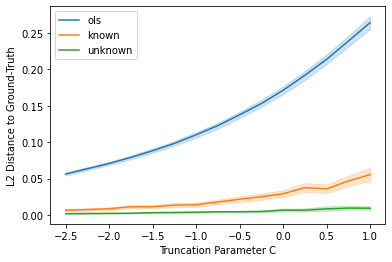

[Text(0.5, 0, 'Truncation Parameter C'),
 Text(0, 0.5, 'L1 Distance to Ground-Truth')]

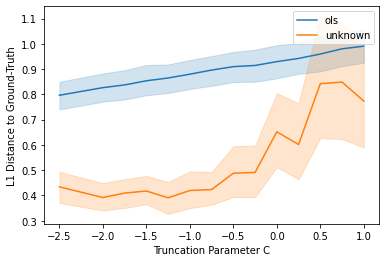

In [116]:
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols')
ax = sns.lineplot(data=logs, x='c', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='c', y='unknown_param_mse', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='c', y='unknown_var_l1', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance to Ground-Truth')

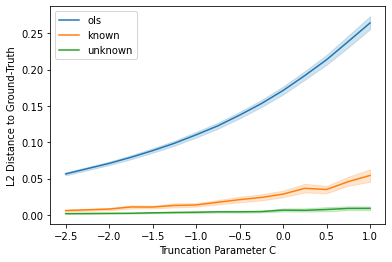

[Text(0.5, 0, 'Truncation Parameter C'),
 Text(0, 0.5, 'L1 Distance to Ground-Truth')]

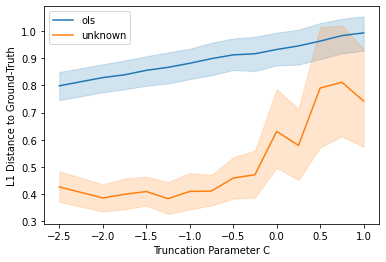

In [115]:
sns.lineplot(data=ols_logs, x='c', y='ols_param_mse', label='ols')
ax = sns.lineplot(data=known_logs, x='c', y='known_param_mse', label='known')
ax = sns.lineplot(data=unknown_logs, x='c', y='unknown_param_mse', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=ols_logs, x='c', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=unknown_logs, x='c', y='unknown_var_l1', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance to Ground-Truth')

In [114]:
trunc_ols = LinearRegression().fit(x_trunc, y_trunc)
emp_noise_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
emp_noise_var

tensor([0.4925])

In [115]:
emp_noise_scale = ch.sqrt(emp_noise_var / 2)
emp_noise_scale

tensor([0.4962])

In [117]:
(emp_noise_var / 2).pow(.5)

tensor([0.4962])

In [120]:
new_noised = noised / ch.sqrt(emp_noise_var)
new_y_trunc = y_trunc / ch.sqrt(emp_noise_var)

In [121]:
ols = LinearRegression().fit(x_trunc_norm, new_y_trunc)

In [122]:
(new_y_trunc - ols.predict(x_trunc_norm)).var(0)

tensor([1.])

In [112]:
another_ols = LinearRegression()
another_ols.fit(X, noised / noise_scale)

LinearRegression()

In [113]:
(noised - another_ols.predict(X)).var(0)

tensor([1.0035])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [35]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[0.5949]], requires_grad=True))

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

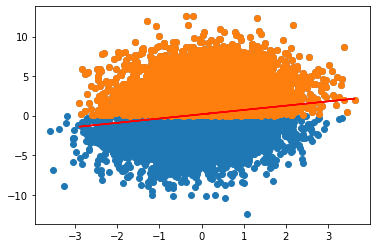

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])